In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#from google.colab import files
#files.upload()

In [ ]:
# Carga Fichero

import pandas as pd
path="/content/drive/MyDrive/Cajamar/"
datos = pd.read_csv(path+'Modelar_UH2022.txt',sep='|',parse_dates=['SAMPLETIME'],infer_datetime_format=True)

In [ ]:
#Modelar_UH2022_10_Contadores.txt
datos[datos['ID']<11].to_csv('Modelar_UH2022_10_Contadores.txt',sep='|',index=False,float_format='%.0f')

In [ ]:
datos[datos['ID']<3].to_csv('Modelar_UH2022_2_Contadores.txt',sep='|',index=False,float_format='%.0f')

In [ ]:
datos[datos['ID']==2735].to_csv('Modelar_UH2022_Contador_2735.txt',sep='|',index=False,float_format='%.0f')

In [ ]:
datos[datos['ID']==2561].to_csv('Modelar_UH2022_Contador_2561.txt',sep='|',index=False,float_format='%.0f')

In [ ]:
datos[datos['ID']==2562].to_csv('Modelar_UH2022_Contador_2562.txt',sep='|',index=False,float_format='%.0f')

In [ ]:
datos[datos['ID']==167].to_csv('Modelar_UH2022_Contador_167.txt',sep='|',index=False,float_format='%.0f')

In [ ]:
datos[datos['ID']==2521].to_csv('Modelar_UH2022_Contador_2521.txt',sep='|',index=False,float_format='%.0f')

# CLASE PARA PROYECTO CAJAMAR

In [ ]:
import pandas as pd
path="/content/drive/MyDrive/Cajamar/"
Normal_better=pd.read_csv(path+'Normal_better')
Lista_Normal_better = Normal_better['Salida'].tolist()
print(Lista_Normal_better)

[0, 1, 2, 3, 4, 0, 6, 7, 8, 0, 10, 11, 0, 0, 14, 0, 0, 0, 0, 19, 0, 0, 0, 23, 0, 25, 0, 0, 28, 29, 30, 31, 0, 33, 0, 0, 36, 0, 38, 39, 40, 41, 42, 0, 44, 0, 46, 0, 0, 0, 50, 51, 52, 53, 0, 55, 0, 57, 58, 59, 0, 61, 62, 63, 0, 65, 0, 67, 68, 69, 0, 71, 0, 0, 74, 0, 76, 77, 0, 0, 80, 0, 0, 0, 84, 0, 86, 0, 0, 89, 90, 0, 92, 93, 94, 95, 0, 97, 0, 0, 100, 101, 0, 103, 0, 105, 106, 107, 108, 109, 0, 111, 0, 0, 114, 0, 116, 117, 0, 119, 120, 121, 0, 0, 0, 0, 126, 0, 0, 129, 130, 131, 0, 133, 134, 0, 136, 0, 0, 0, 140, 141, 142, 143, 0, 145, 146, 0, 0, 149, 0, 0, 0, 153, 154, 0, 156, 157, 0, 0, 160, 161, 162, 0, 0, 0, 0, 167, 168, 169, 0, 171, 172, 173, 174, 175, 0, 0, 178, 0, 180, 0, 182, 0, 0, 185, 0, 187, 0, 189, 0, 0, 192, 193, 194, 195, 196, 197, 198, 0, 200, 201, 0, 0, 0, 205, 0, 207, 208, 209, 210, 211, 0, 0, 0, 215, 0, 0, 0, 0, 220, 221, 222, 0, 224, 0, 226, 227, 228, 0, 230, 231, 232, 233, 0, 0, 236, 237, 238, 0, 240, 241, 0, 243, 244, 0, 0, 0, 0, 249, 0, 251, 252, 253, 254, 0, 0, 0,

In [2]:
!pip install skforecast

     |████████████████████████████████| 87 kB 5.1 MB/s 
     |████████████████████████████████| 76 kB 3.6 MB/s 
     |████████████████████████████████| 9.8 MB 55.2 MB/s 
  Attempting uninstall: tqdm
    Found existing installation: tqdm 4.63.0
    Uninstalling tqdm-4.63.0:
      Successfully uninstalled tqdm-4.63.0
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2


In [12]:
# Librerias

import pandas as pd
import numpy as np
from tqdm import tqdm
from datetime import timedelta
from datetime import date
from sklearn.metrics import mean_squared_error
#from sklearn.model_selection import ParameterGrid
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.ForecasterAutoregCustom import ForecasterAutoregCustom
from skforecast.ForecasterAutoregMultiOutput import ForecasterAutoregMultiOutput
#from skforecast.model_selection import grid_search_forecaster, backtesting_forecaster
import model_selection_no_print
#from typing import Union, Optional
from sklearn.preprocessing import StandardScaler
import math
from joblib import dump, load
import pickle


class Contador(object):
    def __init__(self, datos_contador, ID, umbral, Modelo_Semanal):
        self.datos_contador = datos_contador
        self.ID = ID
        self.lista_contadores_defectuosos = [111, 658, 2460, 2464, 2466, 2481, 2483, 2489]
        self.umbral = umbral
        self.Modelo_Semanal = Modelo_Semanal
        self.Preprocesado()
        self.SinDatos = False  # NO TIENE DATOS DATASET VACIO
        #self.outlier = False
        self.dias = 0
        self.RMSE_Train = 0
        self.RMSE_Test = 0
        self.datos_test = pd.DataFrame()
        self.datos_test_semanal = pd.DataFrame()
        self.Mejor_Parametro = {}
        self.Mejor_Lag = 14 
        self.DiffConsumo = 0
        
        # {'ID','Dia_1':0,'Dia_2':0,'Dia_3':0,'Dia_4':0,'Dia_5':0,'Dia_6':0','Dia_7':0,'Semana_1':0,'Semana_2':0}
        self.Predicciones = [self.ID,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
        
        if not datos_contador.empty:
            # CALCULO LECTURA CONTADOR Y CONSUMO JUNTANDO DECIMALES
            #
            #CALCULO DE LA LECTURA Y CONSUMO AGRUPANDO PARTE ENTERA Y DECIMAL
            self.datos_contador['LECTURA'] = self.datos_contador['READINGINTEGER'] + (self.datos_contador['READINGTHOUSANDTH'] / 100)
            self.datos_contador['CONSUMO'] = self.datos_contador['DELTAINTEGER'] + (self.datos_contador['DELTATHOUSANDTH'] / 100)
            
            #NORMALIZACIÓN A DISTRIBUCIÓN NORMAL(0,1) DE LECTURA Y CONSUMO
            self.datos_contador['LECTURA_NORMA'] = (self.datos_contador['LECTURA']-self.datos_contador['LECTURA'].mean())/self.datos_contador['LECTURA'].std()
            self.datos_contador['CONSUMO_NORMA'] = (self.datos_contador['CONSUMO']-self.datos_contador['CONSUMO'].mean())/self.datos_contador['CONSUMO'].std()
            
            # ELIMINANDO LOS OUTLIERS "DESTACADOS" DE LOS CONTADORES MARCADOS (DEJO COMENTADA UNA OPCIÓN PARA HACERLO TAMBIÉN CON EL RESTO DE CONTADORES)
            if self.ID in self.lista_contadores_defectuosos:
              if self.ID in [111, 658, 2560]:
                self.datos_contador.drop(self.datos_contador.index[np.where(np.abs(self.datos_contador['CONSUMO_NORMA'])>6)[0]], inplace=True)
              elif self.ID in [2466, 2483, 2489]:
                self.datos_contador.drop(self.datos_contador.index[np.where(np.abs(self.datos_contador['CONSUMO_NORMA'])>5)[0]], inplace=True)
              elif self.ID in [2464, 2481]:
                self.datos_contador.drop(self.datos_contador.index[np.where(np.abs(self.datos_contador['CONSUMO_NORMA'])>10)[0]], inplace=True)
#           else:
#             self.datos_contador['CONSUMO'].drop(self.datos_contador.index[np.where(np.abs(self.datos_contador['CONSUMO_NORMA']>8)[0]], inplace=True)
            
            #FIJACIÓN DEL ÍNDICE TEMPORAL DE LA SERIE
            self.datos_contador = self.datos_contador.set_index('SAMPLETIME')

            #NORMALIZACIÓN MIN MAX DE LECTURA Y CONSUMO
            self.datos_contador['LECTURA_MINMAX'] = (self.datos_contador['LECTURA']-self.datos_contador['LECTURA'].min())/(self.datos_contador['LECTURA'].max()-self.datos_contador['LECTURA'].min())
            self.datos_contador['CONSUMO_MINMAX'] = (self.datos_contador['CONSUMO']-self.datos_contador['CONSUMO'].min())/(self.datos_contador['CONSUMO'].max()-self.datos_contador['CONSUMO'].min())
            
            #CÁLCULO DE LA DIFERENCIA DE LECTURAS EN CADA PASO DE TIEMPO PARA OBTENER EL CONSUMO A PARTIR DE LA LECTURA
            self.datos_contador['CONSUMO_CAL'] = self.datos_contador['LECTURA'].diff(1).fillna(0)
            
            #APLICACIÓN DE LA FUNCIÓN PARA VERIFICAR SI EL CONSUMO ES CORRECTO
            self.__Comprobar_Consumo()

            # CÁLCULO DE LA SUMA DE LOS CONSUMOS Y LA DIFERENCIA DE VALOR MÁXIMO Y MÍNIMO DE LA LECTURA DEL CONTADOR
            self.suma_consumo = self.datos_contador['CONSUMO'].sum()
            self.diferencia_lectura = self.datos_contador['LECTURA'].max()-self.datos_contador['LECTURA'].min()

            #BOOLEANO QUE DETERMINA SI LA SUMA DE LOS CONSUMOS Y LA DIFERENCIA MIN MAX DEL CONTADOR SON IGUALES
            if self.suma_consumo == self.diferencia_lectura:
              self.buenas_lecturas = True
            else:
              self.buenas_lecturas = False

            # CONSUMO POR DIAS
            # RESAMPLE
            
            self.datos_consumo = pd.DataFrame(self.datos_contador['CONSUMO'].resample(rule='1D', closed='left', label ='left').sum())

            # NORMALIZACIÓN NORMAL STÁNDARD
            self.datos_consumo['CONSUMO_NORM'] = (self.datos_consumo['CONSUMO'] - self.datos_consumo['CONSUMO'].mean()) / self.datos_consumo['CONSUMO'].std()
            self.datos_consumo['CONSUMO_NORM'].fillna(0, inplace=True)
            # NORMALIZACIÓN MIN MAX
            self.datos_consumo['CONSUMO_MIN_MAX'] = (self.datos_consumo['CONSUMO']-self.datos_consumo['CONSUMO'].min())/(self.datos_consumo['CONSUMO'].max()-self.datos_consumo['CONSUMO'].min())
            self.datos_consumo['CONSUMO_MIN_MAX'].fillna(0,inplace=True)
            # MEDIAS MÓVILES N=3
            self.datos_consumo['CONSUMO_MEDMOV3'] = self.datos_consumo['CONSUMO'].rolling(3).mean()
            self.datos_consumo['CONSUMO_MEDMOV3'].fillna(0,inplace=True)
            # MEDIAS MÓVILES N=4
            self.datos_consumo['CONSUMO_MEDMOV4'] = self.datos_consumo['CONSUMO'].rolling(4).mean()
            self.datos_consumo['CONSUMO_MEDMOV4'].fillna(0,inplace=True)
            # MEDIAS MÓVILES N=5
            self.datos_consumo['CONSUMO_MEDMOV5'] = self.datos_consumo['CONSUMO'].rolling(5).mean()
            self.datos_consumo['CONSUMO_MEDMOV5'].fillna(0,inplace=True)
            # MEDIAS MÓVILES N=6
            self.datos_consumo['CONSUMO_MEDMOV6'] = self.datos_consumo['CONSUMO'].rolling(6).mean()
            self.datos_consumo['CONSUMO_MEDMOV6'].fillna(0,inplace=True)


            # MEDIAS MÓVILES N=7
            self.datos_consumo['CONSUMO_MEDMOV7'] = self.datos_consumo['CONSUMO'].rolling(7).mean()
            self.datos_consumo['CONSUMO_MEDMOV7'].fillna(0,inplace=True)   

            self.datos_consumo['CONSUMO_MEAN'] = self.datos_consumo['CONSUMO'].tail(14).mean() ###################
            print(self.datos_consumo['CONSUMO_MEAN'])
            self.datos_consumo['CONSUMO_MEAN'].fillna(0,inplace=True)  

            #COGER SÓLO SEMANAS COMPLETAS
            self.datos_consumo_semanal = pd.DataFrame(self.datos_contador['CONSUMO'].resample(rule='1W', closed='left', label ='left',offset='-36h').sum())
            
            # ESTADISTICAS
            self.dias = len(self.datos_consumo.index)
            self.semanas = len(self.datos_consumo_semanal.index)
            #self.datos_consumo['Cuenta'] = self.datos_contador.groupby([self.datos_contador.index.year,self.datos_contador.index.month, self.datos_contador.index.day]).agg({'CONSUMO':'count'}).values
            
            self.fecha_inicio_contador= self.datos_consumo.index[0]
            self.fecha_fin_contador= self.datos_consumo.index[-1]
            
        else:
            self.datos_consumo = pd.DataFrame()
            self.SinDatos = True
            self.fecha_fin_contador = None

        # GENERACION DEL MODELO
        self.modelo()
    
    def __Comprobar_Consumo(self):
        # COMPRUEBA SI HAY MAS DE 1 LITRO DE DIFERENCIA ENTRE EL CONSUMO EL CALCULO DEL CONSUMO CON LA LECTURA DEL CONTADOR
        # EL VALOR ACUMULADO SE GUARDA EN DiffConsumo
        if not(self.datos_contador['CONSUMO_CAL'].equals(self.datos_contador['CONSUMO'])):
            for index, row in self.datos_contador.iterrows():
                if row['CONSUMO_CAL'] != row['CONSUMO'] and (np.absolute(row['CONSUMO_CAL'] - row['CONSUMO']) > 1):
                    #print(row['CONSUMO_CAL'] - row['CONSUMO'])
                    #print(index,row)
                    self.DiffConsumo += np.absolute(row['CONSUMO_CAL'] - row['CONSUMO'])
        
    def __Convertir_fecha(self, serie):
        fechas = []
        for año, mes, dia in serie.index:
            fechas.append(date(año,mes,dia))
        return fechas
    
    def Preprocesado(self):
        # SAMPLETIME READINGINTEGER	READINGTHOUSANDTH	DELTAINTEGER	DELTATHOUSANDTH
        # VALORES  NULOS 
        # VALORES ENTEROS INTERPOLAMOS
        

        self.datos_contador['READINGINTEGER'].interpolate(inplace=True)
        self.datos_contador['DELTAINTEGER'].interpolate(inplace=True)
        
        # VALORES DECIMALES SUSTITUIMOS POR CERO
        self.datos_contador['READINGTHOUSANDTH'].fillna(0,inplace=True)
        self.datos_contador['DELTATHOUSANDTH'].fillna(0,inplace=True)
        
        # ELIMINAR VALORES NEGATIVOS
        indices = self.datos_contador[self.datos_contador['READINGINTEGER'] < 0].index
        self.datos_contador.drop(indices,inplace=True)
        indices = self.datos_contador[self.datos_contador['DELTAINTEGER'] < 0].index
        self.datos_contador.drop(indices,inplace=True)


    def modelo(self):
        # DECISION DEL MODELO A TOMAR EN FUNCION DE LA ESTADISTICAS
        # CARGA DEL MODELO
        # PACO
        self.model = None
        if self.dias > self.umbral: 
            if self.fecha_fin_contador == date(2020,1,31):
                # RandomForestRegressor Diario
                self.model = ForecasterAutoreg(regressor=RandomForestRegressor(random_state=123), lags=7)
                # RandomForestRegressor Semanal Paco
                self.model_Semanal = ForecasterAutoreg(regressor=RandomForestRegressor(random_state=123), lags=4)
                
            else:
                self.model = self.datos_consumo['CONSUMO'].mean()
        else:
            if self.dias > 0: 
                #if (self.fecha_fin_contador > date(2020,1,17)).bool() :    # HACE MEDIA SI TENEMOS DATOS EN LOS ULTIMOS 14 DIAS
                self.model = self.datos_consumo['CONSUMO'].mean()
                #else:
                #self.model = 0
            else:
                self.model = 0

    def Juntar_Datos(self):
        # REHACE EL MODELO CON LOS MEJORES PARAMETROS
        # JUNTA TODO EN datos_consumo
        # {'max_depth': 3, 'n_estimators': 200}        
        #del self.model
        #if self.dias > umbral:
            #self.model = ForecasterAutoreg(regressor=RandomForestRegressor(random_state=123), lags=max(self.Mejor_Lag), 
            #                                max_depth=self.Mejor_Parametro['max_depth'],n_estimators=self.Mejor_Parametro['n_estimators'])

        self.datos_consumo = pd.concat([self.datos_consumo,self.datos_test])
        self.datos_test =pd.DataFrame()
        
    

class CajaMar_Water(object):
    def __init__(self,Ruta_Datos,Fecha_Inicio=date(2019,2,1),Fecha_Fin=date(2020,1,31),umbral_modelo=100, Modelo_Semanal=False):
        self.Ruta_Datos = Ruta_Datos
        self.Fecha_Inicio = Fecha_Inicio
        self.Fecha_Fin = Fecha_Fin
        self.umbral_modelo = umbral_modelo
        self.Modelo_Semanal = Modelo_Semanal    # True usamos dos modelos uno para dias y otro para semanas
        self.datos = pd.DataFrame()
        self.contadores = []
        self.dias_test = 7     # DIAS QUE SE RESERVAN PARA TEST EMPEZANDO POR LA FECHA MAS RECIENTE
        self.semanas_test = 2   # SEMANAS QUE SE RESERVAN PARA TEST
        self.Cargar_Datos()
        self.RMSE_Test_Promedio=0
        self.RMSE_Test_Suma=0
        self.RMSE_Todos = []
        self.RMSE_Todos_IDs = []
        
    

    def Cargar_Datos(self):
        print('CARGANDO DATOS.....')
        self.datos = pd.read_csv(self.Ruta_Datos,sep='|',parse_dates=['SAMPLETIME'],infer_datetime_format=True,encoding='utf-8')
        self.datos.sort_values(by=['ID','SAMPLETIME'],inplace=True)
 
        # GENERANDO CONTADORES
        print('GENERANDO CONTADORES.....')
        for ID in tqdm(pd.unique(self.datos['ID'])):
            # ALMACENAMOS ID DE CONTADOR Y BORRAMOS LA COLUMNA
            self.contadores.append(Contador(self.datos[self.datos['ID']==ID].drop('ID',axis=1),ID,self.umbral_modelo,self.Modelo_Semanal))

        print('PROCESO DE CARGA FINALIZADO')
    
    def PartirDatos(self):
        # Separar datos de entrenamiento y test / validacion (dias=0 no hace validacion)
        if self.dias_test > 0:     
            for contador in tqdm(self.contadores):
                if contador.SinDatos == False:      # COMPROBAMOS QUE HAY ALGUN REGISTRO
                    #if (contador.fecha_fin_contador==self.Fecha_Fin):
                    if contador.dias > self.dias_test + 1:    # COMPROBAMOS QUE HAY SUFICIENTES DATOS PARA HACER PARTICION
                        contador.datos_test = contador.datos_consumo.tail(self.dias_test)
                        contador.datos_consumo = contador.datos_consumo[0:-self.dias_test]
                    if contador.semanas > self.semanas_test + 1:
                        contador.datos_test_semanal = contador.datos_consumo_semanal.tail(self.semanas_test)
                        contador.datos_consumo_semanal = contador.datos_consumo_semanal[0:-self.semanas_test]


    
    def Grid_Search(self,ID,steps):
        # Hiperparámetros del regresor
        param_grid = {'n_estimators': [100],
              'max_depth': [5]}

        # Lags utilizados como predictores
        lags_grid = [14]

        resultados_grid = model_selection_no_print.grid_search_forecaster(
                                forecaster         = self.contadores[ID].model,
                                y                  = self.contadores[ID].datos_consumo['CONSUMO'],
                                param_grid         = param_grid,
                                lags_grid          = lags_grid,
                                steps              = steps,
                                refit              = True,
                                metric             = 'mean_squared_error',
                                initial_train_size = len(self.contadores[ID].datos_consumo) - 14,
                                return_best        = True,
                                verbose            = False)
        self.contadores[ID].RMSE_Train = math.sqrt(resultados_grid['metric'].head(1))
        self.contadores[ID].Mejor_Parametro = list(resultados_grid['params'])[0]
        self.contadores[ID].Mejor_Lag = max(list(resultados_grid['lags'].head(1))[0])
        

    def Entrenamiento(self,Grid=False):
        # Entrenamiento de los modelos en self.contadores(lista) 
        # iterar lista y llamar a self.contadores[iter].modelo.train
        # Rellena la variable self.contadores.Predicciones
        indexC = 0
        for contador in tqdm(self.contadores):
            if isinstance(contador.model,ForecasterAutoreg):    # COMPROBAMOS QUE ES UN MODELO
                if Grid:
                    self.Grid_Search(indexC,self.dias_test)
                    #contador.Juntar_Datos() #  JUNTA LOS DATOS PARA LUEGO HACER PREDICT
                
                #contador.model.fit(y=contador.datos_consumo['CONSUMO_NORM'])
                #if contador.ID not in Lista_Normal_better:
                #print(contador.ID)
                #contador.model.fit(y=contador.datos_consumo['CONSUMO_MEDMOV6'])
                #else:
                contador.model.fit(y=contador.datos_consumo['CONSUMO_MEAN'])
                predict = contador.model.predict(steps=self.dias_test)
                #contador.model.fit(y=contador.datos_consumo['CONSUMO_NORM'])
                #contador.model.fit(y=contador.datos_consumo['CONSUMO'])
                #contador.model.fit(y=contador.datos_consumo['CONSUMO_MIN_MAX'])
                #contador.model.fit(y=contador.datos_consumo['CONSUMO_MEDMOV3'])
                #contador.model.fit(y=contador.datos_consumo['CONSUMO_MEDMOV4'])
                #contador.model.fit(y=contador.datos_consumo['CONSUMO_MEDMOV5'])

                if self.Modelo_Semanal:
                    contador.model_Semanal.fit(y=contador.datos_consumo_semanal['CONSUMO'])
                    predict_semanal = contador.model_Semanal.predict(steps=self.semanas_test)
                # HAY QUE TENER EN CUENTA CUANDO TERMINAN LOS DATOS
                #predict = contador.model.predict(steps=self.dias_test) * contador.datos_consumo['CONSUMO'].std() + contador.datos_consumo['CONSUMO'].mean()
                #predict = contador.model.predict(steps=self.dias_test) * contador.datos_consumo['CONSUMO'].std() + contador.datos_consumo['CONSUMO'].mean()
                #predict = contador.model.predict(steps=self.dias_test)*(contador.datos_consumo['CONSUMO'].max()-contador.datos_consumo['CONSUMO'].min())+contador.datos_consumo['CONSUMO'].min()
                #predict = contador.model.predict(steps=self.dias_test)
                index = 1
                for predict_dia in predict[0:7]:    # GUARDA 14 DIAS PREDICCION
                    contador.Predicciones[index] = predict_dia
                    index += 1
                if self.Modelo_Semanal:
                    contador.Predicciones[15]=predict_semanal[0]              # GUARDA SEMANA1 PREDICCION
                    contador.Predicciones[16]=predict_semanal[1]              # GUARDA SEMANA2 PREDICCION
                else:
                    contador.Predicciones[15]=predict[0:7].sum()     # GUARDA SEMANA1 PREDICCION
                    contador.Predicciones[16]=predict[0:7].sum()    # GUARDA SEMANA2 PREDICCION
            else:
              for index in range(1,8):
                    contador.Predicciones[index] = contador.model  # GUARDAMOS MEDIA EN LOS 7 DIAS
              contador.Predicciones[15]=contador.model*7     # GUARDAMOS MEDIA SEMANA1
              contador.Predicciones[16]=contador.model*7     # GUARDAMOS MEDIA SEMANA2
            
            indexC += 1
                  

    def Calculo_RMSE(self):
        # Calculo rmse utlizando datos de test
        for contador in tqdm(self.contadores):
            #if contador.dias > 180 and len(contador.datos_test) == self.dias_test:  # VER LIMITE NO DEPENDE DE LA CLASE CONTADOR
            if len(contador.datos_test) == self.dias_test and len(contador.datos_test_semanal) == self.semanas_test:
                if self.Modelo_Semanal:
                    media_RMSE_semanal=math.sqrt(mean_squared_error(contador.datos_test_semanal['CONSUMO'] , [contador.Predicciones[15], contador.Predicciones[16]]))
                else:
                    media_RMSE_semanal=math.sqrt(mean_squared_error([contador.datos_test['CONSUMO'][0:7].sum(), contador.datos_test['CONSUMO'][0:7].sum()] , [contador.Predicciones[15], contador.Predicciones[16]]))
                
                contador.RMSE_Test = 0.5*math.sqrt(mean_squared_error(contador.datos_test['CONSUMO'][0:7],contador.Predicciones[1:8]))+0.5*media_RMSE_semanal
                # Sin raiz
                #media_RMSE_semanal=mean_squared_error([contador.datos_test['CONSUMO'][0:7].sum(), contador.datos_test['CONSUMO'][7:14].sum()] , [contador.Predicciones[8], contador.Predicciones[9]])
                #contador.RMSE_Test = 0.5+mean_squared_error(contador.datos_test['CONSUMO'][0:7],contador.Predicciones[1:8])+0.5*media_RMSE_semanal
                self.RMSE_Todos.append(contador.RMSE_Test)
                self.RMSE_Todos_IDs.append(contador.ID)

        self.RMSE_Test_Suma = sum(self.RMSE_Todos)
        if self.RMSE_Test_Suma != 0:
            self.RMSE_Test_Promedio = self.RMSE_Test_Suma / len(self.RMSE_Todos)
        else:
            print('ERROR NO HAY CALCULO DE RMSE')
        
    
    def GenerarResultados(self,equipo='Team2021IA3',numeral=1):
        # Mediante los datos predicciones generamos txt con el formato del datathon
        # Separando campos con “|”, el valor de la predicción en litros, y los decimales con “.” 2 decimales
        # Fichero: "Cajamar_Universitat de València (UV)_Team2021IA3_numeral.txt"
        
        columnas = ['ID','Dia_1','Dia_2','Dia_3','Dia_4','Dia_5','Dia_6','Dia_7','Semana_1','Semana_2']
        datos = []

        for contador in tqdm(self.contadores):
            datos.append(contador.Predicciones)
        
        print('TAMAÑO DE LOS DATOS: ', len(datos), 'x' ,len(datos[0]))
        
        dataset = pd.DataFrame(datos,columns=columnas)
        dataset.to_csv('Cajamar_Universitat de València (UV)_' + equipo + '_' + str(numeral) + '.txt',header=False ,sep='|' ,index=False ,decimal='.' ,float_format='%.2f')
         
    def GraficasEstadisticas(self,contador=0,Test=True):
        # GRÁFICAS DE CONTADORES INDIVIDUALES CON TEST Y PREDICCIONES
        if Test:
            fig, ax = plt.subplots(figsize=(10, 4))
            self.contadores[contador].datos_test['CONSUMO'].plot(ax=ax, label='Test', linewidth=1)
            pd.DataFrame(self.contadores[contador].Predicciones[1:8],index=self.contadores[contador].datos_test['CONSUMO'].index[0:7],columns=['Predicción']).plot(ax=ax, label='Prediccion', linewidth=1)
            ax.set_title('Consumo Agua. RMSE: ' + str(self.contadores[contador].RMSE_Test) + ' Contador: ' + str(contador))
            ax.legend();
        else:
            base = date(2020,2,1)
            index = [base + timedelta(days=x) for x in range(7)]
            index = pd.DataFrame(index)
            index.insert(1, 'SAMPLETIME', [base + timedelta(days=x) for x in range(7)], True)
            index['SAMPLETIME']=pd.to_datetime(index['SAMPLETIME'], format='%Y-%m-%d')
            index=index.set_index('SAMPLETIME')
            index_puro=index.drop([0],axis=1)
            index_puro['Predicción']=Proyecto.contadores[contador].Predicciones[1:8]
            #df_final=pd.DataFrame(index_puro.insert(1, 'Predicción', pd.Series(self.contadores[contador].Predicciones[1:8]), True))

            fig, ax = plt.subplots(figsize=(10, 4))
            self.contadores[contador].datos_consumo['CONSUMO'].plot(ax=ax, label='Consumo', linewidth=1)
            index_puro.plot(ax=ax, label='Predicción', linewidth=1)
            #pd.DataFrame(self.contadores[contador].Predicciones[1:8],index=index_puro,columns=['Predicción']).plot(ax=ax, label='Prediccion', linewidth=1)
            ax.set_title('Consumo Agua. RMSE: ' + str(self.contadores[contador].RMSE_Train) + ' Contador: ' + str(contador))
            ax.legend();

    def Guardar_Modelos(self,Ruta='./modelos/Modelo_ID_'):

        print('GUARDANDO MODELOS.....')
        for contador in tqdm(self.contadores):
            dump(contador.model,Ruta + str(contador.ID))

        

In [13]:
#Proyecto = CajaMar_Water('Modelar_UH2022.txt')
path="/content/drive/MyDrive/Cajamar/"
#Proyecto = CajaMar_Water(path+'Modelar_UH2022_10_Contadores.txt')
Proyecto = CajaMar_Water(path+'Modelar_UH2022.txt')
#Proyecto = CajaMar_Water('Modelar_UH2022_10_Contadores.txt', Modelo_Semanal=False)
#Proyecto = CajaMar_Water('Modelar_UH2022_3_Contadores.txt')
#Proyecto = CajaMar_Water('Modelar_UH2022_Contador_2735.txt')
#Proyecto = CajaMar_Water('Modelar_UH2022_Contador_2561.txt')
#Proyecto = CajaMar_Water('Modelar_UH2022_Contador_2562.txt')

CARGANDO DATOS.....
GENERANDO CONTADORES.....


  0%|          | 1/2747 [00:00<24:50,  1.84it/s]

SAMPLETIME
2019-02-01    333.657143
2019-02-02    333.657143
2019-02-03    333.657143
2019-02-04    333.657143
2019-02-05    333.657143
                 ...    
2020-01-27    333.657143
2020-01-28    333.657143
2020-01-29    333.657143
2020-01-30    333.657143
2020-01-31    333.657143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  0%|          | 2/2747 [00:01<24:21,  1.88it/s]

SAMPLETIME
2019-02-01    20.873571
2019-02-02    20.873571
2019-02-03    20.873571
2019-02-04    20.873571
2019-02-05    20.873571
                ...    
2020-01-27    20.873571
2020-01-28    20.873571
2020-01-29    20.873571
2020-01-30    20.873571
2020-01-31    20.873571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  0%|          | 3/2747 [00:01<26:05,  1.75it/s]

SAMPLETIME
2019-02-01    36.142857
2019-02-02    36.142857
2019-02-03    36.142857
2019-02-04    36.142857
2019-02-05    36.142857
                ...    
2020-01-27    36.142857
2020-01-28    36.142857
2020-01-29    36.142857
2020-01-30    36.142857
2020-01-31    36.142857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  0%|          | 4/2747 [00:02<25:42,  1.78it/s]

SAMPLETIME
2019-02-01    376.671429
2019-02-02    376.671429
2019-02-03    376.671429
2019-02-04    376.671429
2019-02-05    376.671429
                 ...    
2020-01-27    376.671429
2020-01-28    376.671429
2020-01-29    376.671429
2020-01-30    376.671429
2020-01-31    376.671429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  0%|          | 5/2747 [00:02<25:57,  1.76it/s]

SAMPLETIME
2019-02-01    318.472857
2019-02-02    318.472857
2019-02-03    318.472857
2019-02-04    318.472857
2019-02-05    318.472857
                 ...    
2020-01-27    318.472857
2020-01-28    318.472857
2020-01-29    318.472857
2020-01-30    318.472857
2020-01-31    318.472857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  0%|          | 6/2747 [00:03<25:23,  1.80it/s]

SAMPLETIME
2019-02-01    0.0
2019-02-02    0.0
2019-02-03    0.0
2019-02-04    0.0
2019-02-05    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  0%|          | 7/2747 [00:03<25:13,  1.81it/s]

SAMPLETIME
2019-02-01    178.595
2019-02-02    178.595
2019-02-03    178.595
2019-02-04    178.595
2019-02-05    178.595
               ...   
2020-01-27    178.595
2020-01-28    178.595
2020-01-29    178.595
2020-01-30    178.595
2020-01-31    178.595
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  0%|          | 8/2747 [00:04<24:54,  1.83it/s]

SAMPLETIME
2019-02-01    130.442857
2019-02-02    130.442857
2019-02-03    130.442857
2019-02-04    130.442857
2019-02-05    130.442857
                 ...    
2020-01-27    130.442857
2020-01-28    130.442857
2020-01-29    130.442857
2020-01-30    130.442857
2020-01-31    130.442857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  0%|          | 9/2747 [00:04<24:46,  1.84it/s]

SAMPLETIME
2019-02-01    142.01
2019-02-02    142.01
2019-02-03    142.01
2019-02-04    142.01
2019-02-05    142.01
               ...  
2020-01-27    142.01
2020-01-28    142.01
2020-01-29    142.01
2020-01-30    142.01
2020-01-31    142.01
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  0%|          | 10/2747 [00:05<24:43,  1.85it/s]

SAMPLETIME
2019-02-01    158.214286
2019-02-02    158.214286
2019-02-03    158.214286
2019-02-04    158.214286
2019-02-05    158.214286
                 ...    
2020-01-27    158.214286
2020-01-28    158.214286
2020-01-29    158.214286
2020-01-30    158.214286
2020-01-31    158.214286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  0%|          | 11/2747 [00:06<24:59,  1.82it/s]

SAMPLETIME
2019-02-01    11.305
2019-02-02    11.305
2019-02-03    11.305
2019-02-04    11.305
2019-02-05    11.305
               ...  
2020-01-27    11.305
2020-01-28    11.305
2020-01-29    11.305
2020-01-30    11.305
2020-01-31    11.305
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64
SAMPLETIME
2019-02-01    0.0
2019-02-02    0.0
2019-02-03    0.0
2019-02-04    0.0
2019-02-05    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  0%|          | 13/2747 [00:06<19:52,  2.29it/s]

SAMPLETIME
2019-02-01    2.785714
2019-02-02    2.785714
2019-02-03    2.785714
2019-02-04    2.785714
2019-02-05    2.785714
                ...   
2020-01-27    2.785714
2020-01-28    2.785714
2020-01-29    2.785714
2020-01-30    2.785714
2020-01-31    2.785714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  1%|          | 14/2747 [00:07<21:44,  2.09it/s]

SAMPLETIME
2019-02-01    64.27
2019-02-02    64.27
2019-02-03    64.27
2019-02-04    64.27
2019-02-05    64.27
              ...  
2020-01-27    64.27
2020-01-28    64.27
2020-01-29    64.27
2020-01-30    64.27
2020-01-31    64.27
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  1%|          | 15/2747 [00:07<22:26,  2.03it/s]

SAMPLETIME
2019-02-01    158.207143
2019-02-02    158.207143
2019-02-03    158.207143
2019-02-04    158.207143
2019-02-05    158.207143
                 ...    
2020-01-27    158.207143
2020-01-28    158.207143
2020-01-29    158.207143
2020-01-30    158.207143
2020-01-31    158.207143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  1%|          | 16/2747 [00:08<22:54,  1.99it/s]

SAMPLETIME
2019-02-01    277.87
2019-02-02    277.87
2019-02-03    277.87
2019-02-04    277.87
2019-02-05    277.87
               ...  
2020-01-27    277.87
2020-01-28    277.87
2020-01-29    277.87
2020-01-30    277.87
2020-01-31    277.87
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  1%|          | 17/2747 [00:08<23:39,  1.92it/s]

SAMPLETIME
2019-02-01    305.964286
2019-02-02    305.964286
2019-02-03    305.964286
2019-02-04    305.964286
2019-02-05    305.964286
                 ...    
2020-01-27    305.964286
2020-01-28    305.964286
2020-01-29    305.964286
2020-01-30    305.964286
2020-01-31    305.964286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  1%|          | 18/2747 [00:09<24:10,  1.88it/s]

SAMPLETIME
2019-02-01    280.232857
2019-02-02    280.232857
2019-02-03    280.232857
2019-02-04    280.232857
2019-02-05    280.232857
                 ...    
2020-01-27    280.232857
2020-01-28    280.232857
2020-01-29    280.232857
2020-01-30    280.232857
2020-01-31    280.232857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  1%|          | 19/2747 [00:10<24:22,  1.87it/s]

SAMPLETIME
2019-02-01    640.192857
2019-02-02    640.192857
2019-02-03    640.192857
2019-02-04    640.192857
2019-02-05    640.192857
                 ...    
2020-01-27    640.192857
2020-01-28    640.192857
2020-01-29    640.192857
2020-01-30    640.192857
2020-01-31    640.192857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  1%|          | 20/2747 [00:10<24:06,  1.88it/s]

SAMPLETIME
2019-02-01    396.178571
2019-02-02    396.178571
2019-02-03    396.178571
2019-02-04    396.178571
2019-02-05    396.178571
                 ...    
2020-01-27    396.178571
2020-01-28    396.178571
2020-01-29    396.178571
2020-01-30    396.178571
2020-01-31    396.178571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  1%|          | 21/2747 [00:11<24:34,  1.85it/s]

SAMPLETIME
2019-02-01    12.691429
2019-02-02    12.691429
2019-02-03    12.691429
2019-02-04    12.691429
2019-02-05    12.691429
                ...    
2020-01-27    12.691429
2020-01-28    12.691429
2020-01-29    12.691429
2020-01-30    12.691429
2020-01-31    12.691429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64
SAMPLETIME
2019-02-01    0.0
2019-02-02    0.0
2019-02-03    0.0
2019-02-04    0.0
2019-02-05    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  1%|          | 23/2747 [00:11<19:21,  2.35it/s]

SAMPLETIME
2019-02-01    75.378571
2019-02-02    75.378571
2019-02-03    75.378571
2019-02-04    75.378571
2019-02-05    75.378571
                ...    
2020-01-27    75.378571
2020-01-28    75.378571
2020-01-29    75.378571
2020-01-30    75.378571
2020-01-31    75.378571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  1%|          | 24/2747 [00:12<20:30,  2.21it/s]

SAMPLETIME
2019-02-04    129.7
2019-02-05    129.7
2019-02-06    129.7
2019-02-07    129.7
2019-02-08    129.7
              ...  
2020-01-27    129.7
2020-01-28    129.7
2020-01-29    129.7
2020-01-30    129.7
2020-01-31    129.7
Freq: D, Name: CONSUMO_MEAN, Length: 362, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  1%|          | 25/2747 [00:12<22:30,  2.02it/s]

SAMPLETIME
2019-02-01    229.0
2019-02-02    229.0
2019-02-03    229.0
2019-02-04    229.0
2019-02-05    229.0
              ...  
2020-01-27    229.0
2020-01-28    229.0
2020-01-29    229.0
2020-01-30    229.0
2020-01-31    229.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  1%|          | 26/2747 [00:13<22:59,  1.97it/s]

SAMPLETIME
2019-02-01    279.134286
2019-02-02    279.134286
2019-02-03    279.134286
2019-02-04    279.134286
2019-02-05    279.134286
                 ...    
2020-01-27    279.134286
2020-01-28    279.134286
2020-01-29    279.134286
2020-01-30    279.134286
2020-01-31    279.134286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  1%|          | 27/2747 [00:13<21:40,  2.09it/s]

SAMPLETIME
2019-05-08    539.171429
2019-05-09    539.171429
2019-05-10    539.171429
2019-05-11    539.171429
2019-05-12    539.171429
                 ...    
2020-01-27    539.171429
2020-01-28    539.171429
2020-01-29    539.171429
2020-01-30    539.171429
2020-01-31    539.171429
Freq: D, Name: CONSUMO_MEAN, Length: 269, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  1%|          | 28/2747 [00:14<22:20,  2.03it/s]

SAMPLETIME
2019-02-01    131.592857
2019-02-02    131.592857
2019-02-03    131.592857
2019-02-04    131.592857
2019-02-05    131.592857
                 ...    
2020-01-27    131.592857
2020-01-28    131.592857
2020-01-29    131.592857
2020-01-30    131.592857
2020-01-31    131.592857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  1%|          | 29/2747 [00:14<22:48,  1.99it/s]

SAMPLETIME
2019-02-01    74.321429
2019-02-02    74.321429
2019-02-03    74.321429
2019-02-04    74.321429
2019-02-05    74.321429
                ...    
2020-01-27    74.321429
2020-01-28    74.321429
2020-01-29    74.321429
2020-01-30    74.321429
2020-01-31    74.321429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  1%|          | 30/2747 [00:15<23:18,  1.94it/s]

SAMPLETIME
2019-02-01    237.714286
2019-02-02    237.714286
2019-02-03    237.714286
2019-02-04    237.714286
2019-02-05    237.714286
                 ...    
2020-01-27    237.714286
2020-01-28    237.714286
2020-01-29    237.714286
2020-01-30    237.714286
2020-01-31    237.714286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  1%|          | 31/2747 [00:15<23:46,  1.90it/s]

SAMPLETIME
2019-02-01    407.728571
2019-02-02    407.728571
2019-02-03    407.728571
2019-02-04    407.728571
2019-02-05    407.728571
                 ...    
2020-01-27    407.728571
2020-01-28    407.728571
2020-01-29    407.728571
2020-01-30    407.728571
2020-01-31    407.728571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  1%|          | 32/2747 [00:16<24:19,  1.86it/s]

SAMPLETIME
2019-02-01    509.782857
2019-02-02    509.782857
2019-02-03    509.782857
2019-02-04    509.782857
2019-02-05    509.782857
                 ...    
2020-01-27    509.782857
2020-01-28    509.782857
2020-01-29    509.782857
2020-01-30    509.782857
2020-01-31    509.782857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  1%|          | 33/2747 [00:16<23:13,  1.95it/s]

SAMPLETIME
2019-04-06    193.0
2019-04-07    193.0
2019-04-08    193.0
2019-04-09    193.0
2019-04-10    193.0
              ...  
2020-01-27    193.0
2020-01-28    193.0
2020-01-29    193.0
2020-01-30    193.0
2020-01-31    193.0
Freq: D, Name: CONSUMO_MEAN, Length: 301, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  1%|          | 34/2747 [00:17<23:43,  1.91it/s]

SAMPLETIME
2019-02-01    2172.807857
2019-02-02    2172.807857
2019-02-03    2172.807857
2019-02-04    2172.807857
2019-02-05    2172.807857
                 ...     
2020-01-27    2172.807857
2020-01-28    2172.807857
2020-01-29    2172.807857
2020-01-30    2172.807857
2020-01-31    2172.807857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  1%|▏         | 35/2747 [00:17<22:02,  2.05it/s]

SAMPLETIME
2019-05-08    34.392857
2019-05-09    34.392857
2019-05-10    34.392857
2019-05-11    34.392857
2019-05-12    34.392857
                ...    
2020-01-27    34.392857
2020-01-28    34.392857
2020-01-29    34.392857
2020-01-30    34.392857
2020-01-31    34.392857
Freq: D, Name: CONSUMO_MEAN, Length: 269, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  1%|▏         | 36/2747 [00:18<21:04,  2.14it/s]

SAMPLETIME
2019-05-10    77.578571
2019-05-11    77.578571
2019-05-12    77.578571
2019-05-13    77.578571
2019-05-14    77.578571
                ...    
2020-01-27    77.578571
2020-01-28    77.578571
2020-01-29    77.578571
2020-01-30    77.578571
2020-01-31    77.578571
Freq: D, Name: CONSUMO_MEAN, Length: 267, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  1%|▏         | 37/2747 [00:18<23:05,  1.96it/s]

SAMPLETIME
2019-02-01    2737.087857
2019-02-02    2737.087857
2019-02-03    2737.087857
2019-02-04    2737.087857
2019-02-05    2737.087857
                 ...     
2020-01-27    2737.087857
2020-01-28    2737.087857
2020-01-29    2737.087857
2020-01-30    2737.087857
2020-01-31    2737.087857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  1%|▏         | 38/2747 [00:19<21:55,  2.06it/s]

SAMPLETIME
2019-02-01    108.636429
2019-02-02    108.636429
2019-02-03    108.636429
2019-02-04    108.636429
2019-02-05    108.636429
                 ...    
2020-01-27    108.636429
2020-01-28    108.636429
2020-01-29    108.636429
2020-01-30    108.636429
2020-01-31    108.636429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  1%|▏         | 39/2747 [00:19<22:34,  2.00it/s]

SAMPLETIME
2019-02-01    251.857143
2019-02-02    251.857143
2019-02-03    251.857143
2019-02-04    251.857143
2019-02-05    251.857143
                 ...    
2020-01-27    251.857143
2020-01-28    251.857143
2020-01-29    251.857143
2020-01-30    251.857143
2020-01-31    251.857143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  1%|▏         | 40/2747 [00:20<21:25,  2.11it/s]

SAMPLETIME
2019-05-13    412.967857
2019-05-14    412.967857
2019-05-15    412.967857
2019-05-16    412.967857
2019-05-17    412.967857
                 ...    
2020-01-27    412.967857
2020-01-28    412.967857
2020-01-29    412.967857
2020-01-30    412.967857
2020-01-31    412.967857
Freq: D, Name: CONSUMO_MEAN, Length: 264, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  1%|▏         | 41/2747 [00:20<22:08,  2.04it/s]

SAMPLETIME
2019-02-01    82.907143
2019-02-02    82.907143
2019-02-03    82.907143
2019-02-04    82.907143
2019-02-05    82.907143
                ...    
2020-01-27    82.907143
2020-01-28    82.907143
2020-01-29    82.907143
2020-01-30    82.907143
2020-01-31    82.907143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  2%|▏         | 42/2747 [00:21<22:39,  1.99it/s]

SAMPLETIME
2019-02-01    67.871429
2019-02-02    67.871429
2019-02-03    67.871429
2019-02-04    67.871429
2019-02-05    67.871429
                ...    
2020-01-27    67.871429
2020-01-28    67.871429
2020-01-29    67.871429
2020-01-30    67.871429
2020-01-31    67.871429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  2%|▏         | 43/2747 [00:21<23:25,  1.92it/s]

SAMPLETIME
2019-02-01    13422.023571
2019-02-02    13422.023571
2019-02-03    13422.023571
2019-02-04    13422.023571
2019-02-05    13422.023571
                  ...     
2020-01-27    13422.023571
2020-01-28    13422.023571
2020-01-29    13422.023571
2020-01-30    13422.023571
2020-01-31    13422.023571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  2%|▏         | 44/2747 [00:22<24:20,  1.85it/s]

SAMPLETIME
2019-02-01    272.655714
2019-02-02    272.655714
2019-02-03    272.655714
2019-02-04    272.655714
2019-02-05    272.655714
                 ...    
2020-01-27    272.655714
2020-01-28    272.655714
2020-01-29    272.655714
2020-01-30    272.655714
2020-01-31    272.655714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  2%|▏         | 45/2747 [00:23<24:56,  1.81it/s]

SAMPLETIME
2019-02-01    132.438571
2019-02-02    132.438571
2019-02-03    132.438571
2019-02-04    132.438571
2019-02-05    132.438571
                 ...    
2020-01-27    132.438571
2020-01-28    132.438571
2020-01-29    132.438571
2020-01-30    132.438571
2020-01-31    132.438571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  2%|▏         | 46/2747 [00:23<24:38,  1.83it/s]

SAMPLETIME
2019-02-01    223.285714
2019-02-02    223.285714
2019-02-03    223.285714
2019-02-04    223.285714
2019-02-05    223.285714
                 ...    
2020-01-27    223.285714
2020-01-28    223.285714
2020-01-29    223.285714
2020-01-30    223.285714
2020-01-31    223.285714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  2%|▏         | 47/2747 [00:24<24:31,  1.84it/s]

SAMPLETIME
2019-02-01    76.262857
2019-02-02    76.262857
2019-02-03    76.262857
2019-02-04    76.262857
2019-02-05    76.262857
                ...    
2020-01-27    76.262857
2020-01-28    76.262857
2020-01-29    76.262857
2020-01-30    76.262857
2020-01-31    76.262857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  2%|▏         | 48/2747 [00:24<24:21,  1.85it/s]

SAMPLETIME
2019-02-01    3143.778571
2019-02-02    3143.778571
2019-02-03    3143.778571
2019-02-04    3143.778571
2019-02-05    3143.778571
                 ...     
2020-01-27    3143.778571
2020-01-28    3143.778571
2020-01-29    3143.778571
2020-01-30    3143.778571
2020-01-31    3143.778571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  2%|▏         | 49/2747 [00:25<26:00,  1.73it/s]

SAMPLETIME
2019-02-01    408.806429
2019-02-02    408.806429
2019-02-03    408.806429
2019-02-04    408.806429
2019-02-05    408.806429
                 ...    
2020-01-27    408.806429
2020-01-28    408.806429
2020-01-29    408.806429
2020-01-30    408.806429
2020-01-31    408.806429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  2%|▏         | 50/2747 [00:25<25:17,  1.78it/s]

SAMPLETIME
2019-02-01    1.942143
2019-02-02    1.942143
2019-02-03    1.942143
2019-02-04    1.942143
2019-02-05    1.942143
                ...   
2020-01-27    1.942143
2020-01-28    1.942143
2020-01-29    1.942143
2020-01-30    1.942143
2020-01-31    1.942143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64
SAMPLETIME
2019-02-01    63.071429
2019-02-02    63.071429
2019-02-03    63.071429
2019-02-04    63.071429
2019-02-05    63.071429
                ...    
2020-01-27    63.071429
2020-01-28    63.071429
2020-01-29    63.071429
2020-01-30    63.071429
2020-01-31    63.071429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  2%|▏         | 52/2747 [00:26<20:00,  2.24it/s]

SAMPLETIME
2019-02-01    6066.435714
2019-02-02    6066.435714
2019-02-03    6066.435714
2019-02-04    6066.435714
2019-02-05    6066.435714
                 ...     
2020-01-27    6066.435714
2020-01-28    6066.435714
2020-01-29    6066.435714
2020-01-30    6066.435714
2020-01-31    6066.435714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  2%|▏         | 53/2747 [00:27<20:48,  2.16it/s]

SAMPLETIME
2019-02-01    237.285714
2019-02-02    237.285714
2019-02-03    237.285714
2019-02-04    237.285714
2019-02-05    237.285714
                 ...    
2020-01-27    237.285714
2020-01-28    237.285714
2020-01-29    237.285714
2020-01-30    237.285714
2020-01-31    237.285714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  2%|▏         | 54/2747 [00:27<21:52,  2.05it/s]

SAMPLETIME
2019-02-01    13.912143
2019-02-02    13.912143
2019-02-03    13.912143
2019-02-04    13.912143
2019-02-05    13.912143
                ...    
2020-01-27    13.912143
2020-01-28    13.912143
2020-01-29    13.912143
2020-01-30    13.912143
2020-01-31    13.912143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  2%|▏         | 55/2747 [00:27<20:50,  2.15it/s]

SAMPLETIME
2019-05-07    159.357143
2019-05-08    159.357143
2019-05-09    159.357143
2019-05-10    159.357143
2019-05-11    159.357143
                 ...    
2020-01-27    159.357143
2020-01-28    159.357143
2020-01-29    159.357143
2020-01-30    159.357143
2020-01-31    159.357143
Freq: D, Name: CONSUMO_MEAN, Length: 270, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  2%|▏         | 56/2747 [00:28<21:44,  2.06it/s]

SAMPLETIME
2019-02-01    188.302857
2019-02-02    188.302857
2019-02-03    188.302857
2019-02-04    188.302857
2019-02-05    188.302857
                 ...    
2020-01-27    188.302857
2020-01-28    188.302857
2020-01-29    188.302857
2020-01-30    188.302857
2020-01-31    188.302857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  2%|▏         | 57/2747 [00:29<22:05,  2.03it/s]

SAMPLETIME
2019-02-01    304.5
2019-02-02    304.5
2019-02-03    304.5
2019-02-04    304.5
2019-02-05    304.5
              ...  
2020-01-27    304.5
2020-01-28    304.5
2020-01-29    304.5
2020-01-30    304.5
2020-01-31    304.5
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  2%|▏         | 58/2747 [00:29<22:49,  1.96it/s]

SAMPLETIME
2019-02-01    342.102143
2019-02-02    342.102143
2019-02-03    342.102143
2019-02-04    342.102143
2019-02-05    342.102143
                 ...    
2020-01-27    342.102143
2020-01-28    342.102143
2020-01-29    342.102143
2020-01-30    342.102143
2020-01-31    342.102143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  2%|▏         | 59/2747 [00:30<23:43,  1.89it/s]

SAMPLETIME
2019-02-01    239.431429
2019-02-02    239.431429
2019-02-03    239.431429
2019-02-04    239.431429
2019-02-05    239.431429
                 ...    
2020-01-27    239.431429
2020-01-28    239.431429
2020-01-29    239.431429
2020-01-30    239.431429
2020-01-31    239.431429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  2%|▏         | 60/2747 [00:30<24:13,  1.85it/s]

SAMPLETIME
2019-02-01    81.909286
2019-02-02    81.909286
2019-02-03    81.909286
2019-02-04    81.909286
2019-02-05    81.909286
                ...    
2020-01-27    81.909286
2020-01-28    81.909286
2020-01-29    81.909286
2020-01-30    81.909286
2020-01-31    81.909286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  2%|▏         | 61/2747 [00:31<25:09,  1.78it/s]

SAMPLETIME
2019-02-01    351.735714
2019-02-02    351.735714
2019-02-03    351.735714
2019-02-04    351.735714
2019-02-05    351.735714
                 ...    
2020-01-27    351.735714
2020-01-28    351.735714
2020-01-29    351.735714
2020-01-30    351.735714
2020-01-31    351.735714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  2%|▏         | 62/2747 [00:31<25:02,  1.79it/s]

SAMPLETIME
2019-02-01    343.937143
2019-02-02    343.937143
2019-02-03    343.937143
2019-02-04    343.937143
2019-02-05    343.937143
                 ...    
2020-01-27    343.937143
2020-01-28    343.937143
2020-01-29    343.937143
2020-01-30    343.937143
2020-01-31    343.937143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  2%|▏         | 63/2747 [00:32<24:33,  1.82it/s]

SAMPLETIME
2019-02-15    139.932857
2019-02-16    139.932857
2019-02-17    139.932857
2019-02-18    139.932857
2019-02-19    139.932857
                 ...    
2020-01-27    139.932857
2020-01-28    139.932857
2020-01-29    139.932857
2020-01-30    139.932857
2020-01-31    139.932857
Freq: D, Name: CONSUMO_MEAN, Length: 351, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  2%|▏         | 64/2747 [00:32<24:05,  1.86it/s]

SAMPLETIME
2019-02-01    1.142857
2019-02-02    1.142857
2019-02-03    1.142857
2019-02-04    1.142857
2019-02-05    1.142857
                ...   
2020-01-27    1.142857
2020-01-28    1.142857
2020-01-29    1.142857
2020-01-30    1.142857
2020-01-31    1.142857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  2%|▏         | 65/2747 [00:33<24:34,  1.82it/s]

SAMPLETIME
2019-02-01    19.522857
2019-02-02    19.522857
2019-02-03    19.522857
2019-02-04    19.522857
2019-02-05    19.522857
                ...    
2020-01-27    19.522857
2020-01-28    19.522857
2020-01-29    19.522857
2020-01-30    19.522857
2020-01-31    19.522857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  2%|▏         | 66/2747 [00:34<24:17,  1.84it/s]

SAMPLETIME
2019-02-01    31.007143
2019-02-02    31.007143
2019-02-03    31.007143
2019-02-04    31.007143
2019-02-05    31.007143
                ...    
2020-01-27    31.007143
2020-01-28    31.007143
2020-01-29    31.007143
2020-01-30    31.007143
2020-01-31    31.007143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  2%|▏         | 67/2747 [00:34<24:49,  1.80it/s]

SAMPLETIME
2019-02-01    14.225714
2019-02-02    14.225714
2019-02-03    14.225714
2019-02-04    14.225714
2019-02-05    14.225714
                ...    
2020-01-27    14.225714
2020-01-28    14.225714
2020-01-29    14.225714
2020-01-30    14.225714
2020-01-31    14.225714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64
SAMPLETIME
2019-02-01    0.0
2019-02-02    0.0
2019-02-03    0.0
2019-02-04    0.0
2019-02-05    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  3%|▎         | 69/2747 [00:35<19:23,  2.30it/s]

SAMPLETIME
2019-02-01    510.642857
2019-02-02    510.642857
2019-02-03    510.642857
2019-02-04    510.642857
2019-02-05    510.642857
                 ...    
2020-01-27    510.642857
2020-01-28    510.642857
2020-01-29    510.642857
2020-01-30    510.642857
2020-01-31    510.642857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  3%|▎         | 70/2747 [00:35<20:28,  2.18it/s]

SAMPLETIME
2019-02-01    140.385714
2019-02-02    140.385714
2019-02-03    140.385714
2019-02-04    140.385714
2019-02-05    140.385714
                 ...    
2020-01-27    140.385714
2020-01-28    140.385714
2020-01-29    140.385714
2020-01-30    140.385714
2020-01-31    140.385714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  3%|▎         | 71/2747 [00:36<21:05,  2.11it/s]

SAMPLETIME
2019-02-01    302.25
2019-02-02    302.25
2019-02-03    302.25
2019-02-04    302.25
2019-02-05    302.25
               ...  
2020-01-27    302.25
2020-01-28    302.25
2020-01-29    302.25
2020-01-30    302.25
2020-01-31    302.25
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  3%|▎         | 72/2747 [00:36<22:10,  2.01it/s]

SAMPLETIME
2019-02-01    79.501429
2019-02-02    79.501429
2019-02-03    79.501429
2019-02-04    79.501429
2019-02-05    79.501429
                ...    
2020-01-27    79.501429
2020-01-28    79.501429
2020-01-29    79.501429
2020-01-30    79.501429
2020-01-31    79.501429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  3%|▎         | 73/2747 [00:37<20:59,  2.12it/s]

SAMPLETIME
2019-05-06    0.0
2019-05-07    0.0
2019-05-08    0.0
2019-05-09    0.0
2019-05-10    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 271, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  3%|▎         | 74/2747 [00:37<23:01,  1.94it/s]

SAMPLETIME
2019-02-01    48.450714
2019-02-02    48.450714
2019-02-03    48.450714
2019-02-04    48.450714
2019-02-05    48.450714
                ...    
2020-01-27    48.450714
2020-01-28    48.450714
2020-01-29    48.450714
2020-01-30    48.450714
2020-01-31    48.450714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  3%|▎         | 75/2747 [00:38<21:43,  2.05it/s]

SAMPLETIME
2019-05-13    260.577143
2019-05-14    260.577143
2019-05-15    260.577143
2019-05-16    260.577143
2019-05-17    260.577143
                 ...    
2020-01-27    260.577143
2020-01-28    260.577143
2020-01-29    260.577143
2020-01-30    260.577143
2020-01-31    260.577143
Freq: D, Name: CONSUMO_MEAN, Length: 264, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  3%|▎         | 76/2747 [00:38<22:21,  1.99it/s]

SAMPLETIME
2019-02-01    228.285714
2019-02-02    228.285714
2019-02-03    228.285714
2019-02-04    228.285714
2019-02-05    228.285714
                 ...    
2020-01-27    228.285714
2020-01-28    228.285714
2020-01-29    228.285714
2020-01-30    228.285714
2020-01-31    228.285714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  3%|▎         | 77/2747 [00:39<21:07,  2.11it/s]

SAMPLETIME
2019-05-07    212.285714
2019-05-08    212.285714
2019-05-09    212.285714
2019-05-10    212.285714
2019-05-11    212.285714
                 ...    
2020-01-27    212.285714
2020-01-28    212.285714
2020-01-29    212.285714
2020-01-30    212.285714
2020-01-31    212.285714
Freq: D, Name: CONSUMO_MEAN, Length: 270, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  3%|▎         | 78/2747 [00:39<21:54,  2.03it/s]

SAMPLETIME
2019-02-01    223.092857
2019-02-02    223.092857
2019-02-03    223.092857
2019-02-04    223.092857
2019-02-05    223.092857
                 ...    
2020-01-27    223.092857
2020-01-28    223.092857
2020-01-29    223.092857
2020-01-30    223.092857
2020-01-31    223.092857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  3%|▎         | 79/2747 [00:40<22:37,  1.97it/s]

SAMPLETIME
2019-02-02    248.305714
2019-02-03    248.305714
2019-02-04    248.305714
2019-02-05    248.305714
2019-02-06    248.305714
                 ...    
2020-01-27    248.305714
2020-01-28    248.305714
2020-01-29    248.305714
2020-01-30    248.305714
2020-01-31    248.305714
Freq: D, Name: CONSUMO_MEAN, Length: 364, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  3%|▎         | 80/2747 [00:40<22:02,  2.02it/s]

SAMPLETIME
2019-04-06    2.147143
2019-04-07    2.147143
2019-04-08    2.147143
2019-04-09    2.147143
2019-04-10    2.147143
                ...   
2020-01-27    2.147143
2020-01-28    2.147143
2020-01-29    2.147143
2020-01-30    2.147143
2020-01-31    2.147143
Freq: D, Name: CONSUMO_MEAN, Length: 301, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  3%|▎         | 81/2747 [00:41<22:29,  1.98it/s]

SAMPLETIME
2019-02-01    94.369286
2019-02-02    94.369286
2019-02-03    94.369286
2019-02-04    94.369286
2019-02-05    94.369286
                ...    
2020-01-27    94.369286
2020-01-28    94.369286
2020-01-29    94.369286
2020-01-30    94.369286
2020-01-31    94.369286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  3%|▎         | 82/2747 [00:41<23:13,  1.91it/s]

SAMPLETIME
2019-02-01    391.139286
2019-02-02    391.139286
2019-02-03    391.139286
2019-02-04    391.139286
2019-02-05    391.139286
                 ...    
2020-01-27    391.139286
2020-01-28    391.139286
2020-01-29    391.139286
2020-01-30    391.139286
2020-01-31    391.139286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  3%|▎         | 83/2747 [00:42<23:36,  1.88it/s]

SAMPLETIME
2019-02-01    168.585714
2019-02-02    168.585714
2019-02-03    168.585714
2019-02-04    168.585714
2019-02-05    168.585714
                 ...    
2020-01-27    168.585714
2020-01-28    168.585714
2020-01-29    168.585714
2020-01-30    168.585714
2020-01-31    168.585714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  3%|▎         | 84/2747 [00:42<23:35,  1.88it/s]

SAMPLETIME
2019-02-01    38.614286
2019-02-02    38.614286
2019-02-03    38.614286
2019-02-04    38.614286
2019-02-05    38.614286
                ...    
2020-01-27    38.614286
2020-01-28    38.614286
2020-01-29    38.614286
2020-01-30    38.614286
2020-01-31    38.614286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  3%|▎         | 85/2747 [00:43<23:47,  1.86it/s]

SAMPLETIME
2019-02-01    211.111429
2019-02-02    211.111429
2019-02-03    211.111429
2019-02-04    211.111429
2019-02-05    211.111429
                 ...    
2020-01-27    211.111429
2020-01-28    211.111429
2020-01-29    211.111429
2020-01-30    211.111429
2020-01-31    211.111429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  3%|▎         | 86/2747 [00:43<22:46,  1.95it/s]

SAMPLETIME
2019-03-26    0.0
2019-03-27    0.0
2019-03-28    0.0
2019-03-29    0.0
2019-03-30    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 312, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  3%|▎         | 87/2747 [00:44<24:29,  1.81it/s]

SAMPLETIME
2019-02-01    14.667857
2019-02-02    14.667857
2019-02-03    14.667857
2019-02-04    14.667857
2019-02-05    14.667857
                ...    
2020-01-27    14.667857
2020-01-28    14.667857
2020-01-29    14.667857
2020-01-30    14.667857
2020-01-31    14.667857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  3%|▎         | 88/2747 [00:45<24:24,  1.82it/s]

SAMPLETIME
2019-02-01    208.047143
2019-02-02    208.047143
2019-02-03    208.047143
2019-02-04    208.047143
2019-02-05    208.047143
                 ...    
2020-01-27    208.047143
2020-01-28    208.047143
2020-01-29    208.047143
2020-01-30    208.047143
2020-01-31    208.047143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  3%|▎         | 89/2747 [00:45<24:19,  1.82it/s]

SAMPLETIME
2019-02-01    0.0
2019-02-02    0.0
2019-02-03    0.0
2019-02-04    0.0
2019-02-05    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  3%|▎         | 90/2747 [00:46<23:59,  1.85it/s]

SAMPLETIME
2019-02-01    284.092857
2019-02-02    284.092857
2019-02-03    284.092857
2019-02-04    284.092857
2019-02-05    284.092857
                 ...    
2020-01-27    284.092857
2020-01-28    284.092857
2020-01-29    284.092857
2020-01-30    284.092857
2020-01-31    284.092857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64
SAMPLETIME
2019-02-01    0.0
2019-02-02    0.0
2019-02-03    0.0
2019-02-04    0.0
2019-02-05    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  3%|▎         | 92/2747 [00:46<19:03,  2.32it/s]

SAMPLETIME
2019-02-01    197.021429
2019-02-02    197.021429
2019-02-03    197.021429
2019-02-04    197.021429
2019-02-05    197.021429
                 ...    
2020-01-27    197.021429
2020-01-28    197.021429
2020-01-29    197.021429
2020-01-30    197.021429
2020-01-31    197.021429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  3%|▎         | 93/2747 [00:47<20:02,  2.21it/s]

SAMPLETIME
2019-02-01    0.0
2019-02-02    0.0
2019-02-03    0.0
2019-02-04    0.0
2019-02-05    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  3%|▎         | 94/2747 [00:47<21:26,  2.06it/s]

SAMPLETIME
2019-02-01    362.612857
2019-02-02    362.612857
2019-02-03    362.612857
2019-02-04    362.612857
2019-02-05    362.612857
                 ...    
2020-01-27    362.612857
2020-01-28    362.612857
2020-01-29    362.612857
2020-01-30    362.612857
2020-01-31    362.612857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  3%|▎         | 95/2747 [00:48<22:05,  2.00it/s]

SAMPLETIME
2019-02-01    195.908571
2019-02-02    195.908571
2019-02-03    195.908571
2019-02-04    195.908571
2019-02-05    195.908571
                 ...    
2020-01-27    195.908571
2020-01-28    195.908571
2020-01-29    195.908571
2020-01-30    195.908571
2020-01-31    195.908571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  3%|▎         | 96/2747 [00:48<22:28,  1.97it/s]

SAMPLETIME
2019-02-01    110.285714
2019-02-02    110.285714
2019-02-03    110.285714
2019-02-04    110.285714
2019-02-05    110.285714
                 ...    
2020-01-27    110.285714
2020-01-28    110.285714
2020-01-29    110.285714
2020-01-30    110.285714
2020-01-31    110.285714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  4%|▎         | 97/2747 [00:49<22:50,  1.93it/s]

SAMPLETIME
2019-02-01    524.987857
2019-02-02    524.987857
2019-02-03    524.987857
2019-02-04    524.987857
2019-02-05    524.987857
                 ...    
2020-01-27    524.987857
2020-01-28    524.987857
2020-01-29    524.987857
2020-01-30    524.987857
2020-01-31    524.987857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  4%|▎         | 98/2747 [00:50<24:06,  1.83it/s]

SAMPLETIME
2019-02-01    192.049286
2019-02-02    192.049286
2019-02-03    192.049286
2019-02-04    192.049286
2019-02-05    192.049286
                 ...    
2020-01-27    192.049286
2020-01-28    192.049286
2020-01-29    192.049286
2020-01-30    192.049286
2020-01-31    192.049286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  4%|▎         | 99/2747 [00:50<23:55,  1.85it/s]

SAMPLETIME
2019-02-01    216.1
2019-02-02    216.1
2019-02-03    216.1
2019-02-04    216.1
2019-02-05    216.1
              ...  
2020-01-27    216.1
2020-01-28    216.1
2020-01-29    216.1
2020-01-30    216.1
2020-01-31    216.1
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  4%|▎         | 100/2747 [00:51<23:33,  1.87it/s]

SAMPLETIME
2019-02-01    141.164286
2019-02-02    141.164286
2019-02-03    141.164286
2019-02-04    141.164286
2019-02-05    141.164286
                 ...    
2020-01-27    141.164286
2020-01-28    141.164286
2020-01-29    141.164286
2020-01-30    141.164286
2020-01-31    141.164286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  4%|▎         | 101/2747 [00:51<24:09,  1.83it/s]

SAMPLETIME
2019-02-01    491.873571
2019-02-02    491.873571
2019-02-03    491.873571
2019-02-04    491.873571
2019-02-05    491.873571
                 ...    
2020-01-27    491.873571
2020-01-28    491.873571
2020-01-29    491.873571
2020-01-30    491.873571
2020-01-31    491.873571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  4%|▎         | 102/2747 [00:52<23:50,  1.85it/s]

SAMPLETIME
2019-02-01    13.428571
2019-02-02    13.428571
2019-02-03    13.428571
2019-02-04    13.428571
2019-02-05    13.428571
                ...    
2020-01-27    13.428571
2020-01-28    13.428571
2020-01-29    13.428571
2020-01-30    13.428571
2020-01-31    13.428571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  4%|▎         | 103/2747 [00:52<24:34,  1.79it/s]

SAMPLETIME
2019-02-01    363.575714
2019-02-02    363.575714
2019-02-03    363.575714
2019-02-04    363.575714
2019-02-05    363.575714
                 ...    
2020-01-27    363.575714
2020-01-28    363.575714
2020-01-29    363.575714
2020-01-30    363.575714
2020-01-31    363.575714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  4%|▍         | 104/2747 [00:53<24:09,  1.82it/s]

SAMPLETIME
2019-02-01    328.607143
2019-02-02    328.607143
2019-02-03    328.607143
2019-02-04    328.607143
2019-02-05    328.607143
                 ...    
2020-01-27    328.607143
2020-01-28    328.607143
2020-01-29    328.607143
2020-01-30    328.607143
2020-01-31    328.607143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  4%|▍         | 105/2747 [00:53<24:14,  1.82it/s]

SAMPLETIME
2019-02-01    356.928571
2019-02-02    356.928571
2019-02-03    356.928571
2019-02-04    356.928571
2019-02-05    356.928571
                 ...    
2020-01-27    356.928571
2020-01-28    356.928571
2020-01-29    356.928571
2020-01-30    356.928571
2020-01-31    356.928571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  4%|▍         | 106/2747 [00:54<23:56,  1.84it/s]

SAMPLETIME
2019-02-01    272.007143
2019-02-02    272.007143
2019-02-03    272.007143
2019-02-04    272.007143
2019-02-05    272.007143
                 ...    
2020-01-27    272.007143
2020-01-28    272.007143
2020-01-29    272.007143
2020-01-30    272.007143
2020-01-31    272.007143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  4%|▍         | 107/2747 [00:55<24:21,  1.81it/s]

SAMPLETIME
2019-02-01    231.312143
2019-02-02    231.312143
2019-02-03    231.312143
2019-02-04    231.312143
2019-02-05    231.312143
                 ...    
2020-01-27    231.312143
2020-01-28    231.312143
2020-01-29    231.312143
2020-01-30    231.312143
2020-01-31    231.312143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  4%|▍         | 108/2747 [00:55<25:01,  1.76it/s]

SAMPLETIME
2019-02-01    200.885714
2019-02-02    200.885714
2019-02-03    200.885714
2019-02-04    200.885714
2019-02-05    200.885714
                 ...    
2020-01-27    200.885714
2020-01-28    200.885714
2020-01-29    200.885714
2020-01-30    200.885714
2020-01-31    200.885714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  4%|▍         | 109/2747 [00:56<24:27,  1.80it/s]

SAMPLETIME
2019-02-01    516.072143
2019-02-02    516.072143
2019-02-03    516.072143
2019-02-04    516.072143
2019-02-05    516.072143
                 ...    
2020-01-27    516.072143
2020-01-28    516.072143
2020-01-29    516.072143
2020-01-30    516.072143
2020-01-31    516.072143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  4%|▍         | 110/2747 [00:56<24:10,  1.82it/s]

SAMPLETIME
2019-02-01    232.971429
2019-02-02    232.971429
2019-02-03    232.971429
2019-02-04    232.971429
2019-02-05    232.971429
                 ...    
2020-01-27    232.971429
2020-01-28    232.971429
2020-01-29    232.971429
2020-01-30    232.971429
2020-01-31    232.971429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  4%|▍         | 111/2747 [00:57<23:55,  1.84it/s]

SAMPLETIME
2019-02-01    238.328571
2019-02-02    238.328571
2019-02-03    238.328571
2019-02-04    238.328571
2019-02-05    238.328571
                 ...    
2020-01-27    238.328571
2020-01-28    238.328571
2020-01-29    238.328571
2020-01-30    238.328571
2020-01-31    238.328571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  4%|▍         | 112/2747 [00:57<23:34,  1.86it/s]

SAMPLETIME
2019-02-01    8732.142857
2019-02-02    8732.142857
2019-02-03    8732.142857
2019-02-04    8732.142857
2019-02-05    8732.142857
                 ...     
2020-01-27    8732.142857
2020-01-28    8732.142857
2020-01-29    8732.142857
2020-01-30    8732.142857
2020-01-31    8732.142857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  4%|▍         | 113/2747 [00:58<24:02,  1.83it/s]

SAMPLETIME
2019-02-01    437.609286
2019-02-02    437.609286
2019-02-03    437.609286
2019-02-04    437.609286
2019-02-05    437.609286
                 ...    
2020-01-27    437.609286
2020-01-28    437.609286
2020-01-29    437.609286
2020-01-30    437.609286
2020-01-31    437.609286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  4%|▍         | 114/2747 [00:58<23:03,  1.90it/s]

SAMPLETIME
2019-03-13    274.285714
2019-03-14    274.285714
2019-03-15    274.285714
2019-03-16    274.285714
2019-03-17    274.285714
                 ...    
2020-01-27    274.285714
2020-01-28    274.285714
2020-01-29    274.285714
2020-01-30    274.285714
2020-01-31    274.285714
Freq: D, Name: CONSUMO_MEAN, Length: 325, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  4%|▍         | 115/2747 [00:59<23:17,  1.88it/s]

SAMPLETIME
2019-02-01    290.642857
2019-02-02    290.642857
2019-02-03    290.642857
2019-02-04    290.642857
2019-02-05    290.642857
                 ...    
2020-01-27    290.642857
2020-01-28    290.642857
2020-01-29    290.642857
2020-01-30    290.642857
2020-01-31    290.642857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  4%|▍         | 116/2747 [00:59<23:14,  1.89it/s]

SAMPLETIME
2019-02-01    268.085714
2019-02-02    268.085714
2019-02-03    268.085714
2019-02-04    268.085714
2019-02-05    268.085714
                 ...    
2020-01-27    268.085714
2020-01-28    268.085714
2020-01-29    268.085714
2020-01-30    268.085714
2020-01-31    268.085714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64
SAMPLETIME
2019-02-05    109.206429
2019-02-06    109.206429
2019-02-07    109.206429
2019-02-08    109.206429
2019-02-09    109.206429
                 ...    
2020-01-22    109.206429
2020-01-23    109.206429
2020-01-24    109.206429
2020-01-25    109.206429
2020-01-26    109.206429
Freq: D, Name: CONSUMO_MEAN, Length: 356, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  4%|▍         | 118/2747 [01:00<20:07,  2.18it/s]

SAMPLETIME
2019-02-01    77.785714
2019-02-02    77.785714
2019-02-03    77.785714
2019-02-04    77.785714
2019-02-05    77.785714
                ...    
2020-01-27    77.785714
2020-01-28    77.785714
2020-01-29    77.785714
2020-01-30    77.785714
2020-01-31    77.785714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  4%|▍         | 119/2747 [01:01<21:25,  2.05it/s]

SAMPLETIME
2019-02-01    413.557143
2019-02-02    413.557143
2019-02-03    413.557143
2019-02-04    413.557143
2019-02-05    413.557143
                 ...    
2020-01-27    413.557143
2020-01-28    413.557143
2020-01-29    413.557143
2020-01-30    413.557143
2020-01-31    413.557143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  4%|▍         | 120/2747 [01:01<23:25,  1.87it/s]

SAMPLETIME
2019-02-01    261.881429
2019-02-02    261.881429
2019-02-03    261.881429
2019-02-04    261.881429
2019-02-05    261.881429
                 ...    
2020-01-27    261.881429
2020-01-28    261.881429
2020-01-29    261.881429
2020-01-30    261.881429
2020-01-31    261.881429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  4%|▍         | 121/2747 [01:02<23:55,  1.83it/s]

SAMPLETIME
2019-02-01    492.526429
2019-02-02    492.526429
2019-02-03    492.526429
2019-02-04    492.526429
2019-02-05    492.526429
                 ...    
2020-01-27    492.526429
2020-01-28    492.526429
2020-01-29    492.526429
2020-01-30    492.526429
2020-01-31    492.526429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  4%|▍         | 122/2747 [01:02<23:36,  1.85it/s]

SAMPLETIME
2019-02-01    456.314286
2019-02-02    456.314286
2019-02-03    456.314286
2019-02-04    456.314286
2019-02-05    456.314286
                 ...    
2020-01-27    456.314286
2020-01-28    456.314286
2020-01-29    456.314286
2020-01-30    456.314286
2020-01-31    456.314286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  4%|▍         | 123/2747 [01:03<23:38,  1.85it/s]

SAMPLETIME
2019-02-01    12.285714
2019-02-02    12.285714
2019-02-03    12.285714
2019-02-04    12.285714
2019-02-05    12.285714
                ...    
2020-01-27    12.285714
2020-01-28    12.285714
2020-01-29    12.285714
2020-01-30    12.285714
2020-01-31    12.285714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  5%|▍         | 124/2747 [01:04<23:29,  1.86it/s]

SAMPLETIME
2019-02-01    0.0
2019-02-02    0.0
2019-02-03    0.0
2019-02-04    0.0
2019-02-05    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  5%|▍         | 125/2747 [01:04<23:42,  1.84it/s]

SAMPLETIME
2019-02-01    785.928571
2019-02-02    785.928571
2019-02-03    785.928571
2019-02-04    785.928571
2019-02-05    785.928571
                 ...    
2020-01-27    785.928571
2020-01-28    785.928571
2020-01-29    785.928571
2020-01-30    785.928571
2020-01-31    785.928571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  5%|▍         | 126/2747 [01:05<23:44,  1.84it/s]

SAMPLETIME
2019-02-01    608.9
2019-02-02    608.9
2019-02-03    608.9
2019-02-04    608.9
2019-02-05    608.9
              ...  
2020-01-27    608.9
2020-01-28    608.9
2020-01-29    608.9
2020-01-30    608.9
2020-01-31    608.9
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  5%|▍         | 127/2747 [01:05<23:38,  1.85it/s]

SAMPLETIME
2019-02-01    298.528571
2019-02-02    298.528571
2019-02-03    298.528571
2019-02-04    298.528571
2019-02-05    298.528571
                 ...    
2020-01-27    298.528571
2020-01-28    298.528571
2020-01-29    298.528571
2020-01-30    298.528571
2020-01-31    298.528571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  5%|▍         | 128/2747 [01:06<23:36,  1.85it/s]

SAMPLETIME
2019-02-01    507.866429
2019-02-02    507.866429
2019-02-03    507.866429
2019-02-04    507.866429
2019-02-05    507.866429
                 ...    
2020-01-27    507.866429
2020-01-28    507.866429
2020-01-29    507.866429
2020-01-30    507.866429
2020-01-31    507.866429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  5%|▍         | 129/2747 [01:06<23:28,  1.86it/s]

SAMPLETIME
2019-02-01    222.857143
2019-02-02    222.857143
2019-02-03    222.857143
2019-02-04    222.857143
2019-02-05    222.857143
                 ...    
2020-01-27    222.857143
2020-01-28    222.857143
2020-01-29    222.857143
2020-01-30    222.857143
2020-01-31    222.857143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  5%|▍         | 130/2747 [01:07<24:30,  1.78it/s]

SAMPLETIME
2019-02-01    365.214286
2019-02-02    365.214286
2019-02-03    365.214286
2019-02-04    365.214286
2019-02-05    365.214286
                 ...    
2020-01-27    365.214286
2020-01-28    365.214286
2020-01-29    365.214286
2020-01-30    365.214286
2020-01-31    365.214286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  5%|▍         | 131/2747 [01:07<24:22,  1.79it/s]

SAMPLETIME
2019-02-01    211.153571
2019-02-02    211.153571
2019-02-03    211.153571
2019-02-04    211.153571
2019-02-05    211.153571
                 ...    
2020-01-27    211.153571
2020-01-28    211.153571
2020-01-29    211.153571
2020-01-30    211.153571
2020-01-31    211.153571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  5%|▍         | 132/2747 [01:08<24:19,  1.79it/s]

SAMPLETIME
2019-02-01    118.810714
2019-02-02    118.810714
2019-02-03    118.810714
2019-02-04    118.810714
2019-02-05    118.810714
                 ...    
2020-01-27    118.810714
2020-01-28    118.810714
2020-01-29    118.810714
2020-01-30    118.810714
2020-01-31    118.810714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  5%|▍         | 133/2747 [01:08<23:56,  1.82it/s]

SAMPLETIME
2019-02-01    318.885714
2019-02-02    318.885714
2019-02-03    318.885714
2019-02-04    318.885714
2019-02-05    318.885714
                 ...    
2020-01-27    318.885714
2020-01-28    318.885714
2020-01-29    318.885714
2020-01-30    318.885714
2020-01-31    318.885714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  5%|▍         | 134/2747 [01:09<23:58,  1.82it/s]

SAMPLETIME
2019-02-01    659.571429
2019-02-02    659.571429
2019-02-03    659.571429
2019-02-04    659.571429
2019-02-05    659.571429
                 ...    
2020-01-27    659.571429
2020-01-28    659.571429
2020-01-29    659.571429
2020-01-30    659.571429
2020-01-31    659.571429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  5%|▍         | 135/2747 [01:10<24:10,  1.80it/s]

SAMPLETIME
2019-02-01    615.002857
2019-02-02    615.002857
2019-02-03    615.002857
2019-02-04    615.002857
2019-02-05    615.002857
                 ...    
2020-01-27    615.002857
2020-01-28    615.002857
2020-01-29    615.002857
2020-01-30    615.002857
2020-01-31    615.002857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  5%|▍         | 136/2747 [01:10<22:24,  1.94it/s]

SAMPLETIME
2019-05-10    368.571429
2019-05-11    368.571429
2019-05-12    368.571429
2019-05-13    368.571429
2019-05-14    368.571429
                 ...    
2020-01-27    368.571429
2020-01-28    368.571429
2020-01-29    368.571429
2020-01-30    368.571429
2020-01-31    368.571429
Freq: D, Name: CONSUMO_MEAN, Length: 267, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  5%|▍         | 137/2747 [01:10<20:56,  2.08it/s]

SAMPLETIME
2019-05-20    114.428571
2019-05-21    114.428571
2019-05-22    114.428571
2019-05-23    114.428571
2019-05-24    114.428571
                 ...    
2020-01-27    114.428571
2020-01-28    114.428571
2020-01-29    114.428571
2020-01-30    114.428571
2020-01-31    114.428571
Freq: D, Name: CONSUMO_MEAN, Length: 257, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  5%|▌         | 138/2747 [01:11<21:46,  2.00it/s]

SAMPLETIME
2019-02-01    244.1
2019-02-02    244.1
2019-02-03    244.1
2019-02-04    244.1
2019-02-05    244.1
              ...  
2020-01-27    244.1
2020-01-28    244.1
2020-01-29    244.1
2020-01-30    244.1
2020-01-31    244.1
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  5%|▌         | 139/2747 [01:11<21:42,  2.00it/s]

SAMPLETIME
2019-02-01    0.0
2019-02-02    0.0
2019-02-03    0.0
2019-02-04    0.0
2019-02-05    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  5%|▌         | 140/2747 [01:12<22:31,  1.93it/s]

SAMPLETIME
2019-02-01    330.380714
2019-02-02    330.380714
2019-02-03    330.380714
2019-02-04    330.380714
2019-02-05    330.380714
                 ...    
2020-01-27    330.380714
2020-01-28    330.380714
2020-01-29    330.380714
2020-01-30    330.380714
2020-01-31    330.380714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  5%|▌         | 141/2747 [01:13<22:33,  1.92it/s]

SAMPLETIME
2019-02-01    301.071429
2019-02-02    301.071429
2019-02-03    301.071429
2019-02-04    301.071429
2019-02-05    301.071429
                 ...    
2020-01-27    301.071429
2020-01-28    301.071429
2020-01-29    301.071429
2020-01-30    301.071429
2020-01-31    301.071429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  5%|▌         | 142/2747 [01:13<22:37,  1.92it/s]

SAMPLETIME
2019-02-01    396.071429
2019-02-02    396.071429
2019-02-03    396.071429
2019-02-04    396.071429
2019-02-05    396.071429
                 ...    
2020-01-27    396.071429
2020-01-28    396.071429
2020-01-29    396.071429
2020-01-30    396.071429
2020-01-31    396.071429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  5%|▌         | 143/2747 [01:14<23:03,  1.88it/s]

SAMPLETIME
2019-02-01    201.612143
2019-02-02    201.612143
2019-02-03    201.612143
2019-02-04    201.612143
2019-02-05    201.612143
                 ...    
2020-01-27    201.612143
2020-01-28    201.612143
2020-01-29    201.612143
2020-01-30    201.612143
2020-01-31    201.612143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  5%|▌         | 144/2747 [01:14<24:28,  1.77it/s]

SAMPLETIME
2019-02-01    128.378571
2019-02-02    128.378571
2019-02-03    128.378571
2019-02-04    128.378571
2019-02-05    128.378571
                 ...    
2020-01-27    128.378571
2020-01-28    128.378571
2020-01-29    128.378571
2020-01-30    128.378571
2020-01-31    128.378571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  5%|▌         | 145/2747 [01:15<24:22,  1.78it/s]

SAMPLETIME
2019-02-01    332.642857
2019-02-02    332.642857
2019-02-03    332.642857
2019-02-04    332.642857
2019-02-05    332.642857
                 ...    
2020-01-27    332.642857
2020-01-28    332.642857
2020-01-29    332.642857
2020-01-30    332.642857
2020-01-31    332.642857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  5%|▌         | 146/2747 [01:15<22:20,  1.94it/s]

SAMPLETIME
2019-05-06    57.364286
2019-05-07    57.364286
2019-05-08    57.364286
2019-05-09    57.364286
2019-05-10    57.364286
                ...    
2020-01-27    57.364286
2020-01-28    57.364286
2020-01-29    57.364286
2020-01-30    57.364286
2020-01-31    57.364286
Freq: D, Name: CONSUMO_MEAN, Length: 271, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  5%|▌         | 147/2747 [01:16<22:48,  1.90it/s]

SAMPLETIME
2019-02-01    303.103571
2019-02-02    303.103571
2019-02-03    303.103571
2019-02-04    303.103571
2019-02-05    303.103571
                 ...    
2020-01-27    303.103571
2020-01-28    303.103571
2020-01-29    303.103571
2020-01-30    303.103571
2020-01-31    303.103571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  5%|▌         | 148/2747 [01:16<22:50,  1.90it/s]

SAMPLETIME
2019-02-01    192.178571
2019-02-02    192.178571
2019-02-03    192.178571
2019-02-04    192.178571
2019-02-05    192.178571
                 ...    
2020-01-27    192.178571
2020-01-28    192.178571
2020-01-29    192.178571
2020-01-30    192.178571
2020-01-31    192.178571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  5%|▌         | 149/2747 [01:17<23:08,  1.87it/s]

SAMPLETIME
2019-02-01    985.670714
2019-02-02    985.670714
2019-02-03    985.670714
2019-02-04    985.670714
2019-02-05    985.670714
                 ...    
2020-01-27    985.670714
2020-01-28    985.670714
2020-01-29    985.670714
2020-01-30    985.670714
2020-01-31    985.670714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  5%|▌         | 150/2747 [01:17<22:58,  1.88it/s]

SAMPLETIME
2019-02-01    7.014286
2019-02-02    7.014286
2019-02-03    7.014286
2019-02-04    7.014286
2019-02-05    7.014286
                ...   
2020-01-27    7.014286
2020-01-28    7.014286
2020-01-29    7.014286
2020-01-30    7.014286
2020-01-31    7.014286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  5%|▌         | 151/2747 [01:18<23:23,  1.85it/s]

SAMPLETIME
2019-02-01    151.464286
2019-02-02    151.464286
2019-02-03    151.464286
2019-02-04    151.464286
2019-02-05    151.464286
                 ...    
2020-01-27    151.464286
2020-01-28    151.464286
2020-01-29    151.464286
2020-01-30    151.464286
2020-01-31    151.464286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  6%|▌         | 152/2747 [01:18<23:08,  1.87it/s]

SAMPLETIME
2019-02-01    0.0
2019-02-02    0.0
2019-02-03    0.0
2019-02-04    0.0
2019-02-05    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  6%|▌         | 153/2747 [01:19<23:19,  1.85it/s]

SAMPLETIME
2019-02-01    223.47
2019-02-02    223.47
2019-02-03    223.47
2019-02-04    223.47
2019-02-05    223.47
               ...  
2020-01-27    223.47
2020-01-28    223.47
2020-01-29    223.47
2020-01-30    223.47
2020-01-31    223.47
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  6%|▌         | 154/2747 [01:20<23:40,  1.83it/s]

SAMPLETIME
2019-02-01    284.308571
2019-02-02    284.308571
2019-02-03    284.308571
2019-02-04    284.308571
2019-02-05    284.308571
                 ...    
2020-01-27    284.308571
2020-01-28    284.308571
2020-01-29    284.308571
2020-01-30    284.308571
2020-01-31    284.308571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  6%|▌         | 155/2747 [01:20<24:44,  1.75it/s]

SAMPLETIME
2019-02-01    231.388571
2019-02-02    231.388571
2019-02-03    231.388571
2019-02-04    231.388571
2019-02-05    231.388571
                 ...    
2020-01-27    231.388571
2020-01-28    231.388571
2020-01-29    231.388571
2020-01-30    231.388571
2020-01-31    231.388571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  6%|▌         | 156/2747 [01:21<22:43,  1.90it/s]

SAMPLETIME
2019-05-06    122.6
2019-05-07    122.6
2019-05-08    122.6
2019-05-09    122.6
2019-05-10    122.6
              ...  
2020-01-27    122.6
2020-01-28    122.6
2020-01-29    122.6
2020-01-30    122.6
2020-01-31    122.6
Freq: D, Name: CONSUMO_MEAN, Length: 271, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  6%|▌         | 157/2747 [01:21<23:06,  1.87it/s]

SAMPLETIME
2019-02-01    199.28
2019-02-02    199.28
2019-02-03    199.28
2019-02-04    199.28
2019-02-05    199.28
               ...  
2020-01-27    199.28
2020-01-28    199.28
2020-01-29    199.28
2020-01-30    199.28
2020-01-31    199.28
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  6%|▌         | 158/2747 [01:22<23:00,  1.88it/s]

SAMPLETIME
2019-02-01    156.991429
2019-02-02    156.991429
2019-02-03    156.991429
2019-02-04    156.991429
2019-02-05    156.991429
                 ...    
2020-01-27    156.991429
2020-01-28    156.991429
2020-01-29    156.991429
2020-01-30    156.991429
2020-01-31    156.991429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  6%|▌         | 159/2747 [01:22<23:39,  1.82it/s]

SAMPLETIME
2019-02-01    178.69
2019-02-02    178.69
2019-02-03    178.69
2019-02-04    178.69
2019-02-05    178.69
               ...  
2020-01-27    178.69
2020-01-28    178.69
2020-01-29    178.69
2020-01-30    178.69
2020-01-31    178.69
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  6%|▌         | 160/2747 [01:23<22:41,  1.90it/s]

SAMPLETIME
2019-03-13    484.285714
2019-03-14    484.285714
2019-03-15    484.285714
2019-03-16    484.285714
2019-03-17    484.285714
                 ...    
2020-01-27    484.285714
2020-01-28    484.285714
2020-01-29    484.285714
2020-01-30    484.285714
2020-01-31    484.285714
Freq: D, Name: CONSUMO_MEAN, Length: 325, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  6%|▌         | 161/2747 [01:23<22:49,  1.89it/s]

SAMPLETIME
2019-02-01    525.15
2019-02-02    525.15
2019-02-03    525.15
2019-02-04    525.15
2019-02-05    525.15
               ...  
2020-01-27    525.15
2020-01-28    525.15
2020-01-29    525.15
2020-01-30    525.15
2020-01-31    525.15
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  6%|▌         | 162/2747 [01:24<22:50,  1.89it/s]

SAMPLETIME
2019-02-01    156.792857
2019-02-02    156.792857
2019-02-03    156.792857
2019-02-04    156.792857
2019-02-05    156.792857
                 ...    
2020-01-27    156.792857
2020-01-28    156.792857
2020-01-29    156.792857
2020-01-30    156.792857
2020-01-31    156.792857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  6%|▌         | 163/2747 [01:24<23:40,  1.82it/s]

SAMPLETIME
2019-02-01    228.521429
2019-02-02    228.521429
2019-02-03    228.521429
2019-02-04    228.521429
2019-02-05    228.521429
                 ...    
2020-01-27    228.521429
2020-01-28    228.521429
2020-01-29    228.521429
2020-01-30    228.521429
2020-01-31    228.521429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  6%|▌         | 164/2747 [01:25<23:50,  1.81it/s]

SAMPLETIME
2019-02-01    58.55
2019-02-02    58.55
2019-02-03    58.55
2019-02-04    58.55
2019-02-05    58.55
              ...  
2020-01-27    58.55
2020-01-28    58.55
2020-01-29    58.55
2020-01-30    58.55
2020-01-31    58.55
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  6%|▌         | 165/2747 [01:26<23:18,  1.85it/s]

SAMPLETIME
2019-02-01    256.357143
2019-02-02    256.357143
2019-02-03    256.357143
2019-02-04    256.357143
2019-02-05    256.357143
                 ...    
2020-01-27    256.357143
2020-01-28    256.357143
2020-01-29    256.357143
2020-01-30    256.357143
2020-01-31    256.357143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  6%|▌         | 166/2747 [01:26<23:25,  1.84it/s]

SAMPLETIME
2019-02-01    89.75
2019-02-02    89.75
2019-02-03    89.75
2019-02-04    89.75
2019-02-05    89.75
              ...  
2020-01-27    89.75
2020-01-28    89.75
2020-01-29    89.75
2020-01-30    89.75
2020-01-31    89.75
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  6%|▌         | 167/2747 [01:27<23:37,  1.82it/s]

SAMPLETIME
2019-02-01    193.99
2019-02-02    193.99
2019-02-03    193.99
2019-02-04    193.99
2019-02-05    193.99
               ...  
2020-01-27    193.99
2020-01-28    193.99
2020-01-29    193.99
2020-01-30    193.99
2020-01-31    193.99
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  6%|▌         | 168/2747 [01:27<22:15,  1.93it/s]

SAMPLETIME
2019-02-03    98.831429
2019-02-04    98.831429
2019-02-05    98.831429
2019-02-06    98.831429
2019-02-07    98.831429
                ...    
2020-01-20    98.831429
2020-01-21    98.831429
2020-01-22    98.831429
2020-01-23    98.831429
2020-01-24    98.831429
Freq: D, Name: CONSUMO_MEAN, Length: 356, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  6%|▌         | 169/2747 [01:28<22:18,  1.93it/s]

SAMPLETIME
2019-02-01    323.45
2019-02-02    323.45
2019-02-03    323.45
2019-02-04    323.45
2019-02-05    323.45
               ...  
2020-01-27    323.45
2020-01-28    323.45
2020-01-29    323.45
2020-01-30    323.45
2020-01-31    323.45
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  6%|▌         | 170/2747 [01:28<22:23,  1.92it/s]

SAMPLETIME
2019-02-01    346.714286
2019-02-02    346.714286
2019-02-03    346.714286
2019-02-04    346.714286
2019-02-05    346.714286
                 ...    
2020-01-27    346.714286
2020-01-28    346.714286
2020-01-29    346.714286
2020-01-30    346.714286
2020-01-31    346.714286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  6%|▌         | 171/2747 [01:29<22:35,  1.90it/s]

SAMPLETIME
2019-02-01    168.714286
2019-02-02    168.714286
2019-02-03    168.714286
2019-02-04    168.714286
2019-02-05    168.714286
                 ...    
2020-01-27    168.714286
2020-01-28    168.714286
2020-01-29    168.714286
2020-01-30    168.714286
2020-01-31    168.714286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  6%|▋         | 172/2747 [01:29<23:30,  1.83it/s]

SAMPLETIME
2019-02-01    287.465
2019-02-02    287.465
2019-02-03    287.465
2019-02-04    287.465
2019-02-05    287.465
               ...   
2020-01-27    287.465
2020-01-28    287.465
2020-01-29    287.465
2020-01-30    287.465
2020-01-31    287.465
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  6%|▋         | 173/2747 [01:30<23:40,  1.81it/s]

SAMPLETIME
2019-02-01    72.717143
2019-02-02    72.717143
2019-02-03    72.717143
2019-02-04    72.717143
2019-02-05    72.717143
                ...    
2020-01-27    72.717143
2020-01-28    72.717143
2020-01-29    72.717143
2020-01-30    72.717143
2020-01-31    72.717143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64
SAMPLETIME
2019-02-01    0.0
2019-02-02    0.0
2019-02-03    0.0
2019-02-04    0.0
2019-02-05    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  6%|▋         | 175/2747 [01:30<18:35,  2.31it/s]

SAMPLETIME
2019-02-01    309.978571
2019-02-02    309.978571
2019-02-03    309.978571
2019-02-04    309.978571
2019-02-05    309.978571
                 ...    
2020-01-27    309.978571
2020-01-28    309.978571
2020-01-29    309.978571
2020-01-30    309.978571
2020-01-31    309.978571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  6%|▋         | 176/2747 [01:31<20:23,  2.10it/s]

SAMPLETIME
2019-02-01    593.066429
2019-02-02    593.066429
2019-02-03    593.066429
2019-02-04    593.066429
2019-02-05    593.066429
                 ...    
2020-01-27    593.066429
2020-01-28    593.066429
2020-01-29    593.066429
2020-01-30    593.066429
2020-01-31    593.066429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64
SAMPLETIME
2019-02-01    0.071429
2019-02-02    0.071429
2019-02-03    0.071429
2019-02-04    0.071429
2019-02-05    0.071429
                ...   
2020-01-27    0.071429
2020-01-28    0.071429
2020-01-29    0.071429
2020-01-30    0.071429
2020-01-31    0.071429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  6%|▋         | 178/2747 [01:32<17:15,  2.48it/s]

SAMPLETIME
2019-02-01    262.25
2019-02-02    262.25
2019-02-03    262.25
2019-02-04    262.25
2019-02-05    262.25
               ...  
2020-01-27    262.25
2020-01-28    262.25
2020-01-29    262.25
2020-01-30    262.25
2020-01-31    262.25
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  7%|▋         | 179/2747 [01:32<18:43,  2.29it/s]

SAMPLETIME
2019-02-01    197.49
2019-02-02    197.49
2019-02-03    197.49
2019-02-04    197.49
2019-02-05    197.49
               ...  
2020-01-27    197.49
2020-01-28    197.49
2020-01-29    197.49
2020-01-30    197.49
2020-01-31    197.49
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  7%|▋         | 180/2747 [01:33<19:39,  2.18it/s]

SAMPLETIME
2019-02-01    462.068571
2019-02-02    462.068571
2019-02-03    462.068571
2019-02-04    462.068571
2019-02-05    462.068571
                 ...    
2020-01-27    462.068571
2020-01-28    462.068571
2020-01-29    462.068571
2020-01-30    462.068571
2020-01-31    462.068571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  7%|▋         | 181/2747 [01:33<21:35,  1.98it/s]

SAMPLETIME
2019-02-01    73.885714
2019-02-02    73.885714
2019-02-03    73.885714
2019-02-04    73.885714
2019-02-05    73.885714
                ...    
2020-01-27    73.885714
2020-01-28    73.885714
2020-01-29    73.885714
2020-01-30    73.885714
2020-01-31    73.885714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  7%|▋         | 182/2747 [01:34<21:51,  1.96it/s]

SAMPLETIME
2019-02-01    187.9
2019-02-02    187.9
2019-02-03    187.9
2019-02-04    187.9
2019-02-05    187.9
              ...  
2020-01-27    187.9
2020-01-28    187.9
2020-01-29    187.9
2020-01-30    187.9
2020-01-31    187.9
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  7%|▋         | 183/2747 [01:34<22:18,  1.92it/s]

SAMPLETIME
2019-02-01    177.025714
2019-02-02    177.025714
2019-02-03    177.025714
2019-02-04    177.025714
2019-02-05    177.025714
                 ...    
2020-01-27    177.025714
2020-01-28    177.025714
2020-01-29    177.025714
2020-01-30    177.025714
2020-01-31    177.025714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  7%|▋         | 184/2747 [01:35<22:43,  1.88it/s]

SAMPLETIME
2019-02-01    461.578571
2019-02-02    461.578571
2019-02-03    461.578571
2019-02-04    461.578571
2019-02-05    461.578571
                 ...    
2020-01-27    461.578571
2020-01-28    461.578571
2020-01-29    461.578571
2020-01-30    461.578571
2020-01-31    461.578571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  7%|▋         | 185/2747 [01:36<22:58,  1.86it/s]

SAMPLETIME
2019-02-01    125.307143
2019-02-02    125.307143
2019-02-03    125.307143
2019-02-04    125.307143
2019-02-05    125.307143
                 ...    
2020-01-27    125.307143
2020-01-28    125.307143
2020-01-29    125.307143
2020-01-30    125.307143
2020-01-31    125.307143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  7%|▋         | 186/2747 [01:36<22:03,  1.93it/s]

SAMPLETIME
2019-03-26    31.372857
2019-03-27    31.372857
2019-03-28    31.372857
2019-03-29    31.372857
2019-03-30    31.372857
                ...    
2020-01-27    31.372857
2020-01-28    31.372857
2020-01-29    31.372857
2020-01-30    31.372857
2020-01-31    31.372857
Freq: D, Name: CONSUMO_MEAN, Length: 312, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  7%|▋         | 187/2747 [01:37<22:24,  1.90it/s]

SAMPLETIME
2019-02-01    276.43
2019-02-02    276.43
2019-02-03    276.43
2019-02-04    276.43
2019-02-05    276.43
               ...  
2020-01-27    276.43
2020-01-28    276.43
2020-01-29    276.43
2020-01-30    276.43
2020-01-31    276.43
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  7%|▋         | 188/2747 [01:37<22:54,  1.86it/s]

SAMPLETIME
2019-02-01    416.675
2019-02-02    416.675
2019-02-03    416.675
2019-02-04    416.675
2019-02-05    416.675
               ...   
2020-01-27    416.675
2020-01-28    416.675
2020-01-29    416.675
2020-01-30    416.675
2020-01-31    416.675
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  7%|▋         | 189/2747 [01:38<23:01,  1.85it/s]

SAMPLETIME
2019-02-01    2.014286
2019-02-02    2.014286
2019-02-03    2.014286
2019-02-04    2.014286
2019-02-05    2.014286
                ...   
2020-01-27    2.014286
2020-01-28    2.014286
2020-01-29    2.014286
2020-01-30    2.014286
2020-01-31    2.014286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  7%|▋         | 190/2747 [01:38<23:26,  1.82it/s]

SAMPLETIME
2019-02-01    352.012143
2019-02-02    352.012143
2019-02-03    352.012143
2019-02-04    352.012143
2019-02-05    352.012143
                 ...    
2020-01-27    352.012143
2020-01-28    352.012143
2020-01-29    352.012143
2020-01-30    352.012143
2020-01-31    352.012143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  7%|▋         | 191/2747 [01:39<23:46,  1.79it/s]

SAMPLETIME
2019-02-01    430.436429
2019-02-02    430.436429
2019-02-03    430.436429
2019-02-04    430.436429
2019-02-05    430.436429
                 ...    
2020-01-27    430.436429
2020-01-28    430.436429
2020-01-29    430.436429
2020-01-30    430.436429
2020-01-31    430.436429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  7%|▋         | 192/2747 [01:39<23:32,  1.81it/s]

SAMPLETIME
2019-02-01    59.342857
2019-02-02    59.342857
2019-02-03    59.342857
2019-02-04    59.342857
2019-02-05    59.342857
                ...    
2020-01-27    59.342857
2020-01-28    59.342857
2020-01-29    59.342857
2020-01-30    59.342857
2020-01-31    59.342857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  7%|▋         | 193/2747 [01:40<21:44,  1.96it/s]

SAMPLETIME
2019-05-10    27.928571
2019-05-11    27.928571
2019-05-12    27.928571
2019-05-13    27.928571
2019-05-14    27.928571
                ...    
2020-01-27    27.928571
2020-01-28    27.928571
2020-01-29    27.928571
2020-01-30    27.928571
2020-01-31    27.928571
Freq: D, Name: CONSUMO_MEAN, Length: 267, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  7%|▋         | 194/2747 [01:40<20:21,  2.09it/s]

SAMPLETIME
2019-05-13    300.521429
2019-05-14    300.521429
2019-05-15    300.521429
2019-05-16    300.521429
2019-05-17    300.521429
                 ...    
2020-01-27    300.521429
2020-01-28    300.521429
2020-01-29    300.521429
2020-01-30    300.521429
2020-01-31    300.521429
Freq: D, Name: CONSUMO_MEAN, Length: 264, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  7%|▋         | 195/2747 [01:41<21:47,  1.95it/s]

SAMPLETIME
2019-02-01    280.225
2019-02-02    280.225
2019-02-03    280.225
2019-02-04    280.225
2019-02-05    280.225
               ...   
2020-01-27    280.225
2020-01-28    280.225
2020-01-29    280.225
2020-01-30    280.225
2020-01-31    280.225
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  7%|▋         | 196/2747 [01:41<23:25,  1.82it/s]

SAMPLETIME
2019-02-01    305.499286
2019-02-02    305.499286
2019-02-03    305.499286
2019-02-04    305.499286
2019-02-05    305.499286
                 ...    
2020-01-27    305.499286
2020-01-28    305.499286
2020-01-29    305.499286
2020-01-30    305.499286
2020-01-31    305.499286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  7%|▋         | 197/2747 [01:42<23:05,  1.84it/s]

SAMPLETIME
2019-02-01    209.171429
2019-02-02    209.171429
2019-02-03    209.171429
2019-02-04    209.171429
2019-02-05    209.171429
                 ...    
2020-01-27    209.171429
2020-01-28    209.171429
2020-01-29    209.171429
2020-01-30    209.171429
2020-01-31    209.171429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  7%|▋         | 198/2747 [01:42<23:13,  1.83it/s]

SAMPLETIME
2019-02-01    360.453571
2019-02-02    360.453571
2019-02-03    360.453571
2019-02-04    360.453571
2019-02-05    360.453571
                 ...    
2020-01-27    360.453571
2020-01-28    360.453571
2020-01-29    360.453571
2020-01-30    360.453571
2020-01-31    360.453571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  7%|▋         | 199/2747 [01:43<23:21,  1.82it/s]

SAMPLETIME
2019-02-01    60.292857
2019-02-02    60.292857
2019-02-03    60.292857
2019-02-04    60.292857
2019-02-05    60.292857
                ...    
2020-01-27    60.292857
2020-01-28    60.292857
2020-01-29    60.292857
2020-01-30    60.292857
2020-01-31    60.292857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  7%|▋         | 200/2747 [01:43<21:31,  1.97it/s]

SAMPLETIME
2019-05-10    0.5
2019-05-11    0.5
2019-05-12    0.5
2019-05-13    0.5
2019-05-14    0.5
             ... 
2020-01-27    0.5
2020-01-28    0.5
2020-01-29    0.5
2020-01-30    0.5
2020-01-31    0.5
Freq: D, Name: CONSUMO_MEAN, Length: 267, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  7%|▋         | 201/2747 [01:44<21:54,  1.94it/s]

SAMPLETIME
2019-02-01    255.857143
2019-02-02    255.857143
2019-02-03    255.857143
2019-02-04    255.857143
2019-02-05    255.857143
                 ...    
2020-01-27    255.857143
2020-01-28    255.857143
2020-01-29    255.857143
2020-01-30    255.857143
2020-01-31    255.857143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  7%|▋         | 202/2747 [01:45<22:21,  1.90it/s]

SAMPLETIME
2019-02-01    335.693571
2019-02-02    335.693571
2019-02-03    335.693571
2019-02-04    335.693571
2019-02-05    335.693571
                 ...    
2020-01-27    335.693571
2020-01-28    335.693571
2020-01-29    335.693571
2020-01-30    335.693571
2020-01-31    335.693571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  7%|▋         | 203/2747 [01:45<22:49,  1.86it/s]

SAMPLETIME
2019-02-01    49.595
2019-02-02    49.595
2019-02-03    49.595
2019-02-04    49.595
2019-02-05    49.595
               ...  
2020-01-27    49.595
2020-01-28    49.595
2020-01-29    49.595
2020-01-30    49.595
2020-01-31    49.595
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  7%|▋         | 204/2747 [01:45<21:18,  1.99it/s]

SAMPLETIME
2019-05-13    82.058571
2019-05-14    82.058571
2019-05-15    82.058571
2019-05-16    82.058571
2019-05-17    82.058571
                ...    
2020-01-27    82.058571
2020-01-28    82.058571
2020-01-29    82.058571
2020-01-30    82.058571
2020-01-31    82.058571
Freq: D, Name: CONSUMO_MEAN, Length: 264, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  7%|▋         | 205/2747 [01:46<22:25,  1.89it/s]

SAMPLETIME
2019-02-01    52.372857
2019-02-02    52.372857
2019-02-03    52.372857
2019-02-04    52.372857
2019-02-05    52.372857
                ...    
2020-01-27    52.372857
2020-01-28    52.372857
2020-01-29    52.372857
2020-01-30    52.372857
2020-01-31    52.372857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  7%|▋         | 206/2747 [01:47<22:34,  1.88it/s]

SAMPLETIME
2019-02-01    365.35
2019-02-02    365.35
2019-02-03    365.35
2019-02-04    365.35
2019-02-05    365.35
               ...  
2020-01-27    365.35
2020-01-28    365.35
2020-01-29    365.35
2020-01-30    365.35
2020-01-31    365.35
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  8%|▊         | 207/2747 [01:47<20:53,  2.03it/s]

SAMPLETIME
2019-05-15    83.714286
2019-05-16    83.714286
2019-05-17    83.714286
2019-05-18    83.714286
2019-05-19    83.714286
                ...    
2020-01-27    83.714286
2020-01-28    83.714286
2020-01-29    83.714286
2020-01-30    83.714286
2020-01-31    83.714286
Freq: D, Name: CONSUMO_MEAN, Length: 262, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  8%|▊         | 208/2747 [01:48<21:56,  1.93it/s]

SAMPLETIME
2019-02-01    178.46
2019-02-02    178.46
2019-02-03    178.46
2019-02-04    178.46
2019-02-05    178.46
               ...  
2020-01-27    178.46
2020-01-28    178.46
2020-01-29    178.46
2020-01-30    178.46
2020-01-31    178.46
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  8%|▊         | 209/2747 [01:48<22:05,  1.91it/s]

SAMPLETIME
2019-02-01    186.1
2019-02-02    186.1
2019-02-03    186.1
2019-02-04    186.1
2019-02-05    186.1
              ...  
2020-01-27    186.1
2020-01-28    186.1
2020-01-29    186.1
2020-01-30    186.1
2020-01-31    186.1
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64
SAMPLETIME
2019-02-04    0.0
2019-02-05    0.0
2019-02-06    0.0
2019-02-07    0.0
2019-02-08    0.0
             ... 
2019-09-08    0.0
2019-09-09    0.0
2019-09-10    0.0
2019-09-11    0.0
2019-09-12    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 221, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  8%|▊         | 211/2747 [01:49<18:04,  2.34it/s]

SAMPLETIME
2019-02-01    382.262143
2019-02-02    382.262143
2019-02-03    382.262143
2019-02-04    382.262143
2019-02-05    382.262143
                 ...    
2020-01-27    382.262143
2020-01-28    382.262143
2020-01-29    382.262143
2020-01-30    382.262143
2020-01-31    382.262143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  8%|▊         | 212/2747 [01:49<19:36,  2.15it/s]

SAMPLETIME
2019-02-01    187.985
2019-02-02    187.985
2019-02-03    187.985
2019-02-04    187.985
2019-02-05    187.985
               ...   
2020-01-27    187.985
2020-01-28    187.985
2020-01-29    187.985
2020-01-30    187.985
2020-01-31    187.985
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  8%|▊         | 213/2747 [01:50<20:22,  2.07it/s]

SAMPLETIME
2019-02-01    49.857143
2019-02-02    49.857143
2019-02-03    49.857143
2019-02-04    49.857143
2019-02-05    49.857143
                ...    
2020-01-27    49.857143
2020-01-28    49.857143
2020-01-29    49.857143
2020-01-30    49.857143
2020-01-31    49.857143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  8%|▊         | 214/2747 [01:50<20:58,  2.01it/s]

SAMPLETIME
2019-02-01    180.543571
2019-02-02    180.543571
2019-02-03    180.543571
2019-02-04    180.543571
2019-02-05    180.543571
                 ...    
2020-01-27    180.543571
2020-01-28    180.543571
2020-01-29    180.543571
2020-01-30    180.543571
2020-01-31    180.543571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  8%|▊         | 215/2747 [01:51<22:31,  1.87it/s]

SAMPLETIME
2019-02-01    269.928571
2019-02-02    269.928571
2019-02-03    269.928571
2019-02-04    269.928571
2019-02-05    269.928571
                 ...    
2020-01-27    269.928571
2020-01-28    269.928571
2020-01-29    269.928571
2020-01-30    269.928571
2020-01-31    269.928571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  8%|▊         | 216/2747 [01:52<23:17,  1.81it/s]

SAMPLETIME
2019-02-01    97.370714
2019-02-02    97.370714
2019-02-03    97.370714
2019-02-04    97.370714
2019-02-05    97.370714
                ...    
2020-01-27    97.370714
2020-01-28    97.370714
2020-01-29    97.370714
2020-01-30    97.370714
2020-01-31    97.370714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  8%|▊         | 217/2747 [01:52<23:32,  1.79it/s]

SAMPLETIME
2019-02-01    200.815
2019-02-02    200.815
2019-02-03    200.815
2019-02-04    200.815
2019-02-05    200.815
               ...   
2020-01-27    200.815
2020-01-28    200.815
2020-01-29    200.815
2020-01-30    200.815
2020-01-31    200.815
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  8%|▊         | 218/2747 [01:53<23:13,  1.81it/s]

SAMPLETIME
2019-02-01    210.785714
2019-02-02    210.785714
2019-02-03    210.785714
2019-02-04    210.785714
2019-02-05    210.785714
                 ...    
2020-01-27    210.785714
2020-01-28    210.785714
2020-01-29    210.785714
2020-01-30    210.785714
2020-01-31    210.785714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  8%|▊         | 219/2747 [01:53<23:21,  1.80it/s]

SAMPLETIME
2019-02-01    12621.997857
2019-02-02    12621.997857
2019-02-03    12621.997857
2019-02-04    12621.997857
2019-02-05    12621.997857
                  ...     
2020-01-27    12621.997857
2020-01-28    12621.997857
2020-01-29    12621.997857
2020-01-30    12621.997857
2020-01-31    12621.997857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  8%|▊         | 220/2747 [01:54<23:31,  1.79it/s]

SAMPLETIME
2019-02-01    0.928571
2019-02-02    0.928571
2019-02-03    0.928571
2019-02-04    0.928571
2019-02-05    0.928571
                ...   
2020-01-27    0.928571
2020-01-28    0.928571
2020-01-29    0.928571
2020-01-30    0.928571
2020-01-31    0.928571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  8%|▊         | 221/2747 [01:54<23:44,  1.77it/s]

SAMPLETIME
2019-02-01    518.232143
2019-02-02    518.232143
2019-02-03    518.232143
2019-02-04    518.232143
2019-02-05    518.232143
                 ...    
2020-01-27    518.232143
2020-01-28    518.232143
2020-01-29    518.232143
2020-01-30    518.232143
2020-01-31    518.232143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  8%|▊         | 222/2747 [01:55<23:28,  1.79it/s]

SAMPLETIME
2019-02-01    213.485714
2019-02-02    213.485714
2019-02-03    213.485714
2019-02-04    213.485714
2019-02-05    213.485714
                 ...    
2020-01-27    213.485714
2020-01-28    213.485714
2020-01-29    213.485714
2020-01-30    213.485714
2020-01-31    213.485714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  8%|▊         | 223/2747 [01:56<23:12,  1.81it/s]

SAMPLETIME
2019-02-01    247.857143
2019-02-02    247.857143
2019-02-03    247.857143
2019-02-04    247.857143
2019-02-05    247.857143
                 ...    
2020-01-27    247.857143
2020-01-28    247.857143
2020-01-29    247.857143
2020-01-30    247.857143
2020-01-31    247.857143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  8%|▊         | 224/2747 [01:56<23:51,  1.76it/s]

SAMPLETIME
2019-02-01    103.64
2019-02-02    103.64
2019-02-03    103.64
2019-02-04    103.64
2019-02-05    103.64
               ...  
2020-01-27    103.64
2020-01-28    103.64
2020-01-29    103.64
2020-01-30    103.64
2020-01-31    103.64
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  8%|▊         | 225/2747 [01:57<23:44,  1.77it/s]

SAMPLETIME
2019-02-01    338.648571
2019-02-02    338.648571
2019-02-03    338.648571
2019-02-04    338.648571
2019-02-05    338.648571
                 ...    
2020-01-27    338.648571
2020-01-28    338.648571
2020-01-29    338.648571
2020-01-30    338.648571
2020-01-31    338.648571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  8%|▊         | 226/2747 [01:57<23:36,  1.78it/s]

SAMPLETIME
2019-02-01    176.578571
2019-02-02    176.578571
2019-02-03    176.578571
2019-02-04    176.578571
2019-02-05    176.578571
                 ...    
2020-01-27    176.578571
2020-01-28    176.578571
2020-01-29    176.578571
2020-01-30    176.578571
2020-01-31    176.578571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  8%|▊         | 227/2747 [01:58<23:20,  1.80it/s]

SAMPLETIME
2019-02-05    57.539286
2019-02-06    57.539286
2019-02-07    57.539286
2019-02-08    57.539286
2019-02-09    57.539286
                ...    
2020-01-27    57.539286
2020-01-28    57.539286
2020-01-29    57.539286
2020-01-30    57.539286
2020-01-31    57.539286
Freq: D, Name: CONSUMO_MEAN, Length: 361, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  8%|▊         | 228/2747 [01:58<22:55,  1.83it/s]

SAMPLETIME
2019-02-01    207.585714
2019-02-02    207.585714
2019-02-03    207.585714
2019-02-04    207.585714
2019-02-05    207.585714
                 ...    
2020-01-27    207.585714
2020-01-28    207.585714
2020-01-29    207.585714
2020-01-30    207.585714
2020-01-31    207.585714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  8%|▊         | 229/2747 [01:59<24:16,  1.73it/s]

SAMPLETIME
2019-02-01    216.096429
2019-02-02    216.096429
2019-02-03    216.096429
2019-02-04    216.096429
2019-02-05    216.096429
                 ...    
2020-01-27    216.096429
2020-01-28    216.096429
2020-01-29    216.096429
2020-01-30    216.096429
2020-01-31    216.096429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  8%|▊         | 230/2747 [02:00<23:39,  1.77it/s]

SAMPLETIME
2019-02-01    161.142857
2019-02-02    161.142857
2019-02-03    161.142857
2019-02-04    161.142857
2019-02-05    161.142857
                 ...    
2020-01-27    161.142857
2020-01-28    161.142857
2020-01-29    161.142857
2020-01-30    161.142857
2020-01-31    161.142857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  8%|▊         | 231/2747 [02:00<23:26,  1.79it/s]

SAMPLETIME
2019-02-01    58.26
2019-02-02    58.26
2019-02-03    58.26
2019-02-04    58.26
2019-02-05    58.26
              ...  
2020-01-27    58.26
2020-01-28    58.26
2020-01-29    58.26
2020-01-30    58.26
2020-01-31    58.26
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  8%|▊         | 232/2747 [02:00<21:01,  1.99it/s]

SAMPLETIME
2019-02-18    0.285714
2019-02-19    0.285714
2019-02-20    0.285714
2019-02-21    0.285714
2019-02-22    0.285714
                ...   
2020-01-17    0.285714
2020-01-18    0.285714
2020-01-19    0.285714
2020-01-20    0.285714
2020-01-21    0.285714
Freq: D, Name: CONSUMO_MEAN, Length: 338, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  8%|▊         | 233/2747 [02:01<21:38,  1.94it/s]

SAMPLETIME
2019-02-01    422.457143
2019-02-02    422.457143
2019-02-03    422.457143
2019-02-04    422.457143
2019-02-05    422.457143
                 ...    
2020-01-27    422.457143
2020-01-28    422.457143
2020-01-29    422.457143
2020-01-30    422.457143
2020-01-31    422.457143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  9%|▊         | 234/2747 [02:01<20:05,  2.08it/s]

SAMPLETIME
2019-05-13    53.714286
2019-05-14    53.714286
2019-05-15    53.714286
2019-05-16    53.714286
2019-05-17    53.714286
                ...    
2020-01-27    53.714286
2020-01-28    53.714286
2020-01-29    53.714286
2020-01-30    53.714286
2020-01-31    53.714286
Freq: D, Name: CONSUMO_MEAN, Length: 264, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  9%|▊         | 235/2747 [02:02<19:20,  2.16it/s]

SAMPLETIME
2019-05-07    108.5
2019-05-08    108.5
2019-05-09    108.5
2019-05-10    108.5
2019-05-11    108.5
              ...  
2020-01-27    108.5
2020-01-28    108.5
2020-01-29    108.5
2020-01-30    108.5
2020-01-31    108.5
Freq: D, Name: CONSUMO_MEAN, Length: 270, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  9%|▊         | 236/2747 [02:02<20:30,  2.04it/s]

SAMPLETIME
2019-02-01    128.069286
2019-02-02    128.069286
2019-02-03    128.069286
2019-02-04    128.069286
2019-02-05    128.069286
                 ...    
2020-01-27    128.069286
2020-01-28    128.069286
2020-01-29    128.069286
2020-01-30    128.069286
2020-01-31    128.069286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  9%|▊         | 237/2747 [02:03<21:10,  1.98it/s]

SAMPLETIME
2019-02-01    302.0
2019-02-02    302.0
2019-02-03    302.0
2019-02-04    302.0
2019-02-05    302.0
              ...  
2020-01-27    302.0
2020-01-28    302.0
2020-01-29    302.0
2020-01-30    302.0
2020-01-31    302.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  9%|▊         | 238/2747 [02:03<19:48,  2.11it/s]

SAMPLETIME
2019-05-10    66.357143
2019-05-11    66.357143
2019-05-12    66.357143
2019-05-13    66.357143
2019-05-14    66.357143
                ...    
2020-01-27    66.357143
2020-01-28    66.357143
2020-01-29    66.357143
2020-01-30    66.357143
2020-01-31    66.357143
Freq: D, Name: CONSUMO_MEAN, Length: 267, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  9%|▊         | 239/2747 [02:04<20:31,  2.04it/s]

SAMPLETIME
2019-02-01    35.214286
2019-02-02    35.214286
2019-02-03    35.214286
2019-02-04    35.214286
2019-02-05    35.214286
                ...    
2020-01-27    35.214286
2020-01-28    35.214286
2020-01-29    35.214286
2020-01-30    35.214286
2020-01-31    35.214286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  9%|▊         | 240/2747 [02:04<22:13,  1.88it/s]

SAMPLETIME
2019-02-01    112.071429
2019-02-02    112.071429
2019-02-03    112.071429
2019-02-04    112.071429
2019-02-05    112.071429
                 ...    
2020-01-27    112.071429
2020-01-28    112.071429
2020-01-29    112.071429
2020-01-30    112.071429
2020-01-31    112.071429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  9%|▉         | 241/2747 [02:05<22:39,  1.84it/s]

SAMPLETIME
2019-02-01    205.569286
2019-02-02    205.569286
2019-02-03    205.569286
2019-02-04    205.569286
2019-02-05    205.569286
                 ...    
2020-01-27    205.569286
2020-01-28    205.569286
2020-01-29    205.569286
2020-01-30    205.569286
2020-01-31    205.569286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  9%|▉         | 242/2747 [02:06<23:10,  1.80it/s]

SAMPLETIME
2019-02-01    141.065714
2019-02-02    141.065714
2019-02-03    141.065714
2019-02-04    141.065714
2019-02-05    141.065714
                 ...    
2020-01-27    141.065714
2020-01-28    141.065714
2020-01-29    141.065714
2020-01-30    141.065714
2020-01-31    141.065714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  9%|▉         | 243/2747 [02:06<22:45,  1.83it/s]

SAMPLETIME
2019-02-15    0.0
2019-02-16    0.0
2019-02-17    0.0
2019-02-18    0.0
2019-02-19    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 351, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  9%|▉         | 244/2747 [02:07<20:59,  1.99it/s]

SAMPLETIME
2019-05-06    219.357143
2019-05-07    219.357143
2019-05-08    219.357143
2019-05-09    219.357143
2019-05-10    219.357143
                 ...    
2020-01-27    219.357143
2020-01-28    219.357143
2020-01-29    219.357143
2020-01-30    219.357143
2020-01-31    219.357143
Freq: D, Name: CONSUMO_MEAN, Length: 271, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  9%|▉         | 245/2747 [02:07<21:37,  1.93it/s]

SAMPLETIME
2019-02-01    82.235714
2019-02-02    82.235714
2019-02-03    82.235714
2019-02-04    82.235714
2019-02-05    82.235714
                ...    
2020-01-27    82.235714
2020-01-28    82.235714
2020-01-29    82.235714
2020-01-30    82.235714
2020-01-31    82.235714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  9%|▉         | 246/2747 [02:08<21:43,  1.92it/s]

SAMPLETIME
2019-02-01    74.121429
2019-02-02    74.121429
2019-02-03    74.121429
2019-02-04    74.121429
2019-02-05    74.121429
                ...    
2020-01-27    74.121429
2020-01-28    74.121429
2020-01-29    74.121429
2020-01-30    74.121429
2020-01-31    74.121429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  9%|▉         | 247/2747 [02:08<21:56,  1.90it/s]

SAMPLETIME
2019-02-01    0.0
2019-02-02    0.0
2019-02-03    0.0
2019-02-04    0.0
2019-02-05    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  9%|▉         | 248/2747 [02:09<21:49,  1.91it/s]

SAMPLETIME
2019-02-01    271.607143
2019-02-02    271.607143
2019-02-03    271.607143
2019-02-04    271.607143
2019-02-05    271.607143
                 ...    
2020-01-27    271.607143
2020-01-28    271.607143
2020-01-29    271.607143
2020-01-30    271.607143
2020-01-31    271.607143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64
SAMPLETIME
2019-02-01    0.714286
2019-02-02    0.714286
2019-02-03    0.714286
2019-02-04    0.714286
2019-02-05    0.714286
                ...   
2020-01-27    0.714286
2020-01-28    0.714286
2020-01-29    0.714286
2020-01-30    0.714286
2020-01-31    0.714286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  9%|▉         | 250/2747 [02:09<17:44,  2.34it/s]

SAMPLETIME
2019-02-01    133.204286
2019-02-02    133.204286
2019-02-03    133.204286
2019-02-04    133.204286
2019-02-05    133.204286
                 ...    
2020-01-27    133.204286
2020-01-28    133.204286
2020-01-29    133.204286
2020-01-30    133.204286
2020-01-31    133.204286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  9%|▉         | 251/2747 [02:10<19:07,  2.17it/s]

SAMPLETIME
2019-02-01    188.283571
2019-02-02    188.283571
2019-02-03    188.283571
2019-02-04    188.283571
2019-02-05    188.283571
                 ...    
2020-01-27    188.283571
2020-01-28    188.283571
2020-01-29    188.283571
2020-01-30    188.283571
2020-01-31    188.283571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  9%|▉         | 252/2747 [02:10<20:33,  2.02it/s]

SAMPLETIME
2019-02-01    239.713571
2019-02-02    239.713571
2019-02-03    239.713571
2019-02-04    239.713571
2019-02-05    239.713571
                 ...    
2020-01-27    239.713571
2020-01-28    239.713571
2020-01-29    239.713571
2020-01-30    239.713571
2020-01-31    239.713571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  9%|▉         | 253/2747 [02:11<21:08,  1.97it/s]

SAMPLETIME
2019-02-01    271.158571
2019-02-02    271.158571
2019-02-03    271.158571
2019-02-04    271.158571
2019-02-05    271.158571
                 ...    
2020-01-27    271.158571
2020-01-28    271.158571
2020-01-29    271.158571
2020-01-30    271.158571
2020-01-31    271.158571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  9%|▉         | 254/2747 [02:12<21:57,  1.89it/s]

SAMPLETIME
2019-02-01    50.122857
2019-02-02    50.122857
2019-02-03    50.122857
2019-02-04    50.122857
2019-02-05    50.122857
                ...    
2020-01-27    50.122857
2020-01-28    50.122857
2020-01-29    50.122857
2020-01-30    50.122857
2020-01-31    50.122857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  9%|▉         | 255/2747 [02:12<22:20,  1.86it/s]

SAMPLETIME
2019-02-01    397.839286
2019-02-02    397.839286
2019-02-03    397.839286
2019-02-04    397.839286
2019-02-05    397.839286
                 ...    
2020-01-27    397.839286
2020-01-28    397.839286
2020-01-29    397.839286
2020-01-30    397.839286
2020-01-31    397.839286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  9%|▉         | 256/2747 [02:13<22:36,  1.84it/s]

SAMPLETIME
2019-02-01    201.065714
2019-02-02    201.065714
2019-02-03    201.065714
2019-02-04    201.065714
2019-02-05    201.065714
                 ...    
2020-01-27    201.065714
2020-01-28    201.065714
2020-01-29    201.065714
2020-01-30    201.065714
2020-01-31    201.065714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  9%|▉         | 257/2747 [02:13<23:34,  1.76it/s]

SAMPLETIME
2019-02-01    137.785714
2019-02-02    137.785714
2019-02-03    137.785714
2019-02-04    137.785714
2019-02-05    137.785714
                 ...    
2020-01-27    137.785714
2020-01-28    137.785714
2020-01-29    137.785714
2020-01-30    137.785714
2020-01-31    137.785714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  9%|▉         | 258/2747 [02:14<23:16,  1.78it/s]

SAMPLETIME
2019-02-01    270.372857
2019-02-02    270.372857
2019-02-03    270.372857
2019-02-04    270.372857
2019-02-05    270.372857
                 ...    
2020-01-27    270.372857
2020-01-28    270.372857
2020-01-29    270.372857
2020-01-30    270.372857
2020-01-31    270.372857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  9%|▉         | 259/2747 [02:14<23:00,  1.80it/s]

SAMPLETIME
2019-02-01    389.811429
2019-02-02    389.811429
2019-02-03    389.811429
2019-02-04    389.811429
2019-02-05    389.811429
                 ...    
2020-01-27    389.811429
2020-01-28    389.811429
2020-01-29    389.811429
2020-01-30    389.811429
2020-01-31    389.811429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  9%|▉         | 260/2747 [02:15<22:51,  1.81it/s]

SAMPLETIME
2019-02-01    145.328571
2019-02-02    145.328571
2019-02-03    145.328571
2019-02-04    145.328571
2019-02-05    145.328571
                 ...    
2020-01-27    145.328571
2020-01-28    145.328571
2020-01-29    145.328571
2020-01-30    145.328571
2020-01-31    145.328571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 10%|▉         | 261/2747 [02:15<22:55,  1.81it/s]

SAMPLETIME
2019-02-01    25.185
2019-02-02    25.185
2019-02-03    25.185
2019-02-04    25.185
2019-02-05    25.185
               ...  
2020-01-24    25.185
2020-01-25    25.185
2020-01-26    25.185
2020-01-27    25.185
2020-01-28    25.185
Freq: D, Name: CONSUMO_MEAN, Length: 362, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 10%|▉         | 262/2747 [02:16<22:42,  1.82it/s]

SAMPLETIME
2019-02-01    164.194286
2019-02-02    164.194286
2019-02-03    164.194286
2019-02-04    164.194286
2019-02-05    164.194286
                 ...    
2020-01-27    164.194286
2020-01-28    164.194286
2020-01-29    164.194286
2020-01-30    164.194286
2020-01-31    164.194286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 10%|▉         | 263/2747 [02:17<22:26,  1.84it/s]

SAMPLETIME
2019-02-01    149.928571
2019-02-02    149.928571
2019-02-03    149.928571
2019-02-04    149.928571
2019-02-05    149.928571
                 ...    
2020-01-27    149.928571
2020-01-28    149.928571
2020-01-29    149.928571
2020-01-30    149.928571
2020-01-31    149.928571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 10%|▉         | 264/2747 [02:17<22:39,  1.83it/s]

SAMPLETIME
2019-02-01    374.473571
2019-02-02    374.473571
2019-02-03    374.473571
2019-02-04    374.473571
2019-02-05    374.473571
                 ...    
2020-01-27    374.473571
2020-01-28    374.473571
2020-01-29    374.473571
2020-01-30    374.473571
2020-01-31    374.473571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 10%|▉         | 265/2747 [02:18<22:52,  1.81it/s]

SAMPLETIME
2019-02-01    196.82
2019-02-02    196.82
2019-02-03    196.82
2019-02-04    196.82
2019-02-05    196.82
               ...  
2020-01-27    196.82
2020-01-28    196.82
2020-01-29    196.82
2020-01-30    196.82
2020-01-31    196.82
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 10%|▉         | 266/2747 [02:18<22:41,  1.82it/s]

SAMPLETIME
2019-02-01    0.0
2019-02-02    0.0
2019-02-03    0.0
2019-02-04    0.0
2019-02-05    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 10%|▉         | 267/2747 [02:19<23:40,  1.75it/s]

SAMPLETIME
2019-02-01    2.785714
2019-02-02    2.785714
2019-02-03    2.785714
2019-02-04    2.785714
2019-02-05    2.785714
                ...   
2020-01-27    2.785714
2020-01-28    2.785714
2020-01-29    2.785714
2020-01-30    2.785714
2020-01-31    2.785714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64
SAMPLETIME
2019-02-01    0.0
2019-02-02    0.0
2019-02-03    0.0
2019-02-04    0.0
2019-02-05    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 10%|▉         | 269/2747 [02:19<18:48,  2.20it/s]

SAMPLETIME
2019-02-01    537.57
2019-02-02    537.57
2019-02-03    537.57
2019-02-04    537.57
2019-02-05    537.57
               ...  
2020-01-27    537.57
2020-01-28    537.57
2020-01-29    537.57
2020-01-30    537.57
2020-01-31    537.57
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 10%|▉         | 270/2747 [02:20<19:54,  2.07it/s]

SAMPLETIME
2019-02-01    212.995
2019-02-02    212.995
2019-02-03    212.995
2019-02-04    212.995
2019-02-05    212.995
               ...   
2020-01-27    212.995
2020-01-28    212.995
2020-01-29    212.995
2020-01-30    212.995
2020-01-31    212.995
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 10%|▉         | 271/2747 [02:21<20:22,  2.03it/s]

SAMPLETIME
2019-02-01    238.807143
2019-02-02    238.807143
2019-02-03    238.807143
2019-02-04    238.807143
2019-02-05    238.807143
                 ...    
2020-01-27    238.807143
2020-01-28    238.807143
2020-01-29    238.807143
2020-01-30    238.807143
2020-01-31    238.807143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 10%|▉         | 272/2747 [02:21<21:21,  1.93it/s]

SAMPLETIME
2019-02-01    181.219286
2019-02-02    181.219286
2019-02-03    181.219286
2019-02-04    181.219286
2019-02-05    181.219286
                 ...    
2020-01-27    181.219286
2020-01-28    181.219286
2020-01-29    181.219286
2020-01-30    181.219286
2020-01-31    181.219286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64
SAMPLETIME
2019-02-01    0.0
2019-02-02    0.0
2019-02-03    0.0
2019-02-04    0.0
2019-02-05    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 10%|▉         | 274/2747 [02:22<17:18,  2.38it/s]

SAMPLETIME
2019-02-01    102.814286
2019-02-02    102.814286
2019-02-03    102.814286
2019-02-04    102.814286
2019-02-05    102.814286
                 ...    
2020-01-27    102.814286
2020-01-28    102.814286
2020-01-29    102.814286
2020-01-30    102.814286
2020-01-31    102.814286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 10%|█         | 275/2747 [02:22<19:02,  2.16it/s]

SAMPLETIME
2019-02-01    535.298571
2019-02-02    535.298571
2019-02-03    535.298571
2019-02-04    535.298571
2019-02-05    535.298571
                 ...    
2020-01-27    535.298571
2020-01-28    535.298571
2020-01-29    535.298571
2020-01-30    535.298571
2020-01-31    535.298571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 10%|█         | 276/2747 [02:23<20:09,  2.04it/s]

SAMPLETIME
2019-02-01    124.975714
2019-02-02    124.975714
2019-02-03    124.975714
2019-02-04    124.975714
2019-02-05    124.975714
                 ...    
2020-01-27    124.975714
2020-01-28    124.975714
2020-01-29    124.975714
2020-01-30    124.975714
2020-01-31    124.975714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 10%|█         | 277/2747 [02:23<20:54,  1.97it/s]

SAMPLETIME
2019-02-01    196.731429
2019-02-02    196.731429
2019-02-03    196.731429
2019-02-04    196.731429
2019-02-05    196.731429
                 ...    
2020-01-27    196.731429
2020-01-28    196.731429
2020-01-29    196.731429
2020-01-30    196.731429
2020-01-31    196.731429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 10%|█         | 278/2747 [02:24<21:21,  1.93it/s]

SAMPLETIME
2019-02-01    58.851429
2019-02-02    58.851429
2019-02-03    58.851429
2019-02-04    58.851429
2019-02-05    58.851429
                ...    
2020-01-27    58.851429
2020-01-28    58.851429
2020-01-29    58.851429
2020-01-30    58.851429
2020-01-31    58.851429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 10%|█         | 279/2747 [02:25<21:57,  1.87it/s]

SAMPLETIME
2019-02-01    599.132857
2019-02-02    599.132857
2019-02-03    599.132857
2019-02-04    599.132857
2019-02-05    599.132857
                 ...    
2020-01-27    599.132857
2020-01-28    599.132857
2020-01-29    599.132857
2020-01-30    599.132857
2020-01-31    599.132857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64
SAMPLETIME
2019-05-13    0.0
2019-05-14    0.0
2019-05-15    0.0
2019-05-16    0.0
2019-05-17    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 264, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 10%|█         | 281/2747 [02:25<17:35,  2.34it/s]

SAMPLETIME
2019-02-01    227.811429
2019-02-02    227.811429
2019-02-03    227.811429
2019-02-04    227.811429
2019-02-05    227.811429
                 ...    
2020-01-27    227.811429
2020-01-28    227.811429
2020-01-29    227.811429
2020-01-30    227.811429
2020-01-31    227.811429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 10%|█         | 282/2747 [02:26<20:04,  2.05it/s]

SAMPLETIME
2019-02-01    111.757857
2019-02-02    111.757857
2019-02-03    111.757857
2019-02-04    111.757857
2019-02-05    111.757857
                 ...    
2020-01-27    111.757857
2020-01-28    111.757857
2020-01-29    111.757857
2020-01-30    111.757857
2020-01-31    111.757857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 10%|█         | 283/2747 [02:26<21:04,  1.95it/s]

SAMPLETIME
2019-02-01    307.238571
2019-02-02    307.238571
2019-02-03    307.238571
2019-02-04    307.238571
2019-02-05    307.238571
                 ...    
2020-01-27    307.238571
2020-01-28    307.238571
2020-01-29    307.238571
2020-01-30    307.238571
2020-01-31    307.238571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 10%|█         | 284/2747 [02:27<21:17,  1.93it/s]

SAMPLETIME
2019-02-01    0.0
2019-02-02    0.0
2019-02-03    0.0
2019-02-04    0.0
2019-02-05    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 10%|█         | 285/2747 [02:28<21:26,  1.91it/s]

SAMPLETIME
2019-02-01    1.797143
2019-02-02    1.797143
2019-02-03    1.797143
2019-02-04    1.797143
2019-02-05    1.797143
                ...   
2020-01-27    1.797143
2020-01-28    1.797143
2020-01-29    1.797143
2020-01-30    1.797143
2020-01-31    1.797143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 10%|█         | 286/2747 [02:28<21:41,  1.89it/s]

SAMPLETIME
2019-02-01    110.490714
2019-02-02    110.490714
2019-02-03    110.490714
2019-02-04    110.490714
2019-02-05    110.490714
                 ...    
2020-01-27    110.490714
2020-01-28    110.490714
2020-01-29    110.490714
2020-01-30    110.490714
2020-01-31    110.490714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 10%|█         | 287/2747 [02:29<21:46,  1.88it/s]

SAMPLETIME
2019-02-01    28.614286
2019-02-02    28.614286
2019-02-03    28.614286
2019-02-04    28.614286
2019-02-05    28.614286
                ...    
2020-01-27    28.614286
2020-01-28    28.614286
2020-01-29    28.614286
2020-01-30    28.614286
2020-01-31    28.614286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 10%|█         | 288/2747 [02:29<21:51,  1.87it/s]

SAMPLETIME
2019-02-01    138.285714
2019-02-02    138.285714
2019-02-03    138.285714
2019-02-04    138.285714
2019-02-05    138.285714
                 ...    
2020-01-27    138.285714
2020-01-28    138.285714
2020-01-29    138.285714
2020-01-30    138.285714
2020-01-31    138.285714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 11%|█         | 289/2747 [02:30<22:02,  1.86it/s]

SAMPLETIME
2019-02-01    86.783571
2019-02-02    86.783571
2019-02-03    86.783571
2019-02-04    86.783571
2019-02-05    86.783571
                ...    
2020-01-27    86.783571
2020-01-28    86.783571
2020-01-29    86.783571
2020-01-30    86.783571
2020-01-31    86.783571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 11%|█         | 290/2747 [02:30<22:01,  1.86it/s]

SAMPLETIME
2019-02-01    228.945714
2019-02-02    228.945714
2019-02-03    228.945714
2019-02-04    228.945714
2019-02-05    228.945714
                 ...    
2020-01-27    228.945714
2020-01-28    228.945714
2020-01-29    228.945714
2020-01-30    228.945714
2020-01-31    228.945714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 11%|█         | 291/2747 [02:31<21:57,  1.86it/s]

SAMPLETIME
2019-02-01    85.742857
2019-02-02    85.742857
2019-02-03    85.742857
2019-02-04    85.742857
2019-02-05    85.742857
                ...    
2020-01-27    85.742857
2020-01-28    85.742857
2020-01-29    85.742857
2020-01-30    85.742857
2020-01-31    85.742857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 11%|█         | 292/2747 [02:31<21:54,  1.87it/s]

SAMPLETIME
2019-02-01    382.5
2019-02-02    382.5
2019-02-03    382.5
2019-02-04    382.5
2019-02-05    382.5
              ...  
2020-01-27    382.5
2020-01-28    382.5
2020-01-29    382.5
2020-01-30    382.5
2020-01-31    382.5
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 11%|█         | 293/2747 [02:33<39:14,  1.04it/s]

SAMPLETIME
2019-02-01    46142.142857
2019-02-02    46142.142857
2019-02-03    46142.142857
2019-02-04    46142.142857
2019-02-05    46142.142857
                  ...     
2020-01-27    46142.142857
2020-01-28    46142.142857
2020-01-29    46142.142857
2020-01-30    46142.142857
2020-01-31    46142.142857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 11%|█         | 294/2747 [02:34<32:20,  1.26it/s]

SAMPLETIME
2019-02-01    131.854286
2019-02-02    131.854286
2019-02-03    131.854286
2019-02-04    131.854286
2019-02-05    131.854286
                 ...    
2020-01-22    131.854286
2020-01-23    131.854286
2020-01-24    131.854286
2020-01-25    131.854286
2020-01-26    131.854286
Freq: D, Name: CONSUMO_MEAN, Length: 360, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 11%|█         | 295/2747 [02:34<29:09,  1.40it/s]

SAMPLETIME
2019-02-01    1.590714
2019-02-02    1.590714
2019-02-03    1.590714
2019-02-04    1.590714
2019-02-05    1.590714
                ...   
2020-01-27    1.590714
2020-01-28    1.590714
2020-01-29    1.590714
2020-01-30    1.590714
2020-01-31    1.590714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 11%|█         | 296/2747 [02:35<26:55,  1.52it/s]

SAMPLETIME
2019-02-01    244.142857
2019-02-02    244.142857
2019-02-03    244.142857
2019-02-04    244.142857
2019-02-05    244.142857
                 ...    
2020-01-27    244.142857
2020-01-28    244.142857
2020-01-29    244.142857
2020-01-30    244.142857
2020-01-31    244.142857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 11%|█         | 297/2747 [02:35<25:22,  1.61it/s]

SAMPLETIME
2019-02-01    81.707143
2019-02-02    81.707143
2019-02-03    81.707143
2019-02-04    81.707143
2019-02-05    81.707143
                ...    
2020-01-27    81.707143
2020-01-28    81.707143
2020-01-29    81.707143
2020-01-30    81.707143
2020-01-31    81.707143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 11%|█         | 298/2747 [02:36<24:14,  1.68it/s]

SAMPLETIME
2019-02-01    1.142857
2019-02-02    1.142857
2019-02-03    1.142857
2019-02-04    1.142857
2019-02-05    1.142857
                ...   
2020-01-27    1.142857
2020-01-28    1.142857
2020-01-29    1.142857
2020-01-30    1.142857
2020-01-31    1.142857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 11%|█         | 299/2747 [02:36<23:29,  1.74it/s]

SAMPLETIME
2019-02-01    351.901429
2019-02-02    351.901429
2019-02-03    351.901429
2019-02-04    351.901429
2019-02-05    351.901429
                 ...    
2020-01-27    351.901429
2020-01-28    351.901429
2020-01-29    351.901429
2020-01-30    351.901429
2020-01-31    351.901429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 11%|█         | 300/2747 [02:37<22:43,  1.79it/s]

SAMPLETIME
2019-03-13    406.137857
2019-03-14    406.137857
2019-03-15    406.137857
2019-03-16    406.137857
2019-03-17    406.137857
                 ...    
2020-01-27    406.137857
2020-01-28    406.137857
2020-01-29    406.137857
2020-01-30    406.137857
2020-01-31    406.137857
Freq: D, Name: CONSUMO_MEAN, Length: 325, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 11%|█         | 301/2747 [02:37<22:26,  1.82it/s]

SAMPLETIME
2019-02-01    215.095714
2019-02-02    215.095714
2019-02-03    215.095714
2019-02-04    215.095714
2019-02-05    215.095714
                 ...    
2020-01-27    215.095714
2020-01-28    215.095714
2020-01-29    215.095714
2020-01-30    215.095714
2020-01-31    215.095714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 11%|█         | 302/2747 [02:38<22:23,  1.82it/s]

SAMPLETIME
2019-02-01    128.714286
2019-02-02    128.714286
2019-02-03    128.714286
2019-02-04    128.714286
2019-02-05    128.714286
                 ...    
2020-01-27    128.714286
2020-01-28    128.714286
2020-01-29    128.714286
2020-01-30    128.714286
2020-01-31    128.714286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 11%|█         | 303/2747 [02:39<23:34,  1.73it/s]

SAMPLETIME
2019-02-01    206.142857
2019-02-02    206.142857
2019-02-03    206.142857
2019-02-04    206.142857
2019-02-05    206.142857
                 ...    
2020-01-27    206.142857
2020-01-28    206.142857
2020-01-29    206.142857
2020-01-30    206.142857
2020-01-31    206.142857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 11%|█         | 304/2747 [02:39<23:14,  1.75it/s]

SAMPLETIME
2019-02-01    313.207143
2019-02-02    313.207143
2019-02-03    313.207143
2019-02-04    313.207143
2019-02-05    313.207143
                 ...    
2020-01-27    313.207143
2020-01-28    313.207143
2020-01-29    313.207143
2020-01-30    313.207143
2020-01-31    313.207143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 11%|█         | 305/2747 [02:40<22:57,  1.77it/s]

SAMPLETIME
2019-02-01    180.804286
2019-02-02    180.804286
2019-02-03    180.804286
2019-02-04    180.804286
2019-02-05    180.804286
                 ...    
2020-01-27    180.804286
2020-01-28    180.804286
2020-01-29    180.804286
2020-01-30    180.804286
2020-01-31    180.804286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 11%|█         | 306/2747 [02:40<22:35,  1.80it/s]

SAMPLETIME
2019-02-01    188.457143
2019-02-02    188.457143
2019-02-03    188.457143
2019-02-04    188.457143
2019-02-05    188.457143
                 ...    
2020-01-27    188.457143
2020-01-28    188.457143
2020-01-29    188.457143
2020-01-30    188.457143
2020-01-31    188.457143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 11%|█         | 307/2747 [02:41<22:24,  1.81it/s]

SAMPLETIME
2019-02-01    91.34
2019-02-02    91.34
2019-02-03    91.34
2019-02-04    91.34
2019-02-05    91.34
              ...  
2020-01-27    91.34
2020-01-28    91.34
2020-01-29    91.34
2020-01-30    91.34
2020-01-31    91.34
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 11%|█         | 308/2747 [02:41<22:14,  1.83it/s]

SAMPLETIME
2019-02-01    164.0
2019-02-02    164.0
2019-02-03    164.0
2019-02-04    164.0
2019-02-05    164.0
              ...  
2020-01-27    164.0
2020-01-28    164.0
2020-01-29    164.0
2020-01-30    164.0
2020-01-31    164.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 11%|█         | 309/2747 [02:42<22:03,  1.84it/s]

SAMPLETIME
2019-02-01    80.364286
2019-02-02    80.364286
2019-02-03    80.364286
2019-02-04    80.364286
2019-02-05    80.364286
                ...    
2020-01-27    80.364286
2020-01-28    80.364286
2020-01-29    80.364286
2020-01-30    80.364286
2020-01-31    80.364286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 11%|█▏        | 310/2747 [02:42<22:00,  1.84it/s]

SAMPLETIME
2019-02-01    160.2
2019-02-02    160.2
2019-02-03    160.2
2019-02-04    160.2
2019-02-05    160.2
              ...  
2020-01-27    160.2
2020-01-28    160.2
2020-01-29    160.2
2020-01-30    160.2
2020-01-31    160.2
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 11%|█▏        | 311/2747 [02:43<22:16,  1.82it/s]

SAMPLETIME
2019-02-01    218.660714
2019-02-02    218.660714
2019-02-03    218.660714
2019-02-04    218.660714
2019-02-05    218.660714
                 ...    
2020-01-27    218.660714
2020-01-28    218.660714
2020-01-29    218.660714
2020-01-30    218.660714
2020-01-31    218.660714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 11%|█▏        | 312/2747 [02:43<20:30,  1.98it/s]

SAMPLETIME
2019-05-08    96.214286
2019-05-09    96.214286
2019-05-10    96.214286
2019-05-11    96.214286
2019-05-12    96.214286
                ...    
2020-01-27    96.214286
2020-01-28    96.214286
2020-01-29    96.214286
2020-01-30    96.214286
2020-01-31    96.214286
Freq: D, Name: CONSUMO_MEAN, Length: 269, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 11%|█▏        | 313/2747 [02:44<19:30,  2.08it/s]

SAMPLETIME
2019-02-12    288.91
2019-02-13    288.91
2019-02-14    288.91
2019-02-15    288.91
2019-02-16    288.91
               ...  
2020-01-27    288.91
2020-01-28    288.91
2020-01-29    288.91
2020-01-30    288.91
2020-01-31    288.91
Freq: D, Name: CONSUMO_MEAN, Length: 354, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 11%|█▏        | 314/2747 [02:44<20:44,  1.95it/s]

SAMPLETIME
2019-02-01    39.725
2019-02-02    39.725
2019-02-03    39.725
2019-02-04    39.725
2019-02-05    39.725
               ...  
2020-01-27    39.725
2020-01-28    39.725
2020-01-29    39.725
2020-01-30    39.725
2020-01-31    39.725
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 11%|█▏        | 315/2747 [02:45<21:08,  1.92it/s]

SAMPLETIME
2019-02-01    138.665714
2019-02-02    138.665714
2019-02-03    138.665714
2019-02-04    138.665714
2019-02-05    138.665714
                 ...    
2020-01-27    138.665714
2020-01-28    138.665714
2020-01-29    138.665714
2020-01-30    138.665714
2020-01-31    138.665714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 12%|█▏        | 316/2747 [02:45<21:16,  1.90it/s]

SAMPLETIME
2019-02-01    234.321429
2019-02-02    234.321429
2019-02-03    234.321429
2019-02-04    234.321429
2019-02-05    234.321429
                 ...    
2020-01-27    234.321429
2020-01-28    234.321429
2020-01-29    234.321429
2020-01-30    234.321429
2020-01-31    234.321429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 12%|█▏        | 317/2747 [02:46<19:52,  2.04it/s]

SAMPLETIME
2019-05-08    71.857143
2019-05-09    71.857143
2019-05-10    71.857143
2019-05-11    71.857143
2019-05-12    71.857143
                ...    
2020-01-27    71.857143
2020-01-28    71.857143
2020-01-29    71.857143
2020-01-30    71.857143
2020-01-31    71.857143
Freq: D, Name: CONSUMO_MEAN, Length: 269, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 12%|█▏        | 318/2747 [02:46<20:40,  1.96it/s]

SAMPLETIME
2019-02-01    144.595
2019-02-02    144.595
2019-02-03    144.595
2019-02-04    144.595
2019-02-05    144.595
               ...   
2020-01-27    144.595
2020-01-28    144.595
2020-01-29    144.595
2020-01-30    144.595
2020-01-31    144.595
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 12%|█▏        | 319/2747 [02:47<22:40,  1.79it/s]

SAMPLETIME
2019-02-01    408.892857
2019-02-02    408.892857
2019-02-03    408.892857
2019-02-04    408.892857
2019-02-05    408.892857
                 ...    
2020-01-27    408.892857
2020-01-28    408.892857
2020-01-29    408.892857
2020-01-30    408.892857
2020-01-31    408.892857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 12%|█▏        | 320/2747 [02:48<22:15,  1.82it/s]

SAMPLETIME
2019-02-01    310.528571
2019-02-02    310.528571
2019-02-03    310.528571
2019-02-04    310.528571
2019-02-05    310.528571
                 ...    
2020-01-27    310.528571
2020-01-28    310.528571
2020-01-29    310.528571
2020-01-30    310.528571
2020-01-31    310.528571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 12%|█▏        | 321/2747 [02:48<22:05,  1.83it/s]

SAMPLETIME
2019-02-01    19.449286
2019-02-02    19.449286
2019-02-03    19.449286
2019-02-04    19.449286
2019-02-05    19.449286
                ...    
2020-01-27    19.449286
2020-01-28    19.449286
2020-01-29    19.449286
2020-01-30    19.449286
2020-01-31    19.449286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 12%|█▏        | 322/2747 [02:49<22:04,  1.83it/s]

SAMPLETIME
2019-02-01    194.077857
2019-02-02    194.077857
2019-02-03    194.077857
2019-02-04    194.077857
2019-02-05    194.077857
                 ...    
2020-01-27    194.077857
2020-01-28    194.077857
2020-01-29    194.077857
2020-01-30    194.077857
2020-01-31    194.077857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 12%|█▏        | 323/2747 [02:49<20:36,  1.96it/s]

SAMPLETIME
2019-05-06    152.228571
2019-05-07    152.228571
2019-05-08    152.228571
2019-05-09    152.228571
2019-05-10    152.228571
                 ...    
2020-01-27    152.228571
2020-01-28    152.228571
2020-01-29    152.228571
2020-01-30    152.228571
2020-01-31    152.228571
Freq: D, Name: CONSUMO_MEAN, Length: 271, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 12%|█▏        | 324/2747 [02:49<19:24,  2.08it/s]

SAMPLETIME
2019-05-10    0.0
2019-05-11    0.0
2019-05-12    0.0
2019-05-13    0.0
2019-05-14    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 267, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 12%|█▏        | 325/2747 [02:50<20:20,  1.98it/s]

SAMPLETIME
2019-02-01    2.228571
2019-02-02    2.228571
2019-02-03    2.228571
2019-02-04    2.228571
2019-02-05    2.228571
                ...   
2020-01-27    2.228571
2020-01-28    2.228571
2020-01-29    2.228571
2020-01-30    2.228571
2020-01-31    2.228571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 12%|█▏        | 326/2747 [02:51<21:15,  1.90it/s]

SAMPLETIME
2019-02-01    269.844286
2019-02-02    269.844286
2019-02-03    269.844286
2019-02-04    269.844286
2019-02-05    269.844286
                 ...    
2020-01-27    269.844286
2020-01-28    269.844286
2020-01-29    269.844286
2020-01-30    269.844286
2020-01-31    269.844286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 12%|█▏        | 327/2747 [02:51<21:26,  1.88it/s]

SAMPLETIME
2019-02-01    4.857143
2019-02-02    4.857143
2019-02-03    4.857143
2019-02-04    4.857143
2019-02-05    4.857143
                ...   
2020-01-27    4.857143
2020-01-28    4.857143
2020-01-29    4.857143
2020-01-30    4.857143
2020-01-31    4.857143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 12%|█▏        | 328/2747 [02:52<21:26,  1.88it/s]

SAMPLETIME
2019-02-01    224.45
2019-02-02    224.45
2019-02-03    224.45
2019-02-04    224.45
2019-02-05    224.45
               ...  
2020-01-27    224.45
2020-01-28    224.45
2020-01-29    224.45
2020-01-30    224.45
2020-01-31    224.45
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 12%|█▏        | 329/2747 [02:52<21:36,  1.87it/s]

SAMPLETIME
2019-02-01    215.664286
2019-02-02    215.664286
2019-02-03    215.664286
2019-02-04    215.664286
2019-02-05    215.664286
                 ...    
2020-01-27    215.664286
2020-01-28    215.664286
2020-01-29    215.664286
2020-01-30    215.664286
2020-01-31    215.664286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 12%|█▏        | 330/2747 [02:53<21:52,  1.84it/s]

SAMPLETIME
2019-02-01    291.385714
2019-02-02    291.385714
2019-02-03    291.385714
2019-02-04    291.385714
2019-02-05    291.385714
                 ...    
2020-01-27    291.385714
2020-01-28    291.385714
2020-01-29    291.385714
2020-01-30    291.385714
2020-01-31    291.385714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 12%|█▏        | 331/2747 [02:53<21:36,  1.86it/s]

SAMPLETIME
2019-02-01    0.0
2019-02-02    0.0
2019-02-03    0.0
2019-02-04    0.0
2019-02-05    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 12%|█▏        | 332/2747 [02:54<23:40,  1.70it/s]

SAMPLETIME
2019-02-01    215.488571
2019-02-02    215.488571
2019-02-03    215.488571
2019-02-04    215.488571
2019-02-05    215.488571
                 ...    
2020-01-27    215.488571
2020-01-28    215.488571
2020-01-29    215.488571
2020-01-30    215.488571
2020-01-31    215.488571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 12%|█▏        | 333/2747 [02:55<23:33,  1.71it/s]

SAMPLETIME
2019-02-01    202.548571
2019-02-02    202.548571
2019-02-03    202.548571
2019-02-04    202.548571
2019-02-05    202.548571
                 ...    
2020-01-27    202.548571
2020-01-28    202.548571
2020-01-29    202.548571
2020-01-30    202.548571
2020-01-31    202.548571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 12%|█▏        | 334/2747 [02:55<23:04,  1.74it/s]

SAMPLETIME
2019-02-01    70.757143
2019-02-02    70.757143
2019-02-03    70.757143
2019-02-04    70.757143
2019-02-05    70.757143
                ...    
2020-01-27    70.757143
2020-01-28    70.757143
2020-01-29    70.757143
2020-01-30    70.757143
2020-01-31    70.757143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 12%|█▏        | 335/2747 [02:56<22:32,  1.78it/s]

SAMPLETIME
2019-02-01    1065.907143
2019-02-02    1065.907143
2019-02-03    1065.907143
2019-02-04    1065.907143
2019-02-05    1065.907143
                 ...     
2020-01-27    1065.907143
2020-01-28    1065.907143
2020-01-29    1065.907143
2020-01-30    1065.907143
2020-01-31    1065.907143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 12%|█▏        | 336/2747 [02:56<22:30,  1.79it/s]

SAMPLETIME
2019-02-01    3974.994286
2019-02-02    3974.994286
2019-02-03    3974.994286
2019-02-04    3974.994286
2019-02-05    3974.994286
                 ...     
2020-01-27    3974.994286
2020-01-28    3974.994286
2020-01-29    3974.994286
2020-01-30    3974.994286
2020-01-31    3974.994286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 12%|█▏        | 337/2747 [02:57<22:08,  1.81it/s]

SAMPLETIME
2019-02-01    232.385714
2019-02-02    232.385714
2019-02-03    232.385714
2019-02-04    232.385714
2019-02-05    232.385714
                 ...    
2020-01-27    232.385714
2020-01-28    232.385714
2020-01-29    232.385714
2020-01-30    232.385714
2020-01-31    232.385714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 12%|█▏        | 338/2747 [02:57<22:19,  1.80it/s]

SAMPLETIME
2019-02-01    0.0
2019-02-02    0.0
2019-02-03    0.0
2019-02-04    0.0
2019-02-05    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 12%|█▏        | 339/2747 [02:58<22:15,  1.80it/s]

SAMPLETIME
2019-02-01    135.109286
2019-02-02    135.109286
2019-02-03    135.109286
2019-02-04    135.109286
2019-02-05    135.109286
                 ...    
2020-01-27    135.109286
2020-01-28    135.109286
2020-01-29    135.109286
2020-01-30    135.109286
2020-01-31    135.109286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 12%|█▏        | 340/2747 [02:58<21:55,  1.83it/s]

SAMPLETIME
2019-02-01    406.728571
2019-02-02    406.728571
2019-02-03    406.728571
2019-02-04    406.728571
2019-02-05    406.728571
                 ...    
2020-01-27    406.728571
2020-01-28    406.728571
2020-01-29    406.728571
2020-01-30    406.728571
2020-01-31    406.728571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 12%|█▏        | 341/2747 [02:59<21:59,  1.82it/s]

SAMPLETIME
2019-02-01    122.381429
2019-02-02    122.381429
2019-02-03    122.381429
2019-02-04    122.381429
2019-02-05    122.381429
                 ...    
2020-01-27    122.381429
2020-01-28    122.381429
2020-01-29    122.381429
2020-01-30    122.381429
2020-01-31    122.381429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 12%|█▏        | 342/2747 [03:00<22:05,  1.81it/s]

SAMPLETIME
2019-02-01    18.992857
2019-02-02    18.992857
2019-02-03    18.992857
2019-02-04    18.992857
2019-02-05    18.992857
                ...    
2020-01-27    18.992857
2020-01-28    18.992857
2020-01-29    18.992857
2020-01-30    18.992857
2020-01-31    18.992857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 12%|█▏        | 343/2747 [03:00<22:29,  1.78it/s]

SAMPLETIME
2019-02-01    450.58
2019-02-02    450.58
2019-02-03    450.58
2019-02-04    450.58
2019-02-05    450.58
               ...  
2020-01-27    450.58
2020-01-28    450.58
2020-01-29    450.58
2020-01-30    450.58
2020-01-31    450.58
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 13%|█▎        | 344/2747 [03:01<22:34,  1.77it/s]

SAMPLETIME
2019-02-01    384.392857
2019-02-02    384.392857
2019-02-03    384.392857
2019-02-04    384.392857
2019-02-05    384.392857
                 ...    
2020-01-27    384.392857
2020-01-28    384.392857
2020-01-29    384.392857
2020-01-30    384.392857
2020-01-31    384.392857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 13%|█▎        | 345/2747 [03:01<23:38,  1.69it/s]

SAMPLETIME
2019-02-01    112.792857
2019-02-02    112.792857
2019-02-03    112.792857
2019-02-04    112.792857
2019-02-05    112.792857
                 ...    
2020-01-27    112.792857
2020-01-28    112.792857
2020-01-29    112.792857
2020-01-30    112.792857
2020-01-31    112.792857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 13%|█▎        | 346/2747 [03:02<21:43,  1.84it/s]

SAMPLETIME
2019-04-05    21.375
2019-04-06    21.375
2019-04-07    21.375
2019-04-08    21.375
2019-04-09    21.375
               ...  
2020-01-27    21.375
2020-01-28    21.375
2020-01-29    21.375
2020-01-30    21.375
2020-01-31    21.375
Freq: D, Name: CONSUMO_MEAN, Length: 302, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 13%|█▎        | 347/2747 [03:02<21:44,  1.84it/s]

SAMPLETIME
2019-02-01    457.387143
2019-02-02    457.387143
2019-02-03    457.387143
2019-02-04    457.387143
2019-02-05    457.387143
                 ...    
2020-01-27    457.387143
2020-01-28    457.387143
2020-01-29    457.387143
2020-01-30    457.387143
2020-01-31    457.387143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 13%|█▎        | 348/2747 [03:03<20:07,  1.99it/s]

SAMPLETIME
2019-05-06    171.0
2019-05-07    171.0
2019-05-08    171.0
2019-05-09    171.0
2019-05-10    171.0
              ...  
2020-01-27    171.0
2020-01-28    171.0
2020-01-29    171.0
2020-01-30    171.0
2020-01-31    171.0
Freq: D, Name: CONSUMO_MEAN, Length: 271, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 13%|█▎        | 349/2747 [03:03<20:41,  1.93it/s]

SAMPLETIME
2019-02-01    0.224286
2019-02-02    0.224286
2019-02-03    0.224286
2019-02-04    0.224286
2019-02-05    0.224286
                ...   
2020-01-27    0.224286
2020-01-28    0.224286
2020-01-29    0.224286
2020-01-30    0.224286
2020-01-31    0.224286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 13%|█▎        | 350/2747 [03:04<20:53,  1.91it/s]

SAMPLETIME
2019-02-01    304.535714
2019-02-02    304.535714
2019-02-03    304.535714
2019-02-04    304.535714
2019-02-05    304.535714
                 ...    
2020-01-27    304.535714
2020-01-28    304.535714
2020-01-29    304.535714
2020-01-30    304.535714
2020-01-31    304.535714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 13%|█▎        | 351/2747 [03:04<21:33,  1.85it/s]

SAMPLETIME
2019-02-01    5.29
2019-02-02    5.29
2019-02-03    5.29
2019-02-04    5.29
2019-02-05    5.29
              ... 
2020-01-27    5.29
2020-01-28    5.29
2020-01-29    5.29
2020-01-30    5.29
2020-01-31    5.29
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 13%|█▎        | 352/2747 [03:05<21:59,  1.81it/s]

SAMPLETIME
2019-02-01    344.743571
2019-02-02    344.743571
2019-02-03    344.743571
2019-02-04    344.743571
2019-02-05    344.743571
                 ...    
2020-01-27    344.743571
2020-01-28    344.743571
2020-01-29    344.743571
2020-01-30    344.743571
2020-01-31    344.743571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 13%|█▎        | 353/2747 [03:06<22:55,  1.74it/s]

SAMPLETIME
2019-02-01    383.235
2019-02-02    383.235
2019-02-03    383.235
2019-02-04    383.235
2019-02-05    383.235
               ...   
2020-01-27    383.235
2020-01-28    383.235
2020-01-29    383.235
2020-01-30    383.235
2020-01-31    383.235
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 13%|█▎        | 354/2747 [03:06<23:52,  1.67it/s]

SAMPLETIME
2019-02-01    465.214286
2019-02-02    465.214286
2019-02-03    465.214286
2019-02-04    465.214286
2019-02-05    465.214286
                 ...    
2020-01-27    465.214286
2020-01-28    465.214286
2020-01-29    465.214286
2020-01-30    465.214286
2020-01-31    465.214286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 13%|█▎        | 355/2747 [03:07<24:50,  1.60it/s]

SAMPLETIME
2019-02-01    3.857143
2019-02-02    3.857143
2019-02-03    3.857143
2019-02-04    3.857143
2019-02-05    3.857143
                ...   
2020-01-27    3.857143
2020-01-28    3.857143
2020-01-29    3.857143
2020-01-30    3.857143
2020-01-31    3.857143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 13%|█▎        | 356/2747 [03:08<26:44,  1.49it/s]

SAMPLETIME
2019-02-01    9251.916429
2019-02-02    9251.916429
2019-02-03    9251.916429
2019-02-04    9251.916429
2019-02-05    9251.916429
                 ...     
2020-01-27    9251.916429
2020-01-28    9251.916429
2020-01-29    9251.916429
2020-01-30    9251.916429
2020-01-31    9251.916429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 13%|█▎        | 357/2747 [03:08<26:26,  1.51it/s]

SAMPLETIME
2019-02-01    0.0
2019-02-02    0.0
2019-02-03    0.0
2019-02-04    0.0
2019-02-05    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 13%|█▎        | 358/2747 [03:09<27:09,  1.47it/s]

SAMPLETIME
2019-02-01    214.107143
2019-02-02    214.107143
2019-02-03    214.107143
2019-02-04    214.107143
2019-02-05    214.107143
                 ...    
2020-01-27    214.107143
2020-01-28    214.107143
2020-01-29    214.107143
2020-01-30    214.107143
2020-01-31    214.107143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 13%|█▎        | 359/2747 [03:10<28:37,  1.39it/s]

SAMPLETIME
2019-02-01    4.814286
2019-02-02    4.814286
2019-02-03    4.814286
2019-02-04    4.814286
2019-02-05    4.814286
                ...   
2020-01-27    4.814286
2020-01-28    4.814286
2020-01-29    4.814286
2020-01-30    4.814286
2020-01-31    4.814286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 13%|█▎        | 360/2747 [03:11<29:34,  1.35it/s]

SAMPLETIME
2019-02-01    548.571429
2019-02-02    548.571429
2019-02-03    548.571429
2019-02-04    548.571429
2019-02-05    548.571429
                 ...    
2020-01-27    548.571429
2020-01-28    548.571429
2020-01-29    548.571429
2020-01-30    548.571429
2020-01-31    548.571429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 13%|█▎        | 361/2747 [03:11<26:49,  1.48it/s]

SAMPLETIME
2019-02-19    1746.657143
2019-02-20    1746.657143
2019-02-21    1746.657143
2019-02-22    1746.657143
2019-02-23    1746.657143
                 ...     
2020-01-27    1746.657143
2020-01-28    1746.657143
2020-01-29    1746.657143
2020-01-30    1746.657143
2020-01-31    1746.657143
Freq: D, Name: CONSUMO_MEAN, Length: 347, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 13%|█▎        | 362/2747 [03:12<25:11,  1.58it/s]

SAMPLETIME
2019-02-01    1.582857
2019-02-02    1.582857
2019-02-03    1.582857
2019-02-04    1.582857
2019-02-05    1.582857
                ...   
2020-01-27    1.582857
2020-01-28    1.582857
2020-01-29    1.582857
2020-01-30    1.582857
2020-01-31    1.582857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 13%|█▎        | 363/2747 [03:12<24:20,  1.63it/s]

SAMPLETIME
2019-02-01    37.247143
2019-02-02    37.247143
2019-02-03    37.247143
2019-02-04    37.247143
2019-02-05    37.247143
                ...    
2020-01-27    37.247143
2020-01-28    37.247143
2020-01-29    37.247143
2020-01-30    37.247143
2020-01-31    37.247143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 13%|█▎        | 364/2747 [03:13<23:36,  1.68it/s]

SAMPLETIME
2019-02-01    241.15
2019-02-02    241.15
2019-02-03    241.15
2019-02-04    241.15
2019-02-05    241.15
               ...  
2020-01-27    241.15
2020-01-28    241.15
2020-01-29    241.15
2020-01-30    241.15
2020-01-31    241.15
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 13%|█▎        | 365/2747 [03:13<22:44,  1.75it/s]

SAMPLETIME
2019-02-01    77.1
2019-02-02    77.1
2019-02-03    77.1
2019-02-04    77.1
2019-02-05    77.1
              ... 
2020-01-27    77.1
2020-01-28    77.1
2020-01-29    77.1
2020-01-30    77.1
2020-01-31    77.1
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 13%|█▎        | 366/2747 [03:14<22:30,  1.76it/s]

SAMPLETIME
2019-02-01    270.407143
2019-02-02    270.407143
2019-02-03    270.407143
2019-02-04    270.407143
2019-02-05    270.407143
                 ...    
2020-01-27    270.407143
2020-01-28    270.407143
2020-01-29    270.407143
2020-01-30    270.407143
2020-01-31    270.407143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 13%|█▎        | 367/2747 [03:15<22:33,  1.76it/s]

SAMPLETIME
2019-02-01    17.466429
2019-02-02    17.466429
2019-02-03    17.466429
2019-02-04    17.466429
2019-02-05    17.466429
                ...    
2020-01-27    17.466429
2020-01-28    17.466429
2020-01-29    17.466429
2020-01-30    17.466429
2020-01-31    17.466429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 13%|█▎        | 368/2747 [03:15<22:55,  1.73it/s]

SAMPLETIME
2019-02-01    98.065714
2019-02-02    98.065714
2019-02-03    98.065714
2019-02-04    98.065714
2019-02-05    98.065714
                ...    
2020-01-27    98.065714
2020-01-28    98.065714
2020-01-29    98.065714
2020-01-30    98.065714
2020-01-31    98.065714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 13%|█▎        | 369/2747 [03:16<22:31,  1.76it/s]

SAMPLETIME
2019-02-01    156.415
2019-02-02    156.415
2019-02-03    156.415
2019-02-04    156.415
2019-02-05    156.415
               ...   
2020-01-27    156.415
2020-01-28    156.415
2020-01-29    156.415
2020-01-30    156.415
2020-01-31    156.415
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 13%|█▎        | 370/2747 [03:16<22:11,  1.78it/s]

SAMPLETIME
2019-02-01    299.021429
2019-02-02    299.021429
2019-02-03    299.021429
2019-02-04    299.021429
2019-02-05    299.021429
                 ...    
2020-01-27    299.021429
2020-01-28    299.021429
2020-01-29    299.021429
2020-01-30    299.021429
2020-01-31    299.021429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 14%|█▎        | 371/2747 [03:17<22:14,  1.78it/s]

SAMPLETIME
2019-02-01    402.447857
2019-02-02    402.447857
2019-02-03    402.447857
2019-02-04    402.447857
2019-02-05    402.447857
                 ...    
2020-01-27    402.447857
2020-01-28    402.447857
2020-01-29    402.447857
2020-01-30    402.447857
2020-01-31    402.447857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 14%|█▎        | 372/2747 [03:17<23:21,  1.69it/s]

SAMPLETIME
2019-02-01    0.0
2019-02-02    0.0
2019-02-03    0.0
2019-02-04    0.0
2019-02-05    0.0
             ... 
2020-01-21    0.0
2020-01-22    0.0
2020-01-23    0.0
2020-01-24    0.0
2020-01-25    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 359, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 14%|█▎        | 373/2747 [03:18<23:29,  1.68it/s]

SAMPLETIME
2019-02-01    102.589286
2019-02-02    102.589286
2019-02-03    102.589286
2019-02-04    102.589286
2019-02-05    102.589286
                 ...    
2020-01-27    102.589286
2020-01-28    102.589286
2020-01-29    102.589286
2020-01-30    102.589286
2020-01-31    102.589286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 14%|█▎        | 374/2747 [03:19<22:43,  1.74it/s]

SAMPLETIME
2019-02-01    0.857143
2019-02-02    0.857143
2019-02-03    0.857143
2019-02-04    0.857143
2019-02-05    0.857143
                ...   
2020-01-27    0.857143
2020-01-28    0.857143
2020-01-29    0.857143
2020-01-30    0.857143
2020-01-31    0.857143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 14%|█▎        | 375/2747 [03:19<22:14,  1.78it/s]

SAMPLETIME
2019-02-01    16849.283571
2019-02-02    16849.283571
2019-02-03    16849.283571
2019-02-04    16849.283571
2019-02-05    16849.283571
                  ...     
2020-01-27    16849.283571
2020-01-28    16849.283571
2020-01-29    16849.283571
2020-01-30    16849.283571
2020-01-31    16849.283571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 14%|█▎        | 376/2747 [03:20<21:51,  1.81it/s]

SAMPLETIME
2019-02-01    2831.428571
2019-02-02    2831.428571
2019-02-03    2831.428571
2019-02-04    2831.428571
2019-02-05    2831.428571
                 ...     
2020-01-27    2831.428571
2020-01-28    2831.428571
2020-01-29    2831.428571
2020-01-30    2831.428571
2020-01-31    2831.428571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64
SAMPLETIME
2019-02-01    0.0
2019-02-02    0.0
2019-02-03    0.0
2019-02-04    0.0
2019-02-05    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 14%|█▍        | 378/2747 [03:20<17:20,  2.28it/s]

SAMPLETIME
2019-02-01    26.857143
2019-02-02    26.857143
2019-02-03    26.857143
2019-02-04    26.857143
2019-02-05    26.857143
                ...    
2020-01-27    26.857143
2020-01-28    26.857143
2020-01-29    26.857143
2020-01-30    26.857143
2020-01-31    26.857143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 14%|█▍        | 379/2747 [03:21<18:13,  2.17it/s]

SAMPLETIME
2019-02-01    175.442857
2019-02-02    175.442857
2019-02-03    175.442857
2019-02-04    175.442857
2019-02-05    175.442857
                 ...    
2020-01-27    175.442857
2020-01-28    175.442857
2020-01-29    175.442857
2020-01-30    175.442857
2020-01-31    175.442857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 14%|█▍        | 380/2747 [03:21<18:57,  2.08it/s]

SAMPLETIME
2019-02-01    118.35
2019-02-02    118.35
2019-02-03    118.35
2019-02-04    118.35
2019-02-05    118.35
               ...  
2020-01-27    118.35
2020-01-28    118.35
2020-01-29    118.35
2020-01-30    118.35
2020-01-31    118.35
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 14%|█▍        | 381/2747 [03:22<19:38,  2.01it/s]

SAMPLETIME
2019-02-01    10.15
2019-02-02    10.15
2019-02-03    10.15
2019-02-04    10.15
2019-02-05    10.15
              ...  
2020-01-27    10.15
2020-01-28    10.15
2020-01-29    10.15
2020-01-30    10.15
2020-01-31    10.15
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 14%|█▍        | 382/2747 [03:22<20:04,  1.96it/s]

SAMPLETIME
2019-02-01    200.357143
2019-02-02    200.357143
2019-02-03    200.357143
2019-02-04    200.357143
2019-02-05    200.357143
                 ...    
2020-01-27    200.357143
2020-01-28    200.357143
2020-01-29    200.357143
2020-01-30    200.357143
2020-01-31    200.357143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 14%|█▍        | 383/2747 [03:23<20:41,  1.90it/s]

SAMPLETIME
2019-02-01    1.071429
2019-02-02    1.071429
2019-02-03    1.071429
2019-02-04    1.071429
2019-02-05    1.071429
                ...   
2020-01-27    1.071429
2020-01-28    1.071429
2020-01-29    1.071429
2020-01-30    1.071429
2020-01-31    1.071429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 14%|█▍        | 384/2747 [03:23<20:53,  1.88it/s]

SAMPLETIME
2019-02-01    223.086429
2019-02-02    223.086429
2019-02-03    223.086429
2019-02-04    223.086429
2019-02-05    223.086429
                 ...    
2020-01-27    223.086429
2020-01-28    223.086429
2020-01-29    223.086429
2020-01-30    223.086429
2020-01-31    223.086429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 14%|█▍        | 385/2747 [03:24<21:11,  1.86it/s]

SAMPLETIME
2019-02-01    355.532857
2019-02-02    355.532857
2019-02-03    355.532857
2019-02-04    355.532857
2019-02-05    355.532857
                 ...    
2020-01-27    355.532857
2020-01-28    355.532857
2020-01-29    355.532857
2020-01-30    355.532857
2020-01-31    355.532857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 14%|█▍        | 386/2747 [03:25<22:53,  1.72it/s]

SAMPLETIME
2019-02-01    147.685714
2019-02-02    147.685714
2019-02-03    147.685714
2019-02-04    147.685714
2019-02-05    147.685714
                 ...    
2020-01-27    147.685714
2020-01-28    147.685714
2020-01-29    147.685714
2020-01-30    147.685714
2020-01-31    147.685714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 14%|█▍        | 387/2747 [03:25<23:06,  1.70it/s]

SAMPLETIME
2019-02-01    132.636429
2019-02-02    132.636429
2019-02-03    132.636429
2019-02-04    132.636429
2019-02-05    132.636429
                 ...    
2020-01-25    132.636429
2020-01-26    132.636429
2020-01-27    132.636429
2020-01-28    132.636429
2020-01-29    132.636429
Freq: D, Name: CONSUMO_MEAN, Length: 363, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 14%|█▍        | 388/2747 [03:26<22:52,  1.72it/s]

SAMPLETIME
2019-02-01    77.966429
2019-02-02    77.966429
2019-02-03    77.966429
2019-02-04    77.966429
2019-02-05    77.966429
                ...    
2020-01-27    77.966429
2020-01-28    77.966429
2020-01-29    77.966429
2020-01-30    77.966429
2020-01-31    77.966429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 14%|█▍        | 389/2747 [03:26<22:39,  1.73it/s]

SAMPLETIME
2019-02-01    35.055714
2019-02-02    35.055714
2019-02-03    35.055714
2019-02-04    35.055714
2019-02-05    35.055714
                ...    
2020-01-27    35.055714
2020-01-28    35.055714
2020-01-29    35.055714
2020-01-30    35.055714
2020-01-31    35.055714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 14%|█▍        | 390/2747 [03:27<22:33,  1.74it/s]

SAMPLETIME
2019-02-01    337.341429
2019-02-02    337.341429
2019-02-03    337.341429
2019-02-04    337.341429
2019-02-05    337.341429
                 ...    
2020-01-27    337.341429
2020-01-28    337.341429
2020-01-29    337.341429
2020-01-30    337.341429
2020-01-31    337.341429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 14%|█▍        | 391/2747 [03:28<22:23,  1.75it/s]

SAMPLETIME
2019-02-01    363.45
2019-02-02    363.45
2019-02-03    363.45
2019-02-04    363.45
2019-02-05    363.45
               ...  
2020-01-27    363.45
2020-01-28    363.45
2020-01-29    363.45
2020-01-30    363.45
2020-01-31    363.45
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 14%|█▍        | 392/2747 [03:28<22:16,  1.76it/s]

SAMPLETIME
2019-02-01    199.864286
2019-02-02    199.864286
2019-02-03    199.864286
2019-02-04    199.864286
2019-02-05    199.864286
                 ...    
2020-01-27    199.864286
2020-01-28    199.864286
2020-01-29    199.864286
2020-01-30    199.864286
2020-01-31    199.864286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 14%|█▍        | 393/2747 [03:29<21:59,  1.78it/s]

SAMPLETIME
2019-02-01    348.842857
2019-02-02    348.842857
2019-02-03    348.842857
2019-02-04    348.842857
2019-02-05    348.842857
                 ...    
2020-01-27    348.842857
2020-01-28    348.842857
2020-01-29    348.842857
2020-01-30    348.842857
2020-01-31    348.842857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 14%|█▍        | 394/2747 [03:29<22:12,  1.77it/s]

SAMPLETIME
2019-02-01    166.876429
2019-02-02    166.876429
2019-02-03    166.876429
2019-02-04    166.876429
2019-02-05    166.876429
                 ...    
2020-01-27    166.876429
2020-01-28    166.876429
2020-01-29    166.876429
2020-01-30    166.876429
2020-01-31    166.876429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 14%|█▍        | 395/2747 [03:30<21:53,  1.79it/s]

SAMPLETIME
2019-02-01    280.157143
2019-02-02    280.157143
2019-02-03    280.157143
2019-02-04    280.157143
2019-02-05    280.157143
                 ...    
2020-01-27    280.157143
2020-01-28    280.157143
2020-01-29    280.157143
2020-01-30    280.157143
2020-01-31    280.157143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 14%|█▍        | 396/2747 [03:30<21:35,  1.81it/s]

SAMPLETIME
2019-02-01    372.214286
2019-02-02    372.214286
2019-02-03    372.214286
2019-02-04    372.214286
2019-02-05    372.214286
                 ...    
2020-01-27    372.214286
2020-01-28    372.214286
2020-01-29    372.214286
2020-01-30    372.214286
2020-01-31    372.214286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 14%|█▍        | 397/2747 [03:31<21:26,  1.83it/s]

SAMPLETIME
2019-02-01    156.935714
2019-02-02    156.935714
2019-02-03    156.935714
2019-02-04    156.935714
2019-02-05    156.935714
                 ...    
2020-01-27    156.935714
2020-01-28    156.935714
2020-01-29    156.935714
2020-01-30    156.935714
2020-01-31    156.935714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 14%|█▍        | 398/2747 [03:31<21:14,  1.84it/s]

SAMPLETIME
2019-02-01    0.0
2019-02-02    0.0
2019-02-03    0.0
2019-02-04    0.0
2019-02-05    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 15%|█▍        | 399/2747 [03:32<21:07,  1.85it/s]

SAMPLETIME
2019-02-01    224.514286
2019-02-02    224.514286
2019-02-03    224.514286
2019-02-04    224.514286
2019-02-05    224.514286
                 ...    
2020-01-27    224.514286
2020-01-28    224.514286
2020-01-29    224.514286
2020-01-30    224.514286
2020-01-31    224.514286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 15%|█▍        | 400/2747 [03:33<21:13,  1.84it/s]

SAMPLETIME
2019-02-01    284.347143
2019-02-02    284.347143
2019-02-03    284.347143
2019-02-04    284.347143
2019-02-05    284.347143
                 ...    
2020-01-27    284.347143
2020-01-28    284.347143
2020-01-29    284.347143
2020-01-30    284.347143
2020-01-31    284.347143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 15%|█▍        | 401/2747 [03:33<22:39,  1.73it/s]

SAMPLETIME
2019-02-01    256.642143
2019-02-02    256.642143
2019-02-03    256.642143
2019-02-04    256.642143
2019-02-05    256.642143
                 ...    
2020-01-27    256.642143
2020-01-28    256.642143
2020-01-29    256.642143
2020-01-30    256.642143
2020-01-31    256.642143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 15%|█▍        | 402/2747 [03:34<22:07,  1.77it/s]

SAMPLETIME
2019-02-01    253.442857
2019-02-02    253.442857
2019-02-03    253.442857
2019-02-04    253.442857
2019-02-05    253.442857
                 ...    
2020-01-27    253.442857
2020-01-28    253.442857
2020-01-29    253.442857
2020-01-30    253.442857
2020-01-31    253.442857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 15%|█▍        | 403/2747 [03:34<21:59,  1.78it/s]

SAMPLETIME
2019-02-01    206.963571
2019-02-02    206.963571
2019-02-03    206.963571
2019-02-04    206.963571
2019-02-05    206.963571
                 ...    
2020-01-27    206.963571
2020-01-28    206.963571
2020-01-29    206.963571
2020-01-30    206.963571
2020-01-31    206.963571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 15%|█▍        | 404/2747 [03:35<21:44,  1.80it/s]

SAMPLETIME
2019-02-01    162.877857
2019-02-02    162.877857
2019-02-03    162.877857
2019-02-04    162.877857
2019-02-05    162.877857
                 ...    
2020-01-27    162.877857
2020-01-28    162.877857
2020-01-29    162.877857
2020-01-30    162.877857
2020-01-31    162.877857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 15%|█▍        | 405/2747 [03:35<20:06,  1.94it/s]

SAMPLETIME
2019-05-13    58.642857
2019-05-14    58.642857
2019-05-15    58.642857
2019-05-16    58.642857
2019-05-17    58.642857
                ...    
2020-01-27    58.642857
2020-01-28    58.642857
2020-01-29    58.642857
2020-01-30    58.642857
2020-01-31    58.642857
Freq: D, Name: CONSUMO_MEAN, Length: 264, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 15%|█▍        | 406/2747 [03:36<20:15,  1.93it/s]

SAMPLETIME
2019-02-01    110.793571
2019-02-02    110.793571
2019-02-03    110.793571
2019-02-04    110.793571
2019-02-05    110.793571
                 ...    
2020-01-27    110.793571
2020-01-28    110.793571
2020-01-29    110.793571
2020-01-30    110.793571
2020-01-31    110.793571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 15%|█▍        | 407/2747 [03:36<20:57,  1.86it/s]

SAMPLETIME
2019-02-01    126.238571
2019-02-02    126.238571
2019-02-03    126.238571
2019-02-04    126.238571
2019-02-05    126.238571
                 ...    
2020-01-27    126.238571
2020-01-28    126.238571
2020-01-29    126.238571
2020-01-30    126.238571
2020-01-31    126.238571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 15%|█▍        | 408/2747 [03:37<21:21,  1.83it/s]

SAMPLETIME
2019-02-01    136.763571
2019-02-02    136.763571
2019-02-03    136.763571
2019-02-04    136.763571
2019-02-05    136.763571
                 ...    
2020-01-27    136.763571
2020-01-28    136.763571
2020-01-29    136.763571
2020-01-30    136.763571
2020-01-31    136.763571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 15%|█▍        | 409/2747 [03:37<21:10,  1.84it/s]

SAMPLETIME
2019-02-01    196.15
2019-02-02    196.15
2019-02-03    196.15
2019-02-04    196.15
2019-02-05    196.15
               ...  
2020-01-27    196.15
2020-01-28    196.15
2020-01-29    196.15
2020-01-30    196.15
2020-01-31    196.15
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 15%|█▍        | 410/2747 [03:38<21:08,  1.84it/s]

SAMPLETIME
2019-02-01    7.928571
2019-02-02    7.928571
2019-02-03    7.928571
2019-02-04    7.928571
2019-02-05    7.928571
                ...   
2020-01-27    7.928571
2020-01-28    7.928571
2020-01-29    7.928571
2020-01-30    7.928571
2020-01-31    7.928571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 15%|█▍        | 411/2747 [03:39<21:45,  1.79it/s]

SAMPLETIME
2019-02-01    115.06
2019-02-02    115.06
2019-02-03    115.06
2019-02-04    115.06
2019-02-05    115.06
               ...  
2020-01-27    115.06
2020-01-28    115.06
2020-01-29    115.06
2020-01-30    115.06
2020-01-31    115.06
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 15%|█▍        | 412/2747 [03:39<21:38,  1.80it/s]

SAMPLETIME
2019-02-01    10.565
2019-02-02    10.565
2019-02-03    10.565
2019-02-04    10.565
2019-02-05    10.565
               ...  
2020-01-27    10.565
2020-01-28    10.565
2020-01-29    10.565
2020-01-30    10.565
2020-01-31    10.565
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 15%|█▌        | 413/2747 [03:40<21:39,  1.80it/s]

SAMPLETIME
2019-02-01    288.47
2019-02-02    288.47
2019-02-03    288.47
2019-02-04    288.47
2019-02-05    288.47
               ...  
2020-01-27    288.47
2020-01-28    288.47
2020-01-29    288.47
2020-01-30    288.47
2020-01-31    288.47
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 15%|█▌        | 414/2747 [03:40<21:31,  1.81it/s]

SAMPLETIME
2019-02-01    273.814286
2019-02-02    273.814286
2019-02-03    273.814286
2019-02-04    273.814286
2019-02-05    273.814286
                 ...    
2020-01-27    273.814286
2020-01-28    273.814286
2020-01-29    273.814286
2020-01-30    273.814286
2020-01-31    273.814286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 15%|█▌        | 415/2747 [03:41<21:20,  1.82it/s]

SAMPLETIME
2019-02-20    0.161429
2019-02-21    0.161429
2019-02-22    0.161429
2019-02-23    0.161429
2019-02-24    0.161429
                ...   
2020-01-27    0.161429
2020-01-28    0.161429
2020-01-29    0.161429
2020-01-30    0.161429
2020-01-31    0.161429
Freq: D, Name: CONSUMO_MEAN, Length: 346, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 15%|█▌        | 416/2747 [03:41<23:20,  1.66it/s]

SAMPLETIME
2019-02-01    213.483571
2019-02-02    213.483571
2019-02-03    213.483571
2019-02-04    213.483571
2019-02-05    213.483571
                 ...    
2020-01-27    213.483571
2020-01-28    213.483571
2020-01-29    213.483571
2020-01-30    213.483571
2020-01-31    213.483571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 15%|█▌        | 417/2747 [03:42<22:37,  1.72it/s]

SAMPLETIME
2019-02-01    188.142857
2019-02-02    188.142857
2019-02-03    188.142857
2019-02-04    188.142857
2019-02-05    188.142857
                 ...    
2020-01-27    188.142857
2020-01-28    188.142857
2020-01-29    188.142857
2020-01-30    188.142857
2020-01-31    188.142857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 15%|█▌        | 418/2747 [03:43<22:19,  1.74it/s]

SAMPLETIME
2019-02-01    374.942857
2019-02-02    374.942857
2019-02-03    374.942857
2019-02-04    374.942857
2019-02-05    374.942857
                 ...    
2020-01-27    374.942857
2020-01-28    374.942857
2020-01-29    374.942857
2020-01-30    374.942857
2020-01-31    374.942857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 15%|█▌        | 419/2747 [03:43<20:45,  1.87it/s]

SAMPLETIME
2019-05-17    480.099286
2019-05-18    480.099286
2019-05-19    480.099286
2019-05-20    480.099286
2019-05-21    480.099286
                 ...    
2020-01-27    480.099286
2020-01-28    480.099286
2020-01-29    480.099286
2020-01-30    480.099286
2020-01-31    480.099286
Freq: D, Name: CONSUMO_MEAN, Length: 260, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 15%|█▌        | 420/2747 [03:44<20:40,  1.88it/s]

SAMPLETIME
2019-02-01    268.285714
2019-02-02    268.285714
2019-02-03    268.285714
2019-02-04    268.285714
2019-02-05    268.285714
                 ...    
2020-01-27    268.285714
2020-01-28    268.285714
2020-01-29    268.285714
2020-01-30    268.285714
2020-01-31    268.285714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 15%|█▌        | 421/2747 [03:44<19:27,  1.99it/s]

SAMPLETIME
2019-05-08    279.857143
2019-05-09    279.857143
2019-05-10    279.857143
2019-05-11    279.857143
2019-05-12    279.857143
                 ...    
2020-01-27    279.857143
2020-01-28    279.857143
2020-01-29    279.857143
2020-01-30    279.857143
2020-01-31    279.857143
Freq: D, Name: CONSUMO_MEAN, Length: 269, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 15%|█▌        | 422/2747 [03:45<19:56,  1.94it/s]

SAMPLETIME
2019-02-01    341.464286
2019-02-02    341.464286
2019-02-03    341.464286
2019-02-04    341.464286
2019-02-05    341.464286
                 ...    
2020-01-27    341.464286
2020-01-28    341.464286
2020-01-29    341.464286
2020-01-30    341.464286
2020-01-31    341.464286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 15%|█▌        | 423/2747 [03:45<20:31,  1.89it/s]

SAMPLETIME
2019-02-01    187.071429
2019-02-02    187.071429
2019-02-03    187.071429
2019-02-04    187.071429
2019-02-05    187.071429
                 ...    
2020-01-27    187.071429
2020-01-28    187.071429
2020-01-29    187.071429
2020-01-30    187.071429
2020-01-31    187.071429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 15%|█▌        | 424/2747 [03:46<20:39,  1.87it/s]

SAMPLETIME
2019-02-01    167.357143
2019-02-02    167.357143
2019-02-03    167.357143
2019-02-04    167.357143
2019-02-05    167.357143
                 ...    
2020-01-27    167.357143
2020-01-28    167.357143
2020-01-29    167.357143
2020-01-30    167.357143
2020-01-31    167.357143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 15%|█▌        | 425/2747 [03:46<20:49,  1.86it/s]

SAMPLETIME
2019-02-01    88.785714
2019-02-02    88.785714
2019-02-03    88.785714
2019-02-04    88.785714
2019-02-05    88.785714
                ...    
2020-01-27    88.785714
2020-01-28    88.785714
2020-01-29    88.785714
2020-01-30    88.785714
2020-01-31    88.785714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 16%|█▌        | 426/2747 [03:47<21:01,  1.84it/s]

SAMPLETIME
2019-02-01    229.214286
2019-02-02    229.214286
2019-02-03    229.214286
2019-02-04    229.214286
2019-02-05    229.214286
                 ...    
2020-01-27    229.214286
2020-01-28    229.214286
2020-01-29    229.214286
2020-01-30    229.214286
2020-01-31    229.214286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 16%|█▌        | 427/2747 [03:47<19:32,  1.98it/s]

SAMPLETIME
2019-05-15    130.928571
2019-05-16    130.928571
2019-05-17    130.928571
2019-05-18    130.928571
2019-05-19    130.928571
                 ...    
2020-01-27    130.928571
2020-01-28    130.928571
2020-01-29    130.928571
2020-01-30    130.928571
2020-01-31    130.928571
Freq: D, Name: CONSUMO_MEAN, Length: 262, dtype: float64
SAMPLETIME
2019-02-01    0.0
2019-02-02    0.0
2019-02-03    0.0
2019-02-04    0.0
2019-02-05    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 16%|█▌        | 429/2747 [03:48<15:56,  2.42it/s]

SAMPLETIME
2019-02-01    307.957143
2019-02-02    307.957143
2019-02-03    307.957143
2019-02-04    307.957143
2019-02-05    307.957143
                 ...    
2020-01-27    307.957143
2020-01-28    307.957143
2020-01-29    307.957143
2020-01-30    307.957143
2020-01-31    307.957143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64
SAMPLETIME
2019-02-01    0.0
2019-02-02    0.0
2019-02-03    0.0
2019-02-04    0.0
2019-02-05    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 16%|█▌        | 431/2747 [03:48<14:12,  2.72it/s]

SAMPLETIME
2019-02-01    384.3
2019-02-02    384.3
2019-02-03    384.3
2019-02-04    384.3
2019-02-05    384.3
              ...  
2020-01-27    384.3
2020-01-28    384.3
2020-01-29    384.3
2020-01-30    384.3
2020-01-31    384.3
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 16%|█▌        | 432/2747 [03:49<15:57,  2.42it/s]

SAMPLETIME
2019-02-01    202.287857
2019-02-02    202.287857
2019-02-03    202.287857
2019-02-04    202.287857
2019-02-05    202.287857
                 ...    
2020-01-27    202.287857
2020-01-28    202.287857
2020-01-29    202.287857
2020-01-30    202.287857
2020-01-31    202.287857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 16%|█▌        | 433/2747 [03:50<18:27,  2.09it/s]

SAMPLETIME
2019-02-01    98.691429
2019-02-02    98.691429
2019-02-03    98.691429
2019-02-04    98.691429
2019-02-05    98.691429
                ...    
2020-01-27    98.691429
2020-01-28    98.691429
2020-01-29    98.691429
2020-01-30    98.691429
2020-01-31    98.691429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 16%|█▌        | 434/2747 [03:50<19:06,  2.02it/s]

SAMPLETIME
2019-02-01    197.357143
2019-02-02    197.357143
2019-02-03    197.357143
2019-02-04    197.357143
2019-02-05    197.357143
                 ...    
2020-01-27    197.357143
2020-01-28    197.357143
2020-01-29    197.357143
2020-01-30    197.357143
2020-01-31    197.357143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 16%|█▌        | 435/2747 [03:51<19:38,  1.96it/s]

SAMPLETIME
2019-02-01    32.285714
2019-02-02    32.285714
2019-02-03    32.285714
2019-02-04    32.285714
2019-02-05    32.285714
                ...    
2020-01-27    32.285714
2020-01-28    32.285714
2020-01-29    32.285714
2020-01-30    32.285714
2020-01-31    32.285714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 16%|█▌        | 436/2747 [03:51<20:00,  1.93it/s]

SAMPLETIME
2019-02-01    23.785714
2019-02-02    23.785714
2019-02-03    23.785714
2019-02-04    23.785714
2019-02-05    23.785714
                ...    
2020-01-27    23.785714
2020-01-28    23.785714
2020-01-29    23.785714
2020-01-30    23.785714
2020-01-31    23.785714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 16%|█▌        | 437/2747 [03:52<20:34,  1.87it/s]

SAMPLETIME
2019-02-01    1713.564286
2019-02-02    1713.564286
2019-02-03    1713.564286
2019-02-04    1713.564286
2019-02-05    1713.564286
                 ...     
2020-01-27    1713.564286
2020-01-28    1713.564286
2020-01-29    1713.564286
2020-01-30    1713.564286
2020-01-31    1713.564286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 16%|█▌        | 438/2747 [03:52<20:32,  1.87it/s]

SAMPLETIME
2019-02-01    655.378571
2019-02-02    655.378571
2019-02-03    655.378571
2019-02-04    655.378571
2019-02-05    655.378571
                 ...    
2020-01-27    655.378571
2020-01-28    655.378571
2020-01-29    655.378571
2020-01-30    655.378571
2020-01-31    655.378571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64
SAMPLETIME
2019-03-07    3.642857
2019-03-08    3.642857
2019-03-09    3.642857
2019-03-10    3.642857
2019-03-11    3.642857
                ...   
2019-12-20    3.642857
2019-12-21    3.642857
2019-12-22    3.642857
2019-12-23    3.642857
2019-12-24    3.642857
Freq: D, Name: CONSUMO_MEAN, Length: 293, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 16%|█▌        | 440/2747 [03:53<16:50,  2.28it/s]

SAMPLETIME
2019-02-01    338.15
2019-02-02    338.15
2019-02-03    338.15
2019-02-04    338.15
2019-02-05    338.15
               ...  
2020-01-27    338.15
2020-01-28    338.15
2020-01-29    338.15
2020-01-30    338.15
2020-01-31    338.15
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 16%|█▌        | 441/2747 [03:54<17:37,  2.18it/s]

SAMPLETIME
2019-02-01    412.864286
2019-02-02    412.864286
2019-02-03    412.864286
2019-02-04    412.864286
2019-02-05    412.864286
                 ...    
2020-01-27    412.864286
2020-01-28    412.864286
2020-01-29    412.864286
2020-01-30    412.864286
2020-01-31    412.864286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 16%|█▌        | 442/2747 [03:54<15:57,  2.41it/s]

SAMPLETIME
2019-02-01    7.016429
2019-02-02    7.016429
2019-02-03    7.016429
2019-02-04    7.016429
2019-02-05    7.016429
                ...   
2020-01-18    7.016429
2020-01-19    7.016429
2020-01-20    7.016429
2020-01-21    7.016429
2020-01-22    7.016429
Freq: D, Name: CONSUMO_MEAN, Length: 356, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 16%|█▌        | 443/2747 [03:54<17:31,  2.19it/s]

SAMPLETIME
2019-02-01    583.501429
2019-02-02    583.501429
2019-02-03    583.501429
2019-02-04    583.501429
2019-02-05    583.501429
                 ...    
2020-01-27    583.501429
2020-01-28    583.501429
2020-01-29    583.501429
2020-01-30    583.501429
2020-01-31    583.501429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 16%|█▌        | 444/2747 [03:55<18:44,  2.05it/s]

SAMPLETIME
2019-02-01    102.843571
2019-02-02    102.843571
2019-02-03    102.843571
2019-02-04    102.843571
2019-02-05    102.843571
                 ...    
2020-01-27    102.843571
2020-01-28    102.843571
2020-01-29    102.843571
2020-01-30    102.843571
2020-01-31    102.843571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 16%|█▌        | 445/2747 [03:56<19:39,  1.95it/s]

SAMPLETIME
2019-02-01    405.403571
2019-02-02    405.403571
2019-02-03    405.403571
2019-02-04    405.403571
2019-02-05    405.403571
                 ...    
2020-01-27    405.403571
2020-01-28    405.403571
2020-01-29    405.403571
2020-01-30    405.403571
2020-01-31    405.403571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 16%|█▌        | 446/2747 [03:56<19:58,  1.92it/s]

SAMPLETIME
2019-02-01    232.785714
2019-02-02    232.785714
2019-02-03    232.785714
2019-02-04    232.785714
2019-02-05    232.785714
                 ...    
2020-01-27    232.785714
2020-01-28    232.785714
2020-01-29    232.785714
2020-01-30    232.785714
2020-01-31    232.785714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 16%|█▋        | 447/2747 [03:57<20:06,  1.91it/s]

SAMPLETIME
2019-02-01    39.814286
2019-02-02    39.814286
2019-02-03    39.814286
2019-02-04    39.814286
2019-02-05    39.814286
                ...    
2020-01-27    39.814286
2020-01-28    39.814286
2020-01-29    39.814286
2020-01-30    39.814286
2020-01-31    39.814286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 16%|█▋        | 448/2747 [03:57<20:24,  1.88it/s]

SAMPLETIME
2019-02-01    29.350714
2019-02-02    29.350714
2019-02-03    29.350714
2019-02-04    29.350714
2019-02-05    29.350714
                ...    
2020-01-27    29.350714
2020-01-28    29.350714
2020-01-29    29.350714
2020-01-30    29.350714
2020-01-31    29.350714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 16%|█▋        | 449/2747 [03:58<20:26,  1.87it/s]

SAMPLETIME
2019-02-01    3.637857
2019-02-02    3.637857
2019-02-03    3.637857
2019-02-04    3.637857
2019-02-05    3.637857
                ...   
2020-01-27    3.637857
2020-01-28    3.637857
2020-01-29    3.637857
2020-01-30    3.637857
2020-01-31    3.637857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 16%|█▋        | 450/2747 [03:58<19:10,  2.00it/s]

SAMPLETIME
2019-05-15    199.142857
2019-05-16    199.142857
2019-05-17    199.142857
2019-05-18    199.142857
2019-05-19    199.142857
                 ...    
2020-01-27    199.142857
2020-01-28    199.142857
2020-01-29    199.142857
2020-01-30    199.142857
2020-01-31    199.142857
Freq: D, Name: CONSUMO_MEAN, Length: 262, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 16%|█▋        | 451/2747 [03:59<18:05,  2.11it/s]

SAMPLETIME
2019-05-15    310.857143
2019-05-16    310.857143
2019-05-17    310.857143
2019-05-18    310.857143
2019-05-19    310.857143
                 ...    
2020-01-27    310.857143
2020-01-28    310.857143
2020-01-29    310.857143
2020-01-30    310.857143
2020-01-31    310.857143
Freq: D, Name: CONSUMO_MEAN, Length: 262, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 16%|█▋        | 452/2747 [03:59<19:32,  1.96it/s]

SAMPLETIME
2019-02-01    148.381429
2019-02-02    148.381429
2019-02-03    148.381429
2019-02-04    148.381429
2019-02-05    148.381429
                 ...    
2020-01-27    148.381429
2020-01-28    148.381429
2020-01-29    148.381429
2020-01-30    148.381429
2020-01-31    148.381429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 16%|█▋        | 453/2747 [04:00<19:46,  1.93it/s]

SAMPLETIME
2019-02-01    307.485714
2019-02-02    307.485714
2019-02-03    307.485714
2019-02-04    307.485714
2019-02-05    307.485714
                 ...    
2020-01-27    307.485714
2020-01-28    307.485714
2020-01-29    307.485714
2020-01-30    307.485714
2020-01-31    307.485714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 17%|█▋        | 454/2747 [04:00<22:09,  1.72it/s]

SAMPLETIME
2019-02-01    196.734286
2019-02-02    196.734286
2019-02-03    196.734286
2019-02-04    196.734286
2019-02-05    196.734286
                 ...    
2020-01-27    196.734286
2020-01-28    196.734286
2020-01-29    196.734286
2020-01-30    196.734286
2020-01-31    196.734286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 17%|█▋        | 455/2747 [04:01<21:40,  1.76it/s]

SAMPLETIME
2019-02-01    571.661429
2019-02-02    571.661429
2019-02-03    571.661429
2019-02-04    571.661429
2019-02-05    571.661429
                 ...    
2020-01-27    571.661429
2020-01-28    571.661429
2020-01-29    571.661429
2020-01-30    571.661429
2020-01-31    571.661429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 17%|█▋        | 456/2747 [04:01<19:58,  1.91it/s]

SAMPLETIME
2019-05-08    259.571429
2019-05-09    259.571429
2019-05-10    259.571429
2019-05-11    259.571429
2019-05-12    259.571429
                 ...    
2020-01-27    259.571429
2020-01-28    259.571429
2020-01-29    259.571429
2020-01-30    259.571429
2020-01-31    259.571429
Freq: D, Name: CONSUMO_MEAN, Length: 269, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 17%|█▋        | 457/2747 [04:02<20:38,  1.85it/s]

SAMPLETIME
2019-02-01    175.844286
2019-02-02    175.844286
2019-02-03    175.844286
2019-02-04    175.844286
2019-02-05    175.844286
                 ...    
2020-01-27    175.844286
2020-01-28    175.844286
2020-01-29    175.844286
2020-01-30    175.844286
2020-01-31    175.844286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 17%|█▋        | 458/2747 [04:02<20:22,  1.87it/s]

SAMPLETIME
2019-02-08    39.717143
2019-02-09    39.717143
2019-02-10    39.717143
2019-02-11    39.717143
2019-02-12    39.717143
                ...    
2020-01-27    39.717143
2020-01-28    39.717143
2020-01-29    39.717143
2020-01-30    39.717143
2020-01-31    39.717143
Freq: D, Name: CONSUMO_MEAN, Length: 358, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 17%|█▋        | 459/2747 [04:03<20:41,  1.84it/s]

SAMPLETIME
2019-02-01    232.192857
2019-02-02    232.192857
2019-02-03    232.192857
2019-02-04    232.192857
2019-02-05    232.192857
                 ...    
2020-01-27    232.192857
2020-01-28    232.192857
2020-01-29    232.192857
2020-01-30    232.192857
2020-01-31    232.192857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 17%|█▋        | 460/2747 [04:04<20:49,  1.83it/s]

SAMPLETIME
2019-02-01    193.709286
2019-02-02    193.709286
2019-02-03    193.709286
2019-02-04    193.709286
2019-02-05    193.709286
                 ...    
2020-01-27    193.709286
2020-01-28    193.709286
2020-01-29    193.709286
2020-01-30    193.709286
2020-01-31    193.709286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 17%|█▋        | 463/2747 [04:04<12:40,  3.00it/s]

SAMPLETIME
2019-02-01    253.943571
2019-02-02    253.943571
2019-02-03    253.943571
2019-02-04    253.943571
2019-02-05    253.943571
                 ...    
2020-01-27    253.943571
2020-01-28    253.943571
2020-01-29    253.943571
2020-01-30    253.943571
2020-01-31    253.943571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64
SAMPLETIME
2019-05-08    2.571429
2019-05-09    2.571429
2019-05-10    2.571429
2019-05-11    2.571429
2019-05-12    2.571429
                ...   
2020-01-27    2.571429
2020-01-28    2.571429
2020-01-29    2.571429
2020-01-30    2.571429
2020-01-31    2.571429
Freq: D, Name: CONSUMO_MEAN, Length: 269, dtype: float64
SAMPLETIME
2019-02-01    0.0
2019-02-02    0.0
2019-02-03    0.0
2019-02-04    0.0
2019-02-05    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 17%|█▋        | 464/2747 [04:05<14:50,  2.56it/s]

SAMPLETIME
2019-02-01    360.104286
2019-02-02    360.104286
2019-02-03    360.104286
2019-02-04    360.104286
2019-02-05    360.104286
                 ...    
2020-01-27    360.104286
2020-01-28    360.104286
2020-01-29    360.104286
2020-01-30    360.104286
2020-01-31    360.104286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 17%|█▋        | 465/2747 [04:05<16:27,  2.31it/s]

SAMPLETIME
2019-02-01    238.371429
2019-02-02    238.371429
2019-02-03    238.371429
2019-02-04    238.371429
2019-02-05    238.371429
                 ...    
2020-01-27    238.371429
2020-01-28    238.371429
2020-01-29    238.371429
2020-01-30    238.371429
2020-01-31    238.371429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 17%|█▋        | 466/2747 [04:06<17:47,  2.14it/s]

SAMPLETIME
2019-02-01    332.1
2019-02-02    332.1
2019-02-03    332.1
2019-02-04    332.1
2019-02-05    332.1
              ...  
2020-01-27    332.1
2020-01-28    332.1
2020-01-29    332.1
2020-01-30    332.1
2020-01-31    332.1
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 17%|█▋        | 467/2747 [04:07<18:43,  2.03it/s]

SAMPLETIME
2019-02-01    5.745714
2019-02-02    5.745714
2019-02-03    5.745714
2019-02-04    5.745714
2019-02-05    5.745714
                ...   
2020-01-27    5.745714
2020-01-28    5.745714
2020-01-29    5.745714
2020-01-30    5.745714
2020-01-31    5.745714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 17%|█▋        | 468/2747 [04:07<19:26,  1.95it/s]

SAMPLETIME
2019-02-01    2816.085714
2019-02-02    2816.085714
2019-02-03    2816.085714
2019-02-04    2816.085714
2019-02-05    2816.085714
                 ...     
2020-01-27    2816.085714
2020-01-28    2816.085714
2020-01-29    2816.085714
2020-01-30    2816.085714
2020-01-31    2816.085714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 17%|█▋        | 469/2747 [04:08<19:55,  1.91it/s]

SAMPLETIME
2019-02-01    375.787857
2019-02-02    375.787857
2019-02-03    375.787857
2019-02-04    375.787857
2019-02-05    375.787857
                 ...    
2020-01-27    375.787857
2020-01-28    375.787857
2020-01-29    375.787857
2020-01-30    375.787857
2020-01-31    375.787857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 17%|█▋        | 470/2747 [04:08<20:14,  1.87it/s]

SAMPLETIME
2019-02-01    68.785714
2019-02-02    68.785714
2019-02-03    68.785714
2019-02-04    68.785714
2019-02-05    68.785714
                ...    
2020-01-27    68.785714
2020-01-28    68.785714
2020-01-29    68.785714
2020-01-30    68.785714
2020-01-31    68.785714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 17%|█▋        | 471/2747 [04:09<22:42,  1.67it/s]

SAMPLETIME
2019-02-01    25.827857
2019-02-02    25.827857
2019-02-03    25.827857
2019-02-04    25.827857
2019-02-05    25.827857
                ...    
2020-01-27    25.827857
2020-01-28    25.827857
2020-01-29    25.827857
2020-01-30    25.827857
2020-01-31    25.827857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 17%|█▋        | 472/2747 [04:10<22:18,  1.70it/s]

SAMPLETIME
2019-02-01    0.0
2019-02-02    0.0
2019-02-03    0.0
2019-02-04    0.0
2019-02-05    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 17%|█▋        | 473/2747 [04:10<21:40,  1.75it/s]

SAMPLETIME
2019-02-04    155.707857
2019-02-05    155.707857
2019-02-06    155.707857
2019-02-07    155.707857
2019-02-08    155.707857
                 ...    
2020-01-27    155.707857
2020-01-28    155.707857
2020-01-29    155.707857
2020-01-30    155.707857
2020-01-31    155.707857
Freq: D, Name: CONSUMO_MEAN, Length: 362, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 17%|█▋        | 474/2747 [04:11<21:16,  1.78it/s]

SAMPLETIME
2019-02-01    160.014286
2019-02-02    160.014286
2019-02-03    160.014286
2019-02-04    160.014286
2019-02-05    160.014286
                 ...    
2020-01-27    160.014286
2020-01-28    160.014286
2020-01-29    160.014286
2020-01-30    160.014286
2020-01-31    160.014286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 17%|█▋        | 475/2747 [04:11<21:08,  1.79it/s]

SAMPLETIME
2019-02-01    1912.855714
2019-02-02    1912.855714
2019-02-03    1912.855714
2019-02-04    1912.855714
2019-02-05    1912.855714
                 ...     
2020-01-27    1912.855714
2020-01-28    1912.855714
2020-01-29    1912.855714
2020-01-30    1912.855714
2020-01-31    1912.855714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 17%|█▋        | 476/2747 [04:12<20:52,  1.81it/s]

SAMPLETIME
2019-02-01    81.257143
2019-02-02    81.257143
2019-02-03    81.257143
2019-02-04    81.257143
2019-02-05    81.257143
                ...    
2020-01-27    81.257143
2020-01-28    81.257143
2020-01-29    81.257143
2020-01-30    81.257143
2020-01-31    81.257143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 17%|█▋        | 477/2747 [04:12<20:25,  1.85it/s]

SAMPLETIME
2019-02-27    34.38
2019-02-28    34.38
2019-03-01    34.38
2019-03-02    34.38
2019-03-03    34.38
              ...  
2020-01-27    34.38
2020-01-28    34.38
2020-01-29    34.38
2020-01-30    34.38
2020-01-31    34.38
Freq: D, Name: CONSUMO_MEAN, Length: 339, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 17%|█▋        | 478/2747 [04:13<20:17,  1.86it/s]

SAMPLETIME
2019-02-01    67.427857
2019-02-02    67.427857
2019-02-03    67.427857
2019-02-04    67.427857
2019-02-05    67.427857
                ...    
2020-01-27    67.427857
2020-01-28    67.427857
2020-01-29    67.427857
2020-01-30    67.427857
2020-01-31    67.427857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 17%|█▋        | 479/2747 [04:13<19:05,  1.98it/s]

SAMPLETIME
2019-05-08    103.085714
2019-05-09    103.085714
2019-05-10    103.085714
2019-05-11    103.085714
2019-05-12    103.085714
                 ...    
2020-01-27    103.085714
2020-01-28    103.085714
2020-01-29    103.085714
2020-01-30    103.085714
2020-01-31    103.085714
Freq: D, Name: CONSUMO_MEAN, Length: 269, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 17%|█▋        | 480/2747 [04:14<19:27,  1.94it/s]

SAMPLETIME
2019-02-01    146.0
2019-02-02    146.0
2019-02-03    146.0
2019-02-04    146.0
2019-02-05    146.0
              ...  
2020-01-27    146.0
2020-01-28    146.0
2020-01-29    146.0
2020-01-30    146.0
2020-01-31    146.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 18%|█▊        | 481/2747 [04:14<20:08,  1.87it/s]

SAMPLETIME
2019-02-01    22.912143
2019-02-02    22.912143
2019-02-03    22.912143
2019-02-04    22.912143
2019-02-05    22.912143
                ...    
2020-01-27    22.912143
2020-01-28    22.912143
2020-01-29    22.912143
2020-01-30    22.912143
2020-01-31    22.912143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 18%|█▊        | 482/2747 [04:15<20:16,  1.86it/s]

SAMPLETIME
2019-02-01    50.742857
2019-02-02    50.742857
2019-02-03    50.742857
2019-02-04    50.742857
2019-02-05    50.742857
                ...    
2020-01-27    50.742857
2020-01-28    50.742857
2020-01-29    50.742857
2020-01-30    50.742857
2020-01-31    50.742857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 18%|█▊        | 483/2747 [04:15<20:37,  1.83it/s]

SAMPLETIME
2019-02-01    15.049286
2019-02-02    15.049286
2019-02-03    15.049286
2019-02-04    15.049286
2019-02-05    15.049286
                ...    
2020-01-27    15.049286
2020-01-28    15.049286
2020-01-29    15.049286
2020-01-30    15.049286
2020-01-31    15.049286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 18%|█▊        | 484/2747 [04:16<20:24,  1.85it/s]

SAMPLETIME
2019-02-01    240.928571
2019-02-02    240.928571
2019-02-03    240.928571
2019-02-04    240.928571
2019-02-05    240.928571
                 ...    
2020-01-27    240.928571
2020-01-28    240.928571
2020-01-29    240.928571
2020-01-30    240.928571
2020-01-31    240.928571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 18%|█▊        | 485/2747 [04:17<21:50,  1.73it/s]

SAMPLETIME
2019-02-01    108.414286
2019-02-02    108.414286
2019-02-03    108.414286
2019-02-04    108.414286
2019-02-05    108.414286
                 ...    
2020-01-27    108.414286
2020-01-28    108.414286
2020-01-29    108.414286
2020-01-30    108.414286
2020-01-31    108.414286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 18%|█▊        | 486/2747 [04:17<21:28,  1.75it/s]

SAMPLETIME
2019-02-01    502.432857
2019-02-02    502.432857
2019-02-03    502.432857
2019-02-04    502.432857
2019-02-05    502.432857
                 ...    
2020-01-27    502.432857
2020-01-28    502.432857
2020-01-29    502.432857
2020-01-30    502.432857
2020-01-31    502.432857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 18%|█▊        | 487/2747 [04:18<21:15,  1.77it/s]

SAMPLETIME
2019-02-01    29.982857
2019-02-02    29.982857
2019-02-03    29.982857
2019-02-04    29.982857
2019-02-05    29.982857
                ...    
2020-01-27    29.982857
2020-01-28    29.982857
2020-01-29    29.982857
2020-01-30    29.982857
2020-01-31    29.982857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 18%|█▊        | 488/2747 [04:18<20:58,  1.80it/s]

SAMPLETIME
2019-02-01    180.196429
2019-02-02    180.196429
2019-02-03    180.196429
2019-02-04    180.196429
2019-02-05    180.196429
                 ...    
2020-01-27    180.196429
2020-01-28    180.196429
2020-01-29    180.196429
2020-01-30    180.196429
2020-01-31    180.196429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 18%|█▊        | 489/2747 [04:19<20:46,  1.81it/s]

SAMPLETIME
2019-02-01    248.0
2019-02-02    248.0
2019-02-03    248.0
2019-02-04    248.0
2019-02-05    248.0
              ...  
2020-01-27    248.0
2020-01-28    248.0
2020-01-29    248.0
2020-01-30    248.0
2020-01-31    248.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 18%|█▊        | 490/2747 [04:19<19:12,  1.96it/s]

SAMPLETIME
2019-05-10    93.785714
2019-05-11    93.785714
2019-05-12    93.785714
2019-05-13    93.785714
2019-05-14    93.785714
                ...    
2020-01-27    93.785714
2020-01-28    93.785714
2020-01-29    93.785714
2020-01-30    93.785714
2020-01-31    93.785714
Freq: D, Name: CONSUMO_MEAN, Length: 267, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 18%|█▊        | 491/2747 [04:20<19:45,  1.90it/s]

SAMPLETIME
2019-02-01    93.471429
2019-02-02    93.471429
2019-02-03    93.471429
2019-02-04    93.471429
2019-02-05    93.471429
                ...    
2020-01-27    93.471429
2020-01-28    93.471429
2020-01-29    93.471429
2020-01-30    93.471429
2020-01-31    93.471429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 18%|█▊        | 492/2747 [04:20<19:55,  1.89it/s]

SAMPLETIME
2019-02-01    195.442857
2019-02-02    195.442857
2019-02-03    195.442857
2019-02-04    195.442857
2019-02-05    195.442857
                 ...    
2020-01-27    195.442857
2020-01-28    195.442857
2020-01-29    195.442857
2020-01-30    195.442857
2020-01-31    195.442857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 18%|█▊        | 493/2747 [04:21<20:03,  1.87it/s]

SAMPLETIME
2019-02-01    208.171429
2019-02-02    208.171429
2019-02-03    208.171429
2019-02-04    208.171429
2019-02-05    208.171429
                 ...    
2020-01-27    208.171429
2020-01-28    208.171429
2020-01-29    208.171429
2020-01-30    208.171429
2020-01-31    208.171429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 18%|█▊        | 494/2747 [04:21<20:05,  1.87it/s]

SAMPLETIME
2019-02-09    596.626429
2019-02-10    596.626429
2019-02-11    596.626429
2019-02-12    596.626429
2019-02-13    596.626429
                 ...    
2020-01-27    596.626429
2020-01-28    596.626429
2020-01-29    596.626429
2020-01-30    596.626429
2020-01-31    596.626429
Freq: D, Name: CONSUMO_MEAN, Length: 357, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 18%|█▊        | 495/2747 [04:22<20:22,  1.84it/s]

SAMPLETIME
2019-02-01    213.174286
2019-02-02    213.174286
2019-02-03    213.174286
2019-02-04    213.174286
2019-02-05    213.174286
                 ...    
2020-01-27    213.174286
2020-01-28    213.174286
2020-01-29    213.174286
2020-01-30    213.174286
2020-01-31    213.174286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 18%|█▊        | 496/2747 [04:22<20:27,  1.83it/s]

SAMPLETIME
2019-02-01    138.228571
2019-02-02    138.228571
2019-02-03    138.228571
2019-02-04    138.228571
2019-02-05    138.228571
                 ...    
2020-01-27    138.228571
2020-01-28    138.228571
2020-01-29    138.228571
2020-01-30    138.228571
2020-01-31    138.228571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 18%|█▊        | 497/2747 [04:23<20:50,  1.80it/s]

SAMPLETIME
2019-02-01    285.114286
2019-02-02    285.114286
2019-02-03    285.114286
2019-02-04    285.114286
2019-02-05    285.114286
                 ...    
2020-01-27    285.114286
2020-01-28    285.114286
2020-01-29    285.114286
2020-01-30    285.114286
2020-01-31    285.114286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 18%|█▊        | 498/2747 [04:24<20:39,  1.81it/s]

SAMPLETIME
2019-02-01    173.721429
2019-02-02    173.721429
2019-02-03    173.721429
2019-02-04    173.721429
2019-02-05    173.721429
                 ...    
2020-01-27    173.721429
2020-01-28    173.721429
2020-01-29    173.721429
2020-01-30    173.721429
2020-01-31    173.721429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 18%|█▊        | 499/2747 [04:24<21:10,  1.77it/s]

SAMPLETIME
2019-02-01    662.552857
2019-02-02    662.552857
2019-02-03    662.552857
2019-02-04    662.552857
2019-02-05    662.552857
                 ...    
2020-01-27    662.552857
2020-01-28    662.552857
2020-01-29    662.552857
2020-01-30    662.552857
2020-01-31    662.552857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 18%|█▊        | 500/2747 [04:25<21:19,  1.76it/s]

SAMPLETIME
2019-02-01    170.505714
2019-02-02    170.505714
2019-02-03    170.505714
2019-02-04    170.505714
2019-02-05    170.505714
                 ...    
2020-01-27    170.505714
2020-01-28    170.505714
2020-01-29    170.505714
2020-01-30    170.505714
2020-01-31    170.505714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 18%|█▊        | 501/2747 [04:25<21:17,  1.76it/s]

SAMPLETIME
2019-02-01    284.817143
2019-02-02    284.817143
2019-02-03    284.817143
2019-02-04    284.817143
2019-02-05    284.817143
                 ...    
2020-01-27    284.817143
2020-01-28    284.817143
2020-01-29    284.817143
2020-01-30    284.817143
2020-01-31    284.817143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 18%|█▊        | 502/2747 [04:26<21:22,  1.75it/s]

SAMPLETIME
2019-02-01    38.039286
2019-02-02    38.039286
2019-02-03    38.039286
2019-02-04    38.039286
2019-02-05    38.039286
                ...    
2020-01-27    38.039286
2020-01-28    38.039286
2020-01-29    38.039286
2020-01-30    38.039286
2020-01-31    38.039286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 18%|█▊        | 503/2747 [04:26<20:55,  1.79it/s]

SAMPLETIME
2019-02-01    673.778571
2019-02-02    673.778571
2019-02-03    673.778571
2019-02-04    673.778571
2019-02-05    673.778571
                 ...    
2020-01-27    673.778571
2020-01-28    673.778571
2020-01-29    673.778571
2020-01-30    673.778571
2020-01-31    673.778571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 18%|█▊        | 504/2747 [04:27<22:37,  1.65it/s]

SAMPLETIME
2019-02-01    149.567143
2019-02-02    149.567143
2019-02-03    149.567143
2019-02-04    149.567143
2019-02-05    149.567143
                 ...    
2020-01-27    149.567143
2020-01-28    149.567143
2020-01-29    149.567143
2020-01-30    149.567143
2020-01-31    149.567143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 18%|█▊        | 505/2747 [04:28<22:04,  1.69it/s]

SAMPLETIME
2019-02-01    112.210714
2019-02-02    112.210714
2019-02-03    112.210714
2019-02-04    112.210714
2019-02-05    112.210714
                 ...    
2020-01-27    112.210714
2020-01-28    112.210714
2020-01-29    112.210714
2020-01-30    112.210714
2020-01-31    112.210714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 18%|█▊        | 506/2747 [04:28<21:31,  1.73it/s]

SAMPLETIME
2019-02-01    8.357143
2019-02-02    8.357143
2019-02-03    8.357143
2019-02-04    8.357143
2019-02-05    8.357143
                ...   
2020-01-27    8.357143
2020-01-28    8.357143
2020-01-29    8.357143
2020-01-30    8.357143
2020-01-31    8.357143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 18%|█▊        | 507/2747 [04:29<21:15,  1.76it/s]

SAMPLETIME
2019-02-01    190.155
2019-02-02    190.155
2019-02-03    190.155
2019-02-04    190.155
2019-02-05    190.155
               ...   
2020-01-27    190.155
2020-01-28    190.155
2020-01-29    190.155
2020-01-30    190.155
2020-01-31    190.155
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 18%|█▊        | 508/2747 [04:29<21:02,  1.77it/s]

SAMPLETIME
2019-02-01    254.892857
2019-02-02    254.892857
2019-02-03    254.892857
2019-02-04    254.892857
2019-02-05    254.892857
                 ...    
2020-01-27    254.892857
2020-01-28    254.892857
2020-01-29    254.892857
2020-01-30    254.892857
2020-01-31    254.892857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 19%|█▊        | 509/2747 [04:30<21:32,  1.73it/s]

SAMPLETIME
2019-02-01    286.525714
2019-02-02    286.525714
2019-02-03    286.525714
2019-02-04    286.525714
2019-02-05    286.525714
                 ...    
2020-01-27    286.525714
2020-01-28    286.525714
2020-01-29    286.525714
2020-01-30    286.525714
2020-01-31    286.525714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 19%|█▊        | 510/2747 [04:31<21:13,  1.76it/s]

SAMPLETIME
2019-02-01    321.859286
2019-02-02    321.859286
2019-02-03    321.859286
2019-02-04    321.859286
2019-02-05    321.859286
                 ...    
2020-01-27    321.859286
2020-01-28    321.859286
2020-01-29    321.859286
2020-01-30    321.859286
2020-01-31    321.859286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 19%|█▊        | 511/2747 [04:31<21:30,  1.73it/s]

SAMPLETIME
2019-02-01    191.281429
2019-02-02    191.281429
2019-02-03    191.281429
2019-02-04    191.281429
2019-02-05    191.281429
                 ...    
2020-01-27    191.281429
2020-01-28    191.281429
2020-01-29    191.281429
2020-01-30    191.281429
2020-01-31    191.281429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 19%|█▊        | 512/2747 [04:32<21:22,  1.74it/s]

SAMPLETIME
2019-02-01    280.685714
2019-02-02    280.685714
2019-02-03    280.685714
2019-02-04    280.685714
2019-02-05    280.685714
                 ...    
2020-01-27    280.685714
2020-01-28    280.685714
2020-01-29    280.685714
2020-01-30    280.685714
2020-01-31    280.685714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 19%|█▊        | 513/2747 [04:32<21:14,  1.75it/s]

SAMPLETIME
2019-02-01    404.277857
2019-02-02    404.277857
2019-02-03    404.277857
2019-02-04    404.277857
2019-02-05    404.277857
                 ...    
2020-01-27    404.277857
2020-01-28    404.277857
2020-01-29    404.277857
2020-01-30    404.277857
2020-01-31    404.277857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 19%|█▊        | 514/2747 [04:33<20:54,  1.78it/s]

SAMPLETIME
2019-02-01    237.571429
2019-02-02    237.571429
2019-02-03    237.571429
2019-02-04    237.571429
2019-02-05    237.571429
                 ...    
2020-01-27    237.571429
2020-01-28    237.571429
2020-01-29    237.571429
2020-01-30    237.571429
2020-01-31    237.571429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 19%|█▊        | 515/2747 [04:33<19:14,  1.93it/s]

SAMPLETIME
2019-05-08    177.428571
2019-05-09    177.428571
2019-05-10    177.428571
2019-05-11    177.428571
2019-05-12    177.428571
                 ...    
2020-01-27    177.428571
2020-01-28    177.428571
2020-01-29    177.428571
2020-01-30    177.428571
2020-01-31    177.428571
Freq: D, Name: CONSUMO_MEAN, Length: 269, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 19%|█▉        | 516/2747 [04:34<20:05,  1.85it/s]

SAMPLETIME
2019-02-01    223.785
2019-02-02    223.785
2019-02-03    223.785
2019-02-04    223.785
2019-02-05    223.785
               ...   
2020-01-27    223.785
2020-01-28    223.785
2020-01-29    223.785
2020-01-30    223.785
2020-01-31    223.785
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 19%|█▉        | 517/2747 [04:34<19:57,  1.86it/s]

SAMPLETIME
2019-02-01    8.642857
2019-02-02    8.642857
2019-02-03    8.642857
2019-02-04    8.642857
2019-02-05    8.642857
                ...   
2020-01-27    8.642857
2020-01-28    8.642857
2020-01-29    8.642857
2020-01-30    8.642857
2020-01-31    8.642857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 19%|█▉        | 518/2747 [04:35<21:26,  1.73it/s]

SAMPLETIME
2019-02-01    733.807143
2019-02-02    733.807143
2019-02-03    733.807143
2019-02-04    733.807143
2019-02-05    733.807143
                 ...    
2020-01-27    733.807143
2020-01-28    733.807143
2020-01-29    733.807143
2020-01-30    733.807143
2020-01-31    733.807143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 19%|█▉        | 519/2747 [04:36<20:52,  1.78it/s]

SAMPLETIME
2019-02-01    224.0
2019-02-02    224.0
2019-02-03    224.0
2019-02-04    224.0
2019-02-05    224.0
              ...  
2020-01-27    224.0
2020-01-28    224.0
2020-01-29    224.0
2020-01-30    224.0
2020-01-31    224.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64
SAMPLETIME
2019-02-01    0.0
2019-02-02    0.0
2019-02-03    0.0
2019-02-04    0.0
2019-02-05    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 19%|█▉        | 521/2747 [04:36<16:37,  2.23it/s]

SAMPLETIME
2019-02-01    169.280714
2019-02-02    169.280714
2019-02-03    169.280714
2019-02-04    169.280714
2019-02-05    169.280714
                 ...    
2020-01-27    169.280714
2020-01-28    169.280714
2020-01-29    169.280714
2020-01-30    169.280714
2020-01-31    169.280714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 19%|█▉        | 522/2747 [04:37<17:29,  2.12it/s]

SAMPLETIME
2019-02-01    279.865
2019-02-02    279.865
2019-02-03    279.865
2019-02-04    279.865
2019-02-05    279.865
               ...   
2020-01-27    279.865
2020-01-28    279.865
2020-01-29    279.865
2020-01-30    279.865
2020-01-31    279.865
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 19%|█▉        | 523/2747 [04:37<18:29,  2.00it/s]

SAMPLETIME
2019-02-01    163.222857
2019-02-02    163.222857
2019-02-03    163.222857
2019-02-04    163.222857
2019-02-05    163.222857
                 ...    
2020-01-27    163.222857
2020-01-28    163.222857
2020-01-29    163.222857
2020-01-30    163.222857
2020-01-31    163.222857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 19%|█▉        | 524/2747 [04:38<19:21,  1.91it/s]

SAMPLETIME
2019-02-01    141.2
2019-02-02    141.2
2019-02-03    141.2
2019-02-04    141.2
2019-02-05    141.2
              ...  
2020-01-27    141.2
2020-01-28    141.2
2020-01-29    141.2
2020-01-30    141.2
2020-01-31    141.2
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 19%|█▉        | 525/2747 [04:38<19:42,  1.88it/s]

SAMPLETIME
2019-02-01    228.345
2019-02-02    228.345
2019-02-03    228.345
2019-02-04    228.345
2019-02-05    228.345
               ...   
2020-01-27    228.345
2020-01-28    228.345
2020-01-29    228.345
2020-01-30    228.345
2020-01-31    228.345
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 19%|█▉        | 526/2747 [04:39<19:01,  1.95it/s]

SAMPLETIME
2019-02-01    41.675714
2019-02-02    41.675714
2019-02-03    41.675714
2019-02-04    41.675714
2019-02-05    41.675714
                ...    
2020-01-19    41.675714
2020-01-20    41.675714
2020-01-21    41.675714
2020-01-22    41.675714
2020-01-23    41.675714
Freq: D, Name: CONSUMO_MEAN, Length: 357, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 19%|█▉        | 527/2747 [04:39<18:11,  2.03it/s]

SAMPLETIME
2019-05-06    72.735714
2019-05-07    72.735714
2019-05-08    72.735714
2019-05-09    72.735714
2019-05-10    72.735714
                ...    
2020-01-27    72.735714
2020-01-28    72.735714
2020-01-29    72.735714
2020-01-30    72.735714
2020-01-31    72.735714
Freq: D, Name: CONSUMO_MEAN, Length: 271, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 19%|█▉        | 528/2747 [04:40<18:54,  1.96it/s]

SAMPLETIME
2019-02-01    282.035714
2019-02-02    282.035714
2019-02-03    282.035714
2019-02-04    282.035714
2019-02-05    282.035714
                 ...    
2020-01-27    282.035714
2020-01-28    282.035714
2020-01-29    282.035714
2020-01-30    282.035714
2020-01-31    282.035714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 19%|█▉        | 529/2747 [04:40<19:21,  1.91it/s]

SAMPLETIME
2019-02-01    263.585714
2019-02-02    263.585714
2019-02-03    263.585714
2019-02-04    263.585714
2019-02-05    263.585714
                 ...    
2020-01-27    263.585714
2020-01-28    263.585714
2020-01-29    263.585714
2020-01-30    263.585714
2020-01-31    263.585714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 19%|█▉        | 530/2747 [04:41<19:35,  1.89it/s]

SAMPLETIME
2019-02-01    357.657143
2019-02-02    357.657143
2019-02-03    357.657143
2019-02-04    357.657143
2019-02-05    357.657143
                 ...    
2020-01-27    357.657143
2020-01-28    357.657143
2020-01-29    357.657143
2020-01-30    357.657143
2020-01-31    357.657143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 19%|█▉        | 531/2747 [04:41<19:39,  1.88it/s]

SAMPLETIME
2019-02-01    278.928571
2019-02-02    278.928571
2019-02-03    278.928571
2019-02-04    278.928571
2019-02-05    278.928571
                 ...    
2020-01-27    278.928571
2020-01-28    278.928571
2020-01-29    278.928571
2020-01-30    278.928571
2020-01-31    278.928571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 19%|█▉        | 532/2747 [04:42<19:50,  1.86it/s]

SAMPLETIME
2019-02-01    370.514286
2019-02-02    370.514286
2019-02-03    370.514286
2019-02-04    370.514286
2019-02-05    370.514286
                 ...    
2020-01-27    370.514286
2020-01-28    370.514286
2020-01-29    370.514286
2020-01-30    370.514286
2020-01-31    370.514286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 19%|█▉        | 533/2747 [04:43<20:04,  1.84it/s]

SAMPLETIME
2019-02-01    126.462143
2019-02-02    126.462143
2019-02-03    126.462143
2019-02-04    126.462143
2019-02-05    126.462143
                 ...    
2020-01-27    126.462143
2020-01-28    126.462143
2020-01-29    126.462143
2020-01-30    126.462143
2020-01-31    126.462143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 19%|█▉        | 534/2747 [04:43<20:11,  1.83it/s]

SAMPLETIME
2019-02-01    416.0
2019-02-02    416.0
2019-02-03    416.0
2019-02-04    416.0
2019-02-05    416.0
              ...  
2020-01-27    416.0
2020-01-28    416.0
2020-01-29    416.0
2020-01-30    416.0
2020-01-31    416.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 19%|█▉        | 535/2747 [04:44<20:05,  1.84it/s]

SAMPLETIME
2019-02-01    56.385714
2019-02-02    56.385714
2019-02-03    56.385714
2019-02-04    56.385714
2019-02-05    56.385714
                ...    
2020-01-27    56.385714
2020-01-28    56.385714
2020-01-29    56.385714
2020-01-30    56.385714
2020-01-31    56.385714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 20%|█▉        | 536/2747 [04:44<20:00,  1.84it/s]

SAMPLETIME
2019-02-01    0.0
2019-02-02    0.0
2019-02-03    0.0
2019-02-04    0.0
2019-02-05    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 20%|█▉        | 537/2747 [04:45<21:19,  1.73it/s]

SAMPLETIME
2019-02-01    143.357143
2019-02-02    143.357143
2019-02-03    143.357143
2019-02-04    143.357143
2019-02-05    143.357143
                 ...    
2020-01-27    143.357143
2020-01-28    143.357143
2020-01-29    143.357143
2020-01-30    143.357143
2020-01-31    143.357143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 20%|█▉        | 538/2747 [04:45<20:57,  1.76it/s]

SAMPLETIME
2019-02-01    0.0
2019-02-02    0.0
2019-02-03    0.0
2019-02-04    0.0
2019-02-05    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 20%|█▉        | 539/2747 [04:46<20:52,  1.76it/s]

SAMPLETIME
2019-02-01    270.185714
2019-02-02    270.185714
2019-02-03    270.185714
2019-02-04    270.185714
2019-02-05    270.185714
                 ...    
2020-01-27    270.185714
2020-01-28    270.185714
2020-01-29    270.185714
2020-01-30    270.185714
2020-01-31    270.185714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 20%|█▉        | 540/2747 [04:47<20:37,  1.78it/s]

SAMPLETIME
2019-02-01    228.807143
2019-02-02    228.807143
2019-02-03    228.807143
2019-02-04    228.807143
2019-02-05    228.807143
                 ...    
2020-01-27    228.807143
2020-01-28    228.807143
2020-01-29    228.807143
2020-01-30    228.807143
2020-01-31    228.807143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 20%|█▉        | 541/2747 [04:47<20:39,  1.78it/s]

SAMPLETIME
2019-02-01    469.205714
2019-02-02    469.205714
2019-02-03    469.205714
2019-02-04    469.205714
2019-02-05    469.205714
                 ...    
2020-01-27    469.205714
2020-01-28    469.205714
2020-01-29    469.205714
2020-01-30    469.205714
2020-01-31    469.205714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 20%|█▉        | 542/2747 [04:48<20:26,  1.80it/s]

SAMPLETIME
2019-02-01    266.134286
2019-02-02    266.134286
2019-02-03    266.134286
2019-02-04    266.134286
2019-02-05    266.134286
                 ...    
2020-01-27    266.134286
2020-01-28    266.134286
2020-01-29    266.134286
2020-01-30    266.134286
2020-01-31    266.134286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 20%|█▉        | 543/2747 [04:48<20:40,  1.78it/s]

SAMPLETIME
2019-02-01    51.516429
2019-02-02    51.516429
2019-02-03    51.516429
2019-02-04    51.516429
2019-02-05    51.516429
                ...    
2020-01-27    51.516429
2020-01-28    51.516429
2020-01-29    51.516429
2020-01-30    51.516429
2020-01-31    51.516429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 20%|█▉        | 544/2747 [04:49<20:27,  1.79it/s]

SAMPLETIME
2019-02-01    17.855714
2019-02-02    17.855714
2019-02-03    17.855714
2019-02-04    17.855714
2019-02-05    17.855714
                ...    
2020-01-27    17.855714
2020-01-28    17.855714
2020-01-29    17.855714
2020-01-30    17.855714
2020-01-31    17.855714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 20%|█▉        | 545/2747 [04:49<20:26,  1.79it/s]

SAMPLETIME
2019-02-01    144.626429
2019-02-02    144.626429
2019-02-03    144.626429
2019-02-04    144.626429
2019-02-05    144.626429
                 ...    
2020-01-27    144.626429
2020-01-28    144.626429
2020-01-29    144.626429
2020-01-30    144.626429
2020-01-31    144.626429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64
SAMPLETIME
2019-02-01    0.0
2019-02-02    0.0
2019-02-03    0.0
2019-02-04    0.0
2019-02-05    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 20%|█▉        | 547/2747 [04:50<16:10,  2.27it/s]

SAMPLETIME
2019-02-01    0.0
2019-02-02    0.0
2019-02-03    0.0
2019-02-04    0.0
2019-02-05    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64
SAMPLETIME
2019-02-01    0.0
2019-02-02    0.0
2019-02-03    0.0
2019-02-04    0.0
2019-02-05    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 20%|█▉        | 549/2747 [04:51<14:24,  2.54it/s]

SAMPLETIME
2019-02-01    159.277143
2019-02-02    159.277143
2019-02-03    159.277143
2019-02-04    159.277143
2019-02-05    159.277143
                 ...    
2020-01-27    159.277143
2020-01-28    159.277143
2020-01-29    159.277143
2020-01-30    159.277143
2020-01-31    159.277143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 20%|██        | 550/2747 [04:51<14:41,  2.49it/s]

SAMPLETIME
2019-05-08    582.857143
2019-05-09    582.857143
2019-05-10    582.857143
2019-05-11    582.857143
2019-05-12    582.857143
                 ...    
2020-01-27    582.857143
2020-01-28    582.857143
2020-01-29    582.857143
2020-01-30    582.857143
2020-01-31    582.857143
Freq: D, Name: CONSUMO_MEAN, Length: 269, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 20%|██        | 551/2747 [04:52<15:58,  2.29it/s]

SAMPLETIME
2019-02-01    184.131429
2019-02-02    184.131429
2019-02-03    184.131429
2019-02-04    184.131429
2019-02-05    184.131429
                 ...    
2020-01-27    184.131429
2020-01-28    184.131429
2020-01-29    184.131429
2020-01-30    184.131429
2020-01-31    184.131429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 20%|██        | 552/2747 [04:52<17:01,  2.15it/s]

SAMPLETIME
2019-02-01    35.592143
2019-02-02    35.592143
2019-02-03    35.592143
2019-02-04    35.592143
2019-02-05    35.592143
                ...    
2020-01-27    35.592143
2020-01-28    35.592143
2020-01-29    35.592143
2020-01-30    35.592143
2020-01-31    35.592143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 20%|██        | 553/2747 [04:53<17:42,  2.07it/s]

SAMPLETIME
2019-02-01    290.535714
2019-02-02    290.535714
2019-02-03    290.535714
2019-02-04    290.535714
2019-02-05    290.535714
                 ...    
2020-01-27    290.535714
2020-01-28    290.535714
2020-01-29    290.535714
2020-01-30    290.535714
2020-01-31    290.535714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64
SAMPLETIME
2019-02-01    0.0
2019-02-02    0.0
2019-02-03    0.0
2019-02-04    0.0
2019-02-05    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 20%|██        | 555/2747 [04:53<14:53,  2.45it/s]

SAMPLETIME
2019-02-01    179.714286
2019-02-02    179.714286
2019-02-03    179.714286
2019-02-04    179.714286
2019-02-05    179.714286
                 ...    
2020-01-27    179.714286
2020-01-28    179.714286
2020-01-29    179.714286
2020-01-30    179.714286
2020-01-31    179.714286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 20%|██        | 556/2747 [04:54<15:55,  2.29it/s]

SAMPLETIME
2019-02-01    53.764286
2019-02-02    53.764286
2019-02-03    53.764286
2019-02-04    53.764286
2019-02-05    53.764286
                ...    
2020-01-27    53.764286
2020-01-28    53.764286
2020-01-29    53.764286
2020-01-30    53.764286
2020-01-31    53.764286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 20%|██        | 557/2747 [04:54<17:22,  2.10it/s]

SAMPLETIME
2019-02-01    300.332143
2019-02-02    300.332143
2019-02-03    300.332143
2019-02-04    300.332143
2019-02-05    300.332143
                 ...    
2020-01-27    300.332143
2020-01-28    300.332143
2020-01-29    300.332143
2020-01-30    300.332143
2020-01-31    300.332143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 20%|██        | 558/2747 [04:55<17:29,  2.09it/s]

SAMPLETIME
2019-03-13    222.242857
2019-03-14    222.242857
2019-03-15    222.242857
2019-03-16    222.242857
2019-03-17    222.242857
                 ...    
2020-01-27    222.242857
2020-01-28    222.242857
2020-01-29    222.242857
2020-01-30    222.242857
2020-01-31    222.242857
Freq: D, Name: CONSUMO_MEAN, Length: 325, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 20%|██        | 559/2747 [04:55<18:31,  1.97it/s]

SAMPLETIME
2019-02-01    160.377857
2019-02-02    160.377857
2019-02-03    160.377857
2019-02-04    160.377857
2019-02-05    160.377857
                 ...    
2020-01-27    160.377857
2020-01-28    160.377857
2020-01-29    160.377857
2020-01-30    160.377857
2020-01-31    160.377857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 20%|██        | 560/2747 [04:56<18:49,  1.94it/s]

SAMPLETIME
2019-02-01    310.457143
2019-02-02    310.457143
2019-02-03    310.457143
2019-02-04    310.457143
2019-02-05    310.457143
                 ...    
2020-01-27    310.457143
2020-01-28    310.457143
2020-01-29    310.457143
2020-01-30    310.457143
2020-01-31    310.457143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 20%|██        | 561/2747 [04:57<20:45,  1.75it/s]

SAMPLETIME
2019-02-01    155.814286
2019-02-02    155.814286
2019-02-03    155.814286
2019-02-04    155.814286
2019-02-05    155.814286
                 ...    
2020-01-27    155.814286
2020-01-28    155.814286
2020-01-29    155.814286
2020-01-30    155.814286
2020-01-31    155.814286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 20%|██        | 562/2747 [04:57<20:29,  1.78it/s]

SAMPLETIME
2019-02-01    120.814286
2019-02-02    120.814286
2019-02-03    120.814286
2019-02-04    120.814286
2019-02-05    120.814286
                 ...    
2020-01-27    120.814286
2020-01-28    120.814286
2020-01-29    120.814286
2020-01-30    120.814286
2020-01-31    120.814286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 20%|██        | 563/2747 [04:58<20:17,  1.79it/s]

SAMPLETIME
2019-02-01    220.223571
2019-02-02    220.223571
2019-02-03    220.223571
2019-02-04    220.223571
2019-02-05    220.223571
                 ...    
2020-01-27    220.223571
2020-01-28    220.223571
2020-01-29    220.223571
2020-01-30    220.223571
2020-01-31    220.223571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 21%|██        | 564/2747 [04:58<20:05,  1.81it/s]

SAMPLETIME
2019-02-01    364.028571
2019-02-02    364.028571
2019-02-03    364.028571
2019-02-04    364.028571
2019-02-05    364.028571
                 ...    
2020-01-27    364.028571
2020-01-28    364.028571
2020-01-29    364.028571
2020-01-30    364.028571
2020-01-31    364.028571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 21%|██        | 565/2747 [04:59<20:03,  1.81it/s]

SAMPLETIME
2019-02-01    0.0
2019-02-02    0.0
2019-02-03    0.0
2019-02-04    0.0
2019-02-05    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 21%|██        | 566/2747 [04:59<19:56,  1.82it/s]

SAMPLETIME
2019-02-08    102.014286
2019-02-09    102.014286
2019-02-10    102.014286
2019-02-11    102.014286
2019-02-12    102.014286
                 ...    
2020-01-27    102.014286
2020-01-28    102.014286
2020-01-29    102.014286
2020-01-30    102.014286
2020-01-31    102.014286
Freq: D, Name: CONSUMO_MEAN, Length: 358, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 21%|██        | 567/2747 [05:00<19:53,  1.83it/s]

SAMPLETIME
2019-02-01    306.628571
2019-02-02    306.628571
2019-02-03    306.628571
2019-02-04    306.628571
2019-02-05    306.628571
                 ...    
2020-01-27    306.628571
2020-01-28    306.628571
2020-01-29    306.628571
2020-01-30    306.628571
2020-01-31    306.628571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 21%|██        | 568/2747 [05:01<20:00,  1.82it/s]

SAMPLETIME
2019-02-01    26.078571
2019-02-02    26.078571
2019-02-03    26.078571
2019-02-04    26.078571
2019-02-05    26.078571
                ...    
2020-01-27    26.078571
2020-01-28    26.078571
2020-01-29    26.078571
2020-01-30    26.078571
2020-01-31    26.078571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 21%|██        | 569/2747 [05:01<20:03,  1.81it/s]

SAMPLETIME
2019-02-01    360.685714
2019-02-02    360.685714
2019-02-03    360.685714
2019-02-04    360.685714
2019-02-05    360.685714
                 ...    
2020-01-27    360.685714
2020-01-28    360.685714
2020-01-29    360.685714
2020-01-30    360.685714
2020-01-31    360.685714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 21%|██        | 570/2747 [05:02<20:00,  1.81it/s]

SAMPLETIME
2019-02-01    160.814286
2019-02-02    160.814286
2019-02-03    160.814286
2019-02-04    160.814286
2019-02-05    160.814286
                 ...    
2020-01-27    160.814286
2020-01-28    160.814286
2020-01-29    160.814286
2020-01-30    160.814286
2020-01-31    160.814286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 21%|██        | 571/2747 [05:02<19:58,  1.82it/s]

SAMPLETIME
2019-02-01    125.657143
2019-02-02    125.657143
2019-02-03    125.657143
2019-02-04    125.657143
2019-02-05    125.657143
                 ...    
2020-01-27    125.657143
2020-01-28    125.657143
2020-01-29    125.657143
2020-01-30    125.657143
2020-01-31    125.657143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 21%|██        | 572/2747 [05:03<18:15,  1.98it/s]

SAMPLETIME
2019-05-30    26.214286
2019-05-31    26.214286
2019-06-01    26.214286
2019-06-02    26.214286
2019-06-03    26.214286
                ...    
2020-01-27    26.214286
2020-01-28    26.214286
2020-01-29    26.214286
2020-01-30    26.214286
2020-01-31    26.214286
Freq: D, Name: CONSUMO_MEAN, Length: 247, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 21%|██        | 573/2747 [05:03<18:50,  1.92it/s]

SAMPLETIME
2019-02-01    27.3
2019-02-02    27.3
2019-02-03    27.3
2019-02-04    27.3
2019-02-05    27.3
              ... 
2020-01-27    27.3
2020-01-28    27.3
2020-01-29    27.3
2020-01-30    27.3
2020-01-31    27.3
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 21%|██        | 574/2747 [05:04<19:02,  1.90it/s]

SAMPLETIME
2019-02-01    245.078571
2019-02-02    245.078571
2019-02-03    245.078571
2019-02-04    245.078571
2019-02-05    245.078571
                 ...    
2020-01-27    245.078571
2020-01-28    245.078571
2020-01-29    245.078571
2020-01-30    245.078571
2020-01-31    245.078571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 21%|██        | 575/2747 [05:04<19:26,  1.86it/s]

SAMPLETIME
2019-02-01    42.331429
2019-02-02    42.331429
2019-02-03    42.331429
2019-02-04    42.331429
2019-02-05    42.331429
                ...    
2020-01-27    42.331429
2020-01-28    42.331429
2020-01-29    42.331429
2020-01-30    42.331429
2020-01-31    42.331429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 21%|██        | 576/2747 [05:05<19:29,  1.86it/s]

SAMPLETIME
2019-02-01    193.202857
2019-02-02    193.202857
2019-02-03    193.202857
2019-02-04    193.202857
2019-02-05    193.202857
                 ...    
2020-01-27    193.202857
2020-01-28    193.202857
2020-01-29    193.202857
2020-01-30    193.202857
2020-01-31    193.202857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 21%|██        | 577/2747 [05:05<19:32,  1.85it/s]

SAMPLETIME
2019-02-01    545.142857
2019-02-02    545.142857
2019-02-03    545.142857
2019-02-04    545.142857
2019-02-05    545.142857
                 ...    
2020-01-27    545.142857
2020-01-28    545.142857
2020-01-29    545.142857
2020-01-30    545.142857
2020-01-31    545.142857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 21%|██        | 578/2747 [05:06<18:48,  1.92it/s]

SAMPLETIME
2019-04-06    68.571429
2019-04-07    68.571429
2019-04-08    68.571429
2019-04-09    68.571429
2019-04-10    68.571429
                ...    
2020-01-27    68.571429
2020-01-28    68.571429
2020-01-29    68.571429
2020-01-30    68.571429
2020-01-31    68.571429
Freq: D, Name: CONSUMO_MEAN, Length: 301, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 21%|██        | 579/2747 [05:06<19:23,  1.86it/s]

SAMPLETIME
2019-02-01    77.29
2019-02-02    77.29
2019-02-03    77.29
2019-02-04    77.29
2019-02-05    77.29
              ...  
2020-01-27    77.29
2020-01-28    77.29
2020-01-29    77.29
2020-01-30    77.29
2020-01-31    77.29
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 21%|██        | 580/2747 [05:07<19:33,  1.85it/s]

SAMPLETIME
2019-02-01    139.6
2019-02-02    139.6
2019-02-03    139.6
2019-02-04    139.6
2019-02-05    139.6
              ...  
2020-01-27    139.6
2020-01-28    139.6
2020-01-29    139.6
2020-01-30    139.6
2020-01-31    139.6
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 21%|██        | 581/2747 [05:08<19:48,  1.82it/s]

SAMPLETIME
2019-02-01    301.777857
2019-02-02    301.777857
2019-02-03    301.777857
2019-02-04    301.777857
2019-02-05    301.777857
                 ...    
2020-01-27    301.777857
2020-01-28    301.777857
2020-01-29    301.777857
2020-01-30    301.777857
2020-01-31    301.777857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 21%|██        | 582/2747 [05:08<20:05,  1.80it/s]

SAMPLETIME
2019-05-10    5921.285714
2019-05-11    5921.285714
2019-05-12    5921.285714
2019-05-13    5921.285714
2019-05-14    5921.285714
                 ...     
2020-01-27    5921.285714
2020-01-28    5921.285714
2020-01-29    5921.285714
2020-01-30    5921.285714
2020-01-31    5921.285714
Freq: D, Name: CONSUMO_MEAN, Length: 267, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 21%|██        | 583/2747 [05:09<20:11,  1.79it/s]

SAMPLETIME
2019-02-01    1320.835714
2019-02-02    1320.835714
2019-02-03    1320.835714
2019-02-04    1320.835714
2019-02-05    1320.835714
                 ...     
2020-01-27    1320.835714
2020-01-28    1320.835714
2020-01-29    1320.835714
2020-01-30    1320.835714
2020-01-31    1320.835714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 21%|██▏       | 584/2747 [05:09<20:25,  1.77it/s]

SAMPLETIME
2019-02-01    599.712143
2019-02-02    599.712143
2019-02-03    599.712143
2019-02-04    599.712143
2019-02-05    599.712143
                 ...    
2020-01-27    599.712143
2020-01-28    599.712143
2020-01-29    599.712143
2020-01-30    599.712143
2020-01-31    599.712143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 21%|██▏       | 585/2747 [05:10<20:51,  1.73it/s]

SAMPLETIME
2019-02-01    568.552143
2019-02-02    568.552143
2019-02-03    568.552143
2019-02-04    568.552143
2019-02-05    568.552143
                 ...    
2020-01-27    568.552143
2020-01-28    568.552143
2020-01-29    568.552143
2020-01-30    568.552143
2020-01-31    568.552143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 21%|██▏       | 586/2747 [05:10<20:29,  1.76it/s]

SAMPLETIME
2019-02-01    349.785714
2019-02-02    349.785714
2019-02-03    349.785714
2019-02-04    349.785714
2019-02-05    349.785714
                 ...    
2020-01-27    349.785714
2020-01-28    349.785714
2020-01-29    349.785714
2020-01-30    349.785714
2020-01-31    349.785714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 21%|██▏       | 587/2747 [05:11<20:33,  1.75it/s]

SAMPLETIME
2019-02-01    392.336429
2019-02-02    392.336429
2019-02-03    392.336429
2019-02-04    392.336429
2019-02-05    392.336429
                 ...    
2020-01-27    392.336429
2020-01-28    392.336429
2020-01-29    392.336429
2020-01-30    392.336429
2020-01-31    392.336429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 21%|██▏       | 588/2747 [05:12<20:34,  1.75it/s]

SAMPLETIME
2019-02-01    140.021429
2019-02-02    140.021429
2019-02-03    140.021429
2019-02-04    140.021429
2019-02-05    140.021429
                 ...    
2020-01-27    140.021429
2020-01-28    140.021429
2020-01-29    140.021429
2020-01-30    140.021429
2020-01-31    140.021429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 21%|██▏       | 589/2747 [05:12<20:49,  1.73it/s]

SAMPLETIME
2019-02-01    516.891429
2019-02-02    516.891429
2019-02-03    516.891429
2019-02-04    516.891429
2019-02-05    516.891429
                 ...    
2020-01-27    516.891429
2020-01-28    516.891429
2020-01-29    516.891429
2020-01-30    516.891429
2020-01-31    516.891429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 21%|██▏       | 590/2747 [05:13<20:29,  1.75it/s]

SAMPLETIME
2019-02-01    4.878571
2019-02-02    4.878571
2019-02-03    4.878571
2019-02-04    4.878571
2019-02-05    4.878571
                ...   
2020-01-27    4.878571
2020-01-28    4.878571
2020-01-29    4.878571
2020-01-30    4.878571
2020-01-31    4.878571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 22%|██▏       | 591/2747 [05:13<20:41,  1.74it/s]

SAMPLETIME
2019-02-01    127.052143
2019-02-02    127.052143
2019-02-03    127.052143
2019-02-04    127.052143
2019-02-05    127.052143
                 ...    
2020-01-27    127.052143
2020-01-28    127.052143
2020-01-29    127.052143
2020-01-30    127.052143
2020-01-31    127.052143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 22%|██▏       | 592/2747 [05:14<20:40,  1.74it/s]

SAMPLETIME
2019-02-01    595.371429
2019-02-02    595.371429
2019-02-03    595.371429
2019-02-04    595.371429
2019-02-05    595.371429
                 ...    
2020-01-27    595.371429
2020-01-28    595.371429
2020-01-29    595.371429
2020-01-30    595.371429
2020-01-31    595.371429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 22%|██▏       | 593/2747 [05:14<20:24,  1.76it/s]

SAMPLETIME
2019-02-01    10.544286
2019-02-02    10.544286
2019-02-03    10.544286
2019-02-04    10.544286
2019-02-05    10.544286
                ...    
2020-01-27    10.544286
2020-01-28    10.544286
2020-01-29    10.544286
2020-01-30    10.544286
2020-01-31    10.544286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 22%|██▏       | 594/2747 [05:15<20:13,  1.77it/s]

SAMPLETIME
2019-02-01    331.571429
2019-02-02    331.571429
2019-02-03    331.571429
2019-02-04    331.571429
2019-02-05    331.571429
                 ...    
2020-01-27    331.571429
2020-01-28    331.571429
2020-01-29    331.571429
2020-01-30    331.571429
2020-01-31    331.571429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 22%|██▏       | 595/2747 [05:16<20:19,  1.76it/s]

SAMPLETIME
2019-02-01    129.311429
2019-02-02    129.311429
2019-02-03    129.311429
2019-02-04    129.311429
2019-02-05    129.311429
                 ...    
2020-01-27    129.311429
2020-01-28    129.311429
2020-01-29    129.311429
2020-01-30    129.311429
2020-01-31    129.311429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 22%|██▏       | 596/2747 [05:16<19:55,  1.80it/s]

SAMPLETIME
2019-03-13    201.068571
2019-03-14    201.068571
2019-03-15    201.068571
2019-03-16    201.068571
2019-03-17    201.068571
                 ...    
2020-01-27    201.068571
2020-01-28    201.068571
2020-01-29    201.068571
2020-01-30    201.068571
2020-01-31    201.068571
Freq: D, Name: CONSUMO_MEAN, Length: 325, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 22%|██▏       | 597/2747 [05:17<19:49,  1.81it/s]

SAMPLETIME
2019-02-01    177.485714
2019-02-02    177.485714
2019-02-03    177.485714
2019-02-04    177.485714
2019-02-05    177.485714
                 ...    
2020-01-27    177.485714
2020-01-28    177.485714
2020-01-29    177.485714
2020-01-30    177.485714
2020-01-31    177.485714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 22%|██▏       | 598/2747 [05:17<19:57,  1.80it/s]

SAMPLETIME
2019-02-01    156.137143
2019-02-02    156.137143
2019-02-03    156.137143
2019-02-04    156.137143
2019-02-05    156.137143
                 ...    
2020-01-27    156.137143
2020-01-28    156.137143
2020-01-29    156.137143
2020-01-30    156.137143
2020-01-31    156.137143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 22%|██▏       | 599/2747 [05:18<19:56,  1.80it/s]

SAMPLETIME
2019-02-01    51.885714
2019-02-02    51.885714
2019-02-03    51.885714
2019-02-04    51.885714
2019-02-05    51.885714
                ...    
2020-01-27    51.885714
2020-01-28    51.885714
2020-01-29    51.885714
2020-01-30    51.885714
2020-01-31    51.885714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 22%|██▏       | 600/2747 [05:18<20:01,  1.79it/s]

SAMPLETIME
2019-02-01    245.463571
2019-02-02    245.463571
2019-02-03    245.463571
2019-02-04    245.463571
2019-02-05    245.463571
                 ...    
2020-01-27    245.463571
2020-01-28    245.463571
2020-01-29    245.463571
2020-01-30    245.463571
2020-01-31    245.463571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 22%|██▏       | 601/2747 [05:19<20:07,  1.78it/s]

SAMPLETIME
2019-02-01    120.192857
2019-02-02    120.192857
2019-02-03    120.192857
2019-02-04    120.192857
2019-02-05    120.192857
                 ...    
2020-01-27    120.192857
2020-01-28    120.192857
2020-01-29    120.192857
2020-01-30    120.192857
2020-01-31    120.192857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 22%|██▏       | 602/2747 [05:20<21:30,  1.66it/s]

SAMPLETIME
2019-02-01    184.305
2019-02-02    184.305
2019-02-03    184.305
2019-02-04    184.305
2019-02-05    184.305
               ...   
2020-01-27    184.305
2020-01-28    184.305
2020-01-29    184.305
2020-01-30    184.305
2020-01-31    184.305
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 22%|██▏       | 603/2747 [05:20<21:11,  1.69it/s]

SAMPLETIME
2019-02-01    158.279286
2019-02-02    158.279286
2019-02-03    158.279286
2019-02-04    158.279286
2019-02-05    158.279286
                 ...    
2020-01-27    158.279286
2020-01-28    158.279286
2020-01-29    158.279286
2020-01-30    158.279286
2020-01-31    158.279286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 22%|██▏       | 604/2747 [05:21<20:43,  1.72it/s]

SAMPLETIME
2019-02-01    109.735714
2019-02-02    109.735714
2019-02-03    109.735714
2019-02-04    109.735714
2019-02-05    109.735714
                 ...    
2020-01-27    109.735714
2020-01-28    109.735714
2020-01-29    109.735714
2020-01-30    109.735714
2020-01-31    109.735714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 22%|██▏       | 605/2747 [05:21<20:40,  1.73it/s]

SAMPLETIME
2019-02-01    180.218571
2019-02-02    180.218571
2019-02-03    180.218571
2019-02-04    180.218571
2019-02-05    180.218571
                 ...    
2020-01-27    180.218571
2020-01-28    180.218571
2020-01-29    180.218571
2020-01-30    180.218571
2020-01-31    180.218571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 22%|██▏       | 606/2747 [05:22<17:34,  2.03it/s]

SAMPLETIME
2019-02-05    281.906429
2019-02-06    281.906429
2019-02-07    281.906429
2019-02-08    281.906429
2019-02-09    281.906429
                 ...    
2020-01-27    281.906429
2020-01-28    281.906429
2020-01-29    281.906429
2020-01-30    281.906429
2020-01-31    281.906429
Freq: D, Name: CONSUMO_MEAN, Length: 361, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 22%|██▏       | 607/2747 [05:22<18:37,  1.92it/s]

SAMPLETIME
2019-02-01    263.512143
2019-02-02    263.512143
2019-02-03    263.512143
2019-02-04    263.512143
2019-02-05    263.512143
                 ...    
2020-01-27    263.512143
2020-01-28    263.512143
2020-01-29    263.512143
2020-01-30    263.512143
2020-01-31    263.512143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 22%|██▏       | 608/2747 [05:23<18:59,  1.88it/s]

SAMPLETIME
2019-02-01    300.649286
2019-02-02    300.649286
2019-02-03    300.649286
2019-02-04    300.649286
2019-02-05    300.649286
                 ...    
2020-01-27    300.649286
2020-01-28    300.649286
2020-01-29    300.649286
2020-01-30    300.649286
2020-01-31    300.649286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 22%|██▏       | 609/2747 [05:23<19:27,  1.83it/s]

SAMPLETIME
2019-02-01    376.567143
2019-02-02    376.567143
2019-02-03    376.567143
2019-02-04    376.567143
2019-02-05    376.567143
                 ...    
2020-01-27    376.567143
2020-01-28    376.567143
2020-01-29    376.567143
2020-01-30    376.567143
2020-01-31    376.567143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 22%|██▏       | 610/2747 [05:24<20:01,  1.78it/s]

SAMPLETIME
2019-02-01    194.538571
2019-02-02    194.538571
2019-02-03    194.538571
2019-02-04    194.538571
2019-02-05    194.538571
                 ...    
2020-01-27    194.538571
2020-01-28    194.538571
2020-01-29    194.538571
2020-01-30    194.538571
2020-01-31    194.538571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 22%|██▏       | 611/2747 [05:24<20:32,  1.73it/s]

SAMPLETIME
2019-02-01    256.592857
2019-02-02    256.592857
2019-02-03    256.592857
2019-02-04    256.592857
2019-02-05    256.592857
                 ...    
2020-01-27    256.592857
2020-01-28    256.592857
2020-01-29    256.592857
2020-01-30    256.592857
2020-01-31    256.592857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 22%|██▏       | 612/2747 [05:25<20:25,  1.74it/s]

SAMPLETIME
2019-02-01    139.428571
2019-02-02    139.428571
2019-02-03    139.428571
2019-02-04    139.428571
2019-02-05    139.428571
                 ...    
2020-01-27    139.428571
2020-01-28    139.428571
2020-01-29    139.428571
2020-01-30    139.428571
2020-01-31    139.428571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 22%|██▏       | 613/2747 [05:26<20:10,  1.76it/s]

SAMPLETIME
2019-02-01    22.428571
2019-02-02    22.428571
2019-02-03    22.428571
2019-02-04    22.428571
2019-02-05    22.428571
                ...    
2020-01-27    22.428571
2020-01-28    22.428571
2020-01-29    22.428571
2020-01-30    22.428571
2020-01-31    22.428571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 22%|██▏       | 614/2747 [05:26<20:26,  1.74it/s]

SAMPLETIME
2019-02-01    269.27
2019-02-02    269.27
2019-02-03    269.27
2019-02-04    269.27
2019-02-05    269.27
               ...  
2020-01-27    269.27
2020-01-28    269.27
2020-01-29    269.27
2020-01-30    269.27
2020-01-31    269.27
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 22%|██▏       | 615/2747 [05:27<20:30,  1.73it/s]

SAMPLETIME
2019-02-01    233.733571
2019-02-02    233.733571
2019-02-03    233.733571
2019-02-04    233.733571
2019-02-05    233.733571
                 ...    
2020-01-27    233.733571
2020-01-28    233.733571
2020-01-29    233.733571
2020-01-30    233.733571
2020-01-31    233.733571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 22%|██▏       | 616/2747 [05:27<21:53,  1.62it/s]

SAMPLETIME
2019-02-01    221.602143
2019-02-02    221.602143
2019-02-03    221.602143
2019-02-04    221.602143
2019-02-05    221.602143
                 ...    
2020-01-27    221.602143
2020-01-28    221.602143
2020-01-29    221.602143
2020-01-30    221.602143
2020-01-31    221.602143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 22%|██▏       | 617/2747 [05:28<21:19,  1.67it/s]

SAMPLETIME
2019-02-01    450.871429
2019-02-02    450.871429
2019-02-03    450.871429
2019-02-04    450.871429
2019-02-05    450.871429
                 ...    
2020-01-27    450.871429
2020-01-28    450.871429
2020-01-29    450.871429
2020-01-30    450.871429
2020-01-31    450.871429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 22%|██▏       | 618/2747 [05:29<20:41,  1.72it/s]

SAMPLETIME
2019-02-01    129.442857
2019-02-02    129.442857
2019-02-03    129.442857
2019-02-04    129.442857
2019-02-05    129.442857
                 ...    
2020-01-27    129.442857
2020-01-28    129.442857
2020-01-29    129.442857
2020-01-30    129.442857
2020-01-31    129.442857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 23%|██▎       | 619/2747 [05:29<21:14,  1.67it/s]

SAMPLETIME
2019-02-01    322.882857
2019-02-02    322.882857
2019-02-03    322.882857
2019-02-04    322.882857
2019-02-05    322.882857
                 ...    
2020-01-27    322.882857
2020-01-28    322.882857
2020-01-29    322.882857
2020-01-30    322.882857
2020-01-31    322.882857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 23%|██▎       | 620/2747 [05:30<20:41,  1.71it/s]

SAMPLETIME
2019-02-01    388.357143
2019-02-02    388.357143
2019-02-03    388.357143
2019-02-04    388.357143
2019-02-05    388.357143
                 ...    
2020-01-27    388.357143
2020-01-28    388.357143
2020-01-29    388.357143
2020-01-30    388.357143
2020-01-31    388.357143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 23%|██▎       | 621/2747 [05:30<20:57,  1.69it/s]

SAMPLETIME
2019-02-01    346.567143
2019-02-02    346.567143
2019-02-03    346.567143
2019-02-04    346.567143
2019-02-05    346.567143
                 ...    
2020-01-27    346.567143
2020-01-28    346.567143
2020-01-29    346.567143
2020-01-30    346.567143
2020-01-31    346.567143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 23%|██▎       | 622/2747 [05:31<20:45,  1.71it/s]

SAMPLETIME
2019-02-01    216.157143
2019-02-02    216.157143
2019-02-03    216.157143
2019-02-04    216.157143
2019-02-05    216.157143
                 ...    
2020-01-27    216.157143
2020-01-28    216.157143
2020-01-29    216.157143
2020-01-30    216.157143
2020-01-31    216.157143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 23%|██▎       | 623/2747 [05:31<19:09,  1.85it/s]

SAMPLETIME
2019-05-06    61.014286
2019-05-07    61.014286
2019-05-08    61.014286
2019-05-09    61.014286
2019-05-10    61.014286
                ...    
2020-01-27    61.014286
2020-01-28    61.014286
2020-01-29    61.014286
2020-01-30    61.014286
2020-01-31    61.014286
Freq: D, Name: CONSUMO_MEAN, Length: 271, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 23%|██▎       | 624/2747 [05:32<19:36,  1.80it/s]

SAMPLETIME
2019-02-01    81.371429
2019-02-02    81.371429
2019-02-03    81.371429
2019-02-04    81.371429
2019-02-05    81.371429
                ...    
2020-01-27    81.371429
2020-01-28    81.371429
2020-01-29    81.371429
2020-01-30    81.371429
2020-01-31    81.371429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 23%|██▎       | 625/2747 [05:32<18:17,  1.93it/s]

SAMPLETIME
2019-05-14    30.303571
2019-05-15    30.303571
2019-05-16    30.303571
2019-05-17    30.303571
2019-05-18    30.303571
                ...    
2020-01-27    30.303571
2020-01-28    30.303571
2020-01-29    30.303571
2020-01-30    30.303571
2020-01-31    30.303571
Freq: D, Name: CONSUMO_MEAN, Length: 263, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 23%|██▎       | 626/2747 [05:33<18:43,  1.89it/s]

SAMPLETIME
2019-02-01    0.0
2019-02-02    0.0
2019-02-03    0.0
2019-02-04    0.0
2019-02-05    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 23%|██▎       | 627/2747 [05:33<17:25,  2.03it/s]

SAMPLETIME
2019-06-03    423.992857
2019-06-04    423.992857
2019-06-05    423.992857
2019-06-06    423.992857
2019-06-07    423.992857
                 ...    
2020-01-27    423.992857
2020-01-28    423.992857
2020-01-29    423.992857
2020-01-30    423.992857
2020-01-31    423.992857
Freq: D, Name: CONSUMO_MEAN, Length: 243, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 23%|██▎       | 628/2747 [05:34<18:01,  1.96it/s]

SAMPLETIME
2019-02-01    2.642857
2019-02-02    2.642857
2019-02-03    2.642857
2019-02-04    2.642857
2019-02-05    2.642857
                ...   
2020-01-27    2.642857
2020-01-28    2.642857
2020-01-29    2.642857
2020-01-30    2.642857
2020-01-31    2.642857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 23%|██▎       | 629/2747 [05:34<18:22,  1.92it/s]

SAMPLETIME
2019-02-01    0.0
2019-02-02    0.0
2019-02-03    0.0
2019-02-04    0.0
2019-02-05    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 23%|██▎       | 630/2747 [05:35<18:45,  1.88it/s]

SAMPLETIME
2019-02-01    121.212857
2019-02-02    121.212857
2019-02-03    121.212857
2019-02-04    121.212857
2019-02-05    121.212857
                 ...    
2020-01-27    121.212857
2020-01-28    121.212857
2020-01-29    121.212857
2020-01-30    121.212857
2020-01-31    121.212857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 23%|██▎       | 631/2747 [05:35<17:43,  1.99it/s]

SAMPLETIME
2019-05-06    96.028571
2019-05-07    96.028571
2019-05-08    96.028571
2019-05-09    96.028571
2019-05-10    96.028571
                ...    
2020-01-27    96.028571
2020-01-28    96.028571
2020-01-29    96.028571
2020-01-30    96.028571
2020-01-31    96.028571
Freq: D, Name: CONSUMO_MEAN, Length: 271, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 23%|██▎       | 632/2747 [05:36<19:39,  1.79it/s]

SAMPLETIME
2019-02-01    132.514286
2019-02-02    132.514286
2019-02-03    132.514286
2019-02-04    132.514286
2019-02-05    132.514286
                 ...    
2020-01-27    132.514286
2020-01-28    132.514286
2020-01-29    132.514286
2020-01-30    132.514286
2020-01-31    132.514286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 23%|██▎       | 633/2747 [05:37<19:39,  1.79it/s]

SAMPLETIME
2019-02-01    9.516429
2019-02-02    9.516429
2019-02-03    9.516429
2019-02-04    9.516429
2019-02-05    9.516429
                ...   
2020-01-27    9.516429
2020-01-28    9.516429
2020-01-29    9.516429
2020-01-30    9.516429
2020-01-31    9.516429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 23%|██▎       | 634/2747 [05:37<19:39,  1.79it/s]

SAMPLETIME
2019-02-01    71.442857
2019-02-02    71.442857
2019-02-03    71.442857
2019-02-04    71.442857
2019-02-05    71.442857
                ...    
2020-01-27    71.442857
2020-01-28    71.442857
2020-01-29    71.442857
2020-01-30    71.442857
2020-01-31    71.442857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 23%|██▎       | 635/2747 [05:38<20:01,  1.76it/s]

SAMPLETIME
2019-02-01    386.920714
2019-02-02    386.920714
2019-02-03    386.920714
2019-02-04    386.920714
2019-02-05    386.920714
                 ...    
2020-01-27    386.920714
2020-01-28    386.920714
2020-01-29    386.920714
2020-01-30    386.920714
2020-01-31    386.920714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 23%|██▎       | 636/2747 [05:38<19:55,  1.77it/s]

SAMPLETIME
2019-02-01    226.364286
2019-02-02    226.364286
2019-02-03    226.364286
2019-02-04    226.364286
2019-02-05    226.364286
                 ...    
2020-01-27    226.364286
2020-01-28    226.364286
2020-01-29    226.364286
2020-01-30    226.364286
2020-01-31    226.364286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 23%|██▎       | 637/2747 [05:39<20:01,  1.76it/s]

SAMPLETIME
2019-02-01    54.021429
2019-02-02    54.021429
2019-02-03    54.021429
2019-02-04    54.021429
2019-02-05    54.021429
                ...    
2020-01-27    54.021429
2020-01-28    54.021429
2020-01-29    54.021429
2020-01-30    54.021429
2020-01-31    54.021429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 23%|██▎       | 638/2747 [05:40<20:08,  1.75it/s]

SAMPLETIME
2019-02-01    465.015
2019-02-02    465.015
2019-02-03    465.015
2019-02-04    465.015
2019-02-05    465.015
               ...   
2020-01-27    465.015
2020-01-28    465.015
2020-01-29    465.015
2020-01-30    465.015
2020-01-31    465.015
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64
SAMPLETIME
2019-02-01    0.0
2019-02-02    0.0
2019-02-03    0.0
2019-02-04    0.0
2019-02-05    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 23%|██▎       | 640/2747 [05:40<16:02,  2.19it/s]

SAMPLETIME
2019-02-01    323.425
2019-02-02    323.425
2019-02-03    323.425
2019-02-04    323.425
2019-02-05    323.425
               ...   
2020-01-27    323.425
2020-01-28    323.425
2020-01-29    323.425
2020-01-30    323.425
2020-01-31    323.425
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 23%|██▎       | 641/2747 [05:41<17:28,  2.01it/s]

SAMPLETIME
2019-02-01    278.025
2019-02-02    278.025
2019-02-03    278.025
2019-02-04    278.025
2019-02-05    278.025
               ...   
2020-01-27    278.025
2020-01-28    278.025
2020-01-29    278.025
2020-01-30    278.025
2020-01-31    278.025
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 23%|██▎       | 642/2747 [05:41<18:00,  1.95it/s]

SAMPLETIME
2019-02-01    332.814286
2019-02-02    332.814286
2019-02-03    332.814286
2019-02-04    332.814286
2019-02-05    332.814286
                 ...    
2020-01-27    332.814286
2020-01-28    332.814286
2020-01-29    332.814286
2020-01-30    332.814286
2020-01-31    332.814286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 23%|██▎       | 643/2747 [05:42<18:49,  1.86it/s]

SAMPLETIME
2019-02-01    212.851429
2019-02-02    212.851429
2019-02-03    212.851429
2019-02-04    212.851429
2019-02-05    212.851429
                 ...    
2020-01-27    212.851429
2020-01-28    212.851429
2020-01-29    212.851429
2020-01-30    212.851429
2020-01-31    212.851429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 23%|██▎       | 644/2747 [05:43<19:09,  1.83it/s]

SAMPLETIME
2019-02-01    88.007143
2019-02-02    88.007143
2019-02-03    88.007143
2019-02-04    88.007143
2019-02-05    88.007143
                ...    
2020-01-27    88.007143
2020-01-28    88.007143
2020-01-29    88.007143
2020-01-30    88.007143
2020-01-31    88.007143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 23%|██▎       | 645/2747 [05:43<19:18,  1.81it/s]

SAMPLETIME
2019-02-01    147.812857
2019-02-02    147.812857
2019-02-03    147.812857
2019-02-04    147.812857
2019-02-05    147.812857
                 ...    
2020-01-27    147.812857
2020-01-28    147.812857
2020-01-29    147.812857
2020-01-30    147.812857
2020-01-31    147.812857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 24%|██▎       | 646/2747 [05:44<19:55,  1.76it/s]

SAMPLETIME
2019-02-01    17.382857
2019-02-02    17.382857
2019-02-03    17.382857
2019-02-04    17.382857
2019-02-05    17.382857
                ...    
2020-01-27    17.382857
2020-01-28    17.382857
2020-01-29    17.382857
2020-01-30    17.382857
2020-01-31    17.382857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 24%|██▎       | 647/2747 [05:44<19:49,  1.77it/s]

SAMPLETIME
2019-02-01    1.5
2019-02-02    1.5
2019-02-03    1.5
2019-02-04    1.5
2019-02-05    1.5
             ... 
2020-01-27    1.5
2020-01-28    1.5
2020-01-29    1.5
2020-01-30    1.5
2020-01-31    1.5
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 24%|██▎       | 648/2747 [05:45<19:51,  1.76it/s]

SAMPLETIME
2019-02-01    304.785
2019-02-02    304.785
2019-02-03    304.785
2019-02-04    304.785
2019-02-05    304.785
               ...   
2020-01-27    304.785
2020-01-28    304.785
2020-01-29    304.785
2020-01-30    304.785
2020-01-31    304.785
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 24%|██▎       | 649/2747 [05:45<20:07,  1.74it/s]

SAMPLETIME
2019-02-01    23.448571
2019-02-02    23.448571
2019-02-03    23.448571
2019-02-04    23.448571
2019-02-05    23.448571
                ...    
2020-01-27    23.448571
2020-01-28    23.448571
2020-01-29    23.448571
2020-01-30    23.448571
2020-01-31    23.448571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 24%|██▎       | 650/2747 [05:46<19:55,  1.75it/s]

SAMPLETIME
2019-02-01    371.871429
2019-02-02    371.871429
2019-02-03    371.871429
2019-02-04    371.871429
2019-02-05    371.871429
                 ...    
2020-01-27    371.871429
2020-01-28    371.871429
2020-01-29    371.871429
2020-01-30    371.871429
2020-01-31    371.871429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 24%|██▎       | 651/2747 [05:47<21:18,  1.64it/s]

SAMPLETIME
2019-02-01    236.714286
2019-02-02    236.714286
2019-02-03    236.714286
2019-02-04    236.714286
2019-02-05    236.714286
                 ...    
2020-01-27    236.714286
2020-01-28    236.714286
2020-01-29    236.714286
2020-01-30    236.714286
2020-01-31    236.714286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 24%|██▎       | 652/2747 [05:47<21:13,  1.65it/s]

SAMPLETIME
2019-02-01    616.761429
2019-02-02    616.761429
2019-02-03    616.761429
2019-02-04    616.761429
2019-02-05    616.761429
                 ...    
2020-01-27    616.761429
2020-01-28    616.761429
2020-01-29    616.761429
2020-01-30    616.761429
2020-01-31    616.761429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 24%|██▍       | 653/2747 [05:48<20:46,  1.68it/s]

SAMPLETIME
2019-02-01    372.431429
2019-02-02    372.431429
2019-02-03    372.431429
2019-02-04    372.431429
2019-02-05    372.431429
                 ...    
2020-01-27    372.431429
2020-01-28    372.431429
2020-01-29    372.431429
2020-01-30    372.431429
2020-01-31    372.431429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 24%|██▍       | 654/2747 [05:48<20:20,  1.71it/s]

SAMPLETIME
2019-02-01    6.635714
2019-02-02    6.635714
2019-02-03    6.635714
2019-02-04    6.635714
2019-02-05    6.635714
                ...   
2020-01-27    6.635714
2020-01-28    6.635714
2020-01-29    6.635714
2020-01-30    6.635714
2020-01-31    6.635714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 24%|██▍       | 655/2747 [05:49<19:22,  1.80it/s]

SAMPLETIME
2019-02-01    392.600714
2019-02-02    392.600714
2019-02-03    392.600714
2019-02-04    392.600714
2019-02-05    392.600714
                 ...    
2020-01-25    392.600714
2020-01-26    392.600714
2020-01-27    392.600714
2020-01-28    392.600714
2020-01-29    392.600714
Freq: D, Name: CONSUMO_MEAN, Length: 363, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 24%|██▍       | 656/2747 [05:49<17:52,  1.95it/s]

SAMPLETIME
2019-05-30    1030.249286
2019-05-31    1030.249286
2019-06-01    1030.249286
2019-06-02    1030.249286
2019-06-03    1030.249286
                 ...     
2020-01-27    1030.249286
2020-01-28    1030.249286
2020-01-29    1030.249286
2020-01-30    1030.249286
2020-01-31    1030.249286
Freq: D, Name: CONSUMO_MEAN, Length: 247, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 24%|██▍       | 657/2747 [05:50<18:29,  1.88it/s]

SAMPLETIME
2019-02-01    142.942857
2019-02-02    142.942857
2019-02-03    142.942857
2019-02-04    142.942857
2019-02-05    142.942857
                 ...    
2020-01-27    142.942857
2020-01-28    142.942857
2020-01-29    142.942857
2020-01-30    142.942857
2020-01-31    142.942857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 24%|██▍       | 658/2747 [05:50<18:44,  1.86it/s]

SAMPLETIME
2019-02-01    244.1
2019-02-02    244.1
2019-02-03    244.1
2019-02-04    244.1
2019-02-05    244.1
              ...  
2020-01-27    244.1
2020-01-28    244.1
2020-01-29    244.1
2020-01-30    244.1
2020-01-31    244.1
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 24%|██▍       | 659/2747 [05:51<19:04,  1.82it/s]

SAMPLETIME
2019-02-01    5883.092857
2019-02-02    5883.092857
2019-02-03    5883.092857
2019-02-04    5883.092857
2019-02-05    5883.092857
                 ...     
2020-01-27    5883.092857
2020-01-28    5883.092857
2020-01-29    5883.092857
2020-01-30    5883.092857
2020-01-31    5883.092857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 24%|██▍       | 660/2747 [05:52<18:36,  1.87it/s]

SAMPLETIME
2019-03-27    386.488571
2019-03-28    386.488571
2019-03-29    386.488571
2019-03-30    386.488571
2019-03-31    386.488571
                 ...    
2020-01-27    386.488571
2020-01-28    386.488571
2020-01-29    386.488571
2020-01-30    386.488571
2020-01-31    386.488571
Freq: D, Name: CONSUMO_MEAN, Length: 311, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 24%|██▍       | 661/2747 [05:52<19:13,  1.81it/s]

SAMPLETIME
2019-02-01    324.034286
2019-02-02    324.034286
2019-02-03    324.034286
2019-02-04    324.034286
2019-02-05    324.034286
                 ...    
2020-01-27    324.034286
2020-01-28    324.034286
2020-01-29    324.034286
2020-01-30    324.034286
2020-01-31    324.034286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 24%|██▍       | 662/2747 [05:53<18:13,  1.91it/s]

SAMPLETIME
2019-05-10    94.364286
2019-05-11    94.364286
2019-05-12    94.364286
2019-05-13    94.364286
2019-05-14    94.364286
                ...    
2020-01-27    94.364286
2020-01-28    94.364286
2020-01-29    94.364286
2020-01-30    94.364286
2020-01-31    94.364286
Freq: D, Name: CONSUMO_MEAN, Length: 267, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 24%|██▍       | 663/2747 [05:53<18:34,  1.87it/s]

SAMPLETIME
2019-02-01    112.671429
2019-02-02    112.671429
2019-02-03    112.671429
2019-02-04    112.671429
2019-02-05    112.671429
                 ...    
2020-01-27    112.671429
2020-01-28    112.671429
2020-01-29    112.671429
2020-01-30    112.671429
2020-01-31    112.671429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 24%|██▍       | 664/2747 [05:54<19:01,  1.83it/s]

SAMPLETIME
2019-02-01    323.86
2019-02-02    323.86
2019-02-03    323.86
2019-02-04    323.86
2019-02-05    323.86
               ...  
2020-01-27    323.86
2020-01-28    323.86
2020-01-29    323.86
2020-01-30    323.86
2020-01-31    323.86
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 24%|██▍       | 665/2747 [05:54<17:47,  1.95it/s]

SAMPLETIME
2019-05-08    22.428571
2019-05-09    22.428571
2019-05-10    22.428571
2019-05-11    22.428571
2019-05-12    22.428571
                ...    
2020-01-27    22.428571
2020-01-28    22.428571
2020-01-29    22.428571
2020-01-30    22.428571
2020-01-31    22.428571
Freq: D, Name: CONSUMO_MEAN, Length: 269, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 24%|██▍       | 666/2747 [05:55<18:28,  1.88it/s]

SAMPLETIME
2019-02-01    189.1
2019-02-02    189.1
2019-02-03    189.1
2019-02-04    189.1
2019-02-05    189.1
              ...  
2020-01-27    189.1
2020-01-28    189.1
2020-01-29    189.1
2020-01-30    189.1
2020-01-31    189.1
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 24%|██▍       | 667/2747 [05:55<19:09,  1.81it/s]

SAMPLETIME
2019-02-01    10378.07
2019-02-02    10378.07
2019-02-03    10378.07
2019-02-04    10378.07
2019-02-05    10378.07
                ...   
2020-01-27    10378.07
2020-01-28    10378.07
2020-01-29    10378.07
2020-01-30    10378.07
2020-01-31    10378.07
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 24%|██▍       | 668/2747 [05:56<19:17,  1.80it/s]

SAMPLETIME
2019-02-01    140.55
2019-02-02    140.55
2019-02-03    140.55
2019-02-04    140.55
2019-02-05    140.55
               ...  
2020-01-27    140.55
2020-01-28    140.55
2020-01-29    140.55
2020-01-30    140.55
2020-01-31    140.55
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 24%|██▍       | 669/2747 [05:57<20:41,  1.67it/s]

SAMPLETIME
2019-02-01    186.864286
2019-02-02    186.864286
2019-02-03    186.864286
2019-02-04    186.864286
2019-02-05    186.864286
                 ...    
2020-01-27    186.864286
2020-01-28    186.864286
2020-01-29    186.864286
2020-01-30    186.864286
2020-01-31    186.864286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 24%|██▍       | 670/2747 [05:57<20:25,  1.70it/s]

SAMPLETIME
2019-02-01    266.0
2019-02-02    266.0
2019-02-03    266.0
2019-02-04    266.0
2019-02-05    266.0
              ...  
2020-01-27    266.0
2020-01-28    266.0
2020-01-29    266.0
2020-01-30    266.0
2020-01-31    266.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 24%|██▍       | 671/2747 [05:58<20:16,  1.71it/s]

SAMPLETIME
2019-02-01    21.533571
2019-02-02    21.533571
2019-02-03    21.533571
2019-02-04    21.533571
2019-02-05    21.533571
                ...    
2020-01-27    21.533571
2020-01-28    21.533571
2020-01-29    21.533571
2020-01-30    21.533571
2020-01-31    21.533571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 24%|██▍       | 672/2747 [05:58<18:39,  1.85it/s]

SAMPLETIME
2019-05-08    81.585714
2019-05-09    81.585714
2019-05-10    81.585714
2019-05-11    81.585714
2019-05-12    81.585714
                ...    
2020-01-27    81.585714
2020-01-28    81.585714
2020-01-29    81.585714
2020-01-30    81.585714
2020-01-31    81.585714
Freq: D, Name: CONSUMO_MEAN, Length: 269, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 24%|██▍       | 673/2747 [05:59<18:53,  1.83it/s]

SAMPLETIME
2019-02-01    202.628571
2019-02-02    202.628571
2019-02-03    202.628571
2019-02-04    202.628571
2019-02-05    202.628571
                 ...    
2020-01-27    202.628571
2020-01-28    202.628571
2020-01-29    202.628571
2020-01-30    202.628571
2020-01-31    202.628571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 25%|██▍       | 674/2747 [05:59<19:00,  1.82it/s]

SAMPLETIME
2019-02-01    0.714286
2019-02-02    0.714286
2019-02-03    0.714286
2019-02-04    0.714286
2019-02-05    0.714286
                ...   
2020-01-27    0.714286
2020-01-28    0.714286
2020-01-29    0.714286
2020-01-30    0.714286
2020-01-31    0.714286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 25%|██▍       | 675/2747 [06:00<19:13,  1.80it/s]

SAMPLETIME
2019-02-01    194.708571
2019-02-02    194.708571
2019-02-03    194.708571
2019-02-04    194.708571
2019-02-05    194.708571
                 ...    
2020-01-27    194.708571
2020-01-28    194.708571
2020-01-29    194.708571
2020-01-30    194.708571
2020-01-31    194.708571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 25%|██▍       | 676/2747 [06:00<19:06,  1.81it/s]

SAMPLETIME
2019-02-01    92.82
2019-02-02    92.82
2019-02-03    92.82
2019-02-04    92.82
2019-02-05    92.82
              ...  
2020-01-27    92.82
2020-01-28    92.82
2020-01-29    92.82
2020-01-30    92.82
2020-01-31    92.82
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64
SAMPLETIME
2019-02-01    30.0
2019-02-02    30.0
2019-02-03    30.0
2019-02-04    30.0
2019-02-05    30.0
              ... 
2020-01-27    30.0
2020-01-28    30.0
2020-01-29    30.0
2020-01-30    30.0
2020-01-31    30.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 25%|██▍       | 678/2747 [06:01<15:24,  2.24it/s]

SAMPLETIME
2019-02-01    431.312143
2019-02-02    431.312143
2019-02-03    431.312143
2019-02-04    431.312143
2019-02-05    431.312143
                 ...    
2020-01-27    431.312143
2020-01-28    431.312143
2020-01-29    431.312143
2020-01-30    431.312143
2020-01-31    431.312143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 25%|██▍       | 679/2747 [06:02<16:26,  2.10it/s]

SAMPLETIME
2019-02-01    222.107143
2019-02-02    222.107143
2019-02-03    222.107143
2019-02-04    222.107143
2019-02-05    222.107143
                 ...    
2020-01-27    222.107143
2020-01-28    222.107143
2020-01-29    222.107143
2020-01-30    222.107143
2020-01-31    222.107143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 25%|██▍       | 680/2747 [06:02<17:09,  2.01it/s]

SAMPLETIME
2019-02-01    7.142857
2019-02-02    7.142857
2019-02-03    7.142857
2019-02-04    7.142857
2019-02-05    7.142857
                ...   
2020-01-27    7.142857
2020-01-28    7.142857
2020-01-29    7.142857
2020-01-30    7.142857
2020-01-31    7.142857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 25%|██▍       | 681/2747 [06:03<17:42,  1.94it/s]

SAMPLETIME
2019-02-01    106.464286
2019-02-02    106.464286
2019-02-03    106.464286
2019-02-04    106.464286
2019-02-05    106.464286
                 ...    
2020-01-27    106.464286
2020-01-28    106.464286
2020-01-29    106.464286
2020-01-30    106.464286
2020-01-31    106.464286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 25%|██▍       | 682/2747 [06:03<18:24,  1.87it/s]

SAMPLETIME
2019-02-01    13.835714
2019-02-02    13.835714
2019-02-03    13.835714
2019-02-04    13.835714
2019-02-05    13.835714
                ...    
2020-01-27    13.835714
2020-01-28    13.835714
2020-01-29    13.835714
2020-01-30    13.835714
2020-01-31    13.835714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 25%|██▍       | 683/2747 [06:04<18:34,  1.85it/s]

SAMPLETIME
2019-02-01    11.107143
2019-02-02    11.107143
2019-02-03    11.107143
2019-02-04    11.107143
2019-02-05    11.107143
                ...    
2020-01-27    11.107143
2020-01-28    11.107143
2020-01-29    11.107143
2020-01-30    11.107143
2020-01-31    11.107143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 25%|██▍       | 684/2747 [06:04<18:39,  1.84it/s]

SAMPLETIME
2019-02-01    222.014286
2019-02-02    222.014286
2019-02-03    222.014286
2019-02-04    222.014286
2019-02-05    222.014286
                 ...    
2020-01-27    222.014286
2020-01-28    222.014286
2020-01-29    222.014286
2020-01-30    222.014286
2020-01-31    222.014286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 25%|██▍       | 685/2747 [06:05<18:55,  1.82it/s]

SAMPLETIME
2019-02-01    0.0
2019-02-02    0.0
2019-02-03    0.0
2019-02-04    0.0
2019-02-05    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 25%|██▍       | 686/2747 [06:06<18:56,  1.81it/s]

SAMPLETIME
2019-02-01    611.585714
2019-02-02    611.585714
2019-02-03    611.585714
2019-02-04    611.585714
2019-02-05    611.585714
                 ...    
2020-01-27    611.585714
2020-01-28    611.585714
2020-01-29    611.585714
2020-01-30    611.585714
2020-01-31    611.585714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 25%|██▌       | 687/2747 [06:06<20:35,  1.67it/s]

SAMPLETIME
2019-02-01    159.171429
2019-02-02    159.171429
2019-02-03    159.171429
2019-02-04    159.171429
2019-02-05    159.171429
                 ...    
2020-01-27    159.171429
2020-01-28    159.171429
2020-01-29    159.171429
2020-01-30    159.171429
2020-01-31    159.171429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 25%|██▌       | 688/2747 [06:07<20:12,  1.70it/s]

SAMPLETIME
2019-02-01    301.614286
2019-02-02    301.614286
2019-02-03    301.614286
2019-02-04    301.614286
2019-02-05    301.614286
                 ...    
2020-01-27    301.614286
2020-01-28    301.614286
2020-01-29    301.614286
2020-01-30    301.614286
2020-01-31    301.614286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 25%|██▌       | 689/2747 [06:07<20:01,  1.71it/s]

SAMPLETIME
2019-02-01    257.314286
2019-02-02    257.314286
2019-02-03    257.314286
2019-02-04    257.314286
2019-02-05    257.314286
                 ...    
2020-01-27    257.314286
2020-01-28    257.314286
2020-01-29    257.314286
2020-01-30    257.314286
2020-01-31    257.314286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 25%|██▌       | 690/2747 [06:08<19:51,  1.73it/s]

SAMPLETIME
2019-02-01    118.664286
2019-02-02    118.664286
2019-02-03    118.664286
2019-02-04    118.664286
2019-02-05    118.664286
                 ...    
2020-01-27    118.664286
2020-01-28    118.664286
2020-01-29    118.664286
2020-01-30    118.664286
2020-01-31    118.664286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 25%|██▌       | 691/2747 [06:09<19:42,  1.74it/s]

SAMPLETIME
2019-02-01    234.592857
2019-02-02    234.592857
2019-02-03    234.592857
2019-02-04    234.592857
2019-02-05    234.592857
                 ...    
2020-01-27    234.592857
2020-01-28    234.592857
2020-01-29    234.592857
2020-01-30    234.592857
2020-01-31    234.592857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 25%|██▌       | 692/2747 [06:09<19:52,  1.72it/s]

SAMPLETIME
2019-02-01    368.73
2019-02-02    368.73
2019-02-03    368.73
2019-02-04    368.73
2019-02-05    368.73
               ...  
2020-01-27    368.73
2020-01-28    368.73
2020-01-29    368.73
2020-01-30    368.73
2020-01-31    368.73
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 25%|██▌       | 693/2747 [06:10<19:57,  1.72it/s]

SAMPLETIME
2019-02-01    386.697857
2019-02-02    386.697857
2019-02-03    386.697857
2019-02-04    386.697857
2019-02-05    386.697857
                 ...    
2020-01-27    386.697857
2020-01-28    386.697857
2020-01-29    386.697857
2020-01-30    386.697857
2020-01-31    386.697857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 25%|██▌       | 694/2747 [06:10<19:51,  1.72it/s]

SAMPLETIME
2019-02-01    331.028571
2019-02-02    331.028571
2019-02-03    331.028571
2019-02-04    331.028571
2019-02-05    331.028571
                 ...    
2020-01-27    331.028571
2020-01-28    331.028571
2020-01-29    331.028571
2020-01-30    331.028571
2020-01-31    331.028571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 25%|██▌       | 695/2747 [06:11<19:36,  1.74it/s]

SAMPLETIME
2019-02-01    271.957143
2019-02-02    271.957143
2019-02-03    271.957143
2019-02-04    271.957143
2019-02-05    271.957143
                 ...    
2020-01-27    271.957143
2020-01-28    271.957143
2020-01-29    271.957143
2020-01-30    271.957143
2020-01-31    271.957143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 25%|██▌       | 696/2747 [06:11<19:28,  1.76it/s]

SAMPLETIME
2019-02-01    893.221429
2019-02-02    893.221429
2019-02-03    893.221429
2019-02-04    893.221429
2019-02-05    893.221429
                 ...    
2020-01-27    893.221429
2020-01-28    893.221429
2020-01-29    893.221429
2020-01-30    893.221429
2020-01-31    893.221429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 25%|██▌       | 697/2747 [06:12<19:19,  1.77it/s]

SAMPLETIME
2019-02-01    326.0
2019-02-02    326.0
2019-02-03    326.0
2019-02-04    326.0
2019-02-05    326.0
              ...  
2020-01-27    326.0
2020-01-28    326.0
2020-01-29    326.0
2020-01-30    326.0
2020-01-31    326.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 25%|██▌       | 698/2747 [06:12<18:10,  1.88it/s]

SAMPLETIME
2019-02-01    5.374286
2019-02-02    5.374286
2019-02-03    5.374286
2019-02-04    5.374286
2019-02-05    5.374286
                ...   
2020-01-27    5.374286
2020-01-28    5.374286
2020-01-29    5.374286
2020-01-30    5.374286
2020-01-31    5.374286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 25%|██▌       | 699/2747 [06:13<18:30,  1.84it/s]

SAMPLETIME
2019-02-01    494.894286
2019-02-02    494.894286
2019-02-03    494.894286
2019-02-04    494.894286
2019-02-05    494.894286
                 ...    
2020-01-27    494.894286
2020-01-28    494.894286
2020-01-29    494.894286
2020-01-30    494.894286
2020-01-31    494.894286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 25%|██▌       | 700/2747 [06:14<18:59,  1.80it/s]

SAMPLETIME
2019-02-01    367.242857
2019-02-02    367.242857
2019-02-03    367.242857
2019-02-04    367.242857
2019-02-05    367.242857
                 ...    
2020-01-27    367.242857
2020-01-28    367.242857
2020-01-29    367.242857
2020-01-30    367.242857
2020-01-31    367.242857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 26%|██▌       | 701/2747 [06:14<19:08,  1.78it/s]

SAMPLETIME
2019-02-03    256.304286
2019-02-04    256.304286
2019-02-05    256.304286
2019-02-06    256.304286
2019-02-07    256.304286
                 ...    
2020-01-27    256.304286
2020-01-28    256.304286
2020-01-29    256.304286
2020-01-30    256.304286
2020-01-31    256.304286
Freq: D, Name: CONSUMO_MEAN, Length: 363, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 26%|██▌       | 702/2747 [06:15<19:24,  1.76it/s]

SAMPLETIME
2019-02-01    83.866429
2019-02-02    83.866429
2019-02-03    83.866429
2019-02-04    83.866429
2019-02-05    83.866429
                ...    
2020-01-27    83.866429
2020-01-28    83.866429
2020-01-29    83.866429
2020-01-30    83.866429
2020-01-31    83.866429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 26%|██▌       | 703/2747 [06:15<19:42,  1.73it/s]

SAMPLETIME
2019-02-01    85.939286
2019-02-02    85.939286
2019-02-03    85.939286
2019-02-04    85.939286
2019-02-05    85.939286
                ...    
2020-01-27    85.939286
2020-01-28    85.939286
2020-01-29    85.939286
2020-01-30    85.939286
2020-01-31    85.939286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 26%|██▌       | 704/2747 [06:16<19:37,  1.74it/s]

SAMPLETIME
2019-02-01    341.642857
2019-02-02    341.642857
2019-02-03    341.642857
2019-02-04    341.642857
2019-02-05    341.642857
                 ...    
2020-01-27    341.642857
2020-01-28    341.642857
2020-01-29    341.642857
2020-01-30    341.642857
2020-01-31    341.642857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64
SAMPLETIME
2019-02-01    0.214286
2019-02-02    0.214286
2019-02-03    0.214286
2019-02-04    0.214286
2019-02-05    0.214286
                ...   
2020-01-27    0.214286
2020-01-28    0.214286
2020-01-29    0.214286
2020-01-30    0.214286
2020-01-31    0.214286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 26%|██▌       | 706/2747 [06:17<16:49,  2.02it/s]

SAMPLETIME
2019-02-01    197.109286
2019-02-02    197.109286
2019-02-03    197.109286
2019-02-04    197.109286
2019-02-05    197.109286
                 ...    
2020-01-27    197.109286
2020-01-28    197.109286
2020-01-29    197.109286
2020-01-30    197.109286
2020-01-31    197.109286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 26%|██▌       | 707/2747 [06:17<17:24,  1.95it/s]

SAMPLETIME
2019-02-01    111.564286
2019-02-02    111.564286
2019-02-03    111.564286
2019-02-04    111.564286
2019-02-05    111.564286
                 ...    
2020-01-27    111.564286
2020-01-28    111.564286
2020-01-29    111.564286
2020-01-30    111.564286
2020-01-31    111.564286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 26%|██▌       | 708/2747 [06:18<17:56,  1.89it/s]

SAMPLETIME
2019-02-01    0.0
2019-02-02    0.0
2019-02-03    0.0
2019-02-04    0.0
2019-02-05    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 26%|██▌       | 709/2747 [06:18<18:16,  1.86it/s]

SAMPLETIME
2019-02-01    10.5
2019-02-02    10.5
2019-02-03    10.5
2019-02-04    10.5
2019-02-05    10.5
              ... 
2020-01-27    10.5
2020-01-28    10.5
2020-01-29    10.5
2020-01-30    10.5
2020-01-31    10.5
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64
SAMPLETIME
2019-02-01    0.0
2019-02-02    0.0
2019-02-03    0.0
2019-02-04    0.0
2019-02-05    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 26%|██▌       | 711/2747 [06:19<14:57,  2.27it/s]

SAMPLETIME
2019-02-01    481.928571
2019-02-02    481.928571
2019-02-03    481.928571
2019-02-04    481.928571
2019-02-05    481.928571
                 ...    
2020-01-27    481.928571
2020-01-28    481.928571
2020-01-29    481.928571
2020-01-30    481.928571
2020-01-31    481.928571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 26%|██▌       | 712/2747 [06:20<15:55,  2.13it/s]

SAMPLETIME
2019-02-01    273.892857
2019-02-02    273.892857
2019-02-03    273.892857
2019-02-04    273.892857
2019-02-05    273.892857
                 ...    
2020-01-27    273.892857
2020-01-28    273.892857
2020-01-29    273.892857
2020-01-30    273.892857
2020-01-31    273.892857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 26%|██▌       | 713/2747 [06:20<15:38,  2.17it/s]

SAMPLETIME
2019-05-08    91.064286
2019-05-09    91.064286
2019-05-10    91.064286
2019-05-11    91.064286
2019-05-12    91.064286
                ...    
2020-01-27    91.064286
2020-01-28    91.064286
2020-01-29    91.064286
2020-01-30    91.064286
2020-01-31    91.064286
Freq: D, Name: CONSUMO_MEAN, Length: 269, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 26%|██▌       | 714/2747 [06:21<16:37,  2.04it/s]

SAMPLETIME
2019-02-01    458.382143
2019-02-02    458.382143
2019-02-03    458.382143
2019-02-04    458.382143
2019-02-05    458.382143
                 ...    
2020-01-27    458.382143
2020-01-28    458.382143
2020-01-29    458.382143
2020-01-30    458.382143
2020-01-31    458.382143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 26%|██▌       | 715/2747 [06:21<17:24,  1.95it/s]

SAMPLETIME
2019-02-01    105.142143
2019-02-02    105.142143
2019-02-03    105.142143
2019-02-04    105.142143
2019-02-05    105.142143
                 ...    
2020-01-27    105.142143
2020-01-28    105.142143
2020-01-29    105.142143
2020-01-30    105.142143
2020-01-31    105.142143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 26%|██▌       | 716/2747 [06:22<17:52,  1.89it/s]

SAMPLETIME
2019-02-01    78.932143
2019-02-02    78.932143
2019-02-03    78.932143
2019-02-04    78.932143
2019-02-05    78.932143
                ...    
2020-01-27    78.932143
2020-01-28    78.932143
2020-01-29    78.932143
2020-01-30    78.932143
2020-01-31    78.932143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 26%|██▌       | 717/2747 [06:22<18:26,  1.83it/s]

SAMPLETIME
2019-02-01    243.616429
2019-02-02    243.616429
2019-02-03    243.616429
2019-02-04    243.616429
2019-02-05    243.616429
                 ...    
2020-01-27    243.616429
2020-01-28    243.616429
2020-01-29    243.616429
2020-01-30    243.616429
2020-01-31    243.616429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 26%|██▌       | 718/2747 [06:23<18:32,  1.82it/s]

SAMPLETIME
2019-02-01    296.642857
2019-02-02    296.642857
2019-02-03    296.642857
2019-02-04    296.642857
2019-02-05    296.642857
                 ...    
2020-01-27    296.642857
2020-01-28    296.642857
2020-01-29    296.642857
2020-01-30    296.642857
2020-01-31    296.642857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 26%|██▌       | 719/2747 [06:23<18:47,  1.80it/s]

SAMPLETIME
2019-02-01    90.562857
2019-02-02    90.562857
2019-02-03    90.562857
2019-02-04    90.562857
2019-02-05    90.562857
                ...    
2020-01-27    90.562857
2020-01-28    90.562857
2020-01-29    90.562857
2020-01-30    90.562857
2020-01-31    90.562857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 26%|██▌       | 720/2747 [06:24<19:11,  1.76it/s]

SAMPLETIME
2019-02-01    168.857143
2019-02-02    168.857143
2019-02-03    168.857143
2019-02-04    168.857143
2019-02-05    168.857143
                 ...    
2020-01-27    168.857143
2020-01-28    168.857143
2020-01-29    168.857143
2020-01-30    168.857143
2020-01-31    168.857143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 26%|██▌       | 721/2747 [06:25<19:28,  1.73it/s]

SAMPLETIME
2019-02-01    528.692857
2019-02-02    528.692857
2019-02-03    528.692857
2019-02-04    528.692857
2019-02-05    528.692857
                 ...    
2020-01-27    528.692857
2020-01-28    528.692857
2020-01-29    528.692857
2020-01-30    528.692857
2020-01-31    528.692857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 26%|██▋       | 722/2747 [06:25<19:38,  1.72it/s]

SAMPLETIME
2019-02-01    2.068571
2019-02-02    2.068571
2019-02-03    2.068571
2019-02-04    2.068571
2019-02-05    2.068571
                ...   
2020-01-27    2.068571
2020-01-28    2.068571
2020-01-29    2.068571
2020-01-30    2.068571
2020-01-31    2.068571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 26%|██▋       | 723/2747 [06:26<19:26,  1.74it/s]

SAMPLETIME
2019-02-01    2.807143
2019-02-02    2.807143
2019-02-03    2.807143
2019-02-04    2.807143
2019-02-05    2.807143
                ...   
2020-01-27    2.807143
2020-01-28    2.807143
2020-01-29    2.807143
2020-01-30    2.807143
2020-01-31    2.807143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 26%|██▋       | 724/2747 [06:27<21:27,  1.57it/s]

SAMPLETIME
2019-02-01    161.764286
2019-02-02    161.764286
2019-02-03    161.764286
2019-02-04    161.764286
2019-02-05    161.764286
                 ...    
2020-01-27    161.764286
2020-01-28    161.764286
2020-01-29    161.764286
2020-01-30    161.764286
2020-01-31    161.764286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 26%|██▋       | 725/2747 [06:27<20:49,  1.62it/s]

SAMPLETIME
2019-02-01    639.028571
2019-02-02    639.028571
2019-02-03    639.028571
2019-02-04    639.028571
2019-02-05    639.028571
                 ...    
2020-01-27    639.028571
2020-01-28    639.028571
2020-01-29    639.028571
2020-01-30    639.028571
2020-01-31    639.028571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 26%|██▋       | 726/2747 [06:28<18:55,  1.78it/s]

SAMPLETIME
2019-05-07    192.8
2019-05-08    192.8
2019-05-09    192.8
2019-05-10    192.8
2019-05-11    192.8
              ...  
2020-01-27    192.8
2020-01-28    192.8
2020-01-29    192.8
2020-01-30    192.8
2020-01-31    192.8
Freq: D, Name: CONSUMO_MEAN, Length: 270, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 26%|██▋       | 727/2747 [06:28<18:54,  1.78it/s]

SAMPLETIME
2019-02-01    124.928571
2019-02-02    124.928571
2019-02-03    124.928571
2019-02-04    124.928571
2019-02-05    124.928571
                 ...    
2020-01-27    124.928571
2020-01-28    124.928571
2020-01-29    124.928571
2020-01-30    124.928571
2020-01-31    124.928571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 27%|██▋       | 728/2747 [06:29<18:48,  1.79it/s]

SAMPLETIME
2019-02-01    3.457857
2019-02-02    3.457857
2019-02-03    3.457857
2019-02-04    3.457857
2019-02-05    3.457857
                ...   
2020-01-27    3.457857
2020-01-28    3.457857
2020-01-29    3.457857
2020-01-30    3.457857
2020-01-31    3.457857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 27%|██▋       | 729/2747 [06:29<18:51,  1.78it/s]

SAMPLETIME
2019-02-01    289.228571
2019-02-02    289.228571
2019-02-03    289.228571
2019-02-04    289.228571
2019-02-05    289.228571
                 ...    
2020-01-27    289.228571
2020-01-28    289.228571
2020-01-29    289.228571
2020-01-30    289.228571
2020-01-31    289.228571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64
SAMPLETIME
2019-02-01    0.0
2019-02-02    0.0
2019-02-03    0.0
2019-02-04    0.0
2019-02-05    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 27%|██▋       | 731/2747 [06:30<15:23,  2.18it/s]

SAMPLETIME
2019-02-01    167.22
2019-02-02    167.22
2019-02-03    167.22
2019-02-04    167.22
2019-02-05    167.22
               ...  
2020-01-27    167.22
2020-01-28    167.22
2020-01-29    167.22
2020-01-30    167.22
2020-01-31    167.22
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 27%|██▋       | 732/2747 [06:31<16:07,  2.08it/s]

SAMPLETIME
2019-02-01    216.085714
2019-02-02    216.085714
2019-02-03    216.085714
2019-02-04    216.085714
2019-02-05    216.085714
                 ...    
2020-01-27    216.085714
2020-01-28    216.085714
2020-01-29    216.085714
2020-01-30    216.085714
2020-01-31    216.085714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 27%|██▋       | 733/2747 [06:31<16:56,  1.98it/s]

SAMPLETIME
2019-02-01    26.467143
2019-02-02    26.467143
2019-02-03    26.467143
2019-02-04    26.467143
2019-02-05    26.467143
                ...    
2020-01-27    26.467143
2020-01-28    26.467143
2020-01-29    26.467143
2020-01-30    26.467143
2020-01-31    26.467143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 27%|██▋       | 734/2747 [06:32<17:16,  1.94it/s]

SAMPLETIME
2019-02-01    170.521429
2019-02-02    170.521429
2019-02-03    170.521429
2019-02-04    170.521429
2019-02-05    170.521429
                 ...    
2020-01-27    170.521429
2020-01-28    170.521429
2020-01-29    170.521429
2020-01-30    170.521429
2020-01-31    170.521429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 27%|██▋       | 735/2747 [06:32<17:46,  1.89it/s]

SAMPLETIME
2019-02-01    118.221429
2019-02-02    118.221429
2019-02-03    118.221429
2019-02-04    118.221429
2019-02-05    118.221429
                 ...    
2020-01-27    118.221429
2020-01-28    118.221429
2020-01-29    118.221429
2020-01-30    118.221429
2020-01-31    118.221429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 27%|██▋       | 736/2747 [06:33<18:13,  1.84it/s]

SAMPLETIME
2019-02-01    252.247857
2019-02-02    252.247857
2019-02-03    252.247857
2019-02-04    252.247857
2019-02-05    252.247857
                 ...    
2020-01-27    252.247857
2020-01-28    252.247857
2020-01-29    252.247857
2020-01-30    252.247857
2020-01-31    252.247857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 27%|██▋       | 737/2747 [06:33<18:31,  1.81it/s]

SAMPLETIME
2019-02-01    91.400714
2019-02-02    91.400714
2019-02-03    91.400714
2019-02-04    91.400714
2019-02-05    91.400714
                ...    
2020-01-27    91.400714
2020-01-28    91.400714
2020-01-29    91.400714
2020-01-30    91.400714
2020-01-31    91.400714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 27%|██▋       | 738/2747 [06:34<18:05,  1.85it/s]

SAMPLETIME
2019-04-06    75.407143
2019-04-07    75.407143
2019-04-08    75.407143
2019-04-09    75.407143
2019-04-10    75.407143
                ...    
2020-01-27    75.407143
2020-01-28    75.407143
2020-01-29    75.407143
2020-01-30    75.407143
2020-01-31    75.407143
Freq: D, Name: CONSUMO_MEAN, Length: 301, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 27%|██▋       | 739/2747 [06:34<18:12,  1.84it/s]

SAMPLETIME
2019-02-01    94.292857
2019-02-02    94.292857
2019-02-03    94.292857
2019-02-04    94.292857
2019-02-05    94.292857
                ...    
2020-01-27    94.292857
2020-01-28    94.292857
2020-01-29    94.292857
2020-01-30    94.292857
2020-01-31    94.292857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 27%|██▋       | 740/2747 [06:35<18:30,  1.81it/s]

SAMPLETIME
2019-02-01    382.007143
2019-02-02    382.007143
2019-02-03    382.007143
2019-02-04    382.007143
2019-02-05    382.007143
                 ...    
2020-01-27    382.007143
2020-01-28    382.007143
2020-01-29    382.007143
2020-01-30    382.007143
2020-01-31    382.007143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 27%|██▋       | 741/2747 [06:36<18:37,  1.80it/s]

SAMPLETIME
2019-02-01    0.0
2019-02-02    0.0
2019-02-03    0.0
2019-02-04    0.0
2019-02-05    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 27%|██▋       | 742/2747 [06:36<18:46,  1.78it/s]

SAMPLETIME
2019-02-01    529.005714
2019-02-02    529.005714
2019-02-03    529.005714
2019-02-04    529.005714
2019-02-05    529.005714
                 ...    
2020-01-27    529.005714
2020-01-28    529.005714
2020-01-29    529.005714
2020-01-30    529.005714
2020-01-31    529.005714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 27%|██▋       | 743/2747 [06:37<18:39,  1.79it/s]

SAMPLETIME
2019-02-01    1.428571
2019-02-02    1.428571
2019-02-03    1.428571
2019-02-04    1.428571
2019-02-05    1.428571
                ...   
2020-01-27    1.428571
2020-01-28    1.428571
2020-01-29    1.428571
2020-01-30    1.428571
2020-01-31    1.428571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 27%|██▋       | 744/2747 [06:37<18:44,  1.78it/s]

SAMPLETIME
2019-02-01    846.1
2019-02-02    846.1
2019-02-03    846.1
2019-02-04    846.1
2019-02-05    846.1
              ...  
2020-01-27    846.1
2020-01-28    846.1
2020-01-29    846.1
2020-01-30    846.1
2020-01-31    846.1
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 27%|██▋       | 745/2747 [06:38<18:43,  1.78it/s]

SAMPLETIME
2019-02-01    160.428571
2019-02-02    160.428571
2019-02-03    160.428571
2019-02-04    160.428571
2019-02-05    160.428571
                 ...    
2020-01-27    160.428571
2020-01-28    160.428571
2020-01-29    160.428571
2020-01-30    160.428571
2020-01-31    160.428571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 27%|██▋       | 746/2747 [06:39<20:20,  1.64it/s]

SAMPLETIME
2019-02-01    7.061429
2019-02-02    7.061429
2019-02-03    7.061429
2019-02-04    7.061429
2019-02-05    7.061429
                ...   
2020-01-27    7.061429
2020-01-28    7.061429
2020-01-29    7.061429
2020-01-30    7.061429
2020-01-31    7.061429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 27%|██▋       | 747/2747 [06:39<19:50,  1.68it/s]

SAMPLETIME
2019-02-05    455.642857
2019-02-06    455.642857
2019-02-07    455.642857
2019-02-08    455.642857
2019-02-09    455.642857
                 ...    
2020-01-27    455.642857
2020-01-28    455.642857
2020-01-29    455.642857
2020-01-30    455.642857
2020-01-31    455.642857
Freq: D, Name: CONSUMO_MEAN, Length: 361, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 27%|██▋       | 748/2747 [06:40<19:27,  1.71it/s]

SAMPLETIME
2019-02-01    149.628571
2019-02-02    149.628571
2019-02-03    149.628571
2019-02-04    149.628571
2019-02-05    149.628571
                 ...    
2020-01-27    149.628571
2020-01-28    149.628571
2020-01-29    149.628571
2020-01-30    149.628571
2020-01-31    149.628571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 27%|██▋       | 749/2747 [06:40<19:36,  1.70it/s]

SAMPLETIME
2019-02-01    476.171429
2019-02-02    476.171429
2019-02-03    476.171429
2019-02-04    476.171429
2019-02-05    476.171429
                 ...    
2020-01-27    476.171429
2020-01-28    476.171429
2020-01-29    476.171429
2020-01-30    476.171429
2020-01-31    476.171429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 27%|██▋       | 750/2747 [06:41<19:33,  1.70it/s]

SAMPLETIME
2019-02-01    43.629286
2019-02-02    43.629286
2019-02-03    43.629286
2019-02-04    43.629286
2019-02-05    43.629286
                ...    
2020-01-27    43.629286
2020-01-28    43.629286
2020-01-29    43.629286
2020-01-30    43.629286
2020-01-31    43.629286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 27%|██▋       | 751/2747 [06:41<19:22,  1.72it/s]

SAMPLETIME
2019-02-01    389.771429
2019-02-02    389.771429
2019-02-03    389.771429
2019-02-04    389.771429
2019-02-05    389.771429
                 ...    
2020-01-27    389.771429
2020-01-28    389.771429
2020-01-29    389.771429
2020-01-30    389.771429
2020-01-31    389.771429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 27%|██▋       | 752/2747 [06:42<19:25,  1.71it/s]

SAMPLETIME
2019-02-01    272.315714
2019-02-02    272.315714
2019-02-03    272.315714
2019-02-04    272.315714
2019-02-05    272.315714
                 ...    
2020-01-27    272.315714
2020-01-28    272.315714
2020-01-29    272.315714
2020-01-30    272.315714
2020-01-31    272.315714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 27%|██▋       | 753/2747 [06:43<19:17,  1.72it/s]

SAMPLETIME
2019-02-01    146.573571
2019-02-02    146.573571
2019-02-03    146.573571
2019-02-04    146.573571
2019-02-05    146.573571
                 ...    
2020-01-27    146.573571
2020-01-28    146.573571
2020-01-29    146.573571
2020-01-30    146.573571
2020-01-31    146.573571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 27%|██▋       | 754/2747 [06:43<19:24,  1.71it/s]

SAMPLETIME
2019-02-01    454.835
2019-02-02    454.835
2019-02-03    454.835
2019-02-04    454.835
2019-02-05    454.835
               ...   
2020-01-27    454.835
2020-01-28    454.835
2020-01-29    454.835
2020-01-30    454.835
2020-01-31    454.835
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 27%|██▋       | 755/2747 [06:44<19:08,  1.73it/s]

SAMPLETIME
2019-02-01    95.728571
2019-02-02    95.728571
2019-02-03    95.728571
2019-02-04    95.728571
2019-02-05    95.728571
                ...    
2020-01-27    95.728571
2020-01-28    95.728571
2020-01-29    95.728571
2020-01-30    95.728571
2020-01-31    95.728571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 28%|██▊       | 756/2747 [06:44<19:15,  1.72it/s]

SAMPLETIME
2019-02-01    106.028571
2019-02-02    106.028571
2019-02-03    106.028571
2019-02-04    106.028571
2019-02-05    106.028571
                 ...    
2020-01-27    106.028571
2020-01-28    106.028571
2020-01-29    106.028571
2020-01-30    106.028571
2020-01-31    106.028571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 28%|██▊       | 757/2747 [06:45<19:11,  1.73it/s]

SAMPLETIME
2019-02-01    349.507143
2019-02-02    349.507143
2019-02-03    349.507143
2019-02-04    349.507143
2019-02-05    349.507143
                 ...    
2020-01-27    349.507143
2020-01-28    349.507143
2020-01-29    349.507143
2020-01-30    349.507143
2020-01-31    349.507143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 28%|██▊       | 758/2747 [06:45<18:55,  1.75it/s]

SAMPLETIME
2019-02-01    476.385714
2019-02-02    476.385714
2019-02-03    476.385714
2019-02-04    476.385714
2019-02-05    476.385714
                 ...    
2020-01-27    476.385714
2020-01-28    476.385714
2020-01-29    476.385714
2020-01-30    476.385714
2020-01-31    476.385714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 28%|██▊       | 759/2747 [06:46<19:10,  1.73it/s]

SAMPLETIME
2019-02-01    248.057143
2019-02-02    248.057143
2019-02-03    248.057143
2019-02-04    248.057143
2019-02-05    248.057143
                 ...    
2020-01-27    248.057143
2020-01-28    248.057143
2020-01-29    248.057143
2020-01-30    248.057143
2020-01-31    248.057143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 28%|██▊       | 760/2747 [06:47<19:09,  1.73it/s]

SAMPLETIME
2019-02-01    380.083571
2019-02-02    380.083571
2019-02-03    380.083571
2019-02-04    380.083571
2019-02-05    380.083571
                 ...    
2020-01-27    380.083571
2020-01-28    380.083571
2020-01-29    380.083571
2020-01-30    380.083571
2020-01-31    380.083571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 28%|██▊       | 761/2747 [06:47<19:17,  1.72it/s]

SAMPLETIME
2019-02-01    45.296429
2019-02-02    45.296429
2019-02-03    45.296429
2019-02-04    45.296429
2019-02-05    45.296429
                ...    
2020-01-27    45.296429
2020-01-28    45.296429
2020-01-29    45.296429
2020-01-30    45.296429
2020-01-31    45.296429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 28%|██▊       | 762/2747 [06:48<19:06,  1.73it/s]

SAMPLETIME
2019-02-01    176.142857
2019-02-02    176.142857
2019-02-03    176.142857
2019-02-04    176.142857
2019-02-05    176.142857
                 ...    
2020-01-27    176.142857
2020-01-28    176.142857
2020-01-29    176.142857
2020-01-30    176.142857
2020-01-31    176.142857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 28%|██▊       | 763/2747 [06:48<19:41,  1.68it/s]

SAMPLETIME
2019-04-12    285.807143
2019-04-13    285.807143
2019-04-14    285.807143
2019-04-15    285.807143
2019-04-16    285.807143
                 ...    
2020-01-27    285.807143
2020-01-28    285.807143
2020-01-29    285.807143
2020-01-30    285.807143
2020-01-31    285.807143
Freq: D, Name: CONSUMO_MEAN, Length: 295, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 28%|██▊       | 764/2747 [06:49<19:21,  1.71it/s]

SAMPLETIME
2019-02-01    303.964286
2019-02-02    303.964286
2019-02-03    303.964286
2019-02-04    303.964286
2019-02-05    303.964286
                 ...    
2020-01-27    303.964286
2020-01-28    303.964286
2020-01-29    303.964286
2020-01-30    303.964286
2020-01-31    303.964286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 28%|██▊       | 765/2747 [06:50<18:58,  1.74it/s]

SAMPLETIME
2019-02-01    232.307143
2019-02-02    232.307143
2019-02-03    232.307143
2019-02-04    232.307143
2019-02-05    232.307143
                 ...    
2020-01-27    232.307143
2020-01-28    232.307143
2020-01-29    232.307143
2020-01-30    232.307143
2020-01-31    232.307143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64
SAMPLETIME
2019-02-01    0.0
2019-02-02    0.0
2019-02-03    0.0
2019-02-04    0.0
2019-02-05    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 28%|██▊       | 767/2747 [06:50<15:09,  2.18it/s]

SAMPLETIME
2019-02-01    113.721429
2019-02-02    113.721429
2019-02-03    113.721429
2019-02-04    113.721429
2019-02-05    113.721429
                 ...    
2020-01-27    113.721429
2020-01-28    113.721429
2020-01-29    113.721429
2020-01-30    113.721429
2020-01-31    113.721429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 28%|██▊       | 768/2747 [06:51<16:23,  2.01it/s]

SAMPLETIME
2019-02-01    182.017143
2019-02-02    182.017143
2019-02-03    182.017143
2019-02-04    182.017143
2019-02-05    182.017143
                 ...    
2020-01-27    182.017143
2020-01-28    182.017143
2020-01-29    182.017143
2020-01-30    182.017143
2020-01-31    182.017143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 28%|██▊       | 769/2747 [06:51<17:03,  1.93it/s]

SAMPLETIME
2019-02-01    374.678571
2019-02-02    374.678571
2019-02-03    374.678571
2019-02-04    374.678571
2019-02-05    374.678571
                 ...    
2020-01-27    374.678571
2020-01-28    374.678571
2020-01-29    374.678571
2020-01-30    374.678571
2020-01-31    374.678571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 28%|██▊       | 770/2747 [06:52<17:27,  1.89it/s]

SAMPLETIME
2019-02-01    477.0
2019-02-02    477.0
2019-02-03    477.0
2019-02-04    477.0
2019-02-05    477.0
              ...  
2020-01-27    477.0
2020-01-28    477.0
2020-01-29    477.0
2020-01-30    477.0
2020-01-31    477.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 28%|██▊       | 771/2747 [06:52<17:47,  1.85it/s]

SAMPLETIME
2019-02-01    8474.433571
2019-02-02    8474.433571
2019-02-03    8474.433571
2019-02-04    8474.433571
2019-02-05    8474.433571
                 ...     
2020-01-27    8474.433571
2020-01-28    8474.433571
2020-01-29    8474.433571
2020-01-30    8474.433571
2020-01-31    8474.433571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 28%|██▊       | 772/2747 [06:53<18:09,  1.81it/s]

SAMPLETIME
2019-02-01    221.328571
2019-02-02    221.328571
2019-02-03    221.328571
2019-02-04    221.328571
2019-02-05    221.328571
                 ...    
2020-01-27    221.328571
2020-01-28    221.328571
2020-01-29    221.328571
2020-01-30    221.328571
2020-01-31    221.328571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 28%|██▊       | 773/2747 [06:54<18:09,  1.81it/s]

SAMPLETIME
2019-02-01    312.428571
2019-02-02    312.428571
2019-02-03    312.428571
2019-02-04    312.428571
2019-02-05    312.428571
                 ...    
2020-01-27    312.428571
2020-01-28    312.428571
2020-01-29    312.428571
2020-01-30    312.428571
2020-01-31    312.428571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 28%|██▊       | 774/2747 [06:54<18:14,  1.80it/s]

SAMPLETIME
2019-02-01    180.987857
2019-02-02    180.987857
2019-02-03    180.987857
2019-02-04    180.987857
2019-02-05    180.987857
                 ...    
2020-01-27    180.987857
2020-01-28    180.987857
2020-01-29    180.987857
2020-01-30    180.987857
2020-01-31    180.987857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 28%|██▊       | 775/2747 [06:55<18:43,  1.76it/s]

SAMPLETIME
2019-02-01    704.807143
2019-02-02    704.807143
2019-02-03    704.807143
2019-02-04    704.807143
2019-02-05    704.807143
                 ...    
2020-01-27    704.807143
2020-01-28    704.807143
2020-01-29    704.807143
2020-01-30    704.807143
2020-01-31    704.807143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 28%|██▊       | 776/2747 [06:55<17:36,  1.87it/s]

SAMPLETIME
2019-05-07    454.592857
2019-05-08    454.592857
2019-05-09    454.592857
2019-05-10    454.592857
2019-05-11    454.592857
                 ...    
2020-01-27    454.592857
2020-01-28    454.592857
2020-01-29    454.592857
2020-01-30    454.592857
2020-01-31    454.592857
Freq: D, Name: CONSUMO_MEAN, Length: 270, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 28%|██▊       | 777/2747 [06:56<18:04,  1.82it/s]

SAMPLETIME
2019-02-01    105.686429
2019-02-02    105.686429
2019-02-03    105.686429
2019-02-04    105.686429
2019-02-05    105.686429
                 ...    
2020-01-27    105.686429
2020-01-28    105.686429
2020-01-29    105.686429
2020-01-30    105.686429
2020-01-31    105.686429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 28%|██▊       | 778/2747 [06:56<16:51,  1.95it/s]

SAMPLETIME
2019-05-07    311.071429
2019-05-08    311.071429
2019-05-09    311.071429
2019-05-10    311.071429
2019-05-11    311.071429
                 ...    
2020-01-27    311.071429
2020-01-28    311.071429
2020-01-29    311.071429
2020-01-30    311.071429
2020-01-31    311.071429
Freq: D, Name: CONSUMO_MEAN, Length: 270, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 28%|██▊       | 779/2747 [06:57<17:22,  1.89it/s]

SAMPLETIME
2019-02-01    226.928571
2019-02-02    226.928571
2019-02-03    226.928571
2019-02-04    226.928571
2019-02-05    226.928571
                 ...    
2020-01-27    226.928571
2020-01-28    226.928571
2020-01-29    226.928571
2020-01-30    226.928571
2020-01-31    226.928571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 28%|██▊       | 780/2747 [06:57<17:38,  1.86it/s]

SAMPLETIME
2019-02-01    1.571429
2019-02-02    1.571429
2019-02-03    1.571429
2019-02-04    1.571429
2019-02-05    1.571429
                ...   
2020-01-27    1.571429
2020-01-28    1.571429
2020-01-29    1.571429
2020-01-30    1.571429
2020-01-31    1.571429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 28%|██▊       | 781/2747 [06:58<17:51,  1.83it/s]

SAMPLETIME
2019-02-01    487.214286
2019-02-02    487.214286
2019-02-03    487.214286
2019-02-04    487.214286
2019-02-05    487.214286
                 ...    
2020-01-27    487.214286
2020-01-28    487.214286
2020-01-29    487.214286
2020-01-30    487.214286
2020-01-31    487.214286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 28%|██▊       | 782/2747 [06:59<18:02,  1.82it/s]

SAMPLETIME
2019-02-01    235.721429
2019-02-02    235.721429
2019-02-03    235.721429
2019-02-04    235.721429
2019-02-05    235.721429
                 ...    
2020-01-27    235.721429
2020-01-28    235.721429
2020-01-29    235.721429
2020-01-30    235.721429
2020-01-31    235.721429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 29%|██▊       | 783/2747 [06:59<17:56,  1.82it/s]

SAMPLETIME
2019-03-13    838.443571
2019-03-14    838.443571
2019-03-15    838.443571
2019-03-16    838.443571
2019-03-17    838.443571
                 ...    
2020-01-27    838.443571
2020-01-28    838.443571
2020-01-29    838.443571
2020-01-30    838.443571
2020-01-31    838.443571
Freq: D, Name: CONSUMO_MEAN, Length: 325, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 29%|██▊       | 784/2747 [07:00<18:13,  1.80it/s]

SAMPLETIME
2019-02-01    153.292857
2019-02-02    153.292857
2019-02-03    153.292857
2019-02-04    153.292857
2019-02-05    153.292857
                 ...    
2020-01-27    153.292857
2020-01-28    153.292857
2020-01-29    153.292857
2020-01-30    153.292857
2020-01-31    153.292857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 29%|██▊       | 785/2747 [07:00<18:31,  1.77it/s]

SAMPLETIME
2019-02-01    5852.36
2019-02-02    5852.36
2019-02-03    5852.36
2019-02-04    5852.36
2019-02-05    5852.36
               ...   
2020-01-27    5852.36
2020-01-28    5852.36
2020-01-29    5852.36
2020-01-30    5852.36
2020-01-31    5852.36
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 29%|██▊       | 786/2747 [07:01<18:34,  1.76it/s]

SAMPLETIME
2019-02-01    484.378571
2019-02-02    484.378571
2019-02-03    484.378571
2019-02-04    484.378571
2019-02-05    484.378571
                 ...    
2020-01-27    484.378571
2020-01-28    484.378571
2020-01-29    484.378571
2020-01-30    484.378571
2020-01-31    484.378571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 29%|██▊       | 787/2747 [07:01<18:30,  1.77it/s]

SAMPLETIME
2019-02-01    265.585714
2019-02-02    265.585714
2019-02-03    265.585714
2019-02-04    265.585714
2019-02-05    265.585714
                 ...    
2020-01-27    265.585714
2020-01-28    265.585714
2020-01-29    265.585714
2020-01-30    265.585714
2020-01-31    265.585714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 29%|██▊       | 788/2747 [07:02<20:16,  1.61it/s]

SAMPLETIME
2019-02-01    1553.187143
2019-02-02    1553.187143
2019-02-03    1553.187143
2019-02-04    1553.187143
2019-02-05    1553.187143
                 ...     
2020-01-27    1553.187143
2020-01-28    1553.187143
2020-01-29    1553.187143
2020-01-30    1553.187143
2020-01-31    1553.187143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 29%|██▊       | 789/2747 [07:03<19:52,  1.64it/s]

SAMPLETIME
2019-02-01    118.250714
2019-02-02    118.250714
2019-02-03    118.250714
2019-02-04    118.250714
2019-02-05    118.250714
                 ...    
2020-01-27    118.250714
2020-01-28    118.250714
2020-01-29    118.250714
2020-01-30    118.250714
2020-01-31    118.250714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 29%|██▉       | 790/2747 [07:03<19:35,  1.66it/s]

SAMPLETIME
2019-02-01    114.985714
2019-02-02    114.985714
2019-02-03    114.985714
2019-02-04    114.985714
2019-02-05    114.985714
                 ...    
2020-01-27    114.985714
2020-01-28    114.985714
2020-01-29    114.985714
2020-01-30    114.985714
2020-01-31    114.985714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 29%|██▉       | 791/2747 [07:04<19:19,  1.69it/s]

SAMPLETIME
2019-02-01    110.785714
2019-02-02    110.785714
2019-02-03    110.785714
2019-02-04    110.785714
2019-02-05    110.785714
                 ...    
2020-01-27    110.785714
2020-01-28    110.785714
2020-01-29    110.785714
2020-01-30    110.785714
2020-01-31    110.785714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 29%|██▉       | 792/2747 [07:04<18:56,  1.72it/s]

SAMPLETIME
2019-02-01    130.878571
2019-02-02    130.878571
2019-02-03    130.878571
2019-02-04    130.878571
2019-02-05    130.878571
                 ...    
2020-01-27    130.878571
2020-01-28    130.878571
2020-01-29    130.878571
2020-01-30    130.878571
2020-01-31    130.878571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 29%|██▉       | 793/2747 [07:05<19:13,  1.69it/s]

SAMPLETIME
2019-02-01    121.15
2019-02-02    121.15
2019-02-03    121.15
2019-02-04    121.15
2019-02-05    121.15
               ...  
2020-01-27    121.15
2020-01-28    121.15
2020-01-29    121.15
2020-01-30    121.15
2020-01-31    121.15
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 29%|██▉       | 794/2747 [07:06<19:00,  1.71it/s]

SAMPLETIME
2019-02-01    283.521429
2019-02-02    283.521429
2019-02-03    283.521429
2019-02-04    283.521429
2019-02-05    283.521429
                 ...    
2020-01-27    283.521429
2020-01-28    283.521429
2020-01-29    283.521429
2020-01-30    283.521429
2020-01-31    283.521429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 29%|██▉       | 795/2747 [07:06<19:11,  1.70it/s]

SAMPLETIME
2019-02-01    0.881429
2019-02-02    0.881429
2019-02-03    0.881429
2019-02-04    0.881429
2019-02-05    0.881429
                ...   
2020-01-27    0.881429
2020-01-28    0.881429
2020-01-29    0.881429
2020-01-30    0.881429
2020-01-31    0.881429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 29%|██▉       | 796/2747 [07:06<15:48,  2.06it/s]

SAMPLETIME
2019-03-04    271.161429
2019-03-05    271.161429
2019-03-06    271.161429
2019-03-07    271.161429
2019-03-08    271.161429
                 ...    
2019-11-20    271.161429
2019-11-21    271.161429
2019-11-22    271.161429
2019-11-23    271.161429
2019-11-24    271.161429
Freq: D, Name: CONSUMO_MEAN, Length: 266, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 29%|██▉       | 797/2747 [07:07<16:35,  1.96it/s]

SAMPLETIME
2019-02-01    894.957143
2019-02-02    894.957143
2019-02-03    894.957143
2019-02-04    894.957143
2019-02-05    894.957143
                 ...    
2020-01-27    894.957143
2020-01-28    894.957143
2020-01-29    894.957143
2020-01-30    894.957143
2020-01-31    894.957143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 29%|██▉       | 798/2747 [07:08<16:56,  1.92it/s]

SAMPLETIME
2019-02-01    3.642857
2019-02-02    3.642857
2019-02-03    3.642857
2019-02-04    3.642857
2019-02-05    3.642857
                ...   
2020-01-27    3.642857
2020-01-28    3.642857
2020-01-29    3.642857
2020-01-30    3.642857
2020-01-31    3.642857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 29%|██▉       | 799/2747 [07:08<17:41,  1.84it/s]

SAMPLETIME
2019-02-01    235.74
2019-02-02    235.74
2019-02-03    235.74
2019-02-04    235.74
2019-02-05    235.74
               ...  
2020-01-27    235.74
2020-01-28    235.74
2020-01-29    235.74
2020-01-30    235.74
2020-01-31    235.74
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 29%|██▉       | 800/2747 [07:09<17:52,  1.81it/s]

SAMPLETIME
2019-02-01    260.857143
2019-02-02    260.857143
2019-02-03    260.857143
2019-02-04    260.857143
2019-02-05    260.857143
                 ...    
2020-01-27    260.857143
2020-01-28    260.857143
2020-01-29    260.857143
2020-01-30    260.857143
2020-01-31    260.857143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 29%|██▉       | 801/2747 [07:09<18:07,  1.79it/s]

SAMPLETIME
2019-02-01    189.103571
2019-02-02    189.103571
2019-02-03    189.103571
2019-02-04    189.103571
2019-02-05    189.103571
                 ...    
2020-01-27    189.103571
2020-01-28    189.103571
2020-01-29    189.103571
2020-01-30    189.103571
2020-01-31    189.103571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 29%|██▉       | 802/2747 [07:10<18:17,  1.77it/s]

SAMPLETIME
2019-02-01    34.948571
2019-02-02    34.948571
2019-02-03    34.948571
2019-02-04    34.948571
2019-02-05    34.948571
                ...    
2020-01-27    34.948571
2020-01-28    34.948571
2020-01-29    34.948571
2020-01-30    34.948571
2020-01-31    34.948571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 29%|██▉       | 803/2747 [07:10<18:13,  1.78it/s]

SAMPLETIME
2019-02-01    895.864286
2019-02-02    895.864286
2019-02-03    895.864286
2019-02-04    895.864286
2019-02-05    895.864286
                 ...    
2020-01-27    895.864286
2020-01-28    895.864286
2020-01-29    895.864286
2020-01-30    895.864286
2020-01-31    895.864286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 29%|██▉       | 804/2747 [07:11<18:16,  1.77it/s]

SAMPLETIME
2019-02-01    0.714286
2019-02-02    0.714286
2019-02-03    0.714286
2019-02-04    0.714286
2019-02-05    0.714286
                ...   
2020-01-27    0.714286
2020-01-28    0.714286
2020-01-29    0.714286
2020-01-30    0.714286
2020-01-31    0.714286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 29%|██▉       | 805/2747 [07:12<18:17,  1.77it/s]

SAMPLETIME
2019-02-01    132.145
2019-02-02    132.145
2019-02-03    132.145
2019-02-04    132.145
2019-02-05    132.145
               ...   
2020-01-27    132.145
2020-01-28    132.145
2020-01-29    132.145
2020-01-30    132.145
2020-01-31    132.145
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 29%|██▉       | 806/2747 [07:12<18:23,  1.76it/s]

SAMPLETIME
2019-02-01    170.828571
2019-02-02    170.828571
2019-02-03    170.828571
2019-02-04    170.828571
2019-02-05    170.828571
                 ...    
2020-01-27    170.828571
2020-01-28    170.828571
2020-01-29    170.828571
2020-01-30    170.828571
2020-01-31    170.828571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 29%|██▉       | 807/2747 [07:13<18:22,  1.76it/s]

SAMPLETIME
2019-02-01    7.508571
2019-02-02    7.508571
2019-02-03    7.508571
2019-02-04    7.508571
2019-02-05    7.508571
                ...   
2020-01-27    7.508571
2020-01-28    7.508571
2020-01-29    7.508571
2020-01-30    7.508571
2020-01-31    7.508571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 29%|██▉       | 808/2747 [07:13<18:13,  1.77it/s]

SAMPLETIME
2019-02-27    267.055714
2019-02-28    267.055714
2019-03-01    267.055714
2019-03-02    267.055714
2019-03-03    267.055714
                 ...    
2020-01-27    267.055714
2020-01-28    267.055714
2020-01-29    267.055714
2020-01-30    267.055714
2020-01-31    267.055714
Freq: D, Name: CONSUMO_MEAN, Length: 339, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 29%|██▉       | 809/2747 [07:14<18:08,  1.78it/s]

SAMPLETIME
2019-02-01    112.285714
2019-02-02    112.285714
2019-02-03    112.285714
2019-02-04    112.285714
2019-02-05    112.285714
                 ...    
2020-01-27    112.285714
2020-01-28    112.285714
2020-01-29    112.285714
2020-01-30    112.285714
2020-01-31    112.285714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 29%|██▉       | 810/2747 [07:15<19:55,  1.62it/s]

SAMPLETIME
2019-02-01    320.033571
2019-02-02    320.033571
2019-02-03    320.033571
2019-02-04    320.033571
2019-02-05    320.033571
                 ...    
2020-01-27    320.033571
2020-01-28    320.033571
2020-01-29    320.033571
2020-01-30    320.033571
2020-01-31    320.033571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 30%|██▉       | 811/2747 [07:15<19:48,  1.63it/s]

SAMPLETIME
2019-02-01    289.088571
2019-02-02    289.088571
2019-02-03    289.088571
2019-02-04    289.088571
2019-02-05    289.088571
                 ...    
2020-01-27    289.088571
2020-01-28    289.088571
2020-01-29    289.088571
2020-01-30    289.088571
2020-01-31    289.088571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 30%|██▉       | 812/2747 [07:16<19:49,  1.63it/s]

SAMPLETIME
2019-02-01    241.408571
2019-02-02    241.408571
2019-02-03    241.408571
2019-02-04    241.408571
2019-02-05    241.408571
                 ...    
2020-01-27    241.408571
2020-01-28    241.408571
2020-01-29    241.408571
2020-01-30    241.408571
2020-01-31    241.408571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 30%|██▉       | 813/2747 [07:16<19:35,  1.65it/s]

SAMPLETIME
2019-02-01    41340.829286
2019-02-02    41340.829286
2019-02-03    41340.829286
2019-02-04    41340.829286
2019-02-05    41340.829286
                  ...     
2020-01-27    41340.829286
2020-01-28    41340.829286
2020-01-29    41340.829286
2020-01-30    41340.829286
2020-01-31    41340.829286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 30%|██▉       | 814/2747 [07:17<18:49,  1.71it/s]

SAMPLETIME
2019-03-15    3629.572143
2019-03-16    3629.572143
2019-03-17    3629.572143
2019-03-18    3629.572143
2019-03-19    3629.572143
                 ...     
2020-01-26    3629.572143
2020-01-27    3629.572143
2020-01-28    3629.572143
2020-01-29    3629.572143
2020-01-30    3629.572143
Freq: D, Name: CONSUMO_MEAN, Length: 322, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 30%|██▉       | 815/2747 [07:17<18:44,  1.72it/s]

SAMPLETIME
2019-02-01    43.871429
2019-02-02    43.871429
2019-02-03    43.871429
2019-02-04    43.871429
2019-02-05    43.871429
                ...    
2020-01-27    43.871429
2020-01-28    43.871429
2020-01-29    43.871429
2020-01-30    43.871429
2020-01-31    43.871429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 30%|██▉       | 816/2747 [07:18<17:22,  1.85it/s]

SAMPLETIME
2019-05-15    172.885714
2019-05-16    172.885714
2019-05-17    172.885714
2019-05-18    172.885714
2019-05-19    172.885714
                 ...    
2020-01-27    172.885714
2020-01-28    172.885714
2020-01-29    172.885714
2020-01-30    172.885714
2020-01-31    172.885714
Freq: D, Name: CONSUMO_MEAN, Length: 262, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 30%|██▉       | 817/2747 [07:19<17:49,  1.80it/s]

SAMPLETIME
2019-02-01    264.992143
2019-02-02    264.992143
2019-02-03    264.992143
2019-02-04    264.992143
2019-02-05    264.992143
                 ...    
2020-01-27    264.992143
2020-01-28    264.992143
2020-01-29    264.992143
2020-01-30    264.992143
2020-01-31    264.992143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 30%|██▉       | 818/2747 [07:19<17:52,  1.80it/s]

SAMPLETIME
2019-02-01    176.521429
2019-02-02    176.521429
2019-02-03    176.521429
2019-02-04    176.521429
2019-02-05    176.521429
                 ...    
2020-01-27    176.521429
2020-01-28    176.521429
2020-01-29    176.521429
2020-01-30    176.521429
2020-01-31    176.521429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 30%|██▉       | 819/2747 [07:20<17:46,  1.81it/s]

SAMPLETIME
2019-02-01    71.642857
2019-02-02    71.642857
2019-02-03    71.642857
2019-02-04    71.642857
2019-02-05    71.642857
                ...    
2020-01-27    71.642857
2020-01-28    71.642857
2020-01-29    71.642857
2020-01-30    71.642857
2020-01-31    71.642857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 30%|██▉       | 820/2747 [07:20<18:23,  1.75it/s]

SAMPLETIME
2019-02-01    243.050714
2019-02-02    243.050714
2019-02-03    243.050714
2019-02-04    243.050714
2019-02-05    243.050714
                 ...    
2020-01-27    243.050714
2020-01-28    243.050714
2020-01-29    243.050714
2020-01-30    243.050714
2020-01-31    243.050714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 30%|██▉       | 821/2747 [07:21<18:15,  1.76it/s]

SAMPLETIME
2019-02-01    197.245714
2019-02-02    197.245714
2019-02-03    197.245714
2019-02-04    197.245714
2019-02-05    197.245714
                 ...    
2020-01-27    197.245714
2020-01-28    197.245714
2020-01-29    197.245714
2020-01-30    197.245714
2020-01-31    197.245714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 30%|██▉       | 822/2747 [07:21<18:10,  1.77it/s]

SAMPLETIME
2019-02-01    9.578571
2019-02-02    9.578571
2019-02-03    9.578571
2019-02-04    9.578571
2019-02-05    9.578571
                ...   
2020-01-27    9.578571
2020-01-28    9.578571
2020-01-29    9.578571
2020-01-30    9.578571
2020-01-31    9.578571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 30%|██▉       | 823/2747 [07:22<18:08,  1.77it/s]

SAMPLETIME
2019-02-01    55.271429
2019-02-02    55.271429
2019-02-03    55.271429
2019-02-04    55.271429
2019-02-05    55.271429
                ...    
2020-01-27    55.271429
2020-01-28    55.271429
2020-01-29    55.271429
2020-01-30    55.271429
2020-01-31    55.271429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 30%|██▉       | 824/2747 [07:22<18:05,  1.77it/s]

SAMPLETIME
2019-02-01    213.05
2019-02-02    213.05
2019-02-03    213.05
2019-02-04    213.05
2019-02-05    213.05
               ...  
2020-01-27    213.05
2020-01-28    213.05
2020-01-29    213.05
2020-01-30    213.05
2020-01-31    213.05
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 30%|███       | 825/2747 [07:23<19:03,  1.68it/s]

SAMPLETIME
2019-03-26    178.985714
2019-03-27    178.985714
2019-03-28    178.985714
2019-03-29    178.985714
2019-03-30    178.985714
                 ...    
2020-01-27    178.985714
2020-01-28    178.985714
2020-01-29    178.985714
2020-01-30    178.985714
2020-01-31    178.985714
Freq: D, Name: CONSUMO_MEAN, Length: 312, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 30%|███       | 826/2747 [07:24<18:48,  1.70it/s]

SAMPLETIME
2019-02-08    543.581429
2019-02-09    543.581429
2019-02-10    543.581429
2019-02-11    543.581429
2019-02-12    543.581429
                 ...    
2020-01-27    543.581429
2020-01-28    543.581429
2020-01-29    543.581429
2020-01-30    543.581429
2020-01-31    543.581429
Freq: D, Name: CONSUMO_MEAN, Length: 358, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 30%|███       | 827/2747 [07:24<18:37,  1.72it/s]

SAMPLETIME
2019-02-01    161.717143
2019-02-02    161.717143
2019-02-03    161.717143
2019-02-04    161.717143
2019-02-05    161.717143
                 ...    
2020-01-27    161.717143
2020-01-28    161.717143
2020-01-29    161.717143
2020-01-30    161.717143
2020-01-31    161.717143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 30%|███       | 828/2747 [07:25<18:31,  1.73it/s]

SAMPLETIME
2019-02-01    260.071429
2019-02-02    260.071429
2019-02-03    260.071429
2019-02-04    260.071429
2019-02-05    260.071429
                 ...    
2020-01-27    260.071429
2020-01-28    260.071429
2020-01-29    260.071429
2020-01-30    260.071429
2020-01-31    260.071429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 30%|███       | 829/2747 [07:25<18:43,  1.71it/s]

SAMPLETIME
2019-02-01    397.912143
2019-02-02    397.912143
2019-02-03    397.912143
2019-02-04    397.912143
2019-02-05    397.912143
                 ...    
2020-01-27    397.912143
2020-01-28    397.912143
2020-01-29    397.912143
2020-01-30    397.912143
2020-01-31    397.912143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 30%|███       | 830/2747 [07:26<18:40,  1.71it/s]

SAMPLETIME
2019-02-01    36.814286
2019-02-02    36.814286
2019-02-03    36.814286
2019-02-04    36.814286
2019-02-05    36.814286
                ...    
2020-01-27    36.814286
2020-01-28    36.814286
2020-01-29    36.814286
2020-01-30    36.814286
2020-01-31    36.814286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 30%|███       | 831/2747 [07:27<18:29,  1.73it/s]

SAMPLETIME
2019-02-01    632.857143
2019-02-02    632.857143
2019-02-03    632.857143
2019-02-04    632.857143
2019-02-05    632.857143
                 ...    
2020-01-27    632.857143
2020-01-28    632.857143
2020-01-29    632.857143
2020-01-30    632.857143
2020-01-31    632.857143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 30%|███       | 832/2747 [07:27<18:15,  1.75it/s]

SAMPLETIME
2019-02-01    59.089286
2019-02-02    59.089286
2019-02-03    59.089286
2019-02-04    59.089286
2019-02-05    59.089286
                ...    
2020-01-27    59.089286
2020-01-28    59.089286
2020-01-29    59.089286
2020-01-30    59.089286
2020-01-31    59.089286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 30%|███       | 833/2747 [07:28<18:30,  1.72it/s]

SAMPLETIME
2019-02-01    60.455
2019-02-02    60.455
2019-02-03    60.455
2019-02-04    60.455
2019-02-05    60.455
               ...  
2020-01-27    60.455
2020-01-28    60.455
2020-01-29    60.455
2020-01-30    60.455
2020-01-31    60.455
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 30%|███       | 834/2747 [07:28<17:10,  1.86it/s]

SAMPLETIME
2019-05-06    180.25
2019-05-07    180.25
2019-05-08    180.25
2019-05-09    180.25
2019-05-10    180.25
               ...  
2020-01-27    180.25
2020-01-28    180.25
2020-01-29    180.25
2020-01-30    180.25
2020-01-31    180.25
Freq: D, Name: CONSUMO_MEAN, Length: 271, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 30%|███       | 835/2747 [07:29<17:18,  1.84it/s]

SAMPLETIME
2019-02-01    244.857143
2019-02-02    244.857143
2019-02-03    244.857143
2019-02-04    244.857143
2019-02-05    244.857143
                 ...    
2020-01-27    244.857143
2020-01-28    244.857143
2020-01-29    244.857143
2020-01-30    244.857143
2020-01-31    244.857143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 30%|███       | 836/2747 [07:29<17:38,  1.81it/s]

SAMPLETIME
2019-02-01    4.428571
2019-02-02    4.428571
2019-02-03    4.428571
2019-02-04    4.428571
2019-02-05    4.428571
                ...   
2020-01-27    4.428571
2020-01-28    4.428571
2020-01-29    4.428571
2020-01-30    4.428571
2020-01-31    4.428571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 30%|███       | 837/2747 [07:30<17:38,  1.80it/s]

SAMPLETIME
2019-02-01    53.5
2019-02-02    53.5
2019-02-03    53.5
2019-02-04    53.5
2019-02-05    53.5
              ... 
2020-01-27    53.5
2020-01-28    53.5
2020-01-29    53.5
2020-01-30    53.5
2020-01-31    53.5
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 31%|███       | 838/2747 [07:30<17:10,  1.85it/s]

SAMPLETIME
2019-02-01    47.064286
2019-02-02    47.064286
2019-02-03    47.064286
2019-02-04    47.064286
2019-02-05    47.064286
                ...    
2020-01-27    47.064286
2020-01-28    47.064286
2020-01-29    47.064286
2020-01-30    47.064286
2020-01-31    47.064286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 31%|███       | 839/2747 [07:31<17:22,  1.83it/s]

SAMPLETIME
2019-02-01    444.1
2019-02-02    444.1
2019-02-03    444.1
2019-02-04    444.1
2019-02-05    444.1
              ...  
2020-01-27    444.1
2020-01-28    444.1
2020-01-29    444.1
2020-01-30    444.1
2020-01-31    444.1
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 31%|███       | 840/2747 [07:32<18:12,  1.75it/s]

SAMPLETIME
2019-02-01    216.868571
2019-02-02    216.868571
2019-02-03    216.868571
2019-02-04    216.868571
2019-02-05    216.868571
                 ...    
2020-01-27    216.868571
2020-01-28    216.868571
2020-01-29    216.868571
2020-01-30    216.868571
2020-01-31    216.868571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 31%|███       | 841/2747 [07:32<18:02,  1.76it/s]

SAMPLETIME
2019-02-01    204.642857
2019-02-02    204.642857
2019-02-03    204.642857
2019-02-04    204.642857
2019-02-05    204.642857
                 ...    
2020-01-27    204.642857
2020-01-28    204.642857
2020-01-29    204.642857
2020-01-30    204.642857
2020-01-31    204.642857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 31%|███       | 842/2747 [07:33<18:05,  1.75it/s]

SAMPLETIME
2019-02-01    460.785714
2019-02-02    460.785714
2019-02-03    460.785714
2019-02-04    460.785714
2019-02-05    460.785714
                 ...    
2020-01-27    460.785714
2020-01-28    460.785714
2020-01-29    460.785714
2020-01-30    460.785714
2020-01-31    460.785714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 31%|███       | 843/2747 [07:33<18:02,  1.76it/s]

SAMPLETIME
2019-02-01    151.221429
2019-02-02    151.221429
2019-02-03    151.221429
2019-02-04    151.221429
2019-02-05    151.221429
                 ...    
2020-01-27    151.221429
2020-01-28    151.221429
2020-01-29    151.221429
2020-01-30    151.221429
2020-01-31    151.221429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 31%|███       | 844/2747 [07:34<18:17,  1.73it/s]

SAMPLETIME
2019-02-01    139.376429
2019-02-02    139.376429
2019-02-03    139.376429
2019-02-04    139.376429
2019-02-05    139.376429
                 ...    
2020-01-27    139.376429
2020-01-28    139.376429
2020-01-29    139.376429
2020-01-30    139.376429
2020-01-31    139.376429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 31%|███       | 845/2747 [07:34<18:07,  1.75it/s]

SAMPLETIME
2019-02-01    273.678571
2019-02-02    273.678571
2019-02-03    273.678571
2019-02-04    273.678571
2019-02-05    273.678571
                 ...    
2020-01-27    273.678571
2020-01-28    273.678571
2020-01-29    273.678571
2020-01-30    273.678571
2020-01-31    273.678571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 31%|███       | 846/2747 [07:35<18:02,  1.76it/s]

SAMPLETIME
2019-02-01    383.785714
2019-02-02    383.785714
2019-02-03    383.785714
2019-02-04    383.785714
2019-02-05    383.785714
                 ...    
2020-01-27    383.785714
2020-01-28    383.785714
2020-01-29    383.785714
2020-01-30    383.785714
2020-01-31    383.785714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 31%|███       | 847/2747 [07:36<18:03,  1.75it/s]

SAMPLETIME
2019-02-01    1.8
2019-02-02    1.8
2019-02-03    1.8
2019-02-04    1.8
2019-02-05    1.8
             ... 
2020-01-27    1.8
2020-01-28    1.8
2020-01-29    1.8
2020-01-30    1.8
2020-01-31    1.8
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 31%|███       | 848/2747 [07:36<18:13,  1.74it/s]

SAMPLETIME
2019-02-01    2.878571
2019-02-02    2.878571
2019-02-03    2.878571
2019-02-04    2.878571
2019-02-05    2.878571
                ...   
2020-01-27    2.878571
2020-01-28    2.878571
2020-01-29    2.878571
2020-01-30    2.878571
2020-01-31    2.878571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 31%|███       | 849/2747 [07:37<18:19,  1.73it/s]

SAMPLETIME
2019-02-01    206.102857
2019-02-02    206.102857
2019-02-03    206.102857
2019-02-04    206.102857
2019-02-05    206.102857
                 ...    
2020-01-27    206.102857
2020-01-28    206.102857
2020-01-29    206.102857
2020-01-30    206.102857
2020-01-31    206.102857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 31%|███       | 850/2747 [07:37<18:23,  1.72it/s]

SAMPLETIME
2019-02-01    79.506429
2019-02-02    79.506429
2019-02-03    79.506429
2019-02-04    79.506429
2019-02-05    79.506429
                ...    
2020-01-27    79.506429
2020-01-28    79.506429
2020-01-29    79.506429
2020-01-30    79.506429
2020-01-31    79.506429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 31%|███       | 851/2747 [07:38<18:14,  1.73it/s]

SAMPLETIME
2019-02-01    0.0
2019-02-02    0.0
2019-02-03    0.0
2019-02-04    0.0
2019-02-05    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 31%|███       | 852/2747 [07:38<18:12,  1.74it/s]

SAMPLETIME
2019-02-01    233.628571
2019-02-02    233.628571
2019-02-03    233.628571
2019-02-04    233.628571
2019-02-05    233.628571
                 ...    
2020-01-27    233.628571
2020-01-28    233.628571
2020-01-29    233.628571
2020-01-30    233.628571
2020-01-31    233.628571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 31%|███       | 853/2747 [07:39<18:01,  1.75it/s]

SAMPLETIME
2019-02-01    236.978571
2019-02-02    236.978571
2019-02-03    236.978571
2019-02-04    236.978571
2019-02-05    236.978571
                 ...    
2020-01-27    236.978571
2020-01-28    236.978571
2020-01-29    236.978571
2020-01-30    236.978571
2020-01-31    236.978571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 31%|███       | 854/2747 [07:40<18:00,  1.75it/s]

SAMPLETIME
2019-02-01    195.357143
2019-02-02    195.357143
2019-02-03    195.357143
2019-02-04    195.357143
2019-02-05    195.357143
                 ...    
2020-01-27    195.357143
2020-01-28    195.357143
2020-01-29    195.357143
2020-01-30    195.357143
2020-01-31    195.357143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 31%|███       | 855/2747 [07:40<17:57,  1.76it/s]

SAMPLETIME
2019-02-01    59.142857
2019-02-02    59.142857
2019-02-03    59.142857
2019-02-04    59.142857
2019-02-05    59.142857
                ...    
2020-01-27    59.142857
2020-01-28    59.142857
2020-01-29    59.142857
2020-01-30    59.142857
2020-01-31    59.142857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 31%|███       | 856/2747 [07:41<19:47,  1.59it/s]

SAMPLETIME
2019-02-01    103.302143
2019-02-02    103.302143
2019-02-03    103.302143
2019-02-04    103.302143
2019-02-05    103.302143
                 ...    
2020-01-27    103.302143
2020-01-28    103.302143
2020-01-29    103.302143
2020-01-30    103.302143
2020-01-31    103.302143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 31%|███       | 857/2747 [07:42<19:30,  1.61it/s]

SAMPLETIME
2019-02-01    379.179286
2019-02-02    379.179286
2019-02-03    379.179286
2019-02-04    379.179286
2019-02-05    379.179286
                 ...    
2020-01-27    379.179286
2020-01-28    379.179286
2020-01-29    379.179286
2020-01-30    379.179286
2020-01-31    379.179286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 31%|███       | 858/2747 [07:42<19:11,  1.64it/s]

SAMPLETIME
2019-02-01    285.435714
2019-02-02    285.435714
2019-02-03    285.435714
2019-02-04    285.435714
2019-02-05    285.435714
                 ...    
2020-01-27    285.435714
2020-01-28    285.435714
2020-01-29    285.435714
2020-01-30    285.435714
2020-01-31    285.435714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 31%|███▏      | 859/2747 [07:43<18:46,  1.68it/s]

SAMPLETIME
2019-02-01    34.792857
2019-02-02    34.792857
2019-02-03    34.792857
2019-02-04    34.792857
2019-02-05    34.792857
                ...    
2020-01-27    34.792857
2020-01-28    34.792857
2020-01-29    34.792857
2020-01-30    34.792857
2020-01-31    34.792857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 31%|███▏      | 860/2747 [07:43<18:30,  1.70it/s]

SAMPLETIME
2019-02-01    253.396429
2019-02-02    253.396429
2019-02-03    253.396429
2019-02-04    253.396429
2019-02-05    253.396429
                 ...    
2020-01-27    253.396429
2020-01-28    253.396429
2020-01-29    253.396429
2020-01-30    253.396429
2020-01-31    253.396429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 31%|███▏      | 861/2747 [07:44<18:44,  1.68it/s]

SAMPLETIME
2019-02-01    548.516429
2019-02-02    548.516429
2019-02-03    548.516429
2019-02-04    548.516429
2019-02-05    548.516429
                 ...    
2020-01-25    548.516429
2020-01-26    548.516429
2020-01-27    548.516429
2020-01-28    548.516429
2020-01-29    548.516429
Freq: D, Name: CONSUMO_MEAN, Length: 363, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 31%|███▏      | 862/2747 [07:44<18:19,  1.71it/s]

SAMPLETIME
2019-02-01    65.578571
2019-02-02    65.578571
2019-02-03    65.578571
2019-02-04    65.578571
2019-02-05    65.578571
                ...    
2020-01-27    65.578571
2020-01-28    65.578571
2020-01-29    65.578571
2020-01-30    65.578571
2020-01-31    65.578571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 31%|███▏      | 863/2747 [07:45<18:30,  1.70it/s]

SAMPLETIME
2019-02-01    244.508571
2019-02-02    244.508571
2019-02-03    244.508571
2019-02-04    244.508571
2019-02-05    244.508571
                 ...    
2020-01-27    244.508571
2020-01-28    244.508571
2020-01-29    244.508571
2020-01-30    244.508571
2020-01-31    244.508571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 31%|███▏      | 864/2747 [07:46<18:34,  1.69it/s]

SAMPLETIME
2019-02-01    154.673571
2019-02-02    154.673571
2019-02-03    154.673571
2019-02-04    154.673571
2019-02-05    154.673571
                 ...    
2020-01-27    154.673571
2020-01-28    154.673571
2020-01-29    154.673571
2020-01-30    154.673571
2020-01-31    154.673571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 31%|███▏      | 865/2747 [07:46<18:34,  1.69it/s]

SAMPLETIME
2019-02-01    216.228571
2019-02-02    216.228571
2019-02-03    216.228571
2019-02-04    216.228571
2019-02-05    216.228571
                 ...    
2020-01-27    216.228571
2020-01-28    216.228571
2020-01-29    216.228571
2020-01-30    216.228571
2020-01-31    216.228571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 32%|███▏      | 866/2747 [07:47<18:15,  1.72it/s]

SAMPLETIME
2019-02-01    330.928571
2019-02-02    330.928571
2019-02-03    330.928571
2019-02-04    330.928571
2019-02-05    330.928571
                 ...    
2020-01-27    330.928571
2020-01-28    330.928571
2020-01-29    330.928571
2020-01-30    330.928571
2020-01-31    330.928571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 32%|███▏      | 867/2747 [07:47<18:05,  1.73it/s]

SAMPLETIME
2019-02-01    228.495714
2019-02-02    228.495714
2019-02-03    228.495714
2019-02-04    228.495714
2019-02-05    228.495714
                 ...    
2020-01-27    228.495714
2020-01-28    228.495714
2020-01-29    228.495714
2020-01-30    228.495714
2020-01-31    228.495714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 32%|███▏      | 868/2747 [07:48<18:00,  1.74it/s]

SAMPLETIME
2019-02-01    469.064286
2019-02-02    469.064286
2019-02-03    469.064286
2019-02-04    469.064286
2019-02-05    469.064286
                 ...    
2020-01-27    469.064286
2020-01-28    469.064286
2020-01-29    469.064286
2020-01-30    469.064286
2020-01-31    469.064286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64
SAMPLETIME
2019-02-01    0.0
2019-02-02    0.0
2019-02-03    0.0
2019-02-04    0.0
2019-02-05    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 32%|███▏      | 870/2747 [07:49<14:07,  2.21it/s]

SAMPLETIME
2019-02-01    80.928571
2019-02-02    80.928571
2019-02-03    80.928571
2019-02-04    80.928571
2019-02-05    80.928571
                ...    
2020-01-27    80.928571
2020-01-28    80.928571
2020-01-29    80.928571
2020-01-30    80.928571
2020-01-31    80.928571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 32%|███▏      | 871/2747 [07:49<15:12,  2.06it/s]

SAMPLETIME
2019-02-01    413.849286
2019-02-02    413.849286
2019-02-03    413.849286
2019-02-04    413.849286
2019-02-05    413.849286
                 ...    
2020-01-27    413.849286
2020-01-28    413.849286
2020-01-29    413.849286
2020-01-30    413.849286
2020-01-31    413.849286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 32%|███▏      | 872/2747 [07:50<15:53,  1.97it/s]

SAMPLETIME
2019-02-01    51.277857
2019-02-02    51.277857
2019-02-03    51.277857
2019-02-04    51.277857
2019-02-05    51.277857
                ...    
2020-01-27    51.277857
2020-01-28    51.277857
2020-01-29    51.277857
2020-01-30    51.277857
2020-01-31    51.277857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 32%|███▏      | 873/2747 [07:50<15:17,  2.04it/s]

SAMPLETIME
2019-05-10    116.857143
2019-05-11    116.857143
2019-05-12    116.857143
2019-05-13    116.857143
2019-05-14    116.857143
                 ...    
2020-01-27    116.857143
2020-01-28    116.857143
2020-01-29    116.857143
2020-01-30    116.857143
2020-01-31    116.857143
Freq: D, Name: CONSUMO_MEAN, Length: 267, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 32%|███▏      | 874/2747 [07:51<17:28,  1.79it/s]

SAMPLETIME
2019-02-01    268.442857
2019-02-02    268.442857
2019-02-03    268.442857
2019-02-04    268.442857
2019-02-05    268.442857
                 ...    
2020-01-27    268.442857
2020-01-28    268.442857
2020-01-29    268.442857
2020-01-30    268.442857
2020-01-31    268.442857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 32%|███▏      | 875/2747 [07:51<17:32,  1.78it/s]

SAMPLETIME
2019-02-01    166.714286
2019-02-02    166.714286
2019-02-03    166.714286
2019-02-04    166.714286
2019-02-05    166.714286
                 ...    
2020-01-27    166.714286
2020-01-28    166.714286
2020-01-29    166.714286
2020-01-30    166.714286
2020-01-31    166.714286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 32%|███▏      | 876/2747 [07:52<18:11,  1.71it/s]

SAMPLETIME
2019-02-01    263.182857
2019-02-02    263.182857
2019-02-03    263.182857
2019-02-04    263.182857
2019-02-05    263.182857
                 ...    
2020-01-27    263.182857
2020-01-28    263.182857
2020-01-29    263.182857
2020-01-30    263.182857
2020-01-31    263.182857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 32%|███▏      | 877/2747 [07:53<17:56,  1.74it/s]

SAMPLETIME
2019-02-01    441.607143
2019-02-02    441.607143
2019-02-03    441.607143
2019-02-04    441.607143
2019-02-05    441.607143
                 ...    
2020-01-27    441.607143
2020-01-28    441.607143
2020-01-29    441.607143
2020-01-30    441.607143
2020-01-31    441.607143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 32%|███▏      | 878/2747 [07:53<17:53,  1.74it/s]

SAMPLETIME
2019-02-01    0.0
2019-02-02    0.0
2019-02-03    0.0
2019-02-04    0.0
2019-02-05    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 32%|███▏      | 879/2747 [07:54<18:06,  1.72it/s]

SAMPLETIME
2019-02-01    328.185714
2019-02-02    328.185714
2019-02-03    328.185714
2019-02-04    328.185714
2019-02-05    328.185714
                 ...    
2020-01-27    328.185714
2020-01-28    328.185714
2020-01-29    328.185714
2020-01-30    328.185714
2020-01-31    328.185714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 32%|███▏      | 880/2747 [07:54<18:14,  1.71it/s]

SAMPLETIME
2019-02-01    251.863571
2019-02-02    251.863571
2019-02-03    251.863571
2019-02-04    251.863571
2019-02-05    251.863571
                 ...    
2020-01-27    251.863571
2020-01-28    251.863571
2020-01-29    251.863571
2020-01-30    251.863571
2020-01-31    251.863571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 32%|███▏      | 881/2747 [07:55<16:52,  1.84it/s]

SAMPLETIME
2019-05-10    63.857143
2019-05-11    63.857143
2019-05-12    63.857143
2019-05-13    63.857143
2019-05-14    63.857143
                ...    
2020-01-27    63.857143
2020-01-28    63.857143
2020-01-29    63.857143
2020-01-30    63.857143
2020-01-31    63.857143
Freq: D, Name: CONSUMO_MEAN, Length: 267, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 32%|███▏      | 882/2747 [07:55<17:07,  1.81it/s]

SAMPLETIME
2019-02-01    152.6
2019-02-02    152.6
2019-02-03    152.6
2019-02-04    152.6
2019-02-05    152.6
              ...  
2020-01-27    152.6
2020-01-28    152.6
2020-01-29    152.6
2020-01-30    152.6
2020-01-31    152.6
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 32%|███▏      | 883/2747 [07:56<17:18,  1.79it/s]

SAMPLETIME
2019-02-01    0.0
2019-02-02    0.0
2019-02-03    0.0
2019-02-04    0.0
2019-02-05    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 32%|███▏      | 884/2747 [07:57<17:41,  1.76it/s]

SAMPLETIME
2019-02-01    311.178571
2019-02-02    311.178571
2019-02-03    311.178571
2019-02-04    311.178571
2019-02-05    311.178571
                 ...    
2020-01-27    311.178571
2020-01-28    311.178571
2020-01-29    311.178571
2020-01-30    311.178571
2020-01-31    311.178571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 32%|███▏      | 885/2747 [07:57<17:13,  1.80it/s]

SAMPLETIME
2019-03-13    28.078571
2019-03-14    28.078571
2019-03-15    28.078571
2019-03-16    28.078571
2019-03-17    28.078571
                ...    
2020-01-27    28.078571
2020-01-28    28.078571
2020-01-29    28.078571
2020-01-30    28.078571
2020-01-31    28.078571
Freq: D, Name: CONSUMO_MEAN, Length: 325, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 32%|███▏      | 886/2747 [07:58<17:38,  1.76it/s]

SAMPLETIME
2019-02-03    203.047857
2019-02-04    203.047857
2019-02-05    203.047857
2019-02-06    203.047857
2019-02-07    203.047857
                 ...    
2020-01-27    203.047857
2020-01-28    203.047857
2020-01-29    203.047857
2020-01-30    203.047857
2020-01-31    203.047857
Freq: D, Name: CONSUMO_MEAN, Length: 363, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 32%|███▏      | 887/2747 [07:58<17:40,  1.75it/s]

SAMPLETIME
2019-02-01    147.292857
2019-02-02    147.292857
2019-02-03    147.292857
2019-02-04    147.292857
2019-02-05    147.292857
                 ...    
2020-01-27    147.292857
2020-01-28    147.292857
2020-01-29    147.292857
2020-01-30    147.292857
2020-01-31    147.292857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 32%|███▏      | 888/2747 [07:59<18:16,  1.70it/s]

SAMPLETIME
2019-02-01    480.018571
2019-02-02    480.018571
2019-02-03    480.018571
2019-02-04    480.018571
2019-02-05    480.018571
                 ...    
2020-01-27    480.018571
2020-01-28    480.018571
2020-01-29    480.018571
2020-01-30    480.018571
2020-01-31    480.018571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 32%|███▏      | 889/2747 [07:59<17:58,  1.72it/s]

SAMPLETIME
2019-02-01    321.992857
2019-02-02    321.992857
2019-02-03    321.992857
2019-02-04    321.992857
2019-02-05    321.992857
                 ...    
2020-01-27    321.992857
2020-01-28    321.992857
2020-01-29    321.992857
2020-01-30    321.992857
2020-01-31    321.992857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 32%|███▏      | 890/2747 [08:00<17:59,  1.72it/s]

SAMPLETIME
2019-02-01    359.235714
2019-02-02    359.235714
2019-02-03    359.235714
2019-02-04    359.235714
2019-02-05    359.235714
                 ...    
2020-01-27    359.235714
2020-01-28    359.235714
2020-01-29    359.235714
2020-01-30    359.235714
2020-01-31    359.235714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64
SAMPLETIME
2019-02-01    0.0
2019-02-02    0.0
2019-02-03    0.0
2019-02-04    0.0
2019-02-05    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 32%|███▏      | 892/2747 [08:01<14:07,  2.19it/s]

SAMPLETIME
2019-02-01    160.1
2019-02-02    160.1
2019-02-03    160.1
2019-02-04    160.1
2019-02-05    160.1
              ...  
2020-01-27    160.1
2020-01-28    160.1
2020-01-29    160.1
2020-01-30    160.1
2020-01-31    160.1
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 33%|███▎      | 893/2747 [08:01<15:03,  2.05it/s]

SAMPLETIME
2019-02-01    137.394286
2019-02-02    137.394286
2019-02-03    137.394286
2019-02-04    137.394286
2019-02-05    137.394286
                 ...    
2020-01-27    137.394286
2020-01-28    137.394286
2020-01-29    137.394286
2020-01-30    137.394286
2020-01-31    137.394286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 33%|███▎      | 894/2747 [08:02<15:37,  1.98it/s]

SAMPLETIME
2019-02-01    0.0
2019-02-02    0.0
2019-02-03    0.0
2019-02-04    0.0
2019-02-05    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 33%|███▎      | 895/2747 [08:02<16:05,  1.92it/s]

SAMPLETIME
2019-02-01    136.75
2019-02-02    136.75
2019-02-03    136.75
2019-02-04    136.75
2019-02-05    136.75
               ...  
2020-01-27    136.75
2020-01-28    136.75
2020-01-29    136.75
2020-01-30    136.75
2020-01-31    136.75
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 33%|███▎      | 896/2747 [08:03<18:02,  1.71it/s]

SAMPLETIME
2019-02-01    378.021429
2019-02-02    378.021429
2019-02-03    378.021429
2019-02-04    378.021429
2019-02-05    378.021429
                 ...    
2020-01-27    378.021429
2020-01-28    378.021429
2020-01-29    378.021429
2020-01-30    378.021429
2020-01-31    378.021429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 33%|███▎      | 897/2747 [08:04<17:45,  1.74it/s]

SAMPLETIME
2019-02-01    0.364286
2019-02-02    0.364286
2019-02-03    0.364286
2019-02-04    0.364286
2019-02-05    0.364286
                ...   
2020-01-27    0.364286
2020-01-28    0.364286
2020-01-29    0.364286
2020-01-30    0.364286
2020-01-31    0.364286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 33%|███▎      | 898/2747 [08:04<17:49,  1.73it/s]

SAMPLETIME
2019-02-01    203.807143
2019-02-02    203.807143
2019-02-03    203.807143
2019-02-04    203.807143
2019-02-05    203.807143
                 ...    
2020-01-27    203.807143
2020-01-28    203.807143
2020-01-29    203.807143
2020-01-30    203.807143
2020-01-31    203.807143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 33%|███▎      | 899/2747 [08:05<17:56,  1.72it/s]

SAMPLETIME
2019-02-01    208.929286
2019-02-02    208.929286
2019-02-03    208.929286
2019-02-04    208.929286
2019-02-05    208.929286
                 ...    
2020-01-27    208.929286
2020-01-28    208.929286
2020-01-29    208.929286
2020-01-30    208.929286
2020-01-31    208.929286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 33%|███▎      | 900/2747 [08:05<16:41,  1.84it/s]

SAMPLETIME
2019-05-06    179.785714
2019-05-07    179.785714
2019-05-08    179.785714
2019-05-09    179.785714
2019-05-10    179.785714
                 ...    
2020-01-27    179.785714
2020-01-28    179.785714
2020-01-29    179.785714
2020-01-30    179.785714
2020-01-31    179.785714
Freq: D, Name: CONSUMO_MEAN, Length: 271, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 33%|███▎      | 901/2747 [08:06<17:04,  1.80it/s]

SAMPLETIME
2019-02-01    280.677143
2019-02-02    280.677143
2019-02-03    280.677143
2019-02-04    280.677143
2019-02-05    280.677143
                 ...    
2020-01-27    280.677143
2020-01-28    280.677143
2020-01-29    280.677143
2020-01-30    280.677143
2020-01-31    280.677143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 33%|███▎      | 902/2747 [08:06<17:08,  1.79it/s]

SAMPLETIME
2019-02-01    1.857143
2019-02-02    1.857143
2019-02-03    1.857143
2019-02-04    1.857143
2019-02-05    1.857143
                ...   
2020-01-27    1.857143
2020-01-28    1.857143
2020-01-29    1.857143
2020-01-30    1.857143
2020-01-31    1.857143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 33%|███▎      | 903/2747 [08:07<17:53,  1.72it/s]

SAMPLETIME
2019-02-01    85.266429
2019-02-02    85.266429
2019-02-03    85.266429
2019-02-04    85.266429
2019-02-05    85.266429
                ...    
2020-01-27    85.266429
2020-01-28    85.266429
2020-01-29    85.266429
2020-01-30    85.266429
2020-01-31    85.266429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 33%|███▎      | 904/2747 [08:08<17:54,  1.71it/s]

SAMPLETIME
2019-02-01    284.308571
2019-02-02    284.308571
2019-02-03    284.308571
2019-02-04    284.308571
2019-02-05    284.308571
                 ...    
2020-01-27    284.308571
2020-01-28    284.308571
2020-01-29    284.308571
2020-01-30    284.308571
2020-01-31    284.308571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 33%|███▎      | 905/2747 [08:08<17:54,  1.71it/s]

SAMPLETIME
2019-02-01    251.469286
2019-02-02    251.469286
2019-02-03    251.469286
2019-02-04    251.469286
2019-02-05    251.469286
                 ...    
2020-01-27    251.469286
2020-01-28    251.469286
2020-01-29    251.469286
2020-01-30    251.469286
2020-01-31    251.469286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 33%|███▎      | 906/2747 [08:09<17:43,  1.73it/s]

SAMPLETIME
2019-02-01    97.285714
2019-02-02    97.285714
2019-02-03    97.285714
2019-02-04    97.285714
2019-02-05    97.285714
                ...    
2020-01-27    97.285714
2020-01-28    97.285714
2020-01-29    97.285714
2020-01-30    97.285714
2020-01-31    97.285714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 33%|███▎      | 907/2747 [08:09<17:51,  1.72it/s]

SAMPLETIME
2019-02-01    288.702143
2019-02-02    288.702143
2019-02-03    288.702143
2019-02-04    288.702143
2019-02-05    288.702143
                 ...    
2020-01-27    288.702143
2020-01-28    288.702143
2020-01-29    288.702143
2020-01-30    288.702143
2020-01-31    288.702143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 33%|███▎      | 908/2747 [08:10<17:39,  1.74it/s]

SAMPLETIME
2019-02-01    41.585714
2019-02-02    41.585714
2019-02-03    41.585714
2019-02-04    41.585714
2019-02-05    41.585714
                ...    
2020-01-27    41.585714
2020-01-28    41.585714
2020-01-29    41.585714
2020-01-30    41.585714
2020-01-31    41.585714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 33%|███▎      | 909/2747 [08:11<17:36,  1.74it/s]

SAMPLETIME
2019-02-01    93.028571
2019-02-02    93.028571
2019-02-03    93.028571
2019-02-04    93.028571
2019-02-05    93.028571
                ...    
2020-01-27    93.028571
2020-01-28    93.028571
2020-01-29    93.028571
2020-01-30    93.028571
2020-01-31    93.028571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 33%|███▎      | 910/2747 [08:11<17:33,  1.74it/s]

SAMPLETIME
2019-02-01    1.646429
2019-02-02    1.646429
2019-02-03    1.646429
2019-02-04    1.646429
2019-02-05    1.646429
                ...   
2020-01-27    1.646429
2020-01-28    1.646429
2020-01-29    1.646429
2020-01-30    1.646429
2020-01-31    1.646429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 33%|███▎      | 911/2747 [08:12<16:40,  1.83it/s]

SAMPLETIME
2019-02-01    200.746429
2019-02-02    200.746429
2019-02-03    200.746429
2019-02-04    200.746429
2019-02-05    200.746429
                 ...    
2020-01-27    200.746429
2020-01-28    200.746429
2020-01-29    200.746429
2020-01-30    200.746429
2020-01-31    200.746429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 33%|███▎      | 912/2747 [08:12<16:51,  1.81it/s]

SAMPLETIME
2019-02-01    473.757143
2019-02-02    473.757143
2019-02-03    473.757143
2019-02-04    473.757143
2019-02-05    473.757143
                 ...    
2020-01-27    473.757143
2020-01-28    473.757143
2020-01-29    473.757143
2020-01-30    473.757143
2020-01-31    473.757143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 33%|███▎      | 913/2747 [08:13<17:17,  1.77it/s]

SAMPLETIME
2019-02-01    29.042143
2019-02-02    29.042143
2019-02-03    29.042143
2019-02-04    29.042143
2019-02-05    29.042143
                ...    
2020-01-27    29.042143
2020-01-28    29.042143
2020-01-29    29.042143
2020-01-30    29.042143
2020-01-31    29.042143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 33%|███▎      | 914/2747 [08:13<17:21,  1.76it/s]

SAMPLETIME
2019-02-01    18.034286
2019-02-02    18.034286
2019-02-03    18.034286
2019-02-04    18.034286
2019-02-05    18.034286
                ...    
2020-01-27    18.034286
2020-01-28    18.034286
2020-01-29    18.034286
2020-01-30    18.034286
2020-01-31    18.034286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 33%|███▎      | 915/2747 [08:14<16:07,  1.89it/s]

SAMPLETIME
2019-05-06    102.578571
2019-05-07    102.578571
2019-05-08    102.578571
2019-05-09    102.578571
2019-05-10    102.578571
                 ...    
2020-01-27    102.578571
2020-01-28    102.578571
2020-01-29    102.578571
2020-01-30    102.578571
2020-01-31    102.578571
Freq: D, Name: CONSUMO_MEAN, Length: 271, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 33%|███▎      | 916/2747 [08:14<16:24,  1.86it/s]

SAMPLETIME
2019-02-01    99.157143
2019-02-02    99.157143
2019-02-03    99.157143
2019-02-04    99.157143
2019-02-05    99.157143
                ...    
2020-01-27    99.157143
2020-01-28    99.157143
2020-01-29    99.157143
2020-01-30    99.157143
2020-01-31    99.157143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 33%|███▎      | 917/2747 [08:15<17:42,  1.72it/s]

SAMPLETIME
2019-02-01    297.194286
2019-02-02    297.194286
2019-02-03    297.194286
2019-02-04    297.194286
2019-02-05    297.194286
                 ...    
2020-01-27    297.194286
2020-01-28    297.194286
2020-01-29    297.194286
2020-01-30    297.194286
2020-01-31    297.194286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64
SAMPLETIME
2019-02-01    0.0
2019-02-02    0.0
2019-02-03    0.0
2019-02-04    0.0
2019-02-05    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 33%|███▎      | 919/2747 [08:16<13:39,  2.23it/s]

SAMPLETIME
2019-03-26    306.728571
2019-03-27    306.728571
2019-03-28    306.728571
2019-03-29    306.728571
2019-03-30    306.728571
                 ...    
2020-01-27    306.728571
2020-01-28    306.728571
2020-01-29    306.728571
2020-01-30    306.728571
2020-01-31    306.728571
Freq: D, Name: CONSUMO_MEAN, Length: 312, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 33%|███▎      | 920/2747 [08:16<14:52,  2.05it/s]

SAMPLETIME
2019-02-01    61.289286
2019-02-02    61.289286
2019-02-03    61.289286
2019-02-04    61.289286
2019-02-05    61.289286
                ...    
2020-01-27    61.289286
2020-01-28    61.289286
2020-01-29    61.289286
2020-01-30    61.289286
2020-01-31    61.289286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 34%|███▎      | 921/2747 [08:17<15:37,  1.95it/s]

SAMPLETIME
2019-02-01    23.092143
2019-02-02    23.092143
2019-02-03    23.092143
2019-02-04    23.092143
2019-02-05    23.092143
                ...    
2020-01-27    23.092143
2020-01-28    23.092143
2020-01-29    23.092143
2020-01-30    23.092143
2020-01-31    23.092143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 34%|███▎      | 922/2747 [08:17<16:23,  1.86it/s]

SAMPLETIME
2019-02-01    200.877857
2019-02-02    200.877857
2019-02-03    200.877857
2019-02-04    200.877857
2019-02-05    200.877857
                 ...    
2020-01-27    200.877857
2020-01-28    200.877857
2020-01-29    200.877857
2020-01-30    200.877857
2020-01-31    200.877857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 34%|███▎      | 923/2747 [08:18<16:36,  1.83it/s]

SAMPLETIME
2019-02-01    158.022857
2019-02-02    158.022857
2019-02-03    158.022857
2019-02-04    158.022857
2019-02-05    158.022857
                 ...    
2020-01-27    158.022857
2020-01-28    158.022857
2020-01-29    158.022857
2020-01-30    158.022857
2020-01-31    158.022857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 34%|███▎      | 924/2747 [08:19<16:41,  1.82it/s]

SAMPLETIME
2019-02-01    359.857143
2019-02-02    359.857143
2019-02-03    359.857143
2019-02-04    359.857143
2019-02-05    359.857143
                 ...    
2020-01-27    359.857143
2020-01-28    359.857143
2020-01-29    359.857143
2020-01-30    359.857143
2020-01-31    359.857143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 34%|███▎      | 925/2747 [08:19<16:45,  1.81it/s]

SAMPLETIME
2019-02-01    110.714286
2019-02-02    110.714286
2019-02-03    110.714286
2019-02-04    110.714286
2019-02-05    110.714286
                 ...    
2020-01-27    110.714286
2020-01-28    110.714286
2020-01-29    110.714286
2020-01-30    110.714286
2020-01-31    110.714286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 34%|███▎      | 926/2747 [08:20<16:55,  1.79it/s]

SAMPLETIME
2019-02-01    162.440714
2019-02-02    162.440714
2019-02-03    162.440714
2019-02-04    162.440714
2019-02-05    162.440714
                 ...    
2020-01-27    162.440714
2020-01-28    162.440714
2020-01-29    162.440714
2020-01-30    162.440714
2020-01-31    162.440714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 34%|███▎      | 927/2747 [08:20<16:59,  1.79it/s]

SAMPLETIME
2019-02-01    78.54
2019-02-02    78.54
2019-02-03    78.54
2019-02-04    78.54
2019-02-05    78.54
              ...  
2020-01-27    78.54
2020-01-28    78.54
2020-01-29    78.54
2020-01-30    78.54
2020-01-31    78.54
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 34%|███▍      | 928/2747 [08:21<17:07,  1.77it/s]

SAMPLETIME
2019-02-01    73.364286
2019-02-02    73.364286
2019-02-03    73.364286
2019-02-04    73.364286
2019-02-05    73.364286
                ...    
2020-01-27    73.364286
2020-01-28    73.364286
2020-01-29    73.364286
2020-01-30    73.364286
2020-01-31    73.364286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 34%|███▍      | 929/2747 [08:21<17:04,  1.77it/s]

SAMPLETIME
2019-02-01    59.5
2019-02-02    59.5
2019-02-03    59.5
2019-02-04    59.5
2019-02-05    59.5
              ... 
2020-01-27    59.5
2020-01-28    59.5
2020-01-29    59.5
2020-01-30    59.5
2020-01-31    59.5
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64
SAMPLETIME
2019-02-01    0.0
2019-02-02    0.0
2019-02-03    0.0
2019-02-04    0.0
2019-02-05    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 34%|███▍      | 931/2747 [08:22<13:44,  2.20it/s]

SAMPLETIME
2019-02-01    453.75
2019-02-02    453.75
2019-02-03    453.75
2019-02-04    453.75
2019-02-05    453.75
               ...  
2020-01-27    453.75
2020-01-28    453.75
2020-01-29    453.75
2020-01-30    453.75
2020-01-31    453.75
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 34%|███▍      | 932/2747 [08:22<13:31,  2.24it/s]

SAMPLETIME
2019-05-15    202.142857
2019-05-16    202.142857
2019-05-17    202.142857
2019-05-18    202.142857
2019-05-19    202.142857
                 ...    
2020-01-27    202.142857
2020-01-28    202.142857
2020-01-29    202.142857
2020-01-30    202.142857
2020-01-31    202.142857
Freq: D, Name: CONSUMO_MEAN, Length: 262, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 34%|███▍      | 933/2747 [08:23<14:38,  2.06it/s]

SAMPLETIME
2019-02-01    188.865
2019-02-02    188.865
2019-02-03    188.865
2019-02-04    188.865
2019-02-05    188.865
               ...   
2020-01-27    188.865
2020-01-28    188.865
2020-01-29    188.865
2020-01-30    188.865
2020-01-31    188.865
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 34%|███▍      | 934/2747 [08:24<15:18,  1.97it/s]

SAMPLETIME
2019-02-01    0.785714
2019-02-02    0.785714
2019-02-03    0.785714
2019-02-04    0.785714
2019-02-05    0.785714
                ...   
2020-01-27    0.785714
2020-01-28    0.785714
2020-01-29    0.785714
2020-01-30    0.785714
2020-01-31    0.785714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 34%|███▍      | 935/2747 [08:24<15:41,  1.92it/s]

SAMPLETIME
2019-02-01    112.657143
2019-02-02    112.657143
2019-02-03    112.657143
2019-02-04    112.657143
2019-02-05    112.657143
                 ...    
2020-01-27    112.657143
2020-01-28    112.657143
2020-01-29    112.657143
2020-01-30    112.657143
2020-01-31    112.657143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 34%|███▍      | 936/2747 [08:25<16:18,  1.85it/s]

SAMPLETIME
2019-02-01    151.827143
2019-02-02    151.827143
2019-02-03    151.827143
2019-02-04    151.827143
2019-02-05    151.827143
                 ...    
2020-01-27    151.827143
2020-01-28    151.827143
2020-01-29    151.827143
2020-01-30    151.827143
2020-01-31    151.827143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 34%|███▍      | 937/2747 [08:25<17:05,  1.77it/s]

SAMPLETIME
2019-02-01    299.157143
2019-02-02    299.157143
2019-02-03    299.157143
2019-02-04    299.157143
2019-02-05    299.157143
                 ...    
2020-01-27    299.157143
2020-01-28    299.157143
2020-01-29    299.157143
2020-01-30    299.157143
2020-01-31    299.157143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 34%|███▍      | 938/2747 [08:26<16:00,  1.88it/s]

SAMPLETIME
2019-05-06    98.942857
2019-05-07    98.942857
2019-05-08    98.942857
2019-05-09    98.942857
2019-05-10    98.942857
                ...    
2020-01-27    98.942857
2020-01-28    98.942857
2020-01-29    98.942857
2020-01-30    98.942857
2020-01-31    98.942857
Freq: D, Name: CONSUMO_MEAN, Length: 271, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 34%|███▍      | 939/2747 [08:26<15:06,  1.99it/s]

SAMPLETIME
2019-05-10    130.957143
2019-05-11    130.957143
2019-05-12    130.957143
2019-05-13    130.957143
2019-05-14    130.957143
                 ...    
2020-01-27    130.957143
2020-01-28    130.957143
2020-01-29    130.957143
2020-01-30    130.957143
2020-01-31    130.957143
Freq: D, Name: CONSUMO_MEAN, Length: 267, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 34%|███▍      | 940/2747 [08:27<15:41,  1.92it/s]

SAMPLETIME
2019-02-01    166.485714
2019-02-02    166.485714
2019-02-03    166.485714
2019-02-04    166.485714
2019-02-05    166.485714
                 ...    
2020-01-27    166.485714
2020-01-28    166.485714
2020-01-29    166.485714
2020-01-30    166.485714
2020-01-31    166.485714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 34%|███▍      | 941/2747 [08:28<17:55,  1.68it/s]

SAMPLETIME
2019-02-01    274.982143
2019-02-02    274.982143
2019-02-03    274.982143
2019-02-04    274.982143
2019-02-05    274.982143
                 ...    
2020-01-27    274.982143
2020-01-28    274.982143
2020-01-29    274.982143
2020-01-30    274.982143
2020-01-31    274.982143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 34%|███▍      | 942/2747 [08:28<17:44,  1.70it/s]

SAMPLETIME
2019-02-01    107.998571
2019-02-02    107.998571
2019-02-03    107.998571
2019-02-04    107.998571
2019-02-05    107.998571
                 ...    
2020-01-27    107.998571
2020-01-28    107.998571
2020-01-29    107.998571
2020-01-30    107.998571
2020-01-31    107.998571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 34%|███▍      | 943/2747 [08:29<17:24,  1.73it/s]

SAMPLETIME
2019-02-01    1.428571
2019-02-02    1.428571
2019-02-03    1.428571
2019-02-04    1.428571
2019-02-05    1.428571
                ...   
2020-01-27    1.428571
2020-01-28    1.428571
2020-01-29    1.428571
2020-01-30    1.428571
2020-01-31    1.428571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 34%|███▍      | 944/2747 [08:29<17:20,  1.73it/s]

SAMPLETIME
2019-02-01    78.25
2019-02-02    78.25
2019-02-03    78.25
2019-02-04    78.25
2019-02-05    78.25
              ...  
2020-01-27    78.25
2020-01-28    78.25
2020-01-29    78.25
2020-01-30    78.25
2020-01-31    78.25
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 34%|███▍      | 945/2747 [08:30<17:22,  1.73it/s]

SAMPLETIME
2019-02-01    90.752143
2019-02-02    90.752143
2019-02-03    90.752143
2019-02-04    90.752143
2019-02-05    90.752143
                ...    
2020-01-27    90.752143
2020-01-28    90.752143
2020-01-29    90.752143
2020-01-30    90.752143
2020-01-31    90.752143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 34%|███▍      | 946/2747 [08:30<17:25,  1.72it/s]

SAMPLETIME
2019-02-01    110.105
2019-02-02    110.105
2019-02-03    110.105
2019-02-04    110.105
2019-02-05    110.105
               ...   
2020-01-27    110.105
2020-01-28    110.105
2020-01-29    110.105
2020-01-30    110.105
2020-01-31    110.105
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 34%|███▍      | 947/2747 [08:31<17:31,  1.71it/s]

SAMPLETIME
2019-02-01    380.437143
2019-02-02    380.437143
2019-02-03    380.437143
2019-02-04    380.437143
2019-02-05    380.437143
                 ...    
2020-01-27    380.437143
2020-01-28    380.437143
2020-01-29    380.437143
2020-01-30    380.437143
2020-01-31    380.437143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 35%|███▍      | 948/2747 [08:32<17:20,  1.73it/s]

SAMPLETIME
2019-02-01    87.957143
2019-02-02    87.957143
2019-02-03    87.957143
2019-02-04    87.957143
2019-02-05    87.957143
                ...    
2020-01-27    87.957143
2020-01-28    87.957143
2020-01-29    87.957143
2020-01-30    87.957143
2020-01-31    87.957143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 35%|███▍      | 949/2747 [08:32<17:15,  1.74it/s]

SAMPLETIME
2019-02-01    174.757143
2019-02-02    174.757143
2019-02-03    174.757143
2019-02-04    174.757143
2019-02-05    174.757143
                 ...    
2020-01-27    174.757143
2020-01-28    174.757143
2020-01-29    174.757143
2020-01-30    174.757143
2020-01-31    174.757143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 35%|███▍      | 950/2747 [08:33<17:26,  1.72it/s]

SAMPLETIME
2019-02-01    368.727143
2019-02-02    368.727143
2019-02-03    368.727143
2019-02-04    368.727143
2019-02-05    368.727143
                 ...    
2020-01-27    368.727143
2020-01-28    368.727143
2020-01-29    368.727143
2020-01-30    368.727143
2020-01-31    368.727143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 35%|███▍      | 951/2747 [08:33<16:03,  1.86it/s]

SAMPLETIME
2019-05-07    60.142857
2019-05-08    60.142857
2019-05-09    60.142857
2019-05-10    60.142857
2019-05-11    60.142857
                ...    
2020-01-27    60.142857
2020-01-28    60.142857
2020-01-29    60.142857
2020-01-30    60.142857
2020-01-31    60.142857
Freq: D, Name: CONSUMO_MEAN, Length: 270, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 35%|███▍      | 952/2747 [08:34<16:12,  1.85it/s]

SAMPLETIME
2019-02-01    147.87
2019-02-02    147.87
2019-02-03    147.87
2019-02-04    147.87
2019-02-05    147.87
               ...  
2020-01-27    147.87
2020-01-28    147.87
2020-01-29    147.87
2020-01-30    147.87
2020-01-31    147.87
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 35%|███▍      | 953/2747 [08:34<16:52,  1.77it/s]

SAMPLETIME
2019-02-01    135.860714
2019-02-02    135.860714
2019-02-03    135.860714
2019-02-04    135.860714
2019-02-05    135.860714
                 ...    
2020-01-27    135.860714
2020-01-28    135.860714
2020-01-29    135.860714
2020-01-30    135.860714
2020-01-31    135.860714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 35%|███▍      | 954/2747 [08:35<16:25,  1.82it/s]

SAMPLETIME
2019-02-05    332.952143
2019-02-06    332.952143
2019-02-07    332.952143
2019-02-08    332.952143
2019-02-09    332.952143
                 ...    
2020-01-27    332.952143
2020-01-28    332.952143
2020-01-29    332.952143
2020-01-30    332.952143
2020-01-31    332.952143
Freq: D, Name: CONSUMO_MEAN, Length: 361, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 35%|███▍      | 955/2747 [08:35<16:33,  1.80it/s]

SAMPLETIME
2019-02-01    473.235714
2019-02-02    473.235714
2019-02-03    473.235714
2019-02-04    473.235714
2019-02-05    473.235714
                 ...    
2020-01-27    473.235714
2020-01-28    473.235714
2020-01-29    473.235714
2020-01-30    473.235714
2020-01-31    473.235714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 35%|███▍      | 956/2747 [08:36<16:47,  1.78it/s]

SAMPLETIME
2019-02-01    318.928571
2019-02-02    318.928571
2019-02-03    318.928571
2019-02-04    318.928571
2019-02-05    318.928571
                 ...    
2020-01-27    318.928571
2020-01-28    318.928571
2020-01-29    318.928571
2020-01-30    318.928571
2020-01-31    318.928571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 35%|███▍      | 957/2747 [08:37<16:59,  1.76it/s]

SAMPLETIME
2019-02-01    372.046429
2019-02-02    372.046429
2019-02-03    372.046429
2019-02-04    372.046429
2019-02-05    372.046429
                 ...    
2020-01-27    372.046429
2020-01-28    372.046429
2020-01-29    372.046429
2020-01-30    372.046429
2020-01-31    372.046429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 35%|███▍      | 958/2747 [08:37<17:24,  1.71it/s]

SAMPLETIME
2019-02-01    294.600714
2019-02-02    294.600714
2019-02-03    294.600714
2019-02-04    294.600714
2019-02-05    294.600714
                 ...    
2020-01-27    294.600714
2020-01-28    294.600714
2020-01-29    294.600714
2020-01-30    294.600714
2020-01-31    294.600714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64
SAMPLETIME
2019-02-01    0.0
2019-02-02    0.0
2019-02-03    0.0
2019-02-04    0.0
2019-02-05    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 35%|███▍      | 960/2747 [08:38<13:11,  2.26it/s]

SAMPLETIME
2019-02-01    0.592857
2019-02-02    0.592857
2019-02-03    0.592857
2019-02-04    0.592857
2019-02-05    0.592857
                ...   
2020-01-27    0.592857
2020-01-28    0.592857
2020-01-29    0.592857
2020-01-30    0.592857
2020-01-31    0.592857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 35%|███▍      | 961/2747 [08:38<14:19,  2.08it/s]

SAMPLETIME
2019-02-01    123.962857
2019-02-02    123.962857
2019-02-03    123.962857
2019-02-04    123.962857
2019-02-05    123.962857
                 ...    
2020-01-27    123.962857
2020-01-28    123.962857
2020-01-29    123.962857
2020-01-30    123.962857
2020-01-31    123.962857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 35%|███▌      | 962/2747 [08:39<15:02,  1.98it/s]

SAMPLETIME
2019-02-01    240.892857
2019-02-02    240.892857
2019-02-03    240.892857
2019-02-04    240.892857
2019-02-05    240.892857
                 ...    
2020-01-27    240.892857
2020-01-28    240.892857
2020-01-29    240.892857
2020-01-30    240.892857
2020-01-31    240.892857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 35%|███▌      | 963/2747 [08:40<15:30,  1.92it/s]

SAMPLETIME
2019-02-01    279.357143
2019-02-02    279.357143
2019-02-03    279.357143
2019-02-04    279.357143
2019-02-05    279.357143
                 ...    
2020-01-27    279.357143
2020-01-28    279.357143
2020-01-29    279.357143
2020-01-30    279.357143
2020-01-31    279.357143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 35%|███▌      | 964/2747 [08:40<17:26,  1.70it/s]

SAMPLETIME
2019-02-01    369.478571
2019-02-02    369.478571
2019-02-03    369.478571
2019-02-04    369.478571
2019-02-05    369.478571
                 ...    
2020-01-27    369.478571
2020-01-28    369.478571
2020-01-29    369.478571
2020-01-30    369.478571
2020-01-31    369.478571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 35%|███▌      | 965/2747 [08:41<17:30,  1.70it/s]

SAMPLETIME
2019-02-01    718.543571
2019-02-02    718.543571
2019-02-03    718.543571
2019-02-04    718.543571
2019-02-05    718.543571
                 ...    
2020-01-27    718.543571
2020-01-28    718.543571
2020-01-29    718.543571
2020-01-30    718.543571
2020-01-31    718.543571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 35%|███▌      | 966/2747 [08:42<17:40,  1.68it/s]

SAMPLETIME
2019-02-01    296.885714
2019-02-02    296.885714
2019-02-03    296.885714
2019-02-04    296.885714
2019-02-05    296.885714
                 ...    
2020-01-27    296.885714
2020-01-28    296.885714
2020-01-29    296.885714
2020-01-30    296.885714
2020-01-31    296.885714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64
SAMPLETIME
2019-02-01    0.0
2019-02-02    0.0
2019-02-03    0.0
2019-02-04    0.0
2019-02-05    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 35%|███▌      | 968/2747 [08:42<12:57,  2.29it/s]

SAMPLETIME
2019-02-01    384.207857
2019-02-02    384.207857
2019-02-03    384.207857
2019-02-04    384.207857
2019-02-05    384.207857
                 ...    
2020-01-27    384.207857
2020-01-28    384.207857
2020-01-29    384.207857
2020-01-30    384.207857
2020-01-31    384.207857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 35%|███▌      | 969/2747 [08:43<13:58,  2.12it/s]

SAMPLETIME
2019-02-01    1349.855714
2019-02-02    1349.855714
2019-02-03    1349.855714
2019-02-04    1349.855714
2019-02-05    1349.855714
                 ...     
2020-01-27    1349.855714
2020-01-28    1349.855714
2020-01-29    1349.855714
2020-01-30    1349.855714
2020-01-31    1349.855714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 35%|███▌      | 970/2747 [08:43<13:06,  2.26it/s]

SAMPLETIME
2019-02-01    197.169286
2019-02-02    197.169286
2019-02-03    197.169286
2019-02-04    197.169286
2019-02-05    197.169286
                 ...    
2020-01-26    197.169286
2020-01-27    197.169286
2020-01-28    197.169286
2020-01-29    197.169286
2020-01-30    197.169286
Freq: D, Name: CONSUMO_MEAN, Length: 364, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 35%|███▌      | 971/2747 [08:44<14:08,  2.09it/s]

SAMPLETIME
2019-02-01    118.442857
2019-02-02    118.442857
2019-02-03    118.442857
2019-02-04    118.442857
2019-02-05    118.442857
                 ...    
2020-01-27    118.442857
2020-01-28    118.442857
2020-01-29    118.442857
2020-01-30    118.442857
2020-01-31    118.442857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 35%|███▌      | 972/2747 [08:44<14:59,  1.97it/s]

SAMPLETIME
2019-02-01    144.495
2019-02-02    144.495
2019-02-03    144.495
2019-02-04    144.495
2019-02-05    144.495
               ...   
2020-01-27    144.495
2020-01-28    144.495
2020-01-29    144.495
2020-01-30    144.495
2020-01-31    144.495
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 35%|███▌      | 973/2747 [08:45<15:19,  1.93it/s]

SAMPLETIME
2019-02-01    467.928571
2019-02-02    467.928571
2019-02-03    467.928571
2019-02-04    467.928571
2019-02-05    467.928571
                 ...    
2020-01-27    467.928571
2020-01-28    467.928571
2020-01-29    467.928571
2020-01-30    467.928571
2020-01-31    467.928571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 35%|███▌      | 974/2747 [08:45<15:44,  1.88it/s]

SAMPLETIME
2019-02-01    409.830714
2019-02-02    409.830714
2019-02-03    409.830714
2019-02-04    409.830714
2019-02-05    409.830714
                 ...    
2020-01-27    409.830714
2020-01-28    409.830714
2020-01-29    409.830714
2020-01-30    409.830714
2020-01-31    409.830714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 35%|███▌      | 975/2747 [08:46<15:54,  1.86it/s]

SAMPLETIME
2019-02-01    159.442857
2019-02-02    159.442857
2019-02-03    159.442857
2019-02-04    159.442857
2019-02-05    159.442857
                 ...    
2020-01-27    159.442857
2020-01-28    159.442857
2020-01-29    159.442857
2020-01-30    159.442857
2020-01-31    159.442857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 36%|███▌      | 976/2747 [08:46<16:31,  1.79it/s]

SAMPLETIME
2019-02-01    274.83
2019-02-02    274.83
2019-02-03    274.83
2019-02-04    274.83
2019-02-05    274.83
               ...  
2020-01-27    274.83
2020-01-28    274.83
2020-01-29    274.83
2020-01-30    274.83
2020-01-31    274.83
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 36%|███▌      | 977/2747 [08:47<17:10,  1.72it/s]

SAMPLETIME
2019-02-01    185.153571
2019-02-02    185.153571
2019-02-03    185.153571
2019-02-04    185.153571
2019-02-05    185.153571
                 ...    
2020-01-27    185.153571
2020-01-28    185.153571
2020-01-29    185.153571
2020-01-30    185.153571
2020-01-31    185.153571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 36%|███▌      | 978/2747 [08:48<16:58,  1.74it/s]

SAMPLETIME
2019-02-01    5.142857
2019-02-02    5.142857
2019-02-03    5.142857
2019-02-04    5.142857
2019-02-05    5.142857
                ...   
2020-01-27    5.142857
2020-01-28    5.142857
2020-01-29    5.142857
2020-01-30    5.142857
2020-01-31    5.142857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 36%|███▌      | 979/2747 [08:48<17:13,  1.71it/s]

SAMPLETIME
2019-02-01    294.352857
2019-02-02    294.352857
2019-02-03    294.352857
2019-02-04    294.352857
2019-02-05    294.352857
                 ...    
2020-01-27    294.352857
2020-01-28    294.352857
2020-01-29    294.352857
2020-01-30    294.352857
2020-01-31    294.352857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 36%|███▌      | 980/2747 [08:49<17:08,  1.72it/s]

SAMPLETIME
2019-02-01    126.721429
2019-02-02    126.721429
2019-02-03    126.721429
2019-02-04    126.721429
2019-02-05    126.721429
                 ...    
2020-01-27    126.721429
2020-01-28    126.721429
2020-01-29    126.721429
2020-01-30    126.721429
2020-01-31    126.721429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 36%|███▌      | 981/2747 [08:49<17:03,  1.73it/s]

SAMPLETIME
2019-02-01    4.5
2019-02-02    4.5
2019-02-03    4.5
2019-02-04    4.5
2019-02-05    4.5
             ... 
2020-01-27    4.5
2020-01-28    4.5
2020-01-29    4.5
2020-01-30    4.5
2020-01-31    4.5
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64
SAMPLETIME
2019-05-06    165.714286
2019-05-07    165.714286
2019-05-08    165.714286
2019-05-09    165.714286
2019-05-10    165.714286
                 ...    
2020-01-27    165.714286
2020-01-28    165.714286
2020-01-29    165.714286
2020-01-30    165.714286
2020-01-31    165.714286
Freq: D, Name: CONSUMO_MEAN, Length: 271, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 36%|███▌      | 983/2747 [08:50<13:28,  2.18it/s]

SAMPLETIME
2019-02-01    244.808571
2019-02-02    244.808571
2019-02-03    244.808571
2019-02-04    244.808571
2019-02-05    244.808571
                 ...    
2020-01-27    244.808571
2020-01-28    244.808571
2020-01-29    244.808571
2020-01-30    244.808571
2020-01-31    244.808571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 36%|███▌      | 984/2747 [08:51<14:26,  2.04it/s]

SAMPLETIME
2019-02-01    221.928571
2019-02-02    221.928571
2019-02-03    221.928571
2019-02-04    221.928571
2019-02-05    221.928571
                 ...    
2020-01-27    221.928571
2020-01-28    221.928571
2020-01-29    221.928571
2020-01-30    221.928571
2020-01-31    221.928571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 36%|███▌      | 985/2747 [08:51<15:15,  1.92it/s]

SAMPLETIME
2019-02-01    345.294286
2019-02-02    345.294286
2019-02-03    345.294286
2019-02-04    345.294286
2019-02-05    345.294286
                 ...    
2020-01-27    345.294286
2020-01-28    345.294286
2020-01-29    345.294286
2020-01-30    345.294286
2020-01-31    345.294286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 36%|███▌      | 986/2747 [08:52<15:02,  1.95it/s]

SAMPLETIME
2019-02-01    229.385
2019-02-02    229.385
2019-02-03    229.385
2019-02-04    229.385
2019-02-05    229.385
               ...   
2020-01-27    229.385
2020-01-28    229.385
2020-01-29    229.385
2020-01-30    229.385
2020-01-31    229.385
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 36%|███▌      | 987/2747 [08:52<15:34,  1.88it/s]

SAMPLETIME
2019-02-01    135.115
2019-02-02    135.115
2019-02-03    135.115
2019-02-04    135.115
2019-02-05    135.115
               ...   
2020-01-27    135.115
2020-01-28    135.115
2020-01-29    135.115
2020-01-30    135.115
2020-01-31    135.115
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 36%|███▌      | 988/2747 [08:53<15:56,  1.84it/s]

SAMPLETIME
2019-02-01    95.182143
2019-02-02    95.182143
2019-02-03    95.182143
2019-02-04    95.182143
2019-02-05    95.182143
                ...    
2020-01-27    95.182143
2020-01-28    95.182143
2020-01-29    95.182143
2020-01-30    95.182143
2020-01-31    95.182143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 36%|███▌      | 989/2747 [08:54<17:42,  1.65it/s]

SAMPLETIME
2019-02-01    143.65
2019-02-02    143.65
2019-02-03    143.65
2019-02-04    143.65
2019-02-05    143.65
               ...  
2020-01-27    143.65
2020-01-28    143.65
2020-01-29    143.65
2020-01-30    143.65
2020-01-31    143.65
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 36%|███▌      | 990/2747 [08:54<17:20,  1.69it/s]

SAMPLETIME
2019-02-01    3.290714
2019-02-02    3.290714
2019-02-03    3.290714
2019-02-04    3.290714
2019-02-05    3.290714
                ...   
2020-01-27    3.290714
2020-01-28    3.290714
2020-01-29    3.290714
2020-01-30    3.290714
2020-01-31    3.290714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 36%|███▌      | 991/2747 [08:55<17:11,  1.70it/s]

SAMPLETIME
2019-02-01    331.378571
2019-02-02    331.378571
2019-02-03    331.378571
2019-02-04    331.378571
2019-02-05    331.378571
                 ...    
2020-01-27    331.378571
2020-01-28    331.378571
2020-01-29    331.378571
2020-01-30    331.378571
2020-01-31    331.378571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 36%|███▌      | 992/2747 [08:55<16:56,  1.73it/s]

SAMPLETIME
2019-02-01    88.357857
2019-02-02    88.357857
2019-02-03    88.357857
2019-02-04    88.357857
2019-02-05    88.357857
                ...    
2020-01-27    88.357857
2020-01-28    88.357857
2020-01-29    88.357857
2020-01-30    88.357857
2020-01-31    88.357857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 36%|███▌      | 993/2747 [08:56<16:56,  1.73it/s]

SAMPLETIME
2019-02-01    292.428571
2019-02-02    292.428571
2019-02-03    292.428571
2019-02-04    292.428571
2019-02-05    292.428571
                 ...    
2020-01-27    292.428571
2020-01-28    292.428571
2020-01-29    292.428571
2020-01-30    292.428571
2020-01-31    292.428571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 36%|███▌      | 994/2747 [08:56<16:49,  1.74it/s]

SAMPLETIME
2019-02-01    272.366429
2019-02-02    272.366429
2019-02-03    272.366429
2019-02-04    272.366429
2019-02-05    272.366429
                 ...    
2020-01-27    272.366429
2020-01-28    272.366429
2020-01-29    272.366429
2020-01-30    272.366429
2020-01-31    272.366429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 36%|███▌      | 995/2747 [08:57<16:56,  1.72it/s]

SAMPLETIME
2019-02-01    126.2
2019-02-02    126.2
2019-02-03    126.2
2019-02-04    126.2
2019-02-05    126.2
              ...  
2020-01-27    126.2
2020-01-28    126.2
2020-01-29    126.2
2020-01-30    126.2
2020-01-31    126.2
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 36%|███▋      | 996/2747 [08:58<16:50,  1.73it/s]

SAMPLETIME
2019-02-01    484.428571
2019-02-02    484.428571
2019-02-03    484.428571
2019-02-04    484.428571
2019-02-05    484.428571
                 ...    
2020-01-27    484.428571
2020-01-28    484.428571
2020-01-29    484.428571
2020-01-30    484.428571
2020-01-31    484.428571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 36%|███▋      | 997/2747 [08:58<15:36,  1.87it/s]

SAMPLETIME
2019-05-06    198.571429
2019-05-07    198.571429
2019-05-08    198.571429
2019-05-09    198.571429
2019-05-10    198.571429
                 ...    
2020-01-27    198.571429
2020-01-28    198.571429
2020-01-29    198.571429
2020-01-30    198.571429
2020-01-31    198.571429
Freq: D, Name: CONSUMO_MEAN, Length: 271, dtype: float64
SAMPLETIME
2019-05-06    0.071429
2019-05-07    0.071429
2019-05-08    0.071429
2019-05-09    0.071429
2019-05-10    0.071429
                ...   
2020-01-27    0.071429
2020-01-28    0.071429
2020-01-29    0.071429
2020-01-30    0.071429
2020-01-31    0.071429
Freq: D, Name: CONSUMO_MEAN, Length: 271, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 36%|███▋      | 999/2747 [08:59<12:44,  2.29it/s]

SAMPLETIME
2019-02-01    193.656429
2019-02-02    193.656429
2019-02-03    193.656429
2019-02-04    193.656429
2019-02-05    193.656429
                 ...    
2020-01-27    193.656429
2020-01-28    193.656429
2020-01-29    193.656429
2020-01-30    193.656429
2020-01-31    193.656429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 36%|███▋      | 1000/2747 [08:59<13:49,  2.11it/s]

SAMPLETIME
2019-02-01    212.900714
2019-02-02    212.900714
2019-02-03    212.900714
2019-02-04    212.900714
2019-02-05    212.900714
                 ...    
2020-01-27    212.900714
2020-01-28    212.900714
2020-01-29    212.900714
2020-01-30    212.900714
2020-01-31    212.900714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 36%|███▋      | 1001/2747 [09:00<14:38,  1.99it/s]

SAMPLETIME
2019-02-01    107.292857
2019-02-02    107.292857
2019-02-03    107.292857
2019-02-04    107.292857
2019-02-05    107.292857
                 ...    
2020-01-27    107.292857
2020-01-28    107.292857
2020-01-29    107.292857
2020-01-30    107.292857
2020-01-31    107.292857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 36%|███▋      | 1002/2747 [09:00<15:09,  1.92it/s]

SAMPLETIME
2019-02-01    322.524286
2019-02-02    322.524286
2019-02-03    322.524286
2019-02-04    322.524286
2019-02-05    322.524286
                 ...    
2020-01-27    322.524286
2020-01-28    322.524286
2020-01-29    322.524286
2020-01-30    322.524286
2020-01-31    322.524286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 37%|███▋      | 1003/2747 [09:01<15:40,  1.85it/s]

SAMPLETIME
2019-02-01    180.99
2019-02-02    180.99
2019-02-03    180.99
2019-02-04    180.99
2019-02-05    180.99
               ...  
2020-01-27    180.99
2020-01-28    180.99
2020-01-29    180.99
2020-01-30    180.99
2020-01-31    180.99
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 37%|███▋      | 1004/2747 [09:02<15:45,  1.84it/s]

SAMPLETIME
2019-02-01    384.171429
2019-02-02    384.171429
2019-02-03    384.171429
2019-02-04    384.171429
2019-02-05    384.171429
                 ...    
2020-01-27    384.171429
2020-01-28    384.171429
2020-01-29    384.171429
2020-01-30    384.171429
2020-01-31    384.171429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 37%|███▋      | 1005/2747 [09:02<16:03,  1.81it/s]

SAMPLETIME
2019-02-01    114.1
2019-02-02    114.1
2019-02-03    114.1
2019-02-04    114.1
2019-02-05    114.1
              ...  
2020-01-27    114.1
2020-01-28    114.1
2020-01-29    114.1
2020-01-30    114.1
2020-01-31    114.1
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 37%|███▋      | 1006/2747 [09:03<16:33,  1.75it/s]

SAMPLETIME
2019-02-01    1034.04
2019-02-02    1034.04
2019-02-03    1034.04
2019-02-04    1034.04
2019-02-05    1034.04
               ...   
2020-01-27    1034.04
2020-01-28    1034.04
2020-01-29    1034.04
2020-01-30    1034.04
2020-01-31    1034.04
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64
SAMPLETIME
2019-02-01    0.0
2019-02-02    0.0
2019-02-03    0.0
2019-02-04    0.0
2019-02-05    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 37%|███▋      | 1008/2747 [09:03<13:06,  2.21it/s]

SAMPLETIME
2019-02-01    265.207143
2019-02-02    265.207143
2019-02-03    265.207143
2019-02-04    265.207143
2019-02-05    265.207143
                 ...    
2020-01-27    265.207143
2020-01-28    265.207143
2020-01-29    265.207143
2020-01-30    265.207143
2020-01-31    265.207143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 37%|███▋      | 1009/2747 [09:04<13:56,  2.08it/s]

SAMPLETIME
2019-02-01    239.35
2019-02-02    239.35
2019-02-03    239.35
2019-02-04    239.35
2019-02-05    239.35
               ...  
2020-01-27    239.35
2020-01-28    239.35
2020-01-29    239.35
2020-01-30    239.35
2020-01-31    239.35
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 37%|███▋      | 1010/2747 [09:04<14:29,  2.00it/s]

SAMPLETIME
2019-02-01    400.071429
2019-02-02    400.071429
2019-02-03    400.071429
2019-02-04    400.071429
2019-02-05    400.071429
                 ...    
2020-01-27    400.071429
2020-01-28    400.071429
2020-01-29    400.071429
2020-01-30    400.071429
2020-01-31    400.071429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 37%|███▋      | 1011/2747 [09:05<15:04,  1.92it/s]

SAMPLETIME
2019-02-01    152.457143
2019-02-02    152.457143
2019-02-03    152.457143
2019-02-04    152.457143
2019-02-05    152.457143
                 ...    
2020-01-27    152.457143
2020-01-28    152.457143
2020-01-29    152.457143
2020-01-30    152.457143
2020-01-31    152.457143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 37%|███▋      | 1012/2747 [09:06<15:24,  1.88it/s]

SAMPLETIME
2019-02-01    176.711429
2019-02-02    176.711429
2019-02-03    176.711429
2019-02-04    176.711429
2019-02-05    176.711429
                 ...    
2020-01-27    176.711429
2020-01-28    176.711429
2020-01-29    176.711429
2020-01-30    176.711429
2020-01-31    176.711429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 37%|███▋      | 1015/2747 [09:06<09:42,  2.97it/s]

SAMPLETIME
2019-02-01    175.814286
2019-02-02    175.814286
2019-02-03    175.814286
2019-02-04    175.814286
2019-02-05    175.814286
                 ...    
2020-01-27    175.814286
2020-01-28    175.814286
2020-01-29    175.814286
2020-01-30    175.814286
2020-01-31    175.814286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64
SAMPLETIME
2019-02-01    0.0
2019-02-02    0.0
2019-02-03    0.0
2019-02-04    0.0
2019-02-05    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64
SAMPLETIME
2019-02-01    0.0
2019-02-02    0.0
2019-02-03    0.0
2019-02-04    0.0
2019-02-05    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 37%|███▋      | 1016/2747 [09:07<11:18,  2.55it/s]

SAMPLETIME
2019-02-01    195.45
2019-02-02    195.45
2019-02-03    195.45
2019-02-04    195.45
2019-02-05    195.45
               ...  
2020-01-27    195.45
2020-01-28    195.45
2020-01-29    195.45
2020-01-30    195.45
2020-01-31    195.45
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 37%|███▋      | 1017/2747 [09:07<12:39,  2.28it/s]

SAMPLETIME
2019-02-01    212.485714
2019-02-02    212.485714
2019-02-03    212.485714
2019-02-04    212.485714
2019-02-05    212.485714
                 ...    
2020-01-27    212.485714
2020-01-28    212.485714
2020-01-29    212.485714
2020-01-30    212.485714
2020-01-31    212.485714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 37%|███▋      | 1018/2747 [09:08<13:39,  2.11it/s]

SAMPLETIME
2019-02-01    326.021429
2019-02-02    326.021429
2019-02-03    326.021429
2019-02-04    326.021429
2019-02-05    326.021429
                 ...    
2020-01-27    326.021429
2020-01-28    326.021429
2020-01-29    326.021429
2020-01-30    326.021429
2020-01-31    326.021429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 37%|███▋      | 1019/2747 [09:08<13:14,  2.18it/s]

SAMPLETIME
2019-05-14    83.428571
2019-05-15    83.428571
2019-05-16    83.428571
2019-05-17    83.428571
2019-05-18    83.428571
                ...    
2020-01-27    83.428571
2020-01-28    83.428571
2020-01-29    83.428571
2020-01-30    83.428571
2020-01-31    83.428571
Freq: D, Name: CONSUMO_MEAN, Length: 263, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 37%|███▋      | 1020/2747 [09:09<16:02,  1.79it/s]

SAMPLETIME
2019-02-01    746.035714
2019-02-02    746.035714
2019-02-03    746.035714
2019-02-04    746.035714
2019-02-05    746.035714
                 ...    
2020-01-27    746.035714
2020-01-28    746.035714
2020-01-29    746.035714
2020-01-30    746.035714
2020-01-31    746.035714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64
SAMPLETIME
2019-02-01    0.0
2019-02-02    0.0
2019-02-03    0.0
2019-02-04    0.0
2019-02-05    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 37%|███▋      | 1022/2747 [09:10<12:55,  2.22it/s]

SAMPLETIME
2019-02-01    212.071429
2019-02-02    212.071429
2019-02-03    212.071429
2019-02-04    212.071429
2019-02-05    212.071429
                 ...    
2020-01-27    212.071429
2020-01-28    212.071429
2020-01-29    212.071429
2020-01-30    212.071429
2020-01-31    212.071429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 37%|███▋      | 1023/2747 [09:10<13:58,  2.06it/s]

SAMPLETIME
2019-02-01    326.739286
2019-02-02    326.739286
2019-02-03    326.739286
2019-02-04    326.739286
2019-02-05    326.739286
                 ...    
2020-01-19    326.739286
2020-01-20    326.739286
2020-01-21    326.739286
2020-01-22    326.739286
2020-01-23    326.739286
Freq: D, Name: CONSUMO_MEAN, Length: 357, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 37%|███▋      | 1024/2747 [09:11<14:49,  1.94it/s]

SAMPLETIME
2019-02-01    111.8
2019-02-02    111.8
2019-02-03    111.8
2019-02-04    111.8
2019-02-05    111.8
              ...  
2020-01-27    111.8
2020-01-28    111.8
2020-01-29    111.8
2020-01-30    111.8
2020-01-31    111.8
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 37%|███▋      | 1025/2747 [09:12<15:06,  1.90it/s]

SAMPLETIME
2019-02-01    58.657143
2019-02-02    58.657143
2019-02-03    58.657143
2019-02-04    58.657143
2019-02-05    58.657143
                ...    
2020-01-27    58.657143
2020-01-28    58.657143
2020-01-29    58.657143
2020-01-30    58.657143
2020-01-31    58.657143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 37%|███▋      | 1026/2747 [09:12<15:26,  1.86it/s]

SAMPLETIME
2019-02-01    205.3
2019-02-02    205.3
2019-02-03    205.3
2019-02-04    205.3
2019-02-05    205.3
              ...  
2020-01-27    205.3
2020-01-28    205.3
2020-01-29    205.3
2020-01-30    205.3
2020-01-31    205.3
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 37%|███▋      | 1027/2747 [09:13<15:38,  1.83it/s]

SAMPLETIME
2019-02-01    294.732857
2019-02-02    294.732857
2019-02-03    294.732857
2019-02-04    294.732857
2019-02-05    294.732857
                 ...    
2020-01-27    294.732857
2020-01-28    294.732857
2020-01-29    294.732857
2020-01-30    294.732857
2020-01-31    294.732857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 37%|███▋      | 1028/2747 [09:13<16:02,  1.79it/s]

SAMPLETIME
2019-02-01    238.853571
2019-02-02    238.853571
2019-02-03    238.853571
2019-02-04    238.853571
2019-02-05    238.853571
                 ...    
2020-01-27    238.853571
2020-01-28    238.853571
2020-01-29    238.853571
2020-01-30    238.853571
2020-01-31    238.853571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 37%|███▋      | 1029/2747 [09:14<16:06,  1.78it/s]

SAMPLETIME
2019-02-01    47.928571
2019-02-02    47.928571
2019-02-03    47.928571
2019-02-04    47.928571
2019-02-05    47.928571
                ...    
2020-01-27    47.928571
2020-01-28    47.928571
2020-01-29    47.928571
2020-01-30    47.928571
2020-01-31    47.928571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 37%|███▋      | 1030/2747 [09:15<16:21,  1.75it/s]

SAMPLETIME
2019-02-01    16.413571
2019-02-02    16.413571
2019-02-03    16.413571
2019-02-04    16.413571
2019-02-05    16.413571
                ...    
2020-01-27    16.413571
2020-01-28    16.413571
2020-01-29    16.413571
2020-01-30    16.413571
2020-01-31    16.413571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 38%|███▊      | 1031/2747 [09:15<16:27,  1.74it/s]

SAMPLETIME
2019-02-01    35.7
2019-02-02    35.7
2019-02-03    35.7
2019-02-04    35.7
2019-02-05    35.7
              ... 
2020-01-27    35.7
2020-01-28    35.7
2020-01-29    35.7
2020-01-30    35.7
2020-01-31    35.7
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 38%|███▊      | 1032/2747 [09:16<16:23,  1.74it/s]

SAMPLETIME
2019-02-01    262.391429
2019-02-02    262.391429
2019-02-03    262.391429
2019-02-04    262.391429
2019-02-05    262.391429
                 ...    
2020-01-27    262.391429
2020-01-28    262.391429
2020-01-29    262.391429
2020-01-30    262.391429
2020-01-31    262.391429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 38%|███▊      | 1033/2747 [09:16<16:39,  1.71it/s]

SAMPLETIME
2019-02-01    669.940714
2019-02-02    669.940714
2019-02-03    669.940714
2019-02-04    669.940714
2019-02-05    669.940714
                 ...    
2020-01-27    669.940714
2020-01-28    669.940714
2020-01-29    669.940714
2020-01-30    669.940714
2020-01-31    669.940714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 38%|███▊      | 1034/2747 [09:17<16:28,  1.73it/s]

SAMPLETIME
2019-02-01    9.357143
2019-02-02    9.357143
2019-02-03    9.357143
2019-02-04    9.357143
2019-02-05    9.357143
                ...   
2020-01-27    9.357143
2020-01-28    9.357143
2020-01-29    9.357143
2020-01-30    9.357143
2020-01-31    9.357143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 38%|███▊      | 1035/2747 [09:17<16:27,  1.73it/s]

SAMPLETIME
2019-02-01    510.71
2019-02-02    510.71
2019-02-03    510.71
2019-02-04    510.71
2019-02-05    510.71
               ...  
2020-01-27    510.71
2020-01-28    510.71
2020-01-29    510.71
2020-01-30    510.71
2020-01-31    510.71
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 38%|███▊      | 1036/2747 [09:18<16:31,  1.73it/s]

SAMPLETIME
2019-02-01    188.664286
2019-02-02    188.664286
2019-02-03    188.664286
2019-02-04    188.664286
2019-02-05    188.664286
                 ...    
2020-01-27    188.664286
2020-01-28    188.664286
2020-01-29    188.664286
2020-01-30    188.664286
2020-01-31    188.664286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 38%|███▊      | 1037/2747 [09:18<14:48,  1.93it/s]

SAMPLETIME
2019-02-01    73.474286
2019-02-02    73.474286
2019-02-03    73.474286
2019-02-04    73.474286
2019-02-05    73.474286
                ...    
2020-01-27    73.474286
2020-01-28    73.474286
2020-01-29    73.474286
2020-01-30    73.474286
2020-01-31    73.474286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 38%|███▊      | 1038/2747 [09:19<15:12,  1.87it/s]

SAMPLETIME
2019-02-01    287.592857
2019-02-02    287.592857
2019-02-03    287.592857
2019-02-04    287.592857
2019-02-05    287.592857
                 ...    
2020-01-27    287.592857
2020-01-28    287.592857
2020-01-29    287.592857
2020-01-30    287.592857
2020-01-31    287.592857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 38%|███▊      | 1039/2747 [09:20<15:54,  1.79it/s]

SAMPLETIME
2019-02-01    3.262857
2019-02-02    3.262857
2019-02-03    3.262857
2019-02-04    3.262857
2019-02-05    3.262857
                ...   
2020-01-27    3.262857
2020-01-28    3.262857
2020-01-29    3.262857
2020-01-30    3.262857
2020-01-31    3.262857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 38%|███▊      | 1040/2747 [09:20<15:56,  1.78it/s]

SAMPLETIME
2019-02-01    0.078571
2019-02-02    0.078571
2019-02-03    0.078571
2019-02-04    0.078571
2019-02-05    0.078571
                ...   
2020-01-27    0.078571
2020-01-28    0.078571
2020-01-29    0.078571
2020-01-30    0.078571
2020-01-31    0.078571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 38%|███▊      | 1041/2747 [09:21<15:48,  1.80it/s]

SAMPLETIME
2019-02-01    195.0
2019-02-02    195.0
2019-02-03    195.0
2019-02-04    195.0
2019-02-05    195.0
              ...  
2020-01-27    195.0
2020-01-28    195.0
2020-01-29    195.0
2020-01-30    195.0
2020-01-31    195.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 38%|███▊      | 1043/2747 [09:21<12:31,  2.27it/s]

SAMPLETIME
2019-02-01    308.214286
2019-02-02    308.214286
2019-02-03    308.214286
2019-02-04    308.214286
2019-02-05    308.214286
                 ...    
2020-01-27    308.214286
2020-01-28    308.214286
2020-01-29    308.214286
2020-01-30    308.214286
2020-01-31    308.214286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 38%|███▊      | 1044/2747 [09:22<13:16,  2.14it/s]

SAMPLETIME
2019-02-06    179.0
2019-02-07    179.0
2019-02-08    179.0
2019-02-09    179.0
2019-02-10    179.0
              ...  
2020-01-27    179.0
2020-01-28    179.0
2020-01-29    179.0
2020-01-30    179.0
2020-01-31    179.0
Freq: D, Name: CONSUMO_MEAN, Length: 360, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 38%|███▊      | 1045/2747 [09:22<14:11,  2.00it/s]

SAMPLETIME
2019-02-01    83.662143
2019-02-02    83.662143
2019-02-03    83.662143
2019-02-04    83.662143
2019-02-05    83.662143
                ...    
2020-01-27    83.662143
2020-01-28    83.662143
2020-01-29    83.662143
2020-01-30    83.662143
2020-01-31    83.662143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 38%|███▊      | 1046/2747 [09:23<14:37,  1.94it/s]

SAMPLETIME
2019-02-01    257.55
2019-02-02    257.55
2019-02-03    257.55
2019-02-04    257.55
2019-02-05    257.55
               ...  
2020-01-27    257.55
2020-01-28    257.55
2020-01-29    257.55
2020-01-30    257.55
2020-01-31    257.55
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 38%|███▊      | 1047/2747 [09:24<14:53,  1.90it/s]

SAMPLETIME
2019-02-01    123.071429
2019-02-02    123.071429
2019-02-03    123.071429
2019-02-04    123.071429
2019-02-05    123.071429
                 ...    
2020-01-27    123.071429
2020-01-28    123.071429
2020-01-29    123.071429
2020-01-30    123.071429
2020-01-31    123.071429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 38%|███▊      | 1048/2747 [09:24<15:09,  1.87it/s]

SAMPLETIME
2019-02-01    1.856429
2019-02-02    1.856429
2019-02-03    1.856429
2019-02-04    1.856429
2019-02-05    1.856429
                ...   
2020-01-27    1.856429
2020-01-28    1.856429
2020-01-29    1.856429
2020-01-30    1.856429
2020-01-31    1.856429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 38%|███▊      | 1049/2747 [09:25<17:00,  1.66it/s]

SAMPLETIME
2019-02-01    0.0
2019-02-02    0.0
2019-02-03    0.0
2019-02-04    0.0
2019-02-05    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 38%|███▊      | 1050/2747 [09:25<16:36,  1.70it/s]

SAMPLETIME
2019-02-01    161.492857
2019-02-02    161.492857
2019-02-03    161.492857
2019-02-04    161.492857
2019-02-05    161.492857
                 ...    
2020-01-27    161.492857
2020-01-28    161.492857
2020-01-29    161.492857
2020-01-30    161.492857
2020-01-31    161.492857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 38%|███▊      | 1051/2747 [09:26<16:17,  1.73it/s]

SAMPLETIME
2019-02-01    124.442857
2019-02-02    124.442857
2019-02-03    124.442857
2019-02-04    124.442857
2019-02-05    124.442857
                 ...    
2020-01-27    124.442857
2020-01-28    124.442857
2020-01-29    124.442857
2020-01-30    124.442857
2020-01-31    124.442857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 38%|███▊      | 1052/2747 [09:27<16:20,  1.73it/s]

SAMPLETIME
2019-02-01    160.452857
2019-02-02    160.452857
2019-02-03    160.452857
2019-02-04    160.452857
2019-02-05    160.452857
                 ...    
2020-01-27    160.452857
2020-01-28    160.452857
2020-01-29    160.452857
2020-01-30    160.452857
2020-01-31    160.452857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 38%|███▊      | 1053/2747 [09:27<16:12,  1.74it/s]

SAMPLETIME
2019-02-01    94.812857
2019-02-02    94.812857
2019-02-03    94.812857
2019-02-04    94.812857
2019-02-05    94.812857
                ...    
2020-01-27    94.812857
2020-01-28    94.812857
2020-01-29    94.812857
2020-01-30    94.812857
2020-01-31    94.812857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 38%|███▊      | 1054/2747 [09:28<16:05,  1.75it/s]

SAMPLETIME
2019-02-01    95.642857
2019-02-02    95.642857
2019-02-03    95.642857
2019-02-04    95.642857
2019-02-05    95.642857
                ...    
2020-01-27    95.642857
2020-01-28    95.642857
2020-01-29    95.642857
2020-01-30    95.642857
2020-01-31    95.642857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 38%|███▊      | 1055/2747 [09:28<16:00,  1.76it/s]

SAMPLETIME
2019-02-01    186.95
2019-02-02    186.95
2019-02-03    186.95
2019-02-04    186.95
2019-02-05    186.95
               ...  
2020-01-27    186.95
2020-01-28    186.95
2020-01-29    186.95
2020-01-30    186.95
2020-01-31    186.95
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 38%|███▊      | 1056/2747 [09:29<16:08,  1.75it/s]

SAMPLETIME
2019-02-01    182.632857
2019-02-02    182.632857
2019-02-03    182.632857
2019-02-04    182.632857
2019-02-05    182.632857
                 ...    
2020-01-27    182.632857
2020-01-28    182.632857
2020-01-29    182.632857
2020-01-30    182.632857
2020-01-31    182.632857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 38%|███▊      | 1057/2747 [09:29<16:26,  1.71it/s]

SAMPLETIME
2019-02-01    261.719286
2019-02-02    261.719286
2019-02-03    261.719286
2019-02-04    261.719286
2019-02-05    261.719286
                 ...    
2020-01-27    261.719286
2020-01-28    261.719286
2020-01-29    261.719286
2020-01-30    261.719286
2020-01-31    261.719286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 39%|███▊      | 1058/2747 [09:30<16:15,  1.73it/s]

SAMPLETIME
2019-02-01    401.685714
2019-02-02    401.685714
2019-02-03    401.685714
2019-02-04    401.685714
2019-02-05    401.685714
                 ...    
2020-01-27    401.685714
2020-01-28    401.685714
2020-01-29    401.685714
2020-01-30    401.685714
2020-01-31    401.685714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 39%|███▊      | 1059/2747 [09:31<16:17,  1.73it/s]

SAMPLETIME
2019-02-01    64.05
2019-02-02    64.05
2019-02-03    64.05
2019-02-04    64.05
2019-02-05    64.05
              ...  
2020-01-27    64.05
2020-01-28    64.05
2020-01-29    64.05
2020-01-30    64.05
2020-01-31    64.05
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 39%|███▊      | 1060/2747 [09:31<16:09,  1.74it/s]

SAMPLETIME
2019-02-01    82.601429
2019-02-02    82.601429
2019-02-03    82.601429
2019-02-04    82.601429
2019-02-05    82.601429
                ...    
2020-01-27    82.601429
2020-01-28    82.601429
2020-01-29    82.601429
2020-01-30    82.601429
2020-01-31    82.601429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 39%|███▊      | 1061/2747 [09:32<16:03,  1.75it/s]

SAMPLETIME
2019-02-01    246.428571
2019-02-02    246.428571
2019-02-03    246.428571
2019-02-04    246.428571
2019-02-05    246.428571
                 ...    
2020-01-27    246.428571
2020-01-28    246.428571
2020-01-29    246.428571
2020-01-30    246.428571
2020-01-31    246.428571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 39%|███▊      | 1062/2747 [09:32<16:05,  1.74it/s]

SAMPLETIME
2019-02-01    121.107143
2019-02-02    121.107143
2019-02-03    121.107143
2019-02-04    121.107143
2019-02-05    121.107143
                 ...    
2020-01-27    121.107143
2020-01-28    121.107143
2020-01-29    121.107143
2020-01-30    121.107143
2020-01-31    121.107143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 39%|███▊      | 1063/2747 [09:33<16:03,  1.75it/s]

SAMPLETIME
2019-02-01    235.942857
2019-02-02    235.942857
2019-02-03    235.942857
2019-02-04    235.942857
2019-02-05    235.942857
                 ...    
2020-01-27    235.942857
2020-01-28    235.942857
2020-01-29    235.942857
2020-01-30    235.942857
2020-01-31    235.942857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 39%|███▊      | 1064/2747 [09:33<15:55,  1.76it/s]

SAMPLETIME
2019-02-01    479.728571
2019-02-02    479.728571
2019-02-03    479.728571
2019-02-04    479.728571
2019-02-05    479.728571
                 ...    
2020-01-27    479.728571
2020-01-28    479.728571
2020-01-29    479.728571
2020-01-30    479.728571
2020-01-31    479.728571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 39%|███▉      | 1065/2747 [09:34<14:51,  1.89it/s]

SAMPLETIME
2019-05-06    159.221429
2019-05-07    159.221429
2019-05-08    159.221429
2019-05-09    159.221429
2019-05-10    159.221429
                 ...    
2020-01-27    159.221429
2020-01-28    159.221429
2020-01-29    159.221429
2020-01-30    159.221429
2020-01-31    159.221429
Freq: D, Name: CONSUMO_MEAN, Length: 271, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 39%|███▉      | 1066/2747 [09:34<15:04,  1.86it/s]

SAMPLETIME
2019-02-01    357.467857
2019-02-02    357.467857
2019-02-03    357.467857
2019-02-04    357.467857
2019-02-05    357.467857
                 ...    
2020-01-27    357.467857
2020-01-28    357.467857
2020-01-29    357.467857
2020-01-30    357.467857
2020-01-31    357.467857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 39%|███▉      | 1067/2747 [09:35<15:31,  1.80it/s]

SAMPLETIME
2019-02-01    193.116429
2019-02-02    193.116429
2019-02-03    193.116429
2019-02-04    193.116429
2019-02-05    193.116429
                 ...    
2020-01-27    193.116429
2020-01-28    193.116429
2020-01-29    193.116429
2020-01-30    193.116429
2020-01-31    193.116429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 39%|███▉      | 1068/2747 [09:36<15:26,  1.81it/s]

SAMPLETIME
2019-02-01    110.313571
2019-02-02    110.313571
2019-02-03    110.313571
2019-02-04    110.313571
2019-02-05    110.313571
                 ...    
2020-01-27    110.313571
2020-01-28    110.313571
2020-01-29    110.313571
2020-01-30    110.313571
2020-01-31    110.313571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 39%|███▉      | 1069/2747 [09:36<17:28,  1.60it/s]

SAMPLETIME
2019-02-01    63.811429
2019-02-02    63.811429
2019-02-03    63.811429
2019-02-04    63.811429
2019-02-05    63.811429
                ...    
2020-01-27    63.811429
2020-01-28    63.811429
2020-01-29    63.811429
2020-01-30    63.811429
2020-01-31    63.811429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 39%|███▉      | 1070/2747 [09:37<15:56,  1.75it/s]

SAMPLETIME
2019-05-14    163.207143
2019-05-15    163.207143
2019-05-16    163.207143
2019-05-17    163.207143
2019-05-18    163.207143
                 ...    
2020-01-27    163.207143
2020-01-28    163.207143
2020-01-29    163.207143
2020-01-30    163.207143
2020-01-31    163.207143
Freq: D, Name: CONSUMO_MEAN, Length: 263, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 39%|███▉      | 1071/2747 [09:37<15:49,  1.77it/s]

SAMPLETIME
2019-02-01    293.928571
2019-02-02    293.928571
2019-02-03    293.928571
2019-02-04    293.928571
2019-02-05    293.928571
                 ...    
2020-01-27    293.928571
2020-01-28    293.928571
2020-01-29    293.928571
2020-01-30    293.928571
2020-01-31    293.928571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 39%|███▉      | 1072/2747 [09:38<15:58,  1.75it/s]

SAMPLETIME
2019-02-01    751.025714
2019-02-02    751.025714
2019-02-03    751.025714
2019-02-04    751.025714
2019-02-05    751.025714
                 ...    
2020-01-27    751.025714
2020-01-28    751.025714
2020-01-29    751.025714
2020-01-30    751.025714
2020-01-31    751.025714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 39%|███▉      | 1073/2747 [09:38<14:46,  1.89it/s]

SAMPLETIME
2019-05-13    57.285714
2019-05-14    57.285714
2019-05-15    57.285714
2019-05-16    57.285714
2019-05-17    57.285714
                ...    
2020-01-27    57.285714
2020-01-28    57.285714
2020-01-29    57.285714
2020-01-30    57.285714
2020-01-31    57.285714
Freq: D, Name: CONSUMO_MEAN, Length: 264, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 39%|███▉      | 1074/2747 [09:39<15:25,  1.81it/s]

SAMPLETIME
2019-02-01    283.782143
2019-02-02    283.782143
2019-02-03    283.782143
2019-02-04    283.782143
2019-02-05    283.782143
                 ...    
2020-01-27    283.782143
2020-01-28    283.782143
2020-01-29    283.782143
2020-01-30    283.782143
2020-01-31    283.782143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 39%|███▉      | 1075/2747 [09:40<15:27,  1.80it/s]

SAMPLETIME
2019-02-01    525.642857
2019-02-02    525.642857
2019-02-03    525.642857
2019-02-04    525.642857
2019-02-05    525.642857
                 ...    
2020-01-27    525.642857
2020-01-28    525.642857
2020-01-29    525.642857
2020-01-30    525.642857
2020-01-31    525.642857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 39%|███▉      | 1076/2747 [09:40<16:18,  1.71it/s]

SAMPLETIME
2019-02-01    254.322143
2019-02-02    254.322143
2019-02-03    254.322143
2019-02-04    254.322143
2019-02-05    254.322143
                 ...    
2020-01-27    254.322143
2020-01-28    254.322143
2020-01-29    254.322143
2020-01-30    254.322143
2020-01-31    254.322143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 39%|███▉      | 1077/2747 [09:41<16:14,  1.71it/s]

SAMPLETIME
2019-02-01    267.407143
2019-02-02    267.407143
2019-02-03    267.407143
2019-02-04    267.407143
2019-02-05    267.407143
                 ...    
2020-01-27    267.407143
2020-01-28    267.407143
2020-01-29    267.407143
2020-01-30    267.407143
2020-01-31    267.407143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 39%|███▉      | 1078/2747 [09:41<16:03,  1.73it/s]

SAMPLETIME
2019-02-01    83.87
2019-02-02    83.87
2019-02-03    83.87
2019-02-04    83.87
2019-02-05    83.87
              ...  
2020-01-27    83.87
2020-01-28    83.87
2020-01-29    83.87
2020-01-30    83.87
2020-01-31    83.87
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 39%|███▉      | 1079/2747 [09:42<16:01,  1.74it/s]

SAMPLETIME
2019-02-01    222.713571
2019-02-02    222.713571
2019-02-03    222.713571
2019-02-04    222.713571
2019-02-05    222.713571
                 ...    
2020-01-27    222.713571
2020-01-28    222.713571
2020-01-29    222.713571
2020-01-30    222.713571
2020-01-31    222.713571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 39%|███▉      | 1080/2747 [09:42<15:47,  1.76it/s]

SAMPLETIME
2019-02-01    13.071429
2019-02-02    13.071429
2019-02-03    13.071429
2019-02-04    13.071429
2019-02-05    13.071429
                ...    
2020-01-27    13.071429
2020-01-28    13.071429
2020-01-29    13.071429
2020-01-30    13.071429
2020-01-31    13.071429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 39%|███▉      | 1081/2747 [09:43<15:55,  1.74it/s]

SAMPLETIME
2019-02-01    146.214286
2019-02-02    146.214286
2019-02-03    146.214286
2019-02-04    146.214286
2019-02-05    146.214286
                 ...    
2020-01-27    146.214286
2020-01-28    146.214286
2020-01-29    146.214286
2020-01-30    146.214286
2020-01-31    146.214286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 39%|███▉      | 1082/2747 [09:44<15:47,  1.76it/s]

SAMPLETIME
2019-02-01    327.142857
2019-02-02    327.142857
2019-02-03    327.142857
2019-02-04    327.142857
2019-02-05    327.142857
                 ...    
2020-01-27    327.142857
2020-01-28    327.142857
2020-01-29    327.142857
2020-01-30    327.142857
2020-01-31    327.142857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 39%|███▉      | 1083/2747 [09:44<16:00,  1.73it/s]

SAMPLETIME
2019-02-01    379.756429
2019-02-02    379.756429
2019-02-03    379.756429
2019-02-04    379.756429
2019-02-05    379.756429
                 ...    
2020-01-27    379.756429
2020-01-28    379.756429
2020-01-29    379.756429
2020-01-30    379.756429
2020-01-31    379.756429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 39%|███▉      | 1084/2747 [09:45<15:56,  1.74it/s]

SAMPLETIME
2019-02-01    162.328571
2019-02-02    162.328571
2019-02-03    162.328571
2019-02-04    162.328571
2019-02-05    162.328571
                 ...    
2020-01-27    162.328571
2020-01-28    162.328571
2020-01-29    162.328571
2020-01-30    162.328571
2020-01-31    162.328571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 39%|███▉      | 1085/2747 [09:45<16:10,  1.71it/s]

SAMPLETIME
2019-02-01    201.697143
2019-02-02    201.697143
2019-02-03    201.697143
2019-02-04    201.697143
2019-02-05    201.697143
                 ...    
2020-01-27    201.697143
2020-01-28    201.697143
2020-01-29    201.697143
2020-01-30    201.697143
2020-01-31    201.697143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 40%|███▉      | 1086/2747 [09:46<15:59,  1.73it/s]

SAMPLETIME
2019-02-01    120.0
2019-02-02    120.0
2019-02-03    120.0
2019-02-04    120.0
2019-02-05    120.0
              ...  
2020-01-27    120.0
2020-01-28    120.0
2020-01-29    120.0
2020-01-30    120.0
2020-01-31    120.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 40%|███▉      | 1087/2747 [09:47<16:02,  1.73it/s]

SAMPLETIME
2019-02-01    147.966429
2019-02-02    147.966429
2019-02-03    147.966429
2019-02-04    147.966429
2019-02-05    147.966429
                 ...    
2020-01-27    147.966429
2020-01-28    147.966429
2020-01-29    147.966429
2020-01-30    147.966429
2020-01-31    147.966429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 40%|███▉      | 1088/2747 [09:47<15:53,  1.74it/s]

SAMPLETIME
2019-02-01    840.6
2019-02-02    840.6
2019-02-03    840.6
2019-02-04    840.6
2019-02-05    840.6
              ...  
2020-01-27    840.6
2020-01-28    840.6
2020-01-29    840.6
2020-01-30    840.6
2020-01-31    840.6
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 40%|███▉      | 1089/2747 [09:48<15:56,  1.73it/s]

SAMPLETIME
2019-02-01    456.773571
2019-02-02    456.773571
2019-02-03    456.773571
2019-02-04    456.773571
2019-02-05    456.773571
                 ...    
2020-01-27    456.773571
2020-01-28    456.773571
2020-01-29    456.773571
2020-01-30    456.773571
2020-01-31    456.773571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 40%|███▉      | 1090/2747 [09:48<15:59,  1.73it/s]

SAMPLETIME
2019-02-01    204.840714
2019-02-02    204.840714
2019-02-03    204.840714
2019-02-04    204.840714
2019-02-05    204.840714
                 ...    
2020-01-27    204.840714
2020-01-28    204.840714
2020-01-29    204.840714
2020-01-30    204.840714
2020-01-31    204.840714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 40%|███▉      | 1091/2747 [09:49<16:22,  1.68it/s]

SAMPLETIME
2019-02-01    298.27
2019-02-02    298.27
2019-02-03    298.27
2019-02-04    298.27
2019-02-05    298.27
               ...  
2020-01-27    298.27
2020-01-28    298.27
2020-01-29    298.27
2020-01-30    298.27
2020-01-31    298.27
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 40%|███▉      | 1092/2747 [09:49<16:08,  1.71it/s]

SAMPLETIME
2019-02-01    100.018571
2019-02-02    100.018571
2019-02-03    100.018571
2019-02-04    100.018571
2019-02-05    100.018571
                 ...    
2020-01-27    100.018571
2020-01-28    100.018571
2020-01-29    100.018571
2020-01-30    100.018571
2020-01-31    100.018571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 40%|███▉      | 1093/2747 [09:50<17:38,  1.56it/s]

SAMPLETIME
2019-02-01    87.642857
2019-02-02    87.642857
2019-02-03    87.642857
2019-02-04    87.642857
2019-02-05    87.642857
                ...    
2020-01-27    87.642857
2020-01-28    87.642857
2020-01-29    87.642857
2020-01-30    87.642857
2020-01-31    87.642857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 40%|███▉      | 1094/2747 [09:51<16:57,  1.62it/s]

SAMPLETIME
2019-02-01    206.65
2019-02-02    206.65
2019-02-03    206.65
2019-02-04    206.65
2019-02-05    206.65
               ...  
2020-01-27    206.65
2020-01-28    206.65
2020-01-29    206.65
2020-01-30    206.65
2020-01-31    206.65
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 40%|███▉      | 1095/2747 [09:51<16:29,  1.67it/s]

SAMPLETIME
2019-02-01    3.214286
2019-02-02    3.214286
2019-02-03    3.214286
2019-02-04    3.214286
2019-02-05    3.214286
                ...   
2020-01-27    3.214286
2020-01-28    3.214286
2020-01-29    3.214286
2020-01-30    3.214286
2020-01-31    3.214286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 40%|███▉      | 1096/2747 [09:52<16:10,  1.70it/s]

SAMPLETIME
2019-02-01    313.257143
2019-02-02    313.257143
2019-02-03    313.257143
2019-02-04    313.257143
2019-02-05    313.257143
                 ...    
2020-01-27    313.257143
2020-01-28    313.257143
2020-01-29    313.257143
2020-01-30    313.257143
2020-01-31    313.257143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 40%|███▉      | 1097/2747 [09:52<16:02,  1.72it/s]

SAMPLETIME
2019-02-01    427.086429
2019-02-02    427.086429
2019-02-03    427.086429
2019-02-04    427.086429
2019-02-05    427.086429
                 ...    
2020-01-27    427.086429
2020-01-28    427.086429
2020-01-29    427.086429
2020-01-30    427.086429
2020-01-31    427.086429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64
SAMPLETIME
2019-02-01    0.0
2019-02-02    0.0
2019-02-03    0.0
2019-02-04    0.0
2019-02-05    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 40%|████      | 1099/2747 [09:53<12:48,  2.14it/s]

SAMPLETIME
2019-02-01    451.752143
2019-02-02    451.752143
2019-02-03    451.752143
2019-02-04    451.752143
2019-02-05    451.752143
                 ...    
2020-01-27    451.752143
2020-01-28    451.752143
2020-01-29    451.752143
2020-01-30    451.752143
2020-01-31    451.752143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 40%|████      | 1100/2747 [09:54<13:20,  2.06it/s]

SAMPLETIME
2019-02-01    142.714286
2019-02-02    142.714286
2019-02-03    142.714286
2019-02-04    142.714286
2019-02-05    142.714286
                 ...    
2020-01-27    142.714286
2020-01-28    142.714286
2020-01-29    142.714286
2020-01-30    142.714286
2020-01-31    142.714286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 40%|████      | 1101/2747 [09:54<14:03,  1.95it/s]

SAMPLETIME
2019-02-01    180.207857
2019-02-02    180.207857
2019-02-03    180.207857
2019-02-04    180.207857
2019-02-05    180.207857
                 ...    
2020-01-27    180.207857
2020-01-28    180.207857
2020-01-29    180.207857
2020-01-30    180.207857
2020-01-31    180.207857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 40%|████      | 1102/2747 [09:55<14:28,  1.89it/s]

SAMPLETIME
2019-02-01    293.004286
2019-02-02    293.004286
2019-02-03    293.004286
2019-02-04    293.004286
2019-02-05    293.004286
                 ...    
2020-01-27    293.004286
2020-01-28    293.004286
2020-01-29    293.004286
2020-01-30    293.004286
2020-01-31    293.004286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 40%|████      | 1103/2747 [09:55<15:00,  1.83it/s]

SAMPLETIME
2019-02-01    0.0
2019-02-02    0.0
2019-02-03    0.0
2019-02-04    0.0
2019-02-05    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 40%|████      | 1104/2747 [09:56<15:17,  1.79it/s]

SAMPLETIME
2019-02-01    212.573571
2019-02-02    212.573571
2019-02-03    212.573571
2019-02-04    212.573571
2019-02-05    212.573571
                 ...    
2020-01-27    212.573571
2020-01-28    212.573571
2020-01-29    212.573571
2020-01-30    212.573571
2020-01-31    212.573571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 40%|████      | 1105/2747 [09:57<15:19,  1.79it/s]

SAMPLETIME
2019-02-01    171.707143
2019-02-02    171.707143
2019-02-03    171.707143
2019-02-04    171.707143
2019-02-05    171.707143
                 ...    
2020-01-27    171.707143
2020-01-28    171.707143
2020-01-29    171.707143
2020-01-30    171.707143
2020-01-31    171.707143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 40%|████      | 1106/2747 [09:57<15:29,  1.76it/s]

SAMPLETIME
2019-02-01    119.777857
2019-02-02    119.777857
2019-02-03    119.777857
2019-02-04    119.777857
2019-02-05    119.777857
                 ...    
2020-01-27    119.777857
2020-01-28    119.777857
2020-01-29    119.777857
2020-01-30    119.777857
2020-01-31    119.777857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 40%|████      | 1107/2747 [09:58<15:24,  1.77it/s]

SAMPLETIME
2019-02-01    80.427143
2019-02-02    80.427143
2019-02-03    80.427143
2019-02-04    80.427143
2019-02-05    80.427143
                ...    
2020-01-27    80.427143
2020-01-28    80.427143
2020-01-29    80.427143
2020-01-30    80.427143
2020-01-31    80.427143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 40%|████      | 1108/2747 [09:58<15:47,  1.73it/s]

SAMPLETIME
2019-02-01    149.792143
2019-02-02    149.792143
2019-02-03    149.792143
2019-02-04    149.792143
2019-02-05    149.792143
                 ...    
2020-01-27    149.792143
2020-01-28    149.792143
2020-01-29    149.792143
2020-01-30    149.792143
2020-01-31    149.792143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 40%|████      | 1109/2747 [09:59<15:46,  1.73it/s]

SAMPLETIME
2019-02-01    0.0
2019-02-02    0.0
2019-02-03    0.0
2019-02-04    0.0
2019-02-05    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 40%|████      | 1110/2747 [09:59<15:40,  1.74it/s]

SAMPLETIME
2019-02-01    104.392857
2019-02-02    104.392857
2019-02-03    104.392857
2019-02-04    104.392857
2019-02-05    104.392857
                 ...    
2020-01-27    104.392857
2020-01-28    104.392857
2020-01-29    104.392857
2020-01-30    104.392857
2020-01-31    104.392857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 40%|████      | 1111/2747 [10:00<15:38,  1.74it/s]

SAMPLETIME
2019-02-01    139.2
2019-02-02    139.2
2019-02-03    139.2
2019-02-04    139.2
2019-02-05    139.2
              ...  
2020-01-27    139.2
2020-01-28    139.2
2020-01-29    139.2
2020-01-30    139.2
2020-01-31    139.2
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 40%|████      | 1112/2747 [10:01<15:46,  1.73it/s]

SAMPLETIME
2019-02-01    184.35
2019-02-02    184.35
2019-02-03    184.35
2019-02-04    184.35
2019-02-05    184.35
               ...  
2020-01-27    184.35
2020-01-28    184.35
2020-01-29    184.35
2020-01-30    184.35
2020-01-31    184.35
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 41%|████      | 1113/2747 [10:01<15:55,  1.71it/s]

SAMPLETIME
2019-02-01    113.825
2019-02-02    113.825
2019-02-03    113.825
2019-02-04    113.825
2019-02-05    113.825
               ...   
2020-01-27    113.825
2020-01-28    113.825
2020-01-29    113.825
2020-01-30    113.825
2020-01-31    113.825
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 41%|████      | 1114/2747 [10:02<15:46,  1.73it/s]

SAMPLETIME
2019-02-01    33.16
2019-02-02    33.16
2019-02-03    33.16
2019-02-04    33.16
2019-02-05    33.16
              ...  
2020-01-27    33.16
2020-01-28    33.16
2020-01-29    33.16
2020-01-30    33.16
2020-01-31    33.16
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 41%|████      | 1115/2747 [10:02<15:38,  1.74it/s]

SAMPLETIME
2019-02-01    72.592857
2019-02-02    72.592857
2019-02-03    72.592857
2019-02-04    72.592857
2019-02-05    72.592857
                ...    
2020-01-27    72.592857
2020-01-28    72.592857
2020-01-29    72.592857
2020-01-30    72.592857
2020-01-31    72.592857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 41%|████      | 1116/2747 [10:03<15:36,  1.74it/s]

SAMPLETIME
2019-02-01    388.6
2019-02-02    388.6
2019-02-03    388.6
2019-02-04    388.6
2019-02-05    388.6
              ...  
2020-01-27    388.6
2020-01-28    388.6
2020-01-29    388.6
2020-01-30    388.6
2020-01-31    388.6
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 41%|████      | 1117/2747 [10:04<15:32,  1.75it/s]

SAMPLETIME
2019-02-01    57.622857
2019-02-02    57.622857
2019-02-03    57.622857
2019-02-04    57.622857
2019-02-05    57.622857
                ...    
2020-01-27    57.622857
2020-01-28    57.622857
2020-01-29    57.622857
2020-01-30    57.622857
2020-01-31    57.622857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 41%|████      | 1118/2747 [10:04<17:21,  1.56it/s]

SAMPLETIME
2019-02-01    298.292857
2019-02-02    298.292857
2019-02-03    298.292857
2019-02-04    298.292857
2019-02-05    298.292857
                 ...    
2020-01-27    298.292857
2020-01-28    298.292857
2020-01-29    298.292857
2020-01-30    298.292857
2020-01-31    298.292857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 41%|████      | 1119/2747 [10:05<16:48,  1.61it/s]

SAMPLETIME
2019-02-01    102.863571
2019-02-02    102.863571
2019-02-03    102.863571
2019-02-04    102.863571
2019-02-05    102.863571
                 ...    
2020-01-27    102.863571
2020-01-28    102.863571
2020-01-29    102.863571
2020-01-30    102.863571
2020-01-31    102.863571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 41%|████      | 1120/2747 [10:05<15:22,  1.76it/s]

SAMPLETIME
2019-05-06    124.621429
2019-05-07    124.621429
2019-05-08    124.621429
2019-05-09    124.621429
2019-05-10    124.621429
                 ...    
2020-01-27    124.621429
2020-01-28    124.621429
2020-01-29    124.621429
2020-01-30    124.621429
2020-01-31    124.621429
Freq: D, Name: CONSUMO_MEAN, Length: 271, dtype: float64
SAMPLETIME
2019-02-01    0.0
2019-02-02    0.0
2019-02-03    0.0
2019-02-04    0.0
2019-02-05    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 41%|████      | 1122/2747 [10:06<12:26,  2.18it/s]

SAMPLETIME
2019-02-01    336.239286
2019-02-02    336.239286
2019-02-03    336.239286
2019-02-04    336.239286
2019-02-05    336.239286
                 ...    
2020-01-27    336.239286
2020-01-28    336.239286
2020-01-29    336.239286
2020-01-30    336.239286
2020-01-31    336.239286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 41%|████      | 1123/2747 [10:07<13:22,  2.02it/s]

SAMPLETIME
2019-02-01    128.055
2019-02-02    128.055
2019-02-03    128.055
2019-02-04    128.055
2019-02-05    128.055
               ...   
2020-01-27    128.055
2020-01-28    128.055
2020-01-29    128.055
2020-01-30    128.055
2020-01-31    128.055
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 41%|████      | 1124/2747 [10:07<13:48,  1.96it/s]

SAMPLETIME
2019-02-01    152.857143
2019-02-02    152.857143
2019-02-03    152.857143
2019-02-04    152.857143
2019-02-05    152.857143
                 ...    
2020-01-27    152.857143
2020-01-28    152.857143
2020-01-29    152.857143
2020-01-30    152.857143
2020-01-31    152.857143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 41%|████      | 1125/2747 [10:08<14:25,  1.87it/s]

SAMPLETIME
2019-02-01    95.9
2019-02-02    95.9
2019-02-03    95.9
2019-02-04    95.9
2019-02-05    95.9
              ... 
2020-01-27    95.9
2020-01-28    95.9
2020-01-29    95.9
2020-01-30    95.9
2020-01-31    95.9
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 41%|████      | 1126/2747 [10:08<14:42,  1.84it/s]

SAMPLETIME
2019-02-01    2842.357143
2019-02-02    2842.357143
2019-02-03    2842.357143
2019-02-04    2842.357143
2019-02-05    2842.357143
                 ...     
2020-01-27    2842.357143
2020-01-28    2842.357143
2020-01-29    2842.357143
2020-01-30    2842.357143
2020-01-31    2842.357143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 41%|████      | 1127/2747 [10:09<15:02,  1.79it/s]

SAMPLETIME
2019-02-01    221.0
2019-02-02    221.0
2019-02-03    221.0
2019-02-04    221.0
2019-02-05    221.0
              ...  
2020-01-27    221.0
2020-01-28    221.0
2020-01-29    221.0
2020-01-30    221.0
2020-01-31    221.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 41%|████      | 1128/2747 [10:09<15:11,  1.78it/s]

SAMPLETIME
2019-02-01    171.747143
2019-02-02    171.747143
2019-02-03    171.747143
2019-02-04    171.747143
2019-02-05    171.747143
                 ...    
2020-01-27    171.747143
2020-01-28    171.747143
2020-01-29    171.747143
2020-01-30    171.747143
2020-01-31    171.747143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 41%|████      | 1129/2747 [10:10<15:26,  1.75it/s]

SAMPLETIME
2019-02-01    184.055714
2019-02-02    184.055714
2019-02-03    184.055714
2019-02-04    184.055714
2019-02-05    184.055714
                 ...    
2020-01-27    184.055714
2020-01-28    184.055714
2020-01-29    184.055714
2020-01-30    184.055714
2020-01-31    184.055714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 41%|████      | 1130/2747 [10:11<15:42,  1.72it/s]

SAMPLETIME
2019-02-01    110.479286
2019-02-02    110.479286
2019-02-03    110.479286
2019-02-04    110.479286
2019-02-05    110.479286
                 ...    
2020-01-27    110.479286
2020-01-28    110.479286
2020-01-29    110.479286
2020-01-30    110.479286
2020-01-31    110.479286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 41%|████      | 1131/2747 [10:11<15:27,  1.74it/s]

SAMPLETIME
2019-02-01    0.357143
2019-02-02    0.357143
2019-02-03    0.357143
2019-02-04    0.357143
2019-02-05    0.357143
                ...   
2020-01-27    0.357143
2020-01-28    0.357143
2020-01-29    0.357143
2020-01-30    0.357143
2020-01-31    0.357143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 41%|████      | 1132/2747 [10:12<15:19,  1.76it/s]

SAMPLETIME
2019-02-01    176.157143
2019-02-02    176.157143
2019-02-03    176.157143
2019-02-04    176.157143
2019-02-05    176.157143
                 ...    
2020-01-27    176.157143
2020-01-28    176.157143
2020-01-29    176.157143
2020-01-30    176.157143
2020-01-31    176.157143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 41%|████      | 1133/2747 [10:12<15:24,  1.75it/s]

SAMPLETIME
2019-02-01    102.035714
2019-02-02    102.035714
2019-02-03    102.035714
2019-02-04    102.035714
2019-02-05    102.035714
                 ...    
2020-01-27    102.035714
2020-01-28    102.035714
2020-01-29    102.035714
2020-01-30    102.035714
2020-01-31    102.035714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 41%|████▏     | 1134/2747 [10:13<14:46,  1.82it/s]

SAMPLETIME
2019-02-05    52.35
2019-02-06    52.35
2019-02-07    52.35
2019-02-08    52.35
2019-02-09    52.35
              ...  
2020-01-22    52.35
2020-01-23    52.35
2020-01-24    52.35
2020-01-25    52.35
2020-01-26    52.35
Freq: D, Name: CONSUMO_MEAN, Length: 356, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 41%|████▏     | 1136/2747 [10:14<11:17,  2.38it/s]

SAMPLETIME
2019-02-01    196.897143
2019-02-02    196.897143
2019-02-03    196.897143
2019-02-04    196.897143
2019-02-05    196.897143
                 ...    
2020-01-27    196.897143
2020-01-28    196.897143
2020-01-29    196.897143
2020-01-30    196.897143
2020-01-31    196.897143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64
SAMPLETIME
2019-05-06    0.0
2019-05-07    0.0
2019-05-08    0.0
2019-05-09    0.0
2019-05-10    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 271, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 41%|████▏     | 1137/2747 [10:14<12:23,  2.17it/s]

SAMPLETIME
2019-02-01    427.171429
2019-02-02    427.171429
2019-02-03    427.171429
2019-02-04    427.171429
2019-02-05    427.171429
                 ...    
2020-01-27    427.171429
2020-01-28    427.171429
2020-01-29    427.171429
2020-01-30    427.171429
2020-01-31    427.171429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 41%|████▏     | 1138/2747 [10:15<12:51,  2.08it/s]

SAMPLETIME
2019-02-01    132.263571
2019-02-02    132.263571
2019-02-03    132.263571
2019-02-04    132.263571
2019-02-05    132.263571
                 ...    
2020-01-27    132.263571
2020-01-28    132.263571
2020-01-29    132.263571
2020-01-30    132.263571
2020-01-31    132.263571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 41%|████▏     | 1139/2747 [10:15<12:36,  2.12it/s]

SAMPLETIME
2019-05-06    930.214286
2019-05-07    930.214286
2019-05-08    930.214286
2019-05-09    930.214286
2019-05-10    930.214286
                 ...    
2020-01-27    930.214286
2020-01-28    930.214286
2020-01-29    930.214286
2020-01-30    930.214286
2020-01-31    930.214286
Freq: D, Name: CONSUMO_MEAN, Length: 271, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 41%|████▏     | 1140/2747 [10:16<13:24,  2.00it/s]

SAMPLETIME
2019-02-01    396.8
2019-02-02    396.8
2019-02-03    396.8
2019-02-04    396.8
2019-02-05    396.8
              ...  
2020-01-27    396.8
2020-01-28    396.8
2020-01-29    396.8
2020-01-30    396.8
2020-01-31    396.8
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 42%|████▏     | 1141/2747 [10:16<13:57,  1.92it/s]

SAMPLETIME
2019-02-01    16537.852143
2019-02-02    16537.852143
2019-02-03    16537.852143
2019-02-04    16537.852143
2019-02-05    16537.852143
                  ...     
2020-01-27    16537.852143
2020-01-28    16537.852143
2020-01-29    16537.852143
2020-01-30    16537.852143
2020-01-31    16537.852143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 42%|████▏     | 1142/2747 [10:17<13:25,  1.99it/s]

SAMPLETIME
2019-05-13    238.320714
2019-05-14    238.320714
2019-05-15    238.320714
2019-05-16    238.320714
2019-05-17    238.320714
                 ...    
2020-01-27    238.320714
2020-01-28    238.320714
2020-01-29    238.320714
2020-01-30    238.320714
2020-01-31    238.320714
Freq: D, Name: CONSUMO_MEAN, Length: 264, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 42%|████▏     | 1143/2747 [10:17<13:55,  1.92it/s]

SAMPLETIME
2019-02-01    88.927143
2019-02-02    88.927143
2019-02-03    88.927143
2019-02-04    88.927143
2019-02-05    88.927143
                ...    
2020-01-27    88.927143
2020-01-28    88.927143
2020-01-29    88.927143
2020-01-30    88.927143
2020-01-31    88.927143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 42%|████▏     | 1144/2747 [10:18<14:29,  1.84it/s]

SAMPLETIME
2019-02-01    188.333571
2019-02-02    188.333571
2019-02-03    188.333571
2019-02-04    188.333571
2019-02-05    188.333571
                 ...    
2020-01-27    188.333571
2020-01-28    188.333571
2020-01-29    188.333571
2020-01-30    188.333571
2020-01-31    188.333571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 42%|████▏     | 1145/2747 [10:18<14:36,  1.83it/s]

SAMPLETIME
2019-02-01    290.792857
2019-02-02    290.792857
2019-02-03    290.792857
2019-02-04    290.792857
2019-02-05    290.792857
                 ...    
2020-01-27    290.792857
2020-01-28    290.792857
2020-01-29    290.792857
2020-01-30    290.792857
2020-01-31    290.792857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 42%|████▏     | 1146/2747 [10:19<15:04,  1.77it/s]

SAMPLETIME
2019-02-01    144.598571
2019-02-02    144.598571
2019-02-03    144.598571
2019-02-04    144.598571
2019-02-05    144.598571
                 ...    
2020-01-27    144.598571
2020-01-28    144.598571
2020-01-29    144.598571
2020-01-30    144.598571
2020-01-31    144.598571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 42%|████▏     | 1147/2747 [10:20<15:01,  1.78it/s]

SAMPLETIME
2019-02-01    612.783571
2019-02-02    612.783571
2019-02-03    612.783571
2019-02-04    612.783571
2019-02-05    612.783571
                 ...    
2020-01-27    612.783571
2020-01-28    612.783571
2020-01-29    612.783571
2020-01-30    612.783571
2020-01-31    612.783571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64
SAMPLETIME
2019-02-01    0.0
2019-02-02    0.0
2019-02-03    0.0
2019-02-04    0.0
2019-02-05    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 42%|████▏     | 1149/2747 [10:20<12:04,  2.21it/s]

SAMPLETIME
2019-02-01    458.788571
2019-02-02    458.788571
2019-02-03    458.788571
2019-02-04    458.788571
2019-02-05    458.788571
                 ...    
2020-01-27    458.788571
2020-01-28    458.788571
2020-01-29    458.788571
2020-01-30    458.788571
2020-01-31    458.788571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 42%|████▏     | 1150/2747 [10:21<14:11,  1.88it/s]

SAMPLETIME
2019-02-01    80.235714
2019-02-02    80.235714
2019-02-03    80.235714
2019-02-04    80.235714
2019-02-05    80.235714
                ...    
2020-01-27    80.235714
2020-01-28    80.235714
2020-01-29    80.235714
2020-01-30    80.235714
2020-01-31    80.235714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 42%|████▏     | 1151/2747 [10:22<14:19,  1.86it/s]

SAMPLETIME
2019-02-01    119.471429
2019-02-02    119.471429
2019-02-03    119.471429
2019-02-04    119.471429
2019-02-05    119.471429
                 ...    
2020-01-27    119.471429
2020-01-28    119.471429
2020-01-29    119.471429
2020-01-30    119.471429
2020-01-31    119.471429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 42%|████▏     | 1152/2747 [10:22<15:01,  1.77it/s]

SAMPLETIME
2019-02-01    261.715
2019-02-02    261.715
2019-02-03    261.715
2019-02-04    261.715
2019-02-05    261.715
               ...   
2020-01-27    261.715
2020-01-28    261.715
2020-01-29    261.715
2020-01-30    261.715
2020-01-31    261.715
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 42%|████▏     | 1153/2747 [10:23<13:47,  1.93it/s]

SAMPLETIME
2019-06-03    452.057143
2019-06-04    452.057143
2019-06-05    452.057143
2019-06-06    452.057143
2019-06-07    452.057143
                 ...    
2020-01-27    452.057143
2020-01-28    452.057143
2020-01-29    452.057143
2020-01-30    452.057143
2020-01-31    452.057143
Freq: D, Name: CONSUMO_MEAN, Length: 243, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 42%|████▏     | 1154/2747 [10:23<14:28,  1.83it/s]

SAMPLETIME
2019-02-01    1256.578571
2019-02-02    1256.578571
2019-02-03    1256.578571
2019-02-04    1256.578571
2019-02-05    1256.578571
                 ...     
2020-01-27    1256.578571
2020-01-28    1256.578571
2020-01-29    1256.578571
2020-01-30    1256.578571
2020-01-31    1256.578571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 42%|████▏     | 1155/2747 [10:24<14:33,  1.82it/s]

SAMPLETIME
2019-02-01    1471.935714
2019-02-02    1471.935714
2019-02-03    1471.935714
2019-02-04    1471.935714
2019-02-05    1471.935714
                 ...     
2020-01-27    1471.935714
2020-01-28    1471.935714
2020-01-29    1471.935714
2020-01-30    1471.935714
2020-01-31    1471.935714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 42%|████▏     | 1156/2747 [10:24<14:43,  1.80it/s]

SAMPLETIME
2019-02-01    72.164286
2019-02-02    72.164286
2019-02-03    72.164286
2019-02-04    72.164286
2019-02-05    72.164286
                ...    
2020-01-27    72.164286
2020-01-28    72.164286
2020-01-29    72.164286
2020-01-30    72.164286
2020-01-31    72.164286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 42%|████▏     | 1157/2747 [10:25<14:59,  1.77it/s]

SAMPLETIME
2019-02-01    190.614286
2019-02-02    190.614286
2019-02-03    190.614286
2019-02-04    190.614286
2019-02-05    190.614286
                 ...    
2020-01-27    190.614286
2020-01-28    190.614286
2020-01-29    190.614286
2020-01-30    190.614286
2020-01-31    190.614286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 42%|████▏     | 1158/2747 [10:25<15:07,  1.75it/s]

SAMPLETIME
2019-02-01    458.194286
2019-02-02    458.194286
2019-02-03    458.194286
2019-02-04    458.194286
2019-02-05    458.194286
                 ...    
2020-01-27    458.194286
2020-01-28    458.194286
2020-01-29    458.194286
2020-01-30    458.194286
2020-01-31    458.194286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 42%|████▏     | 1159/2747 [10:26<15:41,  1.69it/s]

SAMPLETIME
2019-02-01    130.832143
2019-02-02    130.832143
2019-02-03    130.832143
2019-02-04    130.832143
2019-02-05    130.832143
                 ...    
2020-01-27    130.832143
2020-01-28    130.832143
2020-01-29    130.832143
2020-01-30    130.832143
2020-01-31    130.832143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 42%|████▏     | 1160/2747 [10:27<15:43,  1.68it/s]

SAMPLETIME
2019-02-01    389.843571
2019-02-02    389.843571
2019-02-03    389.843571
2019-02-04    389.843571
2019-02-05    389.843571
                 ...    
2020-01-27    389.843571
2020-01-28    389.843571
2020-01-29    389.843571
2020-01-30    389.843571
2020-01-31    389.843571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 42%|████▏     | 1161/2747 [10:27<15:27,  1.71it/s]

SAMPLETIME
2019-02-01    238.357143
2019-02-02    238.357143
2019-02-03    238.357143
2019-02-04    238.357143
2019-02-05    238.357143
                 ...    
2020-01-27    238.357143
2020-01-28    238.357143
2020-01-29    238.357143
2020-01-30    238.357143
2020-01-31    238.357143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 42%|████▏     | 1162/2747 [10:28<13:53,  1.90it/s]

SAMPLETIME
2019-02-01    216.423571
2019-02-02    216.423571
2019-02-03    216.423571
2019-02-04    216.423571
2019-02-05    216.423571
                 ...    
2020-01-27    216.423571
2020-01-28    216.423571
2020-01-29    216.423571
2020-01-30    216.423571
2020-01-31    216.423571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 42%|████▏     | 1163/2747 [10:28<14:19,  1.84it/s]

SAMPLETIME
2019-02-01    311.766429
2019-02-02    311.766429
2019-02-03    311.766429
2019-02-04    311.766429
2019-02-05    311.766429
                 ...    
2020-01-27    311.766429
2020-01-28    311.766429
2020-01-29    311.766429
2020-01-30    311.766429
2020-01-31    311.766429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 42%|████▏     | 1164/2747 [10:29<14:26,  1.83it/s]

SAMPLETIME
2019-02-01    172.757143
2019-02-02    172.757143
2019-02-03    172.757143
2019-02-04    172.757143
2019-02-05    172.757143
                 ...    
2020-01-27    172.757143
2020-01-28    172.757143
2020-01-29    172.757143
2020-01-30    172.757143
2020-01-31    172.757143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 42%|████▏     | 1165/2747 [10:29<14:36,  1.80it/s]

SAMPLETIME
2019-02-01    164.518571
2019-02-02    164.518571
2019-02-03    164.518571
2019-02-04    164.518571
2019-02-05    164.518571
                 ...    
2020-01-27    164.518571
2020-01-28    164.518571
2020-01-29    164.518571
2020-01-30    164.518571
2020-01-31    164.518571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 42%|████▏     | 1166/2747 [10:30<14:50,  1.78it/s]

SAMPLETIME
2019-02-01    71.221429
2019-02-02    71.221429
2019-02-03    71.221429
2019-02-04    71.221429
2019-02-05    71.221429
                ...    
2020-01-27    71.221429
2020-01-28    71.221429
2020-01-29    71.221429
2020-01-30    71.221429
2020-01-31    71.221429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 42%|████▏     | 1167/2747 [10:31<14:54,  1.77it/s]

SAMPLETIME
2019-02-01    97.603571
2019-02-02    97.603571
2019-02-03    97.603571
2019-02-04    97.603571
2019-02-05    97.603571
                ...    
2020-01-27    97.603571
2020-01-28    97.603571
2020-01-29    97.603571
2020-01-30    97.603571
2020-01-31    97.603571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 43%|████▎     | 1168/2747 [10:31<14:58,  1.76it/s]

SAMPLETIME
2019-02-01    181.628571
2019-02-02    181.628571
2019-02-03    181.628571
2019-02-04    181.628571
2019-02-05    181.628571
                 ...    
2020-01-27    181.628571
2020-01-28    181.628571
2020-01-29    181.628571
2020-01-30    181.628571
2020-01-31    181.628571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 43%|████▎     | 1169/2747 [10:32<15:00,  1.75it/s]

SAMPLETIME
2019-02-01    20.071429
2019-02-02    20.071429
2019-02-03    20.071429
2019-02-04    20.071429
2019-02-05    20.071429
                ...    
2020-01-27    20.071429
2020-01-28    20.071429
2020-01-29    20.071429
2020-01-30    20.071429
2020-01-31    20.071429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 43%|████▎     | 1170/2747 [10:32<15:00,  1.75it/s]

SAMPLETIME
2019-02-01    9.214286
2019-02-02    9.214286
2019-02-03    9.214286
2019-02-04    9.214286
2019-02-05    9.214286
                ...   
2020-01-27    9.214286
2020-01-28    9.214286
2020-01-29    9.214286
2020-01-30    9.214286
2020-01-31    9.214286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 43%|████▎     | 1171/2747 [10:33<14:39,  1.79it/s]

SAMPLETIME
2019-03-04    0.0
2019-03-05    0.0
2019-03-06    0.0
2019-03-07    0.0
2019-03-08    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 334, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 43%|████▎     | 1172/2747 [10:33<14:48,  1.77it/s]

SAMPLETIME
2019-02-01    20.665
2019-02-02    20.665
2019-02-03    20.665
2019-02-04    20.665
2019-02-05    20.665
               ...  
2020-01-27    20.665
2020-01-28    20.665
2020-01-29    20.665
2020-01-30    20.665
2020-01-31    20.665
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 43%|████▎     | 1173/2747 [10:34<14:51,  1.76it/s]

SAMPLETIME
2019-02-01    32.330714
2019-02-02    32.330714
2019-02-03    32.330714
2019-02-04    32.330714
2019-02-05    32.330714
                ...    
2020-01-27    32.330714
2020-01-28    32.330714
2020-01-29    32.330714
2020-01-30    32.330714
2020-01-31    32.330714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 43%|████▎     | 1174/2747 [10:35<14:59,  1.75it/s]

SAMPLETIME
2019-02-01    424.864286
2019-02-02    424.864286
2019-02-03    424.864286
2019-02-04    424.864286
2019-02-05    424.864286
                 ...    
2020-01-27    424.864286
2020-01-28    424.864286
2020-01-29    424.864286
2020-01-30    424.864286
2020-01-31    424.864286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 43%|████▎     | 1175/2747 [10:35<16:29,  1.59it/s]

SAMPLETIME
2019-02-02    541.745714
2019-02-03    541.745714
2019-02-04    541.745714
2019-02-05    541.745714
2019-02-06    541.745714
                 ...    
2020-01-23    541.745714
2020-01-24    541.745714
2020-01-25    541.745714
2020-01-26    541.745714
2020-01-27    541.745714
Freq: D, Name: CONSUMO_MEAN, Length: 360, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 43%|████▎     | 1176/2747 [10:36<16:14,  1.61it/s]

SAMPLETIME
2019-02-01    215.897857
2019-02-02    215.897857
2019-02-03    215.897857
2019-02-04    215.897857
2019-02-05    215.897857
                 ...    
2020-01-27    215.897857
2020-01-28    215.897857
2020-01-29    215.897857
2020-01-30    215.897857
2020-01-31    215.897857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 43%|████▎     | 1177/2747 [10:36<15:46,  1.66it/s]

SAMPLETIME
2019-02-01    314.457143
2019-02-02    314.457143
2019-02-03    314.457143
2019-02-04    314.457143
2019-02-05    314.457143
                 ...    
2020-01-27    314.457143
2020-01-28    314.457143
2020-01-29    314.457143
2020-01-30    314.457143
2020-01-31    314.457143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 43%|████▎     | 1178/2747 [10:37<15:27,  1.69it/s]

SAMPLETIME
2019-02-01    33.921429
2019-02-02    33.921429
2019-02-03    33.921429
2019-02-04    33.921429
2019-02-05    33.921429
                ...    
2020-01-27    33.921429
2020-01-28    33.921429
2020-01-29    33.921429
2020-01-30    33.921429
2020-01-31    33.921429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 43%|████▎     | 1179/2747 [10:37<14:13,  1.84it/s]

SAMPLETIME
2019-05-10    128.357143
2019-05-11    128.357143
2019-05-12    128.357143
2019-05-13    128.357143
2019-05-14    128.357143
                 ...    
2020-01-27    128.357143
2020-01-28    128.357143
2020-01-29    128.357143
2020-01-30    128.357143
2020-01-31    128.357143
Freq: D, Name: CONSUMO_MEAN, Length: 267, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 43%|████▎     | 1180/2747 [10:38<14:39,  1.78it/s]

SAMPLETIME
2019-02-01    234.151429
2019-02-02    234.151429
2019-02-03    234.151429
2019-02-04    234.151429
2019-02-05    234.151429
                 ...    
2020-01-27    234.151429
2020-01-28    234.151429
2020-01-29    234.151429
2020-01-30    234.151429
2020-01-31    234.151429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 43%|████▎     | 1181/2747 [10:39<14:37,  1.78it/s]

SAMPLETIME
2019-02-01    78.297857
2019-02-02    78.297857
2019-02-03    78.297857
2019-02-04    78.297857
2019-02-05    78.297857
                ...    
2020-01-27    78.297857
2020-01-28    78.297857
2020-01-29    78.297857
2020-01-30    78.297857
2020-01-31    78.297857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 43%|████▎     | 1182/2747 [10:39<14:43,  1.77it/s]

SAMPLETIME
2019-02-01    238.714286
2019-02-02    238.714286
2019-02-03    238.714286
2019-02-04    238.714286
2019-02-05    238.714286
                 ...    
2020-01-27    238.714286
2020-01-28    238.714286
2020-01-29    238.714286
2020-01-30    238.714286
2020-01-31    238.714286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 43%|████▎     | 1183/2747 [10:40<13:39,  1.91it/s]

SAMPLETIME
2019-05-15    31.642857
2019-05-16    31.642857
2019-05-17    31.642857
2019-05-18    31.642857
2019-05-19    31.642857
                ...    
2020-01-27    31.642857
2020-01-28    31.642857
2020-01-29    31.642857
2020-01-30    31.642857
2020-01-31    31.642857
Freq: D, Name: CONSUMO_MEAN, Length: 262, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 43%|████▎     | 1184/2747 [10:40<12:26,  2.09it/s]

SAMPLETIME
2019-02-01    19.017857
2019-02-02    19.017857
2019-02-03    19.017857
2019-02-04    19.017857
2019-02-05    19.017857
                ...    
2020-01-27    19.017857
2020-01-28    19.017857
2020-01-29    19.017857
2020-01-30    19.017857
2020-01-31    19.017857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 43%|████▎     | 1185/2747 [10:41<13:29,  1.93it/s]

SAMPLETIME
2019-02-01    158.962143
2019-02-02    158.962143
2019-02-03    158.962143
2019-02-04    158.962143
2019-02-05    158.962143
                 ...    
2020-01-27    158.962143
2020-01-28    158.962143
2020-01-29    158.962143
2020-01-30    158.962143
2020-01-31    158.962143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 43%|████▎     | 1186/2747 [10:41<14:03,  1.85it/s]

SAMPLETIME
2019-02-01    222.47
2019-02-02    222.47
2019-02-03    222.47
2019-02-04    222.47
2019-02-05    222.47
               ...  
2020-01-27    222.47
2020-01-28    222.47
2020-01-29    222.47
2020-01-30    222.47
2020-01-31    222.47
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 43%|████▎     | 1187/2747 [10:42<14:35,  1.78it/s]

SAMPLETIME
2019-02-01    236.386429
2019-02-02    236.386429
2019-02-03    236.386429
2019-02-04    236.386429
2019-02-05    236.386429
                 ...    
2020-01-27    236.386429
2020-01-28    236.386429
2020-01-29    236.386429
2020-01-30    236.386429
2020-01-31    236.386429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 43%|████▎     | 1188/2747 [10:42<13:41,  1.90it/s]

SAMPLETIME
2019-05-08    197.707143
2019-05-09    197.707143
2019-05-10    197.707143
2019-05-11    197.707143
2019-05-12    197.707143
                 ...    
2020-01-27    197.707143
2020-01-28    197.707143
2020-01-29    197.707143
2020-01-30    197.707143
2020-01-31    197.707143
Freq: D, Name: CONSUMO_MEAN, Length: 269, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 43%|████▎     | 1189/2747 [10:43<14:25,  1.80it/s]

SAMPLETIME
2019-02-01    846.128571
2019-02-02    846.128571
2019-02-03    846.128571
2019-02-04    846.128571
2019-02-05    846.128571
                 ...    
2020-01-27    846.128571
2020-01-28    846.128571
2020-01-29    846.128571
2020-01-30    846.128571
2020-01-31    846.128571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 43%|████▎     | 1190/2747 [10:43<14:45,  1.76it/s]

SAMPLETIME
2019-02-01    164.511429
2019-02-02    164.511429
2019-02-03    164.511429
2019-02-04    164.511429
2019-02-05    164.511429
                 ...    
2020-01-27    164.511429
2020-01-28    164.511429
2020-01-29    164.511429
2020-01-30    164.511429
2020-01-31    164.511429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 43%|████▎     | 1191/2747 [10:44<14:44,  1.76it/s]

SAMPLETIME
2019-02-01    179.782143
2019-02-02    179.782143
2019-02-03    179.782143
2019-02-04    179.782143
2019-02-05    179.782143
                 ...    
2020-01-27    179.782143
2020-01-28    179.782143
2020-01-29    179.782143
2020-01-30    179.782143
2020-01-31    179.782143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 43%|████▎     | 1192/2747 [10:45<14:45,  1.76it/s]

SAMPLETIME
2019-02-01    80.321429
2019-02-02    80.321429
2019-02-03    80.321429
2019-02-04    80.321429
2019-02-05    80.321429
                ...    
2020-01-27    80.321429
2020-01-28    80.321429
2020-01-29    80.321429
2020-01-30    80.321429
2020-01-31    80.321429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 43%|████▎     | 1193/2747 [10:45<15:14,  1.70it/s]

SAMPLETIME
2019-02-01    140.255
2019-02-02    140.255
2019-02-03    140.255
2019-02-04    140.255
2019-02-05    140.255
               ...   
2020-01-27    140.255
2020-01-28    140.255
2020-01-29    140.255
2020-01-30    140.255
2020-01-31    140.255
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 43%|████▎     | 1194/2747 [10:46<14:09,  1.83it/s]

SAMPLETIME
2019-05-06    316.042857
2019-05-07    316.042857
2019-05-08    316.042857
2019-05-09    316.042857
2019-05-10    316.042857
                 ...    
2020-01-27    316.042857
2020-01-28    316.042857
2020-01-29    316.042857
2020-01-30    316.042857
2020-01-31    316.042857
Freq: D, Name: CONSUMO_MEAN, Length: 271, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 44%|████▎     | 1195/2747 [10:46<14:30,  1.78it/s]

SAMPLETIME
2019-02-01    214.002143
2019-02-02    214.002143
2019-02-03    214.002143
2019-02-04    214.002143
2019-02-05    214.002143
                 ...    
2020-01-27    214.002143
2020-01-28    214.002143
2020-01-29    214.002143
2020-01-30    214.002143
2020-01-31    214.002143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 44%|████▎     | 1196/2747 [10:47<14:49,  1.74it/s]

SAMPLETIME
2019-02-01    58.197143
2019-02-02    58.197143
2019-02-03    58.197143
2019-02-04    58.197143
2019-02-05    58.197143
                ...    
2020-01-27    58.197143
2020-01-28    58.197143
2020-01-29    58.197143
2020-01-30    58.197143
2020-01-31    58.197143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 44%|████▎     | 1197/2747 [10:47<14:48,  1.74it/s]

SAMPLETIME
2019-02-01    84.885714
2019-02-02    84.885714
2019-02-03    84.885714
2019-02-04    84.885714
2019-02-05    84.885714
                ...    
2020-01-27    84.885714
2020-01-28    84.885714
2020-01-29    84.885714
2020-01-30    84.885714
2020-01-31    84.885714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 44%|████▎     | 1198/2747 [10:48<15:04,  1.71it/s]

SAMPLETIME
2019-02-01    431.841429
2019-02-02    431.841429
2019-02-03    431.841429
2019-02-04    431.841429
2019-02-05    431.841429
                 ...    
2020-01-27    431.841429
2020-01-28    431.841429
2020-01-29    431.841429
2020-01-30    431.841429
2020-01-31    431.841429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 44%|████▎     | 1199/2747 [10:49<15:01,  1.72it/s]

SAMPLETIME
2019-02-01    37.7
2019-02-02    37.7
2019-02-03    37.7
2019-02-04    37.7
2019-02-05    37.7
              ... 
2020-01-27    37.7
2020-01-28    37.7
2020-01-29    37.7
2020-01-30    37.7
2020-01-31    37.7
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 44%|████▎     | 1200/2747 [10:49<16:25,  1.57it/s]

SAMPLETIME
2019-02-01    289.592857
2019-02-02    289.592857
2019-02-03    289.592857
2019-02-04    289.592857
2019-02-05    289.592857
                 ...    
2020-01-27    289.592857
2020-01-28    289.592857
2020-01-29    289.592857
2020-01-30    289.592857
2020-01-31    289.592857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 44%|████▎     | 1201/2747 [10:50<15:57,  1.61it/s]

SAMPLETIME
2019-02-01    31.15
2019-02-02    31.15
2019-02-03    31.15
2019-02-04    31.15
2019-02-05    31.15
              ...  
2020-01-27    31.15
2020-01-28    31.15
2020-01-29    31.15
2020-01-30    31.15
2020-01-31    31.15
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 44%|████▍     | 1202/2747 [10:51<15:32,  1.66it/s]

SAMPLETIME
2019-02-01    259.685714
2019-02-02    259.685714
2019-02-03    259.685714
2019-02-04    259.685714
2019-02-05    259.685714
                 ...    
2020-01-27    259.685714
2020-01-28    259.685714
2020-01-29    259.685714
2020-01-30    259.685714
2020-01-31    259.685714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 44%|████▍     | 1203/2747 [10:51<15:24,  1.67it/s]

SAMPLETIME
2019-02-01    6809.088571
2019-02-02    6809.088571
2019-02-03    6809.088571
2019-02-04    6809.088571
2019-02-05    6809.088571
                 ...     
2020-01-27    6809.088571
2020-01-28    6809.088571
2020-01-29    6809.088571
2020-01-30    6809.088571
2020-01-31    6809.088571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 44%|████▍     | 1204/2747 [10:52<15:13,  1.69it/s]

SAMPLETIME
2019-02-01    340.752143
2019-02-02    340.752143
2019-02-03    340.752143
2019-02-04    340.752143
2019-02-05    340.752143
                 ...    
2020-01-27    340.752143
2020-01-28    340.752143
2020-01-29    340.752143
2020-01-30    340.752143
2020-01-31    340.752143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 44%|████▍     | 1205/2747 [10:52<15:08,  1.70it/s]

SAMPLETIME
2019-02-01    276.928571
2019-02-02    276.928571
2019-02-03    276.928571
2019-02-04    276.928571
2019-02-05    276.928571
                 ...    
2020-01-27    276.928571
2020-01-28    276.928571
2020-01-29    276.928571
2020-01-30    276.928571
2020-01-31    276.928571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 44%|████▍     | 1206/2747 [10:53<15:09,  1.69it/s]

SAMPLETIME
2019-02-01    514.021429
2019-02-02    514.021429
2019-02-03    514.021429
2019-02-04    514.021429
2019-02-05    514.021429
                 ...    
2020-01-27    514.021429
2020-01-28    514.021429
2020-01-29    514.021429
2020-01-30    514.021429
2020-01-31    514.021429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 44%|████▍     | 1207/2747 [10:53<14:54,  1.72it/s]

SAMPLETIME
2019-02-01    360.521429
2019-02-02    360.521429
2019-02-03    360.521429
2019-02-04    360.521429
2019-02-05    360.521429
                 ...    
2020-01-27    360.521429
2020-01-28    360.521429
2020-01-29    360.521429
2020-01-30    360.521429
2020-01-31    360.521429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 44%|████▍     | 1208/2747 [10:54<14:52,  1.73it/s]

SAMPLETIME
2019-02-01    242.5
2019-02-02    242.5
2019-02-03    242.5
2019-02-04    242.5
2019-02-05    242.5
              ...  
2020-01-27    242.5
2020-01-28    242.5
2020-01-29    242.5
2020-01-30    242.5
2020-01-31    242.5
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 44%|████▍     | 1209/2747 [10:55<14:46,  1.73it/s]

SAMPLETIME
2019-02-01    136.735714
2019-02-02    136.735714
2019-02-03    136.735714
2019-02-04    136.735714
2019-02-05    136.735714
                 ...    
2020-01-27    136.735714
2020-01-28    136.735714
2020-01-29    136.735714
2020-01-30    136.735714
2020-01-31    136.735714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 44%|████▍     | 1210/2747 [10:55<14:54,  1.72it/s]

SAMPLETIME
2019-02-01    330.985714
2019-02-02    330.985714
2019-02-03    330.985714
2019-02-04    330.985714
2019-02-05    330.985714
                 ...    
2020-01-27    330.985714
2020-01-28    330.985714
2020-01-29    330.985714
2020-01-30    330.985714
2020-01-31    330.985714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 44%|████▍     | 1211/2747 [10:56<13:55,  1.84it/s]

SAMPLETIME
2019-05-06    576.642857
2019-05-07    576.642857
2019-05-08    576.642857
2019-05-09    576.642857
2019-05-10    576.642857
                 ...    
2020-01-27    576.642857
2020-01-28    576.642857
2020-01-29    576.642857
2020-01-30    576.642857
2020-01-31    576.642857
Freq: D, Name: CONSUMO_MEAN, Length: 271, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 44%|████▍     | 1212/2747 [10:56<14:21,  1.78it/s]

SAMPLETIME
2019-02-01    288.59
2019-02-02    288.59
2019-02-03    288.59
2019-02-04    288.59
2019-02-05    288.59
               ...  
2020-01-27    288.59
2020-01-28    288.59
2020-01-29    288.59
2020-01-30    288.59
2020-01-31    288.59
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 44%|████▍     | 1213/2747 [10:57<14:25,  1.77it/s]

SAMPLETIME
2019-02-01    224.1
2019-02-02    224.1
2019-02-03    224.1
2019-02-04    224.1
2019-02-05    224.1
              ...  
2020-01-27    224.1
2020-01-28    224.1
2020-01-29    224.1
2020-01-30    224.1
2020-01-31    224.1
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 44%|████▍     | 1214/2747 [10:57<14:35,  1.75it/s]

SAMPLETIME
2019-02-01    502.095
2019-02-02    502.095
2019-02-03    502.095
2019-02-04    502.095
2019-02-05    502.095
               ...   
2020-01-27    502.095
2020-01-28    502.095
2020-01-29    502.095
2020-01-30    502.095
2020-01-31    502.095
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 44%|████▍     | 1215/2747 [10:58<14:37,  1.75it/s]

SAMPLETIME
2019-02-01    0.864286
2019-02-02    0.864286
2019-02-03    0.864286
2019-02-04    0.864286
2019-02-05    0.864286
                ...   
2020-01-27    0.864286
2020-01-28    0.864286
2020-01-29    0.864286
2020-01-30    0.864286
2020-01-31    0.864286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 44%|████▍     | 1216/2747 [10:59<14:27,  1.76it/s]

SAMPLETIME
2019-02-01    187.214286
2019-02-02    187.214286
2019-02-03    187.214286
2019-02-04    187.214286
2019-02-05    187.214286
                 ...    
2020-01-27    187.214286
2020-01-28    187.214286
2020-01-29    187.214286
2020-01-30    187.214286
2020-01-31    187.214286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 44%|████▍     | 1217/2747 [10:59<14:46,  1.73it/s]

SAMPLETIME
2019-02-01    91.514286
2019-02-02    91.514286
2019-02-03    91.514286
2019-02-04    91.514286
2019-02-05    91.514286
                ...    
2020-01-27    91.514286
2020-01-28    91.514286
2020-01-29    91.514286
2020-01-30    91.514286
2020-01-31    91.514286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 44%|████▍     | 1218/2747 [11:00<14:55,  1.71it/s]

SAMPLETIME
2019-02-01    2326.329286
2019-02-02    2326.329286
2019-02-03    2326.329286
2019-02-04    2326.329286
2019-02-05    2326.329286
                 ...     
2020-01-27    2326.329286
2020-01-28    2326.329286
2020-01-29    2326.329286
2020-01-30    2326.329286
2020-01-31    2326.329286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 44%|████▍     | 1219/2747 [11:00<15:02,  1.69it/s]

SAMPLETIME
2019-02-01    875.467143
2019-02-02    875.467143
2019-02-03    875.467143
2019-02-04    875.467143
2019-02-05    875.467143
                 ...    
2020-01-27    875.467143
2020-01-28    875.467143
2020-01-29    875.467143
2020-01-30    875.467143
2020-01-31    875.467143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 44%|████▍     | 1220/2747 [11:01<14:56,  1.70it/s]

SAMPLETIME
2019-02-01    207.9
2019-02-02    207.9
2019-02-03    207.9
2019-02-04    207.9
2019-02-05    207.9
              ...  
2020-01-27    207.9
2020-01-28    207.9
2020-01-29    207.9
2020-01-30    207.9
2020-01-31    207.9
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 44%|████▍     | 1221/2747 [11:02<14:49,  1.72it/s]

SAMPLETIME
2019-02-01    9.1
2019-02-02    9.1
2019-02-03    9.1
2019-02-04    9.1
2019-02-05    9.1
             ... 
2020-01-27    9.1
2020-01-28    9.1
2020-01-29    9.1
2020-01-30    9.1
2020-01-31    9.1
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 44%|████▍     | 1222/2747 [11:02<14:53,  1.71it/s]

SAMPLETIME
2019-02-01    212.345
2019-02-02    212.345
2019-02-03    212.345
2019-02-04    212.345
2019-02-05    212.345
               ...   
2020-01-27    212.345
2020-01-28    212.345
2020-01-29    212.345
2020-01-30    212.345
2020-01-31    212.345
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 45%|████▍     | 1223/2747 [11:03<13:42,  1.85it/s]

SAMPLETIME
2019-05-06    103.657143
2019-05-07    103.657143
2019-05-08    103.657143
2019-05-09    103.657143
2019-05-10    103.657143
                 ...    
2020-01-27    103.657143
2020-01-28    103.657143
2020-01-29    103.657143
2020-01-30    103.657143
2020-01-31    103.657143
Freq: D, Name: CONSUMO_MEAN, Length: 271, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 45%|████▍     | 1224/2747 [11:03<14:25,  1.76it/s]

SAMPLETIME
2019-02-01    342.558571
2019-02-02    342.558571
2019-02-03    342.558571
2019-02-04    342.558571
2019-02-05    342.558571
                 ...    
2020-01-27    342.558571
2020-01-28    342.558571
2020-01-29    342.558571
2020-01-30    342.558571
2020-01-31    342.558571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 45%|████▍     | 1225/2747 [11:04<14:34,  1.74it/s]

SAMPLETIME
2019-02-01    163.584286
2019-02-02    163.584286
2019-02-03    163.584286
2019-02-04    163.584286
2019-02-05    163.584286
                 ...    
2020-01-27    163.584286
2020-01-28    163.584286
2020-01-29    163.584286
2020-01-30    163.584286
2020-01-31    163.584286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64
SAMPLETIME
2019-05-06    0.0
2019-05-07    0.0
2019-05-08    0.0
2019-05-09    0.0
2019-05-10    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 271, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 45%|████▍     | 1227/2747 [11:04<11:33,  2.19it/s]

SAMPLETIME
2019-02-01    612.857143
2019-02-02    612.857143
2019-02-03    612.857143
2019-02-04    612.857143
2019-02-05    612.857143
                 ...    
2020-01-27    612.857143
2020-01-28    612.857143
2020-01-29    612.857143
2020-01-30    612.857143
2020-01-31    612.857143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 45%|████▍     | 1228/2747 [11:05<12:25,  2.04it/s]

SAMPLETIME
2019-02-01    272.370714
2019-02-02    272.370714
2019-02-03    272.370714
2019-02-04    272.370714
2019-02-05    272.370714
                 ...    
2020-01-27    272.370714
2020-01-28    272.370714
2020-01-29    272.370714
2020-01-30    272.370714
2020-01-31    272.370714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 45%|████▍     | 1229/2747 [11:06<13:08,  1.93it/s]

SAMPLETIME
2019-02-01    152.212143
2019-02-02    152.212143
2019-02-03    152.212143
2019-02-04    152.212143
2019-02-05    152.212143
                 ...    
2020-01-27    152.212143
2020-01-28    152.212143
2020-01-29    152.212143
2020-01-30    152.212143
2020-01-31    152.212143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 45%|████▍     | 1230/2747 [11:06<13:33,  1.86it/s]

SAMPLETIME
2019-02-01    442.983571
2019-02-02    442.983571
2019-02-03    442.983571
2019-02-04    442.983571
2019-02-05    442.983571
                 ...    
2020-01-27    442.983571
2020-01-28    442.983571
2020-01-29    442.983571
2020-01-30    442.983571
2020-01-31    442.983571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 45%|████▍     | 1231/2747 [11:07<15:15,  1.66it/s]

SAMPLETIME
2019-02-01    38.570714
2019-02-02    38.570714
2019-02-03    38.570714
2019-02-04    38.570714
2019-02-05    38.570714
                ...    
2020-01-27    38.570714
2020-01-28    38.570714
2020-01-29    38.570714
2020-01-30    38.570714
2020-01-31    38.570714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 45%|████▍     | 1232/2747 [11:08<15:00,  1.68it/s]

SAMPLETIME
2019-02-01    559.435714
2019-02-02    559.435714
2019-02-03    559.435714
2019-02-04    559.435714
2019-02-05    559.435714
                 ...    
2020-01-27    559.435714
2020-01-28    559.435714
2020-01-29    559.435714
2020-01-30    559.435714
2020-01-31    559.435714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 45%|████▍     | 1233/2747 [11:08<14:58,  1.68it/s]

SAMPLETIME
2019-02-01    2.792857
2019-02-02    2.792857
2019-02-03    2.792857
2019-02-04    2.792857
2019-02-05    2.792857
                ...   
2020-01-27    2.792857
2020-01-28    2.792857
2020-01-29    2.792857
2020-01-30    2.792857
2020-01-31    2.792857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 45%|████▍     | 1234/2747 [11:09<14:02,  1.79it/s]

SAMPLETIME
2019-04-16    206.913571
2019-04-17    206.913571
2019-04-18    206.913571
2019-04-19    206.913571
2019-04-20    206.913571
                 ...    
2020-01-27    206.913571
2020-01-28    206.913571
2020-01-29    206.913571
2020-01-30    206.913571
2020-01-31    206.913571
Freq: D, Name: CONSUMO_MEAN, Length: 291, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 45%|████▍     | 1235/2747 [11:09<14:17,  1.76it/s]

SAMPLETIME
2019-02-01    203.657143
2019-02-02    203.657143
2019-02-03    203.657143
2019-02-04    203.657143
2019-02-05    203.657143
                 ...    
2020-01-27    203.657143
2020-01-28    203.657143
2020-01-29    203.657143
2020-01-30    203.657143
2020-01-31    203.657143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 45%|████▍     | 1236/2747 [11:10<14:17,  1.76it/s]

SAMPLETIME
2019-02-01    279.794286
2019-02-02    279.794286
2019-02-03    279.794286
2019-02-04    279.794286
2019-02-05    279.794286
                 ...    
2020-01-27    279.794286
2020-01-28    279.794286
2020-01-29    279.794286
2020-01-30    279.794286
2020-01-31    279.794286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 45%|████▌     | 1237/2747 [11:10<13:19,  1.89it/s]

SAMPLETIME
2019-06-07    122.34
2019-06-08    122.34
2019-06-09    122.34
2019-06-10    122.34
2019-06-11    122.34
               ...  
2020-01-27    122.34
2020-01-28    122.34
2020-01-29    122.34
2020-01-30    122.34
2020-01-31    122.34
Freq: D, Name: CONSUMO_MEAN, Length: 239, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 45%|████▌     | 1238/2747 [11:11<13:51,  1.81it/s]

SAMPLETIME
2019-02-01    1560.789286
2019-02-02    1560.789286
2019-02-03    1560.789286
2019-02-04    1560.789286
2019-02-05    1560.789286
                 ...     
2020-01-27    1560.789286
2020-01-28    1560.789286
2020-01-29    1560.789286
2020-01-30    1560.789286
2020-01-31    1560.789286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 45%|████▌     | 1239/2747 [11:11<13:58,  1.80it/s]

SAMPLETIME
2019-02-01    187.671429
2019-02-02    187.671429
2019-02-03    187.671429
2019-02-04    187.671429
2019-02-05    187.671429
                 ...    
2020-01-27    187.671429
2020-01-28    187.671429
2020-01-29    187.671429
2020-01-30    187.671429
2020-01-31    187.671429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 45%|████▌     | 1240/2747 [11:12<14:03,  1.79it/s]

SAMPLETIME
2019-02-01    191.705714
2019-02-02    191.705714
2019-02-03    191.705714
2019-02-04    191.705714
2019-02-05    191.705714
                 ...    
2020-01-27    191.705714
2020-01-28    191.705714
2020-01-29    191.705714
2020-01-30    191.705714
2020-01-31    191.705714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 45%|████▌     | 1241/2747 [11:13<14:29,  1.73it/s]

SAMPLETIME
2019-02-01    308.702143
2019-02-02    308.702143
2019-02-03    308.702143
2019-02-04    308.702143
2019-02-05    308.702143
                 ...    
2020-01-27    308.702143
2020-01-28    308.702143
2020-01-29    308.702143
2020-01-30    308.702143
2020-01-31    308.702143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 45%|████▌     | 1242/2747 [11:13<14:34,  1.72it/s]

SAMPLETIME
2019-02-01    51.365
2019-02-02    51.365
2019-02-03    51.365
2019-02-04    51.365
2019-02-05    51.365
               ...  
2020-01-27    51.365
2020-01-28    51.365
2020-01-29    51.365
2020-01-30    51.365
2020-01-31    51.365
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 45%|████▌     | 1243/2747 [11:14<14:31,  1.73it/s]

SAMPLETIME
2019-02-01    46.47
2019-02-02    46.47
2019-02-03    46.47
2019-02-04    46.47
2019-02-05    46.47
              ...  
2020-01-27    46.47
2020-01-28    46.47
2020-01-29    46.47
2020-01-30    46.47
2020-01-31    46.47
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 45%|████▌     | 1244/2747 [11:14<14:18,  1.75it/s]

SAMPLETIME
2019-02-01    260.882857
2019-02-02    260.882857
2019-02-03    260.882857
2019-02-04    260.882857
2019-02-05    260.882857
                 ...    
2020-01-27    260.882857
2020-01-28    260.882857
2020-01-29    260.882857
2020-01-30    260.882857
2020-01-31    260.882857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 45%|████▌     | 1245/2747 [11:15<13:39,  1.83it/s]

SAMPLETIME
2019-04-06    0.0
2019-04-07    0.0
2019-04-08    0.0
2019-04-09    0.0
2019-04-10    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 301, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 45%|████▌     | 1246/2747 [11:15<14:05,  1.77it/s]

SAMPLETIME
2019-02-01    355.131429
2019-02-02    355.131429
2019-02-03    355.131429
2019-02-04    355.131429
2019-02-05    355.131429
                 ...    
2020-01-27    355.131429
2020-01-28    355.131429
2020-01-29    355.131429
2020-01-30    355.131429
2020-01-31    355.131429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 45%|████▌     | 1247/2747 [11:16<14:08,  1.77it/s]

SAMPLETIME
2019-02-01    210.807143
2019-02-02    210.807143
2019-02-03    210.807143
2019-02-04    210.807143
2019-02-05    210.807143
                 ...    
2020-01-27    210.807143
2020-01-28    210.807143
2020-01-29    210.807143
2020-01-30    210.807143
2020-01-31    210.807143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 45%|████▌     | 1248/2747 [11:16<13:26,  1.86it/s]

SAMPLETIME
2019-02-01    0.0
2019-02-02    0.0
2019-02-03    0.0
2019-02-04    0.0
2019-02-05    0.0
             ... 
2020-01-22    0.0
2020-01-23    0.0
2020-01-24    0.0
2020-01-25    0.0
2020-01-26    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 360, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 45%|████▌     | 1249/2747 [11:17<13:37,  1.83it/s]

SAMPLETIME
2019-02-01    280.785714
2019-02-02    280.785714
2019-02-03    280.785714
2019-02-04    280.785714
2019-02-05    280.785714
                 ...    
2020-01-27    280.785714
2020-01-28    280.785714
2020-01-29    280.785714
2020-01-30    280.785714
2020-01-31    280.785714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 46%|████▌     | 1250/2747 [11:18<14:10,  1.76it/s]

SAMPLETIME
2019-02-01    316.209286
2019-02-02    316.209286
2019-02-03    316.209286
2019-02-04    316.209286
2019-02-05    316.209286
                 ...    
2020-01-27    316.209286
2020-01-28    316.209286
2020-01-29    316.209286
2020-01-30    316.209286
2020-01-31    316.209286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 46%|████▌     | 1251/2747 [11:18<14:26,  1.73it/s]

SAMPLETIME
2019-02-01    2.330714
2019-02-02    2.330714
2019-02-03    2.330714
2019-02-04    2.330714
2019-02-05    2.330714
                ...   
2020-01-27    2.330714
2020-01-28    2.330714
2020-01-29    2.330714
2020-01-30    2.330714
2020-01-31    2.330714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 46%|████▌     | 1252/2747 [11:19<14:26,  1.73it/s]

SAMPLETIME
2019-02-01    173.428571
2019-02-02    173.428571
2019-02-03    173.428571
2019-02-04    173.428571
2019-02-05    173.428571
                 ...    
2020-01-27    173.428571
2020-01-28    173.428571
2020-01-29    173.428571
2020-01-30    173.428571
2020-01-31    173.428571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 46%|████▌     | 1253/2747 [11:20<15:59,  1.56it/s]

SAMPLETIME
2019-02-01    134.814286
2019-02-02    134.814286
2019-02-03    134.814286
2019-02-04    134.814286
2019-02-05    134.814286
                 ...    
2020-01-27    134.814286
2020-01-28    134.814286
2020-01-29    134.814286
2020-01-30    134.814286
2020-01-31    134.814286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 46%|████▌     | 1254/2747 [11:20<14:32,  1.71it/s]

SAMPLETIME
2019-05-30    358.776429
2019-05-31    358.776429
2019-06-01    358.776429
2019-06-02    358.776429
2019-06-03    358.776429
                 ...    
2020-01-27    358.776429
2020-01-28    358.776429
2020-01-29    358.776429
2020-01-30    358.776429
2020-01-31    358.776429
Freq: D, Name: CONSUMO_MEAN, Length: 247, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 46%|████▌     | 1255/2747 [11:21<14:42,  1.69it/s]

SAMPLETIME
2019-02-01    242.989286
2019-02-02    242.989286
2019-02-03    242.989286
2019-02-04    242.989286
2019-02-05    242.989286
                 ...    
2020-01-27    242.989286
2020-01-28    242.989286
2020-01-29    242.989286
2020-01-30    242.989286
2020-01-31    242.989286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 46%|████▌     | 1256/2747 [11:21<14:53,  1.67it/s]

SAMPLETIME
2019-02-01    197.450714
2019-02-02    197.450714
2019-02-03    197.450714
2019-02-04    197.450714
2019-02-05    197.450714
                 ...    
2020-01-27    197.450714
2020-01-28    197.450714
2020-01-29    197.450714
2020-01-30    197.450714
2020-01-31    197.450714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 46%|████▌     | 1257/2747 [11:22<14:42,  1.69it/s]

SAMPLETIME
2019-02-01    420.528571
2019-02-02    420.528571
2019-02-03    420.528571
2019-02-04    420.528571
2019-02-05    420.528571
                 ...    
2020-01-27    420.528571
2020-01-28    420.528571
2020-01-29    420.528571
2020-01-30    420.528571
2020-01-31    420.528571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 46%|████▌     | 1258/2747 [11:22<14:30,  1.71it/s]

SAMPLETIME
2019-02-01    180.221429
2019-02-02    180.221429
2019-02-03    180.221429
2019-02-04    180.221429
2019-02-05    180.221429
                 ...    
2020-01-27    180.221429
2020-01-28    180.221429
2020-01-29    180.221429
2020-01-30    180.221429
2020-01-31    180.221429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 46%|████▌     | 1259/2747 [11:23<14:29,  1.71it/s]

SAMPLETIME
2019-02-04    379.605714
2019-02-05    379.605714
2019-02-06    379.605714
2019-02-07    379.605714
2019-02-08    379.605714
                 ...    
2020-01-27    379.605714
2020-01-28    379.605714
2020-01-29    379.605714
2020-01-30    379.605714
2020-01-31    379.605714
Freq: D, Name: CONSUMO_MEAN, Length: 362, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 46%|████▌     | 1260/2747 [11:24<14:26,  1.72it/s]

SAMPLETIME
2019-02-01    223.728571
2019-02-02    223.728571
2019-02-03    223.728571
2019-02-04    223.728571
2019-02-05    223.728571
                 ...    
2020-01-27    223.728571
2020-01-28    223.728571
2020-01-29    223.728571
2020-01-30    223.728571
2020-01-31    223.728571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 46%|████▌     | 1261/2747 [11:24<14:28,  1.71it/s]

SAMPLETIME
2019-02-01    0.142857
2019-02-02    0.142857
2019-02-03    0.142857
2019-02-04    0.142857
2019-02-05    0.142857
                ...   
2020-01-27    0.142857
2020-01-28    0.142857
2020-01-29    0.142857
2020-01-30    0.142857
2020-01-31    0.142857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 46%|████▌     | 1262/2747 [11:25<13:32,  1.83it/s]

SAMPLETIME
2019-05-10    77.071429
2019-05-11    77.071429
2019-05-12    77.071429
2019-05-13    77.071429
2019-05-14    77.071429
                ...    
2020-01-27    77.071429
2020-01-28    77.071429
2020-01-29    77.071429
2020-01-30    77.071429
2020-01-31    77.071429
Freq: D, Name: CONSUMO_MEAN, Length: 267, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 46%|████▌     | 1263/2747 [11:25<13:43,  1.80it/s]

SAMPLETIME
2019-02-01    245.678571
2019-02-02    245.678571
2019-02-03    245.678571
2019-02-04    245.678571
2019-02-05    245.678571
                 ...    
2020-01-27    245.678571
2020-01-28    245.678571
2020-01-29    245.678571
2020-01-30    245.678571
2020-01-31    245.678571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 46%|████▌     | 1264/2747 [11:26<13:53,  1.78it/s]

SAMPLETIME
2019-02-01    456.021429
2019-02-02    456.021429
2019-02-03    456.021429
2019-02-04    456.021429
2019-02-05    456.021429
                 ...    
2020-01-27    456.021429
2020-01-28    456.021429
2020-01-29    456.021429
2020-01-30    456.021429
2020-01-31    456.021429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 46%|████▌     | 1265/2747 [11:26<13:59,  1.77it/s]

SAMPLETIME
2019-02-01    224.761429
2019-02-02    224.761429
2019-02-03    224.761429
2019-02-04    224.761429
2019-02-05    224.761429
                 ...    
2020-01-27    224.761429
2020-01-28    224.761429
2020-01-29    224.761429
2020-01-30    224.761429
2020-01-31    224.761429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 46%|████▌     | 1266/2747 [11:27<14:04,  1.75it/s]

SAMPLETIME
2019-02-01    145.857143
2019-02-02    145.857143
2019-02-03    145.857143
2019-02-04    145.857143
2019-02-05    145.857143
                 ...    
2020-01-27    145.857143
2020-01-28    145.857143
2020-01-29    145.857143
2020-01-30    145.857143
2020-01-31    145.857143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 46%|████▌     | 1267/2747 [11:27<14:03,  1.75it/s]

SAMPLETIME
2019-02-01    123.385714
2019-02-02    123.385714
2019-02-03    123.385714
2019-02-04    123.385714
2019-02-05    123.385714
                 ...    
2020-01-27    123.385714
2020-01-28    123.385714
2020-01-29    123.385714
2020-01-30    123.385714
2020-01-31    123.385714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 46%|████▌     | 1268/2747 [11:28<14:17,  1.72it/s]

SAMPLETIME
2019-02-01    409.272143
2019-02-02    409.272143
2019-02-03    409.272143
2019-02-04    409.272143
2019-02-05    409.272143
                 ...    
2020-01-27    409.272143
2020-01-28    409.272143
2020-01-29    409.272143
2020-01-30    409.272143
2020-01-31    409.272143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 46%|████▌     | 1269/2747 [11:29<14:12,  1.73it/s]

SAMPLETIME
2019-02-01    415.878571
2019-02-02    415.878571
2019-02-03    415.878571
2019-02-04    415.878571
2019-02-05    415.878571
                 ...    
2020-01-27    415.878571
2020-01-28    415.878571
2020-01-29    415.878571
2020-01-30    415.878571
2020-01-31    415.878571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 46%|████▌     | 1270/2747 [11:29<14:39,  1.68it/s]

SAMPLETIME
2019-02-01    96.390714
2019-02-02    96.390714
2019-02-03    96.390714
2019-02-04    96.390714
2019-02-05    96.390714
                ...    
2020-01-27    96.390714
2020-01-28    96.390714
2020-01-29    96.390714
2020-01-30    96.390714
2020-01-31    96.390714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 46%|████▋     | 1271/2747 [11:30<14:37,  1.68it/s]

SAMPLETIME
2019-02-01    68.638571
2019-02-02    68.638571
2019-02-03    68.638571
2019-02-04    68.638571
2019-02-05    68.638571
                ...    
2020-01-27    68.638571
2020-01-28    68.638571
2020-01-29    68.638571
2020-01-30    68.638571
2020-01-31    68.638571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 46%|████▋     | 1272/2747 [11:30<14:22,  1.71it/s]

SAMPLETIME
2019-02-01    261.75
2019-02-02    261.75
2019-02-03    261.75
2019-02-04    261.75
2019-02-05    261.75
               ...  
2020-01-27    261.75
2020-01-28    261.75
2020-01-29    261.75
2020-01-30    261.75
2020-01-31    261.75
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 46%|████▋     | 1273/2747 [11:31<14:37,  1.68it/s]

SAMPLETIME
2019-02-01    97.447143
2019-02-02    97.447143
2019-02-03    97.447143
2019-02-04    97.447143
2019-02-05    97.447143
                ...    
2020-01-27    97.447143
2020-01-28    97.447143
2020-01-29    97.447143
2020-01-30    97.447143
2020-01-31    97.447143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 46%|████▋     | 1274/2747 [11:32<14:48,  1.66it/s]

SAMPLETIME
2019-02-01    359.023571
2019-02-02    359.023571
2019-02-03    359.023571
2019-02-04    359.023571
2019-02-05    359.023571
                 ...    
2020-01-27    359.023571
2020-01-28    359.023571
2020-01-29    359.023571
2020-01-30    359.023571
2020-01-31    359.023571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 46%|████▋     | 1275/2747 [11:32<14:36,  1.68it/s]

SAMPLETIME
2019-02-01    120.371429
2019-02-02    120.371429
2019-02-03    120.371429
2019-02-04    120.371429
2019-02-05    120.371429
                 ...    
2020-01-27    120.371429
2020-01-28    120.371429
2020-01-29    120.371429
2020-01-30    120.371429
2020-01-31    120.371429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 46%|████▋     | 1276/2747 [11:33<14:29,  1.69it/s]

SAMPLETIME
2019-02-01    351.135714
2019-02-02    351.135714
2019-02-03    351.135714
2019-02-04    351.135714
2019-02-05    351.135714
                 ...    
2020-01-27    351.135714
2020-01-28    351.135714
2020-01-29    351.135714
2020-01-30    351.135714
2020-01-31    351.135714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 46%|████▋     | 1277/2747 [11:33<14:26,  1.70it/s]

SAMPLETIME
2019-02-01    106.071429
2019-02-02    106.071429
2019-02-03    106.071429
2019-02-04    106.071429
2019-02-05    106.071429
                 ...    
2020-01-27    106.071429
2020-01-28    106.071429
2020-01-29    106.071429
2020-01-30    106.071429
2020-01-31    106.071429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 47%|████▋     | 1278/2747 [11:34<15:49,  1.55it/s]

SAMPLETIME
2019-02-01    57.807143
2019-02-02    57.807143
2019-02-03    57.807143
2019-02-04    57.807143
2019-02-05    57.807143
                ...    
2020-01-27    57.807143
2020-01-28    57.807143
2020-01-29    57.807143
2020-01-30    57.807143
2020-01-31    57.807143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 47%|████▋     | 1279/2747 [11:35<14:15,  1.72it/s]

SAMPLETIME
2019-05-08    1.5
2019-05-09    1.5
2019-05-10    1.5
2019-05-11    1.5
2019-05-12    1.5
             ... 
2020-01-27    1.5
2020-01-28    1.5
2020-01-29    1.5
2020-01-30    1.5
2020-01-31    1.5
Freq: D, Name: CONSUMO_MEAN, Length: 269, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 47%|████▋     | 1280/2747 [11:35<14:07,  1.73it/s]

SAMPLETIME
2019-02-01    224.378571
2019-02-02    224.378571
2019-02-03    224.378571
2019-02-04    224.378571
2019-02-05    224.378571
                 ...    
2020-01-27    224.378571
2020-01-28    224.378571
2020-01-29    224.378571
2020-01-30    224.378571
2020-01-31    224.378571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 47%|████▋     | 1281/2747 [11:36<12:50,  1.90it/s]

SAMPLETIME
2019-02-01    531.464286
2019-02-02    531.464286
2019-02-03    531.464286
2019-02-04    531.464286
2019-02-05    531.464286
                 ...    
2020-01-27    531.464286
2020-01-28    531.464286
2020-01-29    531.464286
2020-01-30    531.464286
2020-01-31    531.464286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 47%|████▋     | 1282/2747 [11:36<13:16,  1.84it/s]

SAMPLETIME
2019-02-01    367.159286
2019-02-02    367.159286
2019-02-03    367.159286
2019-02-04    367.159286
2019-02-05    367.159286
                 ...    
2020-01-27    367.159286
2020-01-28    367.159286
2020-01-29    367.159286
2020-01-30    367.159286
2020-01-31    367.159286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 47%|████▋     | 1283/2747 [11:37<13:49,  1.76it/s]

SAMPLETIME
2019-02-01    309.294286
2019-02-02    309.294286
2019-02-03    309.294286
2019-02-04    309.294286
2019-02-05    309.294286
                 ...    
2020-01-27    309.294286
2020-01-28    309.294286
2020-01-29    309.294286
2020-01-30    309.294286
2020-01-31    309.294286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 47%|████▋     | 1284/2747 [11:37<13:51,  1.76it/s]

SAMPLETIME
2019-02-01    127.857143
2019-02-02    127.857143
2019-02-03    127.857143
2019-02-04    127.857143
2019-02-05    127.857143
                 ...    
2020-01-27    127.857143
2020-01-28    127.857143
2020-01-29    127.857143
2020-01-30    127.857143
2020-01-31    127.857143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 47%|████▋     | 1285/2747 [11:38<13:51,  1.76it/s]

SAMPLETIME
2019-02-01    79.592857
2019-02-02    79.592857
2019-02-03    79.592857
2019-02-04    79.592857
2019-02-05    79.592857
                ...    
2020-01-27    79.592857
2020-01-28    79.592857
2020-01-29    79.592857
2020-01-30    79.592857
2020-01-31    79.592857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 47%|████▋     | 1286/2747 [11:39<14:17,  1.70it/s]

SAMPLETIME
2019-02-01    105.811429
2019-02-02    105.811429
2019-02-03    105.811429
2019-02-04    105.811429
2019-02-05    105.811429
                 ...    
2020-01-27    105.811429
2020-01-28    105.811429
2020-01-29    105.811429
2020-01-30    105.811429
2020-01-31    105.811429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 47%|████▋     | 1287/2747 [11:39<14:10,  1.72it/s]

SAMPLETIME
2019-02-01    1268.378571
2019-02-02    1268.378571
2019-02-03    1268.378571
2019-02-04    1268.378571
2019-02-05    1268.378571
                 ...     
2020-01-27    1268.378571
2020-01-28    1268.378571
2020-01-29    1268.378571
2020-01-30    1268.378571
2020-01-31    1268.378571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 47%|████▋     | 1288/2747 [11:40<14:17,  1.70it/s]

SAMPLETIME
2019-02-01    121.394286
2019-02-02    121.394286
2019-02-03    121.394286
2019-02-04    121.394286
2019-02-05    121.394286
                 ...    
2020-01-27    121.394286
2020-01-28    121.394286
2020-01-29    121.394286
2020-01-30    121.394286
2020-01-31    121.394286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 47%|████▋     | 1289/2747 [11:40<14:02,  1.73it/s]

SAMPLETIME
2019-02-01    50.407143
2019-02-02    50.407143
2019-02-03    50.407143
2019-02-04    50.407143
2019-02-05    50.407143
                ...    
2020-01-27    50.407143
2020-01-28    50.407143
2020-01-29    50.407143
2020-01-30    50.407143
2020-01-31    50.407143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 47%|████▋     | 1290/2747 [11:41<14:01,  1.73it/s]

SAMPLETIME
2019-02-01    12.942857
2019-02-02    12.942857
2019-02-03    12.942857
2019-02-04    12.942857
2019-02-05    12.942857
                ...    
2020-01-27    12.942857
2020-01-28    12.942857
2020-01-29    12.942857
2020-01-30    12.942857
2020-01-31    12.942857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 47%|████▋     | 1291/2747 [11:41<14:18,  1.70it/s]

SAMPLETIME
2019-02-01    157.137143
2019-02-02    157.137143
2019-02-03    157.137143
2019-02-04    157.137143
2019-02-05    157.137143
                 ...    
2020-01-27    157.137143
2020-01-28    157.137143
2020-01-29    157.137143
2020-01-30    157.137143
2020-01-31    157.137143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 47%|████▋     | 1292/2747 [11:42<14:07,  1.72it/s]

SAMPLETIME
2019-02-01    4.450714
2019-02-02    4.450714
2019-02-03    4.450714
2019-02-04    4.450714
2019-02-05    4.450714
                ...   
2020-01-27    4.450714
2020-01-28    4.450714
2020-01-29    4.450714
2020-01-30    4.450714
2020-01-31    4.450714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 47%|████▋     | 1293/2747 [11:43<13:59,  1.73it/s]

SAMPLETIME
2019-02-01    192.385714
2019-02-02    192.385714
2019-02-03    192.385714
2019-02-04    192.385714
2019-02-05    192.385714
                 ...    
2020-01-27    192.385714
2020-01-28    192.385714
2020-01-29    192.385714
2020-01-30    192.385714
2020-01-31    192.385714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 47%|████▋     | 1294/2747 [11:43<14:02,  1.73it/s]

SAMPLETIME
2019-02-01    297.167143
2019-02-02    297.167143
2019-02-03    297.167143
2019-02-04    297.167143
2019-02-05    297.167143
                 ...    
2020-01-27    297.167143
2020-01-28    297.167143
2020-01-29    297.167143
2020-01-30    297.167143
2020-01-31    297.167143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 47%|████▋     | 1295/2747 [11:44<14:10,  1.71it/s]

SAMPLETIME
2019-02-01    135.951429
2019-02-02    135.951429
2019-02-03    135.951429
2019-02-04    135.951429
2019-02-05    135.951429
                 ...    
2020-01-27    135.951429
2020-01-28    135.951429
2020-01-29    135.951429
2020-01-30    135.951429
2020-01-31    135.951429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 47%|████▋     | 1296/2747 [11:44<14:06,  1.72it/s]

SAMPLETIME
2019-02-01    411.071429
2019-02-02    411.071429
2019-02-03    411.071429
2019-02-04    411.071429
2019-02-05    411.071429
                 ...    
2020-01-27    411.071429
2020-01-28    411.071429
2020-01-29    411.071429
2020-01-30    411.071429
2020-01-31    411.071429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 47%|████▋     | 1297/2747 [11:45<13:59,  1.73it/s]

SAMPLETIME
2019-02-01    0.0
2019-02-02    0.0
2019-02-03    0.0
2019-02-04    0.0
2019-02-05    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 47%|████▋     | 1298/2747 [11:46<13:51,  1.74it/s]

SAMPLETIME
2019-02-01    162.137857
2019-02-02    162.137857
2019-02-03    162.137857
2019-02-04    162.137857
2019-02-05    162.137857
                 ...    
2020-01-27    162.137857
2020-01-28    162.137857
2020-01-29    162.137857
2020-01-30    162.137857
2020-01-31    162.137857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 47%|████▋     | 1299/2747 [11:46<13:52,  1.74it/s]

SAMPLETIME
2019-02-01    122.664286
2019-02-02    122.664286
2019-02-03    122.664286
2019-02-04    122.664286
2019-02-05    122.664286
                 ...    
2020-01-27    122.664286
2020-01-28    122.664286
2020-01-29    122.664286
2020-01-30    122.664286
2020-01-31    122.664286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 47%|████▋     | 1300/2747 [11:47<14:02,  1.72it/s]

SAMPLETIME
2019-02-01    296.015
2019-02-02    296.015
2019-02-03    296.015
2019-02-04    296.015
2019-02-05    296.015
               ...   
2020-01-27    296.015
2020-01-28    296.015
2020-01-29    296.015
2020-01-30    296.015
2020-01-31    296.015
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 47%|████▋     | 1301/2747 [11:47<13:59,  1.72it/s]

SAMPLETIME
2019-02-01    193.8
2019-02-02    193.8
2019-02-03    193.8
2019-02-04    193.8
2019-02-05    193.8
              ...  
2020-01-27    193.8
2020-01-28    193.8
2020-01-29    193.8
2020-01-30    193.8
2020-01-31    193.8
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 47%|████▋     | 1302/2747 [11:48<13:57,  1.73it/s]

SAMPLETIME
2019-02-01    257.490714
2019-02-02    257.490714
2019-02-03    257.490714
2019-02-04    257.490714
2019-02-05    257.490714
                 ...    
2020-01-27    257.490714
2020-01-28    257.490714
2020-01-29    257.490714
2020-01-30    257.490714
2020-01-31    257.490714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 47%|████▋     | 1303/2747 [11:48<13:50,  1.74it/s]

SAMPLETIME
2019-02-01    103.907143
2019-02-02    103.907143
2019-02-03    103.907143
2019-02-04    103.907143
2019-02-05    103.907143
                 ...    
2020-01-27    103.907143
2020-01-28    103.907143
2020-01-29    103.907143
2020-01-30    103.907143
2020-01-31    103.907143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 47%|████▋     | 1304/2747 [11:49<13:42,  1.76it/s]

SAMPLETIME
2019-02-01    356.714286
2019-02-02    356.714286
2019-02-03    356.714286
2019-02-04    356.714286
2019-02-05    356.714286
                 ...    
2020-01-27    356.714286
2020-01-28    356.714286
2020-01-29    356.714286
2020-01-30    356.714286
2020-01-31    356.714286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 48%|████▊     | 1305/2747 [11:50<13:50,  1.74it/s]

SAMPLETIME
2019-02-01    101.393571
2019-02-02    101.393571
2019-02-03    101.393571
2019-02-04    101.393571
2019-02-05    101.393571
                 ...    
2020-01-27    101.393571
2020-01-28    101.393571
2020-01-29    101.393571
2020-01-30    101.393571
2020-01-31    101.393571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 48%|████▊     | 1306/2747 [11:50<13:50,  1.73it/s]

SAMPLETIME
2019-02-01    202.252857
2019-02-02    202.252857
2019-02-03    202.252857
2019-02-04    202.252857
2019-02-05    202.252857
                 ...    
2020-01-27    202.252857
2020-01-28    202.252857
2020-01-29    202.252857
2020-01-30    202.252857
2020-01-31    202.252857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 48%|████▊     | 1307/2747 [11:51<13:51,  1.73it/s]

SAMPLETIME
2019-02-01    164.806429
2019-02-02    164.806429
2019-02-03    164.806429
2019-02-04    164.806429
2019-02-05    164.806429
                 ...    
2020-01-27    164.806429
2020-01-28    164.806429
2020-01-29    164.806429
2020-01-30    164.806429
2020-01-31    164.806429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 48%|████▊     | 1308/2747 [11:52<15:27,  1.55it/s]

SAMPLETIME
2019-02-01    41.769286
2019-02-02    41.769286
2019-02-03    41.769286
2019-02-04    41.769286
2019-02-05    41.769286
                ...    
2020-01-27    41.769286
2020-01-28    41.769286
2020-01-29    41.769286
2020-01-30    41.769286
2020-01-31    41.769286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 48%|████▊     | 1309/2747 [11:52<15:04,  1.59it/s]

SAMPLETIME
2019-02-01    144.464286
2019-02-02    144.464286
2019-02-03    144.464286
2019-02-04    144.464286
2019-02-05    144.464286
                 ...    
2020-01-27    144.464286
2020-01-28    144.464286
2020-01-29    144.464286
2020-01-30    144.464286
2020-01-31    144.464286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 48%|████▊     | 1310/2747 [11:53<14:36,  1.64it/s]

SAMPLETIME
2019-02-01    4.287857
2019-02-02    4.287857
2019-02-03    4.287857
2019-02-04    4.287857
2019-02-05    4.287857
                ...   
2020-01-27    4.287857
2020-01-28    4.287857
2020-01-29    4.287857
2020-01-30    4.287857
2020-01-31    4.287857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 48%|████▊     | 1311/2747 [11:53<14:24,  1.66it/s]

SAMPLETIME
2019-02-01    157.764286
2019-02-02    157.764286
2019-02-03    157.764286
2019-02-04    157.764286
2019-02-05    157.764286
                 ...    
2020-01-27    157.764286
2020-01-28    157.764286
2020-01-29    157.764286
2020-01-30    157.764286
2020-01-31    157.764286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 48%|████▊     | 1312/2747 [11:54<14:14,  1.68it/s]

SAMPLETIME
2019-02-01    224.785714
2019-02-02    224.785714
2019-02-03    224.785714
2019-02-04    224.785714
2019-02-05    224.785714
                 ...    
2020-01-27    224.785714
2020-01-28    224.785714
2020-01-29    224.785714
2020-01-30    224.785714
2020-01-31    224.785714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 48%|████▊     | 1313/2747 [11:54<14:13,  1.68it/s]

SAMPLETIME
2019-02-01    132.928571
2019-02-02    132.928571
2019-02-03    132.928571
2019-02-04    132.928571
2019-02-05    132.928571
                 ...    
2020-01-27    132.928571
2020-01-28    132.928571
2020-01-29    132.928571
2020-01-30    132.928571
2020-01-31    132.928571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 48%|████▊     | 1314/2747 [11:55<14:09,  1.69it/s]

SAMPLETIME
2019-02-01    45.792857
2019-02-02    45.792857
2019-02-03    45.792857
2019-02-04    45.792857
2019-02-05    45.792857
                ...    
2020-01-27    45.792857
2020-01-28    45.792857
2020-01-29    45.792857
2020-01-30    45.792857
2020-01-31    45.792857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 48%|████▊     | 1315/2747 [11:56<13:30,  1.77it/s]

SAMPLETIME
2019-04-06    48.632857
2019-04-07    48.632857
2019-04-08    48.632857
2019-04-09    48.632857
2019-04-10    48.632857
                ...    
2020-01-27    48.632857
2020-01-28    48.632857
2020-01-29    48.632857
2020-01-30    48.632857
2020-01-31    48.632857
Freq: D, Name: CONSUMO_MEAN, Length: 301, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 48%|████▊     | 1316/2747 [11:56<13:34,  1.76it/s]

SAMPLETIME
2019-02-01    297.442857
2019-02-02    297.442857
2019-02-03    297.442857
2019-02-04    297.442857
2019-02-05    297.442857
                 ...    
2020-01-27    297.442857
2020-01-28    297.442857
2020-01-29    297.442857
2020-01-30    297.442857
2020-01-31    297.442857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 48%|████▊     | 1317/2747 [11:57<13:47,  1.73it/s]

SAMPLETIME
2019-02-01    367.652857
2019-02-02    367.652857
2019-02-03    367.652857
2019-02-04    367.652857
2019-02-05    367.652857
                 ...    
2020-01-27    367.652857
2020-01-28    367.652857
2020-01-29    367.652857
2020-01-30    367.652857
2020-01-31    367.652857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 48%|████▊     | 1318/2747 [11:57<13:55,  1.71it/s]

SAMPLETIME
2019-02-01    88.2
2019-02-02    88.2
2019-02-03    88.2
2019-02-04    88.2
2019-02-05    88.2
              ... 
2020-01-27    88.2
2020-01-28    88.2
2020-01-29    88.2
2020-01-30    88.2
2020-01-31    88.2
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 48%|████▊     | 1319/2747 [11:58<14:01,  1.70it/s]

SAMPLETIME
2019-02-01    161.116429
2019-02-02    161.116429
2019-02-03    161.116429
2019-02-04    161.116429
2019-02-05    161.116429
                 ...    
2020-01-27    161.116429
2020-01-28    161.116429
2020-01-29    161.116429
2020-01-30    161.116429
2020-01-31    161.116429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 48%|████▊     | 1320/2747 [11:58<13:54,  1.71it/s]

SAMPLETIME
2019-02-01    35.214286
2019-02-02    35.214286
2019-02-03    35.214286
2019-02-04    35.214286
2019-02-05    35.214286
                ...    
2020-01-27    35.214286
2020-01-28    35.214286
2020-01-29    35.214286
2020-01-30    35.214286
2020-01-31    35.214286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 48%|████▊     | 1321/2747 [11:59<13:46,  1.73it/s]

SAMPLETIME
2019-02-01    209.9
2019-02-02    209.9
2019-02-03    209.9
2019-02-04    209.9
2019-02-05    209.9
              ...  
2020-01-27    209.9
2020-01-28    209.9
2020-01-29    209.9
2020-01-30    209.9
2020-01-31    209.9
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 48%|████▊     | 1322/2747 [12:00<14:06,  1.68it/s]

SAMPLETIME
2019-02-01    260.312143
2019-02-02    260.312143
2019-02-03    260.312143
2019-02-04    260.312143
2019-02-05    260.312143
                 ...    
2020-01-27    260.312143
2020-01-28    260.312143
2020-01-29    260.312143
2020-01-30    260.312143
2020-01-31    260.312143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 48%|████▊     | 1323/2747 [12:00<14:29,  1.64it/s]

SAMPLETIME
2019-02-01    177.483571
2019-02-02    177.483571
2019-02-03    177.483571
2019-02-04    177.483571
2019-02-05    177.483571
                 ...    
2020-01-27    177.483571
2020-01-28    177.483571
2020-01-29    177.483571
2020-01-30    177.483571
2020-01-31    177.483571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 48%|████▊     | 1324/2747 [12:01<14:09,  1.67it/s]

SAMPLETIME
2019-02-01    154.3
2019-02-02    154.3
2019-02-03    154.3
2019-02-04    154.3
2019-02-05    154.3
              ...  
2020-01-27    154.3
2020-01-28    154.3
2020-01-29    154.3
2020-01-30    154.3
2020-01-31    154.3
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 48%|████▊     | 1325/2747 [12:01<13:14,  1.79it/s]

SAMPLETIME
2019-05-13    297.900714
2019-05-14    297.900714
2019-05-15    297.900714
2019-05-16    297.900714
2019-05-17    297.900714
                 ...    
2020-01-27    297.900714
2020-01-28    297.900714
2020-01-29    297.900714
2020-01-30    297.900714
2020-01-31    297.900714
Freq: D, Name: CONSUMO_MEAN, Length: 264, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 48%|████▊     | 1326/2747 [12:02<13:19,  1.78it/s]

SAMPLETIME
2019-02-01    292.942857
2019-02-02    292.942857
2019-02-03    292.942857
2019-02-04    292.942857
2019-02-05    292.942857
                 ...    
2020-01-27    292.942857
2020-01-28    292.942857
2020-01-29    292.942857
2020-01-30    292.942857
2020-01-31    292.942857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 48%|████▊     | 1327/2747 [12:02<13:21,  1.77it/s]

SAMPLETIME
2019-02-01    0.0
2019-02-02    0.0
2019-02-03    0.0
2019-02-04    0.0
2019-02-05    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 48%|████▊     | 1328/2747 [12:03<13:22,  1.77it/s]

SAMPLETIME
2019-02-01    117.307143
2019-02-02    117.307143
2019-02-03    117.307143
2019-02-04    117.307143
2019-02-05    117.307143
                 ...    
2020-01-27    117.307143
2020-01-28    117.307143
2020-01-29    117.307143
2020-01-30    117.307143
2020-01-31    117.307143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 48%|████▊     | 1329/2747 [12:04<13:26,  1.76it/s]

SAMPLETIME
2019-02-01    246.275714
2019-02-02    246.275714
2019-02-03    246.275714
2019-02-04    246.275714
2019-02-05    246.275714
                 ...    
2020-01-27    246.275714
2020-01-28    246.275714
2020-01-29    246.275714
2020-01-30    246.275714
2020-01-31    246.275714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 48%|████▊     | 1330/2747 [12:04<13:27,  1.76it/s]

SAMPLETIME
2019-02-01    104.357143
2019-02-02    104.357143
2019-02-03    104.357143
2019-02-04    104.357143
2019-02-05    104.357143
                 ...    
2020-01-27    104.357143
2020-01-28    104.357143
2020-01-29    104.357143
2020-01-30    104.357143
2020-01-31    104.357143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 48%|████▊     | 1331/2747 [12:05<13:32,  1.74it/s]

SAMPLETIME
2019-02-01    274.451429
2019-02-02    274.451429
2019-02-03    274.451429
2019-02-04    274.451429
2019-02-05    274.451429
                 ...    
2020-01-27    274.451429
2020-01-28    274.451429
2020-01-29    274.451429
2020-01-30    274.451429
2020-01-31    274.451429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 48%|████▊     | 1332/2747 [12:05<13:36,  1.73it/s]

SAMPLETIME
2019-02-01    218.832857
2019-02-02    218.832857
2019-02-03    218.832857
2019-02-04    218.832857
2019-02-05    218.832857
                 ...    
2020-01-27    218.832857
2020-01-28    218.832857
2020-01-29    218.832857
2020-01-30    218.832857
2020-01-31    218.832857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64
SAMPLETIME
2019-02-01    0.0
2019-02-02    0.0
2019-02-03    0.0
2019-02-04    0.0
2019-02-05    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 49%|████▊     | 1334/2747 [12:06<10:04,  2.34it/s]

SAMPLETIME
2019-05-15    52.642857
2019-05-16    52.642857
2019-05-17    52.642857
2019-05-18    52.642857
2019-05-19    52.642857
                ...    
2020-01-27    52.642857
2020-01-28    52.642857
2020-01-29    52.642857
2020-01-30    52.642857
2020-01-31    52.642857
Freq: D, Name: CONSUMO_MEAN, Length: 262, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 49%|████▊     | 1335/2747 [12:06<10:47,  2.18it/s]

SAMPLETIME
2019-02-01    162.214286
2019-02-02    162.214286
2019-02-03    162.214286
2019-02-04    162.214286
2019-02-05    162.214286
                 ...    
2020-01-27    162.214286
2020-01-28    162.214286
2020-01-29    162.214286
2020-01-30    162.214286
2020-01-31    162.214286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 49%|████▊     | 1336/2747 [12:07<11:33,  2.03it/s]

SAMPLETIME
2019-02-01    1322.014286
2019-02-02    1322.014286
2019-02-03    1322.014286
2019-02-04    1322.014286
2019-02-05    1322.014286
                 ...     
2020-01-27    1322.014286
2020-01-28    1322.014286
2020-01-29    1322.014286
2020-01-30    1322.014286
2020-01-31    1322.014286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 49%|████▊     | 1337/2747 [12:07<11:06,  2.12it/s]

SAMPLETIME
2019-05-17    319.371429
2019-05-18    319.371429
2019-05-19    319.371429
2019-05-20    319.371429
2019-05-21    319.371429
                 ...    
2020-01-27    319.371429
2020-01-28    319.371429
2020-01-29    319.371429
2020-01-30    319.371429
2020-01-31    319.371429
Freq: D, Name: CONSUMO_MEAN, Length: 260, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 49%|████▊     | 1338/2747 [12:08<12:08,  1.93it/s]

SAMPLETIME
2019-02-01    129.677857
2019-02-02    129.677857
2019-02-03    129.677857
2019-02-04    129.677857
2019-02-05    129.677857
                 ...    
2020-01-27    129.677857
2020-01-28    129.677857
2020-01-29    129.677857
2020-01-30    129.677857
2020-01-31    129.677857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 49%|████▊     | 1339/2747 [12:09<12:16,  1.91it/s]

SAMPLETIME
2019-02-01    1000.549286
2019-02-02    1000.549286
2019-02-03    1000.549286
2019-02-04    1000.549286
2019-02-05    1000.549286
                 ...     
2020-01-15    1000.549286
2020-01-16    1000.549286
2020-01-17    1000.549286
2020-01-18    1000.549286
2020-01-19    1000.549286
Freq: D, Name: CONSUMO_MEAN, Length: 353, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 49%|████▉     | 1340/2747 [12:09<14:14,  1.65it/s]

SAMPLETIME
2019-02-01    17765.717857
2019-02-02    17765.717857
2019-02-03    17765.717857
2019-02-04    17765.717857
2019-02-05    17765.717857
                  ...     
2020-01-27    17765.717857
2020-01-28    17765.717857
2020-01-29    17765.717857
2020-01-30    17765.717857
2020-01-31    17765.717857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 49%|████▉     | 1341/2747 [12:10<14:01,  1.67it/s]

SAMPLETIME
2019-02-01    18.157143
2019-02-02    18.157143
2019-02-03    18.157143
2019-02-04    18.157143
2019-02-05    18.157143
                ...    
2020-01-27    18.157143
2020-01-28    18.157143
2020-01-29    18.157143
2020-01-30    18.157143
2020-01-31    18.157143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 49%|████▉     | 1342/2747 [12:11<13:52,  1.69it/s]

SAMPLETIME
2019-02-01    320.357143
2019-02-02    320.357143
2019-02-03    320.357143
2019-02-04    320.357143
2019-02-05    320.357143
                 ...    
2020-01-27    320.357143
2020-01-28    320.357143
2020-01-29    320.357143
2020-01-30    320.357143
2020-01-31    320.357143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 49%|████▉     | 1343/2747 [12:11<12:51,  1.82it/s]

SAMPLETIME
2019-05-13    154.95
2019-05-14    154.95
2019-05-15    154.95
2019-05-16    154.95
2019-05-17    154.95
               ...  
2020-01-27    154.95
2020-01-28    154.95
2020-01-29    154.95
2020-01-30    154.95
2020-01-31    154.95
Freq: D, Name: CONSUMO_MEAN, Length: 264, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 49%|████▉     | 1344/2747 [12:12<12:58,  1.80it/s]

SAMPLETIME
2019-02-01    63.885714
2019-02-02    63.885714
2019-02-03    63.885714
2019-02-04    63.885714
2019-02-05    63.885714
                ...    
2020-01-27    63.885714
2020-01-28    63.885714
2020-01-29    63.885714
2020-01-30    63.885714
2020-01-31    63.885714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 49%|████▉     | 1345/2747 [12:12<13:06,  1.78it/s]

SAMPLETIME
2019-02-01    132.628571
2019-02-02    132.628571
2019-02-03    132.628571
2019-02-04    132.628571
2019-02-05    132.628571
                 ...    
2020-01-27    132.628571
2020-01-28    132.628571
2020-01-29    132.628571
2020-01-30    132.628571
2020-01-31    132.628571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 49%|████▉     | 1346/2747 [12:13<13:09,  1.77it/s]

SAMPLETIME
2019-02-01    337.842857
2019-02-02    337.842857
2019-02-03    337.842857
2019-02-04    337.842857
2019-02-05    337.842857
                 ...    
2020-01-27    337.842857
2020-01-28    337.842857
2020-01-29    337.842857
2020-01-30    337.842857
2020-01-31    337.842857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 49%|████▉     | 1347/2747 [12:13<13:09,  1.77it/s]

SAMPLETIME
2019-02-01    207.8
2019-02-02    207.8
2019-02-03    207.8
2019-02-04    207.8
2019-02-05    207.8
              ...  
2020-01-27    207.8
2020-01-28    207.8
2020-01-29    207.8
2020-01-30    207.8
2020-01-31    207.8
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 49%|████▉     | 1348/2747 [12:14<13:30,  1.73it/s]

SAMPLETIME
2019-02-01    21.228571
2019-02-02    21.228571
2019-02-03    21.228571
2019-02-04    21.228571
2019-02-05    21.228571
                ...    
2020-01-27    21.228571
2020-01-28    21.228571
2020-01-29    21.228571
2020-01-30    21.228571
2020-01-31    21.228571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 49%|████▉     | 1349/2747 [12:15<13:39,  1.71it/s]

SAMPLETIME
2019-02-01    152.098571
2019-02-02    152.098571
2019-02-03    152.098571
2019-02-04    152.098571
2019-02-05    152.098571
                 ...    
2020-01-27    152.098571
2020-01-28    152.098571
2020-01-29    152.098571
2020-01-30    152.098571
2020-01-31    152.098571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 49%|████▉     | 1350/2747 [12:15<13:37,  1.71it/s]

SAMPLETIME
2019-02-01    285.821429
2019-02-02    285.821429
2019-02-03    285.821429
2019-02-04    285.821429
2019-02-05    285.821429
                 ...    
2020-01-27    285.821429
2020-01-28    285.821429
2020-01-29    285.821429
2020-01-30    285.821429
2020-01-31    285.821429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 49%|████▉     | 1351/2747 [12:16<13:32,  1.72it/s]

SAMPLETIME
2019-02-01    102.693571
2019-02-02    102.693571
2019-02-03    102.693571
2019-02-04    102.693571
2019-02-05    102.693571
                 ...    
2020-01-27    102.693571
2020-01-28    102.693571
2020-01-29    102.693571
2020-01-30    102.693571
2020-01-31    102.693571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 49%|████▉     | 1352/2747 [12:16<13:53,  1.67it/s]

SAMPLETIME
2019-02-01    60.105
2019-02-02    60.105
2019-02-03    60.105
2019-02-04    60.105
2019-02-05    60.105
               ...  
2020-01-27    60.105
2020-01-28    60.105
2020-01-29    60.105
2020-01-30    60.105
2020-01-31    60.105
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 49%|████▉     | 1353/2747 [12:17<13:57,  1.66it/s]

SAMPLETIME
2019-02-01    82.968571
2019-02-02    82.968571
2019-02-03    82.968571
2019-02-04    82.968571
2019-02-05    82.968571
                ...    
2020-01-27    82.968571
2020-01-28    82.968571
2020-01-29    82.968571
2020-01-30    82.968571
2020-01-31    82.968571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 49%|████▉     | 1354/2747 [12:17<13:43,  1.69it/s]

SAMPLETIME
2019-02-01    199.942857
2019-02-02    199.942857
2019-02-03    199.942857
2019-02-04    199.942857
2019-02-05    199.942857
                 ...    
2020-01-27    199.942857
2020-01-28    199.942857
2020-01-29    199.942857
2020-01-30    199.942857
2020-01-31    199.942857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 49%|████▉     | 1355/2747 [12:18<13:53,  1.67it/s]

SAMPLETIME
2019-02-01    636.767857
2019-02-02    636.767857
2019-02-03    636.767857
2019-02-04    636.767857
2019-02-05    636.767857
                 ...    
2020-01-27    636.767857
2020-01-28    636.767857
2020-01-29    636.767857
2020-01-30    636.767857
2020-01-31    636.767857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 49%|████▉     | 1356/2747 [12:19<13:47,  1.68it/s]

SAMPLETIME
2019-02-01    42.033571
2019-02-02    42.033571
2019-02-03    42.033571
2019-02-04    42.033571
2019-02-05    42.033571
                ...    
2020-01-27    42.033571
2020-01-28    42.033571
2020-01-29    42.033571
2020-01-30    42.033571
2020-01-31    42.033571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 49%|████▉     | 1357/2747 [12:19<13:43,  1.69it/s]

SAMPLETIME
2019-02-01    147.564286
2019-02-02    147.564286
2019-02-03    147.564286
2019-02-04    147.564286
2019-02-05    147.564286
                 ...    
2020-01-27    147.564286
2020-01-28    147.564286
2020-01-29    147.564286
2020-01-30    147.564286
2020-01-31    147.564286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 49%|████▉     | 1358/2747 [12:20<13:39,  1.69it/s]

SAMPLETIME
2019-02-01    277.07
2019-02-02    277.07
2019-02-03    277.07
2019-02-04    277.07
2019-02-05    277.07
               ...  
2020-01-27    277.07
2020-01-28    277.07
2020-01-29    277.07
2020-01-30    277.07
2020-01-31    277.07
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 49%|████▉     | 1359/2747 [12:20<13:31,  1.71it/s]

SAMPLETIME
2019-02-01    194.484286
2019-02-02    194.484286
2019-02-03    194.484286
2019-02-04    194.484286
2019-02-05    194.484286
                 ...    
2020-01-27    194.484286
2020-01-28    194.484286
2020-01-29    194.484286
2020-01-30    194.484286
2020-01-31    194.484286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 50%|████▉     | 1361/2747 [12:21<10:06,  2.29it/s]

SAMPLETIME
2019-02-01    253.55
2019-02-02    253.55
2019-02-03    253.55
2019-02-04    253.55
2019-02-05    253.55
               ...  
2020-01-27    253.55
2020-01-28    253.55
2020-01-29    253.55
2020-01-30    253.55
2020-01-31    253.55
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64
SAMPLETIME
2019-02-01    0.0
2019-02-02    0.0
2019-02-03    0.0
2019-02-04    0.0
2019-02-05    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 50%|████▉     | 1362/2747 [12:22<10:50,  2.13it/s]

SAMPLETIME
2019-02-01    0.0
2019-02-02    0.0
2019-02-03    0.0
2019-02-04    0.0
2019-02-05    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 50%|████▉     | 1363/2747 [12:22<11:36,  1.99it/s]

SAMPLETIME
2019-02-01    127.836429
2019-02-02    127.836429
2019-02-03    127.836429
2019-02-04    127.836429
2019-02-05    127.836429
                 ...    
2020-01-27    127.836429
2020-01-28    127.836429
2020-01-29    127.836429
2020-01-30    127.836429
2020-01-31    127.836429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 50%|████▉     | 1364/2747 [12:23<11:58,  1.92it/s]

SAMPLETIME
2019-02-01    195.741429
2019-02-02    195.741429
2019-02-03    195.741429
2019-02-04    195.741429
2019-02-05    195.741429
                 ...    
2020-01-27    195.741429
2020-01-28    195.741429
2020-01-29    195.741429
2020-01-30    195.741429
2020-01-31    195.741429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 50%|████▉     | 1365/2747 [12:23<12:31,  1.84it/s]

SAMPLETIME
2019-02-01    1363.820714
2019-02-02    1363.820714
2019-02-03    1363.820714
2019-02-04    1363.820714
2019-02-05    1363.820714
                 ...     
2020-01-27    1363.820714
2020-01-28    1363.820714
2020-01-29    1363.820714
2020-01-30    1363.820714
2020-01-31    1363.820714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 50%|████▉     | 1366/2747 [12:24<12:50,  1.79it/s]

SAMPLETIME
2019-02-01    0.071429
2019-02-02    0.071429
2019-02-03    0.071429
2019-02-04    0.071429
2019-02-05    0.071429
                ...   
2020-01-27    0.071429
2020-01-28    0.071429
2020-01-29    0.071429
2020-01-30    0.071429
2020-01-31    0.071429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 50%|████▉     | 1367/2747 [12:24<12:03,  1.91it/s]

SAMPLETIME
2019-05-15    125.714286
2019-05-16    125.714286
2019-05-17    125.714286
2019-05-18    125.714286
2019-05-19    125.714286
                 ...    
2020-01-27    125.714286
2020-01-28    125.714286
2020-01-29    125.714286
2020-01-30    125.714286
2020-01-31    125.714286
Freq: D, Name: CONSUMO_MEAN, Length: 262, dtype: float64
SAMPLETIME
2019-02-01    0.0
2019-02-02    0.0
2019-02-03    0.0
2019-02-04    0.0
2019-02-05    0.0
             ... 
2019-09-21    0.0
2019-09-22    0.0
2019-09-23    0.0
2019-09-24    0.0
2019-09-25    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 237, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 50%|████▉     | 1369/2747 [12:25<11:09,  2.06it/s]

SAMPLETIME
2019-02-01    258.007143
2019-02-02    258.007143
2019-02-03    258.007143
2019-02-04    258.007143
2019-02-05    258.007143
                 ...    
2020-01-27    258.007143
2020-01-28    258.007143
2020-01-29    258.007143
2020-01-30    258.007143
2020-01-31    258.007143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 50%|████▉     | 1370/2747 [12:26<11:42,  1.96it/s]

SAMPLETIME
2019-02-01    123.492857
2019-02-02    123.492857
2019-02-03    123.492857
2019-02-04    123.492857
2019-02-05    123.492857
                 ...    
2020-01-27    123.492857
2020-01-28    123.492857
2020-01-29    123.492857
2020-01-30    123.492857
2020-01-31    123.492857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 50%|████▉     | 1371/2747 [12:26<11:45,  1.95it/s]

SAMPLETIME
2019-02-01    54.863571
2019-02-02    54.863571
2019-02-03    54.863571
2019-02-04    54.863571
2019-02-05    54.863571
                ...    
2020-01-27    54.863571
2020-01-28    54.863571
2020-01-29    54.863571
2020-01-30    54.863571
2020-01-31    54.863571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 50%|████▉     | 1372/2747 [12:27<12:05,  1.90it/s]

SAMPLETIME
2019-02-01    69.5
2019-02-02    69.5
2019-02-03    69.5
2019-02-04    69.5
2019-02-05    69.5
              ... 
2020-01-27    69.5
2020-01-28    69.5
2020-01-29    69.5
2020-01-30    69.5
2020-01-31    69.5
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 50%|████▉     | 1373/2747 [12:27<11:04,  2.07it/s]

SAMPLETIME
2019-02-05    7.999286
2019-02-06    7.999286
2019-02-07    7.999286
2019-02-08    7.999286
2019-02-09    7.999286
                ...   
2020-01-27    7.999286
2020-01-28    7.999286
2020-01-29    7.999286
2020-01-30    7.999286
2020-01-31    7.999286
Freq: D, Name: CONSUMO_MEAN, Length: 361, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 50%|█████     | 1374/2747 [12:28<11:34,  1.98it/s]

SAMPLETIME
2019-02-01    301.642857
2019-02-02    301.642857
2019-02-03    301.642857
2019-02-04    301.642857
2019-02-05    301.642857
                 ...    
2020-01-27    301.642857
2020-01-28    301.642857
2020-01-29    301.642857
2020-01-30    301.642857
2020-01-31    301.642857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 50%|█████     | 1375/2747 [12:28<11:56,  1.91it/s]

SAMPLETIME
2019-02-01    50.285714
2019-02-02    50.285714
2019-02-03    50.285714
2019-02-04    50.285714
2019-02-05    50.285714
                ...    
2020-01-27    50.285714
2020-01-28    50.285714
2020-01-29    50.285714
2020-01-30    50.285714
2020-01-31    50.285714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 50%|█████     | 1376/2747 [12:29<12:19,  1.85it/s]

SAMPLETIME
2019-02-01    125.0
2019-02-02    125.0
2019-02-03    125.0
2019-02-04    125.0
2019-02-05    125.0
              ...  
2020-01-27    125.0
2020-01-28    125.0
2020-01-29    125.0
2020-01-30    125.0
2020-01-31    125.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 50%|█████     | 1377/2747 [12:30<12:29,  1.83it/s]

SAMPLETIME
2019-02-01    283.547143
2019-02-02    283.547143
2019-02-03    283.547143
2019-02-04    283.547143
2019-02-05    283.547143
                 ...    
2020-01-27    283.547143
2020-01-28    283.547143
2020-01-29    283.547143
2020-01-30    283.547143
2020-01-31    283.547143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 50%|█████     | 1378/2747 [12:30<12:57,  1.76it/s]

SAMPLETIME
2019-02-01    448.364286
2019-02-02    448.364286
2019-02-03    448.364286
2019-02-04    448.364286
2019-02-05    448.364286
                 ...    
2020-01-27    448.364286
2020-01-28    448.364286
2020-01-29    448.364286
2020-01-30    448.364286
2020-01-31    448.364286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 50%|█████     | 1379/2747 [12:31<13:00,  1.75it/s]

SAMPLETIME
2019-02-01    50.571429
2019-02-02    50.571429
2019-02-03    50.571429
2019-02-04    50.571429
2019-02-05    50.571429
                ...    
2020-01-27    50.571429
2020-01-28    50.571429
2020-01-29    50.571429
2020-01-30    50.571429
2020-01-31    50.571429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 50%|█████     | 1380/2747 [12:31<13:12,  1.73it/s]

SAMPLETIME
2019-02-01    152.157143
2019-02-02    152.157143
2019-02-03    152.157143
2019-02-04    152.157143
2019-02-05    152.157143
                 ...    
2020-01-27    152.157143
2020-01-28    152.157143
2020-01-29    152.157143
2020-01-30    152.157143
2020-01-31    152.157143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 50%|█████     | 1381/2747 [12:32<13:16,  1.72it/s]

SAMPLETIME
2019-02-01    248.928571
2019-02-02    248.928571
2019-02-03    248.928571
2019-02-04    248.928571
2019-02-05    248.928571
                 ...    
2020-01-27    248.928571
2020-01-28    248.928571
2020-01-29    248.928571
2020-01-30    248.928571
2020-01-31    248.928571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 50%|█████     | 1382/2747 [12:33<13:09,  1.73it/s]

SAMPLETIME
2019-02-01    303.935714
2019-02-02    303.935714
2019-02-03    303.935714
2019-02-04    303.935714
2019-02-05    303.935714
                 ...    
2020-01-27    303.935714
2020-01-28    303.935714
2020-01-29    303.935714
2020-01-30    303.935714
2020-01-31    303.935714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 50%|█████     | 1383/2747 [12:33<13:20,  1.70it/s]

SAMPLETIME
2019-02-01    405.962143
2019-02-02    405.962143
2019-02-03    405.962143
2019-02-04    405.962143
2019-02-05    405.962143
                 ...    
2020-01-27    405.962143
2020-01-28    405.962143
2020-01-29    405.962143
2020-01-30    405.962143
2020-01-31    405.962143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 50%|█████     | 1384/2747 [12:34<13:25,  1.69it/s]

SAMPLETIME
2019-02-01    144.403571
2019-02-02    144.403571
2019-02-03    144.403571
2019-02-04    144.403571
2019-02-05    144.403571
                 ...    
2020-01-27    144.403571
2020-01-28    144.403571
2020-01-29    144.403571
2020-01-30    144.403571
2020-01-31    144.403571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 50%|█████     | 1385/2747 [12:34<13:23,  1.70it/s]

SAMPLETIME
2019-02-01    18.272857
2019-02-02    18.272857
2019-02-03    18.272857
2019-02-04    18.272857
2019-02-05    18.272857
                ...    
2020-01-27    18.272857
2020-01-28    18.272857
2020-01-29    18.272857
2020-01-30    18.272857
2020-01-31    18.272857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 50%|█████     | 1386/2747 [12:35<13:17,  1.71it/s]

SAMPLETIME
2019-02-01    55.45
2019-02-02    55.45
2019-02-03    55.45
2019-02-04    55.45
2019-02-05    55.45
              ...  
2020-01-27    55.45
2020-01-28    55.45
2020-01-29    55.45
2020-01-30    55.45
2020-01-31    55.45
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 50%|█████     | 1387/2747 [12:36<13:11,  1.72it/s]

SAMPLETIME
2019-02-01    19.364286
2019-02-02    19.364286
2019-02-03    19.364286
2019-02-04    19.364286
2019-02-05    19.364286
                ...    
2020-01-27    19.364286
2020-01-28    19.364286
2020-01-29    19.364286
2020-01-30    19.364286
2020-01-31    19.364286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 51%|█████     | 1388/2747 [12:36<13:01,  1.74it/s]

SAMPLETIME
2019-02-01    167.571429
2019-02-02    167.571429
2019-02-03    167.571429
2019-02-04    167.571429
2019-02-05    167.571429
                 ...    
2020-01-27    167.571429
2020-01-28    167.571429
2020-01-29    167.571429
2020-01-30    167.571429
2020-01-31    167.571429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 51%|█████     | 1389/2747 [12:37<12:55,  1.75it/s]

SAMPLETIME
2019-02-01    13.607143
2019-02-02    13.607143
2019-02-03    13.607143
2019-02-04    13.607143
2019-02-05    13.607143
                ...    
2020-01-27    13.607143
2020-01-28    13.607143
2020-01-29    13.607143
2020-01-30    13.607143
2020-01-31    13.607143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 51%|█████     | 1390/2747 [12:37<12:56,  1.75it/s]

SAMPLETIME
2019-02-01    31.542857
2019-02-02    31.542857
2019-02-03    31.542857
2019-02-04    31.542857
2019-02-05    31.542857
                ...    
2020-01-27    31.542857
2020-01-28    31.542857
2020-01-29    31.542857
2020-01-30    31.542857
2020-01-31    31.542857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 51%|█████     | 1391/2747 [12:38<13:12,  1.71it/s]

SAMPLETIME
2019-02-01    248.26
2019-02-02    248.26
2019-02-03    248.26
2019-02-04    248.26
2019-02-05    248.26
               ...  
2020-01-27    248.26
2020-01-28    248.26
2020-01-29    248.26
2020-01-30    248.26
2020-01-31    248.26
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 51%|█████     | 1392/2747 [12:38<13:12,  1.71it/s]

SAMPLETIME
2019-02-01    339.35
2019-02-02    339.35
2019-02-03    339.35
2019-02-04    339.35
2019-02-05    339.35
               ...  
2020-01-27    339.35
2020-01-28    339.35
2020-01-29    339.35
2020-01-30    339.35
2020-01-31    339.35
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 51%|█████     | 1393/2747 [12:39<13:17,  1.70it/s]

SAMPLETIME
2019-02-01    202.7
2019-02-02    202.7
2019-02-03    202.7
2019-02-04    202.7
2019-02-05    202.7
              ...  
2020-01-27    202.7
2020-01-28    202.7
2020-01-29    202.7
2020-01-30    202.7
2020-01-31    202.7
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 51%|█████     | 1394/2747 [12:40<13:17,  1.70it/s]

SAMPLETIME
2019-02-01    201.842857
2019-02-02    201.842857
2019-02-03    201.842857
2019-02-04    201.842857
2019-02-05    201.842857
                 ...    
2020-01-27    201.842857
2020-01-28    201.842857
2020-01-29    201.842857
2020-01-30    201.842857
2020-01-31    201.842857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 51%|█████     | 1395/2747 [12:40<13:22,  1.68it/s]

SAMPLETIME
2019-02-01    141.385714
2019-02-02    141.385714
2019-02-03    141.385714
2019-02-04    141.385714
2019-02-05    141.385714
                 ...    
2020-01-27    141.385714
2020-01-28    141.385714
2020-01-29    141.385714
2020-01-30    141.385714
2020-01-31    141.385714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 51%|█████     | 1396/2747 [12:41<13:21,  1.69it/s]

SAMPLETIME
2019-02-01    449.464286
2019-02-02    449.464286
2019-02-03    449.464286
2019-02-04    449.464286
2019-02-05    449.464286
                 ...    
2020-01-27    449.464286
2020-01-28    449.464286
2020-01-29    449.464286
2020-01-30    449.464286
2020-01-31    449.464286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 51%|█████     | 1397/2747 [12:41<13:11,  1.71it/s]

SAMPLETIME
2019-02-01    186.861429
2019-02-02    186.861429
2019-02-03    186.861429
2019-02-04    186.861429
2019-02-05    186.861429
                 ...    
2020-01-27    186.861429
2020-01-28    186.861429
2020-01-29    186.861429
2020-01-30    186.861429
2020-01-31    186.861429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 51%|█████     | 1398/2747 [12:42<13:21,  1.68it/s]

SAMPLETIME
2019-02-01    356.274286
2019-02-02    356.274286
2019-02-03    356.274286
2019-02-04    356.274286
2019-02-05    356.274286
                 ...    
2020-01-27    356.274286
2020-01-28    356.274286
2020-01-29    356.274286
2020-01-30    356.274286
2020-01-31    356.274286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 51%|█████     | 1399/2747 [12:43<14:46,  1.52it/s]

SAMPLETIME
2019-02-01    82.542857
2019-02-02    82.542857
2019-02-03    82.542857
2019-02-04    82.542857
2019-02-05    82.542857
                ...    
2020-01-27    82.542857
2020-01-28    82.542857
2020-01-29    82.542857
2020-01-30    82.542857
2020-01-31    82.542857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 51%|█████     | 1400/2747 [12:43<14:10,  1.58it/s]

SAMPLETIME
2019-02-01    175.435714
2019-02-02    175.435714
2019-02-03    175.435714
2019-02-04    175.435714
2019-02-05    175.435714
                 ...    
2020-01-27    175.435714
2020-01-28    175.435714
2020-01-29    175.435714
2020-01-30    175.435714
2020-01-31    175.435714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 51%|█████     | 1401/2747 [12:44<13:51,  1.62it/s]

SAMPLETIME
2019-02-01    148.567143
2019-02-02    148.567143
2019-02-03    148.567143
2019-02-04    148.567143
2019-02-05    148.567143
                 ...    
2020-01-27    148.567143
2020-01-28    148.567143
2020-01-29    148.567143
2020-01-30    148.567143
2020-01-31    148.567143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 51%|█████     | 1402/2747 [12:44<12:36,  1.78it/s]

SAMPLETIME
2019-05-10    10.785714
2019-05-11    10.785714
2019-05-12    10.785714
2019-05-13    10.785714
2019-05-14    10.785714
                ...    
2020-01-27    10.785714
2020-01-28    10.785714
2020-01-29    10.785714
2020-01-30    10.785714
2020-01-31    10.785714
Freq: D, Name: CONSUMO_MEAN, Length: 267, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 51%|█████     | 1403/2747 [12:45<12:52,  1.74it/s]

SAMPLETIME
2019-02-01    223.008571
2019-02-02    223.008571
2019-02-03    223.008571
2019-02-04    223.008571
2019-02-05    223.008571
                 ...    
2020-01-27    223.008571
2020-01-28    223.008571
2020-01-29    223.008571
2020-01-30    223.008571
2020-01-31    223.008571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 51%|█████     | 1404/2747 [12:46<13:08,  1.70it/s]

SAMPLETIME
2019-02-01    217.581429
2019-02-02    217.581429
2019-02-03    217.581429
2019-02-04    217.581429
2019-02-05    217.581429
                 ...    
2020-01-27    217.581429
2020-01-28    217.581429
2020-01-29    217.581429
2020-01-30    217.581429
2020-01-31    217.581429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 51%|█████     | 1405/2747 [12:46<13:16,  1.69it/s]

SAMPLETIME
2019-02-01    279.398571
2019-02-02    279.398571
2019-02-03    279.398571
2019-02-04    279.398571
2019-02-05    279.398571
                 ...    
2020-01-27    279.398571
2020-01-28    279.398571
2020-01-29    279.398571
2020-01-30    279.398571
2020-01-31    279.398571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 51%|█████     | 1406/2747 [12:47<13:08,  1.70it/s]

SAMPLETIME
2019-02-01    276.007143
2019-02-02    276.007143
2019-02-03    276.007143
2019-02-04    276.007143
2019-02-05    276.007143
                 ...    
2020-01-27    276.007143
2020-01-28    276.007143
2020-01-29    276.007143
2020-01-30    276.007143
2020-01-31    276.007143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 51%|█████     | 1407/2747 [12:47<13:00,  1.72it/s]

SAMPLETIME
2019-02-01    461.55
2019-02-02    461.55
2019-02-03    461.55
2019-02-04    461.55
2019-02-05    461.55
               ...  
2020-01-27    461.55
2020-01-28    461.55
2020-01-29    461.55
2020-01-30    461.55
2020-01-31    461.55
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 51%|█████▏    | 1408/2747 [12:48<13:01,  1.71it/s]

SAMPLETIME
2019-02-01    1.721429
2019-02-02    1.721429
2019-02-03    1.721429
2019-02-04    1.721429
2019-02-05    1.721429
                ...   
2020-01-27    1.721429
2020-01-28    1.721429
2020-01-29    1.721429
2020-01-30    1.721429
2020-01-31    1.721429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 51%|█████▏    | 1409/2747 [12:49<13:19,  1.67it/s]

SAMPLETIME
2019-02-01    135.629286
2019-02-02    135.629286
2019-02-03    135.629286
2019-02-04    135.629286
2019-02-05    135.629286
                 ...    
2020-01-27    135.629286
2020-01-28    135.629286
2020-01-29    135.629286
2020-01-30    135.629286
2020-01-31    135.629286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 51%|█████▏    | 1410/2747 [12:49<12:57,  1.72it/s]

SAMPLETIME
2019-02-27    327.385714
2019-02-28    327.385714
2019-03-01    327.385714
2019-03-02    327.385714
2019-03-03    327.385714
                 ...    
2020-01-27    327.385714
2020-01-28    327.385714
2020-01-29    327.385714
2020-01-30    327.385714
2020-01-31    327.385714
Freq: D, Name: CONSUMO_MEAN, Length: 339, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 51%|█████▏    | 1411/2747 [12:50<11:47,  1.89it/s]

SAMPLETIME
2019-02-01    30.697143
2019-02-02    30.697143
2019-02-03    30.697143
2019-02-04    30.697143
2019-02-05    30.697143
                ...    
2020-01-27    30.697143
2020-01-28    30.697143
2020-01-29    30.697143
2020-01-30    30.697143
2020-01-31    30.697143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 51%|█████▏    | 1412/2747 [12:50<12:10,  1.83it/s]

SAMPLETIME
2019-02-01    331.807857
2019-02-02    331.807857
2019-02-03    331.807857
2019-02-04    331.807857
2019-02-05    331.807857
                 ...    
2020-01-27    331.807857
2020-01-28    331.807857
2020-01-29    331.807857
2020-01-30    331.807857
2020-01-31    331.807857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 51%|█████▏    | 1413/2747 [12:51<12:19,  1.80it/s]

SAMPLETIME
2019-02-01    339.142857
2019-02-02    339.142857
2019-02-03    339.142857
2019-02-04    339.142857
2019-02-05    339.142857
                 ...    
2020-01-27    339.142857
2020-01-28    339.142857
2020-01-29    339.142857
2020-01-30    339.142857
2020-01-31    339.142857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 51%|█████▏    | 1414/2747 [12:51<12:25,  1.79it/s]

SAMPLETIME
2019-02-01    101.345714
2019-02-02    101.345714
2019-02-03    101.345714
2019-02-04    101.345714
2019-02-05    101.345714
                 ...    
2020-01-27    101.345714
2020-01-28    101.345714
2020-01-29    101.345714
2020-01-30    101.345714
2020-01-31    101.345714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 52%|█████▏    | 1415/2747 [12:52<12:46,  1.74it/s]

SAMPLETIME
2019-02-01    410.032857
2019-02-02    410.032857
2019-02-03    410.032857
2019-02-04    410.032857
2019-02-05    410.032857
                 ...    
2020-01-27    410.032857
2020-01-28    410.032857
2020-01-29    410.032857
2020-01-30    410.032857
2020-01-31    410.032857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 52%|█████▏    | 1416/2747 [12:52<12:57,  1.71it/s]

SAMPLETIME
2019-02-01    101.086429
2019-02-02    101.086429
2019-02-03    101.086429
2019-02-04    101.086429
2019-02-05    101.086429
                 ...    
2020-01-27    101.086429
2020-01-28    101.086429
2020-01-29    101.086429
2020-01-30    101.086429
2020-01-31    101.086429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 52%|█████▏    | 1417/2747 [12:54<22:18,  1.01s/it]

SAMPLETIME
2019-02-01    17020.714286
2019-02-02    17020.714286
2019-02-03    17020.714286
2019-02-04    17020.714286
2019-02-05    17020.714286
                  ...     
2020-01-27    17020.714286
2020-01-28    17020.714286
2020-01-29    17020.714286
2020-01-30    17020.714286
2020-01-31    17020.714286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 52%|█████▏    | 1418/2747 [12:55<18:43,  1.18it/s]

SAMPLETIME
2019-05-06    175.442857
2019-05-07    175.442857
2019-05-08    175.442857
2019-05-09    175.442857
2019-05-10    175.442857
                 ...    
2020-01-27    175.442857
2020-01-28    175.442857
2020-01-29    175.442857
2020-01-30    175.442857
2020-01-31    175.442857
Freq: D, Name: CONSUMO_MEAN, Length: 271, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 52%|█████▏    | 1419/2747 [12:56<17:01,  1.30it/s]

SAMPLETIME
2019-02-01    600.042143
2019-02-02    600.042143
2019-02-03    600.042143
2019-02-04    600.042143
2019-02-05    600.042143
                 ...    
2020-01-27    600.042143
2020-01-28    600.042143
2020-01-29    600.042143
2020-01-30    600.042143
2020-01-31    600.042143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 52%|█████▏    | 1420/2747 [12:56<15:42,  1.41it/s]

SAMPLETIME
2019-02-01    72.142857
2019-02-02    72.142857
2019-02-03    72.142857
2019-02-04    72.142857
2019-02-05    72.142857
                ...    
2020-01-27    72.142857
2020-01-28    72.142857
2020-01-29    72.142857
2020-01-30    72.142857
2020-01-31    72.142857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 52%|█████▏    | 1421/2747 [12:57<15:04,  1.47it/s]

SAMPLETIME
2019-02-01    152.799286
2019-02-02    152.799286
2019-02-03    152.799286
2019-02-04    152.799286
2019-02-05    152.799286
                 ...    
2020-01-27    152.799286
2020-01-28    152.799286
2020-01-29    152.799286
2020-01-30    152.799286
2020-01-31    152.799286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 52%|█████▏    | 1422/2747 [12:57<14:28,  1.53it/s]

SAMPLETIME
2019-02-01    419.116429
2019-02-02    419.116429
2019-02-03    419.116429
2019-02-04    419.116429
2019-02-05    419.116429
                 ...    
2020-01-27    419.116429
2020-01-28    419.116429
2020-01-29    419.116429
2020-01-30    419.116429
2020-01-31    419.116429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 52%|█████▏    | 1423/2747 [12:58<14:05,  1.57it/s]

SAMPLETIME
2019-02-01    643.664286
2019-02-02    643.664286
2019-02-03    643.664286
2019-02-04    643.664286
2019-02-05    643.664286
                 ...    
2020-01-27    643.664286
2020-01-28    643.664286
2020-01-29    643.664286
2020-01-30    643.664286
2020-01-31    643.664286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 52%|█████▏    | 1424/2747 [12:58<12:42,  1.74it/s]

SAMPLETIME
2019-05-22    299.765
2019-05-23    299.765
2019-05-24    299.765
2019-05-25    299.765
2019-05-26    299.765
               ...   
2020-01-27    299.765
2020-01-28    299.765
2020-01-29    299.765
2020-01-30    299.765
2020-01-31    299.765
Freq: D, Name: CONSUMO_MEAN, Length: 255, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 52%|█████▏    | 1425/2747 [12:59<12:24,  1.78it/s]

SAMPLETIME
2019-02-01    132.335
2019-02-02    132.335
2019-02-03    132.335
2019-02-04    132.335
2019-02-05    132.335
               ...   
2020-01-27    132.335
2020-01-28    132.335
2020-01-29    132.335
2020-01-30    132.335
2020-01-31    132.335
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 52%|█████▏    | 1426/2747 [12:59<11:39,  1.89it/s]

SAMPLETIME
2019-05-10    148.135714
2019-05-11    148.135714
2019-05-12    148.135714
2019-05-13    148.135714
2019-05-14    148.135714
                 ...    
2020-01-27    148.135714
2020-01-28    148.135714
2020-01-29    148.135714
2020-01-30    148.135714
2020-01-31    148.135714
Freq: D, Name: CONSUMO_MEAN, Length: 267, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 52%|█████▏    | 1427/2747 [13:00<12:07,  1.81it/s]

SAMPLETIME
2019-02-01    117.12
2019-02-02    117.12
2019-02-03    117.12
2019-02-04    117.12
2019-02-05    117.12
               ...  
2020-01-27    117.12
2020-01-28    117.12
2020-01-29    117.12
2020-01-30    117.12
2020-01-31    117.12
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 52%|█████▏    | 1428/2747 [13:00<11:35,  1.90it/s]

SAMPLETIME
2019-05-07    399.1
2019-05-08    399.1
2019-05-09    399.1
2019-05-10    399.1
2019-05-11    399.1
              ...  
2020-01-27    399.1
2020-01-28    399.1
2020-01-29    399.1
2020-01-30    399.1
2020-01-31    399.1
Freq: D, Name: CONSUMO_MEAN, Length: 270, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 52%|█████▏    | 1429/2747 [13:01<13:43,  1.60it/s]

SAMPLETIME
2019-02-01    18.5
2019-02-02    18.5
2019-02-03    18.5
2019-02-04    18.5
2019-02-05    18.5
              ... 
2020-01-27    18.5
2020-01-28    18.5
2020-01-29    18.5
2020-01-30    18.5
2020-01-31    18.5
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 52%|█████▏    | 1430/2747 [13:02<12:36,  1.74it/s]

SAMPLETIME
2019-05-13    166.285714
2019-05-14    166.285714
2019-05-15    166.285714
2019-05-16    166.285714
2019-05-17    166.285714
                 ...    
2020-01-27    166.285714
2020-01-28    166.285714
2020-01-29    166.285714
2020-01-30    166.285714
2020-01-31    166.285714
Freq: D, Name: CONSUMO_MEAN, Length: 264, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 52%|█████▏    | 1431/2747 [13:02<12:49,  1.71it/s]

SAMPLETIME
2019-02-01    45.171429
2019-02-02    45.171429
2019-02-03    45.171429
2019-02-04    45.171429
2019-02-05    45.171429
                ...    
2020-01-27    45.171429
2020-01-28    45.171429
2020-01-29    45.171429
2020-01-30    45.171429
2020-01-31    45.171429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 52%|█████▏    | 1432/2747 [13:03<12:50,  1.71it/s]

SAMPLETIME
2019-02-01    7.15
2019-02-02    7.15
2019-02-03    7.15
2019-02-04    7.15
2019-02-05    7.15
              ... 
2020-01-27    7.15
2020-01-28    7.15
2020-01-29    7.15
2020-01-30    7.15
2020-01-31    7.15
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 52%|█████▏    | 1433/2747 [13:04<13:00,  1.68it/s]

SAMPLETIME
2019-02-01    42.857143
2019-02-02    42.857143
2019-02-03    42.857143
2019-02-04    42.857143
2019-02-05    42.857143
                ...    
2020-01-27    42.857143
2020-01-28    42.857143
2020-01-29    42.857143
2020-01-30    42.857143
2020-01-31    42.857143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 52%|█████▏    | 1434/2747 [13:04<13:03,  1.68it/s]

SAMPLETIME
2019-02-01    96.142857
2019-02-02    96.142857
2019-02-03    96.142857
2019-02-04    96.142857
2019-02-05    96.142857
                ...    
2020-01-27    96.142857
2020-01-28    96.142857
2020-01-29    96.142857
2020-01-30    96.142857
2020-01-31    96.142857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 52%|█████▏    | 1435/2747 [13:05<13:11,  1.66it/s]

SAMPLETIME
2019-02-01    2244.157143
2019-02-02    2244.157143
2019-02-03    2244.157143
2019-02-04    2244.157143
2019-02-05    2244.157143
                 ...     
2020-01-27    2244.157143
2020-01-28    2244.157143
2020-01-29    2244.157143
2020-01-30    2244.157143
2020-01-31    2244.157143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 52%|█████▏    | 1436/2747 [13:05<13:15,  1.65it/s]

SAMPLETIME
2019-02-01    313.471429
2019-02-02    313.471429
2019-02-03    313.471429
2019-02-04    313.471429
2019-02-05    313.471429
                 ...    
2020-01-27    313.471429
2020-01-28    313.471429
2020-01-29    313.471429
2020-01-30    313.471429
2020-01-31    313.471429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 52%|█████▏    | 1437/2747 [13:06<13:13,  1.65it/s]

SAMPLETIME
2019-02-01    167.976429
2019-02-02    167.976429
2019-02-03    167.976429
2019-02-04    167.976429
2019-02-05    167.976429
                 ...    
2020-01-27    167.976429
2020-01-28    167.976429
2020-01-29    167.976429
2020-01-30    167.976429
2020-01-31    167.976429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 52%|█████▏    | 1438/2747 [13:07<13:15,  1.65it/s]

SAMPLETIME
2019-02-01    223.078571
2019-02-02    223.078571
2019-02-03    223.078571
2019-02-04    223.078571
2019-02-05    223.078571
                 ...    
2020-01-27    223.078571
2020-01-28    223.078571
2020-01-29    223.078571
2020-01-30    223.078571
2020-01-31    223.078571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 52%|█████▏    | 1439/2747 [13:07<13:20,  1.63it/s]

SAMPLETIME
2019-02-01    269.542857
2019-02-02    269.542857
2019-02-03    269.542857
2019-02-04    269.542857
2019-02-05    269.542857
                 ...    
2020-01-27    269.542857
2020-01-28    269.542857
2020-01-29    269.542857
2020-01-30    269.542857
2020-01-31    269.542857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 52%|█████▏    | 1440/2747 [13:08<13:38,  1.60it/s]

SAMPLETIME
2019-02-01    743.431429
2019-02-02    743.431429
2019-02-03    743.431429
2019-02-04    743.431429
2019-02-05    743.431429
                 ...    
2020-01-27    743.431429
2020-01-28    743.431429
2020-01-29    743.431429
2020-01-30    743.431429
2020-01-31    743.431429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 52%|█████▏    | 1441/2747 [13:08<13:31,  1.61it/s]

SAMPLETIME
2019-02-01    0.571429
2019-02-02    0.571429
2019-02-03    0.571429
2019-02-04    0.571429
2019-02-05    0.571429
                ...   
2020-01-27    0.571429
2020-01-28    0.571429
2020-01-29    0.571429
2020-01-30    0.571429
2020-01-31    0.571429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 52%|█████▏    | 1442/2747 [13:09<13:31,  1.61it/s]

SAMPLETIME
2019-02-01    561.842857
2019-02-02    561.842857
2019-02-03    561.842857
2019-02-04    561.842857
2019-02-05    561.842857
                 ...    
2020-01-27    561.842857
2020-01-28    561.842857
2020-01-29    561.842857
2020-01-30    561.842857
2020-01-31    561.842857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 53%|█████▎    | 1443/2747 [13:10<13:30,  1.61it/s]

SAMPLETIME
2019-02-01    413.178571
2019-02-02    413.178571
2019-02-03    413.178571
2019-02-04    413.178571
2019-02-05    413.178571
                 ...    
2020-01-27    413.178571
2020-01-28    413.178571
2020-01-29    413.178571
2020-01-30    413.178571
2020-01-31    413.178571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 53%|█████▎    | 1444/2747 [13:10<13:30,  1.61it/s]

SAMPLETIME
2019-02-01    10.728571
2019-02-02    10.728571
2019-02-03    10.728571
2019-02-04    10.728571
2019-02-05    10.728571
                ...    
2020-01-27    10.728571
2020-01-28    10.728571
2020-01-29    10.728571
2020-01-30    10.728571
2020-01-31    10.728571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 53%|█████▎    | 1445/2747 [13:11<13:15,  1.64it/s]

SAMPLETIME
2019-02-01    10622.142857
2019-02-02    10622.142857
2019-02-03    10622.142857
2019-02-04    10622.142857
2019-02-05    10622.142857
                  ...     
2020-01-27    10622.142857
2020-01-28    10622.142857
2020-01-29    10622.142857
2020-01-30    10622.142857
2020-01-31    10622.142857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 53%|█████▎    | 1446/2747 [13:11<12:41,  1.71it/s]

SAMPLETIME
2019-04-06    12.642857
2019-04-07    12.642857
2019-04-08    12.642857
2019-04-09    12.642857
2019-04-10    12.642857
                ...    
2020-01-27    12.642857
2020-01-28    12.642857
2020-01-29    12.642857
2020-01-30    12.642857
2020-01-31    12.642857
Freq: D, Name: CONSUMO_MEAN, Length: 301, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 53%|█████▎    | 1447/2747 [13:12<12:17,  1.76it/s]

SAMPLETIME
2019-03-26    262.567143
2019-03-27    262.567143
2019-03-28    262.567143
2019-03-29    262.567143
2019-03-30    262.567143
                 ...    
2020-01-27    262.567143
2020-01-28    262.567143
2020-01-29    262.567143
2020-01-30    262.567143
2020-01-31    262.567143
Freq: D, Name: CONSUMO_MEAN, Length: 312, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 53%|█████▎    | 1448/2747 [13:12<11:35,  1.87it/s]

SAMPLETIME
2019-05-10    296.314286
2019-05-11    296.314286
2019-05-12    296.314286
2019-05-13    296.314286
2019-05-14    296.314286
                 ...    
2020-01-27    296.314286
2020-01-28    296.314286
2020-01-29    296.314286
2020-01-30    296.314286
2020-01-31    296.314286
Freq: D, Name: CONSUMO_MEAN, Length: 267, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 53%|█████▎    | 1449/2747 [13:13<12:02,  1.80it/s]

SAMPLETIME
2019-02-01    0.0
2019-02-02    0.0
2019-02-03    0.0
2019-02-04    0.0
2019-02-05    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 53%|█████▎    | 1450/2747 [13:13<11:21,  1.90it/s]

SAMPLETIME
2019-05-15    205.785714
2019-05-16    205.785714
2019-05-17    205.785714
2019-05-18    205.785714
2019-05-19    205.785714
                 ...    
2020-01-27    205.785714
2020-01-28    205.785714
2020-01-29    205.785714
2020-01-30    205.785714
2020-01-31    205.785714
Freq: D, Name: CONSUMO_MEAN, Length: 262, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 53%|█████▎    | 1451/2747 [13:14<11:45,  1.84it/s]

SAMPLETIME
2019-02-01    331.364286
2019-02-02    331.364286
2019-02-03    331.364286
2019-02-04    331.364286
2019-02-05    331.364286
                 ...    
2020-01-27    331.364286
2020-01-28    331.364286
2020-01-29    331.364286
2020-01-30    331.364286
2020-01-31    331.364286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 53%|█████▎    | 1452/2747 [13:15<12:52,  1.68it/s]

SAMPLETIME
2019-02-01    248.487143
2019-02-02    248.487143
2019-02-03    248.487143
2019-02-04    248.487143
2019-02-05    248.487143
                 ...    
2020-01-27    248.487143
2020-01-28    248.487143
2020-01-29    248.487143
2020-01-30    248.487143
2020-01-31    248.487143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 53%|█████▎    | 1453/2747 [13:16<14:14,  1.51it/s]

SAMPLETIME
2019-02-01    103.941429
2019-02-02    103.941429
2019-02-03    103.941429
2019-02-04    103.941429
2019-02-05    103.941429
                 ...    
2020-01-27    103.941429
2020-01-28    103.941429
2020-01-29    103.941429
2020-01-30    103.941429
2020-01-31    103.941429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 53%|█████▎    | 1454/2747 [13:16<14:21,  1.50it/s]

SAMPLETIME
2019-02-01    0.0
2019-02-02    0.0
2019-02-03    0.0
2019-02-04    0.0
2019-02-05    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 53%|█████▎    | 1455/2747 [13:17<14:52,  1.45it/s]

SAMPLETIME
2019-02-01    165.542857
2019-02-02    165.542857
2019-02-03    165.542857
2019-02-04    165.542857
2019-02-05    165.542857
                 ...    
2020-01-27    165.542857
2020-01-28    165.542857
2020-01-29    165.542857
2020-01-30    165.542857
2020-01-31    165.542857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 53%|█████▎    | 1456/2747 [13:18<15:08,  1.42it/s]

SAMPLETIME
2019-02-01    293.382857
2019-02-02    293.382857
2019-02-03    293.382857
2019-02-04    293.382857
2019-02-05    293.382857
                 ...    
2020-01-27    293.382857
2020-01-28    293.382857
2020-01-29    293.382857
2020-01-30    293.382857
2020-01-31    293.382857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 53%|█████▎    | 1457/2747 [13:18<15:09,  1.42it/s]

SAMPLETIME
2019-02-01    273.351429
2019-02-02    273.351429
2019-02-03    273.351429
2019-02-04    273.351429
2019-02-05    273.351429
                 ...    
2020-01-27    273.351429
2020-01-28    273.351429
2020-01-29    273.351429
2020-01-30    273.351429
2020-01-31    273.351429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 53%|█████▎    | 1458/2747 [13:20<17:15,  1.24it/s]

SAMPLETIME
2019-02-01    471.635714
2019-02-02    471.635714
2019-02-03    471.635714
2019-02-04    471.635714
2019-02-05    471.635714
                 ...    
2020-01-27    471.635714
2020-01-28    471.635714
2020-01-29    471.635714
2020-01-30    471.635714
2020-01-31    471.635714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 53%|█████▎    | 1459/2747 [13:20<17:07,  1.25it/s]

SAMPLETIME
2019-02-01    162.461429
2019-02-02    162.461429
2019-02-03    162.461429
2019-02-04    162.461429
2019-02-05    162.461429
                 ...    
2020-01-27    162.461429
2020-01-28    162.461429
2020-01-29    162.461429
2020-01-30    162.461429
2020-01-31    162.461429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 53%|█████▎    | 1460/2747 [13:21<17:43,  1.21it/s]

SAMPLETIME
2019-02-01    0.0
2019-02-02    0.0
2019-02-03    0.0
2019-02-04    0.0
2019-02-05    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 53%|█████▎    | 1461/2747 [13:22<18:19,  1.17it/s]

SAMPLETIME
2019-02-01    315.126429
2019-02-02    315.126429
2019-02-03    315.126429
2019-02-04    315.126429
2019-02-05    315.126429
                 ...    
2020-01-27    315.126429
2020-01-28    315.126429
2020-01-29    315.126429
2020-01-30    315.126429
2020-01-31    315.126429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 53%|█████▎    | 1462/2747 [13:23<16:57,  1.26it/s]

SAMPLETIME
2019-02-01    39.257143
2019-02-02    39.257143
2019-02-03    39.257143
2019-02-04    39.257143
2019-02-05    39.257143
                ...    
2020-01-27    39.257143
2020-01-28    39.257143
2020-01-29    39.257143
2020-01-30    39.257143
2020-01-31    39.257143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 53%|█████▎    | 1463/2747 [13:23<15:44,  1.36it/s]

SAMPLETIME
2019-02-01    34.642857
2019-02-02    34.642857
2019-02-03    34.642857
2019-02-04    34.642857
2019-02-05    34.642857
                ...    
2020-01-27    34.642857
2020-01-28    34.642857
2020-01-29    34.642857
2020-01-30    34.642857
2020-01-31    34.642857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 53%|█████▎    | 1464/2747 [13:24<14:56,  1.43it/s]

SAMPLETIME
2019-02-01    222.443571
2019-02-02    222.443571
2019-02-03    222.443571
2019-02-04    222.443571
2019-02-05    222.443571
                 ...    
2020-01-27    222.443571
2020-01-28    222.443571
2020-01-29    222.443571
2020-01-30    222.443571
2020-01-31    222.443571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 53%|█████▎    | 1465/2747 [13:25<14:27,  1.48it/s]

SAMPLETIME
2019-02-01    4630.652143
2019-02-02    4630.652143
2019-02-03    4630.652143
2019-02-04    4630.652143
2019-02-05    4630.652143
                 ...     
2020-01-27    4630.652143
2020-01-28    4630.652143
2020-01-29    4630.652143
2020-01-30    4630.652143
2020-01-31    4630.652143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 53%|█████▎    | 1466/2747 [13:25<14:07,  1.51it/s]

SAMPLETIME
2019-02-01    71.785714
2019-02-02    71.785714
2019-02-03    71.785714
2019-02-04    71.785714
2019-02-05    71.785714
                ...    
2020-01-27    71.785714
2020-01-28    71.785714
2020-01-29    71.785714
2020-01-30    71.785714
2020-01-31    71.785714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 53%|█████▎    | 1467/2747 [13:26<13:55,  1.53it/s]

SAMPLETIME
2019-02-01    307.800714
2019-02-02    307.800714
2019-02-03    307.800714
2019-02-04    307.800714
2019-02-05    307.800714
                 ...    
2020-01-27    307.800714
2020-01-28    307.800714
2020-01-29    307.800714
2020-01-30    307.800714
2020-01-31    307.800714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 53%|█████▎    | 1468/2747 [13:26<13:43,  1.55it/s]

SAMPLETIME
2019-02-01    1.726429
2019-02-02    1.726429
2019-02-03    1.726429
2019-02-04    1.726429
2019-02-05    1.726429
                ...   
2020-01-27    1.726429
2020-01-28    1.726429
2020-01-29    1.726429
2020-01-30    1.726429
2020-01-31    1.726429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 53%|█████▎    | 1469/2747 [13:27<13:35,  1.57it/s]

SAMPLETIME
2019-02-01    203.116429
2019-02-02    203.116429
2019-02-03    203.116429
2019-02-04    203.116429
2019-02-05    203.116429
                 ...    
2020-01-27    203.116429
2020-01-28    203.116429
2020-01-29    203.116429
2020-01-30    203.116429
2020-01-31    203.116429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 54%|█████▎    | 1470/2747 [13:28<13:32,  1.57it/s]

SAMPLETIME
2019-02-01    324.742857
2019-02-02    324.742857
2019-02-03    324.742857
2019-02-04    324.742857
2019-02-05    324.742857
                 ...    
2020-01-27    324.742857
2020-01-28    324.742857
2020-01-29    324.742857
2020-01-30    324.742857
2020-01-31    324.742857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 54%|█████▎    | 1471/2747 [13:28<13:22,  1.59it/s]

SAMPLETIME
2019-02-01    194.928571
2019-02-02    194.928571
2019-02-03    194.928571
2019-02-04    194.928571
2019-02-05    194.928571
                 ...    
2020-01-27    194.928571
2020-01-28    194.928571
2020-01-29    194.928571
2020-01-30    194.928571
2020-01-31    194.928571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 54%|█████▎    | 1472/2747 [13:29<13:17,  1.60it/s]

SAMPLETIME
2019-02-01    168.564286
2019-02-02    168.564286
2019-02-03    168.564286
2019-02-04    168.564286
2019-02-05    168.564286
                 ...    
2020-01-27    168.564286
2020-01-28    168.564286
2020-01-29    168.564286
2020-01-30    168.564286
2020-01-31    168.564286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 54%|█████▎    | 1473/2747 [13:30<13:05,  1.62it/s]

SAMPLETIME
2019-02-01    166.657143
2019-02-02    166.657143
2019-02-03    166.657143
2019-02-04    166.657143
2019-02-05    166.657143
                 ...    
2020-01-27    166.657143
2020-01-28    166.657143
2020-01-29    166.657143
2020-01-30    166.657143
2020-01-31    166.657143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 54%|█████▎    | 1474/2747 [13:30<12:56,  1.64it/s]

SAMPLETIME
2019-02-01    166.214286
2019-02-02    166.214286
2019-02-03    166.214286
2019-02-04    166.214286
2019-02-05    166.214286
                 ...    
2020-01-27    166.214286
2020-01-28    166.214286
2020-01-29    166.214286
2020-01-30    166.214286
2020-01-31    166.214286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 54%|█████▎    | 1475/2747 [13:31<12:51,  1.65it/s]

SAMPLETIME
2019-02-01    290.213571
2019-02-02    290.213571
2019-02-03    290.213571
2019-02-04    290.213571
2019-02-05    290.213571
                 ...    
2020-01-27    290.213571
2020-01-28    290.213571
2020-01-29    290.213571
2020-01-30    290.213571
2020-01-31    290.213571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 54%|█████▎    | 1476/2747 [13:31<12:57,  1.64it/s]

SAMPLETIME
2019-02-01    194.228571
2019-02-02    194.228571
2019-02-03    194.228571
2019-02-04    194.228571
2019-02-05    194.228571
                 ...    
2020-01-27    194.228571
2020-01-28    194.228571
2020-01-29    194.228571
2020-01-30    194.228571
2020-01-31    194.228571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 54%|█████▍    | 1477/2747 [13:32<12:58,  1.63it/s]

SAMPLETIME
2019-02-01    261.475714
2019-02-02    261.475714
2019-02-03    261.475714
2019-02-04    261.475714
2019-02-05    261.475714
                 ...    
2020-01-27    261.475714
2020-01-28    261.475714
2020-01-29    261.475714
2020-01-30    261.475714
2020-01-31    261.475714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 54%|█████▍    | 1478/2747 [13:33<12:55,  1.64it/s]

SAMPLETIME
2019-02-01    392.165714
2019-02-02    392.165714
2019-02-03    392.165714
2019-02-04    392.165714
2019-02-05    392.165714
                 ...    
2020-01-27    392.165714
2020-01-28    392.165714
2020-01-29    392.165714
2020-01-30    392.165714
2020-01-31    392.165714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 54%|█████▍    | 1479/2747 [13:33<13:00,  1.63it/s]

SAMPLETIME
2019-02-01    224.992857
2019-02-02    224.992857
2019-02-03    224.992857
2019-02-04    224.992857
2019-02-05    224.992857
                 ...    
2020-01-27    224.992857
2020-01-28    224.992857
2020-01-29    224.992857
2020-01-30    224.992857
2020-01-31    224.992857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 54%|█████▍    | 1480/2747 [13:34<12:53,  1.64it/s]

SAMPLETIME
2019-02-01    25.235
2019-02-02    25.235
2019-02-03    25.235
2019-02-04    25.235
2019-02-05    25.235
               ...  
2020-01-27    25.235
2020-01-28    25.235
2020-01-29    25.235
2020-01-30    25.235
2020-01-31    25.235
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 54%|█████▍    | 1481/2747 [13:34<12:46,  1.65it/s]

SAMPLETIME
2019-02-01    231.071429
2019-02-02    231.071429
2019-02-03    231.071429
2019-02-04    231.071429
2019-02-05    231.071429
                 ...    
2020-01-27    231.071429
2020-01-28    231.071429
2020-01-29    231.071429
2020-01-30    231.071429
2020-01-31    231.071429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 54%|█████▍    | 1482/2747 [13:35<12:34,  1.68it/s]

SAMPLETIME
2019-02-01    17.885714
2019-02-02    17.885714
2019-02-03    17.885714
2019-02-04    17.885714
2019-02-05    17.885714
                ...    
2020-01-27    17.885714
2020-01-28    17.885714
2020-01-29    17.885714
2020-01-30    17.885714
2020-01-31    17.885714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 54%|█████▍    | 1483/2747 [13:36<12:38,  1.67it/s]

SAMPLETIME
2019-02-01    65.592857
2019-02-02    65.592857
2019-02-03    65.592857
2019-02-04    65.592857
2019-02-05    65.592857
                ...    
2020-01-27    65.592857
2020-01-28    65.592857
2020-01-29    65.592857
2020-01-30    65.592857
2020-01-31    65.592857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 54%|█████▍    | 1484/2747 [13:36<12:39,  1.66it/s]

SAMPLETIME
2019-02-01    224.642857
2019-02-02    224.642857
2019-02-03    224.642857
2019-02-04    224.642857
2019-02-05    224.642857
                 ...    
2020-01-27    224.642857
2020-01-28    224.642857
2020-01-29    224.642857
2020-01-30    224.642857
2020-01-31    224.642857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 54%|█████▍    | 1485/2747 [13:37<12:43,  1.65it/s]

SAMPLETIME
2019-02-01    419.748571
2019-02-02    419.748571
2019-02-03    419.748571
2019-02-04    419.748571
2019-02-05    419.748571
                 ...    
2020-01-27    419.748571
2020-01-28    419.748571
2020-01-29    419.748571
2020-01-30    419.748571
2020-01-31    419.748571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 54%|█████▍    | 1486/2747 [13:38<14:37,  1.44it/s]

SAMPLETIME
2019-02-01    363.821429
2019-02-02    363.821429
2019-02-03    363.821429
2019-02-04    363.821429
2019-02-05    363.821429
                 ...    
2020-01-27    363.821429
2020-01-28    363.821429
2020-01-29    363.821429
2020-01-30    363.821429
2020-01-31    363.821429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 54%|█████▍    | 1487/2747 [13:38<14:31,  1.45it/s]

SAMPLETIME
2019-02-01    298.395714
2019-02-02    298.395714
2019-02-03    298.395714
2019-02-04    298.395714
2019-02-05    298.395714
                 ...    
2020-01-27    298.395714
2020-01-28    298.395714
2020-01-29    298.395714
2020-01-30    298.395714
2020-01-31    298.395714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 54%|█████▍    | 1488/2747 [13:39<14:21,  1.46it/s]

SAMPLETIME
2019-02-01    207.451429
2019-02-02    207.451429
2019-02-03    207.451429
2019-02-04    207.451429
2019-02-05    207.451429
                 ...    
2020-01-27    207.451429
2020-01-28    207.451429
2020-01-29    207.451429
2020-01-30    207.451429
2020-01-31    207.451429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 54%|█████▍    | 1489/2747 [13:40<13:46,  1.52it/s]

SAMPLETIME
2019-02-01    214.764286
2019-02-02    214.764286
2019-02-03    214.764286
2019-02-04    214.764286
2019-02-05    214.764286
                 ...    
2020-01-27    214.764286
2020-01-28    214.764286
2020-01-29    214.764286
2020-01-30    214.764286
2020-01-31    214.764286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 54%|█████▍    | 1490/2747 [13:40<13:29,  1.55it/s]

SAMPLETIME
2019-02-01    208.891429
2019-02-02    208.891429
2019-02-03    208.891429
2019-02-04    208.891429
2019-02-05    208.891429
                 ...    
2020-01-27    208.891429
2020-01-28    208.891429
2020-01-29    208.891429
2020-01-30    208.891429
2020-01-31    208.891429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 54%|█████▍    | 1491/2747 [13:41<13:10,  1.59it/s]

SAMPLETIME
2019-02-01    516.078571
2019-02-02    516.078571
2019-02-03    516.078571
2019-02-04    516.078571
2019-02-05    516.078571
                 ...    
2020-01-27    516.078571
2020-01-28    516.078571
2020-01-29    516.078571
2020-01-30    516.078571
2020-01-31    516.078571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 54%|█████▍    | 1492/2747 [13:41<12:51,  1.63it/s]

SAMPLETIME
2019-02-01    0.428571
2019-02-02    0.428571
2019-02-03    0.428571
2019-02-04    0.428571
2019-02-05    0.428571
                ...   
2020-01-27    0.428571
2020-01-28    0.428571
2020-01-29    0.428571
2020-01-30    0.428571
2020-01-31    0.428571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 54%|█████▍    | 1493/2747 [13:42<12:38,  1.65it/s]

SAMPLETIME
2019-02-01    8.621429
2019-02-02    8.621429
2019-02-03    8.621429
2019-02-04    8.621429
2019-02-05    8.621429
                ...   
2020-01-27    8.621429
2020-01-28    8.621429
2020-01-29    8.621429
2020-01-30    8.621429
2020-01-31    8.621429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 54%|█████▍    | 1494/2747 [13:42<11:45,  1.78it/s]

SAMPLETIME
2019-05-10    218.935714
2019-05-11    218.935714
2019-05-12    218.935714
2019-05-13    218.935714
2019-05-14    218.935714
                 ...    
2020-01-27    218.935714
2020-01-28    218.935714
2020-01-29    218.935714
2020-01-30    218.935714
2020-01-31    218.935714
Freq: D, Name: CONSUMO_MEAN, Length: 267, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 54%|█████▍    | 1495/2747 [13:43<12:17,  1.70it/s]

SAMPLETIME
2019-02-01    129.057857
2019-02-02    129.057857
2019-02-03    129.057857
2019-02-04    129.057857
2019-02-05    129.057857
                 ...    
2020-01-27    129.057857
2020-01-28    129.057857
2020-01-29    129.057857
2020-01-30    129.057857
2020-01-31    129.057857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 54%|█████▍    | 1496/2747 [13:44<12:26,  1.68it/s]

SAMPLETIME
2019-02-01    352.02
2019-02-02    352.02
2019-02-03    352.02
2019-02-04    352.02
2019-02-05    352.02
               ...  
2020-01-27    352.02
2020-01-28    352.02
2020-01-29    352.02
2020-01-30    352.02
2020-01-31    352.02
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 54%|█████▍    | 1497/2747 [13:44<12:24,  1.68it/s]

SAMPLETIME
2019-02-01    100.239286
2019-02-02    100.239286
2019-02-03    100.239286
2019-02-04    100.239286
2019-02-05    100.239286
                 ...    
2020-01-27    100.239286
2020-01-28    100.239286
2020-01-29    100.239286
2020-01-30    100.239286
2020-01-31    100.239286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 55%|█████▍    | 1498/2747 [13:45<12:35,  1.65it/s]

SAMPLETIME
2019-02-01    248.47
2019-02-02    248.47
2019-02-03    248.47
2019-02-04    248.47
2019-02-05    248.47
               ...  
2020-01-27    248.47
2020-01-28    248.47
2020-01-29    248.47
2020-01-30    248.47
2020-01-31    248.47
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 55%|█████▍    | 1499/2747 [13:46<12:28,  1.67it/s]

SAMPLETIME
2019-02-01    141.507143
2019-02-02    141.507143
2019-02-03    141.507143
2019-02-04    141.507143
2019-02-05    141.507143
                 ...    
2020-01-27    141.507143
2020-01-28    141.507143
2020-01-29    141.507143
2020-01-30    141.507143
2020-01-31    141.507143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 55%|█████▍    | 1500/2747 [13:46<11:52,  1.75it/s]

SAMPLETIME
2019-02-01    23.697143
2019-02-02    23.697143
2019-02-03    23.697143
2019-02-04    23.697143
2019-02-05    23.697143
                ...    
2020-01-27    23.697143
2020-01-28    23.697143
2020-01-29    23.697143
2020-01-30    23.697143
2020-01-31    23.697143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 55%|█████▍    | 1501/2747 [13:47<11:52,  1.75it/s]

SAMPLETIME
2019-02-01    325.65
2019-02-02    325.65
2019-02-03    325.65
2019-02-04    325.65
2019-02-05    325.65
               ...  
2020-01-27    325.65
2020-01-28    325.65
2020-01-29    325.65
2020-01-30    325.65
2020-01-31    325.65
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 55%|█████▍    | 1502/2747 [13:47<11:56,  1.74it/s]

SAMPLETIME
2019-02-01    597.575714
2019-02-02    597.575714
2019-02-03    597.575714
2019-02-04    597.575714
2019-02-05    597.575714
                 ...    
2020-01-25    597.575714
2020-01-26    597.575714
2020-01-27    597.575714
2020-01-28    597.575714
2020-01-29    597.575714
Freq: D, Name: CONSUMO_MEAN, Length: 363, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 55%|█████▍    | 1503/2747 [13:48<12:12,  1.70it/s]

SAMPLETIME
2019-02-01    584.481429
2019-02-02    584.481429
2019-02-03    584.481429
2019-02-04    584.481429
2019-02-05    584.481429
                 ...    
2020-01-27    584.481429
2020-01-28    584.481429
2020-01-29    584.481429
2020-01-30    584.481429
2020-01-31    584.481429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64
SAMPLETIME
2019-06-12    0.0
2019-06-13    0.0
2019-06-14    0.0
2019-06-15    0.0
2019-06-16    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 234, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 55%|█████▍    | 1505/2747 [13:48<09:32,  2.17it/s]

SAMPLETIME
2019-02-01    91.792857
2019-02-02    91.792857
2019-02-03    91.792857
2019-02-04    91.792857
2019-02-05    91.792857
                ...    
2020-01-27    91.792857
2020-01-28    91.792857
2020-01-29    91.792857
2020-01-30    91.792857
2020-01-31    91.792857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 55%|█████▍    | 1506/2747 [13:49<10:18,  2.01it/s]

SAMPLETIME
2019-02-01    229.254286
2019-02-02    229.254286
2019-02-03    229.254286
2019-02-04    229.254286
2019-02-05    229.254286
                 ...    
2020-01-27    229.254286
2020-01-28    229.254286
2020-01-29    229.254286
2020-01-30    229.254286
2020-01-31    229.254286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 55%|█████▍    | 1507/2747 [13:50<10:49,  1.91it/s]

SAMPLETIME
2019-02-01    419.236429
2019-02-02    419.236429
2019-02-03    419.236429
2019-02-04    419.236429
2019-02-05    419.236429
                 ...    
2020-01-27    419.236429
2020-01-28    419.236429
2020-01-29    419.236429
2020-01-30    419.236429
2020-01-31    419.236429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 55%|█████▍    | 1508/2747 [13:50<11:06,  1.86it/s]

SAMPLETIME
2019-02-08    28.0
2019-02-09    28.0
2019-02-10    28.0
2019-02-11    28.0
2019-02-12    28.0
              ... 
2020-01-27    28.0
2020-01-28    28.0
2020-01-29    28.0
2020-01-30    28.0
2020-01-31    28.0
Freq: D, Name: CONSUMO_MEAN, Length: 358, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 55%|█████▍    | 1509/2747 [13:51<11:43,  1.76it/s]

SAMPLETIME
2019-02-01    331.068571
2019-02-02    331.068571
2019-02-03    331.068571
2019-02-04    331.068571
2019-02-05    331.068571
                 ...    
2020-01-27    331.068571
2020-01-28    331.068571
2020-01-29    331.068571
2020-01-30    331.068571
2020-01-31    331.068571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 55%|█████▍    | 1510/2747 [13:51<11:41,  1.76it/s]

SAMPLETIME
2019-02-01    466.5
2019-02-02    466.5
2019-02-03    466.5
2019-02-04    466.5
2019-02-05    466.5
              ...  
2020-01-27    466.5
2020-01-28    466.5
2020-01-29    466.5
2020-01-30    466.5
2020-01-31    466.5
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 55%|█████▌    | 1511/2747 [13:52<11:55,  1.73it/s]

SAMPLETIME
2019-02-01    414.667857
2019-02-02    414.667857
2019-02-03    414.667857
2019-02-04    414.667857
2019-02-05    414.667857
                 ...    
2020-01-27    414.667857
2020-01-28    414.667857
2020-01-29    414.667857
2020-01-30    414.667857
2020-01-31    414.667857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 55%|█████▌    | 1512/2747 [13:53<11:52,  1.73it/s]

SAMPLETIME
2019-02-01    81.656429
2019-02-02    81.656429
2019-02-03    81.656429
2019-02-04    81.656429
2019-02-05    81.656429
                ...    
2020-01-27    81.656429
2020-01-28    81.656429
2020-01-29    81.656429
2020-01-30    81.656429
2020-01-31    81.656429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 55%|█████▌    | 1513/2747 [13:53<12:02,  1.71it/s]

SAMPLETIME
2019-02-01    127.199286
2019-02-02    127.199286
2019-02-03    127.199286
2019-02-04    127.199286
2019-02-05    127.199286
                 ...    
2020-01-27    127.199286
2020-01-28    127.199286
2020-01-29    127.199286
2020-01-30    127.199286
2020-01-31    127.199286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 55%|█████▌    | 1514/2747 [13:54<12:13,  1.68it/s]

SAMPLETIME
2019-02-01    465.464286
2019-02-02    465.464286
2019-02-03    465.464286
2019-02-04    465.464286
2019-02-05    465.464286
                 ...    
2020-01-27    465.464286
2020-01-28    465.464286
2020-01-29    465.464286
2020-01-30    465.464286
2020-01-31    465.464286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 55%|█████▌    | 1515/2747 [13:54<11:53,  1.73it/s]

SAMPLETIME
2019-02-27    38.95
2019-02-28    38.95
2019-03-01    38.95
2019-03-02    38.95
2019-03-03    38.95
              ...  
2020-01-27    38.95
2020-01-28    38.95
2020-01-29    38.95
2020-01-30    38.95
2020-01-31    38.95
Freq: D, Name: CONSUMO_MEAN, Length: 339, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 55%|█████▌    | 1516/2747 [13:55<12:03,  1.70it/s]

SAMPLETIME
2019-02-01    456.157143
2019-02-02    456.157143
2019-02-03    456.157143
2019-02-04    456.157143
2019-02-05    456.157143
                 ...    
2020-01-27    456.157143
2020-01-28    456.157143
2020-01-29    456.157143
2020-01-30    456.157143
2020-01-31    456.157143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 55%|█████▌    | 1517/2747 [13:56<11:53,  1.72it/s]

SAMPLETIME
2019-02-01    47.285714
2019-02-02    47.285714
2019-02-03    47.285714
2019-02-04    47.285714
2019-02-05    47.285714
                ...    
2020-01-27    47.285714
2020-01-28    47.285714
2020-01-29    47.285714
2020-01-30    47.285714
2020-01-31    47.285714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 55%|█████▌    | 1518/2747 [13:56<11:58,  1.71it/s]

SAMPLETIME
2019-02-01    226.361429
2019-02-02    226.361429
2019-02-03    226.361429
2019-02-04    226.361429
2019-02-05    226.361429
                 ...    
2020-01-27    226.361429
2020-01-28    226.361429
2020-01-29    226.361429
2020-01-30    226.361429
2020-01-31    226.361429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 55%|█████▌    | 1519/2747 [13:57<11:41,  1.75it/s]

SAMPLETIME
2019-02-01    171.940714
2019-02-02    171.940714
2019-02-03    171.940714
2019-02-04    171.940714
2019-02-05    171.940714
                 ...    
2020-01-27    171.940714
2020-01-28    171.940714
2020-01-29    171.940714
2020-01-30    171.940714
2020-01-31    171.940714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 55%|█████▌    | 1520/2747 [13:57<11:55,  1.72it/s]

SAMPLETIME
2019-02-01    61.972857
2019-02-02    61.972857
2019-02-03    61.972857
2019-02-04    61.972857
2019-02-05    61.972857
                ...    
2020-01-27    61.972857
2020-01-28    61.972857
2020-01-29    61.972857
2020-01-30    61.972857
2020-01-31    61.972857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 55%|█████▌    | 1521/2747 [13:58<12:01,  1.70it/s]

SAMPLETIME
2019-02-01    86.978571
2019-02-02    86.978571
2019-02-03    86.978571
2019-02-04    86.978571
2019-02-05    86.978571
                ...    
2020-01-27    86.978571
2020-01-28    86.978571
2020-01-29    86.978571
2020-01-30    86.978571
2020-01-31    86.978571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 55%|█████▌    | 1522/2747 [13:59<12:07,  1.68it/s]

SAMPLETIME
2019-02-01    199.886429
2019-02-02    199.886429
2019-02-03    199.886429
2019-02-04    199.886429
2019-02-05    199.886429
                 ...    
2020-01-27    199.886429
2020-01-28    199.886429
2020-01-29    199.886429
2020-01-30    199.886429
2020-01-31    199.886429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 55%|█████▌    | 1523/2747 [13:59<12:16,  1.66it/s]

SAMPLETIME
2019-02-01    134.665714
2019-02-02    134.665714
2019-02-03    134.665714
2019-02-04    134.665714
2019-02-05    134.665714
                 ...    
2020-01-27    134.665714
2020-01-28    134.665714
2020-01-29    134.665714
2020-01-30    134.665714
2020-01-31    134.665714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 55%|█████▌    | 1524/2747 [14:00<12:18,  1.66it/s]

SAMPLETIME
2019-02-01    63.964286
2019-02-02    63.964286
2019-02-03    63.964286
2019-02-04    63.964286
2019-02-05    63.964286
                ...    
2020-01-27    63.964286
2020-01-28    63.964286
2020-01-29    63.964286
2020-01-30    63.964286
2020-01-31    63.964286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 56%|█████▌    | 1525/2747 [14:00<12:13,  1.67it/s]

SAMPLETIME
2019-02-01    327.941429
2019-02-02    327.941429
2019-02-03    327.941429
2019-02-04    327.941429
2019-02-05    327.941429
                 ...    
2020-01-27    327.941429
2020-01-28    327.941429
2020-01-29    327.941429
2020-01-30    327.941429
2020-01-31    327.941429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 56%|█████▌    | 1526/2747 [14:01<13:36,  1.50it/s]

SAMPLETIME
2019-02-01    136.5
2019-02-02    136.5
2019-02-03    136.5
2019-02-04    136.5
2019-02-05    136.5
              ...  
2020-01-27    136.5
2020-01-28    136.5
2020-01-29    136.5
2020-01-30    136.5
2020-01-31    136.5
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 56%|█████▌    | 1527/2747 [14:02<12:57,  1.57it/s]

SAMPLETIME
2019-02-01    353.792857
2019-02-02    353.792857
2019-02-03    353.792857
2019-02-04    353.792857
2019-02-05    353.792857
                 ...    
2020-01-27    353.792857
2020-01-28    353.792857
2020-01-29    353.792857
2020-01-30    353.792857
2020-01-31    353.792857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 56%|█████▌    | 1528/2747 [14:02<12:49,  1.58it/s]

SAMPLETIME
2019-02-01    66.259286
2019-02-02    66.259286
2019-02-03    66.259286
2019-02-04    66.259286
2019-02-05    66.259286
                ...    
2020-01-27    66.259286
2020-01-28    66.259286
2020-01-29    66.259286
2020-01-30    66.259286
2020-01-31    66.259286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 56%|█████▌    | 1529/2747 [14:03<12:37,  1.61it/s]

SAMPLETIME
2019-02-01    78.971429
2019-02-02    78.971429
2019-02-03    78.971429
2019-02-04    78.971429
2019-02-05    78.971429
                ...    
2020-01-27    78.971429
2020-01-28    78.971429
2020-01-29    78.971429
2020-01-30    78.971429
2020-01-31    78.971429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 56%|█████▌    | 1530/2747 [14:04<12:16,  1.65it/s]

SAMPLETIME
2019-02-01    154.785714
2019-02-02    154.785714
2019-02-03    154.785714
2019-02-04    154.785714
2019-02-05    154.785714
                 ...    
2020-01-27    154.785714
2020-01-28    154.785714
2020-01-29    154.785714
2020-01-30    154.785714
2020-01-31    154.785714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 56%|█████▌    | 1531/2747 [14:04<11:29,  1.76it/s]

SAMPLETIME
2019-05-07    246.878571
2019-05-08    246.878571
2019-05-09    246.878571
2019-05-10    246.878571
2019-05-11    246.878571
                 ...    
2020-01-27    246.878571
2020-01-28    246.878571
2020-01-29    246.878571
2020-01-30    246.878571
2020-01-31    246.878571
Freq: D, Name: CONSUMO_MEAN, Length: 270, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 56%|█████▌    | 1532/2747 [14:05<11:43,  1.73it/s]

SAMPLETIME
2019-02-01    118.32
2019-02-02    118.32
2019-02-03    118.32
2019-02-04    118.32
2019-02-05    118.32
               ...  
2020-01-27    118.32
2020-01-28    118.32
2020-01-29    118.32
2020-01-30    118.32
2020-01-31    118.32
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 56%|█████▌    | 1533/2747 [14:05<11:51,  1.71it/s]

SAMPLETIME
2019-02-01    267.712143
2019-02-02    267.712143
2019-02-03    267.712143
2019-02-04    267.712143
2019-02-05    267.712143
                 ...    
2020-01-27    267.712143
2020-01-28    267.712143
2020-01-29    267.712143
2020-01-30    267.712143
2020-01-31    267.712143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 56%|█████▌    | 1534/2747 [14:06<11:51,  1.71it/s]

SAMPLETIME
2019-02-01    413.281429
2019-02-02    413.281429
2019-02-03    413.281429
2019-02-04    413.281429
2019-02-05    413.281429
                 ...    
2020-01-27    413.281429
2020-01-28    413.281429
2020-01-29    413.281429
2020-01-30    413.281429
2020-01-31    413.281429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 56%|█████▌    | 1535/2747 [14:06<11:55,  1.70it/s]

SAMPLETIME
2019-02-01    372.92
2019-02-02    372.92
2019-02-03    372.92
2019-02-04    372.92
2019-02-05    372.92
               ...  
2020-01-27    372.92
2020-01-28    372.92
2020-01-29    372.92
2020-01-30    372.92
2020-01-31    372.92
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64
SAMPLETIME
2019-02-01    0.0
2019-02-02    0.0
2019-02-03    0.0
2019-02-04    0.0
2019-02-05    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 56%|█████▌    | 1537/2747 [14:07<09:29,  2.12it/s]

SAMPLETIME
2019-02-01    153.073571
2019-02-02    153.073571
2019-02-03    153.073571
2019-02-04    153.073571
2019-02-05    153.073571
                 ...    
2020-01-27    153.073571
2020-01-28    153.073571
2020-01-29    153.073571
2020-01-30    153.073571
2020-01-31    153.073571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 56%|█████▌    | 1538/2747 [14:08<09:59,  2.02it/s]

SAMPLETIME
2019-02-01    299.714286
2019-02-02    299.714286
2019-02-03    299.714286
2019-02-04    299.714286
2019-02-05    299.714286
                 ...    
2020-01-27    299.714286
2020-01-28    299.714286
2020-01-29    299.714286
2020-01-30    299.714286
2020-01-31    299.714286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 56%|█████▌    | 1539/2747 [14:08<10:34,  1.90it/s]

SAMPLETIME
2019-02-01    223.275
2019-02-02    223.275
2019-02-03    223.275
2019-02-04    223.275
2019-02-05    223.275
               ...   
2020-01-27    223.275
2020-01-28    223.275
2020-01-29    223.275
2020-01-30    223.275
2020-01-31    223.275
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 56%|█████▌    | 1540/2747 [14:09<11:06,  1.81it/s]

SAMPLETIME
2019-02-01    221.788571
2019-02-02    221.788571
2019-02-03    221.788571
2019-02-04    221.788571
2019-02-05    221.788571
                 ...    
2020-01-27    221.788571
2020-01-28    221.788571
2020-01-29    221.788571
2020-01-30    221.788571
2020-01-31    221.788571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 56%|█████▌    | 1541/2747 [14:09<11:21,  1.77it/s]

SAMPLETIME
2019-02-01    137.45
2019-02-02    137.45
2019-02-03    137.45
2019-02-04    137.45
2019-02-05    137.45
               ...  
2020-01-27    137.45
2020-01-28    137.45
2020-01-29    137.45
2020-01-30    137.45
2020-01-31    137.45
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 56%|█████▌    | 1542/2747 [14:10<11:37,  1.73it/s]

SAMPLETIME
2019-02-01    127.771429
2019-02-02    127.771429
2019-02-03    127.771429
2019-02-04    127.771429
2019-02-05    127.771429
                 ...    
2020-01-27    127.771429
2020-01-28    127.771429
2020-01-29    127.771429
2020-01-30    127.771429
2020-01-31    127.771429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 56%|█████▌    | 1543/2747 [14:11<11:36,  1.73it/s]

SAMPLETIME
2019-02-01    227.914286
2019-02-02    227.914286
2019-02-03    227.914286
2019-02-04    227.914286
2019-02-05    227.914286
                 ...    
2020-01-27    227.914286
2020-01-28    227.914286
2020-01-29    227.914286
2020-01-30    227.914286
2020-01-31    227.914286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 56%|█████▌    | 1544/2747 [14:11<11:37,  1.72it/s]

SAMPLETIME
2019-02-01    350.433571
2019-02-02    350.433571
2019-02-03    350.433571
2019-02-04    350.433571
2019-02-05    350.433571
                 ...    
2020-01-27    350.433571
2020-01-28    350.433571
2020-01-29    350.433571
2020-01-30    350.433571
2020-01-31    350.433571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 56%|█████▌    | 1545/2747 [14:12<11:39,  1.72it/s]

SAMPLETIME
2019-02-01    2766.5
2019-02-02    2766.5
2019-02-03    2766.5
2019-02-04    2766.5
2019-02-05    2766.5
               ...  
2020-01-27    2766.5
2020-01-28    2766.5
2020-01-29    2766.5
2020-01-30    2766.5
2020-01-31    2766.5
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 56%|█████▋    | 1546/2747 [14:12<11:42,  1.71it/s]

SAMPLETIME
2019-02-01    313.392857
2019-02-02    313.392857
2019-02-03    313.392857
2019-02-04    313.392857
2019-02-05    313.392857
                 ...    
2020-01-27    313.392857
2020-01-28    313.392857
2020-01-29    313.392857
2020-01-30    313.392857
2020-01-31    313.392857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 56%|█████▋    | 1547/2747 [14:13<10:55,  1.83it/s]

SAMPLETIME
2019-05-10    58.928571
2019-05-11    58.928571
2019-05-12    58.928571
2019-05-13    58.928571
2019-05-14    58.928571
                ...    
2020-01-27    58.928571
2020-01-28    58.928571
2020-01-29    58.928571
2020-01-30    58.928571
2020-01-31    58.928571
Freq: D, Name: CONSUMO_MEAN, Length: 267, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 56%|█████▋    | 1548/2747 [14:13<11:21,  1.76it/s]

SAMPLETIME
2019-02-01    169.508571
2019-02-02    169.508571
2019-02-03    169.508571
2019-02-04    169.508571
2019-02-05    169.508571
                 ...    
2020-01-27    169.508571
2020-01-28    169.508571
2020-01-29    169.508571
2020-01-30    169.508571
2020-01-31    169.508571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 56%|█████▋    | 1549/2747 [14:14<11:47,  1.69it/s]

SAMPLETIME
2019-02-01    182.082857
2019-02-02    182.082857
2019-02-03    182.082857
2019-02-04    182.082857
2019-02-05    182.082857
                 ...    
2020-01-27    182.082857
2020-01-28    182.082857
2020-01-29    182.082857
2020-01-30    182.082857
2020-01-31    182.082857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 56%|█████▋    | 1550/2747 [14:15<12:14,  1.63it/s]

SAMPLETIME
2019-02-01    178.600714
2019-02-02    178.600714
2019-02-03    178.600714
2019-02-04    178.600714
2019-02-05    178.600714
                 ...    
2020-01-27    178.600714
2020-01-28    178.600714
2020-01-29    178.600714
2020-01-30    178.600714
2020-01-31    178.600714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 56%|█████▋    | 1551/2747 [14:15<12:07,  1.64it/s]

SAMPLETIME
2019-02-01    186.227857
2019-02-02    186.227857
2019-02-03    186.227857
2019-02-04    186.227857
2019-02-05    186.227857
                 ...    
2020-01-27    186.227857
2020-01-28    186.227857
2020-01-29    186.227857
2020-01-30    186.227857
2020-01-31    186.227857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 56%|█████▋    | 1552/2747 [14:16<12:05,  1.65it/s]

SAMPLETIME
2019-02-01    484.842143
2019-02-02    484.842143
2019-02-03    484.842143
2019-02-04    484.842143
2019-02-05    484.842143
                 ...    
2020-01-27    484.842143
2020-01-28    484.842143
2020-01-29    484.842143
2020-01-30    484.842143
2020-01-31    484.842143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 57%|█████▋    | 1553/2747 [14:17<11:59,  1.66it/s]

SAMPLETIME
2019-02-01    129.085714
2019-02-02    129.085714
2019-02-03    129.085714
2019-02-04    129.085714
2019-02-05    129.085714
                 ...    
2020-01-27    129.085714
2020-01-28    129.085714
2020-01-29    129.085714
2020-01-30    129.085714
2020-01-31    129.085714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 57%|█████▋    | 1554/2747 [14:17<13:20,  1.49it/s]

SAMPLETIME
2019-02-01    204.664286
2019-02-02    204.664286
2019-02-03    204.664286
2019-02-04    204.664286
2019-02-05    204.664286
                 ...    
2020-01-27    204.664286
2020-01-28    204.664286
2020-01-29    204.664286
2020-01-30    204.664286
2020-01-31    204.664286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 57%|█████▋    | 1555/2747 [14:18<13:08,  1.51it/s]

SAMPLETIME
2019-02-01    406.252857
2019-02-02    406.252857
2019-02-03    406.252857
2019-02-04    406.252857
2019-02-05    406.252857
                 ...    
2020-01-27    406.252857
2020-01-28    406.252857
2020-01-29    406.252857
2020-01-30    406.252857
2020-01-31    406.252857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 57%|█████▋    | 1556/2747 [14:19<12:40,  1.57it/s]

SAMPLETIME
2019-02-01    239.16
2019-02-02    239.16
2019-02-03    239.16
2019-02-04    239.16
2019-02-05    239.16
               ...  
2020-01-27    239.16
2020-01-28    239.16
2020-01-29    239.16
2020-01-30    239.16
2020-01-31    239.16
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 57%|█████▋    | 1557/2747 [14:19<11:32,  1.72it/s]

SAMPLETIME
2019-05-15    263.215714
2019-05-16    263.215714
2019-05-17    263.215714
2019-05-18    263.215714
2019-05-19    263.215714
                 ...    
2020-01-27    263.215714
2020-01-28    263.215714
2020-01-29    263.215714
2020-01-30    263.215714
2020-01-31    263.215714
Freq: D, Name: CONSUMO_MEAN, Length: 262, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 57%|█████▋    | 1558/2747 [14:20<11:26,  1.73it/s]

SAMPLETIME
2019-02-01    314.878571
2019-02-02    314.878571
2019-02-03    314.878571
2019-02-04    314.878571
2019-02-05    314.878571
                 ...    
2020-01-27    314.878571
2020-01-28    314.878571
2020-01-29    314.878571
2020-01-30    314.878571
2020-01-31    314.878571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 57%|█████▋    | 1559/2747 [14:20<11:24,  1.74it/s]

SAMPLETIME
2019-02-01    173.941429
2019-02-02    173.941429
2019-02-03    173.941429
2019-02-04    173.941429
2019-02-05    173.941429
                 ...    
2020-01-27    173.941429
2020-01-28    173.941429
2020-01-29    173.941429
2020-01-30    173.941429
2020-01-31    173.941429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 57%|█████▋    | 1560/2747 [14:21<11:38,  1.70it/s]

SAMPLETIME
2019-02-01    49.057143
2019-02-02    49.057143
2019-02-03    49.057143
2019-02-04    49.057143
2019-02-05    49.057143
                ...    
2020-01-27    49.057143
2020-01-28    49.057143
2020-01-29    49.057143
2020-01-30    49.057143
2020-01-31    49.057143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 57%|█████▋    | 1561/2747 [14:21<11:32,  1.71it/s]

SAMPLETIME
2019-02-01    46.781429
2019-02-02    46.781429
2019-02-03    46.781429
2019-02-04    46.781429
2019-02-05    46.781429
                ...    
2020-01-27    46.781429
2020-01-28    46.781429
2020-01-29    46.781429
2020-01-30    46.781429
2020-01-31    46.781429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 57%|█████▋    | 1562/2747 [14:22<11:30,  1.72it/s]

SAMPLETIME
2019-02-01    214.928571
2019-02-02    214.928571
2019-02-03    214.928571
2019-02-04    214.928571
2019-02-05    214.928571
                 ...    
2020-01-27    214.928571
2020-01-28    214.928571
2020-01-29    214.928571
2020-01-30    214.928571
2020-01-31    214.928571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 57%|█████▋    | 1563/2747 [14:23<11:38,  1.70it/s]

SAMPLETIME
2019-02-01    264.452143
2019-02-02    264.452143
2019-02-03    264.452143
2019-02-04    264.452143
2019-02-05    264.452143
                 ...    
2020-01-27    264.452143
2020-01-28    264.452143
2020-01-29    264.452143
2020-01-30    264.452143
2020-01-31    264.452143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 57%|█████▋    | 1564/2747 [14:23<11:29,  1.72it/s]

SAMPLETIME
2019-02-01    4.000714
2019-02-02    4.000714
2019-02-03    4.000714
2019-02-04    4.000714
2019-02-05    4.000714
                ...   
2020-01-27    4.000714
2020-01-28    4.000714
2020-01-29    4.000714
2020-01-30    4.000714
2020-01-31    4.000714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 57%|█████▋    | 1565/2747 [14:24<11:27,  1.72it/s]

SAMPLETIME
2019-02-01    204.251429
2019-02-02    204.251429
2019-02-03    204.251429
2019-02-04    204.251429
2019-02-05    204.251429
                 ...    
2020-01-27    204.251429
2020-01-28    204.251429
2020-01-29    204.251429
2020-01-30    204.251429
2020-01-31    204.251429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 57%|█████▋    | 1566/2747 [14:24<11:27,  1.72it/s]

SAMPLETIME
2019-02-01    126.7
2019-02-02    126.7
2019-02-03    126.7
2019-02-04    126.7
2019-02-05    126.7
              ...  
2020-01-27    126.7
2020-01-28    126.7
2020-01-29    126.7
2020-01-30    126.7
2020-01-31    126.7
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 57%|█████▋    | 1567/2747 [14:25<11:31,  1.71it/s]

SAMPLETIME
2019-02-01    541.355
2019-02-02    541.355
2019-02-03    541.355
2019-02-04    541.355
2019-02-05    541.355
               ...   
2020-01-27    541.355
2020-01-28    541.355
2020-01-29    541.355
2020-01-30    541.355
2020-01-31    541.355
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 57%|█████▋    | 1568/2747 [14:25<11:12,  1.75it/s]

SAMPLETIME
2019-03-13    326.387143
2019-03-14    326.387143
2019-03-15    326.387143
2019-03-16    326.387143
2019-03-17    326.387143
                 ...    
2020-01-27    326.387143
2020-01-28    326.387143
2020-01-29    326.387143
2020-01-30    326.387143
2020-01-31    326.387143
Freq: D, Name: CONSUMO_MEAN, Length: 325, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 57%|█████▋    | 1569/2747 [14:26<11:16,  1.74it/s]

SAMPLETIME
2019-02-01    336.941429
2019-02-02    336.941429
2019-02-03    336.941429
2019-02-04    336.941429
2019-02-05    336.941429
                 ...    
2020-01-27    336.941429
2020-01-28    336.941429
2020-01-29    336.941429
2020-01-30    336.941429
2020-01-31    336.941429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 57%|█████▋    | 1570/2747 [14:27<11:10,  1.76it/s]

SAMPLETIME
2019-02-01    176.514286
2019-02-02    176.514286
2019-02-03    176.514286
2019-02-04    176.514286
2019-02-05    176.514286
                 ...    
2020-01-27    176.514286
2020-01-28    176.514286
2020-01-29    176.514286
2020-01-30    176.514286
2020-01-31    176.514286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 57%|█████▋    | 1571/2747 [14:27<11:10,  1.75it/s]

SAMPLETIME
2019-02-01    215.185714
2019-02-02    215.185714
2019-02-03    215.185714
2019-02-04    215.185714
2019-02-05    215.185714
                 ...    
2020-01-27    215.185714
2020-01-28    215.185714
2020-01-29    215.185714
2020-01-30    215.185714
2020-01-31    215.185714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 57%|█████▋    | 1572/2747 [14:28<11:13,  1.75it/s]

SAMPLETIME
2019-02-01    209.644286
2019-02-02    209.644286
2019-02-03    209.644286
2019-02-04    209.644286
2019-02-05    209.644286
                 ...    
2020-01-27    209.644286
2020-01-28    209.644286
2020-01-29    209.644286
2020-01-30    209.644286
2020-01-31    209.644286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 57%|█████▋    | 1573/2747 [14:28<11:16,  1.74it/s]

SAMPLETIME
2019-02-01    226.180714
2019-02-02    226.180714
2019-02-03    226.180714
2019-02-04    226.180714
2019-02-05    226.180714
                 ...    
2020-01-27    226.180714
2020-01-28    226.180714
2020-01-29    226.180714
2020-01-30    226.180714
2020-01-31    226.180714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 57%|█████▋    | 1574/2747 [14:29<11:20,  1.72it/s]

SAMPLETIME
2019-02-01    476.291429
2019-02-02    476.291429
2019-02-03    476.291429
2019-02-04    476.291429
2019-02-05    476.291429
                 ...    
2020-01-27    476.291429
2020-01-28    476.291429
2020-01-29    476.291429
2020-01-30    476.291429
2020-01-31    476.291429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 57%|█████▋    | 1575/2747 [14:30<11:31,  1.69it/s]

SAMPLETIME
2019-02-01    338.073571
2019-02-02    338.073571
2019-02-03    338.073571
2019-02-04    338.073571
2019-02-05    338.073571
                 ...    
2020-01-27    338.073571
2020-01-28    338.073571
2020-01-29    338.073571
2020-01-30    338.073571
2020-01-31    338.073571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 57%|█████▋    | 1576/2747 [14:30<11:28,  1.70it/s]

SAMPLETIME
2019-02-01    199.241429
2019-02-02    199.241429
2019-02-03    199.241429
2019-02-04    199.241429
2019-02-05    199.241429
                 ...    
2020-01-27    199.241429
2020-01-28    199.241429
2020-01-29    199.241429
2020-01-30    199.241429
2020-01-31    199.241429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 57%|█████▋    | 1577/2747 [14:31<11:23,  1.71it/s]

SAMPLETIME
2019-02-01    194.428571
2019-02-02    194.428571
2019-02-03    194.428571
2019-02-04    194.428571
2019-02-05    194.428571
                 ...    
2020-01-27    194.428571
2020-01-28    194.428571
2020-01-29    194.428571
2020-01-30    194.428571
2020-01-31    194.428571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 57%|█████▋    | 1578/2747 [14:31<11:20,  1.72it/s]

SAMPLETIME
2019-02-01    290.364286
2019-02-02    290.364286
2019-02-03    290.364286
2019-02-04    290.364286
2019-02-05    290.364286
                 ...    
2020-01-27    290.364286
2020-01-28    290.364286
2020-01-29    290.364286
2020-01-30    290.364286
2020-01-31    290.364286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 57%|█████▋    | 1579/2747 [14:32<11:15,  1.73it/s]

SAMPLETIME
2019-02-01    4.071429
2019-02-02    4.071429
2019-02-03    4.071429
2019-02-04    4.071429
2019-02-05    4.071429
                ...   
2020-01-27    4.071429
2020-01-28    4.071429
2020-01-29    4.071429
2020-01-30    4.071429
2020-01-31    4.071429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 58%|█████▊    | 1580/2747 [14:32<10:29,  1.86it/s]

SAMPLETIME
2019-05-10    351.564286
2019-05-11    351.564286
2019-05-12    351.564286
2019-05-13    351.564286
2019-05-14    351.564286
                 ...    
2020-01-27    351.564286
2020-01-28    351.564286
2020-01-29    351.564286
2020-01-30    351.564286
2020-01-31    351.564286
Freq: D, Name: CONSUMO_MEAN, Length: 267, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 58%|█████▊    | 1581/2747 [14:33<10:52,  1.79it/s]

SAMPLETIME
2019-02-01    0.217143
2019-02-02    0.217143
2019-02-03    0.217143
2019-02-04    0.217143
2019-02-05    0.217143
                ...   
2020-01-27    0.217143
2020-01-28    0.217143
2020-01-29    0.217143
2020-01-30    0.217143
2020-01-31    0.217143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 58%|█████▊    | 1582/2747 [14:34<11:03,  1.76it/s]

SAMPLETIME
2019-02-01    190.287857
2019-02-02    190.287857
2019-02-03    190.287857
2019-02-04    190.287857
2019-02-05    190.287857
                 ...    
2020-01-27    190.287857
2020-01-28    190.287857
2020-01-29    190.287857
2020-01-30    190.287857
2020-01-31    190.287857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 58%|█████▊    | 1583/2747 [14:34<11:08,  1.74it/s]

SAMPLETIME
2019-02-01    77.742857
2019-02-02    77.742857
2019-02-03    77.742857
2019-02-04    77.742857
2019-02-05    77.742857
                ...    
2020-01-27    77.742857
2020-01-28    77.742857
2020-01-29    77.742857
2020-01-30    77.742857
2020-01-31    77.742857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 58%|█████▊    | 1584/2747 [14:35<11:21,  1.71it/s]

SAMPLETIME
2019-02-01    135.037857
2019-02-02    135.037857
2019-02-03    135.037857
2019-02-04    135.037857
2019-02-05    135.037857
                 ...    
2020-01-27    135.037857
2020-01-28    135.037857
2020-01-29    135.037857
2020-01-30    135.037857
2020-01-31    135.037857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 58%|█████▊    | 1585/2747 [14:35<11:18,  1.71it/s]

SAMPLETIME
2019-02-01    167.05
2019-02-02    167.05
2019-02-03    167.05
2019-02-04    167.05
2019-02-05    167.05
               ...  
2020-01-27    167.05
2020-01-28    167.05
2020-01-29    167.05
2020-01-30    167.05
2020-01-31    167.05
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 58%|█████▊    | 1586/2747 [14:36<10:12,  1.89it/s]

SAMPLETIME
2019-02-01    100.734286
2019-02-02    100.734286
2019-02-03    100.734286
2019-02-04    100.734286
2019-02-05    100.734286
                 ...    
2020-01-19    100.734286
2020-01-20    100.734286
2020-01-21    100.734286
2020-01-22    100.734286
2020-01-23    100.734286
Freq: D, Name: CONSUMO_MEAN, Length: 357, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 58%|█████▊    | 1587/2747 [14:36<10:43,  1.80it/s]

SAMPLETIME
2019-02-01    280.135
2019-02-02    280.135
2019-02-03    280.135
2019-02-04    280.135
2019-02-05    280.135
               ...   
2020-01-27    280.135
2020-01-28    280.135
2020-01-29    280.135
2020-01-30    280.135
2020-01-31    280.135
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 58%|█████▊    | 1588/2747 [14:37<10:53,  1.77it/s]

SAMPLETIME
2019-02-01    1703.0
2019-02-02    1703.0
2019-02-03    1703.0
2019-02-04    1703.0
2019-02-05    1703.0
               ...  
2020-01-27    1703.0
2020-01-28    1703.0
2020-01-29    1703.0
2020-01-30    1703.0
2020-01-31    1703.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 58%|█████▊    | 1589/2747 [14:38<12:29,  1.55it/s]

SAMPLETIME
2019-02-01    334.015714
2019-02-02    334.015714
2019-02-03    334.015714
2019-02-04    334.015714
2019-02-05    334.015714
                 ...    
2020-01-27    334.015714
2020-01-28    334.015714
2020-01-29    334.015714
2020-01-30    334.015714
2020-01-31    334.015714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 58%|█████▊    | 1590/2747 [14:38<12:07,  1.59it/s]

SAMPLETIME
2019-02-01    51.291429
2019-02-02    51.291429
2019-02-03    51.291429
2019-02-04    51.291429
2019-02-05    51.291429
                ...    
2020-01-27    51.291429
2020-01-28    51.291429
2020-01-29    51.291429
2020-01-30    51.291429
2020-01-31    51.291429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 58%|█████▊    | 1591/2747 [14:39<12:09,  1.58it/s]

SAMPLETIME
2019-02-01    150.616429
2019-02-02    150.616429
2019-02-03    150.616429
2019-02-04    150.616429
2019-02-05    150.616429
                 ...    
2020-01-27    150.616429
2020-01-28    150.616429
2020-01-29    150.616429
2020-01-30    150.616429
2020-01-31    150.616429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 58%|█████▊    | 1592/2747 [14:40<11:45,  1.64it/s]

SAMPLETIME
2019-02-01    15.642857
2019-02-02    15.642857
2019-02-03    15.642857
2019-02-04    15.642857
2019-02-05    15.642857
                ...    
2020-01-27    15.642857
2020-01-28    15.642857
2020-01-29    15.642857
2020-01-30    15.642857
2020-01-31    15.642857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 58%|█████▊    | 1593/2747 [14:40<11:37,  1.65it/s]

SAMPLETIME
2019-02-01    113.101429
2019-02-02    113.101429
2019-02-03    113.101429
2019-02-04    113.101429
2019-02-05    113.101429
                 ...    
2020-01-27    113.101429
2020-01-28    113.101429
2020-01-29    113.101429
2020-01-30    113.101429
2020-01-31    113.101429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 58%|█████▊    | 1594/2747 [14:41<11:31,  1.67it/s]

SAMPLETIME
2019-02-01    83.828571
2019-02-02    83.828571
2019-02-03    83.828571
2019-02-04    83.828571
2019-02-05    83.828571
                ...    
2020-01-27    83.828571
2020-01-28    83.828571
2020-01-29    83.828571
2020-01-30    83.828571
2020-01-31    83.828571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 58%|█████▊    | 1595/2747 [14:41<11:31,  1.67it/s]

SAMPLETIME
2019-02-01    104.587857
2019-02-02    104.587857
2019-02-03    104.587857
2019-02-04    104.587857
2019-02-05    104.587857
                 ...    
2020-01-27    104.587857
2020-01-28    104.587857
2020-01-29    104.587857
2020-01-30    104.587857
2020-01-31    104.587857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 58%|█████▊    | 1596/2747 [14:42<11:27,  1.68it/s]

SAMPLETIME
2019-02-01    505.455714
2019-02-02    505.455714
2019-02-03    505.455714
2019-02-04    505.455714
2019-02-05    505.455714
                 ...    
2020-01-27    505.455714
2020-01-28    505.455714
2020-01-29    505.455714
2020-01-30    505.455714
2020-01-31    505.455714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 58%|█████▊    | 1597/2747 [14:43<11:43,  1.63it/s]

SAMPLETIME
2019-02-01    143.944286
2019-02-02    143.944286
2019-02-03    143.944286
2019-02-04    143.944286
2019-02-05    143.944286
                 ...    
2020-01-27    143.944286
2020-01-28    143.944286
2020-01-29    143.944286
2020-01-30    143.944286
2020-01-31    143.944286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 58%|█████▊    | 1598/2747 [14:43<11:40,  1.64it/s]

SAMPLETIME
2019-02-01    559.028571
2019-02-02    559.028571
2019-02-03    559.028571
2019-02-04    559.028571
2019-02-05    559.028571
                 ...    
2020-01-27    559.028571
2020-01-28    559.028571
2020-01-29    559.028571
2020-01-30    559.028571
2020-01-31    559.028571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 58%|█████▊    | 1599/2747 [14:44<11:26,  1.67it/s]

SAMPLETIME
2019-02-01    348.633571
2019-02-02    348.633571
2019-02-03    348.633571
2019-02-04    348.633571
2019-02-05    348.633571
                 ...    
2020-01-27    348.633571
2020-01-28    348.633571
2020-01-29    348.633571
2020-01-30    348.633571
2020-01-31    348.633571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 58%|█████▊    | 1600/2747 [14:44<11:26,  1.67it/s]

SAMPLETIME
2019-02-01    309.98
2019-02-02    309.98
2019-02-03    309.98
2019-02-04    309.98
2019-02-05    309.98
               ...  
2020-01-27    309.98
2020-01-28    309.98
2020-01-29    309.98
2020-01-30    309.98
2020-01-31    309.98
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 58%|█████▊    | 1601/2747 [14:45<11:16,  1.69it/s]

SAMPLETIME
2019-02-01    1.857143
2019-02-02    1.857143
2019-02-03    1.857143
2019-02-04    1.857143
2019-02-05    1.857143
                ...   
2020-01-27    1.857143
2020-01-28    1.857143
2020-01-29    1.857143
2020-01-30    1.857143
2020-01-31    1.857143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 58%|█████▊    | 1602/2747 [14:45<11:08,  1.71it/s]

SAMPLETIME
2019-02-01    28.392857
2019-02-02    28.392857
2019-02-03    28.392857
2019-02-04    28.392857
2019-02-05    28.392857
                ...    
2020-01-27    28.392857
2020-01-28    28.392857
2020-01-29    28.392857
2020-01-30    28.392857
2020-01-31    28.392857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 58%|█████▊    | 1603/2747 [14:46<11:08,  1.71it/s]

SAMPLETIME
2019-02-01    648.725714
2019-02-02    648.725714
2019-02-03    648.725714
2019-02-04    648.725714
2019-02-05    648.725714
                 ...    
2020-01-27    648.725714
2020-01-28    648.725714
2020-01-29    648.725714
2020-01-30    648.725714
2020-01-31    648.725714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 58%|█████▊    | 1604/2747 [14:47<11:05,  1.72it/s]

SAMPLETIME
2019-02-01    343.192857
2019-02-02    343.192857
2019-02-03    343.192857
2019-02-04    343.192857
2019-02-05    343.192857
                 ...    
2020-01-27    343.192857
2020-01-28    343.192857
2020-01-29    343.192857
2020-01-30    343.192857
2020-01-31    343.192857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 58%|█████▊    | 1605/2747 [14:47<11:08,  1.71it/s]

SAMPLETIME
2019-02-01    30.042857
2019-02-02    30.042857
2019-02-03    30.042857
2019-02-04    30.042857
2019-02-05    30.042857
                ...    
2020-01-27    30.042857
2020-01-28    30.042857
2020-01-29    30.042857
2020-01-30    30.042857
2020-01-31    30.042857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 58%|█████▊    | 1606/2747 [14:48<10:59,  1.73it/s]

SAMPLETIME
2019-02-01    63.880714
2019-02-02    63.880714
2019-02-03    63.880714
2019-02-04    63.880714
2019-02-05    63.880714
                ...    
2020-01-27    63.880714
2020-01-28    63.880714
2020-01-29    63.880714
2020-01-30    63.880714
2020-01-31    63.880714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 59%|█████▊    | 1607/2747 [14:48<11:06,  1.71it/s]

SAMPLETIME
2019-02-01    179.571429
2019-02-02    179.571429
2019-02-03    179.571429
2019-02-04    179.571429
2019-02-05    179.571429
                 ...    
2020-01-27    179.571429
2020-01-28    179.571429
2020-01-29    179.571429
2020-01-30    179.571429
2020-01-31    179.571429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 59%|█████▊    | 1608/2747 [14:49<10:59,  1.73it/s]

SAMPLETIME
2019-02-01    0.0
2019-02-02    0.0
2019-02-03    0.0
2019-02-04    0.0
2019-02-05    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64
SAMPLETIME
2019-02-01    0.0
2019-02-02    0.0
2019-02-03    0.0
2019-02-04    0.0
2019-02-05    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 59%|█████▊    | 1610/2747 [14:50<08:44,  2.17it/s]

SAMPLETIME
2019-02-01    170.228571
2019-02-02    170.228571
2019-02-03    170.228571
2019-02-04    170.228571
2019-02-05    170.228571
                 ...    
2020-01-27    170.228571
2020-01-28    170.228571
2020-01-29    170.228571
2020-01-30    170.228571
2020-01-31    170.228571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 59%|█████▊    | 1611/2747 [14:50<09:24,  2.01it/s]

SAMPLETIME
2019-02-01    254.044286
2019-02-02    254.044286
2019-02-03    254.044286
2019-02-04    254.044286
2019-02-05    254.044286
                 ...    
2020-01-27    254.044286
2020-01-28    254.044286
2020-01-29    254.044286
2020-01-30    254.044286
2020-01-31    254.044286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 59%|█████▊    | 1612/2747 [14:51<09:57,  1.90it/s]

SAMPLETIME
2019-02-01    1927.871429
2019-02-02    1927.871429
2019-02-03    1927.871429
2019-02-04    1927.871429
2019-02-05    1927.871429
                 ...     
2020-01-27    1927.871429
2020-01-28    1927.871429
2020-01-29    1927.871429
2020-01-30    1927.871429
2020-01-31    1927.871429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 59%|█████▊    | 1613/2747 [14:51<10:11,  1.86it/s]

SAMPLETIME
2019-02-01    1322.228571
2019-02-02    1322.228571
2019-02-03    1322.228571
2019-02-04    1322.228571
2019-02-05    1322.228571
                 ...     
2020-01-27    1322.228571
2020-01-28    1322.228571
2020-01-29    1322.228571
2020-01-30    1322.228571
2020-01-31    1322.228571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 59%|█████▉    | 1614/2747 [14:52<10:19,  1.83it/s]

SAMPLETIME
2019-02-01    637.185
2019-02-02    637.185
2019-02-03    637.185
2019-02-04    637.185
2019-02-05    637.185
               ...   
2020-01-27    637.185
2020-01-28    637.185
2020-01-29    637.185
2020-01-30    637.185
2020-01-31    637.185
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 59%|█████▉    | 1615/2747 [14:53<10:38,  1.77it/s]

SAMPLETIME
2019-02-01    261.430714
2019-02-02    261.430714
2019-02-03    261.430714
2019-02-04    261.430714
2019-02-05    261.430714
                 ...    
2020-01-27    261.430714
2020-01-28    261.430714
2020-01-29    261.430714
2020-01-30    261.430714
2020-01-31    261.430714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 59%|█████▉    | 1616/2747 [14:53<10:46,  1.75it/s]

SAMPLETIME
2019-02-01    171.783571
2019-02-02    171.783571
2019-02-03    171.783571
2019-02-04    171.783571
2019-02-05    171.783571
                 ...    
2020-01-27    171.783571
2020-01-28    171.783571
2020-01-29    171.783571
2020-01-30    171.783571
2020-01-31    171.783571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 59%|█████▉    | 1617/2747 [14:54<11:09,  1.69it/s]

SAMPLETIME
2019-02-01    258.515714
2019-02-02    258.515714
2019-02-03    258.515714
2019-02-04    258.515714
2019-02-05    258.515714
                 ...    
2020-01-27    258.515714
2020-01-28    258.515714
2020-01-29    258.515714
2020-01-30    258.515714
2020-01-31    258.515714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 59%|█████▉    | 1618/2747 [14:54<11:09,  1.69it/s]

SAMPLETIME
2019-02-01    36.710714
2019-02-02    36.710714
2019-02-03    36.710714
2019-02-04    36.710714
2019-02-05    36.710714
                ...    
2020-01-27    36.710714
2020-01-28    36.710714
2020-01-29    36.710714
2020-01-30    36.710714
2020-01-31    36.710714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 59%|█████▉    | 1619/2747 [14:55<11:15,  1.67it/s]

SAMPLETIME
2019-02-01    678.289286
2019-02-02    678.289286
2019-02-03    678.289286
2019-02-04    678.289286
2019-02-05    678.289286
                 ...    
2020-01-27    678.289286
2020-01-28    678.289286
2020-01-29    678.289286
2020-01-30    678.289286
2020-01-31    678.289286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 59%|█████▉    | 1620/2747 [14:56<11:11,  1.68it/s]

SAMPLETIME
2019-02-01    238.408571
2019-02-02    238.408571
2019-02-03    238.408571
2019-02-04    238.408571
2019-02-05    238.408571
                 ...    
2020-01-27    238.408571
2020-01-28    238.408571
2020-01-29    238.408571
2020-01-30    238.408571
2020-01-31    238.408571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 59%|█████▉    | 1621/2747 [14:56<10:24,  1.80it/s]

SAMPLETIME
2019-05-10    124.521429
2019-05-11    124.521429
2019-05-12    124.521429
2019-05-13    124.521429
2019-05-14    124.521429
                 ...    
2020-01-27    124.521429
2020-01-28    124.521429
2020-01-29    124.521429
2020-01-30    124.521429
2020-01-31    124.521429
Freq: D, Name: CONSUMO_MEAN, Length: 267, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 59%|█████▉    | 1622/2747 [14:57<10:53,  1.72it/s]

SAMPLETIME
2019-02-01    37.641429
2019-02-02    37.641429
2019-02-03    37.641429
2019-02-04    37.641429
2019-02-05    37.641429
                ...    
2020-01-27    37.641429
2020-01-28    37.641429
2020-01-29    37.641429
2020-01-30    37.641429
2020-01-31    37.641429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 59%|█████▉    | 1623/2747 [14:57<10:31,  1.78it/s]

SAMPLETIME
2019-03-15    256.007143
2019-03-16    256.007143
2019-03-17    256.007143
2019-03-18    256.007143
2019-03-19    256.007143
                 ...    
2020-01-27    256.007143
2020-01-28    256.007143
2020-01-29    256.007143
2020-01-30    256.007143
2020-01-31    256.007143
Freq: D, Name: CONSUMO_MEAN, Length: 323, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 59%|█████▉    | 1624/2747 [14:58<12:02,  1.55it/s]

SAMPLETIME
2019-02-01    332.225714
2019-02-02    332.225714
2019-02-03    332.225714
2019-02-04    332.225714
2019-02-05    332.225714
                 ...    
2020-01-27    332.225714
2020-01-28    332.225714
2020-01-29    332.225714
2020-01-30    332.225714
2020-01-31    332.225714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 59%|█████▉    | 1625/2747 [14:58<10:28,  1.79it/s]

SAMPLETIME
2019-02-01    264.205
2019-02-02    264.205
2019-02-03    264.205
2019-02-04    264.205
2019-02-05    264.205
               ...   
2020-01-27    264.205
2020-01-28    264.205
2020-01-29    264.205
2020-01-30    264.205
2020-01-31    264.205
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 59%|█████▉    | 1626/2747 [14:59<10:35,  1.76it/s]

SAMPLETIME
2019-02-01    8.571429
2019-02-02    8.571429
2019-02-03    8.571429
2019-02-04    8.571429
2019-02-05    8.571429
                ...   
2020-01-27    8.571429
2020-01-28    8.571429
2020-01-29    8.571429
2020-01-30    8.571429
2020-01-31    8.571429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 59%|█████▉    | 1627/2747 [15:00<10:36,  1.76it/s]

SAMPLETIME
2019-02-01    539.742857
2019-02-02    539.742857
2019-02-03    539.742857
2019-02-04    539.742857
2019-02-05    539.742857
                 ...    
2020-01-27    539.742857
2020-01-28    539.742857
2020-01-29    539.742857
2020-01-30    539.742857
2020-01-31    539.742857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 59%|█████▉    | 1628/2747 [15:00<10:41,  1.74it/s]

SAMPLETIME
2019-02-01    280.616429
2019-02-02    280.616429
2019-02-03    280.616429
2019-02-04    280.616429
2019-02-05    280.616429
                 ...    
2020-01-27    280.616429
2020-01-28    280.616429
2020-01-29    280.616429
2020-01-30    280.616429
2020-01-31    280.616429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 59%|█████▉    | 1629/2747 [15:01<10:54,  1.71it/s]

SAMPLETIME
2019-02-01    94.127143
2019-02-02    94.127143
2019-02-03    94.127143
2019-02-04    94.127143
2019-02-05    94.127143
                ...    
2020-01-27    94.127143
2020-01-28    94.127143
2020-01-29    94.127143
2020-01-30    94.127143
2020-01-31    94.127143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 59%|█████▉    | 1630/2747 [15:01<10:51,  1.71it/s]

SAMPLETIME
2019-02-01    229.585714
2019-02-02    229.585714
2019-02-03    229.585714
2019-02-04    229.585714
2019-02-05    229.585714
                 ...    
2020-01-27    229.585714
2020-01-28    229.585714
2020-01-29    229.585714
2020-01-30    229.585714
2020-01-31    229.585714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 59%|█████▉    | 1631/2747 [15:02<10:45,  1.73it/s]

SAMPLETIME
2019-02-01    370.928571
2019-02-02    370.928571
2019-02-03    370.928571
2019-02-04    370.928571
2019-02-05    370.928571
                 ...    
2020-01-27    370.928571
2020-01-28    370.928571
2020-01-29    370.928571
2020-01-30    370.928571
2020-01-31    370.928571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 59%|█████▉    | 1632/2747 [15:02<10:49,  1.72it/s]

SAMPLETIME
2019-02-01    382.942143
2019-02-02    382.942143
2019-02-03    382.942143
2019-02-04    382.942143
2019-02-05    382.942143
                 ...    
2020-01-27    382.942143
2020-01-28    382.942143
2020-01-29    382.942143
2020-01-30    382.942143
2020-01-31    382.942143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 59%|█████▉    | 1633/2747 [15:03<10:08,  1.83it/s]

SAMPLETIME
2019-05-13    38.871429
2019-05-14    38.871429
2019-05-15    38.871429
2019-05-16    38.871429
2019-05-17    38.871429
                ...    
2020-01-27    38.871429
2020-01-28    38.871429
2020-01-29    38.871429
2020-01-30    38.871429
2020-01-31    38.871429
Freq: D, Name: CONSUMO_MEAN, Length: 264, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 59%|█████▉    | 1634/2747 [15:04<10:16,  1.81it/s]

SAMPLETIME
2019-02-01    220.857143
2019-02-02    220.857143
2019-02-03    220.857143
2019-02-04    220.857143
2019-02-05    220.857143
                 ...    
2020-01-27    220.857143
2020-01-28    220.857143
2020-01-29    220.857143
2020-01-30    220.857143
2020-01-31    220.857143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 60%|█████▉    | 1635/2747 [15:04<10:24,  1.78it/s]

SAMPLETIME
2019-02-01    72.814286
2019-02-02    72.814286
2019-02-03    72.814286
2019-02-04    72.814286
2019-02-05    72.814286
                ...    
2020-01-27    72.814286
2020-01-28    72.814286
2020-01-29    72.814286
2020-01-30    72.814286
2020-01-31    72.814286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 60%|█████▉    | 1636/2747 [15:05<10:44,  1.72it/s]

SAMPLETIME
2019-02-01    304.129286
2019-02-02    304.129286
2019-02-03    304.129286
2019-02-04    304.129286
2019-02-05    304.129286
                 ...    
2020-01-27    304.129286
2020-01-28    304.129286
2020-01-29    304.129286
2020-01-30    304.129286
2020-01-31    304.129286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 60%|█████▉    | 1637/2747 [15:05<11:01,  1.68it/s]

SAMPLETIME
2019-02-01    145.642857
2019-02-02    145.642857
2019-02-03    145.642857
2019-02-04    145.642857
2019-02-05    145.642857
                 ...    
2020-01-27    145.642857
2020-01-28    145.642857
2020-01-29    145.642857
2020-01-30    145.642857
2020-01-31    145.642857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 60%|█████▉    | 1638/2747 [15:06<10:57,  1.69it/s]

SAMPLETIME
2019-02-01    28.692857
2019-02-02    28.692857
2019-02-03    28.692857
2019-02-04    28.692857
2019-02-05    28.692857
                ...    
2020-01-27    28.692857
2020-01-28    28.692857
2020-01-29    28.692857
2020-01-30    28.692857
2020-01-31    28.692857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 60%|█████▉    | 1639/2747 [15:07<10:50,  1.70it/s]

SAMPLETIME
2019-02-01    326.928571
2019-02-02    326.928571
2019-02-03    326.928571
2019-02-04    326.928571
2019-02-05    326.928571
                 ...    
2020-01-27    326.928571
2020-01-28    326.928571
2020-01-29    326.928571
2020-01-30    326.928571
2020-01-31    326.928571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 60%|█████▉    | 1640/2747 [15:07<11:01,  1.67it/s]

SAMPLETIME
2019-02-01    256.272143
2019-02-02    256.272143
2019-02-03    256.272143
2019-02-04    256.272143
2019-02-05    256.272143
                 ...    
2020-01-27    256.272143
2020-01-28    256.272143
2020-01-29    256.272143
2020-01-30    256.272143
2020-01-31    256.272143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 60%|█████▉    | 1641/2747 [15:07<09:40,  1.91it/s]

SAMPLETIME
2019-02-01    0.0
2019-02-02    0.0
2019-02-03    0.0
2019-02-04    0.0
2019-02-05    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 60%|█████▉    | 1642/2747 [15:08<09:56,  1.85it/s]

SAMPLETIME
2019-02-01    211.1
2019-02-02    211.1
2019-02-03    211.1
2019-02-04    211.1
2019-02-05    211.1
              ...  
2020-01-27    211.1
2020-01-28    211.1
2020-01-29    211.1
2020-01-30    211.1
2020-01-31    211.1
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 60%|█████▉    | 1643/2747 [15:09<10:06,  1.82it/s]

SAMPLETIME
2019-02-01    1165.652143
2019-02-02    1165.652143
2019-02-03    1165.652143
2019-02-04    1165.652143
2019-02-05    1165.652143
                 ...     
2020-01-27    1165.652143
2020-01-28    1165.652143
2020-01-29    1165.652143
2020-01-30    1165.652143
2020-01-31    1165.652143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 60%|█████▉    | 1644/2747 [15:09<10:13,  1.80it/s]

SAMPLETIME
2019-02-01    249.014286
2019-02-02    249.014286
2019-02-03    249.014286
2019-02-04    249.014286
2019-02-05    249.014286
                 ...    
2020-01-27    249.014286
2020-01-28    249.014286
2020-01-29    249.014286
2020-01-30    249.014286
2020-01-31    249.014286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 60%|█████▉    | 1645/2747 [15:10<10:15,  1.79it/s]

SAMPLETIME
2019-02-01    36.517143
2019-02-02    36.517143
2019-02-03    36.517143
2019-02-04    36.517143
2019-02-05    36.517143
                ...    
2020-01-27    36.517143
2020-01-28    36.517143
2020-01-29    36.517143
2020-01-30    36.517143
2020-01-31    36.517143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 60%|█████▉    | 1646/2747 [15:10<10:34,  1.74it/s]

SAMPLETIME
2019-02-01    340.440714
2019-02-02    340.440714
2019-02-03    340.440714
2019-02-04    340.440714
2019-02-05    340.440714
                 ...    
2020-01-27    340.440714
2020-01-28    340.440714
2020-01-29    340.440714
2020-01-30    340.440714
2020-01-31    340.440714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64
SAMPLETIME
2019-05-13    0.214286
2019-05-14    0.214286
2019-05-15    0.214286
2019-05-16    0.214286
2019-05-17    0.214286
                ...   
2020-01-27    0.214286
2020-01-28    0.214286
2020-01-29    0.214286
2020-01-30    0.214286
2020-01-31    0.214286
Freq: D, Name: CONSUMO_MEAN, Length: 264, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 60%|█████▉    | 1648/2747 [15:11<08:24,  2.18it/s]

SAMPLETIME
2019-02-01    132.528571
2019-02-02    132.528571
2019-02-03    132.528571
2019-02-04    132.528571
2019-02-05    132.528571
                 ...    
2020-01-27    132.528571
2020-01-28    132.528571
2020-01-29    132.528571
2020-01-30    132.528571
2020-01-31    132.528571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 60%|██████    | 1649/2747 [15:12<08:53,  2.06it/s]

SAMPLETIME
2019-02-01    193.335714
2019-02-02    193.335714
2019-02-03    193.335714
2019-02-04    193.335714
2019-02-05    193.335714
                 ...    
2020-01-27    193.335714
2020-01-28    193.335714
2020-01-29    193.335714
2020-01-30    193.335714
2020-01-31    193.335714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 60%|██████    | 1650/2747 [15:12<09:36,  1.90it/s]

SAMPLETIME
2019-02-01    165.636429
2019-02-02    165.636429
2019-02-03    165.636429
2019-02-04    165.636429
2019-02-05    165.636429
                 ...    
2020-01-27    165.636429
2020-01-28    165.636429
2020-01-29    165.636429
2020-01-30    165.636429
2020-01-31    165.636429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 60%|██████    | 1651/2747 [15:13<09:49,  1.86it/s]

SAMPLETIME
2019-02-01    148.811429
2019-02-02    148.811429
2019-02-03    148.811429
2019-02-04    148.811429
2019-02-05    148.811429
                 ...    
2020-01-27    148.811429
2020-01-28    148.811429
2020-01-29    148.811429
2020-01-30    148.811429
2020-01-31    148.811429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 60%|██████    | 1652/2747 [15:13<09:59,  1.83it/s]

SAMPLETIME
2019-02-01    156.512143
2019-02-02    156.512143
2019-02-03    156.512143
2019-02-04    156.512143
2019-02-05    156.512143
                 ...    
2020-01-27    156.512143
2020-01-28    156.512143
2020-01-29    156.512143
2020-01-30    156.512143
2020-01-31    156.512143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 60%|██████    | 1653/2747 [15:14<10:11,  1.79it/s]

SAMPLETIME
2019-02-01    248.579286
2019-02-02    248.579286
2019-02-03    248.579286
2019-02-04    248.579286
2019-02-05    248.579286
                 ...    
2020-01-27    248.579286
2020-01-28    248.579286
2020-01-29    248.579286
2020-01-30    248.579286
2020-01-31    248.579286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 60%|██████    | 1654/2747 [15:15<10:19,  1.76it/s]

SAMPLETIME
2019-02-01    113.699286
2019-02-02    113.699286
2019-02-03    113.699286
2019-02-04    113.699286
2019-02-05    113.699286
                 ...    
2020-01-27    113.699286
2020-01-28    113.699286
2020-01-29    113.699286
2020-01-30    113.699286
2020-01-31    113.699286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 60%|██████    | 1655/2747 [15:15<10:25,  1.75it/s]

SAMPLETIME
2019-02-01    238.629286
2019-02-02    238.629286
2019-02-03    238.629286
2019-02-04    238.629286
2019-02-05    238.629286
                 ...    
2020-01-27    238.629286
2020-01-28    238.629286
2020-01-29    238.629286
2020-01-30    238.629286
2020-01-31    238.629286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64
SAMPLETIME
2019-02-01    0.0
2019-02-02    0.0
2019-02-03    0.0
2019-02-04    0.0
2019-02-05    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 60%|██████    | 1657/2747 [15:16<08:25,  2.16it/s]

SAMPLETIME
2019-02-01    271.172143
2019-02-02    271.172143
2019-02-03    271.172143
2019-02-04    271.172143
2019-02-05    271.172143
                 ...    
2020-01-27    271.172143
2020-01-28    271.172143
2020-01-29    271.172143
2020-01-30    271.172143
2020-01-31    271.172143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 60%|██████    | 1658/2747 [15:16<08:52,  2.05it/s]

SAMPLETIME
2019-02-01    114.078571
2019-02-02    114.078571
2019-02-03    114.078571
2019-02-04    114.078571
2019-02-05    114.078571
                 ...    
2020-01-27    114.078571
2020-01-28    114.078571
2020-01-29    114.078571
2020-01-30    114.078571
2020-01-31    114.078571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 60%|██████    | 1659/2747 [15:17<09:29,  1.91it/s]

SAMPLETIME
2019-02-01    179.93
2019-02-02    179.93
2019-02-03    179.93
2019-02-04    179.93
2019-02-05    179.93
               ...  
2020-01-27    179.93
2020-01-28    179.93
2020-01-29    179.93
2020-01-30    179.93
2020-01-31    179.93
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 60%|██████    | 1660/2747 [15:17<08:46,  2.07it/s]

SAMPLETIME
2019-02-01    672.075714
2019-02-02    672.075714
2019-02-03    672.075714
2019-02-04    672.075714
2019-02-05    672.075714
                 ...    
2020-01-27    672.075714
2020-01-28    672.075714
2020-01-29    672.075714
2020-01-30    672.075714
2020-01-31    672.075714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 60%|██████    | 1661/2747 [15:18<10:35,  1.71it/s]

SAMPLETIME
2019-02-01    201.928571
2019-02-02    201.928571
2019-02-03    201.928571
2019-02-04    201.928571
2019-02-05    201.928571
                 ...    
2020-01-27    201.928571
2020-01-28    201.928571
2020-01-29    201.928571
2020-01-30    201.928571
2020-01-31    201.928571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 61%|██████    | 1662/2747 [15:19<09:52,  1.83it/s]

SAMPLETIME
2019-02-01    70.644286
2019-02-02    70.644286
2019-02-03    70.644286
2019-02-04    70.644286
2019-02-05    70.644286
                ...    
2020-01-23    70.644286
2020-01-24    70.644286
2020-01-25    70.644286
2020-01-26    70.644286
2020-01-27    70.644286
Freq: D, Name: CONSUMO_MEAN, Length: 361, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 61%|██████    | 1663/2747 [15:19<10:09,  1.78it/s]

SAMPLETIME
2019-02-01    17.893571
2019-02-02    17.893571
2019-02-03    17.893571
2019-02-04    17.893571
2019-02-05    17.893571
                ...    
2020-01-27    17.893571
2020-01-28    17.893571
2020-01-29    17.893571
2020-01-30    17.893571
2020-01-31    17.893571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 61%|██████    | 1664/2747 [15:20<10:09,  1.78it/s]

SAMPLETIME
2019-02-01    40.369286
2019-02-02    40.369286
2019-02-03    40.369286
2019-02-04    40.369286
2019-02-05    40.369286
                ...    
2020-01-26    40.369286
2020-01-27    40.369286
2020-01-28    40.369286
2020-01-29    40.369286
2020-01-30    40.369286
Freq: D, Name: CONSUMO_MEAN, Length: 364, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 61%|██████    | 1665/2747 [15:20<10:11,  1.77it/s]

SAMPLETIME
2019-02-01    15251.428571
2019-02-02    15251.428571
2019-02-03    15251.428571
2019-02-04    15251.428571
2019-02-05    15251.428571
                  ...     
2020-01-27    15251.428571
2020-01-28    15251.428571
2020-01-29    15251.428571
2020-01-30    15251.428571
2020-01-31    15251.428571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 61%|██████    | 1666/2747 [15:21<10:20,  1.74it/s]

SAMPLETIME
2019-02-01    329.138571
2019-02-02    329.138571
2019-02-03    329.138571
2019-02-04    329.138571
2019-02-05    329.138571
                 ...    
2020-01-27    329.138571
2020-01-28    329.138571
2020-01-29    329.138571
2020-01-30    329.138571
2020-01-31    329.138571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 61%|██████    | 1667/2747 [15:22<10:20,  1.74it/s]

SAMPLETIME
2019-02-01    212.928571
2019-02-02    212.928571
2019-02-03    212.928571
2019-02-04    212.928571
2019-02-05    212.928571
                 ...    
2020-01-27    212.928571
2020-01-28    212.928571
2020-01-29    212.928571
2020-01-30    212.928571
2020-01-31    212.928571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 61%|██████    | 1668/2747 [15:22<10:17,  1.75it/s]

SAMPLETIME
2019-02-01    50.357143
2019-02-02    50.357143
2019-02-03    50.357143
2019-02-04    50.357143
2019-02-05    50.357143
                ...    
2020-01-27    50.357143
2020-01-28    50.357143
2020-01-29    50.357143
2020-01-30    50.357143
2020-01-31    50.357143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 61%|██████    | 1669/2747 [15:23<10:18,  1.74it/s]

SAMPLETIME
2019-02-01    163.891429
2019-02-02    163.891429
2019-02-03    163.891429
2019-02-04    163.891429
2019-02-05    163.891429
                 ...    
2020-01-27    163.891429
2020-01-28    163.891429
2020-01-29    163.891429
2020-01-30    163.891429
2020-01-31    163.891429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 61%|██████    | 1670/2747 [15:23<09:37,  1.87it/s]

SAMPLETIME
2019-05-15    163.864286
2019-05-16    163.864286
2019-05-17    163.864286
2019-05-18    163.864286
2019-05-19    163.864286
                 ...    
2020-01-27    163.864286
2020-01-28    163.864286
2020-01-29    163.864286
2020-01-30    163.864286
2020-01-31    163.864286
Freq: D, Name: CONSUMO_MEAN, Length: 262, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 61%|██████    | 1671/2747 [15:24<09:55,  1.81it/s]

SAMPLETIME
2019-02-01    400.235714
2019-02-02    400.235714
2019-02-03    400.235714
2019-02-04    400.235714
2019-02-05    400.235714
                 ...    
2020-01-27    400.235714
2020-01-28    400.235714
2020-01-29    400.235714
2020-01-30    400.235714
2020-01-31    400.235714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 61%|██████    | 1672/2747 [15:24<09:09,  1.95it/s]

SAMPLETIME
2019-02-01    549.892857
2019-02-02    549.892857
2019-02-03    549.892857
2019-02-04    549.892857
2019-02-05    549.892857
                 ...    
2020-01-27    549.892857
2020-01-28    549.892857
2020-01-29    549.892857
2020-01-30    549.892857
2020-01-31    549.892857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 61%|██████    | 1673/2747 [15:25<08:56,  2.00it/s]

SAMPLETIME
2019-05-07    253.142857
2019-05-08    253.142857
2019-05-09    253.142857
2019-05-10    253.142857
2019-05-11    253.142857
                 ...    
2020-01-27    253.142857
2020-01-28    253.142857
2020-01-29    253.142857
2020-01-30    253.142857
2020-01-31    253.142857
Freq: D, Name: CONSUMO_MEAN, Length: 270, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 61%|██████    | 1674/2747 [15:25<09:18,  1.92it/s]

SAMPLETIME
2019-02-01    254.571429
2019-02-02    254.571429
2019-02-03    254.571429
2019-02-04    254.571429
2019-02-05    254.571429
                 ...    
2020-01-27    254.571429
2020-01-28    254.571429
2020-01-29    254.571429
2020-01-30    254.571429
2020-01-31    254.571429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 61%|██████    | 1675/2747 [15:26<08:57,  1.99it/s]

SAMPLETIME
2019-05-06    734.385714
2019-05-07    734.385714
2019-05-08    734.385714
2019-05-09    734.385714
2019-05-10    734.385714
                 ...    
2020-01-27    734.385714
2020-01-28    734.385714
2020-01-29    734.385714
2020-01-30    734.385714
2020-01-31    734.385714
Freq: D, Name: CONSUMO_MEAN, Length: 271, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 61%|██████    | 1676/2747 [15:26<09:24,  1.90it/s]

SAMPLETIME
2019-02-01    610.97
2019-02-02    610.97
2019-02-03    610.97
2019-02-04    610.97
2019-02-05    610.97
               ...  
2020-01-27    610.97
2020-01-28    610.97
2020-01-29    610.97
2020-01-30    610.97
2020-01-31    610.97
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 61%|██████    | 1677/2747 [15:27<09:43,  1.83it/s]

SAMPLETIME
2019-02-01    198.114286
2019-02-02    198.114286
2019-02-03    198.114286
2019-02-04    198.114286
2019-02-05    198.114286
                 ...    
2020-01-27    198.114286
2020-01-28    198.114286
2020-01-29    198.114286
2020-01-30    198.114286
2020-01-31    198.114286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 61%|██████    | 1678/2747 [15:27<10:04,  1.77it/s]

SAMPLETIME
2019-02-01    63.575714
2019-02-02    63.575714
2019-02-03    63.575714
2019-02-04    63.575714
2019-02-05    63.575714
                ...    
2020-01-27    63.575714
2020-01-28    63.575714
2020-01-29    63.575714
2020-01-30    63.575714
2020-01-31    63.575714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 61%|██████    | 1679/2747 [15:28<09:26,  1.89it/s]

SAMPLETIME
2019-05-06    174.5
2019-05-07    174.5
2019-05-08    174.5
2019-05-09    174.5
2019-05-10    174.5
              ...  
2020-01-27    174.5
2020-01-28    174.5
2020-01-29    174.5
2020-01-30    174.5
2020-01-31    174.5
Freq: D, Name: CONSUMO_MEAN, Length: 271, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 61%|██████    | 1680/2747 [15:28<09:07,  1.95it/s]

SAMPLETIME
2019-04-06    1.428571
2019-04-07    1.428571
2019-04-08    1.428571
2019-04-09    1.428571
2019-04-10    1.428571
                ...   
2020-01-27    1.428571
2020-01-28    1.428571
2020-01-29    1.428571
2020-01-30    1.428571
2020-01-31    1.428571
Freq: D, Name: CONSUMO_MEAN, Length: 301, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 61%|██████    | 1681/2747 [15:29<09:30,  1.87it/s]

SAMPLETIME
2019-02-01    241.0
2019-02-02    241.0
2019-02-03    241.0
2019-02-04    241.0
2019-02-05    241.0
              ...  
2020-01-27    241.0
2020-01-28    241.0
2020-01-29    241.0
2020-01-30    241.0
2020-01-31    241.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 61%|██████    | 1682/2747 [15:30<09:45,  1.82it/s]

SAMPLETIME
2019-02-01    334.092857
2019-02-02    334.092857
2019-02-03    334.092857
2019-02-04    334.092857
2019-02-05    334.092857
                 ...    
2020-01-27    334.092857
2020-01-28    334.092857
2020-01-29    334.092857
2020-01-30    334.092857
2020-01-31    334.092857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 61%|██████▏   | 1683/2747 [15:30<09:52,  1.80it/s]

SAMPLETIME
2019-02-01    207.285714
2019-02-02    207.285714
2019-02-03    207.285714
2019-02-04    207.285714
2019-02-05    207.285714
                 ...    
2020-01-27    207.285714
2020-01-28    207.285714
2020-01-29    207.285714
2020-01-30    207.285714
2020-01-31    207.285714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 61%|██████▏   | 1684/2747 [15:31<09:57,  1.78it/s]

SAMPLETIME
2019-02-06    98.833571
2019-02-07    98.833571
2019-02-08    98.833571
2019-02-09    98.833571
2019-02-10    98.833571
                ...    
2020-01-27    98.833571
2020-01-28    98.833571
2020-01-29    98.833571
2020-01-30    98.833571
2020-01-31    98.833571
Freq: D, Name: CONSUMO_MEAN, Length: 360, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 61%|██████▏   | 1685/2747 [15:31<10:00,  1.77it/s]

SAMPLETIME
2019-02-01    201.219286
2019-02-02    201.219286
2019-02-03    201.219286
2019-02-04    201.219286
2019-02-05    201.219286
                 ...    
2020-01-27    201.219286
2020-01-28    201.219286
2020-01-29    201.219286
2020-01-30    201.219286
2020-01-31    201.219286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 61%|██████▏   | 1686/2747 [15:32<10:10,  1.74it/s]

SAMPLETIME
2019-02-01    83.147143
2019-02-02    83.147143
2019-02-03    83.147143
2019-02-04    83.147143
2019-02-05    83.147143
                ...    
2020-01-27    83.147143
2020-01-28    83.147143
2020-01-29    83.147143
2020-01-30    83.147143
2020-01-31    83.147143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 61%|██████▏   | 1687/2747 [15:32<10:02,  1.76it/s]

SAMPLETIME
2019-02-01    334.65
2019-02-02    334.65
2019-02-03    334.65
2019-02-04    334.65
2019-02-05    334.65
               ...  
2020-01-27    334.65
2020-01-28    334.65
2020-01-29    334.65
2020-01-30    334.65
2020-01-31    334.65
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 61%|██████▏   | 1688/2747 [15:33<10:14,  1.72it/s]

SAMPLETIME
2019-02-01    1.071429
2019-02-02    1.071429
2019-02-03    1.071429
2019-02-04    1.071429
2019-02-05    1.071429
                ...   
2020-01-27    1.071429
2020-01-28    1.071429
2020-01-29    1.071429
2020-01-30    1.071429
2020-01-31    1.071429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 61%|██████▏   | 1689/2747 [15:34<10:12,  1.73it/s]

SAMPLETIME
2019-02-01    21.95
2019-02-02    21.95
2019-02-03    21.95
2019-02-04    21.95
2019-02-05    21.95
              ...  
2020-01-27    21.95
2020-01-28    21.95
2020-01-29    21.95
2020-01-30    21.95
2020-01-31    21.95
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 62%|██████▏   | 1690/2747 [15:34<10:06,  1.74it/s]

SAMPLETIME
2019-02-01    311.792857
2019-02-02    311.792857
2019-02-03    311.792857
2019-02-04    311.792857
2019-02-05    311.792857
                 ...    
2020-01-27    311.792857
2020-01-28    311.792857
2020-01-29    311.792857
2020-01-30    311.792857
2020-01-31    311.792857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 62%|██████▏   | 1691/2747 [15:35<10:07,  1.74it/s]

SAMPLETIME
2019-02-01    168.007143
2019-02-02    168.007143
2019-02-03    168.007143
2019-02-04    168.007143
2019-02-05    168.007143
                 ...    
2020-01-27    168.007143
2020-01-28    168.007143
2020-01-29    168.007143
2020-01-30    168.007143
2020-01-31    168.007143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 62%|██████▏   | 1692/2747 [15:35<10:07,  1.74it/s]

SAMPLETIME
2019-02-01    14.207143
2019-02-02    14.207143
2019-02-03    14.207143
2019-02-04    14.207143
2019-02-05    14.207143
                ...    
2020-01-27    14.207143
2020-01-28    14.207143
2020-01-29    14.207143
2020-01-30    14.207143
2020-01-31    14.207143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64
SAMPLETIME
2019-02-01    0.0
2019-02-02    0.0
2019-02-03    0.0
2019-02-04    0.0
2019-02-05    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 62%|██████▏   | 1694/2747 [15:36<08:02,  2.18it/s]

SAMPLETIME
2019-02-01    0.0
2019-02-02    0.0
2019-02-03    0.0
2019-02-04    0.0
2019-02-05    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 62%|██████▏   | 1695/2747 [15:37<08:28,  2.07it/s]

SAMPLETIME
2019-02-01    45.142857
2019-02-02    45.142857
2019-02-03    45.142857
2019-02-04    45.142857
2019-02-05    45.142857
                ...    
2020-01-27    45.142857
2020-01-28    45.142857
2020-01-29    45.142857
2020-01-30    45.142857
2020-01-31    45.142857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 62%|██████▏   | 1696/2747 [15:37<08:55,  1.96it/s]

SAMPLETIME
2019-02-01    224.6
2019-02-02    224.6
2019-02-03    224.6
2019-02-04    224.6
2019-02-05    224.6
              ...  
2020-01-27    224.6
2020-01-28    224.6
2020-01-29    224.6
2020-01-30    224.6
2020-01-31    224.6
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 62%|██████▏   | 1697/2747 [15:38<10:30,  1.66it/s]

SAMPLETIME
2019-02-01    39.357143
2019-02-02    39.357143
2019-02-03    39.357143
2019-02-04    39.357143
2019-02-05    39.357143
                ...    
2020-01-27    39.357143
2020-01-28    39.357143
2020-01-29    39.357143
2020-01-30    39.357143
2020-01-31    39.357143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 62%|██████▏   | 1698/2747 [15:39<10:23,  1.68it/s]

SAMPLETIME
2019-02-01    94.092857
2019-02-02    94.092857
2019-02-03    94.092857
2019-02-04    94.092857
2019-02-05    94.092857
                ...    
2020-01-27    94.092857
2020-01-28    94.092857
2020-01-29    94.092857
2020-01-30    94.092857
2020-01-31    94.092857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 62%|██████▏   | 1699/2747 [15:39<10:22,  1.68it/s]

SAMPLETIME
2019-02-01    152.671429
2019-02-02    152.671429
2019-02-03    152.671429
2019-02-04    152.671429
2019-02-05    152.671429
                 ...    
2020-01-27    152.671429
2020-01-28    152.671429
2020-01-29    152.671429
2020-01-30    152.671429
2020-01-31    152.671429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 62%|██████▏   | 1700/2747 [15:40<10:26,  1.67it/s]

SAMPLETIME
2019-02-01    105.790714
2019-02-02    105.790714
2019-02-03    105.790714
2019-02-04    105.790714
2019-02-05    105.790714
                 ...    
2020-01-27    105.790714
2020-01-28    105.790714
2020-01-29    105.790714
2020-01-30    105.790714
2020-01-31    105.790714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64
SAMPLETIME
2019-02-01    0.0
2019-02-02    0.0
2019-02-03    0.0
2019-02-04    0.0
2019-02-05    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 62%|██████▏   | 1702/2747 [15:40<07:38,  2.28it/s]

SAMPLETIME
2019-05-30    179.228571
2019-05-31    179.228571
2019-06-01    179.228571
2019-06-02    179.228571
2019-06-03    179.228571
                 ...    
2020-01-27    179.228571
2020-01-28    179.228571
2020-01-29    179.228571
2020-01-30    179.228571
2020-01-31    179.228571
Freq: D, Name: CONSUMO_MEAN, Length: 247, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 62%|██████▏   | 1703/2747 [15:41<08:15,  2.11it/s]

SAMPLETIME
2019-02-01    191.764286
2019-02-02    191.764286
2019-02-03    191.764286
2019-02-04    191.764286
2019-02-05    191.764286
                 ...    
2020-01-27    191.764286
2020-01-28    191.764286
2020-01-29    191.764286
2020-01-30    191.764286
2020-01-31    191.764286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 62%|██████▏   | 1704/2747 [15:41<08:40,  2.00it/s]

SAMPLETIME
2019-02-01    25.121429
2019-02-02    25.121429
2019-02-03    25.121429
2019-02-04    25.121429
2019-02-05    25.121429
                ...    
2020-01-27    25.121429
2020-01-28    25.121429
2020-01-29    25.121429
2020-01-30    25.121429
2020-01-31    25.121429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 62%|██████▏   | 1705/2747 [15:42<09:03,  1.92it/s]

SAMPLETIME
2019-02-01    309.545
2019-02-02    309.545
2019-02-03    309.545
2019-02-04    309.545
2019-02-05    309.545
               ...   
2020-01-27    309.545
2020-01-28    309.545
2020-01-29    309.545
2020-01-30    309.545
2020-01-31    309.545
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 62%|██████▏   | 1706/2747 [15:43<09:14,  1.88it/s]

SAMPLETIME
2019-02-01    9.5
2019-02-02    9.5
2019-02-03    9.5
2019-02-04    9.5
2019-02-05    9.5
             ... 
2020-01-27    9.5
2020-01-28    9.5
2020-01-29    9.5
2020-01-30    9.5
2020-01-31    9.5
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 62%|██████▏   | 1707/2747 [15:43<09:46,  1.77it/s]

SAMPLETIME
2019-02-01    73.736429
2019-02-02    73.736429
2019-02-03    73.736429
2019-02-04    73.736429
2019-02-05    73.736429
                ...    
2020-01-27    73.736429
2020-01-28    73.736429
2020-01-29    73.736429
2020-01-30    73.736429
2020-01-31    73.736429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 62%|██████▏   | 1708/2747 [15:44<09:43,  1.78it/s]

SAMPLETIME
2019-02-01    3427.385714
2019-02-02    3427.385714
2019-02-03    3427.385714
2019-02-04    3427.385714
2019-02-05    3427.385714
                 ...     
2020-01-27    3427.385714
2020-01-28    3427.385714
2020-01-29    3427.385714
2020-01-30    3427.385714
2020-01-31    3427.385714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 62%|██████▏   | 1709/2747 [15:44<10:05,  1.71it/s]

SAMPLETIME
2019-02-01    188.096429
2019-02-02    188.096429
2019-02-03    188.096429
2019-02-04    188.096429
2019-02-05    188.096429
                 ...    
2020-01-27    188.096429
2020-01-28    188.096429
2020-01-29    188.096429
2020-01-30    188.096429
2020-01-31    188.096429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 62%|██████▏   | 1710/2747 [15:45<10:04,  1.71it/s]

SAMPLETIME
2019-02-01    133.507143
2019-02-02    133.507143
2019-02-03    133.507143
2019-02-04    133.507143
2019-02-05    133.507143
                 ...    
2020-01-27    133.507143
2020-01-28    133.507143
2020-01-29    133.507143
2020-01-30    133.507143
2020-01-31    133.507143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 62%|██████▏   | 1711/2747 [15:45<09:37,  1.79it/s]

SAMPLETIME
2019-03-29    239.285714
2019-03-30    239.285714
2019-03-31    239.285714
2019-04-01    239.285714
2019-04-02    239.285714
                 ...    
2020-01-27    239.285714
2020-01-28    239.285714
2020-01-29    239.285714
2020-01-30    239.285714
2020-01-31    239.285714
Freq: D, Name: CONSUMO_MEAN, Length: 309, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 62%|██████▏   | 1712/2747 [15:46<09:49,  1.75it/s]

SAMPLETIME
2019-02-01    155.679286
2019-02-02    155.679286
2019-02-03    155.679286
2019-02-04    155.679286
2019-02-05    155.679286
                 ...    
2020-01-27    155.679286
2020-01-28    155.679286
2020-01-29    155.679286
2020-01-30    155.679286
2020-01-31    155.679286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 62%|██████▏   | 1713/2747 [15:47<09:46,  1.76it/s]

SAMPLETIME
2019-02-01    5.728571
2019-02-02    5.728571
2019-02-03    5.728571
2019-02-04    5.728571
2019-02-05    5.728571
                ...   
2020-01-27    5.728571
2020-01-28    5.728571
2020-01-29    5.728571
2020-01-30    5.728571
2020-01-31    5.728571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 62%|██████▏   | 1714/2747 [15:47<09:54,  1.74it/s]

SAMPLETIME
2019-02-01    170.341429
2019-02-02    170.341429
2019-02-03    170.341429
2019-02-04    170.341429
2019-02-05    170.341429
                 ...    
2020-01-27    170.341429
2020-01-28    170.341429
2020-01-29    170.341429
2020-01-30    170.341429
2020-01-31    170.341429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 62%|██████▏   | 1715/2747 [15:48<10:01,  1.72it/s]

SAMPLETIME
2019-02-01    195.523571
2019-02-02    195.523571
2019-02-03    195.523571
2019-02-04    195.523571
2019-02-05    195.523571
                 ...    
2020-01-27    195.523571
2020-01-28    195.523571
2020-01-29    195.523571
2020-01-30    195.523571
2020-01-31    195.523571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 62%|██████▏   | 1716/2747 [15:48<09:58,  1.72it/s]

SAMPLETIME
2019-02-01    94.657143
2019-02-02    94.657143
2019-02-03    94.657143
2019-02-04    94.657143
2019-02-05    94.657143
                ...    
2020-01-27    94.657143
2020-01-28    94.657143
2020-01-29    94.657143
2020-01-30    94.657143
2020-01-31    94.657143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 63%|██████▎   | 1717/2747 [15:49<09:54,  1.73it/s]

SAMPLETIME
2019-02-01    237.214286
2019-02-02    237.214286
2019-02-03    237.214286
2019-02-04    237.214286
2019-02-05    237.214286
                 ...    
2020-01-27    237.214286
2020-01-28    237.214286
2020-01-29    237.214286
2020-01-30    237.214286
2020-01-31    237.214286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 63%|██████▎   | 1718/2747 [15:50<09:53,  1.74it/s]

SAMPLETIME
2019-02-01    0.0
2019-02-02    0.0
2019-02-03    0.0
2019-02-04    0.0
2019-02-05    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 63%|██████▎   | 1719/2747 [15:50<09:54,  1.73it/s]

SAMPLETIME
2019-02-01    0.0
2019-02-02    0.0
2019-02-03    0.0
2019-02-04    0.0
2019-02-05    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 63%|██████▎   | 1720/2747 [15:51<09:48,  1.74it/s]

SAMPLETIME
2019-02-01    138.1
2019-02-02    138.1
2019-02-03    138.1
2019-02-04    138.1
2019-02-05    138.1
              ...  
2020-01-27    138.1
2020-01-28    138.1
2020-01-29    138.1
2020-01-30    138.1
2020-01-31    138.1
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 63%|██████▎   | 1721/2747 [15:51<10:02,  1.70it/s]

SAMPLETIME
2019-02-01    24.482143
2019-02-02    24.482143
2019-02-03    24.482143
2019-02-04    24.482143
2019-02-05    24.482143
                ...    
2020-01-27    24.482143
2020-01-28    24.482143
2020-01-29    24.482143
2020-01-30    24.482143
2020-01-31    24.482143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 63%|██████▎   | 1722/2747 [15:52<09:54,  1.72it/s]

SAMPLETIME
2019-02-01    58.594286
2019-02-02    58.594286
2019-02-03    58.594286
2019-02-04    58.594286
2019-02-05    58.594286
                ...    
2020-01-27    58.594286
2020-01-28    58.594286
2020-01-29    58.594286
2020-01-30    58.594286
2020-01-31    58.594286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 63%|██████▎   | 1723/2747 [15:52<09:59,  1.71it/s]

SAMPLETIME
2019-02-01    416.115
2019-02-02    416.115
2019-02-03    416.115
2019-02-04    416.115
2019-02-05    416.115
               ...   
2020-01-27    416.115
2020-01-28    416.115
2020-01-29    416.115
2020-01-30    416.115
2020-01-31    416.115
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 63%|██████▎   | 1724/2747 [15:53<09:54,  1.72it/s]

SAMPLETIME
2019-02-01    41.075714
2019-02-02    41.075714
2019-02-03    41.075714
2019-02-04    41.075714
2019-02-05    41.075714
                ...    
2020-01-27    41.075714
2020-01-28    41.075714
2020-01-29    41.075714
2020-01-30    41.075714
2020-01-31    41.075714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64
SAMPLETIME
2019-02-01    0.0
2019-02-02    0.0
2019-02-03    0.0
2019-02-04    0.0
2019-02-05    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 63%|██████▎   | 1726/2747 [15:54<07:47,  2.18it/s]

SAMPLETIME
2019-02-01    185.285714
2019-02-02    185.285714
2019-02-03    185.285714
2019-02-04    185.285714
2019-02-05    185.285714
                 ...    
2020-01-27    185.285714
2020-01-28    185.285714
2020-01-29    185.285714
2020-01-30    185.285714
2020-01-31    185.285714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 63%|██████▎   | 1727/2747 [15:54<08:19,  2.04it/s]

SAMPLETIME
2019-02-01    844.695714
2019-02-02    844.695714
2019-02-03    844.695714
2019-02-04    844.695714
2019-02-05    844.695714
                 ...    
2020-01-27    844.695714
2020-01-28    844.695714
2020-01-29    844.695714
2020-01-30    844.695714
2020-01-31    844.695714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 63%|██████▎   | 1728/2747 [15:55<08:46,  1.93it/s]

SAMPLETIME
2019-02-01    36522.14
2019-02-02    36522.14
2019-02-03    36522.14
2019-02-04    36522.14
2019-02-05    36522.14
                ...   
2020-01-27    36522.14
2020-01-28    36522.14
2020-01-29    36522.14
2020-01-30    36522.14
2020-01-31    36522.14
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 63%|██████▎   | 1729/2747 [15:55<09:08,  1.86it/s]

SAMPLETIME
2019-02-01    77.522857
2019-02-02    77.522857
2019-02-03    77.522857
2019-02-04    77.522857
2019-02-05    77.522857
                ...    
2020-01-27    77.522857
2020-01-28    77.522857
2020-01-29    77.522857
2020-01-30    77.522857
2020-01-31    77.522857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 63%|██████▎   | 1730/2747 [15:56<09:22,  1.81it/s]

SAMPLETIME
2019-02-01    86.1
2019-02-02    86.1
2019-02-03    86.1
2019-02-04    86.1
2019-02-05    86.1
              ... 
2020-01-27    86.1
2020-01-28    86.1
2020-01-29    86.1
2020-01-30    86.1
2020-01-31    86.1
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 63%|██████▎   | 1731/2747 [15:57<09:32,  1.77it/s]

SAMPLETIME
2019-02-01    130.734286
2019-02-02    130.734286
2019-02-03    130.734286
2019-02-04    130.734286
2019-02-05    130.734286
                 ...    
2020-01-27    130.734286
2020-01-28    130.734286
2020-01-29    130.734286
2020-01-30    130.734286
2020-01-31    130.734286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 63%|██████▎   | 1732/2747 [15:57<09:38,  1.75it/s]

SAMPLETIME
2019-02-01    175.185714
2019-02-02    175.185714
2019-02-03    175.185714
2019-02-04    175.185714
2019-02-05    175.185714
                 ...    
2020-01-27    175.185714
2020-01-28    175.185714
2020-01-29    175.185714
2020-01-30    175.185714
2020-01-31    175.185714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 63%|██████▎   | 1733/2747 [15:58<10:59,  1.54it/s]

SAMPLETIME
2019-02-01    275.642857
2019-02-02    275.642857
2019-02-03    275.642857
2019-02-04    275.642857
2019-02-05    275.642857
                 ...    
2020-01-27    275.642857
2020-01-28    275.642857
2020-01-29    275.642857
2020-01-30    275.642857
2020-01-31    275.642857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 63%|██████▎   | 1734/2747 [15:59<10:51,  1.55it/s]

SAMPLETIME
2019-02-01    260.128571
2019-02-02    260.128571
2019-02-03    260.128571
2019-02-04    260.128571
2019-02-05    260.128571
                 ...    
2020-01-27    260.128571
2020-01-28    260.128571
2020-01-29    260.128571
2020-01-30    260.128571
2020-01-31    260.128571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 63%|██████▎   | 1735/2747 [15:59<10:31,  1.60it/s]

SAMPLETIME
2019-02-01    126.0
2019-02-02    126.0
2019-02-03    126.0
2019-02-04    126.0
2019-02-05    126.0
              ...  
2020-01-27    126.0
2020-01-28    126.0
2020-01-29    126.0
2020-01-30    126.0
2020-01-31    126.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 63%|██████▎   | 1736/2747 [16:00<10:15,  1.64it/s]

SAMPLETIME
2019-02-01    13.548571
2019-02-02    13.548571
2019-02-03    13.548571
2019-02-04    13.548571
2019-02-05    13.548571
                ...    
2020-01-27    13.548571
2020-01-28    13.548571
2020-01-29    13.548571
2020-01-30    13.548571
2020-01-31    13.548571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 63%|██████▎   | 1737/2747 [16:00<10:07,  1.66it/s]

SAMPLETIME
2019-02-01    88.78
2019-02-02    88.78
2019-02-03    88.78
2019-02-04    88.78
2019-02-05    88.78
              ...  
2020-01-27    88.78
2020-01-28    88.78
2020-01-29    88.78
2020-01-30    88.78
2020-01-31    88.78
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 63%|██████▎   | 1738/2747 [16:01<10:08,  1.66it/s]

SAMPLETIME
2019-02-05    254.548571
2019-02-06    254.548571
2019-02-07    254.548571
2019-02-08    254.548571
2019-02-09    254.548571
                 ...    
2020-01-27    254.548571
2020-01-28    254.548571
2020-01-29    254.548571
2020-01-30    254.548571
2020-01-31    254.548571
Freq: D, Name: CONSUMO_MEAN, Length: 361, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 63%|██████▎   | 1739/2747 [16:02<10:09,  1.65it/s]

SAMPLETIME
2019-02-01    379.939286
2019-02-02    379.939286
2019-02-03    379.939286
2019-02-04    379.939286
2019-02-05    379.939286
                 ...    
2020-01-27    379.939286
2020-01-28    379.939286
2020-01-29    379.939286
2020-01-30    379.939286
2020-01-31    379.939286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 63%|██████▎   | 1740/2747 [16:02<09:58,  1.68it/s]

SAMPLETIME
2019-02-01    26.521429
2019-02-02    26.521429
2019-02-03    26.521429
2019-02-04    26.521429
2019-02-05    26.521429
                ...    
2020-01-27    26.521429
2020-01-28    26.521429
2020-01-29    26.521429
2020-01-30    26.521429
2020-01-31    26.521429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 63%|██████▎   | 1741/2747 [16:03<10:05,  1.66it/s]

SAMPLETIME
2019-02-01    194.602857
2019-02-02    194.602857
2019-02-03    194.602857
2019-02-04    194.602857
2019-02-05    194.602857
                 ...    
2020-01-27    194.602857
2020-01-28    194.602857
2020-01-29    194.602857
2020-01-30    194.602857
2020-01-31    194.602857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 63%|██████▎   | 1742/2747 [16:03<09:58,  1.68it/s]

SAMPLETIME
2019-02-01    0.0
2019-02-02    0.0
2019-02-03    0.0
2019-02-04    0.0
2019-02-05    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 63%|██████▎   | 1743/2747 [16:04<09:53,  1.69it/s]

SAMPLETIME
2019-02-01    144.671429
2019-02-02    144.671429
2019-02-03    144.671429
2019-02-04    144.671429
2019-02-05    144.671429
                 ...    
2020-01-27    144.671429
2020-01-28    144.671429
2020-01-29    144.671429
2020-01-30    144.671429
2020-01-31    144.671429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 63%|██████▎   | 1744/2747 [16:05<09:53,  1.69it/s]

SAMPLETIME
2019-02-01    90.77
2019-02-02    90.77
2019-02-03    90.77
2019-02-04    90.77
2019-02-05    90.77
              ...  
2020-01-27    90.77
2020-01-28    90.77
2020-01-29    90.77
2020-01-30    90.77
2020-01-31    90.77
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 64%|██████▎   | 1745/2747 [16:05<09:52,  1.69it/s]

SAMPLETIME
2019-02-01    25.878571
2019-02-02    25.878571
2019-02-03    25.878571
2019-02-04    25.878571
2019-02-05    25.878571
                ...    
2020-01-27    25.878571
2020-01-28    25.878571
2020-01-29    25.878571
2020-01-30    25.878571
2020-01-31    25.878571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 64%|██████▎   | 1746/2747 [16:06<09:33,  1.75it/s]

SAMPLETIME
2019-03-15    118.357143
2019-03-16    118.357143
2019-03-17    118.357143
2019-03-18    118.357143
2019-03-19    118.357143
                 ...    
2020-01-27    118.357143
2020-01-28    118.357143
2020-01-29    118.357143
2020-01-30    118.357143
2020-01-31    118.357143
Freq: D, Name: CONSUMO_MEAN, Length: 323, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 64%|██████▎   | 1747/2747 [16:06<09:36,  1.73it/s]

SAMPLETIME
2019-02-01    325.092857
2019-02-02    325.092857
2019-02-03    325.092857
2019-02-04    325.092857
2019-02-05    325.092857
                 ...    
2020-01-27    325.092857
2020-01-28    325.092857
2020-01-29    325.092857
2020-01-30    325.092857
2020-01-31    325.092857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 64%|██████▎   | 1748/2747 [16:07<09:38,  1.73it/s]

SAMPLETIME
2019-02-01    50.307143
2019-02-02    50.307143
2019-02-03    50.307143
2019-02-04    50.307143
2019-02-05    50.307143
                ...    
2020-01-27    50.307143
2020-01-28    50.307143
2020-01-29    50.307143
2020-01-30    50.307143
2020-01-31    50.307143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 64%|██████▎   | 1749/2747 [16:07<08:59,  1.85it/s]

SAMPLETIME
2019-05-08    230.828571
2019-05-09    230.828571
2019-05-10    230.828571
2019-05-11    230.828571
2019-05-12    230.828571
                 ...    
2020-01-27    230.828571
2020-01-28    230.828571
2020-01-29    230.828571
2020-01-30    230.828571
2020-01-31    230.828571
Freq: D, Name: CONSUMO_MEAN, Length: 269, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 64%|██████▎   | 1750/2747 [16:08<09:09,  1.82it/s]

SAMPLETIME
2019-02-01    192.571429
2019-02-02    192.571429
2019-02-03    192.571429
2019-02-04    192.571429
2019-02-05    192.571429
                 ...    
2020-01-27    192.571429
2020-01-28    192.571429
2020-01-29    192.571429
2020-01-30    192.571429
2020-01-31    192.571429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 64%|██████▎   | 1751/2747 [16:08<09:15,  1.79it/s]

SAMPLETIME
2019-02-01    4017.142857
2019-02-02    4017.142857
2019-02-03    4017.142857
2019-02-04    4017.142857
2019-02-05    4017.142857
                 ...     
2020-01-27    4017.142857
2020-01-28    4017.142857
2020-01-29    4017.142857
2020-01-30    4017.142857
2020-01-31    4017.142857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 64%|██████▍   | 1752/2747 [16:09<09:28,  1.75it/s]

SAMPLETIME
2019-02-01    98.729286
2019-02-02    98.729286
2019-02-03    98.729286
2019-02-04    98.729286
2019-02-05    98.729286
                ...    
2020-01-27    98.729286
2020-01-28    98.729286
2020-01-29    98.729286
2020-01-30    98.729286
2020-01-31    98.729286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 64%|██████▍   | 1753/2747 [16:10<09:43,  1.70it/s]

SAMPLETIME
2019-02-01    144.6
2019-02-02    144.6
2019-02-03    144.6
2019-02-04    144.6
2019-02-05    144.6
              ...  
2020-01-27    144.6
2020-01-28    144.6
2020-01-29    144.6
2020-01-30    144.6
2020-01-31    144.6
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 64%|██████▍   | 1754/2747 [16:10<09:36,  1.72it/s]

SAMPLETIME
2019-02-01    0.0
2019-02-02    0.0
2019-02-03    0.0
2019-02-04    0.0
2019-02-05    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 64%|██████▍   | 1755/2747 [16:11<09:31,  1.74it/s]

SAMPLETIME
2019-02-01    0.0
2019-02-02    0.0
2019-02-03    0.0
2019-02-04    0.0
2019-02-05    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 64%|██████▍   | 1756/2747 [16:11<09:07,  1.81it/s]

SAMPLETIME
2019-02-01    0.0
2019-02-02    0.0
2019-02-03    0.0
2019-02-04    0.0
2019-02-05    0.0
             ... 
2020-01-23    0.0
2020-01-24    0.0
2020-01-25    0.0
2020-01-26    0.0
2020-01-27    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 361, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 64%|██████▍   | 1757/2747 [16:12<09:26,  1.75it/s]

SAMPLETIME
2019-02-01    150.582857
2019-02-02    150.582857
2019-02-03    150.582857
2019-02-04    150.582857
2019-02-05    150.582857
                 ...    
2020-01-27    150.582857
2020-01-28    150.582857
2020-01-29    150.582857
2020-01-30    150.582857
2020-01-31    150.582857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 64%|██████▍   | 1758/2747 [16:12<09:23,  1.76it/s]

SAMPLETIME
2019-02-01    73.714286
2019-02-02    73.714286
2019-02-03    73.714286
2019-02-04    73.714286
2019-02-05    73.714286
                ...    
2020-01-27    73.714286
2020-01-28    73.714286
2020-01-29    73.714286
2020-01-30    73.714286
2020-01-31    73.714286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 64%|██████▍   | 1759/2747 [16:13<07:44,  2.13it/s]

SAMPLETIME
2019-02-01    2.0
2019-02-02    2.0
2019-02-03    2.0
2019-02-04    2.0
2019-02-05    2.0
             ... 
2019-12-23    2.0
2019-12-24    2.0
2019-12-25    2.0
2019-12-26    2.0
2019-12-27    2.0
Freq: D, Name: CONSUMO_MEAN, Length: 330, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 64%|██████▍   | 1760/2747 [16:13<07:42,  2.13it/s]

SAMPLETIME
2019-05-10    195.857143
2019-05-11    195.857143
2019-05-12    195.857143
2019-05-13    195.857143
2019-05-14    195.857143
                 ...    
2020-01-27    195.857143
2020-01-28    195.857143
2020-01-29    195.857143
2020-01-30    195.857143
2020-01-31    195.857143
Freq: D, Name: CONSUMO_MEAN, Length: 267, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 64%|██████▍   | 1761/2747 [16:14<08:13,  2.00it/s]

SAMPLETIME
2019-02-01    163.028571
2019-02-02    163.028571
2019-02-03    163.028571
2019-02-04    163.028571
2019-02-05    163.028571
                 ...    
2020-01-27    163.028571
2020-01-28    163.028571
2020-01-29    163.028571
2020-01-30    163.028571
2020-01-31    163.028571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 64%|██████▍   | 1762/2747 [16:14<08:36,  1.91it/s]

SAMPLETIME
2019-02-01    622.885714
2019-02-02    622.885714
2019-02-03    622.885714
2019-02-04    622.885714
2019-02-05    622.885714
                 ...    
2020-01-27    622.885714
2020-01-28    622.885714
2020-01-29    622.885714
2020-01-30    622.885714
2020-01-31    622.885714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 64%|██████▍   | 1763/2747 [16:15<08:50,  1.85it/s]

SAMPLETIME
2019-02-01    490.957143
2019-02-02    490.957143
2019-02-03    490.957143
2019-02-04    490.957143
2019-02-05    490.957143
                 ...    
2020-01-27    490.957143
2020-01-28    490.957143
2020-01-29    490.957143
2020-01-30    490.957143
2020-01-31    490.957143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 64%|██████▍   | 1764/2747 [16:16<09:09,  1.79it/s]

SAMPLETIME
2019-02-01    64.983571
2019-02-02    64.983571
2019-02-03    64.983571
2019-02-04    64.983571
2019-02-05    64.983571
                ...    
2020-01-27    64.983571
2020-01-28    64.983571
2020-01-29    64.983571
2020-01-30    64.983571
2020-01-31    64.983571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 64%|██████▍   | 1765/2747 [16:16<09:31,  1.72it/s]

SAMPLETIME
2019-02-01    142.801429
2019-02-02    142.801429
2019-02-03    142.801429
2019-02-04    142.801429
2019-02-05    142.801429
                 ...    
2020-01-27    142.801429
2020-01-28    142.801429
2020-01-29    142.801429
2020-01-30    142.801429
2020-01-31    142.801429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 64%|██████▍   | 1766/2747 [16:17<09:28,  1.73it/s]

SAMPLETIME
2019-02-01    85.115
2019-02-02    85.115
2019-02-03    85.115
2019-02-04    85.115
2019-02-05    85.115
               ...  
2020-01-27    85.115
2020-01-28    85.115
2020-01-29    85.115
2020-01-30    85.115
2020-01-31    85.115
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 64%|██████▍   | 1767/2747 [16:17<08:54,  1.83it/s]

SAMPLETIME
2019-05-10    322.578571
2019-05-11    322.578571
2019-05-12    322.578571
2019-05-13    322.578571
2019-05-14    322.578571
                 ...    
2020-01-27    322.578571
2020-01-28    322.578571
2020-01-29    322.578571
2020-01-30    322.578571
2020-01-31    322.578571
Freq: D, Name: CONSUMO_MEAN, Length: 267, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 64%|██████▍   | 1768/2747 [16:18<09:09,  1.78it/s]

SAMPLETIME
2019-02-01    2.787143
2019-02-02    2.787143
2019-02-03    2.787143
2019-02-04    2.787143
2019-02-05    2.787143
                ...   
2020-01-27    2.787143
2020-01-28    2.787143
2020-01-29    2.787143
2020-01-30    2.787143
2020-01-31    2.787143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 64%|██████▍   | 1769/2747 [16:19<10:32,  1.55it/s]

SAMPLETIME
2019-02-01    21.285714
2019-02-02    21.285714
2019-02-03    21.285714
2019-02-04    21.285714
2019-02-05    21.285714
                ...    
2020-01-27    21.285714
2020-01-28    21.285714
2020-01-29    21.285714
2020-01-30    21.285714
2020-01-31    21.285714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 64%|██████▍   | 1770/2747 [16:19<10:27,  1.56it/s]

SAMPLETIME
2019-02-01    328.727857
2019-02-02    328.727857
2019-02-03    328.727857
2019-02-04    328.727857
2019-02-05    328.727857
                 ...    
2020-01-27    328.727857
2020-01-28    328.727857
2020-01-29    328.727857
2020-01-30    328.727857
2020-01-31    328.727857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 64%|██████▍   | 1771/2747 [16:20<10:08,  1.61it/s]

SAMPLETIME
2019-02-01    474.571429
2019-02-02    474.571429
2019-02-03    474.571429
2019-02-04    474.571429
2019-02-05    474.571429
                 ...    
2020-01-27    474.571429
2020-01-28    474.571429
2020-01-29    474.571429
2020-01-30    474.571429
2020-01-31    474.571429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 65%|██████▍   | 1772/2747 [16:20<09:49,  1.65it/s]

SAMPLETIME
2019-02-01    6928.664286
2019-02-02    6928.664286
2019-02-03    6928.664286
2019-02-04    6928.664286
2019-02-05    6928.664286
                 ...     
2020-01-27    6928.664286
2020-01-28    6928.664286
2020-01-29    6928.664286
2020-01-30    6928.664286
2020-01-31    6928.664286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 65%|██████▍   | 1773/2747 [16:21<09:50,  1.65it/s]

SAMPLETIME
2019-02-01    305.937857
2019-02-02    305.937857
2019-02-03    305.937857
2019-02-04    305.937857
2019-02-05    305.937857
                 ...    
2020-01-27    305.937857
2020-01-28    305.937857
2020-01-29    305.937857
2020-01-30    305.937857
2020-01-31    305.937857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 65%|██████▍   | 1774/2747 [16:22<09:36,  1.69it/s]

SAMPLETIME
2019-02-01    467.0
2019-02-02    467.0
2019-02-03    467.0
2019-02-04    467.0
2019-02-05    467.0
              ...  
2020-01-27    467.0
2020-01-28    467.0
2020-01-29    467.0
2020-01-30    467.0
2020-01-31    467.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 65%|██████▍   | 1775/2747 [16:22<09:36,  1.69it/s]

SAMPLETIME
2019-02-01    19.907857
2019-02-02    19.907857
2019-02-03    19.907857
2019-02-04    19.907857
2019-02-05    19.907857
                ...    
2020-01-27    19.907857
2020-01-28    19.907857
2020-01-29    19.907857
2020-01-30    19.907857
2020-01-31    19.907857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 65%|██████▍   | 1776/2747 [16:23<09:31,  1.70it/s]

SAMPLETIME
2019-02-01    14.65
2019-02-02    14.65
2019-02-03    14.65
2019-02-04    14.65
2019-02-05    14.65
              ...  
2020-01-27    14.65
2020-01-28    14.65
2020-01-29    14.65
2020-01-30    14.65
2020-01-31    14.65
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 65%|██████▍   | 1777/2747 [16:23<09:36,  1.68it/s]

SAMPLETIME
2019-02-01    177.196429
2019-02-02    177.196429
2019-02-03    177.196429
2019-02-04    177.196429
2019-02-05    177.196429
                 ...    
2020-01-27    177.196429
2020-01-28    177.196429
2020-01-29    177.196429
2020-01-30    177.196429
2020-01-31    177.196429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 65%|██████▍   | 1778/2747 [16:24<08:59,  1.80it/s]

SAMPLETIME
2019-04-16    217.792857
2019-04-17    217.792857
2019-04-18    217.792857
2019-04-19    217.792857
2019-04-20    217.792857
                 ...    
2020-01-27    217.792857
2020-01-28    217.792857
2020-01-29    217.792857
2020-01-30    217.792857
2020-01-31    217.792857
Freq: D, Name: CONSUMO_MEAN, Length: 291, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 65%|██████▍   | 1779/2747 [16:24<08:28,  1.90it/s]

SAMPLETIME
2019-05-10    287.321429
2019-05-11    287.321429
2019-05-12    287.321429
2019-05-13    287.321429
2019-05-14    287.321429
                 ...    
2020-01-27    287.321429
2020-01-28    287.321429
2020-01-29    287.321429
2020-01-30    287.321429
2020-01-31    287.321429
Freq: D, Name: CONSUMO_MEAN, Length: 267, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 65%|██████▍   | 1780/2747 [16:25<08:47,  1.83it/s]

SAMPLETIME
2019-02-01    194.95
2019-02-02    194.95
2019-02-03    194.95
2019-02-04    194.95
2019-02-05    194.95
               ...  
2020-01-27    194.95
2020-01-28    194.95
2020-01-29    194.95
2020-01-30    194.95
2020-01-31    194.95
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 65%|██████▍   | 1781/2747 [16:25<08:40,  1.85it/s]

SAMPLETIME
2019-02-01    85.497857
2019-02-02    85.497857
2019-02-03    85.497857
2019-02-04    85.497857
2019-02-05    85.497857
                ...    
2020-01-15    85.497857
2020-01-16    85.497857
2020-01-17    85.497857
2020-01-18    85.497857
2020-01-19    85.497857
Freq: D, Name: CONSUMO_MEAN, Length: 353, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 65%|██████▍   | 1782/2747 [16:26<08:58,  1.79it/s]

SAMPLETIME
2019-02-01    105.485714
2019-02-02    105.485714
2019-02-03    105.485714
2019-02-04    105.485714
2019-02-05    105.485714
                 ...    
2020-01-27    105.485714
2020-01-28    105.485714
2020-01-29    105.485714
2020-01-30    105.485714
2020-01-31    105.485714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 65%|██████▍   | 1783/2747 [16:27<08:59,  1.79it/s]

SAMPLETIME
2019-02-01    133.407143
2019-02-02    133.407143
2019-02-03    133.407143
2019-02-04    133.407143
2019-02-05    133.407143
                 ...    
2020-01-27    133.407143
2020-01-28    133.407143
2020-01-29    133.407143
2020-01-30    133.407143
2020-01-31    133.407143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 65%|██████▍   | 1784/2747 [16:27<08:46,  1.83it/s]

SAMPLETIME
2019-02-01    37.629286
2019-02-02    37.629286
2019-02-03    37.629286
2019-02-04    37.629286
2019-02-05    37.629286
                ...    
2020-01-21    37.629286
2020-01-22    37.629286
2020-01-23    37.629286
2020-01-24    37.629286
2020-01-25    37.629286
Freq: D, Name: CONSUMO_MEAN, Length: 359, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 65%|██████▍   | 1785/2747 [16:28<08:26,  1.90it/s]

SAMPLETIME
2019-04-05    0.378571
2019-04-06    0.378571
2019-04-07    0.378571
2019-04-08    0.378571
2019-04-09    0.378571
                ...   
2020-01-27    0.378571
2020-01-28    0.378571
2020-01-29    0.378571
2020-01-30    0.378571
2020-01-31    0.378571
Freq: D, Name: CONSUMO_MEAN, Length: 302, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 65%|██████▌   | 1786/2747 [16:28<08:40,  1.85it/s]

SAMPLETIME
2019-02-01    1063.792857
2019-02-02    1063.792857
2019-02-03    1063.792857
2019-02-04    1063.792857
2019-02-05    1063.792857
                 ...     
2020-01-27    1063.792857
2020-01-28    1063.792857
2020-01-29    1063.792857
2020-01-30    1063.792857
2020-01-31    1063.792857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 65%|██████▌   | 1787/2747 [16:29<08:46,  1.82it/s]

SAMPLETIME
2019-02-01    311.035
2019-02-02    311.035
2019-02-03    311.035
2019-02-04    311.035
2019-02-05    311.035
               ...   
2020-01-27    311.035
2020-01-28    311.035
2020-01-29    311.035
2020-01-30    311.035
2020-01-31    311.035
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 65%|██████▌   | 1788/2747 [16:29<09:01,  1.77it/s]

SAMPLETIME
2019-02-01    54.963571
2019-02-02    54.963571
2019-02-03    54.963571
2019-02-04    54.963571
2019-02-05    54.963571
                ...    
2020-01-27    54.963571
2020-01-28    54.963571
2020-01-29    54.963571
2020-01-30    54.963571
2020-01-31    54.963571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 65%|██████▌   | 1789/2747 [16:30<09:05,  1.76it/s]

SAMPLETIME
2019-02-01    679.864286
2019-02-02    679.864286
2019-02-03    679.864286
2019-02-04    679.864286
2019-02-05    679.864286
                 ...    
2020-01-27    679.864286
2020-01-28    679.864286
2020-01-29    679.864286
2020-01-30    679.864286
2020-01-31    679.864286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 65%|██████▌   | 1790/2747 [16:30<09:18,  1.71it/s]

SAMPLETIME
2019-02-01    876.074286
2019-02-02    876.074286
2019-02-03    876.074286
2019-02-04    876.074286
2019-02-05    876.074286
                 ...    
2020-01-27    876.074286
2020-01-28    876.074286
2020-01-29    876.074286
2020-01-30    876.074286
2020-01-31    876.074286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 65%|██████▌   | 1791/2747 [16:31<09:21,  1.70it/s]

SAMPLETIME
2019-02-01    274.298571
2019-02-02    274.298571
2019-02-03    274.298571
2019-02-04    274.298571
2019-02-05    274.298571
                 ...    
2020-01-27    274.298571
2020-01-28    274.298571
2020-01-29    274.298571
2020-01-30    274.298571
2020-01-31    274.298571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 65%|██████▌   | 1792/2747 [16:32<09:20,  1.70it/s]

SAMPLETIME
2019-02-01    184.544286
2019-02-02    184.544286
2019-02-03    184.544286
2019-02-04    184.544286
2019-02-05    184.544286
                 ...    
2020-01-27    184.544286
2020-01-28    184.544286
2020-01-29    184.544286
2020-01-30    184.544286
2020-01-31    184.544286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 65%|██████▌   | 1793/2747 [16:32<09:21,  1.70it/s]

SAMPLETIME
2019-02-01    0.0
2019-02-02    0.0
2019-02-03    0.0
2019-02-04    0.0
2019-02-05    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 65%|██████▌   | 1794/2747 [16:33<09:17,  1.71it/s]

SAMPLETIME
2019-02-01    221.329286
2019-02-02    221.329286
2019-02-03    221.329286
2019-02-04    221.329286
2019-02-05    221.329286
                 ...    
2020-01-27    221.329286
2020-01-28    221.329286
2020-01-29    221.329286
2020-01-30    221.329286
2020-01-31    221.329286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 65%|██████▌   | 1795/2747 [16:33<09:16,  1.71it/s]

SAMPLETIME
2019-02-01    145.935714
2019-02-02    145.935714
2019-02-03    145.935714
2019-02-04    145.935714
2019-02-05    145.935714
                 ...    
2020-01-27    145.935714
2020-01-28    145.935714
2020-01-29    145.935714
2020-01-30    145.935714
2020-01-31    145.935714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 65%|██████▌   | 1796/2747 [16:34<09:18,  1.70it/s]

SAMPLETIME
2019-02-01    151.63
2019-02-02    151.63
2019-02-03    151.63
2019-02-04    151.63
2019-02-05    151.63
               ...  
2020-01-27    151.63
2020-01-28    151.63
2020-01-29    151.63
2020-01-30    151.63
2020-01-31    151.63
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 65%|██████▌   | 1797/2747 [16:34<08:39,  1.83it/s]

SAMPLETIME
2019-05-06    182.5
2019-05-07    182.5
2019-05-08    182.5
2019-05-09    182.5
2019-05-10    182.5
              ...  
2020-01-27    182.5
2020-01-28    182.5
2020-01-29    182.5
2020-01-30    182.5
2020-01-31    182.5
Freq: D, Name: CONSUMO_MEAN, Length: 271, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 65%|██████▌   | 1798/2747 [16:35<08:49,  1.79it/s]

SAMPLETIME
2019-02-01    160.05
2019-02-02    160.05
2019-02-03    160.05
2019-02-04    160.05
2019-02-05    160.05
               ...  
2020-01-27    160.05
2020-01-28    160.05
2020-01-29    160.05
2020-01-30    160.05
2020-01-31    160.05
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 65%|██████▌   | 1799/2747 [16:36<10:10,  1.55it/s]

SAMPLETIME
2019-02-01    275.985714
2019-02-02    275.985714
2019-02-03    275.985714
2019-02-04    275.985714
2019-02-05    275.985714
                 ...    
2020-01-27    275.985714
2020-01-28    275.985714
2020-01-29    275.985714
2020-01-30    275.985714
2020-01-31    275.985714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 66%|██████▌   | 1800/2747 [16:37<09:59,  1.58it/s]

SAMPLETIME
2019-02-01    215.214286
2019-02-02    215.214286
2019-02-03    215.214286
2019-02-04    215.214286
2019-02-05    215.214286
                 ...    
2020-01-20    215.214286
2020-01-21    215.214286
2020-01-22    215.214286
2020-01-23    215.214286
2020-01-24    215.214286
Freq: D, Name: CONSUMO_MEAN, Length: 358, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 66%|██████▌   | 1801/2747 [16:37<09:51,  1.60it/s]

SAMPLETIME
2019-02-01    148.455714
2019-02-02    148.455714
2019-02-03    148.455714
2019-02-04    148.455714
2019-02-05    148.455714
                 ...    
2020-01-27    148.455714
2020-01-28    148.455714
2020-01-29    148.455714
2020-01-30    148.455714
2020-01-31    148.455714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 66%|██████▌   | 1802/2747 [16:38<09:42,  1.62it/s]

SAMPLETIME
2019-02-01    209.278571
2019-02-02    209.278571
2019-02-03    209.278571
2019-02-04    209.278571
2019-02-05    209.278571
                 ...    
2020-01-27    209.278571
2020-01-28    209.278571
2020-01-29    209.278571
2020-01-30    209.278571
2020-01-31    209.278571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 66%|██████▌   | 1803/2747 [16:38<08:58,  1.75it/s]

SAMPLETIME
2019-05-10    241.385714
2019-05-11    241.385714
2019-05-12    241.385714
2019-05-13    241.385714
2019-05-14    241.385714
                 ...    
2020-01-27    241.385714
2020-01-28    241.385714
2020-01-29    241.385714
2020-01-30    241.385714
2020-01-31    241.385714
Freq: D, Name: CONSUMO_MEAN, Length: 267, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 66%|██████▌   | 1804/2747 [16:39<08:26,  1.86it/s]

SAMPLETIME
2019-05-10    142.357143
2019-05-11    142.357143
2019-05-12    142.357143
2019-05-13    142.357143
2019-05-14    142.357143
                 ...    
2020-01-27    142.357143
2020-01-28    142.357143
2020-01-29    142.357143
2020-01-30    142.357143
2020-01-31    142.357143
Freq: D, Name: CONSUMO_MEAN, Length: 267, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 66%|██████▌   | 1805/2747 [16:39<08:37,  1.82it/s]

SAMPLETIME
2019-02-01    391.914286
2019-02-02    391.914286
2019-02-03    391.914286
2019-02-04    391.914286
2019-02-05    391.914286
                 ...    
2020-01-27    391.914286
2020-01-28    391.914286
2020-01-29    391.914286
2020-01-30    391.914286
2020-01-31    391.914286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 66%|██████▌   | 1806/2747 [16:40<08:43,  1.80it/s]

SAMPLETIME
2019-02-01    430.378571
2019-02-02    430.378571
2019-02-03    430.378571
2019-02-04    430.378571
2019-02-05    430.378571
                 ...    
2020-01-27    430.378571
2020-01-28    430.378571
2020-01-29    430.378571
2020-01-30    430.378571
2020-01-31    430.378571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 66%|██████▌   | 1807/2747 [16:40<08:58,  1.75it/s]

SAMPLETIME
2019-02-07    307.133571
2019-02-08    307.133571
2019-02-09    307.133571
2019-02-10    307.133571
2019-02-11    307.133571
                 ...    
2020-01-27    307.133571
2020-01-28    307.133571
2020-01-29    307.133571
2020-01-30    307.133571
2020-01-31    307.133571
Freq: D, Name: CONSUMO_MEAN, Length: 359, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 66%|██████▌   | 1808/2747 [16:41<09:07,  1.71it/s]

SAMPLETIME
2019-02-01    130.6
2019-02-02    130.6
2019-02-03    130.6
2019-02-04    130.6
2019-02-05    130.6
              ...  
2020-01-27    130.6
2020-01-28    130.6
2020-01-29    130.6
2020-01-30    130.6
2020-01-31    130.6
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 66%|██████▌   | 1809/2747 [16:42<09:10,  1.70it/s]

SAMPLETIME
2019-02-01    313.227857
2019-02-02    313.227857
2019-02-03    313.227857
2019-02-04    313.227857
2019-02-05    313.227857
                 ...    
2020-01-27    313.227857
2020-01-28    313.227857
2020-01-29    313.227857
2020-01-30    313.227857
2020-01-31    313.227857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 66%|██████▌   | 1810/2747 [16:42<09:02,  1.73it/s]

SAMPLETIME
2019-02-01    130.95
2019-02-02    130.95
2019-02-03    130.95
2019-02-04    130.95
2019-02-05    130.95
               ...  
2020-01-27    130.95
2020-01-28    130.95
2020-01-29    130.95
2020-01-30    130.95
2020-01-31    130.95
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 66%|██████▌   | 1811/2747 [16:43<09:00,  1.73it/s]

SAMPLETIME
2019-02-01    176.185714
2019-02-02    176.185714
2019-02-03    176.185714
2019-02-04    176.185714
2019-02-05    176.185714
                 ...    
2020-01-27    176.185714
2020-01-28    176.185714
2020-01-29    176.185714
2020-01-30    176.185714
2020-01-31    176.185714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 66%|██████▌   | 1812/2747 [16:43<09:07,  1.71it/s]

SAMPLETIME
2019-02-01    162.066429
2019-02-02    162.066429
2019-02-03    162.066429
2019-02-04    162.066429
2019-02-05    162.066429
                 ...    
2020-01-27    162.066429
2020-01-28    162.066429
2020-01-29    162.066429
2020-01-30    162.066429
2020-01-31    162.066429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 66%|██████▌   | 1813/2747 [16:44<09:07,  1.71it/s]

SAMPLETIME
2019-02-01    0.0
2019-02-02    0.0
2019-02-03    0.0
2019-02-04    0.0
2019-02-05    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 66%|██████▌   | 1814/2747 [16:45<09:05,  1.71it/s]

SAMPLETIME
2019-02-01    1570.721429
2019-02-02    1570.721429
2019-02-03    1570.721429
2019-02-04    1570.721429
2019-02-05    1570.721429
                 ...     
2020-01-27    1570.721429
2020-01-28    1570.721429
2020-01-29    1570.721429
2020-01-30    1570.721429
2020-01-31    1570.721429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 66%|██████▌   | 1815/2747 [16:45<08:30,  1.83it/s]

SAMPLETIME
2019-05-10    116.085714
2019-05-11    116.085714
2019-05-12    116.085714
2019-05-13    116.085714
2019-05-14    116.085714
                 ...    
2020-01-27    116.085714
2020-01-28    116.085714
2020-01-29    116.085714
2020-01-30    116.085714
2020-01-31    116.085714
Freq: D, Name: CONSUMO_MEAN, Length: 267, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 66%|██████▌   | 1816/2747 [16:45<07:56,  1.96it/s]

SAMPLETIME
2019-05-13    84.428571
2019-05-14    84.428571
2019-05-15    84.428571
2019-05-16    84.428571
2019-05-17    84.428571
                ...    
2020-01-27    84.428571
2020-01-28    84.428571
2020-01-29    84.428571
2020-01-30    84.428571
2020-01-31    84.428571
Freq: D, Name: CONSUMO_MEAN, Length: 264, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 66%|██████▌   | 1817/2747 [16:46<08:14,  1.88it/s]

SAMPLETIME
2019-02-01    0.0
2019-02-02    0.0
2019-02-03    0.0
2019-02-04    0.0
2019-02-05    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 66%|██████▌   | 1818/2747 [16:47<08:27,  1.83it/s]

SAMPLETIME
2019-02-01    68.957143
2019-02-02    68.957143
2019-02-03    68.957143
2019-02-04    68.957143
2019-02-05    68.957143
                ...    
2020-01-27    68.957143
2020-01-28    68.957143
2020-01-29    68.957143
2020-01-30    68.957143
2020-01-31    68.957143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 66%|██████▌   | 1819/2747 [16:47<08:34,  1.80it/s]

SAMPLETIME
2019-02-01    194.694286
2019-02-02    194.694286
2019-02-03    194.694286
2019-02-04    194.694286
2019-02-05    194.694286
                 ...    
2020-01-27    194.694286
2020-01-28    194.694286
2020-01-29    194.694286
2020-01-30    194.694286
2020-01-31    194.694286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 66%|██████▋   | 1820/2747 [16:48<08:45,  1.76it/s]

SAMPLETIME
2019-02-01    196.793571
2019-02-02    196.793571
2019-02-03    196.793571
2019-02-04    196.793571
2019-02-05    196.793571
                 ...    
2020-01-27    196.793571
2020-01-28    196.793571
2020-01-29    196.793571
2020-01-30    196.793571
2020-01-31    196.793571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 66%|██████▋   | 1821/2747 [16:48<08:44,  1.77it/s]

SAMPLETIME
2019-02-01    131.928571
2019-02-02    131.928571
2019-02-03    131.928571
2019-02-04    131.928571
2019-02-05    131.928571
                 ...    
2020-01-27    131.928571
2020-01-28    131.928571
2020-01-29    131.928571
2020-01-30    131.928571
2020-01-31    131.928571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 66%|██████▋   | 1822/2747 [16:49<08:47,  1.75it/s]

SAMPLETIME
2019-02-01    204.307143
2019-02-02    204.307143
2019-02-03    204.307143
2019-02-04    204.307143
2019-02-05    204.307143
                 ...    
2020-01-27    204.307143
2020-01-28    204.307143
2020-01-29    204.307143
2020-01-30    204.307143
2020-01-31    204.307143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 66%|██████▋   | 1823/2747 [16:49<08:45,  1.76it/s]

SAMPLETIME
2019-02-01    190.142857
2019-02-02    190.142857
2019-02-03    190.142857
2019-02-04    190.142857
2019-02-05    190.142857
                 ...    
2020-01-27    190.142857
2020-01-28    190.142857
2020-01-29    190.142857
2020-01-30    190.142857
2020-01-31    190.142857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 66%|██████▋   | 1824/2747 [16:50<08:47,  1.75it/s]

SAMPLETIME
2019-02-01    90.028571
2019-02-02    90.028571
2019-02-03    90.028571
2019-02-04    90.028571
2019-02-05    90.028571
                ...    
2020-01-27    90.028571
2020-01-28    90.028571
2020-01-29    90.028571
2020-01-30    90.028571
2020-01-31    90.028571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 66%|██████▋   | 1825/2747 [16:51<08:56,  1.72it/s]

SAMPLETIME
2019-02-01    232.969286
2019-02-02    232.969286
2019-02-03    232.969286
2019-02-04    232.969286
2019-02-05    232.969286
                 ...    
2020-01-27    232.969286
2020-01-28    232.969286
2020-01-29    232.969286
2020-01-30    232.969286
2020-01-31    232.969286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 66%|██████▋   | 1826/2747 [16:51<08:53,  1.73it/s]

SAMPLETIME
2019-02-01    119.857143
2019-02-02    119.857143
2019-02-03    119.857143
2019-02-04    119.857143
2019-02-05    119.857143
                 ...    
2020-01-27    119.857143
2020-01-28    119.857143
2020-01-29    119.857143
2020-01-30    119.857143
2020-01-31    119.857143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 67%|██████▋   | 1827/2747 [16:52<08:58,  1.71it/s]

SAMPLETIME
2019-02-01    93.562857
2019-02-02    93.562857
2019-02-03    93.562857
2019-02-04    93.562857
2019-02-05    93.562857
                ...    
2020-01-27    93.562857
2020-01-28    93.562857
2020-01-29    93.562857
2020-01-30    93.562857
2020-01-31    93.562857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 67%|██████▋   | 1828/2747 [16:52<08:50,  1.73it/s]

SAMPLETIME
2019-02-01    35.257143
2019-02-02    35.257143
2019-02-03    35.257143
2019-02-04    35.257143
2019-02-05    35.257143
                ...    
2020-01-27    35.257143
2020-01-28    35.257143
2020-01-29    35.257143
2020-01-30    35.257143
2020-01-31    35.257143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 67%|██████▋   | 1829/2747 [16:53<08:58,  1.71it/s]

SAMPLETIME
2019-02-01    25.651429
2019-02-02    25.651429
2019-02-03    25.651429
2019-02-04    25.651429
2019-02-05    25.651429
                ...    
2020-01-27    25.651429
2020-01-28    25.651429
2020-01-29    25.651429
2020-01-30    25.651429
2020-01-31    25.651429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 67%|██████▋   | 1830/2747 [16:54<10:14,  1.49it/s]

SAMPLETIME
2019-02-01    621.878571
2019-02-02    621.878571
2019-02-03    621.878571
2019-02-04    621.878571
2019-02-05    621.878571
                 ...    
2020-01-27    621.878571
2020-01-28    621.878571
2020-01-29    621.878571
2020-01-30    621.878571
2020-01-31    621.878571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 67%|██████▋   | 1831/2747 [16:54<09:13,  1.65it/s]

SAMPLETIME
2019-05-06    408.228571
2019-05-07    408.228571
2019-05-08    408.228571
2019-05-09    408.228571
2019-05-10    408.228571
                 ...    
2020-01-27    408.228571
2020-01-28    408.228571
2020-01-29    408.228571
2020-01-30    408.228571
2020-01-31    408.228571
Freq: D, Name: CONSUMO_MEAN, Length: 271, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 67%|██████▋   | 1832/2747 [16:55<09:09,  1.66it/s]

SAMPLETIME
2019-02-01    80.285714
2019-02-02    80.285714
2019-02-03    80.285714
2019-02-04    80.285714
2019-02-05    80.285714
                ...    
2020-01-27    80.285714
2020-01-28    80.285714
2020-01-29    80.285714
2020-01-30    80.285714
2020-01-31    80.285714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 67%|██████▋   | 1833/2747 [16:55<09:05,  1.67it/s]

SAMPLETIME
2019-02-01    20.571429
2019-02-02    20.571429
2019-02-03    20.571429
2019-02-04    20.571429
2019-02-05    20.571429
                ...    
2020-01-27    20.571429
2020-01-28    20.571429
2020-01-29    20.571429
2020-01-30    20.571429
2020-01-31    20.571429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 67%|██████▋   | 1834/2747 [16:56<09:07,  1.67it/s]

SAMPLETIME
2019-02-01    195.905714
2019-02-02    195.905714
2019-02-03    195.905714
2019-02-04    195.905714
2019-02-05    195.905714
                 ...    
2020-01-27    195.905714
2020-01-28    195.905714
2020-01-29    195.905714
2020-01-30    195.905714
2020-01-31    195.905714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 67%|██████▋   | 1835/2747 [16:57<08:27,  1.80it/s]

SAMPLETIME
2019-05-10    405.642857
2019-05-11    405.642857
2019-05-12    405.642857
2019-05-13    405.642857
2019-05-14    405.642857
                 ...    
2020-01-27    405.642857
2020-01-28    405.642857
2020-01-29    405.642857
2020-01-30    405.642857
2020-01-31    405.642857
Freq: D, Name: CONSUMO_MEAN, Length: 267, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 67%|██████▋   | 1836/2747 [16:57<07:54,  1.92it/s]

SAMPLETIME
2019-05-22    229.785714
2019-05-23    229.785714
2019-05-24    229.785714
2019-05-25    229.785714
2019-05-26    229.785714
                 ...    
2020-01-27    229.785714
2020-01-28    229.785714
2020-01-29    229.785714
2020-01-30    229.785714
2020-01-31    229.785714
Freq: D, Name: CONSUMO_MEAN, Length: 255, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 67%|██████▋   | 1837/2747 [16:58<08:19,  1.82it/s]

SAMPLETIME
2019-02-01    245.665714
2019-02-02    245.665714
2019-02-03    245.665714
2019-02-04    245.665714
2019-02-05    245.665714
                 ...    
2020-01-27    245.665714
2020-01-28    245.665714
2020-01-29    245.665714
2020-01-30    245.665714
2020-01-31    245.665714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 67%|██████▋   | 1838/2747 [16:58<07:52,  1.92it/s]

SAMPLETIME
2019-05-10    87.142857
2019-05-11    87.142857
2019-05-12    87.142857
2019-05-13    87.142857
2019-05-14    87.142857
                ...    
2020-01-27    87.142857
2020-01-28    87.142857
2020-01-29    87.142857
2020-01-30    87.142857
2020-01-31    87.142857
Freq: D, Name: CONSUMO_MEAN, Length: 267, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 67%|██████▋   | 1839/2747 [16:59<08:03,  1.88it/s]

SAMPLETIME
2019-02-01    283.542857
2019-02-02    283.542857
2019-02-03    283.542857
2019-02-04    283.542857
2019-02-05    283.542857
                 ...    
2020-01-27    283.542857
2020-01-28    283.542857
2020-01-29    283.542857
2020-01-30    283.542857
2020-01-31    283.542857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 67%|██████▋   | 1840/2747 [16:59<08:14,  1.83it/s]

SAMPLETIME
2019-02-01    166.85
2019-02-02    166.85
2019-02-03    166.85
2019-02-04    166.85
2019-02-05    166.85
               ...  
2020-01-27    166.85
2020-01-28    166.85
2020-01-29    166.85
2020-01-30    166.85
2020-01-31    166.85
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 67%|██████▋   | 1842/2747 [17:00<06:20,  2.38it/s]

SAMPLETIME
2019-02-01    387.105
2019-02-02    387.105
2019-02-03    387.105
2019-02-04    387.105
2019-02-05    387.105
               ...   
2020-01-27    387.105
2020-01-28    387.105
2020-01-29    387.105
2020-01-30    387.105
2020-01-31    387.105
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64
SAMPLETIME
2019-02-01    0.0
2019-02-02    0.0
2019-02-03    0.0
2019-02-04    0.0
2019-02-05    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 67%|██████▋   | 1843/2747 [17:00<07:01,  2.14it/s]

SAMPLETIME
2019-02-01    54.168571
2019-02-02    54.168571
2019-02-03    54.168571
2019-02-04    54.168571
2019-02-05    54.168571
                ...    
2020-01-27    54.168571
2020-01-28    54.168571
2020-01-29    54.168571
2020-01-30    54.168571
2020-01-31    54.168571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64
SAMPLETIME
2019-02-01    0.0
2019-02-02    0.0
2019-02-03    0.0
2019-02-04    0.0
2019-02-05    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 67%|██████▋   | 1845/2747 [17:01<05:59,  2.51it/s]

SAMPLETIME
2019-02-01    4.285714
2019-02-02    4.285714
2019-02-03    4.285714
2019-02-04    4.285714
2019-02-05    4.285714
                ...   
2020-01-27    4.285714
2020-01-28    4.285714
2020-01-29    4.285714
2020-01-30    4.285714
2020-01-31    4.285714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 67%|██████▋   | 1846/2747 [17:02<06:37,  2.27it/s]

SAMPLETIME
2019-02-01    49.752143
2019-02-02    49.752143
2019-02-03    49.752143
2019-02-04    49.752143
2019-02-05    49.752143
                ...    
2020-01-27    49.752143
2020-01-28    49.752143
2020-01-29    49.752143
2020-01-30    49.752143
2020-01-31    49.752143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 67%|██████▋   | 1847/2747 [17:02<07:15,  2.07it/s]

SAMPLETIME
2019-02-01    138.583571
2019-02-02    138.583571
2019-02-03    138.583571
2019-02-04    138.583571
2019-02-05    138.583571
                 ...    
2020-01-27    138.583571
2020-01-28    138.583571
2020-01-29    138.583571
2020-01-30    138.583571
2020-01-31    138.583571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 67%|██████▋   | 1848/2747 [17:03<07:17,  2.05it/s]

SAMPLETIME
2019-04-05    6.143571
2019-04-06    6.143571
2019-04-07    6.143571
2019-04-08    6.143571
2019-04-09    6.143571
                ...   
2020-01-27    6.143571
2020-01-28    6.143571
2020-01-29    6.143571
2020-01-30    6.143571
2020-01-31    6.143571
Freq: D, Name: CONSUMO_MEAN, Length: 302, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 67%|██████▋   | 1849/2747 [17:03<07:26,  2.01it/s]

SAMPLETIME
2019-03-13    156.285714
2019-03-14    156.285714
2019-03-15    156.285714
2019-03-16    156.285714
2019-03-17    156.285714
                 ...    
2020-01-27    156.285714
2020-01-28    156.285714
2020-01-29    156.285714
2020-01-30    156.285714
2020-01-31    156.285714
Freq: D, Name: CONSUMO_MEAN, Length: 325, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 67%|██████▋   | 1850/2747 [17:04<07:55,  1.89it/s]

SAMPLETIME
2019-02-01    199.292143
2019-02-02    199.292143
2019-02-03    199.292143
2019-02-04    199.292143
2019-02-05    199.292143
                 ...    
2020-01-27    199.292143
2020-01-28    199.292143
2020-01-29    199.292143
2020-01-30    199.292143
2020-01-31    199.292143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 67%|██████▋   | 1851/2747 [17:04<08:06,  1.84it/s]

SAMPLETIME
2019-02-01    193.021429
2019-02-02    193.021429
2019-02-03    193.021429
2019-02-04    193.021429
2019-02-05    193.021429
                 ...    
2020-01-27    193.021429
2020-01-28    193.021429
2020-01-29    193.021429
2020-01-30    193.021429
2020-01-31    193.021429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 67%|██████▋   | 1852/2747 [17:05<08:13,  1.81it/s]

SAMPLETIME
2019-02-01    255.75
2019-02-02    255.75
2019-02-03    255.75
2019-02-04    255.75
2019-02-05    255.75
               ...  
2020-01-27    255.75
2020-01-28    255.75
2020-01-29    255.75
2020-01-30    255.75
2020-01-31    255.75
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 67%|██████▋   | 1853/2747 [17:05<07:44,  1.93it/s]

SAMPLETIME
2019-05-07    118.935714
2019-05-08    118.935714
2019-05-09    118.935714
2019-05-10    118.935714
2019-05-11    118.935714
                 ...    
2020-01-27    118.935714
2020-01-28    118.935714
2020-01-29    118.935714
2020-01-30    118.935714
2020-01-31    118.935714
Freq: D, Name: CONSUMO_MEAN, Length: 270, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 67%|██████▋   | 1854/2747 [17:06<08:07,  1.83it/s]

SAMPLETIME
2019-02-01    359.915
2019-02-02    359.915
2019-02-03    359.915
2019-02-04    359.915
2019-02-05    359.915
               ...   
2020-01-27    359.915
2020-01-28    359.915
2020-01-29    359.915
2020-01-30    359.915
2020-01-31    359.915
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 68%|██████▊   | 1855/2747 [17:07<08:09,  1.82it/s]

SAMPLETIME
2019-02-01    266.571429
2019-02-02    266.571429
2019-02-03    266.571429
2019-02-04    266.571429
2019-02-05    266.571429
                 ...    
2020-01-27    266.571429
2020-01-28    266.571429
2020-01-29    266.571429
2020-01-30    266.571429
2020-01-31    266.571429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 68%|██████▊   | 1856/2747 [17:07<08:27,  1.75it/s]

SAMPLETIME
2019-02-01    206.019286
2019-02-02    206.019286
2019-02-03    206.019286
2019-02-04    206.019286
2019-02-05    206.019286
                 ...    
2020-01-27    206.019286
2020-01-28    206.019286
2020-01-29    206.019286
2020-01-30    206.019286
2020-01-31    206.019286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 68%|██████▊   | 1857/2747 [17:08<08:25,  1.76it/s]

SAMPLETIME
2019-02-01    104.142857
2019-02-02    104.142857
2019-02-03    104.142857
2019-02-04    104.142857
2019-02-05    104.142857
                 ...    
2020-01-27    104.142857
2020-01-28    104.142857
2020-01-29    104.142857
2020-01-30    104.142857
2020-01-31    104.142857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 68%|██████▊   | 1858/2747 [17:08<08:36,  1.72it/s]

SAMPLETIME
2019-02-01    112.095
2019-02-02    112.095
2019-02-03    112.095
2019-02-04    112.095
2019-02-05    112.095
               ...   
2020-01-27    112.095
2020-01-28    112.095
2020-01-29    112.095
2020-01-30    112.095
2020-01-31    112.095
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64
SAMPLETIME
2019-02-01    0.0
2019-02-02    0.0
2019-02-03    0.0
2019-02-04    0.0
2019-02-05    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 68%|██████▊   | 1860/2747 [17:09<06:52,  2.15it/s]

SAMPLETIME
2019-02-01    106.412857
2019-02-02    106.412857
2019-02-03    106.412857
2019-02-04    106.412857
2019-02-05    106.412857
                 ...    
2020-01-27    106.412857
2020-01-28    106.412857
2020-01-29    106.412857
2020-01-30    106.412857
2020-01-31    106.412857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 68%|██████▊   | 1861/2747 [17:09<06:33,  2.25it/s]

SAMPLETIME
2019-02-01    1.142857
2019-02-02    1.142857
2019-02-03    1.142857
2019-02-04    1.142857
2019-02-05    1.142857
                ...   
2020-01-10    1.142857
2020-01-11    1.142857
2020-01-12    1.142857
2020-01-13    1.142857
2020-01-14    1.142857
Freq: D, Name: CONSUMO_MEAN, Length: 348, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 68%|██████▊   | 1862/2747 [17:10<07:01,  2.10it/s]

SAMPLETIME
2019-02-01    339.364286
2019-02-02    339.364286
2019-02-03    339.364286
2019-02-04    339.364286
2019-02-05    339.364286
                 ...    
2020-01-27    339.364286
2020-01-28    339.364286
2020-01-29    339.364286
2020-01-30    339.364286
2020-01-31    339.364286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 68%|██████▊   | 1863/2747 [17:11<07:27,  1.98it/s]

SAMPLETIME
2019-02-01    366.814286
2019-02-02    366.814286
2019-02-03    366.814286
2019-02-04    366.814286
2019-02-05    366.814286
                 ...    
2020-01-27    366.814286
2020-01-28    366.814286
2020-01-29    366.814286
2020-01-30    366.814286
2020-01-31    366.814286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 68%|██████▊   | 1864/2747 [17:11<07:48,  1.89it/s]

SAMPLETIME
2019-02-01    236.211429
2019-02-02    236.211429
2019-02-03    236.211429
2019-02-04    236.211429
2019-02-05    236.211429
                 ...    
2020-01-27    236.211429
2020-01-28    236.211429
2020-01-29    236.211429
2020-01-30    236.211429
2020-01-31    236.211429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 68%|██████▊   | 1865/2747 [17:12<07:58,  1.84it/s]

SAMPLETIME
2019-02-01    125.092857
2019-02-02    125.092857
2019-02-03    125.092857
2019-02-04    125.092857
2019-02-05    125.092857
                 ...    
2020-01-27    125.092857
2020-01-28    125.092857
2020-01-29    125.092857
2020-01-30    125.092857
2020-01-31    125.092857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 68%|██████▊   | 1866/2747 [17:12<08:13,  1.78it/s]

SAMPLETIME
2019-02-01    1.784286
2019-02-02    1.784286
2019-02-03    1.784286
2019-02-04    1.784286
2019-02-05    1.784286
                ...   
2020-01-27    1.784286
2020-01-28    1.784286
2020-01-29    1.784286
2020-01-30    1.784286
2020-01-31    1.784286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 68%|██████▊   | 1867/2747 [17:13<08:17,  1.77it/s]

SAMPLETIME
2019-02-01    174.264286
2019-02-02    174.264286
2019-02-03    174.264286
2019-02-04    174.264286
2019-02-05    174.264286
                 ...    
2020-01-27    174.264286
2020-01-28    174.264286
2020-01-29    174.264286
2020-01-30    174.264286
2020-01-31    174.264286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 68%|██████▊   | 1868/2747 [17:14<08:17,  1.77it/s]

SAMPLETIME
2019-02-01    106.5
2019-02-02    106.5
2019-02-03    106.5
2019-02-04    106.5
2019-02-05    106.5
              ...  
2020-01-27    106.5
2020-01-28    106.5
2020-01-29    106.5
2020-01-30    106.5
2020-01-31    106.5
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 68%|██████▊   | 1869/2747 [17:14<07:43,  1.89it/s]

SAMPLETIME
2019-05-13    148.578571
2019-05-14    148.578571
2019-05-15    148.578571
2019-05-16    148.578571
2019-05-17    148.578571
                 ...    
2020-01-27    148.578571
2020-01-28    148.578571
2020-01-29    148.578571
2020-01-30    148.578571
2020-01-31    148.578571
Freq: D, Name: CONSUMO_MEAN, Length: 264, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 68%|██████▊   | 1870/2747 [17:15<08:04,  1.81it/s]

SAMPLETIME
2019-02-01    208.202857
2019-02-02    208.202857
2019-02-03    208.202857
2019-02-04    208.202857
2019-02-05    208.202857
                 ...    
2020-01-27    208.202857
2020-01-28    208.202857
2020-01-29    208.202857
2020-01-30    208.202857
2020-01-31    208.202857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 68%|██████▊   | 1871/2747 [17:15<08:18,  1.76it/s]

SAMPLETIME
2019-02-01    382.931429
2019-02-02    382.931429
2019-02-03    382.931429
2019-02-04    382.931429
2019-02-05    382.931429
                 ...    
2020-01-27    382.931429
2020-01-28    382.931429
2020-01-29    382.931429
2020-01-30    382.931429
2020-01-31    382.931429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 68%|██████▊   | 1872/2747 [17:16<08:21,  1.75it/s]

SAMPLETIME
2019-02-01    9.0
2019-02-02    9.0
2019-02-03    9.0
2019-02-04    9.0
2019-02-05    9.0
             ... 
2020-01-27    9.0
2020-01-28    9.0
2020-01-29    9.0
2020-01-30    9.0
2020-01-31    9.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 68%|██████▊   | 1873/2747 [17:16<08:27,  1.72it/s]

SAMPLETIME
2019-02-01    430.692143
2019-02-02    430.692143
2019-02-03    430.692143
2019-02-04    430.692143
2019-02-05    430.692143
                 ...    
2020-01-27    430.692143
2020-01-28    430.692143
2020-01-29    430.692143
2020-01-30    430.692143
2020-01-31    430.692143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 68%|██████▊   | 1874/2747 [17:17<08:02,  1.81it/s]

SAMPLETIME
2019-04-05    71.785714
2019-04-06    71.785714
2019-04-07    71.785714
2019-04-08    71.785714
2019-04-09    71.785714
                ...    
2020-01-27    71.785714
2020-01-28    71.785714
2020-01-29    71.785714
2020-01-30    71.785714
2020-01-31    71.785714
Freq: D, Name: CONSUMO_MEAN, Length: 302, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 68%|██████▊   | 1875/2747 [17:17<08:16,  1.76it/s]

SAMPLETIME
2019-02-01    225.914286
2019-02-02    225.914286
2019-02-03    225.914286
2019-02-04    225.914286
2019-02-05    225.914286
                 ...    
2020-01-27    225.914286
2020-01-28    225.914286
2020-01-29    225.914286
2020-01-30    225.914286
2020-01-31    225.914286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64
SAMPLETIME
2019-02-01    0.0
2019-02-02    0.0
2019-02-03    0.0
2019-02-04    0.0
2019-02-05    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 68%|██████▊   | 1877/2747 [17:18<06:42,  2.16it/s]

SAMPLETIME
2019-02-01    824.128571
2019-02-02    824.128571
2019-02-03    824.128571
2019-02-04    824.128571
2019-02-05    824.128571
                 ...    
2020-01-27    824.128571
2020-01-28    824.128571
2020-01-29    824.128571
2020-01-30    824.128571
2020-01-31    824.128571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 68%|██████▊   | 1878/2747 [17:19<07:11,  2.01it/s]

SAMPLETIME
2019-02-01    207.438571
2019-02-02    207.438571
2019-02-03    207.438571
2019-02-04    207.438571
2019-02-05    207.438571
                 ...    
2020-01-27    207.438571
2020-01-28    207.438571
2020-01-29    207.438571
2020-01-30    207.438571
2020-01-31    207.438571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 68%|██████▊   | 1879/2747 [17:19<07:31,  1.92it/s]

SAMPLETIME
2019-02-01    559.721429
2019-02-02    559.721429
2019-02-03    559.721429
2019-02-04    559.721429
2019-02-05    559.721429
                 ...    
2020-01-27    559.721429
2020-01-28    559.721429
2020-01-29    559.721429
2020-01-30    559.721429
2020-01-31    559.721429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 68%|██████▊   | 1880/2747 [17:20<07:53,  1.83it/s]

SAMPLETIME
2019-02-01    1078.935714
2019-02-02    1078.935714
2019-02-03    1078.935714
2019-02-04    1078.935714
2019-02-05    1078.935714
                 ...     
2020-01-27    1078.935714
2020-01-28    1078.935714
2020-01-29    1078.935714
2020-01-30    1078.935714
2020-01-31    1078.935714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 68%|██████▊   | 1881/2747 [17:21<08:01,  1.80it/s]

SAMPLETIME
2019-02-01    202.357143
2019-02-02    202.357143
2019-02-03    202.357143
2019-02-04    202.357143
2019-02-05    202.357143
                 ...    
2020-01-27    202.357143
2020-01-28    202.357143
2020-01-29    202.357143
2020-01-30    202.357143
2020-01-31    202.357143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 69%|██████▊   | 1882/2747 [17:21<09:12,  1.57it/s]

SAMPLETIME
2019-02-01    389.021429
2019-02-02    389.021429
2019-02-03    389.021429
2019-02-04    389.021429
2019-02-05    389.021429
                 ...    
2020-01-27    389.021429
2020-01-28    389.021429
2020-01-29    389.021429
2020-01-30    389.021429
2020-01-31    389.021429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 69%|██████▊   | 1883/2747 [17:22<08:57,  1.61it/s]

SAMPLETIME
2019-02-01    2.214286
2019-02-02    2.214286
2019-02-03    2.214286
2019-02-04    2.214286
2019-02-05    2.214286
                ...   
2020-01-27    2.214286
2020-01-28    2.214286
2020-01-29    2.214286
2020-01-30    2.214286
2020-01-31    2.214286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 69%|██████▊   | 1884/2747 [17:23<08:45,  1.64it/s]

SAMPLETIME
2019-02-01    135.357143
2019-02-02    135.357143
2019-02-03    135.357143
2019-02-04    135.357143
2019-02-05    135.357143
                 ...    
2020-01-27    135.357143
2020-01-28    135.357143
2020-01-29    135.357143
2020-01-30    135.357143
2020-01-31    135.357143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 69%|██████▊   | 1885/2747 [17:23<08:40,  1.66it/s]

SAMPLETIME
2019-02-01    170.553571
2019-02-02    170.553571
2019-02-03    170.553571
2019-02-04    170.553571
2019-02-05    170.553571
                 ...    
2020-01-27    170.553571
2020-01-28    170.553571
2020-01-29    170.553571
2020-01-30    170.553571
2020-01-31    170.553571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 69%|██████▊   | 1886/2747 [17:24<08:38,  1.66it/s]

SAMPLETIME
2019-02-01    350.509286
2019-02-02    350.509286
2019-02-03    350.509286
2019-02-04    350.509286
2019-02-05    350.509286
                 ...    
2020-01-27    350.509286
2020-01-28    350.509286
2020-01-29    350.509286
2020-01-30    350.509286
2020-01-31    350.509286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 69%|██████▊   | 1887/2747 [17:24<08:28,  1.69it/s]

SAMPLETIME
2019-02-01    0.0
2019-02-02    0.0
2019-02-03    0.0
2019-02-04    0.0
2019-02-05    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 69%|██████▊   | 1888/2747 [17:25<08:32,  1.68it/s]

SAMPLETIME
2019-02-01    104.65
2019-02-02    104.65
2019-02-03    104.65
2019-02-04    104.65
2019-02-05    104.65
               ...  
2020-01-27    104.65
2020-01-28    104.65
2020-01-29    104.65
2020-01-30    104.65
2020-01-31    104.65
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 69%|██████▉   | 1889/2747 [17:25<08:24,  1.70it/s]

SAMPLETIME
2019-02-01    186.807143
2019-02-02    186.807143
2019-02-03    186.807143
2019-02-04    186.807143
2019-02-05    186.807143
                 ...    
2020-01-27    186.807143
2020-01-28    186.807143
2020-01-29    186.807143
2020-01-30    186.807143
2020-01-31    186.807143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 69%|██████▉   | 1890/2747 [17:26<08:22,  1.71it/s]

SAMPLETIME
2019-02-01    216.014286
2019-02-02    216.014286
2019-02-03    216.014286
2019-02-04    216.014286
2019-02-05    216.014286
                 ...    
2020-01-27    216.014286
2020-01-28    216.014286
2020-01-29    216.014286
2020-01-30    216.014286
2020-01-31    216.014286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64
SAMPLETIME
2019-02-01    0.5
2019-02-02    0.5
2019-02-03    0.5
2019-02-04    0.5
2019-02-05    0.5
             ... 
2020-01-27    0.5
2020-01-28    0.5
2020-01-29    0.5
2020-01-30    0.5
2020-01-31    0.5
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 69%|██████▉   | 1892/2747 [17:27<06:33,  2.17it/s]

SAMPLETIME
2019-02-01    261.221429
2019-02-02    261.221429
2019-02-03    261.221429
2019-02-04    261.221429
2019-02-05    261.221429
                 ...    
2020-01-27    261.221429
2020-01-28    261.221429
2020-01-29    261.221429
2020-01-30    261.221429
2020-01-31    261.221429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 69%|██████▉   | 1893/2747 [17:27<07:02,  2.02it/s]

SAMPLETIME
2019-02-01    1.441429
2019-02-02    1.441429
2019-02-03    1.441429
2019-02-04    1.441429
2019-02-05    1.441429
                ...   
2020-01-27    1.441429
2020-01-28    1.441429
2020-01-29    1.441429
2020-01-30    1.441429
2020-01-31    1.441429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 69%|██████▉   | 1894/2747 [17:28<07:10,  1.98it/s]

SAMPLETIME
2019-03-26    752.876429
2019-03-27    752.876429
2019-03-28    752.876429
2019-03-29    752.876429
2019-03-30    752.876429
                 ...    
2020-01-24    752.876429
2020-01-25    752.876429
2020-01-26    752.876429
2020-01-27    752.876429
2020-01-28    752.876429
Freq: D, Name: CONSUMO_MEAN, Length: 309, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 69%|██████▉   | 1895/2747 [17:28<07:30,  1.89it/s]

SAMPLETIME
2019-02-01    176.467143
2019-02-02    176.467143
2019-02-03    176.467143
2019-02-04    176.467143
2019-02-05    176.467143
                 ...    
2020-01-27    176.467143
2020-01-28    176.467143
2020-01-29    176.467143
2020-01-30    176.467143
2020-01-31    176.467143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 69%|██████▉   | 1896/2747 [17:29<07:41,  1.84it/s]

SAMPLETIME
2019-02-01    163.214286
2019-02-02    163.214286
2019-02-03    163.214286
2019-02-04    163.214286
2019-02-05    163.214286
                 ...    
2020-01-27    163.214286
2020-01-28    163.214286
2020-01-29    163.214286
2020-01-30    163.214286
2020-01-31    163.214286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64
SAMPLETIME
2019-02-01    0.0
2019-02-02    0.0
2019-02-03    0.0
2019-02-04    0.0
2019-02-05    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 69%|██████▉   | 1898/2747 [17:30<06:17,  2.25it/s]

SAMPLETIME
2019-02-01    457.428571
2019-02-02    457.428571
2019-02-03    457.428571
2019-02-04    457.428571
2019-02-05    457.428571
                 ...    
2020-01-27    457.428571
2020-01-28    457.428571
2020-01-29    457.428571
2020-01-30    457.428571
2020-01-31    457.428571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 69%|██████▉   | 1899/2747 [17:30<06:47,  2.08it/s]

SAMPLETIME
2019-02-01    275.347143
2019-02-02    275.347143
2019-02-03    275.347143
2019-02-04    275.347143
2019-02-05    275.347143
                 ...    
2020-01-27    275.347143
2020-01-28    275.347143
2020-01-29    275.347143
2020-01-30    275.347143
2020-01-31    275.347143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 69%|██████▉   | 1900/2747 [17:31<07:08,  1.97it/s]

SAMPLETIME
2019-02-01    8.242857
2019-02-02    8.242857
2019-02-03    8.242857
2019-02-04    8.242857
2019-02-05    8.242857
                ...   
2020-01-27    8.242857
2020-01-28    8.242857
2020-01-29    8.242857
2020-01-30    8.242857
2020-01-31    8.242857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 69%|██████▉   | 1901/2747 [17:31<07:25,  1.90it/s]

SAMPLETIME
2019-02-01    252.964286
2019-02-02    252.964286
2019-02-03    252.964286
2019-02-04    252.964286
2019-02-05    252.964286
                 ...    
2020-01-27    252.964286
2020-01-28    252.964286
2020-01-29    252.964286
2020-01-30    252.964286
2020-01-31    252.964286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 69%|██████▉   | 1902/2747 [17:32<07:38,  1.84it/s]

SAMPLETIME
2019-02-01    113.65
2019-02-02    113.65
2019-02-03    113.65
2019-02-04    113.65
2019-02-05    113.65
               ...  
2020-01-27    113.65
2020-01-28    113.65
2020-01-29    113.65
2020-01-30    113.65
2020-01-31    113.65
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 69%|██████▉   | 1903/2747 [17:33<07:48,  1.80it/s]

SAMPLETIME
2019-02-01    174.907857
2019-02-02    174.907857
2019-02-03    174.907857
2019-02-04    174.907857
2019-02-05    174.907857
                 ...    
2020-01-27    174.907857
2020-01-28    174.907857
2020-01-29    174.907857
2020-01-30    174.907857
2020-01-31    174.907857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 69%|██████▉   | 1904/2747 [17:33<07:49,  1.79it/s]

SAMPLETIME
2019-02-01    259.213571
2019-02-02    259.213571
2019-02-03    259.213571
2019-02-04    259.213571
2019-02-05    259.213571
                 ...    
2020-01-27    259.213571
2020-01-28    259.213571
2020-01-29    259.213571
2020-01-30    259.213571
2020-01-31    259.213571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 69%|██████▉   | 1905/2747 [17:34<07:50,  1.79it/s]

SAMPLETIME
2019-02-01    297.45
2019-02-02    297.45
2019-02-03    297.45
2019-02-04    297.45
2019-02-05    297.45
               ...  
2020-01-27    297.45
2020-01-28    297.45
2020-01-29    297.45
2020-01-30    297.45
2020-01-31    297.45
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 69%|██████▉   | 1906/2747 [17:34<07:56,  1.76it/s]

SAMPLETIME
2019-02-01    197.785714
2019-02-02    197.785714
2019-02-03    197.785714
2019-02-04    197.785714
2019-02-05    197.785714
                 ...    
2020-01-27    197.785714
2020-01-28    197.785714
2020-01-29    197.785714
2020-01-30    197.785714
2020-01-31    197.785714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 69%|██████▉   | 1907/2747 [17:35<07:48,  1.79it/s]

SAMPLETIME
2019-02-01    489.982857
2019-02-02    489.982857
2019-02-03    489.982857
2019-02-04    489.982857
2019-02-05    489.982857
                 ...    
2020-01-27    489.982857
2020-01-28    489.982857
2020-01-29    489.982857
2020-01-30    489.982857
2020-01-31    489.982857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 69%|██████▉   | 1908/2747 [17:35<08:06,  1.73it/s]

SAMPLETIME
2019-02-01    202.272143
2019-02-02    202.272143
2019-02-03    202.272143
2019-02-04    202.272143
2019-02-05    202.272143
                 ...    
2020-01-27    202.272143
2020-01-28    202.272143
2020-01-29    202.272143
2020-01-30    202.272143
2020-01-31    202.272143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 69%|██████▉   | 1909/2747 [17:36<08:07,  1.72it/s]

SAMPLETIME
2019-02-01    0.0
2019-02-02    0.0
2019-02-03    0.0
2019-02-04    0.0
2019-02-05    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 70%|██████▉   | 1910/2747 [17:37<08:04,  1.73it/s]

SAMPLETIME
2019-02-01    280.75
2019-02-02    280.75
2019-02-03    280.75
2019-02-04    280.75
2019-02-05    280.75
               ...  
2020-01-27    280.75
2020-01-28    280.75
2020-01-29    280.75
2020-01-30    280.75
2020-01-31    280.75
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 70%|██████▉   | 1911/2747 [17:37<08:07,  1.72it/s]

SAMPLETIME
2019-02-01    80.081429
2019-02-02    80.081429
2019-02-03    80.081429
2019-02-04    80.081429
2019-02-05    80.081429
                ...    
2020-01-27    80.081429
2020-01-28    80.081429
2020-01-29    80.081429
2020-01-30    80.081429
2020-01-31    80.081429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 70%|██████▉   | 1912/2747 [17:38<08:04,  1.72it/s]

SAMPLETIME
2019-02-01    0.0
2019-02-02    0.0
2019-02-03    0.0
2019-02-04    0.0
2019-02-05    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 70%|██████▉   | 1913/2747 [17:38<08:07,  1.71it/s]

SAMPLETIME
2019-02-01    118.157143
2019-02-02    118.157143
2019-02-03    118.157143
2019-02-04    118.157143
2019-02-05    118.157143
                 ...    
2020-01-27    118.157143
2020-01-28    118.157143
2020-01-29    118.157143
2020-01-30    118.157143
2020-01-31    118.157143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 70%|██████▉   | 1914/2747 [17:39<08:07,  1.71it/s]

SAMPLETIME
2019-02-01    361.371429
2019-02-02    361.371429
2019-02-03    361.371429
2019-02-04    361.371429
2019-02-05    361.371429
                 ...    
2020-01-27    361.371429
2020-01-28    361.371429
2020-01-29    361.371429
2020-01-30    361.371429
2020-01-31    361.371429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 70%|██████▉   | 1915/2747 [17:39<08:02,  1.73it/s]

SAMPLETIME
2019-02-01    444.428571
2019-02-02    444.428571
2019-02-03    444.428571
2019-02-04    444.428571
2019-02-05    444.428571
                 ...    
2020-01-27    444.428571
2020-01-28    444.428571
2020-01-29    444.428571
2020-01-30    444.428571
2020-01-31    444.428571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 70%|██████▉   | 1916/2747 [17:40<08:14,  1.68it/s]

SAMPLETIME
2019-02-01    94.950714
2019-02-02    94.950714
2019-02-03    94.950714
2019-02-04    94.950714
2019-02-05    94.950714
                ...    
2020-01-27    94.950714
2020-01-28    94.950714
2020-01-29    94.950714
2020-01-30    94.950714
2020-01-31    94.950714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64
SAMPLETIME
2019-02-01    0.0
2019-02-02    0.0
2019-02-03    0.0
2019-02-04    0.0
2019-02-05    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 70%|██████▉   | 1918/2747 [17:41<06:40,  2.07it/s]

SAMPLETIME
2019-02-01    393.714286
2019-02-02    393.714286
2019-02-03    393.714286
2019-02-04    393.714286
2019-02-05    393.714286
                 ...    
2020-01-27    393.714286
2020-01-28    393.714286
2020-01-29    393.714286
2020-01-30    393.714286
2020-01-31    393.714286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 70%|██████▉   | 1919/2747 [17:41<07:01,  1.96it/s]

SAMPLETIME
2019-02-01    169.357143
2019-02-02    169.357143
2019-02-03    169.357143
2019-02-04    169.357143
2019-02-05    169.357143
                 ...    
2020-01-27    169.357143
2020-01-28    169.357143
2020-01-29    169.357143
2020-01-30    169.357143
2020-01-31    169.357143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 70%|██████▉   | 1920/2747 [17:42<07:13,  1.91it/s]

SAMPLETIME
2019-02-01    89.95
2019-02-02    89.95
2019-02-03    89.95
2019-02-04    89.95
2019-02-05    89.95
              ...  
2020-01-27    89.95
2020-01-28    89.95
2020-01-29    89.95
2020-01-30    89.95
2020-01-31    89.95
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 70%|██████▉   | 1921/2747 [17:43<07:28,  1.84it/s]

SAMPLETIME
2019-02-01    105.902857
2019-02-02    105.902857
2019-02-03    105.902857
2019-02-04    105.902857
2019-02-05    105.902857
                 ...    
2020-01-27    105.902857
2020-01-28    105.902857
2020-01-29    105.902857
2020-01-30    105.902857
2020-01-31    105.902857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 70%|██████▉   | 1922/2747 [17:43<08:41,  1.58it/s]

SAMPLETIME
2019-02-01    232.65
2019-02-02    232.65
2019-02-03    232.65
2019-02-04    232.65
2019-02-05    232.65
               ...  
2020-01-27    232.65
2020-01-28    232.65
2020-01-29    232.65
2020-01-30    232.65
2020-01-31    232.65
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 70%|███████   | 1923/2747 [17:44<08:26,  1.63it/s]

SAMPLETIME
2019-02-01    226.378571
2019-02-02    226.378571
2019-02-03    226.378571
2019-02-04    226.378571
2019-02-05    226.378571
                 ...    
2020-01-27    226.378571
2020-01-28    226.378571
2020-01-29    226.378571
2020-01-30    226.378571
2020-01-31    226.378571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 70%|███████   | 1924/2747 [17:45<08:26,  1.63it/s]

SAMPLETIME
2019-02-01    141.273571
2019-02-02    141.273571
2019-02-03    141.273571
2019-02-04    141.273571
2019-02-05    141.273571
                 ...    
2020-01-27    141.273571
2020-01-28    141.273571
2020-01-29    141.273571
2020-01-30    141.273571
2020-01-31    141.273571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 70%|███████   | 1925/2747 [17:45<08:18,  1.65it/s]

SAMPLETIME
2019-02-01    562.285714
2019-02-02    562.285714
2019-02-03    562.285714
2019-02-04    562.285714
2019-02-05    562.285714
                 ...    
2020-01-27    562.285714
2020-01-28    562.285714
2020-01-29    562.285714
2020-01-30    562.285714
2020-01-31    562.285714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 70%|███████   | 1926/2747 [17:46<08:10,  1.67it/s]

SAMPLETIME
2019-02-01    104.575714
2019-02-02    104.575714
2019-02-03    104.575714
2019-02-04    104.575714
2019-02-05    104.575714
                 ...    
2020-01-27    104.575714
2020-01-28    104.575714
2020-01-29    104.575714
2020-01-30    104.575714
2020-01-31    104.575714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 70%|███████   | 1927/2747 [17:46<08:04,  1.69it/s]

SAMPLETIME
2019-02-01    159.292857
2019-02-02    159.292857
2019-02-03    159.292857
2019-02-04    159.292857
2019-02-05    159.292857
                 ...    
2020-01-27    159.292857
2020-01-28    159.292857
2020-01-29    159.292857
2020-01-30    159.292857
2020-01-31    159.292857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 70%|███████   | 1928/2747 [17:47<08:00,  1.71it/s]

SAMPLETIME
2019-02-01    108.392857
2019-02-02    108.392857
2019-02-03    108.392857
2019-02-04    108.392857
2019-02-05    108.392857
                 ...    
2020-01-27    108.392857
2020-01-28    108.392857
2020-01-29    108.392857
2020-01-30    108.392857
2020-01-31    108.392857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 70%|███████   | 1929/2747 [17:48<07:59,  1.71it/s]

SAMPLETIME
2019-02-01    9.592857
2019-02-02    9.592857
2019-02-03    9.592857
2019-02-04    9.592857
2019-02-05    9.592857
                ...   
2020-01-27    9.592857
2020-01-28    9.592857
2020-01-29    9.592857
2020-01-30    9.592857
2020-01-31    9.592857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 70%|███████   | 1930/2747 [17:48<07:57,  1.71it/s]

SAMPLETIME
2019-02-01    24.357143
2019-02-02    24.357143
2019-02-03    24.357143
2019-02-04    24.357143
2019-02-05    24.357143
                ...    
2020-01-27    24.357143
2020-01-28    24.357143
2020-01-29    24.357143
2020-01-30    24.357143
2020-01-31    24.357143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 70%|███████   | 1931/2747 [17:49<07:53,  1.72it/s]

SAMPLETIME
2019-02-01    242.0
2019-02-02    242.0
2019-02-03    242.0
2019-02-04    242.0
2019-02-05    242.0
              ...  
2020-01-27    242.0
2020-01-28    242.0
2020-01-29    242.0
2020-01-30    242.0
2020-01-31    242.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 70%|███████   | 1932/2747 [17:49<07:51,  1.73it/s]

SAMPLETIME
2019-02-01    708.071429
2019-02-02    708.071429
2019-02-03    708.071429
2019-02-04    708.071429
2019-02-05    708.071429
                 ...    
2020-01-27    708.071429
2020-01-28    708.071429
2020-01-29    708.071429
2020-01-30    708.071429
2020-01-31    708.071429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 70%|███████   | 1933/2747 [17:50<07:57,  1.70it/s]

SAMPLETIME
2019-02-01    125.115
2019-02-02    125.115
2019-02-03    125.115
2019-02-04    125.115
2019-02-05    125.115
               ...   
2020-01-27    125.115
2020-01-28    125.115
2020-01-29    125.115
2020-01-30    125.115
2020-01-31    125.115
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 70%|███████   | 1934/2747 [17:50<06:30,  2.08it/s]

SAMPLETIME
2019-02-01    55.142857
2019-02-02    55.142857
2019-02-03    55.142857
2019-02-04    55.142857
2019-02-05    55.142857
                ...    
2020-01-22    55.142857
2020-01-23    55.142857
2020-01-24    55.142857
2020-01-25    55.142857
2020-01-26    55.142857
Freq: D, Name: CONSUMO_MEAN, Length: 360, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 70%|███████   | 1935/2747 [17:51<06:30,  2.08it/s]

SAMPLETIME
2019-02-01    27.632143
2019-02-02    27.632143
2019-02-03    27.632143
2019-02-04    27.632143
2019-02-05    27.632143
                ...    
2020-01-27    27.632143
2020-01-28    27.632143
2020-01-29    27.632143
2020-01-30    27.632143
2020-01-31    27.632143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 70%|███████   | 1936/2747 [17:51<06:53,  1.96it/s]

SAMPLETIME
2019-02-01    19.857143
2019-02-02    19.857143
2019-02-03    19.857143
2019-02-04    19.857143
2019-02-05    19.857143
                ...    
2020-01-27    19.857143
2020-01-28    19.857143
2020-01-29    19.857143
2020-01-30    19.857143
2020-01-31    19.857143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 71%|███████   | 1937/2747 [17:52<07:06,  1.90it/s]

SAMPLETIME
2019-02-01    123.691429
2019-02-02    123.691429
2019-02-03    123.691429
2019-02-04    123.691429
2019-02-05    123.691429
                 ...    
2020-01-27    123.691429
2020-01-28    123.691429
2020-01-29    123.691429
2020-01-30    123.691429
2020-01-31    123.691429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 71%|███████   | 1938/2747 [17:52<07:15,  1.86it/s]

SAMPLETIME
2019-02-01    182.964286
2019-02-02    182.964286
2019-02-03    182.964286
2019-02-04    182.964286
2019-02-05    182.964286
                 ...    
2020-01-27    182.964286
2020-01-28    182.964286
2020-01-29    182.964286
2020-01-30    182.964286
2020-01-31    182.964286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 71%|███████   | 1939/2747 [17:53<07:29,  1.80it/s]

SAMPLETIME
2019-02-01    424.783571
2019-02-02    424.783571
2019-02-03    424.783571
2019-02-04    424.783571
2019-02-05    424.783571
                 ...    
2020-01-27    424.783571
2020-01-28    424.783571
2020-01-29    424.783571
2020-01-30    424.783571
2020-01-31    424.783571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 71%|███████   | 1940/2747 [17:53<07:33,  1.78it/s]

SAMPLETIME
2019-02-01    29.657143
2019-02-02    29.657143
2019-02-03    29.657143
2019-02-04    29.657143
2019-02-05    29.657143
                ...    
2020-01-27    29.657143
2020-01-28    29.657143
2020-01-29    29.657143
2020-01-30    29.657143
2020-01-31    29.657143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 71%|███████   | 1941/2747 [17:54<07:34,  1.77it/s]

SAMPLETIME
2019-02-01    167.128571
2019-02-02    167.128571
2019-02-03    167.128571
2019-02-04    167.128571
2019-02-05    167.128571
                 ...    
2020-01-27    167.128571
2020-01-28    167.128571
2020-01-29    167.128571
2020-01-30    167.128571
2020-01-31    167.128571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 71%|███████   | 1942/2747 [17:55<07:49,  1.71it/s]

SAMPLETIME
2019-02-01    93.357857
2019-02-02    93.357857
2019-02-03    93.357857
2019-02-04    93.357857
2019-02-05    93.357857
                ...    
2020-01-27    93.357857
2020-01-28    93.357857
2020-01-29    93.357857
2020-01-30    93.357857
2020-01-31    93.357857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 71%|███████   | 1943/2747 [17:55<07:47,  1.72it/s]

SAMPLETIME
2019-02-01    315.414286
2019-02-02    315.414286
2019-02-03    315.414286
2019-02-04    315.414286
2019-02-05    315.414286
                 ...    
2020-01-27    315.414286
2020-01-28    315.414286
2020-01-29    315.414286
2020-01-30    315.414286
2020-01-31    315.414286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 71%|███████   | 1944/2747 [17:56<07:47,  1.72it/s]

SAMPLETIME
2019-02-01    295.357143
2019-02-02    295.357143
2019-02-03    295.357143
2019-02-04    295.357143
2019-02-05    295.357143
                 ...    
2020-01-27    295.357143
2020-01-28    295.357143
2020-01-29    295.357143
2020-01-30    295.357143
2020-01-31    295.357143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 71%|███████   | 1945/2747 [17:56<07:42,  1.74it/s]

SAMPLETIME
2019-02-01    4.357143
2019-02-02    4.357143
2019-02-03    4.357143
2019-02-04    4.357143
2019-02-05    4.357143
                ...   
2020-01-27    4.357143
2020-01-28    4.357143
2020-01-29    4.357143
2020-01-30    4.357143
2020-01-31    4.357143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 71%|███████   | 1946/2747 [17:57<07:50,  1.70it/s]

SAMPLETIME
2019-02-01    333.400714
2019-02-02    333.400714
2019-02-03    333.400714
2019-02-04    333.400714
2019-02-05    333.400714
                 ...    
2020-01-27    333.400714
2020-01-28    333.400714
2020-01-29    333.400714
2020-01-30    333.400714
2020-01-31    333.400714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 71%|███████   | 1947/2747 [17:58<07:45,  1.72it/s]

SAMPLETIME
2019-02-01    0.0
2019-02-02    0.0
2019-02-03    0.0
2019-02-04    0.0
2019-02-05    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 71%|███████   | 1948/2747 [17:58<07:14,  1.84it/s]

SAMPLETIME
2019-05-06    64.728571
2019-05-07    64.728571
2019-05-08    64.728571
2019-05-09    64.728571
2019-05-10    64.728571
                ...    
2020-01-27    64.728571
2020-01-28    64.728571
2020-01-29    64.728571
2020-01-30    64.728571
2020-01-31    64.728571
Freq: D, Name: CONSUMO_MEAN, Length: 271, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 71%|███████   | 1949/2747 [17:59<07:20,  1.81it/s]

SAMPLETIME
2019-02-01    124.357143
2019-02-02    124.357143
2019-02-03    124.357143
2019-02-04    124.357143
2019-02-05    124.357143
                 ...    
2020-01-27    124.357143
2020-01-28    124.357143
2020-01-29    124.357143
2020-01-30    124.357143
2020-01-31    124.357143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 71%|███████   | 1950/2747 [17:59<07:24,  1.79it/s]

SAMPLETIME
2019-02-01    4.735714
2019-02-02    4.735714
2019-02-03    4.735714
2019-02-04    4.735714
2019-02-05    4.735714
                ...   
2020-01-27    4.735714
2020-01-28    4.735714
2020-01-29    4.735714
2020-01-30    4.735714
2020-01-31    4.735714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 71%|███████   | 1951/2747 [18:00<07:32,  1.76it/s]

SAMPLETIME
2019-02-01    74.995714
2019-02-02    74.995714
2019-02-03    74.995714
2019-02-04    74.995714
2019-02-05    74.995714
                ...    
2020-01-27    74.995714
2020-01-28    74.995714
2020-01-29    74.995714
2020-01-30    74.995714
2020-01-31    74.995714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 71%|███████   | 1952/2747 [18:00<07:32,  1.76it/s]

SAMPLETIME
2019-02-01    2.142857
2019-02-02    2.142857
2019-02-03    2.142857
2019-02-04    2.142857
2019-02-05    2.142857
                ...   
2020-01-27    2.142857
2020-01-28    2.142857
2020-01-29    2.142857
2020-01-30    2.142857
2020-01-31    2.142857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 71%|███████   | 1953/2747 [18:01<07:38,  1.73it/s]

SAMPLETIME
2019-02-01    61.470714
2019-02-02    61.470714
2019-02-03    61.470714
2019-02-04    61.470714
2019-02-05    61.470714
                ...    
2020-01-27    61.470714
2020-01-28    61.470714
2020-01-29    61.470714
2020-01-30    61.470714
2020-01-31    61.470714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 71%|███████   | 1954/2747 [18:01<07:39,  1.73it/s]

SAMPLETIME
2019-02-01    479.983571
2019-02-02    479.983571
2019-02-03    479.983571
2019-02-04    479.983571
2019-02-05    479.983571
                 ...    
2020-01-27    479.983571
2020-01-28    479.983571
2020-01-29    479.983571
2020-01-30    479.983571
2020-01-31    479.983571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 71%|███████   | 1955/2747 [18:02<07:40,  1.72it/s]

SAMPLETIME
2019-02-01    153.642857
2019-02-02    153.642857
2019-02-03    153.642857
2019-02-04    153.642857
2019-02-05    153.642857
                 ...    
2020-01-27    153.642857
2020-01-28    153.642857
2020-01-29    153.642857
2020-01-30    153.642857
2020-01-31    153.642857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 71%|███████   | 1956/2747 [18:03<07:46,  1.69it/s]

SAMPLETIME
2019-02-01    628.754286
2019-02-02    628.754286
2019-02-03    628.754286
2019-02-04    628.754286
2019-02-05    628.754286
                 ...    
2020-01-27    628.754286
2020-01-28    628.754286
2020-01-29    628.754286
2020-01-30    628.754286
2020-01-31    628.754286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64
SAMPLETIME
2019-02-01    0.0
2019-02-02    0.0
2019-02-03    0.0
2019-02-04    0.0
2019-02-05    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 71%|███████▏  | 1958/2747 [18:03<06:05,  2.16it/s]

SAMPLETIME
2019-02-01    104.521429
2019-02-02    104.521429
2019-02-03    104.521429
2019-02-04    104.521429
2019-02-05    104.521429
                 ...    
2020-01-27    104.521429
2020-01-28    104.521429
2020-01-29    104.521429
2020-01-30    104.521429
2020-01-31    104.521429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 71%|███████▏  | 1959/2747 [18:04<07:24,  1.77it/s]

SAMPLETIME
2019-02-01    230.985714
2019-02-02    230.985714
2019-02-03    230.985714
2019-02-04    230.985714
2019-02-05    230.985714
                 ...    
2020-01-27    230.985714
2020-01-28    230.985714
2020-01-29    230.985714
2020-01-30    230.985714
2020-01-31    230.985714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 71%|███████▏  | 1960/2747 [18:05<07:27,  1.76it/s]

SAMPLETIME
2019-02-01    131.675714
2019-02-02    131.675714
2019-02-03    131.675714
2019-02-04    131.675714
2019-02-05    131.675714
                 ...    
2020-01-27    131.675714
2020-01-28    131.675714
2020-01-29    131.675714
2020-01-30    131.675714
2020-01-31    131.675714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 71%|███████▏  | 1961/2747 [18:05<07:28,  1.75it/s]

SAMPLETIME
2019-02-01    0.142857
2019-02-02    0.142857
2019-02-03    0.142857
2019-02-04    0.142857
2019-02-05    0.142857
                ...   
2020-01-27    0.142857
2020-01-28    0.142857
2020-01-29    0.142857
2020-01-30    0.142857
2020-01-31    0.142857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 71%|███████▏  | 1962/2747 [18:06<07:05,  1.85it/s]

SAMPLETIME
2019-05-10    182.407143
2019-05-11    182.407143
2019-05-12    182.407143
2019-05-13    182.407143
2019-05-14    182.407143
                 ...    
2020-01-27    182.407143
2020-01-28    182.407143
2020-01-29    182.407143
2020-01-30    182.407143
2020-01-31    182.407143
Freq: D, Name: CONSUMO_MEAN, Length: 267, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 71%|███████▏  | 1963/2747 [18:06<07:10,  1.82it/s]

SAMPLETIME
2019-02-01    15.935714
2019-02-02    15.935714
2019-02-03    15.935714
2019-02-04    15.935714
2019-02-05    15.935714
                ...    
2020-01-27    15.935714
2020-01-28    15.935714
2020-01-29    15.935714
2020-01-30    15.935714
2020-01-31    15.935714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 71%|███████▏  | 1964/2747 [18:07<07:17,  1.79it/s]

SAMPLETIME
2019-02-01    404.942857
2019-02-02    404.942857
2019-02-03    404.942857
2019-02-04    404.942857
2019-02-05    404.942857
                 ...    
2020-01-27    404.942857
2020-01-28    404.942857
2020-01-29    404.942857
2020-01-30    404.942857
2020-01-31    404.942857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 72%|███████▏  | 1965/2747 [18:08<07:19,  1.78it/s]

SAMPLETIME
2019-02-01    228.892857
2019-02-02    228.892857
2019-02-03    228.892857
2019-02-04    228.892857
2019-02-05    228.892857
                 ...    
2020-01-27    228.892857
2020-01-28    228.892857
2020-01-29    228.892857
2020-01-30    228.892857
2020-01-31    228.892857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 72%|███████▏  | 1966/2747 [18:08<07:27,  1.75it/s]

SAMPLETIME
2019-02-01    263.228571
2019-02-02    263.228571
2019-02-03    263.228571
2019-02-04    263.228571
2019-02-05    263.228571
                 ...    
2020-01-27    263.228571
2020-01-28    263.228571
2020-01-29    263.228571
2020-01-30    263.228571
2020-01-31    263.228571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 72%|███████▏  | 1967/2747 [18:09<07:01,  1.85it/s]

SAMPLETIME
2019-02-04    105.852143
2019-02-05    105.852143
2019-02-06    105.852143
2019-02-07    105.852143
2019-02-08    105.852143
                 ...    
2020-01-26    105.852143
2020-01-27    105.852143
2020-01-28    105.852143
2020-01-29    105.852143
2020-01-30    105.852143
Freq: D, Name: CONSUMO_MEAN, Length: 361, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 72%|███████▏  | 1968/2747 [18:09<07:17,  1.78it/s]

SAMPLETIME
2019-02-01    163.934286
2019-02-02    163.934286
2019-02-03    163.934286
2019-02-04    163.934286
2019-02-05    163.934286
                 ...    
2020-01-27    163.934286
2020-01-28    163.934286
2020-01-29    163.934286
2020-01-30    163.934286
2020-01-31    163.934286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 72%|███████▏  | 1969/2747 [18:10<07:20,  1.77it/s]

SAMPLETIME
2019-02-01    176.521429
2019-02-02    176.521429
2019-02-03    176.521429
2019-02-04    176.521429
2019-02-05    176.521429
                 ...    
2020-01-27    176.521429
2020-01-28    176.521429
2020-01-29    176.521429
2020-01-30    176.521429
2020-01-31    176.521429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 72%|███████▏  | 1970/2747 [18:10<07:19,  1.77it/s]

SAMPLETIME
2019-02-01    225.935714
2019-02-02    225.935714
2019-02-03    225.935714
2019-02-04    225.935714
2019-02-05    225.935714
                 ...    
2020-01-27    225.935714
2020-01-28    225.935714
2020-01-29    225.935714
2020-01-30    225.935714
2020-01-31    225.935714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 72%|███████▏  | 1971/2747 [18:11<07:22,  1.75it/s]

SAMPLETIME
2019-02-01    4.755
2019-02-02    4.755
2019-02-03    4.755
2019-02-04    4.755
2019-02-05    4.755
              ...  
2020-01-27    4.755
2020-01-28    4.755
2020-01-29    4.755
2020-01-30    4.755
2020-01-31    4.755
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 72%|███████▏  | 1972/2747 [18:11<07:20,  1.76it/s]

SAMPLETIME
2019-02-01    141.65
2019-02-02    141.65
2019-02-03    141.65
2019-02-04    141.65
2019-02-05    141.65
               ...  
2020-01-27    141.65
2020-01-28    141.65
2020-01-29    141.65
2020-01-30    141.65
2020-01-31    141.65
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 72%|███████▏  | 1973/2747 [18:12<07:24,  1.74it/s]

SAMPLETIME
2019-02-01    297.478571
2019-02-02    297.478571
2019-02-03    297.478571
2019-02-04    297.478571
2019-02-05    297.478571
                 ...    
2020-01-27    297.478571
2020-01-28    297.478571
2020-01-29    297.478571
2020-01-30    297.478571
2020-01-31    297.478571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 72%|███████▏  | 1974/2747 [18:13<07:26,  1.73it/s]

SAMPLETIME
2019-02-01    96.339286
2019-02-02    96.339286
2019-02-03    96.339286
2019-02-04    96.339286
2019-02-05    96.339286
                ...    
2020-01-27    96.339286
2020-01-28    96.339286
2020-01-29    96.339286
2020-01-30    96.339286
2020-01-31    96.339286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 72%|███████▏  | 1975/2747 [18:13<06:58,  1.85it/s]

SAMPLETIME
2019-05-10    142.785714
2019-05-11    142.785714
2019-05-12    142.785714
2019-05-13    142.785714
2019-05-14    142.785714
                 ...    
2020-01-27    142.785714
2020-01-28    142.785714
2020-01-29    142.785714
2020-01-30    142.785714
2020-01-31    142.785714
Freq: D, Name: CONSUMO_MEAN, Length: 267, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 72%|███████▏  | 1976/2747 [18:14<06:44,  1.91it/s]

SAMPLETIME
2019-05-06    305.506429
2019-05-07    305.506429
2019-05-08    305.506429
2019-05-09    305.506429
2019-05-10    305.506429
                 ...    
2020-01-27    305.506429
2020-01-28    305.506429
2020-01-29    305.506429
2020-01-30    305.506429
2020-01-31    305.506429
Freq: D, Name: CONSUMO_MEAN, Length: 271, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 72%|███████▏  | 1977/2747 [18:14<06:47,  1.89it/s]

SAMPLETIME
2019-03-13    326.714286
2019-03-14    326.714286
2019-03-15    326.714286
2019-03-16    326.714286
2019-03-17    326.714286
                 ...    
2020-01-27    326.714286
2020-01-28    326.714286
2020-01-29    326.714286
2020-01-30    326.714286
2020-01-31    326.714286
Freq: D, Name: CONSUMO_MEAN, Length: 325, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 72%|███████▏  | 1978/2747 [18:15<06:57,  1.84it/s]

SAMPLETIME
2019-02-01    5.678571
2019-02-02    5.678571
2019-02-03    5.678571
2019-02-04    5.678571
2019-02-05    5.678571
                ...   
2020-01-27    5.678571
2020-01-28    5.678571
2020-01-29    5.678571
2020-01-30    5.678571
2020-01-31    5.678571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 72%|███████▏  | 1979/2747 [18:15<07:04,  1.81it/s]

SAMPLETIME
2019-02-01    79.721429
2019-02-02    79.721429
2019-02-03    79.721429
2019-02-04    79.721429
2019-02-05    79.721429
                ...    
2020-01-27    79.721429
2020-01-28    79.721429
2020-01-29    79.721429
2020-01-30    79.721429
2020-01-31    79.721429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 72%|███████▏  | 1980/2747 [18:16<07:17,  1.75it/s]

SAMPLETIME
2019-02-01    297.240714
2019-02-02    297.240714
2019-02-03    297.240714
2019-02-04    297.240714
2019-02-05    297.240714
                 ...    
2020-01-27    297.240714
2020-01-28    297.240714
2020-01-29    297.240714
2020-01-30    297.240714
2020-01-31    297.240714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 72%|███████▏  | 1981/2747 [18:16<07:17,  1.75it/s]

SAMPLETIME
2019-02-01    67.642857
2019-02-02    67.642857
2019-02-03    67.642857
2019-02-04    67.642857
2019-02-05    67.642857
                ...    
2020-01-27    67.642857
2020-01-28    67.642857
2020-01-29    67.642857
2020-01-30    67.642857
2020-01-31    67.642857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 72%|███████▏  | 1982/2747 [18:17<07:29,  1.70it/s]

SAMPLETIME
2019-02-01    21.741429
2019-02-02    21.741429
2019-02-03    21.741429
2019-02-04    21.741429
2019-02-05    21.741429
                ...    
2020-01-25    21.741429
2020-01-26    21.741429
2020-01-27    21.741429
2020-01-28    21.741429
2020-01-29    21.741429
Freq: D, Name: CONSUMO_MEAN, Length: 363, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 72%|███████▏  | 1983/2747 [18:18<07:34,  1.68it/s]

SAMPLETIME
2019-02-01    92.428571
2019-02-02    92.428571
2019-02-03    92.428571
2019-02-04    92.428571
2019-02-05    92.428571
                ...    
2020-01-27    92.428571
2020-01-28    92.428571
2020-01-29    92.428571
2020-01-30    92.428571
2020-01-31    92.428571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 72%|███████▏  | 1984/2747 [18:18<07:32,  1.69it/s]

SAMPLETIME
2019-02-01    447.749286
2019-02-02    447.749286
2019-02-03    447.749286
2019-02-04    447.749286
2019-02-05    447.749286
                 ...    
2020-01-27    447.749286
2020-01-28    447.749286
2020-01-29    447.749286
2020-01-30    447.749286
2020-01-31    447.749286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 72%|███████▏  | 1985/2747 [18:19<07:33,  1.68it/s]

SAMPLETIME
2019-02-01    154.819286
2019-02-02    154.819286
2019-02-03    154.819286
2019-02-04    154.819286
2019-02-05    154.819286
                 ...    
2020-01-27    154.819286
2020-01-28    154.819286
2020-01-29    154.819286
2020-01-30    154.819286
2020-01-31    154.819286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 72%|███████▏  | 1986/2747 [18:19<07:32,  1.68it/s]

SAMPLETIME
2019-02-01    374.285714
2019-02-02    374.285714
2019-02-03    374.285714
2019-02-04    374.285714
2019-02-05    374.285714
                 ...    
2020-01-27    374.285714
2020-01-28    374.285714
2020-01-29    374.285714
2020-01-30    374.285714
2020-01-31    374.285714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 72%|███████▏  | 1987/2747 [18:20<07:32,  1.68it/s]

SAMPLETIME
2019-02-01    0.391429
2019-02-02    0.391429
2019-02-03    0.391429
2019-02-04    0.391429
2019-02-05    0.391429
                ...   
2020-01-27    0.391429
2020-01-28    0.391429
2020-01-29    0.391429
2020-01-30    0.391429
2020-01-31    0.391429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 72%|███████▏  | 1988/2747 [18:21<07:27,  1.70it/s]

SAMPLETIME
2019-02-01    0.0
2019-02-02    0.0
2019-02-03    0.0
2019-02-04    0.0
2019-02-05    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 72%|███████▏  | 1989/2747 [18:21<07:25,  1.70it/s]

SAMPLETIME
2019-02-01    195.364286
2019-02-02    195.364286
2019-02-03    195.364286
2019-02-04    195.364286
2019-02-05    195.364286
                 ...    
2020-01-27    195.364286
2020-01-28    195.364286
2020-01-29    195.364286
2020-01-30    195.364286
2020-01-31    195.364286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64
SAMPLETIME
2019-02-01    0.0
2019-02-02    0.0
2019-02-03    0.0
2019-02-04    0.0
2019-02-05    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 72%|███████▏  | 1991/2747 [18:22<05:49,  2.16it/s]

SAMPLETIME
2019-02-01    127.407143
2019-02-02    127.407143
2019-02-03    127.407143
2019-02-04    127.407143
2019-02-05    127.407143
                 ...    
2020-01-27    127.407143
2020-01-28    127.407143
2020-01-29    127.407143
2020-01-30    127.407143
2020-01-31    127.407143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 73%|███████▎  | 1992/2747 [18:22<06:12,  2.03it/s]

SAMPLETIME
2019-02-01    613.242857
2019-02-02    613.242857
2019-02-03    613.242857
2019-02-04    613.242857
2019-02-05    613.242857
                 ...    
2020-01-27    613.242857
2020-01-28    613.242857
2020-01-29    613.242857
2020-01-30    613.242857
2020-01-31    613.242857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 73%|███████▎  | 1993/2747 [18:23<06:27,  1.94it/s]

SAMPLETIME
2019-02-01    148.942857
2019-02-02    148.942857
2019-02-03    148.942857
2019-02-04    148.942857
2019-02-05    148.942857
                 ...    
2020-01-27    148.942857
2020-01-28    148.942857
2020-01-29    148.942857
2020-01-30    148.942857
2020-01-31    148.942857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64
SAMPLETIME
2019-02-01    5.071429
2019-02-02    5.071429
2019-02-03    5.071429
2019-02-04    5.071429
2019-02-05    5.071429
                ...   
2020-01-27    5.071429
2020-01-28    5.071429
2020-01-29    5.071429
2020-01-30    5.071429
2020-01-31    5.071429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 73%|███████▎  | 1995/2747 [18:24<05:16,  2.38it/s]

SAMPLETIME
2019-02-01    0.0
2019-02-02    0.0
2019-02-03    0.0
2019-02-04    0.0
2019-02-05    0.0
             ... 
2020-01-22    0.0
2020-01-23    0.0
2020-01-24    0.0
2020-01-25    0.0
2020-01-26    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 360, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 73%|███████▎  | 1996/2747 [18:24<05:45,  2.18it/s]

SAMPLETIME
2019-02-01    53.435714
2019-02-02    53.435714
2019-02-03    53.435714
2019-02-04    53.435714
2019-02-05    53.435714
                ...    
2020-01-27    53.435714
2020-01-28    53.435714
2020-01-29    53.435714
2020-01-30    53.435714
2020-01-31    53.435714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 73%|███████▎  | 1997/2747 [18:25<05:43,  2.18it/s]

SAMPLETIME
2019-05-21    64.830714
2019-05-22    64.830714
2019-05-23    64.830714
2019-05-24    64.830714
2019-05-25    64.830714
                ...    
2020-01-27    64.830714
2020-01-28    64.830714
2020-01-29    64.830714
2020-01-30    64.830714
2020-01-31    64.830714
Freq: D, Name: CONSUMO_MEAN, Length: 256, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 73%|███████▎  | 1998/2747 [18:25<06:10,  2.02it/s]

SAMPLETIME
2019-02-01    29.91
2019-02-02    29.91
2019-02-03    29.91
2019-02-04    29.91
2019-02-05    29.91
              ...  
2020-01-21    29.91
2020-01-22    29.91
2020-01-23    29.91
2020-01-24    29.91
2020-01-25    29.91
Freq: D, Name: CONSUMO_MEAN, Length: 359, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 73%|███████▎  | 1999/2747 [18:26<06:27,  1.93it/s]

SAMPLETIME
2019-02-01    79.5
2019-02-02    79.5
2019-02-03    79.5
2019-02-04    79.5
2019-02-05    79.5
              ... 
2020-01-27    79.5
2020-01-28    79.5
2020-01-29    79.5
2020-01-30    79.5
2020-01-31    79.5
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 73%|███████▎  | 2000/2747 [18:26<06:43,  1.85it/s]

SAMPLETIME
2019-02-01    20.864286
2019-02-02    20.864286
2019-02-03    20.864286
2019-02-04    20.864286
2019-02-05    20.864286
                ...    
2020-01-27    20.864286
2020-01-28    20.864286
2020-01-29    20.864286
2020-01-30    20.864286
2020-01-31    20.864286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 73%|███████▎  | 2001/2747 [18:27<06:53,  1.80it/s]

SAMPLETIME
2019-02-01    399.671429
2019-02-02    399.671429
2019-02-03    399.671429
2019-02-04    399.671429
2019-02-05    399.671429
                 ...    
2020-01-27    399.671429
2020-01-28    399.671429
2020-01-29    399.671429
2020-01-30    399.671429
2020-01-31    399.671429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 73%|███████▎  | 2002/2747 [18:28<06:33,  1.89it/s]

SAMPLETIME
2019-05-20    0.0
2019-05-21    0.0
2019-05-22    0.0
2019-05-23    0.0
2019-05-24    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 257, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 73%|███████▎  | 2003/2747 [18:28<06:43,  1.84it/s]

SAMPLETIME
2019-02-01    238.178571
2019-02-02    238.178571
2019-02-03    238.178571
2019-02-04    238.178571
2019-02-05    238.178571
                 ...    
2020-01-27    238.178571
2020-01-28    238.178571
2020-01-29    238.178571
2020-01-30    238.178571
2020-01-31    238.178571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 73%|███████▎  | 2004/2747 [18:29<06:52,  1.80it/s]

SAMPLETIME
2019-02-01    166.914286
2019-02-02    166.914286
2019-02-03    166.914286
2019-02-04    166.914286
2019-02-05    166.914286
                 ...    
2020-01-27    166.914286
2020-01-28    166.914286
2020-01-29    166.914286
2020-01-30    166.914286
2020-01-31    166.914286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 73%|███████▎  | 2005/2747 [18:29<07:07,  1.73it/s]

SAMPLETIME
2019-02-01    165.877857
2019-02-02    165.877857
2019-02-03    165.877857
2019-02-04    165.877857
2019-02-05    165.877857
                 ...    
2020-01-27    165.877857
2020-01-28    165.877857
2020-01-29    165.877857
2020-01-30    165.877857
2020-01-31    165.877857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 73%|███████▎  | 2006/2747 [18:30<07:06,  1.74it/s]

SAMPLETIME
2019-02-01    52.285714
2019-02-02    52.285714
2019-02-03    52.285714
2019-02-04    52.285714
2019-02-05    52.285714
                ...    
2020-01-27    52.285714
2020-01-28    52.285714
2020-01-29    52.285714
2020-01-30    52.285714
2020-01-31    52.285714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 73%|███████▎  | 2007/2747 [18:30<07:06,  1.74it/s]

SAMPLETIME
2019-02-01    6.785714
2019-02-02    6.785714
2019-02-03    6.785714
2019-02-04    6.785714
2019-02-05    6.785714
                ...   
2020-01-27    6.785714
2020-01-28    6.785714
2020-01-29    6.785714
2020-01-30    6.785714
2020-01-31    6.785714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 73%|███████▎  | 2008/2747 [18:31<07:04,  1.74it/s]

SAMPLETIME
2019-02-01    23.187857
2019-02-02    23.187857
2019-02-03    23.187857
2019-02-04    23.187857
2019-02-05    23.187857
                ...    
2020-01-27    23.187857
2020-01-28    23.187857
2020-01-29    23.187857
2020-01-30    23.187857
2020-01-31    23.187857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 73%|███████▎  | 2009/2747 [18:32<07:15,  1.70it/s]

SAMPLETIME
2019-02-01    89.921429
2019-02-02    89.921429
2019-02-03    89.921429
2019-02-04    89.921429
2019-02-05    89.921429
                ...    
2020-01-27    89.921429
2020-01-28    89.921429
2020-01-29    89.921429
2020-01-30    89.921429
2020-01-31    89.921429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 73%|███████▎  | 2010/2747 [18:33<08:16,  1.49it/s]

SAMPLETIME
2019-02-01    87.571429
2019-02-02    87.571429
2019-02-03    87.571429
2019-02-04    87.571429
2019-02-05    87.571429
                ...    
2020-01-27    87.571429
2020-01-28    87.571429
2020-01-29    87.571429
2020-01-30    87.571429
2020-01-31    87.571429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 73%|███████▎  | 2011/2747 [18:33<07:51,  1.56it/s]

SAMPLETIME
2019-02-01    202.385714
2019-02-02    202.385714
2019-02-03    202.385714
2019-02-04    202.385714
2019-02-05    202.385714
                 ...    
2020-01-27    202.385714
2020-01-28    202.385714
2020-01-29    202.385714
2020-01-30    202.385714
2020-01-31    202.385714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 73%|███████▎  | 2012/2747 [18:34<07:40,  1.60it/s]

SAMPLETIME
2019-02-01    85.121429
2019-02-02    85.121429
2019-02-03    85.121429
2019-02-04    85.121429
2019-02-05    85.121429
                ...    
2020-01-27    85.121429
2020-01-28    85.121429
2020-01-29    85.121429
2020-01-30    85.121429
2020-01-31    85.121429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 73%|███████▎  | 2013/2747 [18:34<07:25,  1.65it/s]

SAMPLETIME
2019-02-01    179.428571
2019-02-02    179.428571
2019-02-03    179.428571
2019-02-04    179.428571
2019-02-05    179.428571
                 ...    
2020-01-27    179.428571
2020-01-28    179.428571
2020-01-29    179.428571
2020-01-30    179.428571
2020-01-31    179.428571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 73%|███████▎  | 2014/2747 [18:35<07:17,  1.68it/s]

SAMPLETIME
2019-02-01    0.0
2019-02-02    0.0
2019-02-03    0.0
2019-02-04    0.0
2019-02-05    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 73%|███████▎  | 2015/2747 [18:35<07:11,  1.70it/s]

SAMPLETIME
2019-02-01    0.285714
2019-02-02    0.285714
2019-02-03    0.285714
2019-02-04    0.285714
2019-02-05    0.285714
                ...   
2020-01-27    0.285714
2020-01-28    0.285714
2020-01-29    0.285714
2020-01-30    0.285714
2020-01-31    0.285714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 73%|███████▎  | 2016/2747 [18:36<07:20,  1.66it/s]

SAMPLETIME
2019-02-01    493.647143
2019-02-02    493.647143
2019-02-03    493.647143
2019-02-04    493.647143
2019-02-05    493.647143
                 ...    
2020-01-27    493.647143
2020-01-28    493.647143
2020-01-29    493.647143
2020-01-30    493.647143
2020-01-31    493.647143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 73%|███████▎  | 2017/2747 [18:37<07:24,  1.64it/s]

SAMPLETIME
2019-02-01    159.969286
2019-02-02    159.969286
2019-02-03    159.969286
2019-02-04    159.969286
2019-02-05    159.969286
                 ...    
2020-01-27    159.969286
2020-01-28    159.969286
2020-01-29    159.969286
2020-01-30    159.969286
2020-01-31    159.969286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 73%|███████▎  | 2018/2747 [18:37<07:20,  1.66it/s]

SAMPLETIME
2019-02-01    353.298571
2019-02-02    353.298571
2019-02-03    353.298571
2019-02-04    353.298571
2019-02-05    353.298571
                 ...    
2020-01-27    353.298571
2020-01-28    353.298571
2020-01-29    353.298571
2020-01-30    353.298571
2020-01-31    353.298571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 73%|███████▎  | 2019/2747 [18:38<07:16,  1.67it/s]

SAMPLETIME
2019-02-01    316.021429
2019-02-02    316.021429
2019-02-03    316.021429
2019-02-04    316.021429
2019-02-05    316.021429
                 ...    
2020-01-27    316.021429
2020-01-28    316.021429
2020-01-29    316.021429
2020-01-30    316.021429
2020-01-31    316.021429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 74%|███████▎  | 2020/2747 [18:38<07:16,  1.67it/s]

SAMPLETIME
2019-02-01    167.309286
2019-02-02    167.309286
2019-02-03    167.309286
2019-02-04    167.309286
2019-02-05    167.309286
                 ...    
2020-01-27    167.309286
2020-01-28    167.309286
2020-01-29    167.309286
2020-01-30    167.309286
2020-01-31    167.309286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 74%|███████▎  | 2021/2747 [18:39<07:15,  1.67it/s]

SAMPLETIME
2019-02-01    168.092857
2019-02-02    168.092857
2019-02-03    168.092857
2019-02-04    168.092857
2019-02-05    168.092857
                 ...    
2020-01-27    168.092857
2020-01-28    168.092857
2020-01-29    168.092857
2020-01-30    168.092857
2020-01-31    168.092857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 74%|███████▎  | 2022/2747 [18:40<07:08,  1.69it/s]

SAMPLETIME
2019-02-01    415.857143
2019-02-02    415.857143
2019-02-03    415.857143
2019-02-04    415.857143
2019-02-05    415.857143
                 ...    
2020-01-27    415.857143
2020-01-28    415.857143
2020-01-29    415.857143
2020-01-30    415.857143
2020-01-31    415.857143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 74%|███████▎  | 2023/2747 [18:40<07:09,  1.68it/s]

SAMPLETIME
2019-02-01    173.257143
2019-02-02    173.257143
2019-02-03    173.257143
2019-02-04    173.257143
2019-02-05    173.257143
                 ...    
2020-01-27    173.257143
2020-01-28    173.257143
2020-01-29    173.257143
2020-01-30    173.257143
2020-01-31    173.257143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 74%|███████▎  | 2024/2747 [18:41<06:40,  1.81it/s]

SAMPLETIME
2019-05-07    169.571429
2019-05-08    169.571429
2019-05-09    169.571429
2019-05-10    169.571429
2019-05-11    169.571429
                 ...    
2020-01-27    169.571429
2020-01-28    169.571429
2020-01-29    169.571429
2020-01-30    169.571429
2020-01-31    169.571429
Freq: D, Name: CONSUMO_MEAN, Length: 270, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 74%|███████▎  | 2025/2747 [18:41<06:47,  1.77it/s]

SAMPLETIME
2019-02-01    471.080714
2019-02-02    471.080714
2019-02-03    471.080714
2019-02-04    471.080714
2019-02-05    471.080714
                 ...    
2020-01-27    471.080714
2020-01-28    471.080714
2020-01-29    471.080714
2020-01-30    471.080714
2020-01-31    471.080714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 74%|███████▍  | 2026/2747 [18:42<06:48,  1.77it/s]

SAMPLETIME
2019-02-01    250.665714
2019-02-02    250.665714
2019-02-03    250.665714
2019-02-04    250.665714
2019-02-05    250.665714
                 ...    
2020-01-27    250.665714
2020-01-28    250.665714
2020-01-29    250.665714
2020-01-30    250.665714
2020-01-31    250.665714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 74%|███████▍  | 2027/2747 [18:42<06:49,  1.76it/s]

SAMPLETIME
2019-02-01    10.285714
2019-02-02    10.285714
2019-02-03    10.285714
2019-02-04    10.285714
2019-02-05    10.285714
                ...    
2020-01-27    10.285714
2020-01-28    10.285714
2020-01-29    10.285714
2020-01-30    10.285714
2020-01-31    10.285714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 74%|███████▍  | 2028/2747 [18:43<06:55,  1.73it/s]

SAMPLETIME
2019-02-01    74.740714
2019-02-02    74.740714
2019-02-03    74.740714
2019-02-04    74.740714
2019-02-05    74.740714
                ...    
2020-01-27    74.740714
2020-01-28    74.740714
2020-01-29    74.740714
2020-01-30    74.740714
2020-01-31    74.740714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 74%|███████▍  | 2029/2747 [18:44<06:51,  1.74it/s]

SAMPLETIME
2019-02-01    232.964286
2019-02-02    232.964286
2019-02-03    232.964286
2019-02-04    232.964286
2019-02-05    232.964286
                 ...    
2020-01-27    232.964286
2020-01-28    232.964286
2020-01-29    232.964286
2020-01-30    232.964286
2020-01-31    232.964286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 74%|███████▍  | 2030/2747 [18:44<06:42,  1.78it/s]

SAMPLETIME
2019-02-04    363.832857
2019-02-05    363.832857
2019-02-06    363.832857
2019-02-07    363.832857
2019-02-08    363.832857
                 ...    
2020-01-27    363.832857
2020-01-28    363.832857
2020-01-29    363.832857
2020-01-30    363.832857
2020-01-31    363.832857
Freq: D, Name: CONSUMO_MEAN, Length: 362, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 74%|███████▍  | 2031/2747 [18:45<06:45,  1.77it/s]

SAMPLETIME
2019-02-01    17.007143
2019-02-02    17.007143
2019-02-03    17.007143
2019-02-04    17.007143
2019-02-05    17.007143
                ...    
2020-01-27    17.007143
2020-01-28    17.007143
2020-01-29    17.007143
2020-01-30    17.007143
2020-01-31    17.007143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 74%|███████▍  | 2032/2747 [18:45<06:52,  1.73it/s]

SAMPLETIME
2019-02-01    615.742857
2019-02-02    615.742857
2019-02-03    615.742857
2019-02-04    615.742857
2019-02-05    615.742857
                 ...    
2020-01-27    615.742857
2020-01-28    615.742857
2020-01-29    615.742857
2020-01-30    615.742857
2020-01-31    615.742857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 74%|███████▍  | 2033/2747 [18:46<07:03,  1.69it/s]

SAMPLETIME
2019-02-01    220.661429
2019-02-02    220.661429
2019-02-03    220.661429
2019-02-04    220.661429
2019-02-05    220.661429
                 ...    
2020-01-27    220.661429
2020-01-28    220.661429
2020-01-29    220.661429
2020-01-30    220.661429
2020-01-31    220.661429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 74%|███████▍  | 2034/2747 [18:46<07:03,  1.68it/s]

SAMPLETIME
2019-02-01    247.552143
2019-02-02    247.552143
2019-02-03    247.552143
2019-02-04    247.552143
2019-02-05    247.552143
                 ...    
2020-01-27    247.552143
2020-01-28    247.552143
2020-01-29    247.552143
2020-01-30    247.552143
2020-01-31    247.552143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 74%|███████▍  | 2035/2747 [18:47<07:02,  1.68it/s]

SAMPLETIME
2019-02-01    155.757143
2019-02-02    155.757143
2019-02-03    155.757143
2019-02-04    155.757143
2019-02-05    155.757143
                 ...    
2020-01-27    155.757143
2020-01-28    155.757143
2020-01-29    155.757143
2020-01-30    155.757143
2020-01-31    155.757143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 74%|███████▍  | 2036/2747 [18:48<06:33,  1.81it/s]

SAMPLETIME
2019-05-10    0.0
2019-05-11    0.0
2019-05-12    0.0
2019-05-13    0.0
2019-05-14    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 267, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 74%|███████▍  | 2037/2747 [18:48<06:38,  1.78it/s]

SAMPLETIME
2019-02-01    188.514286
2019-02-02    188.514286
2019-02-03    188.514286
2019-02-04    188.514286
2019-02-05    188.514286
                 ...    
2020-01-27    188.514286
2020-01-28    188.514286
2020-01-29    188.514286
2020-01-30    188.514286
2020-01-31    188.514286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 74%|███████▍  | 2038/2747 [18:49<06:12,  1.90it/s]

SAMPLETIME
2019-05-08    199.285714
2019-05-09    199.285714
2019-05-10    199.285714
2019-05-11    199.285714
2019-05-12    199.285714
                 ...    
2020-01-27    199.285714
2020-01-28    199.285714
2020-01-29    199.285714
2020-01-30    199.285714
2020-01-31    199.285714
Freq: D, Name: CONSUMO_MEAN, Length: 269, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 74%|███████▍  | 2039/2747 [18:49<06:25,  1.84it/s]

SAMPLETIME
2019-02-01    211.957143
2019-02-02    211.957143
2019-02-03    211.957143
2019-02-04    211.957143
2019-02-05    211.957143
                 ...    
2020-01-27    211.957143
2020-01-28    211.957143
2020-01-29    211.957143
2020-01-30    211.957143
2020-01-31    211.957143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 74%|███████▍  | 2040/2747 [18:50<06:33,  1.80it/s]

SAMPLETIME
2019-02-01    287.599286
2019-02-02    287.599286
2019-02-03    287.599286
2019-02-04    287.599286
2019-02-05    287.599286
                 ...    
2020-01-27    287.599286
2020-01-28    287.599286
2020-01-29    287.599286
2020-01-30    287.599286
2020-01-31    287.599286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 74%|███████▍  | 2041/2747 [18:50<06:39,  1.77it/s]

SAMPLETIME
2019-02-01    139.357143
2019-02-02    139.357143
2019-02-03    139.357143
2019-02-04    139.357143
2019-02-05    139.357143
                 ...    
2020-01-27    139.357143
2020-01-28    139.357143
2020-01-29    139.357143
2020-01-30    139.357143
2020-01-31    139.357143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 74%|███████▍  | 2042/2747 [18:51<06:42,  1.75it/s]

SAMPLETIME
2019-02-01    619.702857
2019-02-02    619.702857
2019-02-03    619.702857
2019-02-04    619.702857
2019-02-05    619.702857
                 ...    
2020-01-26    619.702857
2020-01-27    619.702857
2020-01-28    619.702857
2020-01-29    619.702857
2020-01-30    619.702857
Freq: D, Name: CONSUMO_MEAN, Length: 364, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 74%|███████▍  | 2043/2747 [18:52<07:50,  1.50it/s]

SAMPLETIME
2019-02-01    121.684286
2019-02-02    121.684286
2019-02-03    121.684286
2019-02-04    121.684286
2019-02-05    121.684286
                 ...    
2020-01-27    121.684286
2020-01-28    121.684286
2020-01-29    121.684286
2020-01-30    121.684286
2020-01-31    121.684286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 74%|███████▍  | 2044/2747 [18:52<07:31,  1.56it/s]

SAMPLETIME
2019-02-01    83.071429
2019-02-02    83.071429
2019-02-03    83.071429
2019-02-04    83.071429
2019-02-05    83.071429
                ...    
2020-01-27    83.071429
2020-01-28    83.071429
2020-01-29    83.071429
2020-01-30    83.071429
2020-01-31    83.071429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 74%|███████▍  | 2045/2747 [18:53<07:21,  1.59it/s]

SAMPLETIME
2019-02-01    34.012143
2019-02-02    34.012143
2019-02-03    34.012143
2019-02-04    34.012143
2019-02-05    34.012143
                ...    
2020-01-27    34.012143
2020-01-28    34.012143
2020-01-29    34.012143
2020-01-30    34.012143
2020-01-31    34.012143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 74%|███████▍  | 2046/2747 [18:54<07:10,  1.63it/s]

SAMPLETIME
2019-02-01    94.889286
2019-02-02    94.889286
2019-02-03    94.889286
2019-02-04    94.889286
2019-02-05    94.889286
                ...    
2020-01-27    94.889286
2020-01-28    94.889286
2020-01-29    94.889286
2020-01-30    94.889286
2020-01-31    94.889286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 75%|███████▍  | 2047/2747 [18:54<07:08,  1.63it/s]

SAMPLETIME
2019-02-01    358.041429
2019-02-02    358.041429
2019-02-03    358.041429
2019-02-04    358.041429
2019-02-05    358.041429
                 ...    
2020-01-27    358.041429
2020-01-28    358.041429
2020-01-29    358.041429
2020-01-30    358.041429
2020-01-31    358.041429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 75%|███████▍  | 2048/2747 [18:55<07:02,  1.66it/s]

SAMPLETIME
2019-02-01    117.241429
2019-02-02    117.241429
2019-02-03    117.241429
2019-02-04    117.241429
2019-02-05    117.241429
                 ...    
2020-01-27    117.241429
2020-01-28    117.241429
2020-01-29    117.241429
2020-01-30    117.241429
2020-01-31    117.241429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 75%|███████▍  | 2049/2747 [18:55<06:55,  1.68it/s]

SAMPLETIME
2019-02-01    184.0
2019-02-02    184.0
2019-02-03    184.0
2019-02-04    184.0
2019-02-05    184.0
              ...  
2020-01-27    184.0
2020-01-28    184.0
2020-01-29    184.0
2020-01-30    184.0
2020-01-31    184.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 75%|███████▍  | 2050/2747 [18:56<06:53,  1.69it/s]

SAMPLETIME
2019-02-01    10.428571
2019-02-02    10.428571
2019-02-03    10.428571
2019-02-04    10.428571
2019-02-05    10.428571
                ...    
2020-01-27    10.428571
2020-01-28    10.428571
2020-01-29    10.428571
2020-01-30    10.428571
2020-01-31    10.428571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 75%|███████▍  | 2051/2747 [18:57<06:53,  1.68it/s]

SAMPLETIME
2019-02-01    1091.615
2019-02-02    1091.615
2019-02-03    1091.615
2019-02-04    1091.615
2019-02-05    1091.615
                ...   
2020-01-27    1091.615
2020-01-28    1091.615
2020-01-29    1091.615
2020-01-30    1091.615
2020-01-31    1091.615
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 75%|███████▍  | 2052/2747 [18:57<06:52,  1.69it/s]

SAMPLETIME
2019-02-01    309.364286
2019-02-02    309.364286
2019-02-03    309.364286
2019-02-04    309.364286
2019-02-05    309.364286
                 ...    
2020-01-27    309.364286
2020-01-28    309.364286
2020-01-29    309.364286
2020-01-30    309.364286
2020-01-31    309.364286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 75%|███████▍  | 2053/2747 [18:58<07:01,  1.65it/s]

SAMPLETIME
2019-02-01    149.500714
2019-02-02    149.500714
2019-02-03    149.500714
2019-02-04    149.500714
2019-02-05    149.500714
                 ...    
2020-01-27    149.500714
2020-01-28    149.500714
2020-01-29    149.500714
2020-01-30    149.500714
2020-01-31    149.500714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 75%|███████▍  | 2054/2747 [18:58<06:59,  1.65it/s]

SAMPLETIME
2019-02-01    674.565714
2019-02-02    674.565714
2019-02-03    674.565714
2019-02-04    674.565714
2019-02-05    674.565714
                 ...    
2020-01-27    674.565714
2020-01-28    674.565714
2020-01-29    674.565714
2020-01-30    674.565714
2020-01-31    674.565714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 75%|███████▍  | 2055/2747 [18:59<06:55,  1.66it/s]

SAMPLETIME
2019-02-01    201.228571
2019-02-02    201.228571
2019-02-03    201.228571
2019-02-04    201.228571
2019-02-05    201.228571
                 ...    
2020-01-27    201.228571
2020-01-28    201.228571
2020-01-29    201.228571
2020-01-30    201.228571
2020-01-31    201.228571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 75%|███████▍  | 2056/2747 [19:00<07:02,  1.64it/s]

SAMPLETIME
2019-02-01    312.056429
2019-02-02    312.056429
2019-02-03    312.056429
2019-02-04    312.056429
2019-02-05    312.056429
                 ...    
2020-01-27    312.056429
2020-01-28    312.056429
2020-01-29    312.056429
2020-01-30    312.056429
2020-01-31    312.056429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 75%|███████▍  | 2057/2747 [19:00<06:56,  1.66it/s]

SAMPLETIME
2019-02-01    147.428571
2019-02-02    147.428571
2019-02-03    147.428571
2019-02-04    147.428571
2019-02-05    147.428571
                 ...    
2020-01-27    147.428571
2020-01-28    147.428571
2020-01-29    147.428571
2020-01-30    147.428571
2020-01-31    147.428571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 75%|███████▍  | 2058/2747 [19:01<06:23,  1.80it/s]

SAMPLETIME
2019-05-13    76.542857
2019-05-14    76.542857
2019-05-15    76.542857
2019-05-16    76.542857
2019-05-17    76.542857
                ...    
2020-01-27    76.542857
2020-01-28    76.542857
2020-01-29    76.542857
2020-01-30    76.542857
2020-01-31    76.542857
Freq: D, Name: CONSUMO_MEAN, Length: 264, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 75%|███████▍  | 2059/2747 [19:01<06:24,  1.79it/s]

SAMPLETIME
2019-02-01    161.785714
2019-02-02    161.785714
2019-02-03    161.785714
2019-02-04    161.785714
2019-02-05    161.785714
                 ...    
2020-01-27    161.785714
2020-01-28    161.785714
2020-01-29    161.785714
2020-01-30    161.785714
2020-01-31    161.785714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 75%|███████▍  | 2060/2747 [19:02<06:33,  1.74it/s]

SAMPLETIME
2019-02-01    428.460714
2019-02-02    428.460714
2019-02-03    428.460714
2019-02-04    428.460714
2019-02-05    428.460714
                 ...    
2020-01-27    428.460714
2020-01-28    428.460714
2020-01-29    428.460714
2020-01-30    428.460714
2020-01-31    428.460714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 75%|███████▌  | 2061/2747 [19:02<06:09,  1.86it/s]

SAMPLETIME
2019-02-01    2.711429
2019-02-02    2.711429
2019-02-03    2.711429
2019-02-04    2.711429
2019-02-05    2.711429
                ...   
2020-01-27    2.711429
2020-01-28    2.711429
2020-01-29    2.711429
2020-01-30    2.711429
2020-01-31    2.711429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 75%|███████▌  | 2062/2747 [19:03<06:18,  1.81it/s]

SAMPLETIME
2019-02-01    113.442857
2019-02-02    113.442857
2019-02-03    113.442857
2019-02-04    113.442857
2019-02-05    113.442857
                 ...    
2020-01-27    113.442857
2020-01-28    113.442857
2020-01-29    113.442857
2020-01-30    113.442857
2020-01-31    113.442857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 75%|███████▌  | 2063/2747 [19:03<06:29,  1.76it/s]

SAMPLETIME
2019-02-01    297.321429
2019-02-02    297.321429
2019-02-03    297.321429
2019-02-04    297.321429
2019-02-05    297.321429
                 ...    
2020-01-27    297.321429
2020-01-28    297.321429
2020-01-29    297.321429
2020-01-30    297.321429
2020-01-31    297.321429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 75%|███████▌  | 2064/2747 [19:04<06:29,  1.75it/s]

SAMPLETIME
2019-02-01    344.65
2019-02-02    344.65
2019-02-03    344.65
2019-02-04    344.65
2019-02-05    344.65
               ...  
2020-01-27    344.65
2020-01-28    344.65
2020-01-29    344.65
2020-01-30    344.65
2020-01-31    344.65
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 75%|███████▌  | 2065/2747 [19:05<06:33,  1.73it/s]

SAMPLETIME
2019-02-01    1888.483571
2019-02-02    1888.483571
2019-02-03    1888.483571
2019-02-04    1888.483571
2019-02-05    1888.483571
                 ...     
2020-01-27    1888.483571
2020-01-28    1888.483571
2020-01-29    1888.483571
2020-01-30    1888.483571
2020-01-31    1888.483571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 75%|███████▌  | 2066/2747 [19:05<06:26,  1.76it/s]

SAMPLETIME
2019-02-01    0.0
2019-02-02    0.0
2019-02-03    0.0
2019-02-04    0.0
2019-02-05    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 75%|███████▌  | 2067/2747 [19:06<06:27,  1.76it/s]

SAMPLETIME
2019-02-01    164.264286
2019-02-02    164.264286
2019-02-03    164.264286
2019-02-04    164.264286
2019-02-05    164.264286
                 ...    
2020-01-27    164.264286
2020-01-28    164.264286
2020-01-29    164.264286
2020-01-30    164.264286
2020-01-31    164.264286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 75%|███████▌  | 2068/2747 [19:06<06:33,  1.73it/s]

SAMPLETIME
2019-02-01    293.990714
2019-02-02    293.990714
2019-02-03    293.990714
2019-02-04    293.990714
2019-02-05    293.990714
                 ...    
2020-01-27    293.990714
2020-01-28    293.990714
2020-01-29    293.990714
2020-01-30    293.990714
2020-01-31    293.990714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 75%|███████▌  | 2070/2747 [19:07<04:57,  2.28it/s]

SAMPLETIME
2019-02-01    1237.017143
2019-02-02    1237.017143
2019-02-03    1237.017143
2019-02-04    1237.017143
2019-02-05    1237.017143
                 ...     
2020-01-27    1237.017143
2020-01-28    1237.017143
2020-01-29    1237.017143
2020-01-30    1237.017143
2020-01-31    1237.017143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64
SAMPLETIME
2019-02-01    0.0
2019-02-02    0.0
2019-02-03    0.0
2019-02-04    0.0
2019-02-05    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 75%|███████▌  | 2071/2747 [19:08<05:22,  2.09it/s]

SAMPLETIME
2019-02-01    43.842857
2019-02-02    43.842857
2019-02-03    43.842857
2019-02-04    43.842857
2019-02-05    43.842857
                ...    
2020-01-27    43.842857
2020-01-28    43.842857
2020-01-29    43.842857
2020-01-30    43.842857
2020-01-31    43.842857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 75%|███████▌  | 2072/2747 [19:08<05:44,  1.96it/s]

SAMPLETIME
2019-02-01    445.979286
2019-02-02    445.979286
2019-02-03    445.979286
2019-02-04    445.979286
2019-02-05    445.979286
                 ...    
2020-01-27    445.979286
2020-01-28    445.979286
2020-01-29    445.979286
2020-01-30    445.979286
2020-01-31    445.979286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 75%|███████▌  | 2073/2747 [19:09<05:59,  1.88it/s]

SAMPLETIME
2019-02-01    1.142857
2019-02-02    1.142857
2019-02-03    1.142857
2019-02-04    1.142857
2019-02-05    1.142857
                ...   
2020-01-27    1.142857
2020-01-28    1.142857
2020-01-29    1.142857
2020-01-30    1.142857
2020-01-31    1.142857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 76%|███████▌  | 2074/2747 [19:09<06:06,  1.83it/s]

SAMPLETIME
2019-02-01    44.357143
2019-02-02    44.357143
2019-02-03    44.357143
2019-02-04    44.357143
2019-02-05    44.357143
                ...    
2020-01-27    44.357143
2020-01-28    44.357143
2020-01-29    44.357143
2020-01-30    44.357143
2020-01-31    44.357143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 76%|███████▌  | 2076/2747 [19:10<04:43,  2.37it/s]

SAMPLETIME
2019-02-01    239.121429
2019-02-02    239.121429
2019-02-03    239.121429
2019-02-04    239.121429
2019-02-05    239.121429
                 ...    
2020-01-27    239.121429
2020-01-28    239.121429
2020-01-29    239.121429
2020-01-30    239.121429
2020-01-31    239.121429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64
SAMPLETIME
2019-02-01    0.071429
2019-02-02    0.071429
2019-02-03    0.071429
2019-02-04    0.071429
2019-02-05    0.071429
                ...   
2020-01-27    0.071429
2020-01-28    0.071429
2020-01-29    0.071429
2020-01-30    0.071429
2020-01-31    0.071429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 76%|███████▌  | 2077/2747 [19:11<05:19,  2.09it/s]

SAMPLETIME
2019-02-01    203.585714
2019-02-02    203.585714
2019-02-03    203.585714
2019-02-04    203.585714
2019-02-05    203.585714
                 ...    
2020-01-27    203.585714
2020-01-28    203.585714
2020-01-29    203.585714
2020-01-30    203.585714
2020-01-31    203.585714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 76%|███████▌  | 2078/2747 [19:11<05:38,  1.97it/s]

SAMPLETIME
2019-02-01    58.916429
2019-02-02    58.916429
2019-02-03    58.916429
2019-02-04    58.916429
2019-02-05    58.916429
                ...    
2020-01-27    58.916429
2020-01-28    58.916429
2020-01-29    58.916429
2020-01-30    58.916429
2020-01-31    58.916429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 76%|███████▌  | 2079/2747 [19:12<06:52,  1.62it/s]

SAMPLETIME
2019-02-01    82.221429
2019-02-02    82.221429
2019-02-03    82.221429
2019-02-04    82.221429
2019-02-05    82.221429
                ...    
2020-01-27    82.221429
2020-01-28    82.221429
2020-01-29    82.221429
2020-01-30    82.221429
2020-01-31    82.221429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 76%|███████▌  | 2080/2747 [19:13<06:41,  1.66it/s]

SAMPLETIME
2019-02-01    113.292857
2019-02-02    113.292857
2019-02-03    113.292857
2019-02-04    113.292857
2019-02-05    113.292857
                 ...    
2020-01-27    113.292857
2020-01-28    113.292857
2020-01-29    113.292857
2020-01-30    113.292857
2020-01-31    113.292857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 76%|███████▌  | 2081/2747 [19:13<06:39,  1.67it/s]

SAMPLETIME
2019-02-01    275.621429
2019-02-02    275.621429
2019-02-03    275.621429
2019-02-04    275.621429
2019-02-05    275.621429
                 ...    
2020-01-27    275.621429
2020-01-28    275.621429
2020-01-29    275.621429
2020-01-30    275.621429
2020-01-31    275.621429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 76%|███████▌  | 2082/2747 [19:14<06:39,  1.66it/s]

SAMPLETIME
2019-02-01    308.533571
2019-02-02    308.533571
2019-02-03    308.533571
2019-02-04    308.533571
2019-02-05    308.533571
                 ...    
2020-01-27    308.533571
2020-01-28    308.533571
2020-01-29    308.533571
2020-01-30    308.533571
2020-01-31    308.533571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 76%|███████▌  | 2083/2747 [19:14<06:36,  1.68it/s]

SAMPLETIME
2019-02-01    191.890714
2019-02-02    191.890714
2019-02-03    191.890714
2019-02-04    191.890714
2019-02-05    191.890714
                 ...    
2020-01-27    191.890714
2020-01-28    191.890714
2020-01-29    191.890714
2020-01-30    191.890714
2020-01-31    191.890714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 76%|███████▌  | 2084/2747 [19:15<06:34,  1.68it/s]

SAMPLETIME
2019-02-01    63.928571
2019-02-02    63.928571
2019-02-03    63.928571
2019-02-04    63.928571
2019-02-05    63.928571
                ...    
2020-01-27    63.928571
2020-01-28    63.928571
2020-01-29    63.928571
2020-01-30    63.928571
2020-01-31    63.928571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 76%|███████▌  | 2085/2747 [19:16<06:32,  1.69it/s]

SAMPLETIME
2019-02-01    241.382857
2019-02-02    241.382857
2019-02-03    241.382857
2019-02-04    241.382857
2019-02-05    241.382857
                 ...    
2020-01-27    241.382857
2020-01-28    241.382857
2020-01-29    241.382857
2020-01-30    241.382857
2020-01-31    241.382857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 76%|███████▌  | 2086/2747 [19:16<06:36,  1.67it/s]

SAMPLETIME
2019-02-01    192.517857
2019-02-02    192.517857
2019-02-03    192.517857
2019-02-04    192.517857
2019-02-05    192.517857
                 ...    
2020-01-27    192.517857
2020-01-28    192.517857
2020-01-29    192.517857
2020-01-30    192.517857
2020-01-31    192.517857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 76%|███████▌  | 2087/2747 [19:17<06:32,  1.68it/s]

SAMPLETIME
2019-02-01    108.235714
2019-02-02    108.235714
2019-02-03    108.235714
2019-02-04    108.235714
2019-02-05    108.235714
                 ...    
2020-01-27    108.235714
2020-01-28    108.235714
2020-01-29    108.235714
2020-01-30    108.235714
2020-01-31    108.235714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 76%|███████▌  | 2088/2747 [19:17<06:27,  1.70it/s]

SAMPLETIME
2019-02-01    8055.714286
2019-02-02    8055.714286
2019-02-03    8055.714286
2019-02-04    8055.714286
2019-02-05    8055.714286
                 ...     
2020-01-27    8055.714286
2020-01-28    8055.714286
2020-01-29    8055.714286
2020-01-30    8055.714286
2020-01-31    8055.714286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 76%|███████▌  | 2089/2747 [19:18<06:28,  1.69it/s]

SAMPLETIME
2019-02-01    169.171429
2019-02-02    169.171429
2019-02-03    169.171429
2019-02-04    169.171429
2019-02-05    169.171429
                 ...    
2020-01-27    169.171429
2020-01-28    169.171429
2020-01-29    169.171429
2020-01-30    169.171429
2020-01-31    169.171429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 76%|███████▌  | 2090/2747 [19:18<06:03,  1.81it/s]

SAMPLETIME
2019-04-18    22.228571
2019-04-19    22.228571
2019-04-20    22.228571
2019-04-21    22.228571
2019-04-22    22.228571
                ...    
2020-01-27    22.228571
2020-01-28    22.228571
2020-01-29    22.228571
2020-01-30    22.228571
2020-01-31    22.228571
Freq: D, Name: CONSUMO_MEAN, Length: 289, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 76%|███████▌  | 2091/2747 [19:19<06:14,  1.75it/s]

SAMPLETIME
2019-02-01    144.399286
2019-02-02    144.399286
2019-02-03    144.399286
2019-02-04    144.399286
2019-02-05    144.399286
                 ...    
2020-01-27    144.399286
2020-01-28    144.399286
2020-01-29    144.399286
2020-01-30    144.399286
2020-01-31    144.399286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 76%|███████▌  | 2092/2747 [19:20<06:12,  1.76it/s]

SAMPLETIME
2019-02-01    1.642857
2019-02-02    1.642857
2019-02-03    1.642857
2019-02-04    1.642857
2019-02-05    1.642857
                ...   
2020-01-27    1.642857
2020-01-28    1.642857
2020-01-29    1.642857
2020-01-30    1.642857
2020-01-31    1.642857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 76%|███████▌  | 2093/2747 [19:20<06:17,  1.73it/s]

SAMPLETIME
2019-02-01    95.221429
2019-02-02    95.221429
2019-02-03    95.221429
2019-02-04    95.221429
2019-02-05    95.221429
                ...    
2020-01-27    95.221429
2020-01-28    95.221429
2020-01-29    95.221429
2020-01-30    95.221429
2020-01-31    95.221429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 76%|███████▌  | 2094/2747 [19:21<06:28,  1.68it/s]

SAMPLETIME
2019-02-01    369.307857
2019-02-02    369.307857
2019-02-03    369.307857
2019-02-04    369.307857
2019-02-05    369.307857
                 ...    
2020-01-27    369.307857
2020-01-28    369.307857
2020-01-29    369.307857
2020-01-30    369.307857
2020-01-31    369.307857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 76%|███████▋  | 2095/2747 [19:21<06:25,  1.69it/s]

SAMPLETIME
2019-02-01    37.542857
2019-02-02    37.542857
2019-02-03    37.542857
2019-02-04    37.542857
2019-02-05    37.542857
                ...    
2020-01-27    37.542857
2020-01-28    37.542857
2020-01-29    37.542857
2020-01-30    37.542857
2020-01-31    37.542857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 76%|███████▋  | 2096/2747 [19:22<06:23,  1.70it/s]

SAMPLETIME
2019-02-01    22.764286
2019-02-02    22.764286
2019-02-03    22.764286
2019-02-04    22.764286
2019-02-05    22.764286
                ...    
2020-01-27    22.764286
2020-01-28    22.764286
2020-01-29    22.764286
2020-01-30    22.764286
2020-01-31    22.764286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 76%|███████▋  | 2097/2747 [19:23<06:23,  1.70it/s]

SAMPLETIME
2019-02-01    172.814286
2019-02-02    172.814286
2019-02-03    172.814286
2019-02-04    172.814286
2019-02-05    172.814286
                 ...    
2020-01-27    172.814286
2020-01-28    172.814286
2020-01-29    172.814286
2020-01-30    172.814286
2020-01-31    172.814286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 76%|███████▋  | 2098/2747 [19:23<06:21,  1.70it/s]

SAMPLETIME
2019-02-01    193.380714
2019-02-02    193.380714
2019-02-03    193.380714
2019-02-04    193.380714
2019-02-05    193.380714
                 ...    
2020-01-27    193.380714
2020-01-28    193.380714
2020-01-29    193.380714
2020-01-30    193.380714
2020-01-31    193.380714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 76%|███████▋  | 2099/2747 [19:24<06:16,  1.72it/s]

SAMPLETIME
2019-02-05    187.285714
2019-02-06    187.285714
2019-02-07    187.285714
2019-02-08    187.285714
2019-02-09    187.285714
                 ...    
2020-01-27    187.285714
2020-01-28    187.285714
2020-01-29    187.285714
2020-01-30    187.285714
2020-01-31    187.285714
Freq: D, Name: CONSUMO_MEAN, Length: 361, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 76%|███████▋  | 2100/2747 [19:24<06:17,  1.71it/s]

SAMPLETIME
2019-02-01    179.604286
2019-02-02    179.604286
2019-02-03    179.604286
2019-02-04    179.604286
2019-02-05    179.604286
                 ...    
2020-01-27    179.604286
2020-01-28    179.604286
2020-01-29    179.604286
2020-01-30    179.604286
2020-01-31    179.604286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 76%|███████▋  | 2101/2747 [19:25<06:20,  1.70it/s]

SAMPLETIME
2019-02-01    185.5
2019-02-02    185.5
2019-02-03    185.5
2019-02-04    185.5
2019-02-05    185.5
              ...  
2020-01-27    185.5
2020-01-28    185.5
2020-01-29    185.5
2020-01-30    185.5
2020-01-31    185.5
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 77%|███████▋  | 2102/2747 [19:26<06:19,  1.70it/s]

SAMPLETIME
2019-02-01    389.128571
2019-02-02    389.128571
2019-02-03    389.128571
2019-02-04    389.128571
2019-02-05    389.128571
                 ...    
2020-01-27    389.128571
2020-01-28    389.128571
2020-01-29    389.128571
2020-01-30    389.128571
2020-01-31    389.128571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 77%|███████▋  | 2103/2747 [19:26<06:29,  1.65it/s]

SAMPLETIME
2019-02-01    116.908571
2019-02-02    116.908571
2019-02-03    116.908571
2019-02-04    116.908571
2019-02-05    116.908571
                 ...    
2020-01-27    116.908571
2020-01-28    116.908571
2020-01-29    116.908571
2020-01-30    116.908571
2020-01-31    116.908571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 77%|███████▋  | 2104/2747 [19:27<06:25,  1.67it/s]

SAMPLETIME
2019-02-01    305.703571
2019-02-02    305.703571
2019-02-03    305.703571
2019-02-04    305.703571
2019-02-05    305.703571
                 ...    
2020-01-27    305.703571
2020-01-28    305.703571
2020-01-29    305.703571
2020-01-30    305.703571
2020-01-31    305.703571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 77%|███████▋  | 2105/2747 [19:27<06:25,  1.67it/s]

SAMPLETIME
2019-02-01    184.312143
2019-02-02    184.312143
2019-02-03    184.312143
2019-02-04    184.312143
2019-02-05    184.312143
                 ...    
2020-01-27    184.312143
2020-01-28    184.312143
2020-01-29    184.312143
2020-01-30    184.312143
2020-01-31    184.312143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 77%|███████▋  | 2106/2747 [19:28<06:21,  1.68it/s]

SAMPLETIME
2019-02-01    340.857143
2019-02-02    340.857143
2019-02-03    340.857143
2019-02-04    340.857143
2019-02-05    340.857143
                 ...    
2020-01-27    340.857143
2020-01-28    340.857143
2020-01-29    340.857143
2020-01-30    340.857143
2020-01-31    340.857143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 77%|███████▋  | 2107/2747 [19:29<06:15,  1.70it/s]

SAMPLETIME
2019-02-01    261.471429
2019-02-02    261.471429
2019-02-03    261.471429
2019-02-04    261.471429
2019-02-05    261.471429
                 ...    
2020-01-27    261.471429
2020-01-28    261.471429
2020-01-29    261.471429
2020-01-30    261.471429
2020-01-31    261.471429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 77%|███████▋  | 2108/2747 [19:29<06:23,  1.67it/s]

SAMPLETIME
2019-02-01    271.919286
2019-02-02    271.919286
2019-02-03    271.919286
2019-02-04    271.919286
2019-02-05    271.919286
                 ...    
2020-01-27    271.919286
2020-01-28    271.919286
2020-01-29    271.919286
2020-01-30    271.919286
2020-01-31    271.919286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 77%|███████▋  | 2109/2747 [19:30<06:26,  1.65it/s]

SAMPLETIME
2019-02-01    82.828571
2019-02-02    82.828571
2019-02-03    82.828571
2019-02-04    82.828571
2019-02-05    82.828571
                ...    
2020-01-27    82.828571
2020-01-28    82.828571
2020-01-29    82.828571
2020-01-30    82.828571
2020-01-31    82.828571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 77%|███████▋  | 2110/2747 [19:30<06:21,  1.67it/s]

SAMPLETIME
2019-02-01    68.271429
2019-02-02    68.271429
2019-02-03    68.271429
2019-02-04    68.271429
2019-02-05    68.271429
                ...    
2020-01-27    68.271429
2020-01-28    68.271429
2020-01-29    68.271429
2020-01-30    68.271429
2020-01-31    68.271429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 77%|███████▋  | 2111/2747 [19:31<06:14,  1.70it/s]

SAMPLETIME
2019-02-01    388.857143
2019-02-02    388.857143
2019-02-03    388.857143
2019-02-04    388.857143
2019-02-05    388.857143
                 ...    
2020-01-27    388.857143
2020-01-28    388.857143
2020-01-29    388.857143
2020-01-30    388.857143
2020-01-31    388.857143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 77%|███████▋  | 2112/2747 [19:31<06:11,  1.71it/s]

SAMPLETIME
2019-02-01    296.221429
2019-02-02    296.221429
2019-02-03    296.221429
2019-02-04    296.221429
2019-02-05    296.221429
                 ...    
2020-01-27    296.221429
2020-01-28    296.221429
2020-01-29    296.221429
2020-01-30    296.221429
2020-01-31    296.221429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 77%|███████▋  | 2113/2747 [19:32<05:45,  1.83it/s]

SAMPLETIME
2019-05-10    60.642857
2019-05-11    60.642857
2019-05-12    60.642857
2019-05-13    60.642857
2019-05-14    60.642857
                ...    
2020-01-27    60.642857
2020-01-28    60.642857
2020-01-29    60.642857
2020-01-30    60.642857
2020-01-31    60.642857
Freq: D, Name: CONSUMO_MEAN, Length: 267, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 77%|███████▋  | 2114/2747 [19:33<05:50,  1.80it/s]

SAMPLETIME
2019-02-01    539.714286
2019-02-02    539.714286
2019-02-03    539.714286
2019-02-04    539.714286
2019-02-05    539.714286
                 ...    
2020-01-27    539.714286
2020-01-28    539.714286
2020-01-29    539.714286
2020-01-30    539.714286
2020-01-31    539.714286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 77%|███████▋  | 2115/2747 [19:33<05:54,  1.78it/s]

SAMPLETIME
2019-02-01    200.365
2019-02-02    200.365
2019-02-03    200.365
2019-02-04    200.365
2019-02-05    200.365
               ...   
2020-01-27    200.365
2020-01-28    200.365
2020-01-29    200.365
2020-01-30    200.365
2020-01-31    200.365
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 77%|███████▋  | 2116/2747 [19:34<05:58,  1.76it/s]

SAMPLETIME
2019-02-01    245.257143
2019-02-02    245.257143
2019-02-03    245.257143
2019-02-04    245.257143
2019-02-05    245.257143
                 ...    
2020-01-27    245.257143
2020-01-28    245.257143
2020-01-29    245.257143
2020-01-30    245.257143
2020-01-31    245.257143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 77%|███████▋  | 2117/2747 [19:34<05:30,  1.91it/s]

SAMPLETIME
2019-02-04    518.389286
2019-02-05    518.389286
2019-02-06    518.389286
2019-02-07    518.389286
2019-02-08    518.389286
                 ...    
2020-01-23    518.389286
2020-01-24    518.389286
2020-01-25    518.389286
2020-01-26    518.389286
2020-01-27    518.389286
Freq: D, Name: CONSUMO_MEAN, Length: 358, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 77%|███████▋  | 2118/2747 [19:35<06:39,  1.58it/s]

SAMPLETIME
2019-02-01    113.092857
2019-02-02    113.092857
2019-02-03    113.092857
2019-02-04    113.092857
2019-02-05    113.092857
                 ...    
2020-01-27    113.092857
2020-01-28    113.092857
2020-01-29    113.092857
2020-01-30    113.092857
2020-01-31    113.092857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 77%|███████▋  | 2119/2747 [19:36<06:28,  1.62it/s]

SAMPLETIME
2019-02-01    409.928571
2019-02-02    409.928571
2019-02-03    409.928571
2019-02-04    409.928571
2019-02-05    409.928571
                 ...    
2020-01-27    409.928571
2020-01-28    409.928571
2020-01-29    409.928571
2020-01-30    409.928571
2020-01-31    409.928571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 77%|███████▋  | 2120/2747 [19:36<06:21,  1.64it/s]

SAMPLETIME
2019-02-01    0.0
2019-02-02    0.0
2019-02-03    0.0
2019-02-04    0.0
2019-02-05    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 77%|███████▋  | 2121/2747 [19:37<06:16,  1.66it/s]

SAMPLETIME
2019-02-01    382.692143
2019-02-02    382.692143
2019-02-03    382.692143
2019-02-04    382.692143
2019-02-05    382.692143
                 ...    
2020-01-27    382.692143
2020-01-28    382.692143
2020-01-29    382.692143
2020-01-30    382.692143
2020-01-31    382.692143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 77%|███████▋  | 2122/2747 [19:37<06:17,  1.65it/s]

SAMPLETIME
2019-02-01    232.792143
2019-02-02    232.792143
2019-02-03    232.792143
2019-02-04    232.792143
2019-02-05    232.792143
                 ...    
2020-01-27    232.792143
2020-01-28    232.792143
2020-01-29    232.792143
2020-01-30    232.792143
2020-01-31    232.792143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 77%|███████▋  | 2123/2747 [19:38<06:12,  1.68it/s]

SAMPLETIME
2019-02-01    203.192857
2019-02-02    203.192857
2019-02-03    203.192857
2019-02-04    203.192857
2019-02-05    203.192857
                 ...    
2020-01-27    203.192857
2020-01-28    203.192857
2020-01-29    203.192857
2020-01-30    203.192857
2020-01-31    203.192857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 77%|███████▋  | 2124/2747 [19:38<05:45,  1.81it/s]

SAMPLETIME
2019-05-06    299.714286
2019-05-07    299.714286
2019-05-08    299.714286
2019-05-09    299.714286
2019-05-10    299.714286
                 ...    
2020-01-27    299.714286
2020-01-28    299.714286
2020-01-29    299.714286
2020-01-30    299.714286
2020-01-31    299.714286
Freq: D, Name: CONSUMO_MEAN, Length: 271, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 77%|███████▋  | 2125/2747 [19:39<05:57,  1.74it/s]

SAMPLETIME
2019-02-01    364.489286
2019-02-02    364.489286
2019-02-03    364.489286
2019-02-04    364.489286
2019-02-05    364.489286
                 ...    
2020-01-27    364.489286
2020-01-28    364.489286
2020-01-29    364.489286
2020-01-30    364.489286
2020-01-31    364.489286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 77%|███████▋  | 2126/2747 [19:40<05:58,  1.73it/s]

SAMPLETIME
2019-02-01    251.885714
2019-02-02    251.885714
2019-02-03    251.885714
2019-02-04    251.885714
2019-02-05    251.885714
                 ...    
2020-01-27    251.885714
2020-01-28    251.885714
2020-01-29    251.885714
2020-01-30    251.885714
2020-01-31    251.885714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 77%|███████▋  | 2127/2747 [19:40<05:34,  1.85it/s]

SAMPLETIME
2019-05-06    58.285714
2019-05-07    58.285714
2019-05-08    58.285714
2019-05-09    58.285714
2019-05-10    58.285714
                ...    
2020-01-27    58.285714
2020-01-28    58.285714
2020-01-29    58.285714
2020-01-30    58.285714
2020-01-31    58.285714
Freq: D, Name: CONSUMO_MEAN, Length: 271, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 77%|███████▋  | 2128/2747 [19:41<05:41,  1.81it/s]

SAMPLETIME
2019-02-01    312.020714
2019-02-02    312.020714
2019-02-03    312.020714
2019-02-04    312.020714
2019-02-05    312.020714
                 ...    
2020-01-27    312.020714
2020-01-28    312.020714
2020-01-29    312.020714
2020-01-30    312.020714
2020-01-31    312.020714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 78%|███████▊  | 2129/2747 [19:41<05:49,  1.77it/s]

SAMPLETIME
2019-02-01    139.016429
2019-02-02    139.016429
2019-02-03    139.016429
2019-02-04    139.016429
2019-02-05    139.016429
                 ...    
2020-01-27    139.016429
2020-01-28    139.016429
2020-01-29    139.016429
2020-01-30    139.016429
2020-01-31    139.016429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 78%|███████▊  | 2130/2747 [19:42<05:58,  1.72it/s]

SAMPLETIME
2019-02-01    265.988571
2019-02-02    265.988571
2019-02-03    265.988571
2019-02-04    265.988571
2019-02-05    265.988571
                 ...    
2020-01-27    265.988571
2020-01-28    265.988571
2020-01-29    265.988571
2020-01-30    265.988571
2020-01-31    265.988571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 78%|███████▊  | 2131/2747 [19:42<05:58,  1.72it/s]

SAMPLETIME
2019-02-01    228.571429
2019-02-02    228.571429
2019-02-03    228.571429
2019-02-04    228.571429
2019-02-05    228.571429
                 ...    
2020-01-27    228.571429
2020-01-28    228.571429
2020-01-29    228.571429
2020-01-30    228.571429
2020-01-31    228.571429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 78%|███████▊  | 2132/2747 [19:43<05:59,  1.71it/s]

SAMPLETIME
2019-02-01    285.17
2019-02-02    285.17
2019-02-03    285.17
2019-02-04    285.17
2019-02-05    285.17
               ...  
2020-01-27    285.17
2020-01-28    285.17
2020-01-29    285.17
2020-01-30    285.17
2020-01-31    285.17
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 78%|███████▊  | 2133/2747 [19:44<05:56,  1.72it/s]

SAMPLETIME
2019-02-01    12.592857
2019-02-02    12.592857
2019-02-03    12.592857
2019-02-04    12.592857
2019-02-05    12.592857
                ...    
2020-01-27    12.592857
2020-01-28    12.592857
2020-01-29    12.592857
2020-01-30    12.592857
2020-01-31    12.592857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 78%|███████▊  | 2134/2747 [19:44<05:57,  1.71it/s]

SAMPLETIME
2019-02-01    12.606429
2019-02-02    12.606429
2019-02-03    12.606429
2019-02-04    12.606429
2019-02-05    12.606429
                ...    
2020-01-27    12.606429
2020-01-28    12.606429
2020-01-29    12.606429
2020-01-30    12.606429
2020-01-31    12.606429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 78%|███████▊  | 2135/2747 [19:45<05:58,  1.71it/s]

SAMPLETIME
2019-02-01    97.814286
2019-02-02    97.814286
2019-02-03    97.814286
2019-02-04    97.814286
2019-02-05    97.814286
                ...    
2020-01-27    97.814286
2020-01-28    97.814286
2020-01-29    97.814286
2020-01-30    97.814286
2020-01-31    97.814286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64
SAMPLETIME
2019-05-07    0.0
2019-05-08    0.0
2019-05-09    0.0
2019-05-10    0.0
2019-05-11    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 270, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 78%|███████▊  | 2137/2747 [19:45<04:44,  2.14it/s]

SAMPLETIME
2019-02-01    976.724286
2019-02-02    976.724286
2019-02-03    976.724286
2019-02-04    976.724286
2019-02-05    976.724286
                 ...    
2020-01-27    976.724286
2020-01-28    976.724286
2020-01-29    976.724286
2020-01-30    976.724286
2020-01-31    976.724286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 78%|███████▊  | 2138/2747 [19:46<05:05,  2.00it/s]

SAMPLETIME
2019-02-01    5.377857
2019-02-02    5.377857
2019-02-03    5.377857
2019-02-04    5.377857
2019-02-05    5.377857
                ...   
2020-01-27    5.377857
2020-01-28    5.377857
2020-01-29    5.377857
2020-01-30    5.377857
2020-01-31    5.377857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64
SAMPLETIME
2019-05-06    0.0
2019-05-07    0.0
2019-05-08    0.0
2019-05-09    0.0
2019-05-10    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 271, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 78%|███████▊  | 2140/2747 [19:47<04:18,  2.35it/s]

SAMPLETIME
2019-02-01    0.142857
2019-02-02    0.142857
2019-02-03    0.142857
2019-02-04    0.142857
2019-02-05    0.142857
                ...   
2020-01-27    0.142857
2020-01-28    0.142857
2020-01-29    0.142857
2020-01-30    0.142857
2020-01-31    0.142857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 78%|███████▊  | 2141/2747 [19:47<04:39,  2.17it/s]

SAMPLETIME
2019-02-01    1.509286
2019-02-02    1.509286
2019-02-03    1.509286
2019-02-04    1.509286
2019-02-05    1.509286
                ...   
2020-01-27    1.509286
2020-01-28    1.509286
2020-01-29    1.509286
2020-01-30    1.509286
2020-01-31    1.509286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 78%|███████▊  | 2142/2747 [19:48<04:56,  2.04it/s]

SAMPLETIME
2019-02-01    63.714286
2019-02-02    63.714286
2019-02-03    63.714286
2019-02-04    63.714286
2019-02-05    63.714286
                ...    
2020-01-27    63.714286
2020-01-28    63.714286
2020-01-29    63.714286
2020-01-30    63.714286
2020-01-31    63.714286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 78%|███████▊  | 2143/2747 [19:48<05:09,  1.95it/s]

SAMPLETIME
2019-02-01    168.311429
2019-02-02    168.311429
2019-02-03    168.311429
2019-02-04    168.311429
2019-02-05    168.311429
                 ...    
2020-01-24    168.311429
2020-01-25    168.311429
2020-01-26    168.311429
2020-01-27    168.311429
2020-01-28    168.311429
Freq: D, Name: CONSUMO_MEAN, Length: 362, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 78%|███████▊  | 2144/2747 [19:49<05:19,  1.89it/s]

SAMPLETIME
2019-02-01    10930.0
2019-02-02    10930.0
2019-02-03    10930.0
2019-02-04    10930.0
2019-02-05    10930.0
               ...   
2020-01-27    10930.0
2020-01-28    10930.0
2020-01-29    10930.0
2020-01-30    10930.0
2020-01-31    10930.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 78%|███████▊  | 2145/2747 [19:50<05:23,  1.86it/s]

SAMPLETIME
2019-02-01    7.435
2019-02-02    7.435
2019-02-03    7.435
2019-02-04    7.435
2019-02-05    7.435
              ...  
2020-01-27    7.435
2020-01-28    7.435
2020-01-29    7.435
2020-01-30    7.435
2020-01-31    7.435
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 78%|███████▊  | 2146/2747 [19:50<05:30,  1.82it/s]

SAMPLETIME
2019-02-01    86.571429
2019-02-02    86.571429
2019-02-03    86.571429
2019-02-04    86.571429
2019-02-05    86.571429
                ...    
2020-01-27    86.571429
2020-01-28    86.571429
2020-01-29    86.571429
2020-01-30    86.571429
2020-01-31    86.571429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 78%|███████▊  | 2147/2747 [19:51<05:42,  1.75it/s]

SAMPLETIME
2019-02-01    205.260714
2019-02-02    205.260714
2019-02-03    205.260714
2019-02-04    205.260714
2019-02-05    205.260714
                 ...    
2020-01-27    205.260714
2020-01-28    205.260714
2020-01-29    205.260714
2020-01-30    205.260714
2020-01-31    205.260714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 78%|███████▊  | 2148/2747 [19:51<05:42,  1.75it/s]

SAMPLETIME
2019-02-01    203.307143
2019-02-02    203.307143
2019-02-03    203.307143
2019-02-04    203.307143
2019-02-05    203.307143
                 ...    
2020-01-27    203.307143
2020-01-28    203.307143
2020-01-29    203.307143
2020-01-30    203.307143
2020-01-31    203.307143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 78%|███████▊  | 2149/2747 [19:52<05:49,  1.71it/s]

SAMPLETIME
2019-02-01    106.256429
2019-02-02    106.256429
2019-02-03    106.256429
2019-02-04    106.256429
2019-02-05    106.256429
                 ...    
2020-01-27    106.256429
2020-01-28    106.256429
2020-01-29    106.256429
2020-01-30    106.256429
2020-01-31    106.256429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 78%|███████▊  | 2150/2747 [19:53<05:47,  1.72it/s]

SAMPLETIME
2019-02-01    431.714286
2019-02-02    431.714286
2019-02-03    431.714286
2019-02-04    431.714286
2019-02-05    431.714286
                 ...    
2020-01-27    431.714286
2020-01-28    431.714286
2020-01-29    431.714286
2020-01-30    431.714286
2020-01-31    431.714286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 78%|███████▊  | 2151/2747 [19:53<05:51,  1.70it/s]

SAMPLETIME
2019-02-01    28.528571
2019-02-02    28.528571
2019-02-03    28.528571
2019-02-04    28.528571
2019-02-05    28.528571
                ...    
2020-01-27    28.528571
2020-01-28    28.528571
2020-01-29    28.528571
2020-01-30    28.528571
2020-01-31    28.528571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 78%|███████▊  | 2152/2747 [19:54<05:25,  1.83it/s]

SAMPLETIME
2019-05-06    277.0
2019-05-07    277.0
2019-05-08    277.0
2019-05-09    277.0
2019-05-10    277.0
              ...  
2020-01-27    277.0
2020-01-28    277.0
2020-01-29    277.0
2020-01-30    277.0
2020-01-31    277.0
Freq: D, Name: CONSUMO_MEAN, Length: 271, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 78%|███████▊  | 2153/2747 [19:54<05:30,  1.79it/s]

SAMPLETIME
2019-02-01    101.687143
2019-02-02    101.687143
2019-02-03    101.687143
2019-02-04    101.687143
2019-02-05    101.687143
                 ...    
2020-01-27    101.687143
2020-01-28    101.687143
2020-01-29    101.687143
2020-01-30    101.687143
2020-01-31    101.687143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 78%|███████▊  | 2154/2747 [19:55<05:33,  1.78it/s]

SAMPLETIME
2019-02-01    214.035714
2019-02-02    214.035714
2019-02-03    214.035714
2019-02-04    214.035714
2019-02-05    214.035714
                 ...    
2020-01-27    214.035714
2020-01-28    214.035714
2020-01-29    214.035714
2020-01-30    214.035714
2020-01-31    214.035714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 78%|███████▊  | 2155/2747 [19:55<05:34,  1.77it/s]

SAMPLETIME
2019-02-01    622.071429
2019-02-02    622.071429
2019-02-03    622.071429
2019-02-04    622.071429
2019-02-05    622.071429
                 ...    
2020-01-27    622.071429
2020-01-28    622.071429
2020-01-29    622.071429
2020-01-30    622.071429
2020-01-31    622.071429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 78%|███████▊  | 2156/2747 [19:56<05:35,  1.76it/s]

SAMPLETIME
2019-02-01    205.0
2019-02-02    205.0
2019-02-03    205.0
2019-02-04    205.0
2019-02-05    205.0
              ...  
2020-01-27    205.0
2020-01-28    205.0
2020-01-29    205.0
2020-01-30    205.0
2020-01-31    205.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 79%|███████▊  | 2157/2747 [19:56<05:34,  1.76it/s]

SAMPLETIME
2019-02-01    517.307857
2019-02-02    517.307857
2019-02-03    517.307857
2019-02-04    517.307857
2019-02-05    517.307857
                 ...    
2020-01-27    517.307857
2020-01-28    517.307857
2020-01-29    517.307857
2020-01-30    517.307857
2020-01-31    517.307857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 79%|███████▊  | 2158/2747 [19:57<05:35,  1.76it/s]

SAMPLETIME
2019-02-01    547.935714
2019-02-02    547.935714
2019-02-03    547.935714
2019-02-04    547.935714
2019-02-05    547.935714
                 ...    
2020-01-27    547.935714
2020-01-28    547.935714
2020-01-29    547.935714
2020-01-30    547.935714
2020-01-31    547.935714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 79%|███████▊  | 2159/2747 [19:58<05:35,  1.75it/s]

SAMPLETIME
2019-02-01    131.635714
2019-02-02    131.635714
2019-02-03    131.635714
2019-02-04    131.635714
2019-02-05    131.635714
                 ...    
2020-01-27    131.635714
2020-01-28    131.635714
2020-01-29    131.635714
2020-01-30    131.635714
2020-01-31    131.635714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 79%|███████▊  | 2160/2747 [19:58<05:37,  1.74it/s]

SAMPLETIME
2019-02-01    162.264286
2019-02-02    162.264286
2019-02-03    162.264286
2019-02-04    162.264286
2019-02-05    162.264286
                 ...    
2020-01-27    162.264286
2020-01-28    162.264286
2020-01-29    162.264286
2020-01-30    162.264286
2020-01-31    162.264286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 79%|███████▊  | 2161/2747 [19:59<05:34,  1.75it/s]

SAMPLETIME
2019-02-01    107.374286
2019-02-02    107.374286
2019-02-03    107.374286
2019-02-04    107.374286
2019-02-05    107.374286
                 ...    
2020-01-27    107.374286
2020-01-28    107.374286
2020-01-29    107.374286
2020-01-30    107.374286
2020-01-31    107.374286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 79%|███████▊  | 2162/2747 [20:00<06:36,  1.47it/s]

SAMPLETIME
2019-02-01    350.745714
2019-02-02    350.745714
2019-02-03    350.745714
2019-02-04    350.745714
2019-02-05    350.745714
                 ...    
2020-01-27    350.745714
2020-01-28    350.745714
2020-01-29    350.745714
2020-01-30    350.745714
2020-01-31    350.745714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 79%|███████▊  | 2163/2747 [20:00<06:27,  1.51it/s]

SAMPLETIME
2019-02-01    430.360714
2019-02-02    430.360714
2019-02-03    430.360714
2019-02-04    430.360714
2019-02-05    430.360714
                 ...    
2020-01-27    430.360714
2020-01-28    430.360714
2020-01-29    430.360714
2020-01-30    430.360714
2020-01-31    430.360714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 79%|███████▉  | 2164/2747 [20:01<05:50,  1.66it/s]

SAMPLETIME
2019-05-07    91.142857
2019-05-08    91.142857
2019-05-09    91.142857
2019-05-10    91.142857
2019-05-11    91.142857
                ...    
2020-01-27    91.142857
2020-01-28    91.142857
2020-01-29    91.142857
2020-01-30    91.142857
2020-01-31    91.142857
Freq: D, Name: CONSUMO_MEAN, Length: 270, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 79%|███████▉  | 2165/2747 [20:01<05:50,  1.66it/s]

SAMPLETIME
2019-02-01    167.532857
2019-02-02    167.532857
2019-02-03    167.532857
2019-02-04    167.532857
2019-02-05    167.532857
                 ...    
2020-01-27    167.532857
2020-01-28    167.532857
2020-01-29    167.532857
2020-01-30    167.532857
2020-01-31    167.532857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 79%|███████▉  | 2166/2747 [20:02<05:45,  1.68it/s]

SAMPLETIME
2019-02-01    271.285714
2019-02-02    271.285714
2019-02-03    271.285714
2019-02-04    271.285714
2019-02-05    271.285714
                 ...    
2020-01-27    271.285714
2020-01-28    271.285714
2020-01-29    271.285714
2020-01-30    271.285714
2020-01-31    271.285714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 79%|███████▉  | 2167/2747 [20:02<05:40,  1.70it/s]

SAMPLETIME
2019-02-01    469.857143
2019-02-02    469.857143
2019-02-03    469.857143
2019-02-04    469.857143
2019-02-05    469.857143
                 ...    
2020-01-27    469.857143
2020-01-28    469.857143
2020-01-29    469.857143
2020-01-30    469.857143
2020-01-31    469.857143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 79%|███████▉  | 2168/2747 [20:03<05:42,  1.69it/s]

SAMPLETIME
2019-02-01    2230.449286
2019-02-02    2230.449286
2019-02-03    2230.449286
2019-02-04    2230.449286
2019-02-05    2230.449286
                 ...     
2020-01-27    2230.449286
2020-01-28    2230.449286
2020-01-29    2230.449286
2020-01-30    2230.449286
2020-01-31    2230.449286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 79%|███████▉  | 2169/2747 [20:04<05:39,  1.70it/s]

SAMPLETIME
2019-02-01    478.224286
2019-02-02    478.224286
2019-02-03    478.224286
2019-02-04    478.224286
2019-02-05    478.224286
                 ...    
2020-01-27    478.224286
2020-01-28    478.224286
2020-01-29    478.224286
2020-01-30    478.224286
2020-01-31    478.224286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 79%|███████▉  | 2170/2747 [20:04<05:38,  1.70it/s]

SAMPLETIME
2019-02-01    270.078571
2019-02-02    270.078571
2019-02-03    270.078571
2019-02-04    270.078571
2019-02-05    270.078571
                 ...    
2020-01-27    270.078571
2020-01-28    270.078571
2020-01-29    270.078571
2020-01-30    270.078571
2020-01-31    270.078571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 79%|███████▉  | 2171/2747 [20:05<05:34,  1.72it/s]

SAMPLETIME
2019-02-01    298.664286
2019-02-02    298.664286
2019-02-03    298.664286
2019-02-04    298.664286
2019-02-05    298.664286
                 ...    
2020-01-27    298.664286
2020-01-28    298.664286
2020-01-29    298.664286
2020-01-30    298.664286
2020-01-31    298.664286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64
SAMPLETIME
2019-02-01    0.714286
2019-02-02    0.714286
2019-02-03    0.714286
2019-02-04    0.714286
2019-02-05    0.714286
                ...   
2020-01-27    0.714286
2020-01-28    0.714286
2020-01-29    0.714286
2020-01-30    0.714286
2020-01-31    0.714286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 79%|███████▉  | 2173/2747 [20:05<04:25,  2.17it/s]

SAMPLETIME
2019-02-01    231.642857
2019-02-02    231.642857
2019-02-03    231.642857
2019-02-04    231.642857
2019-02-05    231.642857
                 ...    
2020-01-27    231.642857
2020-01-28    231.642857
2020-01-29    231.642857
2020-01-30    231.642857
2020-01-31    231.642857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 79%|███████▉  | 2174/2747 [20:06<04:48,  1.99it/s]

SAMPLETIME
2019-02-01    182.087143
2019-02-02    182.087143
2019-02-03    182.087143
2019-02-04    182.087143
2019-02-05    182.087143
                 ...    
2020-01-27    182.087143
2020-01-28    182.087143
2020-01-29    182.087143
2020-01-30    182.087143
2020-01-31    182.087143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64
SAMPLETIME
2019-02-01    0.0
2019-02-02    0.0
2019-02-03    0.0
2019-02-04    0.0
2019-02-05    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 79%|███████▉  | 2176/2747 [20:07<03:48,  2.50it/s]

SAMPLETIME
2019-05-15    33.585714
2019-05-16    33.585714
2019-05-17    33.585714
2019-05-18    33.585714
2019-05-19    33.585714
                ...    
2020-01-27    33.585714
2020-01-28    33.585714
2020-01-29    33.585714
2020-01-30    33.585714
2020-01-31    33.585714
Freq: D, Name: CONSUMO_MEAN, Length: 262, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 79%|███████▉  | 2177/2747 [20:07<04:11,  2.27it/s]

SAMPLETIME
2019-02-01    8.071429
2019-02-02    8.071429
2019-02-03    8.071429
2019-02-04    8.071429
2019-02-05    8.071429
                ...   
2020-01-27    8.071429
2020-01-28    8.071429
2020-01-29    8.071429
2020-01-30    8.071429
2020-01-31    8.071429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 79%|███████▉  | 2178/2747 [20:08<04:32,  2.09it/s]

SAMPLETIME
2019-02-01    264.220714
2019-02-02    264.220714
2019-02-03    264.220714
2019-02-04    264.220714
2019-02-05    264.220714
                 ...    
2020-01-27    264.220714
2020-01-28    264.220714
2020-01-29    264.220714
2020-01-30    264.220714
2020-01-31    264.220714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 79%|███████▉  | 2179/2747 [20:08<04:45,  1.99it/s]

SAMPLETIME
2019-02-01    4.5
2019-02-02    4.5
2019-02-03    4.5
2019-02-04    4.5
2019-02-05    4.5
             ... 
2020-01-27    4.5
2020-01-28    4.5
2020-01-29    4.5
2020-01-30    4.5
2020-01-31    4.5
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 79%|███████▉  | 2180/2747 [20:09<05:02,  1.88it/s]

SAMPLETIME
2019-02-01    274.454286
2019-02-02    274.454286
2019-02-03    274.454286
2019-02-04    274.454286
2019-02-05    274.454286
                 ...    
2020-01-27    274.454286
2020-01-28    274.454286
2020-01-29    274.454286
2020-01-30    274.454286
2020-01-31    274.454286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 79%|███████▉  | 2181/2747 [20:10<05:11,  1.82it/s]

SAMPLETIME
2019-02-01    227.7
2019-02-02    227.7
2019-02-03    227.7
2019-02-04    227.7
2019-02-05    227.7
              ...  
2020-01-27    227.7
2020-01-28    227.7
2020-01-29    227.7
2020-01-30    227.7
2020-01-31    227.7
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 79%|███████▉  | 2182/2747 [20:10<05:17,  1.78it/s]

SAMPLETIME
2019-02-01    207.835714
2019-02-02    207.835714
2019-02-03    207.835714
2019-02-04    207.835714
2019-02-05    207.835714
                 ...    
2020-01-27    207.835714
2020-01-28    207.835714
2020-01-29    207.835714
2020-01-30    207.835714
2020-01-31    207.835714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 79%|███████▉  | 2183/2747 [20:11<05:19,  1.77it/s]

SAMPLETIME
2019-02-01    259.1
2019-02-02    259.1
2019-02-03    259.1
2019-02-04    259.1
2019-02-05    259.1
              ...  
2020-01-27    259.1
2020-01-28    259.1
2020-01-29    259.1
2020-01-30    259.1
2020-01-31    259.1
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 80%|███████▉  | 2184/2747 [20:11<05:33,  1.69it/s]

SAMPLETIME
2019-02-01    335.441429
2019-02-02    335.441429
2019-02-03    335.441429
2019-02-04    335.441429
2019-02-05    335.441429
                 ...    
2020-01-27    335.441429
2020-01-28    335.441429
2020-01-29    335.441429
2020-01-30    335.441429
2020-01-31    335.441429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 80%|███████▉  | 2185/2747 [20:12<05:29,  1.70it/s]

SAMPLETIME
2019-02-01    47.142857
2019-02-02    47.142857
2019-02-03    47.142857
2019-02-04    47.142857
2019-02-05    47.142857
                ...    
2020-01-27    47.142857
2020-01-28    47.142857
2020-01-29    47.142857
2020-01-30    47.142857
2020-01-31    47.142857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 80%|███████▉  | 2186/2747 [20:12<05:03,  1.85it/s]

SAMPLETIME
2019-02-03    1502.930714
2019-02-04    1502.930714
2019-02-05    1502.930714
2019-02-06    1502.930714
2019-02-07    1502.930714
                 ...     
2020-01-27    1502.930714
2020-01-28    1502.930714
2020-01-29    1502.930714
2020-01-30    1502.930714
2020-01-31    1502.930714
Freq: D, Name: CONSUMO_MEAN, Length: 363, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 80%|███████▉  | 2187/2747 [20:13<05:14,  1.78it/s]

SAMPLETIME
2019-02-01    145.572143
2019-02-02    145.572143
2019-02-03    145.572143
2019-02-04    145.572143
2019-02-05    145.572143
                 ...    
2020-01-27    145.572143
2020-01-28    145.572143
2020-01-29    145.572143
2020-01-30    145.572143
2020-01-31    145.572143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 80%|███████▉  | 2188/2747 [20:14<05:15,  1.77it/s]

SAMPLETIME
2019-02-01    0.071429
2019-02-02    0.071429
2019-02-03    0.071429
2019-02-04    0.071429
2019-02-05    0.071429
                ...   
2020-01-27    0.071429
2020-01-28    0.071429
2020-01-29    0.071429
2020-01-30    0.071429
2020-01-31    0.071429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 80%|███████▉  | 2189/2747 [20:14<05:23,  1.72it/s]

SAMPLETIME
2019-02-01    200.004286
2019-02-02    200.004286
2019-02-03    200.004286
2019-02-04    200.004286
2019-02-05    200.004286
                 ...    
2020-01-27    200.004286
2020-01-28    200.004286
2020-01-29    200.004286
2020-01-30    200.004286
2020-01-31    200.004286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 80%|███████▉  | 2190/2747 [20:15<05:27,  1.70it/s]

SAMPLETIME
2019-02-01    263.55
2019-02-02    263.55
2019-02-03    263.55
2019-02-04    263.55
2019-02-05    263.55
               ...  
2020-01-27    263.55
2020-01-28    263.55
2020-01-29    263.55
2020-01-30    263.55
2020-01-31    263.55
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 80%|███████▉  | 2191/2747 [20:15<05:24,  1.71it/s]

SAMPLETIME
2019-02-01    143.85
2019-02-02    143.85
2019-02-03    143.85
2019-02-04    143.85
2019-02-05    143.85
               ...  
2020-01-27    143.85
2020-01-28    143.85
2020-01-29    143.85
2020-01-30    143.85
2020-01-31    143.85
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 80%|███████▉  | 2192/2747 [20:16<05:22,  1.72it/s]

SAMPLETIME
2019-02-01    193.007143
2019-02-02    193.007143
2019-02-03    193.007143
2019-02-04    193.007143
2019-02-05    193.007143
                 ...    
2020-01-27    193.007143
2020-01-28    193.007143
2020-01-29    193.007143
2020-01-30    193.007143
2020-01-31    193.007143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 80%|███████▉  | 2193/2747 [20:17<05:20,  1.73it/s]

SAMPLETIME
2019-02-01    298.626429
2019-02-02    298.626429
2019-02-03    298.626429
2019-02-04    298.626429
2019-02-05    298.626429
                 ...    
2020-01-27    298.626429
2020-01-28    298.626429
2020-01-29    298.626429
2020-01-30    298.626429
2020-01-31    298.626429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 80%|███████▉  | 2194/2747 [20:17<05:19,  1.73it/s]

SAMPLETIME
2019-02-01    130.642857
2019-02-02    130.642857
2019-02-03    130.642857
2019-02-04    130.642857
2019-02-05    130.642857
                 ...    
2020-01-27    130.642857
2020-01-28    130.642857
2020-01-29    130.642857
2020-01-30    130.642857
2020-01-31    130.642857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 80%|███████▉  | 2195/2747 [20:18<05:19,  1.73it/s]

SAMPLETIME
2019-02-01    5776.4
2019-02-02    5776.4
2019-02-03    5776.4
2019-02-04    5776.4
2019-02-05    5776.4
               ...  
2020-01-27    5776.4
2020-01-28    5776.4
2020-01-29    5776.4
2020-01-30    5776.4
2020-01-31    5776.4
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64
SAMPLETIME
2019-02-01    0.0
2019-02-02    0.0
2019-02-03    0.0
2019-02-04    0.0
2019-02-05    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 80%|███████▉  | 2197/2747 [20:18<04:15,  2.16it/s]

SAMPLETIME
2019-02-01    222.484286
2019-02-02    222.484286
2019-02-03    222.484286
2019-02-04    222.484286
2019-02-05    222.484286
                 ...    
2020-01-27    222.484286
2020-01-28    222.484286
2020-01-29    222.484286
2020-01-30    222.484286
2020-01-31    222.484286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 80%|████████  | 2198/2747 [20:19<04:29,  2.04it/s]

SAMPLETIME
2019-02-01    6.714286
2019-02-02    6.714286
2019-02-03    6.714286
2019-02-04    6.714286
2019-02-05    6.714286
                ...   
2020-01-27    6.714286
2020-01-28    6.714286
2020-01-29    6.714286
2020-01-30    6.714286
2020-01-31    6.714286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 80%|████████  | 2199/2747 [20:19<04:40,  1.95it/s]

SAMPLETIME
2019-02-01    2.957143
2019-02-02    2.957143
2019-02-03    2.957143
2019-02-04    2.957143
2019-02-05    2.957143
                ...   
2020-01-27    2.957143
2020-01-28    2.957143
2020-01-29    2.957143
2020-01-30    2.957143
2020-01-31    2.957143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 80%|████████  | 2200/2747 [20:20<04:53,  1.86it/s]

SAMPLETIME
2019-02-01    175.925714
2019-02-02    175.925714
2019-02-03    175.925714
2019-02-04    175.925714
2019-02-05    175.925714
                 ...    
2020-01-27    175.925714
2020-01-28    175.925714
2020-01-29    175.925714
2020-01-30    175.925714
2020-01-31    175.925714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 80%|████████  | 2201/2747 [20:21<04:58,  1.83it/s]

SAMPLETIME
2019-02-01    0.928571
2019-02-02    0.928571
2019-02-03    0.928571
2019-02-04    0.928571
2019-02-05    0.928571
                ...   
2020-01-27    0.928571
2020-01-28    0.928571
2020-01-29    0.928571
2020-01-30    0.928571
2020-01-31    0.928571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 80%|████████  | 2202/2747 [20:21<04:58,  1.82it/s]

SAMPLETIME
2019-03-27    181.072143
2019-03-28    181.072143
2019-03-29    181.072143
2019-03-30    181.072143
2019-03-31    181.072143
                 ...    
2020-01-27    181.072143
2020-01-28    181.072143
2020-01-29    181.072143
2020-01-30    181.072143
2020-01-31    181.072143
Freq: D, Name: CONSUMO_MEAN, Length: 311, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 80%|████████  | 2203/2747 [20:22<04:33,  1.99it/s]

SAMPLETIME
2019-04-02    68.141429
2019-04-03    68.141429
2019-04-04    68.141429
2019-04-05    68.141429
2019-04-06    68.141429
                ...    
2020-01-24    68.141429
2020-01-25    68.141429
2020-01-26    68.141429
2020-01-27    68.141429
2020-01-28    68.141429
Freq: D, Name: CONSUMO_MEAN, Length: 302, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 80%|████████  | 2204/2747 [20:22<04:44,  1.91it/s]

SAMPLETIME
2019-02-01    173.164286
2019-02-02    173.164286
2019-02-03    173.164286
2019-02-04    173.164286
2019-02-05    173.164286
                 ...    
2020-01-27    173.164286
2020-01-28    173.164286
2020-01-29    173.164286
2020-01-30    173.164286
2020-01-31    173.164286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 80%|████████  | 2205/2747 [20:23<04:55,  1.83it/s]

SAMPLETIME
2019-02-01    260.841429
2019-02-02    260.841429
2019-02-03    260.841429
2019-02-04    260.841429
2019-02-05    260.841429
                 ...    
2020-01-27    260.841429
2020-01-28    260.841429
2020-01-29    260.841429
2020-01-30    260.841429
2020-01-31    260.841429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 80%|████████  | 2206/2747 [20:23<05:00,  1.80it/s]

SAMPLETIME
2019-02-01    326.988571
2019-02-02    326.988571
2019-02-03    326.988571
2019-02-04    326.988571
2019-02-05    326.988571
                 ...    
2020-01-27    326.988571
2020-01-28    326.988571
2020-01-29    326.988571
2020-01-30    326.988571
2020-01-31    326.988571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 80%|████████  | 2207/2747 [20:24<05:56,  1.52it/s]

SAMPLETIME
2019-02-01    112.836429
2019-02-02    112.836429
2019-02-03    112.836429
2019-02-04    112.836429
2019-02-05    112.836429
                 ...    
2020-01-27    112.836429
2020-01-28    112.836429
2020-01-29    112.836429
2020-01-30    112.836429
2020-01-31    112.836429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 80%|████████  | 2208/2747 [20:25<05:02,  1.78it/s]

SAMPLETIME
2019-02-11    25.571429
2019-02-12    25.571429
2019-02-13    25.571429
2019-02-14    25.571429
2019-02-15    25.571429
                ...    
2020-01-02    25.571429
2020-01-03    25.571429
2020-01-04    25.571429
2020-01-05    25.571429
2020-01-06    25.571429
Freq: D, Name: CONSUMO_MEAN, Length: 330, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 80%|████████  | 2209/2747 [20:25<05:08,  1.74it/s]

SAMPLETIME
2019-02-01    8.585714
2019-02-02    8.585714
2019-02-03    8.585714
2019-02-04    8.585714
2019-02-05    8.585714
                ...   
2020-01-27    8.585714
2020-01-28    8.585714
2020-01-29    8.585714
2020-01-30    8.585714
2020-01-31    8.585714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 80%|████████  | 2210/2747 [20:26<05:07,  1.74it/s]

SAMPLETIME
2019-02-01    256.600714
2019-02-02    256.600714
2019-02-03    256.600714
2019-02-04    256.600714
2019-02-05    256.600714
                 ...    
2020-01-27    256.600714
2020-01-28    256.600714
2020-01-29    256.600714
2020-01-30    256.600714
2020-01-31    256.600714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 80%|████████  | 2211/2747 [20:26<05:09,  1.73it/s]

SAMPLETIME
2019-02-01    55.573571
2019-02-02    55.573571
2019-02-03    55.573571
2019-02-04    55.573571
2019-02-05    55.573571
                ...    
2020-01-27    55.573571
2020-01-28    55.573571
2020-01-29    55.573571
2020-01-30    55.573571
2020-01-31    55.573571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 81%|████████  | 2212/2747 [20:27<05:13,  1.71it/s]

SAMPLETIME
2019-02-01    104.645
2019-02-02    104.645
2019-02-03    104.645
2019-02-04    104.645
2019-02-05    104.645
               ...   
2020-01-27    104.645
2020-01-28    104.645
2020-01-29    104.645
2020-01-30    104.645
2020-01-31    104.645
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 81%|████████  | 2213/2747 [20:28<05:13,  1.71it/s]

SAMPLETIME
2019-02-01    252.858571
2019-02-02    252.858571
2019-02-03    252.858571
2019-02-04    252.858571
2019-02-05    252.858571
                 ...    
2020-01-27    252.858571
2020-01-28    252.858571
2020-01-29    252.858571
2020-01-30    252.858571
2020-01-31    252.858571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 81%|████████  | 2214/2747 [20:28<05:12,  1.71it/s]

SAMPLETIME
2019-02-01    100.471429
2019-02-02    100.471429
2019-02-03    100.471429
2019-02-04    100.471429
2019-02-05    100.471429
                 ...    
2020-01-27    100.471429
2020-01-28    100.471429
2020-01-29    100.471429
2020-01-30    100.471429
2020-01-31    100.471429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 81%|████████  | 2215/2747 [20:29<05:14,  1.69it/s]

SAMPLETIME
2019-02-01    20.822857
2019-02-02    20.822857
2019-02-03    20.822857
2019-02-04    20.822857
2019-02-05    20.822857
                ...    
2020-01-27    20.822857
2020-01-28    20.822857
2020-01-29    20.822857
2020-01-30    20.822857
2020-01-31    20.822857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 81%|████████  | 2216/2747 [20:29<05:12,  1.70it/s]

SAMPLETIME
2019-02-01    303.380714
2019-02-02    303.380714
2019-02-03    303.380714
2019-02-04    303.380714
2019-02-05    303.380714
                 ...    
2020-01-27    303.380714
2020-01-28    303.380714
2020-01-29    303.380714
2020-01-30    303.380714
2020-01-31    303.380714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 81%|████████  | 2217/2747 [20:30<05:12,  1.70it/s]

SAMPLETIME
2019-02-01    379.080714
2019-02-02    379.080714
2019-02-03    379.080714
2019-02-04    379.080714
2019-02-05    379.080714
                 ...    
2020-01-27    379.080714
2020-01-28    379.080714
2020-01-29    379.080714
2020-01-30    379.080714
2020-01-31    379.080714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 81%|████████  | 2218/2747 [20:31<05:15,  1.68it/s]

SAMPLETIME
2019-02-01    222.205714
2019-02-02    222.205714
2019-02-03    222.205714
2019-02-04    222.205714
2019-02-05    222.205714
                 ...    
2020-01-27    222.205714
2020-01-28    222.205714
2020-01-29    222.205714
2020-01-30    222.205714
2020-01-31    222.205714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 81%|████████  | 2219/2747 [20:31<05:14,  1.68it/s]

SAMPLETIME
2019-02-01    63.983571
2019-02-02    63.983571
2019-02-03    63.983571
2019-02-04    63.983571
2019-02-05    63.983571
                ...    
2020-01-27    63.983571
2020-01-28    63.983571
2020-01-29    63.983571
2020-01-30    63.983571
2020-01-31    63.983571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 81%|████████  | 2220/2747 [20:32<05:15,  1.67it/s]

SAMPLETIME
2019-02-01    130.272143
2019-02-02    130.272143
2019-02-03    130.272143
2019-02-04    130.272143
2019-02-05    130.272143
                 ...    
2020-01-27    130.272143
2020-01-28    130.272143
2020-01-29    130.272143
2020-01-30    130.272143
2020-01-31    130.272143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 81%|████████  | 2221/2747 [20:32<05:18,  1.65it/s]

SAMPLETIME
2019-02-01    53.61
2019-02-02    53.61
2019-02-03    53.61
2019-02-04    53.61
2019-02-05    53.61
              ...  
2020-01-27    53.61
2020-01-28    53.61
2020-01-29    53.61
2020-01-30    53.61
2020-01-31    53.61
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 81%|████████  | 2222/2747 [20:33<05:05,  1.72it/s]

SAMPLETIME
2019-03-15    442.242857
2019-03-16    442.242857
2019-03-17    442.242857
2019-03-18    442.242857
2019-03-19    442.242857
                 ...    
2020-01-27    442.242857
2020-01-28    442.242857
2020-01-29    442.242857
2020-01-30    442.242857
2020-01-31    442.242857
Freq: D, Name: CONSUMO_MEAN, Length: 323, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 81%|████████  | 2223/2747 [20:33<05:03,  1.73it/s]

SAMPLETIME
2019-02-01    503.321429
2019-02-02    503.321429
2019-02-03    503.321429
2019-02-04    503.321429
2019-02-05    503.321429
                 ...    
2020-01-27    503.321429
2020-01-28    503.321429
2020-01-29    503.321429
2020-01-30    503.321429
2020-01-31    503.321429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 81%|████████  | 2224/2747 [20:34<05:08,  1.70it/s]

SAMPLETIME
2019-02-01    889.22
2019-02-02    889.22
2019-02-03    889.22
2019-02-04    889.22
2019-02-05    889.22
               ...  
2020-01-27    889.22
2020-01-28    889.22
2020-01-29    889.22
2020-01-30    889.22
2020-01-31    889.22
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 81%|████████  | 2225/2747 [20:35<05:03,  1.72it/s]

SAMPLETIME
2019-02-01    164.857143
2019-02-02    164.857143
2019-02-03    164.857143
2019-02-04    164.857143
2019-02-05    164.857143
                 ...    
2020-01-27    164.857143
2020-01-28    164.857143
2020-01-29    164.857143
2020-01-30    164.857143
2020-01-31    164.857143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 81%|████████  | 2226/2747 [20:35<05:01,  1.73it/s]

SAMPLETIME
2019-02-01    255.714286
2019-02-02    255.714286
2019-02-03    255.714286
2019-02-04    255.714286
2019-02-05    255.714286
                 ...    
2020-01-27    255.714286
2020-01-28    255.714286
2020-01-29    255.714286
2020-01-30    255.714286
2020-01-31    255.714286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 81%|████████  | 2227/2747 [20:36<05:00,  1.73it/s]

SAMPLETIME
2019-02-01    265.678571
2019-02-02    265.678571
2019-02-03    265.678571
2019-02-04    265.678571
2019-02-05    265.678571
                 ...    
2020-01-27    265.678571
2020-01-28    265.678571
2020-01-29    265.678571
2020-01-30    265.678571
2020-01-31    265.678571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 81%|████████  | 2228/2747 [20:36<05:07,  1.69it/s]

SAMPLETIME
2019-02-01    147.112857
2019-02-02    147.112857
2019-02-03    147.112857
2019-02-04    147.112857
2019-02-05    147.112857
                 ...    
2020-01-27    147.112857
2020-01-28    147.112857
2020-01-29    147.112857
2020-01-30    147.112857
2020-01-31    147.112857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 81%|████████  | 2229/2747 [20:37<05:03,  1.71it/s]

SAMPLETIME
2019-02-01    105.63
2019-02-02    105.63
2019-02-03    105.63
2019-02-04    105.63
2019-02-05    105.63
               ...  
2020-01-27    105.63
2020-01-28    105.63
2020-01-29    105.63
2020-01-30    105.63
2020-01-31    105.63
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 81%|████████  | 2230/2747 [20:38<05:05,  1.69it/s]

SAMPLETIME
2019-02-01    110.838571
2019-02-02    110.838571
2019-02-03    110.838571
2019-02-04    110.838571
2019-02-05    110.838571
                 ...    
2020-01-27    110.838571
2020-01-28    110.838571
2020-01-29    110.838571
2020-01-30    110.838571
2020-01-31    110.838571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 81%|████████  | 2231/2747 [20:38<05:05,  1.69it/s]

SAMPLETIME
2019-02-01    193.928571
2019-02-02    193.928571
2019-02-03    193.928571
2019-02-04    193.928571
2019-02-05    193.928571
                 ...    
2020-01-27    193.928571
2020-01-28    193.928571
2020-01-29    193.928571
2020-01-30    193.928571
2020-01-31    193.928571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 81%|████████▏ | 2232/2747 [20:39<04:45,  1.81it/s]

SAMPLETIME
2019-05-06    97.792857
2019-05-07    97.792857
2019-05-08    97.792857
2019-05-09    97.792857
2019-05-10    97.792857
                ...    
2020-01-27    97.792857
2020-01-28    97.792857
2020-01-29    97.792857
2020-01-30    97.792857
2020-01-31    97.792857
Freq: D, Name: CONSUMO_MEAN, Length: 271, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 81%|████████▏ | 2233/2747 [20:39<04:43,  1.81it/s]

SAMPLETIME
2019-02-01    232.255714
2019-02-02    232.255714
2019-02-03    232.255714
2019-02-04    232.255714
2019-02-05    232.255714
                 ...    
2020-01-27    232.255714
2020-01-28    232.255714
2020-01-29    232.255714
2020-01-30    232.255714
2020-01-31    232.255714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 81%|████████▏ | 2234/2747 [20:40<04:51,  1.76it/s]

SAMPLETIME
2019-02-01    311.428571
2019-02-02    311.428571
2019-02-03    311.428571
2019-02-04    311.428571
2019-02-05    311.428571
                 ...    
2020-01-27    311.428571
2020-01-28    311.428571
2020-01-29    311.428571
2020-01-30    311.428571
2020-01-31    311.428571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 81%|████████▏ | 2235/2747 [20:40<04:56,  1.73it/s]

SAMPLETIME
2019-02-01    103.521429
2019-02-02    103.521429
2019-02-03    103.521429
2019-02-04    103.521429
2019-02-05    103.521429
                 ...    
2020-01-27    103.521429
2020-01-28    103.521429
2020-01-29    103.521429
2020-01-30    103.521429
2020-01-31    103.521429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 81%|████████▏ | 2236/2747 [20:41<04:57,  1.72it/s]

SAMPLETIME
2019-02-01    639.658571
2019-02-02    639.658571
2019-02-03    639.658571
2019-02-04    639.658571
2019-02-05    639.658571
                 ...    
2020-01-27    639.658571
2020-01-28    639.658571
2020-01-29    639.658571
2020-01-30    639.658571
2020-01-31    639.658571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 81%|████████▏ | 2237/2747 [20:42<04:56,  1.72it/s]

SAMPLETIME
2019-02-01    218.45
2019-02-02    218.45
2019-02-03    218.45
2019-02-04    218.45
2019-02-05    218.45
               ...  
2020-01-27    218.45
2020-01-28    218.45
2020-01-29    218.45
2020-01-30    218.45
2020-01-31    218.45
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 81%|████████▏ | 2238/2747 [20:42<04:57,  1.71it/s]

SAMPLETIME
2019-02-01    243.526429
2019-02-02    243.526429
2019-02-03    243.526429
2019-02-04    243.526429
2019-02-05    243.526429
                 ...    
2020-01-27    243.526429
2020-01-28    243.526429
2020-01-29    243.526429
2020-01-30    243.526429
2020-01-31    243.526429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 82%|████████▏ | 2239/2747 [20:43<05:04,  1.67it/s]

SAMPLETIME
2019-02-01    157.632143
2019-02-02    157.632143
2019-02-03    157.632143
2019-02-04    157.632143
2019-02-05    157.632143
                 ...    
2020-01-27    157.632143
2020-01-28    157.632143
2020-01-29    157.632143
2020-01-30    157.632143
2020-01-31    157.632143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 82%|████████▏ | 2240/2747 [20:43<05:01,  1.68it/s]

SAMPLETIME
2019-02-01    428.242857
2019-02-02    428.242857
2019-02-03    428.242857
2019-02-04    428.242857
2019-02-05    428.242857
                 ...    
2020-01-27    428.242857
2020-01-28    428.242857
2020-01-29    428.242857
2020-01-30    428.242857
2020-01-31    428.242857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64
SAMPLETIME
2019-02-01    0.0
2019-02-02    0.0
2019-02-03    0.0
2019-02-04    0.0
2019-02-05    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 82%|████████▏ | 2242/2747 [20:44<03:56,  2.13it/s]

SAMPLETIME
2019-02-01    279.807143
2019-02-02    279.807143
2019-02-03    279.807143
2019-02-04    279.807143
2019-02-05    279.807143
                 ...    
2020-01-27    279.807143
2020-01-28    279.807143
2020-01-29    279.807143
2020-01-30    279.807143
2020-01-31    279.807143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 82%|████████▏ | 2243/2747 [20:45<04:08,  2.03it/s]

SAMPLETIME
2019-02-01    29.642857
2019-02-02    29.642857
2019-02-03    29.642857
2019-02-04    29.642857
2019-02-05    29.642857
                ...    
2020-01-27    29.642857
2020-01-28    29.642857
2020-01-29    29.642857
2020-01-30    29.642857
2020-01-31    29.642857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 82%|████████▏ | 2244/2747 [20:45<04:17,  1.95it/s]

SAMPLETIME
2019-02-01    143.214286
2019-02-02    143.214286
2019-02-03    143.214286
2019-02-04    143.214286
2019-02-05    143.214286
                 ...    
2020-01-27    143.214286
2020-01-28    143.214286
2020-01-29    143.214286
2020-01-30    143.214286
2020-01-31    143.214286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 82%|████████▏ | 2245/2747 [20:46<04:27,  1.88it/s]

SAMPLETIME
2019-02-01    163.070714
2019-02-02    163.070714
2019-02-03    163.070714
2019-02-04    163.070714
2019-02-05    163.070714
                 ...    
2020-01-27    163.070714
2020-01-28    163.070714
2020-01-29    163.070714
2020-01-30    163.070714
2020-01-31    163.070714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 82%|████████▏ | 2246/2747 [20:46<04:32,  1.84it/s]

SAMPLETIME
2019-02-01    228.007143
2019-02-02    228.007143
2019-02-03    228.007143
2019-02-04    228.007143
2019-02-05    228.007143
                 ...    
2020-01-27    228.007143
2020-01-28    228.007143
2020-01-29    228.007143
2020-01-30    228.007143
2020-01-31    228.007143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 82%|████████▏ | 2247/2747 [20:47<04:38,  1.79it/s]

SAMPLETIME
2019-02-01    229.83
2019-02-02    229.83
2019-02-03    229.83
2019-02-04    229.83
2019-02-05    229.83
               ...  
2020-01-27    229.83
2020-01-28    229.83
2020-01-29    229.83
2020-01-30    229.83
2020-01-31    229.83
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 82%|████████▏ | 2248/2747 [20:47<04:41,  1.77it/s]

SAMPLETIME
2019-02-01    340.957143
2019-02-02    340.957143
2019-02-03    340.957143
2019-02-04    340.957143
2019-02-05    340.957143
                 ...    
2020-01-27    340.957143
2020-01-28    340.957143
2020-01-29    340.957143
2020-01-30    340.957143
2020-01-31    340.957143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 82%|████████▏ | 2249/2747 [20:48<05:09,  1.61it/s]

SAMPLETIME
2019-05-17    464.642857
2019-05-18    464.642857
2019-05-19    464.642857
2019-05-20    464.642857
2019-05-21    464.642857
                 ...    
2020-01-27    464.642857
2020-01-28    464.642857
2020-01-29    464.642857
2020-01-30    464.642857
2020-01-31    464.642857
Freq: D, Name: CONSUMO_MEAN, Length: 260, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 82%|████████▏ | 2250/2747 [20:49<05:01,  1.65it/s]

SAMPLETIME
2019-02-01    0.0
2019-02-02    0.0
2019-02-03    0.0
2019-02-04    0.0
2019-02-05    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 82%|████████▏ | 2251/2747 [20:49<04:45,  1.74it/s]

SAMPLETIME
2019-04-04    22.264286
2019-04-05    22.264286
2019-04-06    22.264286
2019-04-07    22.264286
2019-04-08    22.264286
                ...    
2020-01-27    22.264286
2020-01-28    22.264286
2020-01-29    22.264286
2020-01-30    22.264286
2020-01-31    22.264286
Freq: D, Name: CONSUMO_MEAN, Length: 303, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 82%|████████▏ | 2252/2747 [20:50<04:45,  1.73it/s]

SAMPLETIME
2019-02-01    62.364286
2019-02-02    62.364286
2019-02-03    62.364286
2019-02-04    62.364286
2019-02-05    62.364286
                ...    
2020-01-27    62.364286
2020-01-28    62.364286
2020-01-29    62.364286
2020-01-30    62.364286
2020-01-31    62.364286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 82%|████████▏ | 2253/2747 [20:50<04:43,  1.74it/s]

SAMPLETIME
2019-02-01    897.55
2019-02-02    897.55
2019-02-03    897.55
2019-02-04    897.55
2019-02-05    897.55
               ...  
2020-01-27    897.55
2020-01-28    897.55
2020-01-29    897.55
2020-01-30    897.55
2020-01-31    897.55
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 82%|████████▏ | 2254/2747 [20:51<04:42,  1.74it/s]

SAMPLETIME
2019-02-01    215.93
2019-02-02    215.93
2019-02-03    215.93
2019-02-04    215.93
2019-02-05    215.93
               ...  
2020-01-27    215.93
2020-01-28    215.93
2020-01-29    215.93
2020-01-30    215.93
2020-01-31    215.93
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 82%|████████▏ | 2255/2747 [20:52<04:35,  1.78it/s]

SAMPLETIME
2019-03-26    113.792143
2019-03-27    113.792143
2019-03-28    113.792143
2019-03-29    113.792143
2019-03-30    113.792143
                 ...    
2020-01-27    113.792143
2020-01-28    113.792143
2020-01-29    113.792143
2020-01-30    113.792143
2020-01-31    113.792143
Freq: D, Name: CONSUMO_MEAN, Length: 312, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 82%|████████▏ | 2256/2747 [20:52<04:39,  1.76it/s]

SAMPLETIME
2019-02-01    355.428571
2019-02-02    355.428571
2019-02-03    355.428571
2019-02-04    355.428571
2019-02-05    355.428571
                 ...    
2020-01-27    355.428571
2020-01-28    355.428571
2020-01-29    355.428571
2020-01-30    355.428571
2020-01-31    355.428571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 82%|████████▏ | 2257/2747 [20:53<04:33,  1.79it/s]

SAMPLETIME
2019-03-25    1364.382857
2019-03-26    1364.382857
2019-03-27    1364.382857
2019-03-28    1364.382857
2019-03-29    1364.382857
                 ...     
2020-01-27    1364.382857
2020-01-28    1364.382857
2020-01-29    1364.382857
2020-01-30    1364.382857
2020-01-31    1364.382857
Freq: D, Name: CONSUMO_MEAN, Length: 313, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 82%|████████▏ | 2258/2747 [20:53<04:35,  1.78it/s]

SAMPLETIME
2019-02-01    195.142857
2019-02-02    195.142857
2019-02-03    195.142857
2019-02-04    195.142857
2019-02-05    195.142857
                 ...    
2020-01-27    195.142857
2020-01-28    195.142857
2020-01-29    195.142857
2020-01-30    195.142857
2020-01-31    195.142857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 82%|████████▏ | 2259/2747 [20:54<04:38,  1.75it/s]

SAMPLETIME
2019-02-01    145.071429
2019-02-02    145.071429
2019-02-03    145.071429
2019-02-04    145.071429
2019-02-05    145.071429
                 ...    
2020-01-27    145.071429
2020-01-28    145.071429
2020-01-29    145.071429
2020-01-30    145.071429
2020-01-31    145.071429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 82%|████████▏ | 2260/2747 [20:54<04:37,  1.76it/s]

SAMPLETIME
2019-02-01    103.421429
2019-02-02    103.421429
2019-02-03    103.421429
2019-02-04    103.421429
2019-02-05    103.421429
                 ...    
2020-01-27    103.421429
2020-01-28    103.421429
2020-01-29    103.421429
2020-01-30    103.421429
2020-01-31    103.421429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 82%|████████▏ | 2261/2747 [20:55<04:06,  1.97it/s]

SAMPLETIME
2019-05-11    42.232857
2019-05-12    42.232857
2019-05-13    42.232857
2019-05-14    42.232857
2019-05-15    42.232857
                ...    
2020-01-15    42.232857
2020-01-16    42.232857
2020-01-17    42.232857
2020-01-18    42.232857
2020-01-19    42.232857
Freq: D, Name: CONSUMO_MEAN, Length: 254, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 82%|████████▏ | 2262/2747 [20:55<04:17,  1.89it/s]

SAMPLETIME
2019-02-01    45.671429
2019-02-02    45.671429
2019-02-03    45.671429
2019-02-04    45.671429
2019-02-05    45.671429
                ...    
2020-01-27    45.671429
2020-01-28    45.671429
2020-01-29    45.671429
2020-01-30    45.671429
2020-01-31    45.671429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 82%|████████▏ | 2263/2747 [20:56<04:29,  1.80it/s]

SAMPLETIME
2019-02-01    226.923571
2019-02-02    226.923571
2019-02-03    226.923571
2019-02-04    226.923571
2019-02-05    226.923571
                 ...    
2020-01-27    226.923571
2020-01-28    226.923571
2020-01-29    226.923571
2020-01-30    226.923571
2020-01-31    226.923571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 82%|████████▏ | 2264/2747 [20:57<04:41,  1.72it/s]

SAMPLETIME
2019-02-01    118.851429
2019-02-02    118.851429
2019-02-03    118.851429
2019-02-04    118.851429
2019-02-05    118.851429
                 ...    
2020-01-27    118.851429
2020-01-28    118.851429
2020-01-29    118.851429
2020-01-30    118.851429
2020-01-31    118.851429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 82%|████████▏ | 2265/2747 [20:57<04:39,  1.72it/s]

SAMPLETIME
2019-02-01    185.915
2019-02-02    185.915
2019-02-03    185.915
2019-02-04    185.915
2019-02-05    185.915
               ...   
2020-01-27    185.915
2020-01-28    185.915
2020-01-29    185.915
2020-01-30    185.915
2020-01-31    185.915
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 82%|████████▏ | 2266/2747 [20:58<04:32,  1.76it/s]

SAMPLETIME
2019-02-01    43.58
2019-02-02    43.58
2019-02-03    43.58
2019-02-04    43.58
2019-02-05    43.58
              ...  
2020-01-25    43.58
2020-01-26    43.58
2020-01-27    43.58
2020-01-28    43.58
2020-01-29    43.58
Freq: D, Name: CONSUMO_MEAN, Length: 363, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 83%|████████▎ | 2267/2747 [20:58<04:32,  1.76it/s]

SAMPLETIME
2019-02-01    0.0
2019-02-02    0.0
2019-02-03    0.0
2019-02-04    0.0
2019-02-05    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 83%|████████▎ | 2268/2747 [20:59<04:34,  1.75it/s]

SAMPLETIME
2019-02-01    32.855714
2019-02-02    32.855714
2019-02-03    32.855714
2019-02-04    32.855714
2019-02-05    32.855714
                ...    
2020-01-27    32.855714
2020-01-28    32.855714
2020-01-29    32.855714
2020-01-30    32.855714
2020-01-31    32.855714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 83%|████████▎ | 2269/2747 [20:59<04:39,  1.71it/s]

SAMPLETIME
2019-02-01    111.812857
2019-02-02    111.812857
2019-02-03    111.812857
2019-02-04    111.812857
2019-02-05    111.812857
                 ...    
2020-01-27    111.812857
2020-01-28    111.812857
2020-01-29    111.812857
2020-01-30    111.812857
2020-01-31    111.812857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 83%|████████▎ | 2270/2747 [21:00<04:41,  1.69it/s]

SAMPLETIME
2019-02-01    422.15
2019-02-02    422.15
2019-02-03    422.15
2019-02-04    422.15
2019-02-05    422.15
               ...  
2020-01-27    422.15
2020-01-28    422.15
2020-01-29    422.15
2020-01-30    422.15
2020-01-31    422.15
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 83%|████████▎ | 2271/2747 [21:01<04:40,  1.70it/s]

SAMPLETIME
2019-02-01    147.142857
2019-02-02    147.142857
2019-02-03    147.142857
2019-02-04    147.142857
2019-02-05    147.142857
                 ...    
2020-01-27    147.142857
2020-01-28    147.142857
2020-01-29    147.142857
2020-01-30    147.142857
2020-01-31    147.142857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 83%|████████▎ | 2272/2747 [21:01<04:19,  1.83it/s]

SAMPLETIME
2019-05-15    296.5
2019-05-16    296.5
2019-05-17    296.5
2019-05-18    296.5
2019-05-19    296.5
              ...  
2020-01-27    296.5
2020-01-28    296.5
2020-01-29    296.5
2020-01-30    296.5
2020-01-31    296.5
Freq: D, Name: CONSUMO_MEAN, Length: 262, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 83%|████████▎ | 2273/2747 [21:02<04:03,  1.94it/s]

SAMPLETIME
2019-05-10    82.885714
2019-05-11    82.885714
2019-05-12    82.885714
2019-05-13    82.885714
2019-05-14    82.885714
                ...    
2020-01-27    82.885714
2020-01-28    82.885714
2020-01-29    82.885714
2020-01-30    82.885714
2020-01-31    82.885714
Freq: D, Name: CONSUMO_MEAN, Length: 267, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 83%|████████▎ | 2274/2747 [21:02<04:18,  1.83it/s]

SAMPLETIME
2019-02-01    260.067857
2019-02-02    260.067857
2019-02-03    260.067857
2019-02-04    260.067857
2019-02-05    260.067857
                 ...    
2020-01-27    260.067857
2020-01-28    260.067857
2020-01-29    260.067857
2020-01-30    260.067857
2020-01-31    260.067857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 83%|████████▎ | 2275/2747 [21:03<04:03,  1.93it/s]

SAMPLETIME
2019-05-10    2.578571
2019-05-11    2.578571
2019-05-12    2.578571
2019-05-13    2.578571
2019-05-14    2.578571
                ...   
2020-01-27    2.578571
2020-01-28    2.578571
2020-01-29    2.578571
2020-01-30    2.578571
2020-01-31    2.578571
Freq: D, Name: CONSUMO_MEAN, Length: 267, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 83%|████████▎ | 2276/2747 [21:03<03:56,  1.99it/s]

SAMPLETIME
2019-05-13    35.302143
2019-05-14    35.302143
2019-05-15    35.302143
2019-05-16    35.302143
2019-05-17    35.302143
                ...    
2020-01-27    35.302143
2020-01-28    35.302143
2020-01-29    35.302143
2020-01-30    35.302143
2020-01-31    35.302143
Freq: D, Name: CONSUMO_MEAN, Length: 264, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 83%|████████▎ | 2277/2747 [21:04<04:06,  1.91it/s]

SAMPLETIME
2019-02-01    259.154286
2019-02-02    259.154286
2019-02-03    259.154286
2019-02-04    259.154286
2019-02-05    259.154286
                 ...    
2020-01-27    259.154286
2020-01-28    259.154286
2020-01-29    259.154286
2020-01-30    259.154286
2020-01-31    259.154286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 83%|████████▎ | 2278/2747 [21:04<04:18,  1.82it/s]

SAMPLETIME
2019-02-01    162.47
2019-02-02    162.47
2019-02-03    162.47
2019-02-04    162.47
2019-02-05    162.47
               ...  
2020-01-27    162.47
2020-01-28    162.47
2020-01-29    162.47
2020-01-30    162.47
2020-01-31    162.47
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 83%|████████▎ | 2279/2747 [21:05<04:23,  1.78it/s]

SAMPLETIME
2019-02-01    131.0
2019-02-02    131.0
2019-02-03    131.0
2019-02-04    131.0
2019-02-05    131.0
              ...  
2020-01-27    131.0
2020-01-28    131.0
2020-01-29    131.0
2020-01-30    131.0
2020-01-31    131.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 83%|████████▎ | 2280/2747 [21:05<04:24,  1.77it/s]

SAMPLETIME
2019-02-01    189.857143
2019-02-02    189.857143
2019-02-03    189.857143
2019-02-04    189.857143
2019-02-05    189.857143
                 ...    
2020-01-27    189.857143
2020-01-28    189.857143
2020-01-29    189.857143
2020-01-30    189.857143
2020-01-31    189.857143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 83%|████████▎ | 2281/2747 [21:06<04:08,  1.88it/s]

SAMPLETIME
2019-05-15    383.257143
2019-05-16    383.257143
2019-05-17    383.257143
2019-05-18    383.257143
2019-05-19    383.257143
                 ...    
2020-01-27    383.257143
2020-01-28    383.257143
2020-01-29    383.257143
2020-01-30    383.257143
2020-01-31    383.257143
Freq: D, Name: CONSUMO_MEAN, Length: 262, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 83%|████████▎ | 2282/2747 [21:06<04:14,  1.83it/s]

SAMPLETIME
2019-02-01    132.08
2019-02-02    132.08
2019-02-03    132.08
2019-02-04    132.08
2019-02-05    132.08
               ...  
2020-01-27    132.08
2020-01-28    132.08
2020-01-29    132.08
2020-01-30    132.08
2020-01-31    132.08
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 83%|████████▎ | 2283/2747 [21:07<04:22,  1.77it/s]

SAMPLETIME
2019-02-01    12.869286
2019-02-02    12.869286
2019-02-03    12.869286
2019-02-04    12.869286
2019-02-05    12.869286
                ...    
2020-01-27    12.869286
2020-01-28    12.869286
2020-01-29    12.869286
2020-01-30    12.869286
2020-01-31    12.869286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 83%|████████▎ | 2284/2747 [21:08<04:28,  1.72it/s]

SAMPLETIME
2019-02-01    134.761429
2019-02-02    134.761429
2019-02-03    134.761429
2019-02-04    134.761429
2019-02-05    134.761429
                 ...    
2020-01-27    134.761429
2020-01-28    134.761429
2020-01-29    134.761429
2020-01-30    134.761429
2020-01-31    134.761429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 83%|████████▎ | 2285/2747 [21:08<04:27,  1.72it/s]

SAMPLETIME
2019-02-01    509.214286
2019-02-02    509.214286
2019-02-03    509.214286
2019-02-04    509.214286
2019-02-05    509.214286
                 ...    
2020-01-27    509.214286
2020-01-28    509.214286
2020-01-29    509.214286
2020-01-30    509.214286
2020-01-31    509.214286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 83%|████████▎ | 2286/2747 [21:09<04:27,  1.72it/s]

SAMPLETIME
2019-02-01    96.014286
2019-02-02    96.014286
2019-02-03    96.014286
2019-02-04    96.014286
2019-02-05    96.014286
                ...    
2020-01-27    96.014286
2020-01-28    96.014286
2020-01-29    96.014286
2020-01-30    96.014286
2020-01-31    96.014286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 83%|████████▎ | 2287/2747 [21:10<04:47,  1.60it/s]

SAMPLETIME
2019-02-01    272.035714
2019-02-02    272.035714
2019-02-03    272.035714
2019-02-04    272.035714
2019-02-05    272.035714
                 ...    
2020-01-27    272.035714
2020-01-28    272.035714
2020-01-29    272.035714
2020-01-30    272.035714
2020-01-31    272.035714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 83%|████████▎ | 2288/2747 [21:10<04:45,  1.61it/s]

SAMPLETIME
2019-02-01    420.615714
2019-02-02    420.615714
2019-02-03    420.615714
2019-02-04    420.615714
2019-02-05    420.615714
                 ...    
2020-01-27    420.615714
2020-01-28    420.615714
2020-01-29    420.615714
2020-01-30    420.615714
2020-01-31    420.615714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 83%|████████▎ | 2289/2747 [21:11<04:41,  1.63it/s]

SAMPLETIME
2019-02-01    130.37
2019-02-02    130.37
2019-02-03    130.37
2019-02-04    130.37
2019-02-05    130.37
               ...  
2020-01-27    130.37
2020-01-28    130.37
2020-01-29    130.37
2020-01-30    130.37
2020-01-31    130.37
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 83%|████████▎ | 2290/2747 [21:11<04:36,  1.65it/s]

SAMPLETIME
2019-02-01    624.387857
2019-02-02    624.387857
2019-02-03    624.387857
2019-02-04    624.387857
2019-02-05    624.387857
                 ...    
2020-01-27    624.387857
2020-01-28    624.387857
2020-01-29    624.387857
2020-01-30    624.387857
2020-01-31    624.387857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 83%|████████▎ | 2291/2747 [21:12<04:36,  1.65it/s]

SAMPLETIME
2019-02-01    0.0
2019-02-02    0.0
2019-02-03    0.0
2019-02-04    0.0
2019-02-05    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 83%|████████▎ | 2292/2747 [21:13<04:30,  1.68it/s]

SAMPLETIME
2019-02-01    337.071429
2019-02-02    337.071429
2019-02-03    337.071429
2019-02-04    337.071429
2019-02-05    337.071429
                 ...    
2020-01-27    337.071429
2020-01-28    337.071429
2020-01-29    337.071429
2020-01-30    337.071429
2020-01-31    337.071429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 83%|████████▎ | 2293/2747 [21:13<04:32,  1.67it/s]

SAMPLETIME
2019-02-01    376.647143
2019-02-02    376.647143
2019-02-03    376.647143
2019-02-04    376.647143
2019-02-05    376.647143
                 ...    
2020-01-27    376.647143
2020-01-28    376.647143
2020-01-29    376.647143
2020-01-30    376.647143
2020-01-31    376.647143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 84%|████████▎ | 2294/2747 [21:14<04:25,  1.70it/s]

SAMPLETIME
2019-02-01    536.964286
2019-02-02    536.964286
2019-02-03    536.964286
2019-02-04    536.964286
2019-02-05    536.964286
                 ...    
2020-01-27    536.964286
2020-01-28    536.964286
2020-01-29    536.964286
2020-01-30    536.964286
2020-01-31    536.964286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 84%|████████▎ | 2295/2747 [21:14<04:25,  1.70it/s]

SAMPLETIME
2019-02-01    19.428571
2019-02-02    19.428571
2019-02-03    19.428571
2019-02-04    19.428571
2019-02-05    19.428571
                ...    
2020-01-27    19.428571
2020-01-28    19.428571
2020-01-29    19.428571
2020-01-30    19.428571
2020-01-31    19.428571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 84%|████████▎ | 2296/2747 [21:15<04:22,  1.72it/s]

SAMPLETIME
2019-02-01    49.935714
2019-02-02    49.935714
2019-02-03    49.935714
2019-02-04    49.935714
2019-02-05    49.935714
                ...    
2020-01-27    49.935714
2020-01-28    49.935714
2020-01-29    49.935714
2020-01-30    49.935714
2020-01-31    49.935714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 84%|████████▎ | 2297/2747 [21:15<04:22,  1.72it/s]

SAMPLETIME
2019-02-01    12777.142143
2019-02-02    12777.142143
2019-02-03    12777.142143
2019-02-04    12777.142143
2019-02-05    12777.142143
                  ...     
2020-01-27    12777.142143
2020-01-28    12777.142143
2020-01-29    12777.142143
2020-01-30    12777.142143
2020-01-31    12777.142143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 84%|████████▎ | 2298/2747 [21:16<05:04,  1.47it/s]

SAMPLETIME
2019-02-01    165.785714
2019-02-02    165.785714
2019-02-03    165.785714
2019-02-04    165.785714
2019-02-05    165.785714
                 ...    
2020-01-27    165.785714
2020-01-28    165.785714
2020-01-29    165.785714
2020-01-30    165.785714
2020-01-31    165.785714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 84%|████████▎ | 2299/2747 [21:17<04:50,  1.54it/s]

SAMPLETIME
2019-02-01    302.535714
2019-02-02    302.535714
2019-02-03    302.535714
2019-02-04    302.535714
2019-02-05    302.535714
                 ...    
2020-01-27    302.535714
2020-01-28    302.535714
2020-01-29    302.535714
2020-01-30    302.535714
2020-01-31    302.535714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 84%|████████▎ | 2300/2747 [21:17<04:24,  1.69it/s]

SAMPLETIME
2019-05-10    284.071429
2019-05-11    284.071429
2019-05-12    284.071429
2019-05-13    284.071429
2019-05-14    284.071429
                 ...    
2020-01-27    284.071429
2020-01-28    284.071429
2020-01-29    284.071429
2020-01-30    284.071429
2020-01-31    284.071429
Freq: D, Name: CONSUMO_MEAN, Length: 267, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 84%|████████▍ | 2301/2747 [21:18<04:28,  1.66it/s]

SAMPLETIME
2019-02-01    136.125714
2019-02-02    136.125714
2019-02-03    136.125714
2019-02-04    136.125714
2019-02-05    136.125714
                 ...    
2020-01-27    136.125714
2020-01-28    136.125714
2020-01-29    136.125714
2020-01-30    136.125714
2020-01-31    136.125714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 84%|████████▍ | 2302/2747 [21:19<04:29,  1.65it/s]

SAMPLETIME
2019-02-01    374.902143
2019-02-02    374.902143
2019-02-03    374.902143
2019-02-04    374.902143
2019-02-05    374.902143
                 ...    
2020-01-27    374.902143
2020-01-28    374.902143
2020-01-29    374.902143
2020-01-30    374.902143
2020-01-31    374.902143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 84%|████████▍ | 2303/2747 [21:19<04:26,  1.67it/s]

SAMPLETIME
2019-02-01    181.585
2019-02-02    181.585
2019-02-03    181.585
2019-02-04    181.585
2019-02-05    181.585
               ...   
2020-01-27    181.585
2020-01-28    181.585
2020-01-29    181.585
2020-01-30    181.585
2020-01-31    181.585
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 84%|████████▍ | 2304/2747 [21:20<04:28,  1.65it/s]

SAMPLETIME
2019-02-01    266.780714
2019-02-02    266.780714
2019-02-03    266.780714
2019-02-04    266.780714
2019-02-05    266.780714
                 ...    
2020-01-27    266.780714
2020-01-28    266.780714
2020-01-29    266.780714
2020-01-30    266.780714
2020-01-31    266.780714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 84%|████████▍ | 2305/2747 [21:20<04:25,  1.67it/s]

SAMPLETIME
2019-02-01    15.378571
2019-02-02    15.378571
2019-02-03    15.378571
2019-02-04    15.378571
2019-02-05    15.378571
                ...    
2020-01-27    15.378571
2020-01-28    15.378571
2020-01-29    15.378571
2020-01-30    15.378571
2020-01-31    15.378571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 84%|████████▍ | 2306/2747 [21:21<04:21,  1.69it/s]

SAMPLETIME
2019-02-01    1.142857
2019-02-02    1.142857
2019-02-03    1.142857
2019-02-04    1.142857
2019-02-05    1.142857
                ...   
2020-01-27    1.142857
2020-01-28    1.142857
2020-01-29    1.142857
2020-01-30    1.142857
2020-01-31    1.142857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 84%|████████▍ | 2307/2747 [21:22<04:17,  1.71it/s]

SAMPLETIME
2019-02-01    92.071429
2019-02-02    92.071429
2019-02-03    92.071429
2019-02-04    92.071429
2019-02-05    92.071429
                ...    
2020-01-27    92.071429
2020-01-28    92.071429
2020-01-29    92.071429
2020-01-30    92.071429
2020-01-31    92.071429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 84%|████████▍ | 2308/2747 [21:22<04:02,  1.81it/s]

SAMPLETIME
2019-05-06    229.357143
2019-05-07    229.357143
2019-05-08    229.357143
2019-05-09    229.357143
2019-05-10    229.357143
                 ...    
2020-01-27    229.357143
2020-01-28    229.357143
2020-01-29    229.357143
2020-01-30    229.357143
2020-01-31    229.357143
Freq: D, Name: CONSUMO_MEAN, Length: 271, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 84%|████████▍ | 2309/2747 [21:23<04:05,  1.78it/s]

SAMPLETIME
2019-02-01    184.45
2019-02-02    184.45
2019-02-03    184.45
2019-02-04    184.45
2019-02-05    184.45
               ...  
2020-01-27    184.45
2020-01-28    184.45
2020-01-29    184.45
2020-01-30    184.45
2020-01-31    184.45
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 84%|████████▍ | 2310/2747 [21:23<04:12,  1.73it/s]

SAMPLETIME
2019-02-01    118.771429
2019-02-02    118.771429
2019-02-03    118.771429
2019-02-04    118.771429
2019-02-05    118.771429
                 ...    
2020-01-27    118.771429
2020-01-28    118.771429
2020-01-29    118.771429
2020-01-30    118.771429
2020-01-31    118.771429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 84%|████████▍ | 2311/2747 [21:24<04:09,  1.75it/s]

SAMPLETIME
2019-02-01    163.278571
2019-02-02    163.278571
2019-02-03    163.278571
2019-02-04    163.278571
2019-02-05    163.278571
                 ...    
2020-01-27    163.278571
2020-01-28    163.278571
2020-01-29    163.278571
2020-01-30    163.278571
2020-01-31    163.278571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 84%|████████▍ | 2312/2747 [21:24<04:12,  1.72it/s]

SAMPLETIME
2019-02-01    95.071429
2019-02-02    95.071429
2019-02-03    95.071429
2019-02-04    95.071429
2019-02-05    95.071429
                ...    
2020-01-27    95.071429
2020-01-28    95.071429
2020-01-29    95.071429
2020-01-30    95.071429
2020-01-31    95.071429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 84%|████████▍ | 2313/2747 [21:25<04:12,  1.72it/s]

SAMPLETIME
2019-02-01    126.5
2019-02-02    126.5
2019-02-03    126.5
2019-02-04    126.5
2019-02-05    126.5
              ...  
2020-01-27    126.5
2020-01-28    126.5
2020-01-29    126.5
2020-01-30    126.5
2020-01-31    126.5
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 84%|████████▍ | 2314/2747 [21:26<04:14,  1.70it/s]

SAMPLETIME
2019-02-01    302.827143
2019-02-02    302.827143
2019-02-03    302.827143
2019-02-04    302.827143
2019-02-05    302.827143
                 ...    
2020-01-27    302.827143
2020-01-28    302.827143
2020-01-29    302.827143
2020-01-30    302.827143
2020-01-31    302.827143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 84%|████████▍ | 2315/2747 [21:26<04:14,  1.70it/s]

SAMPLETIME
2019-02-01    106.442857
2019-02-02    106.442857
2019-02-03    106.442857
2019-02-04    106.442857
2019-02-05    106.442857
                 ...    
2020-01-27    106.442857
2020-01-28    106.442857
2020-01-29    106.442857
2020-01-30    106.442857
2020-01-31    106.442857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 84%|████████▍ | 2316/2747 [21:27<03:55,  1.83it/s]

SAMPLETIME
2019-05-07    244.021429
2019-05-08    244.021429
2019-05-09    244.021429
2019-05-10    244.021429
2019-05-11    244.021429
                 ...    
2020-01-27    244.021429
2020-01-28    244.021429
2020-01-29    244.021429
2020-01-30    244.021429
2020-01-31    244.021429
Freq: D, Name: CONSUMO_MEAN, Length: 270, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 84%|████████▍ | 2317/2747 [21:27<04:02,  1.77it/s]

SAMPLETIME
2019-02-01    162.565
2019-02-02    162.565
2019-02-03    162.565
2019-02-04    162.565
2019-02-05    162.565
               ...   
2020-01-27    162.565
2020-01-28    162.565
2020-01-29    162.565
2020-01-30    162.565
2020-01-31    162.565
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 84%|████████▍ | 2318/2747 [21:28<04:04,  1.76it/s]

SAMPLETIME
2019-02-01    2.071429
2019-02-02    2.071429
2019-02-03    2.071429
2019-02-04    2.071429
2019-02-05    2.071429
                ...   
2020-01-27    2.071429
2020-01-28    2.071429
2020-01-29    2.071429
2020-01-30    2.071429
2020-01-31    2.071429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 84%|████████▍ | 2319/2747 [21:28<04:04,  1.75it/s]

SAMPLETIME
2019-02-01    187.571429
2019-02-02    187.571429
2019-02-03    187.571429
2019-02-04    187.571429
2019-02-05    187.571429
                 ...    
2020-01-27    187.571429
2020-01-28    187.571429
2020-01-29    187.571429
2020-01-30    187.571429
2020-01-31    187.571429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 84%|████████▍ | 2320/2747 [21:29<04:11,  1.70it/s]

SAMPLETIME
2019-02-01    325.508571
2019-02-02    325.508571
2019-02-03    325.508571
2019-02-04    325.508571
2019-02-05    325.508571
                 ...    
2020-01-27    325.508571
2020-01-28    325.508571
2020-01-29    325.508571
2020-01-30    325.508571
2020-01-31    325.508571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 84%|████████▍ | 2321/2747 [21:30<04:13,  1.68it/s]

SAMPLETIME
2019-02-01    484.32
2019-02-02    484.32
2019-02-03    484.32
2019-02-04    484.32
2019-02-05    484.32
               ...  
2020-01-27    484.32
2020-01-28    484.32
2020-01-29    484.32
2020-01-30    484.32
2020-01-31    484.32
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 85%|████████▍ | 2322/2747 [21:30<04:11,  1.69it/s]

SAMPLETIME
2019-02-01    136.835714
2019-02-02    136.835714
2019-02-03    136.835714
2019-02-04    136.835714
2019-02-05    136.835714
                 ...    
2020-01-27    136.835714
2020-01-28    136.835714
2020-01-29    136.835714
2020-01-30    136.835714
2020-01-31    136.835714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 85%|████████▍ | 2323/2747 [21:31<04:12,  1.68it/s]

SAMPLETIME
2019-02-01    761.889286
2019-02-02    761.889286
2019-02-03    761.889286
2019-02-04    761.889286
2019-02-05    761.889286
                 ...    
2020-01-27    761.889286
2020-01-28    761.889286
2020-01-29    761.889286
2020-01-30    761.889286
2020-01-31    761.889286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 85%|████████▍ | 2324/2747 [21:31<04:18,  1.64it/s]

SAMPLETIME
2019-02-01    186.016429
2019-02-02    186.016429
2019-02-03    186.016429
2019-02-04    186.016429
2019-02-05    186.016429
                 ...    
2020-01-27    186.016429
2020-01-28    186.016429
2020-01-29    186.016429
2020-01-30    186.016429
2020-01-31    186.016429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 85%|████████▍ | 2325/2747 [21:32<04:16,  1.64it/s]

SAMPLETIME
2019-02-01    287.586429
2019-02-02    287.586429
2019-02-03    287.586429
2019-02-04    287.586429
2019-02-05    287.586429
                 ...    
2020-01-27    287.586429
2020-01-28    287.586429
2020-01-29    287.586429
2020-01-30    287.586429
2020-01-31    287.586429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 85%|████████▍ | 2326/2747 [21:33<04:12,  1.67it/s]

SAMPLETIME
2019-02-01    236.721429
2019-02-02    236.721429
2019-02-03    236.721429
2019-02-04    236.721429
2019-02-05    236.721429
                 ...    
2020-01-27    236.721429
2020-01-28    236.721429
2020-01-29    236.721429
2020-01-30    236.721429
2020-01-31    236.721429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 85%|████████▍ | 2327/2747 [21:33<04:12,  1.67it/s]

SAMPLETIME
2019-02-01    508.072857
2019-02-02    508.072857
2019-02-03    508.072857
2019-02-04    508.072857
2019-02-05    508.072857
                 ...    
2020-01-27    508.072857
2020-01-28    508.072857
2020-01-29    508.072857
2020-01-30    508.072857
2020-01-31    508.072857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 85%|████████▍ | 2328/2747 [21:34<03:53,  1.80it/s]

SAMPLETIME
2019-05-13    437.285714
2019-05-14    437.285714
2019-05-15    437.285714
2019-05-16    437.285714
2019-05-17    437.285714
                 ...    
2020-01-27    437.285714
2020-01-28    437.285714
2020-01-29    437.285714
2020-01-30    437.285714
2020-01-31    437.285714
Freq: D, Name: CONSUMO_MEAN, Length: 264, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 85%|████████▍ | 2329/2747 [21:34<03:58,  1.75it/s]

SAMPLETIME
2019-02-01    192.857143
2019-02-02    192.857143
2019-02-03    192.857143
2019-02-04    192.857143
2019-02-05    192.857143
                 ...    
2020-01-27    192.857143
2020-01-28    192.857143
2020-01-29    192.857143
2020-01-30    192.857143
2020-01-31    192.857143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 85%|████████▍ | 2330/2747 [21:35<03:59,  1.74it/s]

SAMPLETIME
2019-02-01    0.0
2019-02-02    0.0
2019-02-03    0.0
2019-02-04    0.0
2019-02-05    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 85%|████████▍ | 2331/2747 [21:35<03:59,  1.74it/s]

SAMPLETIME
2019-02-01    1.5
2019-02-02    1.5
2019-02-03    1.5
2019-02-04    1.5
2019-02-05    1.5
             ... 
2020-01-27    1.5
2020-01-28    1.5
2020-01-29    1.5
2020-01-30    1.5
2020-01-31    1.5
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 85%|████████▍ | 2332/2747 [21:36<04:05,  1.69it/s]

SAMPLETIME
2019-02-01    262.066429
2019-02-02    262.066429
2019-02-03    262.066429
2019-02-04    262.066429
2019-02-05    262.066429
                 ...    
2020-01-27    262.066429
2020-01-28    262.066429
2020-01-29    262.066429
2020-01-30    262.066429
2020-01-31    262.066429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 85%|████████▍ | 2333/2747 [21:37<04:04,  1.69it/s]

SAMPLETIME
2019-02-01    170.021429
2019-02-02    170.021429
2019-02-03    170.021429
2019-02-04    170.021429
2019-02-05    170.021429
                 ...    
2020-01-27    170.021429
2020-01-28    170.021429
2020-01-29    170.021429
2020-01-30    170.021429
2020-01-31    170.021429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 85%|████████▍ | 2334/2747 [21:37<04:07,  1.67it/s]

SAMPLETIME
2019-02-01    174.582143
2019-02-02    174.582143
2019-02-03    174.582143
2019-02-04    174.582143
2019-02-05    174.582143
                 ...    
2020-01-27    174.582143
2020-01-28    174.582143
2020-01-29    174.582143
2020-01-30    174.582143
2020-01-31    174.582143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 85%|████████▌ | 2335/2747 [21:38<04:06,  1.67it/s]

SAMPLETIME
2019-02-01    235.428571
2019-02-02    235.428571
2019-02-03    235.428571
2019-02-04    235.428571
2019-02-05    235.428571
                 ...    
2020-01-27    235.428571
2020-01-28    235.428571
2020-01-29    235.428571
2020-01-30    235.428571
2020-01-31    235.428571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 85%|████████▌ | 2336/2747 [21:38<04:03,  1.69it/s]

SAMPLETIME
2019-02-01    326.1
2019-02-02    326.1
2019-02-03    326.1
2019-02-04    326.1
2019-02-05    326.1
              ...  
2020-01-27    326.1
2020-01-28    326.1
2020-01-29    326.1
2020-01-30    326.1
2020-01-31    326.1
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 85%|████████▌ | 2337/2747 [21:39<04:04,  1.68it/s]

SAMPLETIME
2019-02-01    63.585
2019-02-02    63.585
2019-02-03    63.585
2019-02-04    63.585
2019-02-05    63.585
               ...  
2020-01-27    63.585
2020-01-28    63.585
2020-01-29    63.585
2020-01-30    63.585
2020-01-31    63.585
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 85%|████████▌ | 2338/2747 [21:40<04:07,  1.65it/s]

SAMPLETIME
2019-02-01    314.522143
2019-02-02    314.522143
2019-02-03    314.522143
2019-02-04    314.522143
2019-02-05    314.522143
                 ...    
2020-01-27    314.522143
2020-01-28    314.522143
2020-01-29    314.522143
2020-01-30    314.522143
2020-01-31    314.522143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 85%|████████▌ | 2339/2747 [21:40<04:10,  1.63it/s]

SAMPLETIME
2019-02-01    224.099286
2019-02-02    224.099286
2019-02-03    224.099286
2019-02-04    224.099286
2019-02-05    224.099286
                 ...    
2020-01-27    224.099286
2020-01-28    224.099286
2020-01-29    224.099286
2020-01-30    224.099286
2020-01-31    224.099286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 85%|████████▌ | 2340/2747 [21:41<04:08,  1.63it/s]

SAMPLETIME
2019-02-01    203.874286
2019-02-02    203.874286
2019-02-03    203.874286
2019-02-04    203.874286
2019-02-05    203.874286
                 ...    
2020-01-27    203.874286
2020-01-28    203.874286
2020-01-29    203.874286
2020-01-30    203.874286
2020-01-31    203.874286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 85%|████████▌ | 2341/2747 [21:42<04:06,  1.64it/s]

SAMPLETIME
2019-02-01    385.196429
2019-02-02    385.196429
2019-02-03    385.196429
2019-02-04    385.196429
2019-02-05    385.196429
                 ...    
2020-01-27    385.196429
2020-01-28    385.196429
2020-01-29    385.196429
2020-01-30    385.196429
2020-01-31    385.196429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 85%|████████▌ | 2342/2747 [21:42<04:42,  1.44it/s]

SAMPLETIME
2019-02-01    200.814286
2019-02-02    200.814286
2019-02-03    200.814286
2019-02-04    200.814286
2019-02-05    200.814286
                 ...    
2020-01-27    200.814286
2020-01-28    200.814286
2020-01-29    200.814286
2020-01-30    200.814286
2020-01-31    200.814286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 85%|████████▌ | 2343/2747 [21:43<04:30,  1.49it/s]

SAMPLETIME
2019-02-01    3.728571
2019-02-02    3.728571
2019-02-03    3.728571
2019-02-04    3.728571
2019-02-05    3.728571
                ...   
2020-01-27    3.728571
2020-01-28    3.728571
2020-01-29    3.728571
2020-01-30    3.728571
2020-01-31    3.728571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 85%|████████▌ | 2344/2747 [21:44<04:20,  1.55it/s]

SAMPLETIME
2019-02-01    58.993571
2019-02-02    58.993571
2019-02-03    58.993571
2019-02-04    58.993571
2019-02-05    58.993571
                ...    
2020-01-27    58.993571
2020-01-28    58.993571
2020-01-29    58.993571
2020-01-30    58.993571
2020-01-31    58.993571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 85%|████████▌ | 2345/2747 [21:44<04:14,  1.58it/s]

SAMPLETIME
2019-02-01    107.877857
2019-02-02    107.877857
2019-02-03    107.877857
2019-02-04    107.877857
2019-02-05    107.877857
                 ...    
2020-01-27    107.877857
2020-01-28    107.877857
2020-01-29    107.877857
2020-01-30    107.877857
2020-01-31    107.877857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 85%|████████▌ | 2346/2747 [21:45<04:12,  1.59it/s]

SAMPLETIME
2019-02-01    215.459286
2019-02-02    215.459286
2019-02-03    215.459286
2019-02-04    215.459286
2019-02-05    215.459286
                 ...    
2020-01-27    215.459286
2020-01-28    215.459286
2020-01-29    215.459286
2020-01-30    215.459286
2020-01-31    215.459286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 85%|████████▌ | 2347/2747 [21:45<04:05,  1.63it/s]

SAMPLETIME
2019-02-01    106.078571
2019-02-02    106.078571
2019-02-03    106.078571
2019-02-04    106.078571
2019-02-05    106.078571
                 ...    
2020-01-27    106.078571
2020-01-28    106.078571
2020-01-29    106.078571
2020-01-30    106.078571
2020-01-31    106.078571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 85%|████████▌ | 2348/2747 [21:46<04:04,  1.63it/s]

SAMPLETIME
2019-02-01    75.375714
2019-02-02    75.375714
2019-02-03    75.375714
2019-02-04    75.375714
2019-02-05    75.375714
                ...    
2020-01-27    75.375714
2020-01-28    75.375714
2020-01-29    75.375714
2020-01-30    75.375714
2020-01-31    75.375714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 86%|████████▌ | 2349/2747 [21:47<04:00,  1.65it/s]

SAMPLETIME
2019-02-01    502.628571
2019-02-02    502.628571
2019-02-03    502.628571
2019-02-04    502.628571
2019-02-05    502.628571
                 ...    
2020-01-27    502.628571
2020-01-28    502.628571
2020-01-29    502.628571
2020-01-30    502.628571
2020-01-31    502.628571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 86%|████████▌ | 2350/2747 [21:47<03:57,  1.67it/s]

SAMPLETIME
2019-02-01    94.3
2019-02-02    94.3
2019-02-03    94.3
2019-02-04    94.3
2019-02-05    94.3
              ... 
2020-01-27    94.3
2020-01-28    94.3
2020-01-29    94.3
2020-01-30    94.3
2020-01-31    94.3
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 86%|████████▌ | 2351/2747 [21:48<03:56,  1.68it/s]

SAMPLETIME
2019-02-01    274.645
2019-02-02    274.645
2019-02-03    274.645
2019-02-04    274.645
2019-02-05    274.645
               ...   
2020-01-27    274.645
2020-01-28    274.645
2020-01-29    274.645
2020-01-30    274.645
2020-01-31    274.645
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 86%|████████▌ | 2352/2747 [21:48<03:57,  1.67it/s]

SAMPLETIME
2019-02-01    106.475714
2019-02-02    106.475714
2019-02-03    106.475714
2019-02-04    106.475714
2019-02-05    106.475714
                 ...    
2020-01-27    106.475714
2020-01-28    106.475714
2020-01-29    106.475714
2020-01-30    106.475714
2020-01-31    106.475714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 86%|████████▌ | 2353/2747 [21:49<03:55,  1.67it/s]

SAMPLETIME
2019-02-01    451.627857
2019-02-02    451.627857
2019-02-03    451.627857
2019-02-04    451.627857
2019-02-05    451.627857
                 ...    
2020-01-27    451.627857
2020-01-28    451.627857
2020-01-29    451.627857
2020-01-30    451.627857
2020-01-31    451.627857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 86%|████████▌ | 2354/2747 [21:50<03:56,  1.66it/s]

SAMPLETIME
2019-02-01    342.993571
2019-02-02    342.993571
2019-02-03    342.993571
2019-02-04    342.993571
2019-02-05    342.993571
                 ...    
2020-01-27    342.993571
2020-01-28    342.993571
2020-01-29    342.993571
2020-01-30    342.993571
2020-01-31    342.993571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 86%|████████▌ | 2355/2747 [21:50<03:56,  1.66it/s]

SAMPLETIME
2019-02-01    169.401429
2019-02-02    169.401429
2019-02-03    169.401429
2019-02-04    169.401429
2019-02-05    169.401429
                 ...    
2020-01-27    169.401429
2020-01-28    169.401429
2020-01-29    169.401429
2020-01-30    169.401429
2020-01-31    169.401429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 86%|████████▌ | 2356/2747 [21:51<03:54,  1.67it/s]

SAMPLETIME
2019-02-01    292.570714
2019-02-02    292.570714
2019-02-03    292.570714
2019-02-04    292.570714
2019-02-05    292.570714
                 ...    
2020-01-27    292.570714
2020-01-28    292.570714
2020-01-29    292.570714
2020-01-30    292.570714
2020-01-31    292.570714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 86%|████████▌ | 2357/2747 [21:51<03:30,  1.85it/s]

SAMPLETIME
2019-03-05    563.137143
2019-03-06    563.137143
2019-03-07    563.137143
2019-03-08    563.137143
2019-03-09    563.137143
                 ...    
2020-01-27    563.137143
2020-01-28    563.137143
2020-01-29    563.137143
2020-01-30    563.137143
2020-01-31    563.137143
Freq: D, Name: CONSUMO_MEAN, Length: 333, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 86%|████████▌ | 2358/2747 [21:52<03:36,  1.79it/s]

SAMPLETIME
2019-02-01    213.184286
2019-02-02    213.184286
2019-02-03    213.184286
2019-02-04    213.184286
2019-02-05    213.184286
                 ...    
2020-01-27    213.184286
2020-01-28    213.184286
2020-01-29    213.184286
2020-01-30    213.184286
2020-01-31    213.184286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 86%|████████▌ | 2359/2747 [21:52<03:41,  1.75it/s]

SAMPLETIME
2019-02-01    229.315
2019-02-02    229.315
2019-02-03    229.315
2019-02-04    229.315
2019-02-05    229.315
               ...   
2020-01-27    229.315
2020-01-28    229.315
2020-01-29    229.315
2020-01-30    229.315
2020-01-31    229.315
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 86%|████████▌ | 2360/2747 [21:53<03:42,  1.74it/s]

SAMPLETIME
2019-02-01    31.364286
2019-02-02    31.364286
2019-02-03    31.364286
2019-02-04    31.364286
2019-02-05    31.364286
                ...    
2020-01-27    31.364286
2020-01-28    31.364286
2020-01-29    31.364286
2020-01-30    31.364286
2020-01-31    31.364286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 86%|████████▌ | 2361/2747 [21:54<03:47,  1.69it/s]

SAMPLETIME
2019-02-01    268.447143
2019-02-02    268.447143
2019-02-03    268.447143
2019-02-04    268.447143
2019-02-05    268.447143
                 ...    
2020-01-27    268.447143
2020-01-28    268.447143
2020-01-29    268.447143
2020-01-30    268.447143
2020-01-31    268.447143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 86%|████████▌ | 2362/2747 [21:54<03:50,  1.67it/s]

SAMPLETIME
2019-02-01    108.966429
2019-02-02    108.966429
2019-02-03    108.966429
2019-02-04    108.966429
2019-02-05    108.966429
                 ...    
2020-01-27    108.966429
2020-01-28    108.966429
2020-01-29    108.966429
2020-01-30    108.966429
2020-01-31    108.966429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 86%|████████▌ | 2363/2747 [21:55<03:53,  1.65it/s]

SAMPLETIME
2019-02-01    142.85
2019-02-02    142.85
2019-02-03    142.85
2019-02-04    142.85
2019-02-05    142.85
               ...  
2020-01-27    142.85
2020-01-28    142.85
2020-01-29    142.85
2020-01-30    142.85
2020-01-31    142.85
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 86%|████████▌ | 2364/2747 [21:55<03:50,  1.66it/s]

SAMPLETIME
2019-02-01    4548.7
2019-02-02    4548.7
2019-02-03    4548.7
2019-02-04    4548.7
2019-02-05    4548.7
               ...  
2020-01-27    4548.7
2020-01-28    4548.7
2020-01-29    4548.7
2020-01-30    4548.7
2020-01-31    4548.7
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 86%|████████▌ | 2365/2747 [21:56<03:47,  1.68it/s]

SAMPLETIME
2019-02-01    246.571429
2019-02-02    246.571429
2019-02-03    246.571429
2019-02-04    246.571429
2019-02-05    246.571429
                 ...    
2020-01-27    246.571429
2020-01-28    246.571429
2020-01-29    246.571429
2020-01-30    246.571429
2020-01-31    246.571429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 86%|████████▌ | 2366/2747 [21:57<03:47,  1.67it/s]

SAMPLETIME
2019-02-01    56.867857
2019-02-02    56.867857
2019-02-03    56.867857
2019-02-04    56.867857
2019-02-05    56.867857
                ...    
2020-01-27    56.867857
2020-01-28    56.867857
2020-01-29    56.867857
2020-01-30    56.867857
2020-01-31    56.867857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 86%|████████▌ | 2367/2747 [21:57<03:48,  1.66it/s]

SAMPLETIME
2019-02-01    197.357143
2019-02-02    197.357143
2019-02-03    197.357143
2019-02-04    197.357143
2019-02-05    197.357143
                 ...    
2020-01-27    197.357143
2020-01-28    197.357143
2020-01-29    197.357143
2020-01-30    197.357143
2020-01-31    197.357143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 86%|████████▌ | 2368/2747 [21:58<03:45,  1.68it/s]

SAMPLETIME
2019-02-01    349.785
2019-02-02    349.785
2019-02-03    349.785
2019-02-04    349.785
2019-02-05    349.785
               ...   
2020-01-27    349.785
2020-01-28    349.785
2020-01-29    349.785
2020-01-30    349.785
2020-01-31    349.785
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 86%|████████▌ | 2369/2747 [21:59<03:50,  1.64it/s]

SAMPLETIME
2019-02-01    203.445714
2019-02-02    203.445714
2019-02-03    203.445714
2019-02-04    203.445714
2019-02-05    203.445714
                 ...    
2020-01-27    203.445714
2020-01-28    203.445714
2020-01-29    203.445714
2020-01-30    203.445714
2020-01-31    203.445714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 86%|████████▋ | 2370/2747 [21:59<03:31,  1.78it/s]

SAMPLETIME
2019-05-30    8.571429
2019-05-31    8.571429
2019-06-01    8.571429
2019-06-02    8.571429
2019-06-03    8.571429
                ...   
2020-01-27    8.571429
2020-01-28    8.571429
2020-01-29    8.571429
2020-01-30    8.571429
2020-01-31    8.571429
Freq: D, Name: CONSUMO_MEAN, Length: 247, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 86%|████████▋ | 2371/2747 [22:00<03:31,  1.78it/s]

SAMPLETIME
2019-02-01    0.636429
2019-02-02    0.636429
2019-02-03    0.636429
2019-02-04    0.636429
2019-02-05    0.636429
                ...   
2020-01-27    0.636429
2020-01-28    0.636429
2020-01-29    0.636429
2020-01-30    0.636429
2020-01-31    0.636429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 86%|████████▋ | 2372/2747 [22:00<03:34,  1.75it/s]

SAMPLETIME
2019-02-01    27.697857
2019-02-02    27.697857
2019-02-03    27.697857
2019-02-04    27.697857
2019-02-05    27.697857
                ...    
2020-01-27    27.697857
2020-01-28    27.697857
2020-01-29    27.697857
2020-01-30    27.697857
2020-01-31    27.697857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 86%|████████▋ | 2373/2747 [22:01<03:36,  1.73it/s]

SAMPLETIME
2019-02-01    237.007143
2019-02-02    237.007143
2019-02-03    237.007143
2019-02-04    237.007143
2019-02-05    237.007143
                 ...    
2020-01-27    237.007143
2020-01-28    237.007143
2020-01-29    237.007143
2020-01-30    237.007143
2020-01-31    237.007143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 86%|████████▋ | 2374/2747 [22:01<03:36,  1.73it/s]

SAMPLETIME
2019-02-01    0.142857
2019-02-02    0.142857
2019-02-03    0.142857
2019-02-04    0.142857
2019-02-05    0.142857
                ...   
2020-01-27    0.142857
2020-01-28    0.142857
2020-01-29    0.142857
2020-01-30    0.142857
2020-01-31    0.142857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 86%|████████▋ | 2375/2747 [22:02<03:38,  1.70it/s]

SAMPLETIME
2019-02-01    124.941429
2019-02-02    124.941429
2019-02-03    124.941429
2019-02-04    124.941429
2019-02-05    124.941429
                 ...    
2020-01-27    124.941429
2020-01-28    124.941429
2020-01-29    124.941429
2020-01-30    124.941429
2020-01-31    124.941429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 86%|████████▋ | 2376/2747 [22:03<03:43,  1.66it/s]

SAMPLETIME
2019-02-01    168.121429
2019-02-02    168.121429
2019-02-03    168.121429
2019-02-04    168.121429
2019-02-05    168.121429
                 ...    
2020-01-27    168.121429
2020-01-28    168.121429
2020-01-29    168.121429
2020-01-30    168.121429
2020-01-31    168.121429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 87%|████████▋ | 2377/2747 [22:03<03:39,  1.68it/s]

SAMPLETIME
2019-02-01    178.38
2019-02-02    178.38
2019-02-03    178.38
2019-02-04    178.38
2019-02-05    178.38
               ...  
2020-01-27    178.38
2020-01-28    178.38
2020-01-29    178.38
2020-01-30    178.38
2020-01-31    178.38
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 87%|████████▋ | 2378/2747 [22:04<03:39,  1.68it/s]

SAMPLETIME
2019-02-01    283.178571
2019-02-02    283.178571
2019-02-03    283.178571
2019-02-04    283.178571
2019-02-05    283.178571
                 ...    
2020-01-27    283.178571
2020-01-28    283.178571
2020-01-29    283.178571
2020-01-30    283.178571
2020-01-31    283.178571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 87%|████████▋ | 2379/2747 [22:04<03:36,  1.70it/s]

SAMPLETIME
2019-02-01    338.321429
2019-02-02    338.321429
2019-02-03    338.321429
2019-02-04    338.321429
2019-02-05    338.321429
                 ...    
2020-01-27    338.321429
2020-01-28    338.321429
2020-01-29    338.321429
2020-01-30    338.321429
2020-01-31    338.321429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 87%|████████▋ | 2380/2747 [22:05<03:35,  1.70it/s]

SAMPLETIME
2019-02-01    118.663571
2019-02-02    118.663571
2019-02-03    118.663571
2019-02-04    118.663571
2019-02-05    118.663571
                 ...    
2020-01-27    118.663571
2020-01-28    118.663571
2020-01-29    118.663571
2020-01-30    118.663571
2020-01-31    118.663571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64
SAMPLETIME
2019-02-01    0.0
2019-02-02    0.0
2019-02-03    0.0
2019-02-04    0.0
2019-02-05    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 87%|████████▋ | 2382/2747 [22:06<02:51,  2.13it/s]

SAMPLETIME
2019-02-01    725.367857
2019-02-02    725.367857
2019-02-03    725.367857
2019-02-04    725.367857
2019-02-05    725.367857
                 ...    
2020-01-27    725.367857
2020-01-28    725.367857
2020-01-29    725.367857
2020-01-30    725.367857
2020-01-31    725.367857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 87%|████████▋ | 2383/2747 [22:06<03:01,  2.01it/s]

SAMPLETIME
2019-02-01    261.578571
2019-02-02    261.578571
2019-02-03    261.578571
2019-02-04    261.578571
2019-02-05    261.578571
                 ...    
2020-01-27    261.578571
2020-01-28    261.578571
2020-01-29    261.578571
2020-01-30    261.578571
2020-01-31    261.578571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 87%|████████▋ | 2384/2747 [22:07<03:08,  1.93it/s]

SAMPLETIME
2019-02-01    0.071429
2019-02-02    0.071429
2019-02-03    0.071429
2019-02-04    0.071429
2019-02-05    0.071429
                ...   
2020-01-27    0.071429
2020-01-28    0.071429
2020-01-29    0.071429
2020-01-30    0.071429
2020-01-31    0.071429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 87%|████████▋ | 2385/2747 [22:07<03:10,  1.90it/s]

SAMPLETIME
2019-02-02    288.062143
2019-02-03    288.062143
2019-02-04    288.062143
2019-02-05    288.062143
2019-02-06    288.062143
                 ...    
2020-01-27    288.062143
2020-01-28    288.062143
2020-01-29    288.062143
2020-01-30    288.062143
2020-01-31    288.062143
Freq: D, Name: CONSUMO_MEAN, Length: 364, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 87%|████████▋ | 2386/2747 [22:08<03:55,  1.53it/s]

SAMPLETIME
2019-02-01    460.215714
2019-02-02    460.215714
2019-02-03    460.215714
2019-02-04    460.215714
2019-02-05    460.215714
                 ...    
2020-01-27    460.215714
2020-01-28    460.215714
2020-01-29    460.215714
2020-01-30    460.215714
2020-01-31    460.215714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 87%|████████▋ | 2387/2747 [22:09<03:46,  1.59it/s]

SAMPLETIME
2019-02-01    255.835714
2019-02-02    255.835714
2019-02-03    255.835714
2019-02-04    255.835714
2019-02-05    255.835714
                 ...    
2020-01-27    255.835714
2020-01-28    255.835714
2020-01-29    255.835714
2020-01-30    255.835714
2020-01-31    255.835714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 87%|████████▋ | 2388/2747 [22:09<03:43,  1.60it/s]

SAMPLETIME
2019-02-01    146.797143
2019-02-02    146.797143
2019-02-03    146.797143
2019-02-04    146.797143
2019-02-05    146.797143
                 ...    
2020-01-27    146.797143
2020-01-28    146.797143
2020-01-29    146.797143
2020-01-30    146.797143
2020-01-31    146.797143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 87%|████████▋ | 2389/2747 [22:10<03:40,  1.63it/s]

SAMPLETIME
2019-02-01    282.471429
2019-02-02    282.471429
2019-02-03    282.471429
2019-02-04    282.471429
2019-02-05    282.471429
                 ...    
2020-01-27    282.471429
2020-01-28    282.471429
2020-01-29    282.471429
2020-01-30    282.471429
2020-01-31    282.471429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 87%|████████▋ | 2390/2747 [22:11<03:38,  1.64it/s]

SAMPLETIME
2019-02-01    433.75
2019-02-02    433.75
2019-02-03    433.75
2019-02-04    433.75
2019-02-05    433.75
               ...  
2020-01-27    433.75
2020-01-28    433.75
2020-01-29    433.75
2020-01-30    433.75
2020-01-31    433.75
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 87%|████████▋ | 2391/2747 [22:11<03:35,  1.65it/s]

SAMPLETIME
2019-02-01    226.157143
2019-02-02    226.157143
2019-02-03    226.157143
2019-02-04    226.157143
2019-02-05    226.157143
                 ...    
2020-01-27    226.157143
2020-01-28    226.157143
2020-01-29    226.157143
2020-01-30    226.157143
2020-01-31    226.157143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 87%|████████▋ | 2392/2747 [22:12<03:31,  1.68it/s]

SAMPLETIME
2019-02-01    49.742857
2019-02-02    49.742857
2019-02-03    49.742857
2019-02-04    49.742857
2019-02-05    49.742857
                ...    
2020-01-27    49.742857
2020-01-28    49.742857
2020-01-29    49.742857
2020-01-30    49.742857
2020-01-31    49.742857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 87%|████████▋ | 2393/2747 [22:12<03:28,  1.70it/s]

SAMPLETIME
2019-02-01    173.75
2019-02-02    173.75
2019-02-03    173.75
2019-02-04    173.75
2019-02-05    173.75
               ...  
2020-01-27    173.75
2020-01-28    173.75
2020-01-29    173.75
2020-01-30    173.75
2020-01-31    173.75
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 87%|████████▋ | 2394/2747 [22:13<03:27,  1.70it/s]

SAMPLETIME
2019-02-01    117.764286
2019-02-02    117.764286
2019-02-03    117.764286
2019-02-04    117.764286
2019-02-05    117.764286
                 ...    
2020-01-27    117.764286
2020-01-28    117.764286
2020-01-29    117.764286
2020-01-30    117.764286
2020-01-31    117.764286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 87%|████████▋ | 2395/2747 [22:13<03:24,  1.72it/s]

SAMPLETIME
2019-02-01    20.141429
2019-02-02    20.141429
2019-02-03    20.141429
2019-02-04    20.141429
2019-02-05    20.141429
                ...    
2020-01-27    20.141429
2020-01-28    20.141429
2020-01-29    20.141429
2020-01-30    20.141429
2020-01-31    20.141429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 87%|████████▋ | 2396/2747 [22:14<03:24,  1.72it/s]

SAMPLETIME
2019-02-01    83.678571
2019-02-02    83.678571
2019-02-03    83.678571
2019-02-04    83.678571
2019-02-05    83.678571
                ...    
2020-01-27    83.678571
2020-01-28    83.678571
2020-01-29    83.678571
2020-01-30    83.678571
2020-01-31    83.678571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 87%|████████▋ | 2397/2747 [22:14<02:47,  2.09it/s]

SAMPLETIME
2019-02-28    243.933571
2019-03-01    243.933571
2019-03-02    243.933571
2019-03-03    243.933571
2019-03-04    243.933571
                 ...    
2020-01-27    243.933571
2020-01-28    243.933571
2020-01-29    243.933571
2020-01-30    243.933571
2020-01-31    243.933571
Freq: D, Name: CONSUMO_MEAN, Length: 338, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 87%|████████▋ | 2398/2747 [22:15<02:46,  2.10it/s]

SAMPLETIME
2019-02-01    277.335714
2019-02-02    277.335714
2019-02-03    277.335714
2019-02-04    277.335714
2019-02-05    277.335714
                 ...    
2020-01-27    277.335714
2020-01-28    277.335714
2020-01-29    277.335714
2020-01-30    277.335714
2020-01-31    277.335714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 87%|████████▋ | 2399/2747 [22:15<02:56,  1.97it/s]

SAMPLETIME
2019-02-01    444.907143
2019-02-02    444.907143
2019-02-03    444.907143
2019-02-04    444.907143
2019-02-05    444.907143
                 ...    
2020-01-27    444.907143
2020-01-28    444.907143
2020-01-29    444.907143
2020-01-30    444.907143
2020-01-31    444.907143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 87%|████████▋ | 2400/2747 [22:16<03:04,  1.88it/s]

SAMPLETIME
2019-02-01    40.785714
2019-02-02    40.785714
2019-02-03    40.785714
2019-02-04    40.785714
2019-02-05    40.785714
                ...    
2020-01-27    40.785714
2020-01-28    40.785714
2020-01-29    40.785714
2020-01-30    40.785714
2020-01-31    40.785714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 87%|████████▋ | 2401/2747 [22:17<03:14,  1.77it/s]

SAMPLETIME
2019-02-01    110.012857
2019-02-02    110.012857
2019-02-03    110.012857
2019-02-04    110.012857
2019-02-05    110.012857
                 ...    
2020-01-27    110.012857
2020-01-28    110.012857
2020-01-29    110.012857
2020-01-30    110.012857
2020-01-31    110.012857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 87%|████████▋ | 2402/2747 [22:17<02:58,  1.94it/s]

SAMPLETIME
2019-02-01    541.639286
2019-02-02    541.639286
2019-02-03    541.639286
2019-02-04    541.639286
2019-02-05    541.639286
                 ...    
2020-01-27    541.639286
2020-01-28    541.639286
2020-01-29    541.639286
2020-01-30    541.639286
2020-01-31    541.639286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 88%|████████▊ | 2404/2747 [22:18<02:11,  2.62it/s]

SAMPLETIME
2019-02-01    186.405714
2019-02-02    186.405714
2019-02-03    186.405714
2019-02-04    186.405714
2019-02-05    186.405714
                 ...    
2020-01-27    186.405714
2020-01-28    186.405714
2020-01-29    186.405714
2020-01-30    186.405714
2020-01-31    186.405714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64
SAMPLETIME
2019-03-29    87.663571
2019-03-30    87.663571
2019-03-31    87.663571
2019-04-01    87.663571
2019-04-02    87.663571
                ...    
2020-01-27    87.663571
2020-01-28    87.663571
2020-01-29    87.663571
2020-01-30    87.663571
2020-01-31    87.663571
Freq: D, Name: CONSUMO_MEAN, Length: 309, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 88%|████████▊ | 2405/2747 [22:18<02:37,  2.17it/s]

SAMPLETIME
2019-02-01    0.0
2019-02-02    0.0
2019-02-03    0.0
2019-02-04    0.0
2019-02-05    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 88%|████████▊ | 2406/2747 [22:19<02:43,  2.09it/s]

SAMPLETIME
2019-02-01    582.172857
2019-02-02    582.172857
2019-02-03    582.172857
2019-02-04    582.172857
2019-02-05    582.172857
                 ...    
2020-01-27    582.172857
2020-01-28    582.172857
2020-01-29    582.172857
2020-01-30    582.172857
2020-01-31    582.172857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 88%|████████▊ | 2407/2747 [22:19<02:40,  2.12it/s]

SAMPLETIME
2019-02-01    359.938571
2019-02-02    359.938571
2019-02-03    359.938571
2019-02-04    359.938571
2019-02-05    359.938571
                 ...    
2020-01-27    359.938571
2020-01-28    359.938571
2020-01-29    359.938571
2020-01-30    359.938571
2020-01-31    359.938571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 88%|████████▊ | 2408/2747 [22:20<02:54,  1.94it/s]

SAMPLETIME
2019-02-01    24.086429
2019-02-02    24.086429
2019-02-03    24.086429
2019-02-04    24.086429
2019-02-05    24.086429
                ...    
2020-01-27    24.086429
2020-01-28    24.086429
2020-01-29    24.086429
2020-01-30    24.086429
2020-01-31    24.086429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 88%|████████▊ | 2409/2747 [22:20<02:42,  2.07it/s]

SAMPLETIME
2019-02-01    0.357143
2019-02-02    0.357143
2019-02-03    0.357143
2019-02-04    0.357143
2019-02-05    0.357143
                ...   
2020-01-11    0.357143
2020-01-12    0.357143
2020-01-13    0.357143
2020-01-14    0.357143
2020-01-15    0.357143
Freq: D, Name: CONSUMO_MEAN, Length: 349, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 88%|████████▊ | 2410/2747 [22:21<02:48,  2.00it/s]

SAMPLETIME
2019-02-06    142.108571
2019-02-07    142.108571
2019-02-08    142.108571
2019-02-09    142.108571
2019-02-10    142.108571
                 ...    
2020-01-27    142.108571
2020-01-28    142.108571
2020-01-29    142.108571
2020-01-30    142.108571
2020-01-31    142.108571
Freq: D, Name: CONSUMO_MEAN, Length: 360, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 88%|████████▊ | 2411/2747 [22:21<02:34,  2.17it/s]

SAMPLETIME
2019-02-09    18.421429
2019-02-10    18.421429
2019-02-11    18.421429
2019-02-12    18.421429
2019-02-13    18.421429
                ...    
2020-01-19    18.421429
2020-01-20    18.421429
2020-01-21    18.421429
2020-01-22    18.421429
2020-01-23    18.421429
Freq: D, Name: CONSUMO_MEAN, Length: 349, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 88%|████████▊ | 2412/2747 [22:21<02:20,  2.38it/s]

SAMPLETIME
2019-02-09    0.435
2019-02-10    0.435
2019-02-11    0.435
2019-02-12    0.435
2019-02-13    0.435
              ...  
2020-01-27    0.435
2020-01-28    0.435
2020-01-29    0.435
2020-01-30    0.435
2020-01-31    0.435
Freq: D, Name: CONSUMO_MEAN, Length: 357, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 88%|████████▊ | 2413/2747 [22:22<02:09,  2.58it/s]

SAMPLETIME
2019-02-01    42.790714
2019-02-02    42.790714
2019-02-03    42.790714
2019-02-04    42.790714
2019-02-05    42.790714
                ...    
2020-01-22    42.790714
2020-01-23    42.790714
2020-01-24    42.790714
2020-01-25    42.790714
2020-01-26    42.790714
Freq: D, Name: CONSUMO_MEAN, Length: 360, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 88%|████████▊ | 2414/2747 [22:22<02:20,  2.38it/s]

SAMPLETIME
2019-02-01    303.247857
2019-02-02    303.247857
2019-02-03    303.247857
2019-02-04    303.247857
2019-02-05    303.247857
                 ...    
2020-01-27    303.247857
2020-01-28    303.247857
2020-01-29    303.247857
2020-01-30    303.247857
2020-01-31    303.247857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 88%|████████▊ | 2415/2747 [22:23<02:05,  2.65it/s]

SAMPLETIME
2019-02-14    29.016429
2019-02-15    29.016429
2019-02-16    29.016429
2019-02-17    29.016429
2019-02-18    29.016429
                ...    
2020-01-26    29.016429
2020-01-27    29.016429
2020-01-28    29.016429
2020-01-29    29.016429
2020-01-30    29.016429
Freq: D, Name: CONSUMO_MEAN, Length: 351, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 88%|████████▊ | 2416/2747 [22:23<02:23,  2.31it/s]

SAMPLETIME
2019-02-01    166.142857
2019-02-02    166.142857
2019-02-03    166.142857
2019-02-04    166.142857
2019-02-05    166.142857
                 ...    
2020-01-27    166.142857
2020-01-28    166.142857
2020-01-29    166.142857
2020-01-30    166.142857
2020-01-31    166.142857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 88%|████████▊ | 2417/2747 [22:23<02:22,  2.32it/s]

SAMPLETIME
2019-03-18    0.0
2019-03-19    0.0
2019-03-20    0.0
2019-03-21    0.0
2019-03-22    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 320, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 88%|████████▊ | 2418/2747 [22:24<02:22,  2.32it/s]

SAMPLETIME
2019-02-01    674.842857
2019-02-02    674.842857
2019-02-03    674.842857
2019-02-04    674.842857
2019-02-05    674.842857
                 ...    
2020-01-27    674.842857
2020-01-28    674.842857
2020-01-29    674.842857
2020-01-30    674.842857
2020-01-31    674.842857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 88%|████████▊ | 2419/2747 [22:24<02:19,  2.34it/s]

SAMPLETIME
2019-02-03    196.871429
2019-02-04    196.871429
2019-02-05    196.871429
2019-02-06    196.871429
2019-02-07    196.871429
                 ...    
2020-01-19    196.871429
2020-01-20    196.871429
2020-01-21    196.871429
2020-01-22    196.871429
2020-01-23    196.871429
Freq: D, Name: CONSUMO_MEAN, Length: 355, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 88%|████████▊ | 2420/2747 [22:25<02:33,  2.14it/s]

SAMPLETIME
2019-02-01    27.28
2019-02-02    27.28
2019-02-03    27.28
2019-02-04    27.28
2019-02-05    27.28
              ...  
2020-01-20    27.28
2020-01-21    27.28
2020-01-22    27.28
2020-01-23    27.28
2020-01-24    27.28
Freq: D, Name: CONSUMO_MEAN, Length: 358, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 88%|████████▊ | 2421/2747 [22:25<02:16,  2.39it/s]

SAMPLETIME
2019-02-01    74.522143
2019-02-02    74.522143
2019-02-03    74.522143
2019-02-04    74.522143
2019-02-05    74.522143
                ...    
2020-01-21    74.522143
2020-01-22    74.522143
2020-01-23    74.522143
2020-01-24    74.522143
2020-01-25    74.522143
Freq: D, Name: CONSUMO_MEAN, Length: 359, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 88%|████████▊ | 2422/2747 [22:26<02:37,  2.06it/s]

SAMPLETIME
2019-02-01    150.12
2019-02-02    150.12
2019-02-03    150.12
2019-02-04    150.12
2019-02-05    150.12
               ...  
2020-01-27    150.12
2020-01-28    150.12
2020-01-29    150.12
2020-01-30    150.12
2020-01-31    150.12
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 88%|████████▊ | 2423/2747 [22:26<02:35,  2.08it/s]

SAMPLETIME
2019-02-14    296.887143
2019-02-15    296.887143
2019-02-16    296.887143
2019-02-17    296.887143
2019-02-18    296.887143
                 ...    
2020-01-27    296.887143
2020-01-28    296.887143
2020-01-29    296.887143
2020-01-30    296.887143
2020-01-31    296.887143
Freq: D, Name: CONSUMO_MEAN, Length: 352, dtype: float64
SAMPLETIME
2019-02-25    0.0
2019-02-26    0.0
2019-02-27    0.0
2019-02-28    0.0
2019-03-01    0.0
             ... 
2020-01-26    0.0
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 340, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 88%|████████▊ | 2425/2747 [22:27<01:58,  2.73it/s]

SAMPLETIME
2019-02-01    45.430714
2019-02-02    45.430714
2019-02-03    45.430714
2019-02-04    45.430714
2019-02-05    45.430714
                ...    
2020-01-14    45.430714
2020-01-15    45.430714
2020-01-16    45.430714
2020-01-17    45.430714
2020-01-18    45.430714
Freq: D, Name: CONSUMO_MEAN, Length: 352, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 88%|████████▊ | 2426/2747 [22:27<02:16,  2.36it/s]

SAMPLETIME
2019-02-01    143.436429
2019-02-02    143.436429
2019-02-03    143.436429
2019-02-04    143.436429
2019-02-05    143.436429
                 ...    
2020-01-27    143.436429
2020-01-28    143.436429
2020-01-29    143.436429
2020-01-30    143.436429
2020-01-31    143.436429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 88%|████████▊ | 2427/2747 [22:28<02:12,  2.41it/s]

SAMPLETIME
2019-02-01    106.242857
2019-02-02    106.242857
2019-02-03    106.242857
2019-02-04    106.242857
2019-02-05    106.242857
                 ...    
2020-01-27    106.242857
2020-01-28    106.242857
2020-01-29    106.242857
2020-01-30    106.242857
2020-01-31    106.242857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 88%|████████▊ | 2428/2747 [22:28<02:28,  2.15it/s]

SAMPLETIME
2019-02-04    92.506429
2019-02-05    92.506429
2019-02-06    92.506429
2019-02-07    92.506429
2019-02-08    92.506429
                ...    
2020-01-27    92.506429
2020-01-28    92.506429
2020-01-29    92.506429
2020-01-30    92.506429
2020-01-31    92.506429
Freq: D, Name: CONSUMO_MEAN, Length: 362, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 88%|████████▊ | 2429/2747 [22:29<02:14,  2.37it/s]

SAMPLETIME
2019-02-05    0.5
2019-02-06    0.5
2019-02-07    0.5
2019-02-08    0.5
2019-02-09    0.5
             ... 
2020-01-17    0.5
2020-01-18    0.5
2020-01-19    0.5
2020-01-20    0.5
2020-01-21    0.5
Freq: D, Name: CONSUMO_MEAN, Length: 351, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 88%|████████▊ | 2430/2747 [22:29<02:27,  2.15it/s]

SAMPLETIME
2019-02-01    167.057143
2019-02-02    167.057143
2019-02-03    167.057143
2019-02-04    167.057143
2019-02-05    167.057143
                 ...    
2020-01-27    167.057143
2020-01-28    167.057143
2020-01-29    167.057143
2020-01-30    167.057143
2020-01-31    167.057143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 88%|████████▊ | 2431/2747 [22:30<02:24,  2.19it/s]

SAMPLETIME
2019-02-01    287.342857
2019-02-02    287.342857
2019-02-03    287.342857
2019-02-04    287.342857
2019-02-05    287.342857
                 ...    
2020-01-27    287.342857
2020-01-28    287.342857
2020-01-29    287.342857
2020-01-30    287.342857
2020-01-31    287.342857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 89%|████████▊ | 2432/2747 [22:30<02:34,  2.04it/s]

SAMPLETIME
2019-02-01    208.122857
2019-02-02    208.122857
2019-02-03    208.122857
2019-02-04    208.122857
2019-02-05    208.122857
                 ...    
2020-01-27    208.122857
2020-01-28    208.122857
2020-01-29    208.122857
2020-01-30    208.122857
2020-01-31    208.122857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 89%|████████▊ | 2434/2747 [22:31<02:06,  2.47it/s]

SAMPLETIME
2019-02-01    162.785714
2019-02-02    162.785714
2019-02-03    162.785714
2019-02-04    162.785714
2019-02-05    162.785714
                 ...    
2020-01-27    162.785714
2020-01-28    162.785714
2020-01-29    162.785714
2020-01-30    162.785714
2020-01-31    162.785714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64
SAMPLETIME
2019-02-08    24.931429
2019-02-09    24.931429
2019-02-10    24.931429
2019-02-11    24.931429
2019-02-12    24.931429
                ...    
2019-09-19    24.931429
2019-09-20    24.931429
2019-09-21    24.931429
2019-09-22    24.931429
2019-09-23    24.931429
Freq: D, Name: CONSUMO_MEAN, Length: 228, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 89%|████████▊ | 2436/2747 [22:32<01:49,  2.85it/s]

SAMPLETIME
2019-02-01    3551.245
2019-02-02    3551.245
2019-02-03    3551.245
2019-02-04    3551.245
2019-02-05    3551.245
                ...   
2020-01-27    3551.245
2020-01-28    3551.245
2020-01-29    3551.245
2020-01-30    3551.245
2020-01-31    3551.245
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64
SAMPLETIME
2019-06-18    2.142857
2019-06-19    2.142857
2019-06-20    2.142857
2019-06-21    2.142857
2019-06-22    2.142857
                ...   
2019-12-26    2.142857
2019-12-27    2.142857
2019-12-28    2.142857
2019-12-29    2.142857
2019-12-30    2.142857
Freq: D, Name: CONSUMO_MEAN, Length: 196, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 89%|████████▊ | 2437/2747 [22:32<01:54,  2.71it/s]

SAMPLETIME
2019-06-18    4565.826429
2019-06-19    4565.826429
2019-06-20    4565.826429
2019-06-21    4565.826429
2019-06-22    4565.826429
                 ...     
2020-01-27    4565.826429
2020-01-28    4565.826429
2020-01-29    4565.826429
2020-01-30    4565.826429
2020-01-31    4565.826429
Freq: D, Name: CONSUMO_MEAN, Length: 228, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 89%|████████▉ | 2438/2747 [22:32<01:51,  2.78it/s]

SAMPLETIME
2019-02-06    236.734286
2019-02-07    236.734286
2019-02-08    236.734286
2019-02-09    236.734286
2019-02-10    236.734286
                 ...    
2020-01-27    236.734286
2020-01-28    236.734286
2020-01-29    236.734286
2020-01-30    236.734286
2020-01-31    236.734286
Freq: D, Name: CONSUMO_MEAN, Length: 360, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 89%|████████▉ | 2440/2747 [22:33<01:25,  3.60it/s]

SAMPLETIME
2019-04-03    486.965714
2019-04-04    486.965714
2019-04-05    486.965714
2019-04-06    486.965714
2019-04-07    486.965714
                 ...    
2020-01-16    486.965714
2020-01-17    486.965714
2020-01-18    486.965714
2020-01-19    486.965714
2020-01-20    486.965714
Freq: D, Name: CONSUMO_MEAN, Length: 293, dtype: float64
SAMPLETIME
2019-02-09    0.0
2019-02-10    0.0
2019-02-11    0.0
2019-02-12    0.0
2019-02-13    0.0
             ... 
2020-01-26    0.0
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 356, dtype: float64
SAMPLETIME
2019-02-01    0.0
2019-02-02    0.0
2019-02-03    0.0
2019-02-04    0.0
2019-02-05    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 89%|████████▉ | 2443/2747 [22:33<01:00,  5.05it/s]

SAMPLETIME
2019-02-06    4.857143
2019-02-07    4.857143
2019-02-08    4.857143
2019-02-09    4.857143
2019-02-10    4.857143
                ...   
2019-11-04    4.857143
2019-11-05    4.857143
2019-11-06    4.857143
2019-11-07    4.857143
2019-11-08    4.857143
Freq: D, Name: CONSUMO_MEAN, Length: 276, dtype: float64
SAMPLETIME
2019-06-20    14.571429
2019-06-21    14.571429
2019-06-22    14.571429
2019-06-23    14.571429
2019-06-24    14.571429
                ...    
2020-01-14    14.571429
2020-01-15    14.571429
2020-01-16    14.571429
2020-01-17    14.571429
2020-01-18    14.571429
Freq: D, Name: CONSUMO_MEAN, Length: 213, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 89%|████████▉ | 2444/2747 [22:34<01:15,  3.99it/s]

SAMPLETIME
2019-02-01    90.618571
2019-02-02    90.618571
2019-02-03    90.618571
2019-02-04    90.618571
2019-02-05    90.618571
                ...    
2020-01-27    90.618571
2020-01-28    90.618571
2020-01-29    90.618571
2020-01-30    90.618571
2020-01-31    90.618571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 89%|████████▉ | 2445/2747 [22:34<01:33,  3.24it/s]

SAMPLETIME
2019-02-01    3.147857
2019-02-02    3.147857
2019-02-03    3.147857
2019-02-04    3.147857
2019-02-05    3.147857
                ...   
2020-01-27    3.147857
2020-01-28    3.147857
2020-01-29    3.147857
2020-01-30    3.147857
2020-01-31    3.147857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 89%|████████▉ | 2446/2747 [22:34<01:38,  3.05it/s]

SAMPLETIME
2019-02-01    1111.928571
2019-02-02    1111.928571
2019-02-03    1111.928571
2019-02-04    1111.928571
2019-02-05    1111.928571
                 ...     
2020-01-27    1111.928571
2020-01-28    1111.928571
2020-01-29    1111.928571
2020-01-30    1111.928571
2020-01-31    1111.928571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 89%|████████▉ | 2447/2747 [22:35<01:51,  2.70it/s]

SAMPLETIME
2019-02-01    70.703571
2019-02-02    70.703571
2019-02-03    70.703571
2019-02-04    70.703571
2019-02-05    70.703571
                ...    
2020-01-27    70.703571
2020-01-28    70.703571
2020-01-29    70.703571
2020-01-30    70.703571
2020-01-31    70.703571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 89%|████████▉ | 2448/2747 [22:35<01:53,  2.64it/s]

SAMPLETIME
2019-02-01    656.040714
2019-02-02    656.040714
2019-02-03    656.040714
2019-02-04    656.040714
2019-02-05    656.040714
                 ...    
2020-01-27    656.040714
2020-01-28    656.040714
2020-01-29    656.040714
2020-01-30    656.040714
2020-01-31    656.040714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 89%|████████▉ | 2449/2747 [22:36<01:52,  2.65it/s]

SAMPLETIME
2019-02-01    690.607143
2019-02-02    690.607143
2019-02-03    690.607143
2019-02-04    690.607143
2019-02-05    690.607143
                 ...    
2020-01-27    690.607143
2020-01-28    690.607143
2020-01-29    690.607143
2020-01-30    690.607143
2020-01-31    690.607143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 89%|████████▉ | 2450/2747 [22:36<01:54,  2.59it/s]

SAMPLETIME
2019-02-01    0.074286
2019-02-02    0.074286
2019-02-03    0.074286
2019-02-04    0.074286
2019-02-05    0.074286
                ...   
2020-01-27    0.074286
2020-01-28    0.074286
2020-01-29    0.074286
2020-01-30    0.074286
2020-01-31    0.074286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64
SAMPLETIME
2019-02-01    0.0
2019-02-02    0.0
2019-02-03    0.0
2019-02-04    0.0
2019-02-05    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 89%|████████▉ | 2452/2747 [22:37<01:28,  3.34it/s]

SAMPLETIME
2019-02-01    110.745
2019-02-02    110.745
2019-02-03    110.745
2019-02-04    110.745
2019-02-05    110.745
               ...   
2020-01-16    110.745
2020-01-17    110.745
2020-01-18    110.745
2020-01-19    110.745
2020-01-20    110.745
Freq: D, Name: CONSUMO_MEAN, Length: 354, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 89%|████████▉ | 2453/2747 [22:37<01:22,  3.55it/s]

SAMPLETIME
2019-02-01    213.875714
2019-02-02    213.875714
2019-02-03    213.875714
2019-02-04    213.875714
2019-02-05    213.875714
                 ...    
2020-01-15    213.875714
2020-01-16    213.875714
2020-01-17    213.875714
2020-01-18    213.875714
2020-01-19    213.875714
Freq: D, Name: CONSUMO_MEAN, Length: 353, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 89%|████████▉ | 2454/2747 [22:37<01:20,  3.65it/s]

SAMPLETIME
2019-02-01    0.5
2019-02-02    0.5
2019-02-03    0.5
2019-02-04    0.5
2019-02-05    0.5
             ... 
2020-01-19    0.5
2020-01-20    0.5
2020-01-21    0.5
2020-01-22    0.5
2020-01-23    0.5
Freq: D, Name: CONSUMO_MEAN, Length: 357, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 89%|████████▉ | 2455/2747 [22:37<01:29,  3.25it/s]

SAMPLETIME
2019-02-01    337.635714
2019-02-02    337.635714
2019-02-03    337.635714
2019-02-04    337.635714
2019-02-05    337.635714
                 ...    
2020-01-27    337.635714
2020-01-28    337.635714
2020-01-29    337.635714
2020-01-30    337.635714
2020-01-31    337.635714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 89%|████████▉ | 2456/2747 [22:38<01:48,  2.69it/s]

SAMPLETIME
2019-02-01    491.592857
2019-02-02    491.592857
2019-02-03    491.592857
2019-02-04    491.592857
2019-02-05    491.592857
                 ...    
2020-01-27    491.592857
2020-01-28    491.592857
2020-01-29    491.592857
2020-01-30    491.592857
2020-01-31    491.592857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 89%|████████▉ | 2457/2747 [22:38<01:52,  2.58it/s]

SAMPLETIME
2019-02-01    444.29
2019-02-02    444.29
2019-02-03    444.29
2019-02-04    444.29
2019-02-05    444.29
               ...  
2020-01-27    444.29
2020-01-28    444.29
2020-01-29    444.29
2020-01-30    444.29
2020-01-31    444.29
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 89%|████████▉ | 2458/2747 [22:39<01:54,  2.53it/s]

SAMPLETIME
2019-02-01    326.835714
2019-02-02    326.835714
2019-02-03    326.835714
2019-02-04    326.835714
2019-02-05    326.835714
                 ...    
2020-01-27    326.835714
2020-01-28    326.835714
2020-01-29    326.835714
2020-01-30    326.835714
2020-01-31    326.835714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 90%|████████▉ | 2459/2747 [22:39<01:55,  2.49it/s]

SAMPLETIME
2019-02-01    271.065
2019-02-02    271.065
2019-02-03    271.065
2019-02-04    271.065
2019-02-05    271.065
               ...   
2020-01-27    271.065
2020-01-28    271.065
2020-01-29    271.065
2020-01-30    271.065
2020-01-31    271.065
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 90%|████████▉ | 2460/2747 [22:40<01:54,  2.50it/s]

SAMPLETIME
2019-02-01    175.183571
2019-02-02    175.183571
2019-02-03    175.183571
2019-02-04    175.183571
2019-02-05    175.183571
                 ...    
2020-01-27    175.183571
2020-01-28    175.183571
2020-01-29    175.183571
2020-01-30    175.183571
2020-01-31    175.183571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 90%|████████▉ | 2461/2747 [22:40<01:55,  2.48it/s]

SAMPLETIME
2019-02-01    3406.142857
2019-02-02    3406.142857
2019-02-03    3406.142857
2019-02-04    3406.142857
2019-02-05    3406.142857
                 ...     
2020-01-27    3406.142857
2020-01-28    3406.142857
2020-01-29    3406.142857
2020-01-30    3406.142857
2020-01-31    3406.142857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 90%|████████▉ | 2462/2747 [22:41<02:03,  2.30it/s]

SAMPLETIME
2019-02-01    309.309286
2019-02-02    309.309286
2019-02-03    309.309286
2019-02-04    309.309286
2019-02-05    309.309286
                 ...    
2020-01-27    309.309286
2020-01-28    309.309286
2020-01-29    309.309286
2020-01-30    309.309286
2020-01-31    309.309286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 90%|████████▉ | 2463/2747 [22:41<02:05,  2.27it/s]

SAMPLETIME
2019-02-01    81.025714
2019-02-02    81.025714
2019-02-03    81.025714
2019-02-04    81.025714
2019-02-05    81.025714
                ...    
2020-01-27    81.025714
2020-01-28    81.025714
2020-01-29    81.025714
2020-01-30    81.025714
2020-01-31    81.025714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 90%|████████▉ | 2464/2747 [22:41<02:04,  2.28it/s]

SAMPLETIME
2019-02-01    270.832857
2019-02-02    270.832857
2019-02-03    270.832857
2019-02-04    270.832857
2019-02-05    270.832857
                 ...    
2020-01-27    270.832857
2020-01-28    270.832857
2020-01-29    270.832857
2020-01-30    270.832857
2020-01-31    270.832857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 90%|████████▉ | 2465/2747 [22:42<02:01,  2.32it/s]

SAMPLETIME
2019-02-01    5854.034286
2019-02-02    5854.034286
2019-02-03    5854.034286
2019-02-04    5854.034286
2019-02-05    5854.034286
                 ...     
2020-01-27    5854.034286
2020-01-28    5854.034286
2020-01-29    5854.034286
2020-01-30    5854.034286
2020-01-31    5854.034286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64
SAMPLETIME
2019-02-01    0.0
2019-02-02    0.0
2019-02-03    0.0
2019-02-04    0.0
2019-02-05    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 90%|████████▉ | 2467/2747 [22:42<01:34,  2.96it/s]

SAMPLETIME
2019-02-01    2524.735714
2019-02-02    2524.735714
2019-02-03    2524.735714
2019-02-04    2524.735714
2019-02-05    2524.735714
                 ...     
2020-01-27    2524.735714
2020-01-28    2524.735714
2020-01-29    2524.735714
2020-01-30    2524.735714
2020-01-31    2524.735714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 90%|████████▉ | 2468/2747 [22:43<01:45,  2.64it/s]

SAMPLETIME
2019-02-01    183.088571
2019-02-02    183.088571
2019-02-03    183.088571
2019-02-04    183.088571
2019-02-05    183.088571
                 ...    
2020-01-27    183.088571
2020-01-28    183.088571
2020-01-29    183.088571
2020-01-30    183.088571
2020-01-31    183.088571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 90%|████████▉ | 2469/2747 [22:43<01:51,  2.50it/s]

SAMPLETIME
2019-02-01    589.928571
2019-02-02    589.928571
2019-02-03    589.928571
2019-02-04    589.928571
2019-02-05    589.928571
                 ...    
2020-01-27    589.928571
2020-01-28    589.928571
2020-01-29    589.928571
2020-01-30    589.928571
2020-01-31    589.928571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 90%|████████▉ | 2470/2747 [22:44<01:50,  2.50it/s]

SAMPLETIME
2019-02-01    349.242857
2019-02-02    349.242857
2019-02-03    349.242857
2019-02-04    349.242857
2019-02-05    349.242857
                 ...    
2020-01-27    349.242857
2020-01-28    349.242857
2020-01-29    349.242857
2020-01-30    349.242857
2020-01-31    349.242857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 90%|████████▉ | 2471/2747 [22:44<01:49,  2.51it/s]

SAMPLETIME
2019-02-01    709.728571
2019-02-02    709.728571
2019-02-03    709.728571
2019-02-04    709.728571
2019-02-05    709.728571
                 ...    
2020-01-27    709.728571
2020-01-28    709.728571
2020-01-29    709.728571
2020-01-30    709.728571
2020-01-31    709.728571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 90%|████████▉ | 2472/2747 [22:44<01:49,  2.51it/s]

SAMPLETIME
2019-02-01    2509.738571
2019-02-02    2509.738571
2019-02-03    2509.738571
2019-02-04    2509.738571
2019-02-05    2509.738571
                 ...     
2020-01-27    2509.738571
2020-01-28    2509.738571
2020-01-29    2509.738571
2020-01-30    2509.738571
2020-01-31    2509.738571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 90%|█████████ | 2473/2747 [22:45<01:49,  2.49it/s]

SAMPLETIME
2019-02-01    167.051429
2019-02-02    167.051429
2019-02-03    167.051429
2019-02-04    167.051429
2019-02-05    167.051429
                 ...    
2020-01-27    167.051429
2020-01-28    167.051429
2020-01-29    167.051429
2020-01-30    167.051429
2020-01-31    167.051429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 90%|█████████ | 2474/2747 [22:45<01:50,  2.48it/s]

SAMPLETIME
2019-02-01    0.0
2019-02-02    0.0
2019-02-03    0.0
2019-02-04    0.0
2019-02-05    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 90%|█████████ | 2475/2747 [22:46<01:50,  2.46it/s]

SAMPLETIME
2019-02-01    376.907143
2019-02-02    376.907143
2019-02-03    376.907143
2019-02-04    376.907143
2019-02-05    376.907143
                 ...    
2020-01-27    376.907143
2020-01-28    376.907143
2020-01-29    376.907143
2020-01-30    376.907143
2020-01-31    376.907143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 90%|█████████ | 2476/2747 [22:46<01:48,  2.51it/s]

SAMPLETIME
2019-02-01    30.823571
2019-02-02    30.823571
2019-02-03    30.823571
2019-02-04    30.823571
2019-02-05    30.823571
                ...    
2020-01-27    30.823571
2020-01-28    30.823571
2020-01-29    30.823571
2020-01-30    30.823571
2020-01-31    30.823571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 90%|█████████ | 2477/2747 [22:46<01:48,  2.48it/s]

SAMPLETIME
2019-02-01    481.357143
2019-02-02    481.357143
2019-02-03    481.357143
2019-02-04    481.357143
2019-02-05    481.357143
                 ...    
2020-01-27    481.357143
2020-01-28    481.357143
2020-01-29    481.357143
2020-01-30    481.357143
2020-01-31    481.357143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 90%|█████████ | 2478/2747 [22:47<01:57,  2.29it/s]

SAMPLETIME
2019-02-01    332.61
2019-02-02    332.61
2019-02-03    332.61
2019-02-04    332.61
2019-02-05    332.61
               ...  
2020-01-27    332.61
2020-01-28    332.61
2020-01-29    332.61
2020-01-30    332.61
2020-01-31    332.61
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 90%|█████████ | 2479/2747 [22:47<01:52,  2.39it/s]

SAMPLETIME
2019-02-01    308.75
2019-02-02    308.75
2019-02-03    308.75
2019-02-04    308.75
2019-02-05    308.75
               ...  
2020-01-27    308.75
2020-01-28    308.75
2020-01-29    308.75
2020-01-30    308.75
2020-01-31    308.75
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 90%|█████████ | 2480/2747 [22:48<01:49,  2.44it/s]

SAMPLETIME
2019-02-01    1.071429
2019-02-02    1.071429
2019-02-03    1.071429
2019-02-04    1.071429
2019-02-05    1.071429
                ...   
2020-01-27    1.071429
2020-01-28    1.071429
2020-01-29    1.071429
2020-01-30    1.071429
2020-01-31    1.071429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 90%|█████████ | 2481/2747 [22:48<02:15,  1.96it/s]

SAMPLETIME
2019-02-01    487.957143
2019-02-02    487.957143
2019-02-03    487.957143
2019-02-04    487.957143
2019-02-05    487.957143
                 ...    
2020-01-27    487.957143
2020-01-28    487.957143
2020-01-29    487.957143
2020-01-30    487.957143
2020-01-31    487.957143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 90%|█████████ | 2482/2747 [22:49<02:07,  2.07it/s]

SAMPLETIME
2019-02-01    7569.995
2019-02-02    7569.995
2019-02-03    7569.995
2019-02-04    7569.995
2019-02-05    7569.995
                ...   
2020-01-27    7569.995
2020-01-28    7569.995
2020-01-29    7569.995
2020-01-30    7569.995
2020-01-31    7569.995
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 90%|█████████ | 2483/2747 [22:49<02:00,  2.20it/s]

SAMPLETIME
2019-02-01    349.18
2019-02-02    349.18
2019-02-03    349.18
2019-02-04    349.18
2019-02-05    349.18
               ...  
2020-01-27    349.18
2020-01-28    349.18
2020-01-29    349.18
2020-01-30    349.18
2020-01-31    349.18
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64
SAMPLETIME
2019-02-01    7527.124286
2019-02-02    7527.124286
2019-02-03    7527.124286
2019-02-04    7527.124286
2019-02-05    7527.124286
                 ...     
2020-01-27    7527.124286
2020-01-28    7527.124286
2020-01-29    7527.124286
2020-01-30    7527.124286
2020-01-31    7527.124286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 90%|█████████ | 2485/2747 [22:50<01:38,  2.67it/s]

SAMPLETIME
2019-02-01    14.43
2019-02-02    14.43
2019-02-03    14.43
2019-02-04    14.43
2019-02-05    14.43
              ...  
2019-12-28    14.43
2019-12-29    14.43
2019-12-30    14.43
2019-12-31    14.43
2020-01-01    14.43
Freq: D, Name: CONSUMO_MEAN, Length: 335, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 90%|█████████ | 2486/2747 [22:50<01:38,  2.65it/s]

SAMPLETIME
2019-02-01    668.039286
2019-02-02    668.039286
2019-02-03    668.039286
2019-02-04    668.039286
2019-02-05    668.039286
                 ...    
2020-01-27    668.039286
2020-01-28    668.039286
2020-01-29    668.039286
2020-01-30    668.039286
2020-01-31    668.039286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 91%|█████████ | 2487/2747 [22:51<01:39,  2.60it/s]

SAMPLETIME
2019-02-01    442.737143
2019-02-02    442.737143
2019-02-03    442.737143
2019-02-04    442.737143
2019-02-05    442.737143
                 ...    
2020-01-27    442.737143
2020-01-28    442.737143
2020-01-29    442.737143
2020-01-30    442.737143
2020-01-31    442.737143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 91%|█████████ | 2488/2747 [22:51<01:41,  2.54it/s]

SAMPLETIME
2019-02-01    339.55
2019-02-02    339.55
2019-02-03    339.55
2019-02-04    339.55
2019-02-05    339.55
               ...  
2020-01-27    339.55
2020-01-28    339.55
2020-01-29    339.55
2020-01-30    339.55
2020-01-31    339.55
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 91%|█████████ | 2489/2747 [22:51<01:40,  2.57it/s]

SAMPLETIME
2019-02-01    282.385714
2019-02-02    282.385714
2019-02-03    282.385714
2019-02-04    282.385714
2019-02-05    282.385714
                 ...    
2020-01-27    282.385714
2020-01-28    282.385714
2020-01-29    282.385714
2020-01-30    282.385714
2020-01-31    282.385714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 91%|█████████ | 2490/2747 [22:52<01:41,  2.52it/s]

SAMPLETIME
2019-02-01    793.428571
2019-02-02    793.428571
2019-02-03    793.428571
2019-02-04    793.428571
2019-02-05    793.428571
                 ...    
2020-01-27    793.428571
2020-01-28    793.428571
2020-01-29    793.428571
2020-01-30    793.428571
2020-01-31    793.428571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 91%|█████████ | 2492/2747 [22:52<01:24,  3.02it/s]

SAMPLETIME
2019-02-01    477.764286
2019-02-02    477.764286
2019-02-03    477.764286
2019-02-04    477.764286
2019-02-05    477.764286
                 ...    
2020-01-27    477.764286
2020-01-28    477.764286
2020-01-29    477.764286
2020-01-30    477.764286
2020-01-31    477.764286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64
SAMPLETIME
2019-02-01    1.428571
2019-02-02    1.428571
2019-02-03    1.428571
2019-02-04    1.428571
2019-02-05    1.428571
                ...   
2020-01-20    1.428571
2020-01-21    1.428571
2020-01-22    1.428571
2020-01-23    1.428571
2020-01-24    1.428571
Freq: D, Name: CONSUMO_MEAN, Length: 358, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 91%|█████████ | 2493/2747 [22:53<01:18,  3.22it/s]

SAMPLETIME
2019-02-01    275.364286
2019-02-02    275.364286
2019-02-03    275.364286
2019-02-04    275.364286
2019-02-05    275.364286
                 ...    
2020-01-17    275.364286
2020-01-18    275.364286
2020-01-19    275.364286
2020-01-20    275.364286
2020-01-21    275.364286
Freq: D, Name: CONSUMO_MEAN, Length: 355, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 91%|█████████ | 2494/2747 [22:53<01:23,  3.02it/s]

SAMPLETIME
2019-02-01    1.857143
2019-02-02    1.857143
2019-02-03    1.857143
2019-02-04    1.857143
2019-02-05    1.857143
                ...   
2020-01-19    1.857143
2020-01-20    1.857143
2020-01-21    1.857143
2020-01-22    1.857143
2020-01-23    1.857143
Freq: D, Name: CONSUMO_MEAN, Length: 357, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 91%|█████████ | 2495/2747 [22:53<01:27,  2.88it/s]

SAMPLETIME
2019-02-01    259.007143
2019-02-02    259.007143
2019-02-03    259.007143
2019-02-04    259.007143
2019-02-05    259.007143
                 ...    
2020-01-27    259.007143
2020-01-28    259.007143
2020-01-29    259.007143
2020-01-30    259.007143
2020-01-31    259.007143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 91%|█████████ | 2496/2747 [22:54<01:35,  2.63it/s]

SAMPLETIME
2019-02-01    315.714286
2019-02-02    315.714286
2019-02-03    315.714286
2019-02-04    315.714286
2019-02-05    315.714286
                 ...    
2020-01-27    315.714286
2020-01-28    315.714286
2020-01-29    315.714286
2020-01-30    315.714286
2020-01-31    315.714286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 91%|█████████ | 2497/2747 [22:54<01:47,  2.32it/s]

SAMPLETIME
2019-02-01    566.620714
2019-02-02    566.620714
2019-02-03    566.620714
2019-02-04    566.620714
2019-02-05    566.620714
                 ...    
2020-01-27    566.620714
2020-01-28    566.620714
2020-01-29    566.620714
2020-01-30    566.620714
2020-01-31    566.620714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 91%|█████████ | 2498/2747 [22:55<01:46,  2.34it/s]

SAMPLETIME
2019-02-01    307.522143
2019-02-02    307.522143
2019-02-03    307.522143
2019-02-04    307.522143
2019-02-05    307.522143
                 ...    
2020-01-27    307.522143
2020-01-28    307.522143
2020-01-29    307.522143
2020-01-30    307.522143
2020-01-31    307.522143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 91%|█████████ | 2499/2747 [22:55<01:42,  2.41it/s]

SAMPLETIME
2019-02-01    351.542857
2019-02-02    351.542857
2019-02-03    351.542857
2019-02-04    351.542857
2019-02-05    351.542857
                 ...    
2020-01-27    351.542857
2020-01-28    351.542857
2020-01-29    351.542857
2020-01-30    351.542857
2020-01-31    351.542857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 91%|█████████ | 2500/2747 [22:56<01:50,  2.24it/s]

SAMPLETIME
2019-02-01    854.928571
2019-02-02    854.928571
2019-02-03    854.928571
2019-02-04    854.928571
2019-02-05    854.928571
                 ...    
2020-01-27    854.928571
2020-01-28    854.928571
2020-01-29    854.928571
2020-01-30    854.928571
2020-01-31    854.928571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 91%|█████████ | 2501/2747 [22:56<01:47,  2.29it/s]

SAMPLETIME
2019-02-01    255.285714
2019-02-02    255.285714
2019-02-03    255.285714
2019-02-04    255.285714
2019-02-05    255.285714
                 ...    
2020-01-27    255.285714
2020-01-28    255.285714
2020-01-29    255.285714
2020-01-30    255.285714
2020-01-31    255.285714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 91%|█████████ | 2502/2747 [22:57<01:44,  2.35it/s]

SAMPLETIME
2019-02-01    118.357143
2019-02-02    118.357143
2019-02-03    118.357143
2019-02-04    118.357143
2019-02-05    118.357143
                 ...    
2020-01-27    118.357143
2020-01-28    118.357143
2020-01-29    118.357143
2020-01-30    118.357143
2020-01-31    118.357143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 91%|█████████ | 2503/2747 [22:57<01:42,  2.38it/s]

SAMPLETIME
2019-02-01    3301.083571
2019-02-02    3301.083571
2019-02-03    3301.083571
2019-02-04    3301.083571
2019-02-05    3301.083571
                 ...     
2020-01-27    3301.083571
2020-01-28    3301.083571
2020-01-29    3301.083571
2020-01-30    3301.083571
2020-01-31    3301.083571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 91%|█████████ | 2504/2747 [22:57<01:46,  2.27it/s]

SAMPLETIME
2019-02-01    341.142857
2019-02-02    341.142857
2019-02-03    341.142857
2019-02-04    341.142857
2019-02-05    341.142857
                 ...    
2020-01-27    341.142857
2020-01-28    341.142857
2020-01-29    341.142857
2020-01-30    341.142857
2020-01-31    341.142857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 91%|█████████ | 2505/2747 [22:58<01:42,  2.36it/s]

SAMPLETIME
2019-02-01    0.0
2019-02-02    0.0
2019-02-03    0.0
2019-02-04    0.0
2019-02-05    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 91%|█████████ | 2506/2747 [22:58<01:39,  2.43it/s]

SAMPLETIME
2019-02-01    217.7
2019-02-02    217.7
2019-02-03    217.7
2019-02-04    217.7
2019-02-05    217.7
              ...  
2020-01-27    217.7
2020-01-28    217.7
2020-01-29    217.7
2020-01-30    217.7
2020-01-31    217.7
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 91%|█████████▏| 2507/2747 [22:59<01:43,  2.32it/s]

SAMPLETIME
2019-02-01    157.882857
2019-02-02    157.882857
2019-02-03    157.882857
2019-02-04    157.882857
2019-02-05    157.882857
                 ...    
2020-01-27    157.882857
2020-01-28    157.882857
2020-01-29    157.882857
2020-01-30    157.882857
2020-01-31    157.882857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 91%|█████████▏| 2508/2747 [22:59<01:39,  2.40it/s]

SAMPLETIME
2019-02-01    1.857143
2019-02-02    1.857143
2019-02-03    1.857143
2019-02-04    1.857143
2019-02-05    1.857143
                ...   
2020-01-27    1.857143
2020-01-28    1.857143
2020-01-29    1.857143
2020-01-30    1.857143
2020-01-31    1.857143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 91%|█████████▏| 2509/2747 [22:59<01:24,  2.81it/s]

SAMPLETIME
2019-02-01    29.432857
2019-02-02    29.432857
2019-02-03    29.432857
2019-02-04    29.432857
2019-02-05    29.432857
                ...    
2020-01-22    29.432857
2020-01-23    29.432857
2020-01-24    29.432857
2020-01-25    29.432857
2020-01-26    29.432857
Freq: D, Name: CONSUMO_MEAN, Length: 360, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 91%|█████████▏| 2511/2747 [23:00<01:17,  3.05it/s]

SAMPLETIME
2019-02-01    172.855714
2019-02-02    172.855714
2019-02-03    172.855714
2019-02-04    172.855714
2019-02-05    172.855714
                 ...    
2020-01-27    172.855714
2020-01-28    172.855714
2020-01-29    172.855714
2020-01-30    172.855714
2020-01-31    172.855714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64
SAMPLETIME
2019-02-01    2.071429
2019-02-02    2.071429
2019-02-03    2.071429
2019-02-04    2.071429
2019-02-05    2.071429
                ...   
2020-01-07    2.071429
2020-01-08    2.071429
2020-01-09    2.071429
2020-01-10    2.071429
2020-01-11    2.071429
Freq: D, Name: CONSUMO_MEAN, Length: 345, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 91%|█████████▏| 2512/2747 [23:00<01:22,  2.85it/s]

SAMPLETIME
2019-02-01    0.0
2019-02-02    0.0
2019-02-03    0.0
2019-02-04    0.0
2019-02-05    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 91%|█████████▏| 2513/2747 [23:01<01:25,  2.74it/s]

SAMPLETIME
2019-02-01    246.221429
2019-02-02    246.221429
2019-02-03    246.221429
2019-02-04    246.221429
2019-02-05    246.221429
                 ...    
2020-01-27    246.221429
2020-01-28    246.221429
2020-01-29    246.221429
2020-01-30    246.221429
2020-01-31    246.221429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 92%|█████████▏| 2514/2747 [23:01<01:27,  2.66it/s]

SAMPLETIME
2019-02-01    8918.718571
2019-02-02    8918.718571
2019-02-03    8918.718571
2019-02-04    8918.718571
2019-02-05    8918.718571
                 ...     
2020-01-27    8918.718571
2020-01-28    8918.718571
2020-01-29    8918.718571
2020-01-30    8918.718571
2020-01-31    8918.718571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 92%|█████████▏| 2515/2747 [23:01<01:16,  3.03it/s]

SAMPLETIME
2019-02-01    21.940714
2019-02-02    21.940714
2019-02-03    21.940714
2019-02-04    21.940714
2019-02-05    21.940714
                ...    
2020-01-07    21.940714
2020-01-08    21.940714
2020-01-09    21.940714
2020-01-10    21.940714
2020-01-11    21.940714
Freq: D, Name: CONSUMO_MEAN, Length: 345, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 92%|█████████▏| 2516/2747 [23:02<01:23,  2.78it/s]

SAMPLETIME
2019-02-01    123.646429
2019-02-02    123.646429
2019-02-03    123.646429
2019-02-04    123.646429
2019-02-05    123.646429
                 ...    
2020-01-27    123.646429
2020-01-28    123.646429
2020-01-29    123.646429
2020-01-30    123.646429
2020-01-31    123.646429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 92%|█████████▏| 2517/2747 [23:02<01:18,  2.95it/s]

SAMPLETIME
2019-02-01    283.327143
2019-02-02    283.327143
2019-02-03    283.327143
2019-02-04    283.327143
2019-02-05    283.327143
                 ...    
2020-01-27    283.327143
2020-01-28    283.327143
2020-01-29    283.327143
2020-01-30    283.327143
2020-01-31    283.327143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 92%|█████████▏| 2519/2747 [23:03<01:01,  3.69it/s]

SAMPLETIME
2019-02-02    7.427143
2019-02-03    7.427143
2019-02-04    7.427143
2019-02-05    7.427143
2019-02-06    7.427143
                ...   
2020-01-24    7.427143
2020-01-25    7.427143
2020-01-26    7.427143
2020-01-27    7.427143
2020-01-28    7.427143
Freq: D, Name: CONSUMO_MEAN, Length: 361, dtype: float64
SAMPLETIME
2019-02-02    0.0
2019-02-03    0.0
2019-02-04    0.0
2019-02-05    0.0
2019-02-06    0.0
             ... 
2019-09-18    0.0
2019-09-19    0.0
2019-09-20    0.0
2019-09-21    0.0
2019-09-22    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 233, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 92%|█████████▏| 2521/2747 [23:03<00:57,  3.92it/s]

SAMPLETIME
2019-02-03    74.326429
2019-02-04    74.326429
2019-02-05    74.326429
2019-02-06    74.326429
2019-02-07    74.326429
                ...    
2020-01-27    74.326429
2020-01-28    74.326429
2020-01-29    74.326429
2020-01-30    74.326429
2020-01-31    74.326429
Freq: D, Name: CONSUMO_MEAN, Length: 363, dtype: float64
SAMPLETIME
2019-02-03    91.597143
2019-02-04    91.597143
2019-02-05    91.597143
2019-02-06    91.597143
2019-02-07    91.597143
                ...    
2020-01-27    91.597143
2020-01-28    91.597143
2020-01-29    91.597143
2020-01-30    91.597143
2020-01-31    91.597143
Freq: D, Name: CONSUMO_MEAN, Length: 363, dtype: float64
SAMPLETIME
2019-02-04    0.0
2019-02-05    0.0
Freq: D, Name: CONSUMO_MEAN, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 92%|█████████▏| 2523/2747 [23:03<00:50,  4.40it/s]

SAMPLETIME
2019-02-04    0.0
2019-02-05    0.0
2019-02-06    0.0
2019-02-07    0.0
2019-02-08    0.0
             ... 
2020-01-19    0.0
2020-01-20    0.0
2020-01-21    0.0
2020-01-22    0.0
2020-01-23    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 354, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 92%|█████████▏| 2525/2747 [23:04<00:50,  4.41it/s]

SAMPLETIME
2019-02-05    921.187857
2019-02-06    921.187857
2019-02-07    921.187857
2019-02-08    921.187857
2019-02-09    921.187857
                 ...    
2019-12-30    921.187857
2019-12-31    921.187857
2020-01-01    921.187857
2020-01-02    921.187857
2020-01-03    921.187857
Freq: D, Name: CONSUMO_MEAN, Length: 333, dtype: float64
SAMPLETIME
2019-02-05    53.359286
2019-02-06    53.359286
2019-02-07    53.359286
2019-02-08    53.359286
2019-02-09    53.359286
                ...    
2020-01-20    53.359286
2020-01-21    53.359286
2020-01-22    53.359286
2020-01-23    53.359286
2020-01-24    53.359286
Freq: D, Name: CONSUMO_MEAN, Length: 354, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 92%|█████████▏| 2527/2747 [23:04<00:42,  5.21it/s]

SAMPLETIME
2019-02-06    0.714286
2019-02-07    0.714286
2019-02-08    0.714286
2019-02-09    0.714286
2019-02-10    0.714286
                ...   
2019-09-17    0.714286
2019-09-18    0.714286
2019-09-19    0.714286
2019-09-20    0.714286
2019-09-21    0.714286
Freq: D, Name: CONSUMO_MEAN, Length: 228, dtype: float64
SAMPLETIME
2019-02-06    4.0
2019-02-07    4.0
2019-02-08    4.0
2019-02-09    4.0
2019-02-10    4.0
             ... 
2020-01-13    4.0
2020-01-14    4.0
2020-01-15    4.0
2020-01-16    4.0
2020-01-17    4.0
Freq: D, Name: CONSUMO_MEAN, Length: 346, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 92%|█████████▏| 2528/2747 [23:05<00:47,  4.63it/s]

SAMPLETIME
2019-02-06    0.0
2019-02-07    0.0
2019-02-08    0.0
2019-02-09    0.0
2019-02-10    0.0
             ... 
2019-12-11    0.0
2019-12-12    0.0
2019-12-13    0.0
2019-12-14    0.0
2019-12-15    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 313, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 92%|█████████▏| 2530/2747 [23:05<00:43,  4.99it/s]

SAMPLETIME
2019-02-06    212.963571
2019-02-07    212.963571
2019-02-08    212.963571
2019-02-09    212.963571
2019-02-10    212.963571
                 ...    
2020-01-16    212.963571
2020-01-17    212.963571
2020-01-18    212.963571
2020-01-19    212.963571
2020-01-20    212.963571
Freq: D, Name: CONSUMO_MEAN, Length: 349, dtype: float64
SAMPLETIME
2019-02-06    8.0
2019-02-07    8.0
2019-02-08    8.0
2019-02-09    8.0
2019-02-10    8.0
             ... 
2019-12-01    8.0
2019-12-02    8.0
2019-12-03    8.0
2019-12-04    8.0
2019-12-05    8.0
Freq: D, Name: CONSUMO_MEAN, Length: 303, dtype: float64


 92%|█████████▏| 2532/2747 [23:05<00:39,  5.43it/s]

SAMPLETIME
2019-06-29    1.0
2019-06-30    1.0
2019-07-01    1.0
2019-07-02    1.0
2019-07-03    1.0
             ... 
2019-09-20    1.0
2019-09-21    1.0
2019-09-22    1.0
2019-09-23    1.0
2019-09-24    1.0
Freq: D, Name: CONSUMO_MEAN, Length: 88, dtype: float64
SAMPLETIME
2019-02-11    20.577143
2019-02-12    20.577143
2019-02-13    20.577143
2019-02-14    20.577143
2019-02-15    20.577143
                ...    
2020-01-01    20.577143
2020-01-02    20.577143
2020-01-03    20.577143
2020-01-04    20.577143
2020-01-05    20.577143
Freq: D, Name: CONSUMO_MEAN, Length: 329, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 92%|█████████▏| 2533/2747 [23:06<00:57,  3.72it/s]

SAMPLETIME
2019-04-05    84.942857
2019-04-06    84.942857
2019-04-07    84.942857
2019-04-08    84.942857
2019-04-09    84.942857
                ...    
2020-01-11    84.942857
2020-01-12    84.942857
2020-01-13    84.942857
2020-01-14    84.942857
2020-01-15    84.942857
Freq: D, Name: CONSUMO_MEAN, Length: 286, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 92%|█████████▏| 2534/2747 [23:06<01:00,  3.54it/s]

SAMPLETIME
2019-06-24    12139.722143
2019-06-25    12139.722143
2019-06-26    12139.722143
2019-06-27    12139.722143
2019-06-28    12139.722143
                  ...     
2020-01-27    12139.722143
2020-01-28    12139.722143
2020-01-29    12139.722143
2020-01-30    12139.722143
2020-01-31    12139.722143
Freq: D, Name: CONSUMO_MEAN, Length: 222, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 92%|█████████▏| 2535/2747 [23:07<01:11,  2.98it/s]

SAMPLETIME
2019-03-26    543.3
2019-03-27    543.3
2019-03-28    543.3
2019-03-29    543.3
2019-03-30    543.3
              ...  
2020-01-27    543.3
2020-01-28    543.3
2020-01-29    543.3
2020-01-30    543.3
2020-01-31    543.3
Freq: D, Name: CONSUMO_MEAN, Length: 312, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 92%|█████████▏| 2537/2747 [23:07<00:59,  3.55it/s]

SAMPLETIME
2019-04-09    213.649286
2019-04-10    213.649286
2019-04-11    213.649286
2019-04-12    213.649286
2019-04-13    213.649286
                 ...    
2020-01-27    213.649286
2020-01-28    213.649286
2020-01-29    213.649286
2020-01-30    213.649286
2020-01-31    213.649286
Freq: D, Name: CONSUMO_MEAN, Length: 298, dtype: float64
SAMPLETIME
2019-03-05    0.0
2019-03-06    0.0
2019-03-07    0.0
2019-03-08    0.0
2019-03-09    0.0
             ... 
2019-12-15    0.0
2019-12-16    0.0
2019-12-17    0.0
2019-12-18    0.0
2019-12-19    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 290, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 92%|█████████▏| 2539/2747 [23:07<00:44,  4.63it/s]

SAMPLETIME
2019-07-05    0.0
2019-07-06    0.0
2019-07-07    0.0
2019-07-08    0.0
2019-07-09    0.0
             ... 
2019-10-16    0.0
2019-10-17    0.0
2019-10-18    0.0
2019-10-19    0.0
2019-10-20    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 108, dtype: float64
SAMPLETIME
2019-02-13    10.642857
2019-02-14    10.642857
2019-02-15    10.642857
2019-02-16    10.642857
2019-02-17    10.642857
                ...    
2020-01-26    10.642857
2020-01-27    10.642857
2020-01-28    10.642857
2020-01-29    10.642857
2020-01-30    10.642857
Freq: D, Name: CONSUMO_MEAN, Length: 352, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 93%|█████████▎| 2541/2747 [23:08<00:45,  4.50it/s]

SAMPLETIME
2019-03-06    504.036429
2019-03-07    504.036429
2019-03-08    504.036429
2019-03-09    504.036429
2019-03-10    504.036429
                 ...    
2020-01-20    504.036429
2020-01-21    504.036429
2020-01-22    504.036429
2020-01-23    504.036429
2020-01-24    504.036429
Freq: D, Name: CONSUMO_MEAN, Length: 325, dtype: float64
SAMPLETIME
2019-03-06    0.0
2019-03-07    0.0
2019-03-08    0.0
2019-03-09    0.0
2019-03-10    0.0
             ... 
2019-12-16    0.0
2019-12-17    0.0
2019-12-18    0.0
2019-12-19    0.0
2019-12-20    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 290, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 93%|█████████▎| 2542/2747 [23:08<00:43,  4.67it/s]

SAMPLETIME
2019-02-18    0.285714
2019-02-19    0.285714
2019-02-20    0.285714
2019-02-21    0.285714
2019-02-22    0.285714
                ...   
2020-01-27    0.285714
2020-01-28    0.285714
2020-01-29    0.285714
2020-01-30    0.285714
2020-01-31    0.285714
Freq: D, Name: CONSUMO_MEAN, Length: 348, dtype: float64
SAMPLETIME
2019-07-08    0.0
2019-07-09    0.0
2019-07-10    0.0
2019-07-11    0.0
2019-07-12    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 208, dtype: float64
SAMPLETIME
2019-06-01    0.142857
2019-06-02    0.142857
2019-06-03    0.142857
2019-06-04    0.142857
2019-06-05    0.142857
                ...   
2020-01-16    0.142857
2020-01-17    0.142857
2020-01-18    0.142857
2020-01-19    0.142857
2020-01-20    0.142857
Freq: D, Name: CONSUMO_MEAN, Length: 234, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 93%|█████████▎| 2546/2747 [23:08<00:27,  7.27it/s]

SAMPLETIME
2019-07-08    0.0
2019-07-09    0.0
2019-07-10    0.0
2019-07-11    0.0
2019-07-12    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 208, dtype: float64
SAMPLETIME
2019-07-08    0.0
2019-07-09    0.0
2019-07-10    0.0
2019-07-11    0.0
2019-07-12    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 208, dtype: float64
SAMPLETIME
2019-03-26    0.0
2019-03-27    0.0
2019-03-28    0.0
2019-03-29    0.0
2019-03-30    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 312, dtype: float64


 93%|█████████▎| 2548/2747 [23:09<00:23,  8.47it/s]

SAMPLETIME
2019-07-11    0.0
2019-07-12    0.0
2019-07-13    0.0
2019-07-14    0.0
2019-07-15    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 205, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 93%|█████████▎| 2549/2747 [23:09<00:34,  5.70it/s]

SAMPLETIME
2019-07-11    257.25
2019-07-12    257.25
2019-07-13    257.25
2019-07-14    257.25
2019-07-15    257.25
               ...  
2020-01-27    257.25
2020-01-28    257.25
2020-01-29    257.25
2020-01-30    257.25
2020-01-31    257.25
Freq: D, Name: CONSUMO_MEAN, Length: 205, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 93%|█████████▎| 2550/2747 [23:09<00:44,  4.45it/s]

SAMPLETIME
2019-07-11    123.285714
2019-07-12    123.285714
2019-07-13    123.285714
2019-07-14    123.285714
2019-07-15    123.285714
                 ...    
2020-01-27    123.285714
2020-01-28    123.285714
2020-01-29    123.285714
2020-01-30    123.285714
2020-01-31    123.285714
Freq: D, Name: CONSUMO_MEAN, Length: 205, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 93%|█████████▎| 2551/2747 [23:10<00:49,  3.98it/s]

SAMPLETIME
2019-07-11    3221.028571
2019-07-12    3221.028571
2019-07-13    3221.028571
2019-07-14    3221.028571
2019-07-15    3221.028571
                 ...     
2020-01-27    3221.028571
2020-01-28    3221.028571
2020-01-29    3221.028571
2020-01-30    3221.028571
2020-01-31    3221.028571
Freq: D, Name: CONSUMO_MEAN, Length: 205, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 93%|█████████▎| 2553/2747 [23:10<00:49,  3.94it/s]

SAMPLETIME
2019-07-11    8.521429
2019-07-12    8.521429
2019-07-13    8.521429
2019-07-14    8.521429
2019-07-15    8.521429
                ...   
2020-01-27    8.521429
2020-01-28    8.521429
2020-01-29    8.521429
2020-01-30    8.521429
2020-01-31    8.521429
Freq: D, Name: CONSUMO_MEAN, Length: 205, dtype: float64
SAMPLETIME
2019-02-10    152.86
2019-02-11    152.86
2019-02-12    152.86
2019-02-13    152.86
2019-02-14    152.86
               ...  
2020-01-27    152.86
2020-01-28    152.86
2020-01-29    152.86
2020-01-30    152.86
2020-01-31    152.86
Freq: D, Name: CONSUMO_MEAN, Length: 356, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 93%|█████████▎| 2554/2747 [23:11<00:55,  3.47it/s]

SAMPLETIME
2019-07-17    371.25
2019-07-18    371.25
2019-07-19    371.25
2019-07-20    371.25
2019-07-21    371.25
               ...  
2020-01-27    371.25
2020-01-28    371.25
2020-01-29    371.25
2020-01-30    371.25
2020-01-31    371.25
Freq: D, Name: CONSUMO_MEAN, Length: 199, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 93%|█████████▎| 2555/2747 [23:11<01:00,  3.17it/s]

SAMPLETIME
2019-07-17    25.428571
2019-07-18    25.428571
2019-07-19    25.428571
2019-07-20    25.428571
2019-07-21    25.428571
                ...    
2020-01-27    25.428571
2020-01-28    25.428571
2020-01-29    25.428571
2020-01-30    25.428571
2020-01-31    25.428571
Freq: D, Name: CONSUMO_MEAN, Length: 199, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 93%|█████████▎| 2556/2747 [23:11<01:03,  3.00it/s]

SAMPLETIME
2019-07-17    137.385714
2019-07-18    137.385714
2019-07-19    137.385714
2019-07-20    137.385714
2019-07-21    137.385714
                 ...    
2020-01-27    137.385714
2020-01-28    137.385714
2020-01-29    137.385714
2020-01-30    137.385714
2020-01-31    137.385714
Freq: D, Name: CONSUMO_MEAN, Length: 199, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 93%|█████████▎| 2558/2747 [23:12<00:57,  3.30it/s]

SAMPLETIME
2019-07-17    246.77
2019-07-18    246.77
2019-07-19    246.77
2019-07-20    246.77
2019-07-21    246.77
               ...  
2020-01-27    246.77
2020-01-28    246.77
2020-01-29    246.77
2020-01-30    246.77
2020-01-31    246.77
Freq: D, Name: CONSUMO_MEAN, Length: 199, dtype: float64
SAMPLETIME
2019-04-22    1.142857
2019-04-23    1.142857
2019-04-24    1.142857
2019-04-25    1.142857
2019-04-26    1.142857
                ...   
2019-11-28    1.142857
2019-11-29    1.142857
2019-11-30    1.142857
2019-12-01    1.142857
2019-12-02    1.142857
Freq: D, Name: CONSUMO_MEAN, Length: 225, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 93%|█████████▎| 2559/2747 [23:12<01:00,  3.08it/s]

SAMPLETIME
2019-07-17    9.017143
2019-07-18    9.017143
2019-07-19    9.017143
2019-07-20    9.017143
2019-07-21    9.017143
                ...   
2020-01-27    9.017143
2020-01-28    9.017143
2020-01-29    9.017143
2020-01-30    9.017143
2020-01-31    9.017143
Freq: D, Name: CONSUMO_MEAN, Length: 199, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 93%|█████████▎| 2560/2747 [23:13<01:03,  2.93it/s]

SAMPLETIME
2019-07-19    58.528571
2019-07-20    58.528571
2019-07-21    58.528571
2019-07-22    58.528571
2019-07-23    58.528571
                ...    
2020-01-27    58.528571
2020-01-28    58.528571
2020-01-29    58.528571
2020-01-30    58.528571
2020-01-31    58.528571
Freq: D, Name: CONSUMO_MEAN, Length: 197, dtype: float64


 93%|█████████▎| 2561/2747 [23:13<00:56,  3.30it/s]

SAMPLETIME
2019-11-11    253.782857
2019-11-12    253.782857
2019-11-13    253.782857
2019-11-14    253.782857
2019-11-15    253.782857
                 ...    
2020-01-27    253.782857
2020-01-28    253.782857
2020-01-29    253.782857
2020-01-30    253.782857
2020-01-31    253.782857
Freq: D, Name: CONSUMO_MEAN, Length: 82, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 93%|█████████▎| 2564/2747 [23:13<00:35,  5.15it/s]

SAMPLETIME
2019-10-14    282.592857
2019-10-15    282.592857
2019-10-16    282.592857
2019-10-17    282.592857
2019-10-18    282.592857
                 ...    
2020-01-27    282.592857
2020-01-28    282.592857
2020-01-29    282.592857
2020-01-30    282.592857
2020-01-31    282.592857
Freq: D, Name: CONSUMO_MEAN, Length: 110, dtype: float64
SAMPLETIME
2020-01-16    54.928571
2020-01-17    54.928571
2020-01-18    54.928571
2020-01-19    54.928571
2020-01-20    54.928571
2020-01-21    54.928571
2020-01-22    54.928571
2020-01-23    54.928571
2020-01-24    54.928571
2020-01-25    54.928571
2020-01-26    54.928571
2020-01-27    54.928571
2020-01-28    54.928571
2020-01-29    54.928571
2020-01-30    54.928571
2020-01-31    54.928571
Freq: D, Name: CONSUMO_MEAN, dtype: float64
SAMPLETIME
2019-11-06    2.642857
2019-11-07    2.642857
2019-11-08    2.642857
2019-11-09    2.642857
2019-11-10    2.642857
                ...   
2020-01-27    2.642857
2020-01-28    2.642857
2020-01-29    2.642857


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 93%|█████████▎| 2565/2747 [23:14<00:42,  4.26it/s]

SAMPLETIME
2019-08-06    33.214286
2019-08-07    33.214286
2019-08-08    33.214286
2019-08-09    33.214286
2019-08-10    33.214286
                ...    
2020-01-27    33.214286
2020-01-28    33.214286
2020-01-29    33.214286
2020-01-30    33.214286
2020-01-31    33.214286
Freq: D, Name: CONSUMO_MEAN, Length: 179, dtype: float64
SAMPLETIME
2019-11-11    244.241429
2019-11-12    244.241429
2019-11-13    244.241429
2019-11-14    244.241429
2019-11-15    244.241429
                 ...    
2020-01-27    244.241429
2020-01-28    244.241429
2020-01-29    244.241429
2020-01-30    244.241429
2020-01-31    244.241429
Freq: D, Name: CONSUMO_MEAN, Length: 82, dtype: float64


 93%|█████████▎| 2567/2747 [23:14<00:46,  3.90it/s]

SAMPLETIME
2019-08-09    437.285714
2019-08-10    437.285714
2019-08-11    437.285714
2019-08-12    437.285714
2019-08-13    437.285714
                 ...    
2020-01-27    437.285714
2020-01-28    437.285714
2020-01-29    437.285714
2020-01-30    437.285714
2020-01-31    437.285714
Freq: D, Name: CONSUMO_MEAN, Length: 176, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 93%|█████████▎| 2568/2747 [23:15<00:49,  3.60it/s]

SAMPLETIME
2019-09-03    11.928571
2019-09-04    11.928571
2019-09-05    11.928571
2019-09-06    11.928571
2019-09-07    11.928571
                ...    
2020-01-27    11.928571
2020-01-28    11.928571
2020-01-29    11.928571
2020-01-30    11.928571
2020-01-31    11.928571
Freq: D, Name: CONSUMO_MEAN, Length: 151, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 94%|█████████▎| 2569/2747 [23:15<00:47,  3.77it/s]

SAMPLETIME
2019-10-18    18.085714
2019-10-19    18.085714
2019-10-20    18.085714
2019-10-21    18.085714
2019-10-22    18.085714
                ...    
2020-01-27    18.085714
2020-01-28    18.085714
2020-01-29    18.085714
2020-01-30    18.085714
2020-01-31    18.085714
Freq: D, Name: CONSUMO_MEAN, Length: 106, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 94%|█████████▎| 2570/2747 [23:15<00:46,  3.84it/s]

SAMPLETIME
2019-02-14    295.049286
2019-02-15    295.049286
2019-02-16    295.049286
2019-02-17    295.049286
2019-02-18    295.049286
                 ...    
2020-01-16    295.049286
2020-01-17    295.049286
2020-01-18    295.049286
2020-01-19    295.049286
2020-01-20    295.049286
Freq: D, Name: CONSUMO_MEAN, Length: 341, dtype: float64


 94%|█████████▎| 2571/2747 [23:15<00:43,  4.07it/s]

SAMPLETIME
2019-11-18    211.220714
2019-11-19    211.220714
2019-11-20    211.220714
2019-11-21    211.220714
2019-11-22    211.220714
                 ...    
2020-01-27    211.220714
2020-01-28    211.220714
2020-01-29    211.220714
2020-01-30    211.220714
2020-01-31    211.220714
Freq: D, Name: CONSUMO_MEAN, Length: 75, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 94%|█████████▎| 2572/2747 [23:16<00:46,  3.74it/s]

SAMPLETIME
2019-09-18    0.0
2019-09-19    0.0
2019-09-20    0.0
2019-09-21    0.0
2019-09-22    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 136, dtype: float64


 94%|█████████▎| 2573/2747 [23:16<00:43,  3.96it/s]

SAMPLETIME
2019-11-05    486.34
2019-11-06    486.34
2019-11-07    486.34
2019-11-08    486.34
2019-11-09    486.34
               ...  
2020-01-27    486.34
2020-01-28    486.34
2020-01-29    486.34
2020-01-30    486.34
2020-01-31    486.34
Freq: D, Name: CONSUMO_MEAN, Length: 88, dtype: float64
SAMPLETIME
2019-10-02    0.0
2019-10-03    0.0
2019-10-04    0.0
2019-10-05    0.0
2019-10-06    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 122, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 94%|█████████▎| 2575/2747 [23:16<00:33,  5.10it/s]

SAMPLETIME
2019-12-16    591.585714
2019-12-17    591.585714
2019-12-18    591.585714
2019-12-19    591.585714
2019-12-20    591.585714
2019-12-21    591.585714
2019-12-22    591.585714
2019-12-23    591.585714
2019-12-24    591.585714
2019-12-25    591.585714
2019-12-26    591.585714
2019-12-27    591.585714
2019-12-28    591.585714
2019-12-29    591.585714
2019-12-30    591.585714
2019-12-31    591.585714
2020-01-01    591.585714
2020-01-02    591.585714
2020-01-03    591.585714
2020-01-04    591.585714
2020-01-05    591.585714
2020-01-06    591.585714
2020-01-07    591.585714
2020-01-08    591.585714
2020-01-09    591.585714
2020-01-10    591.585714
2020-01-11    591.585714
2020-01-12    591.585714
2020-01-13    591.585714
2020-01-14    591.585714
2020-01-15    591.585714
2020-01-16    591.585714
2020-01-17    591.585714
2020-01-18    591.585714
2020-01-19    591.585714
2020-01-20    591.585714
2020-01-21    591.585714
2020-01-22    591.585714
2020-01-23    591.585714
2020-01-24    

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 94%|█████████▍| 2576/2747 [23:16<00:36,  4.68it/s]

SAMPLETIME
2019-03-31    0.0
2019-04-01    0.0
2019-04-02    0.0
2019-04-03    0.0
2019-04-04    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 307, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 94%|█████████▍| 2577/2747 [23:17<00:44,  3.84it/s]

SAMPLETIME
2019-08-06    223.807143
2019-08-07    223.807143
2019-08-08    223.807143
2019-08-09    223.807143
2019-08-10    223.807143
                 ...    
2020-01-27    223.807143
2020-01-28    223.807143
2020-01-29    223.807143
2020-01-30    223.807143
2020-01-31    223.807143
Freq: D, Name: CONSUMO_MEAN, Length: 179, dtype: float64


 94%|█████████▍| 2579/2747 [23:17<00:38,  4.40it/s]

SAMPLETIME
2019-10-25    35.12
2019-10-26    35.12
2019-10-27    35.12
2019-10-28    35.12
2019-10-29    35.12
              ...  
2020-01-27    35.12
2020-01-28    35.12
2020-01-29    35.12
2020-01-30    35.12
2020-01-31    35.12
Freq: D, Name: CONSUMO_MEAN, Length: 99, dtype: float64
SAMPLETIME
2019-12-20    5355.357143
2019-12-21    5355.357143
2019-12-22    5355.357143
2019-12-23    5355.357143
2019-12-24    5355.357143
2019-12-25    5355.357143
2019-12-26    5355.357143
2019-12-27    5355.357143
2019-12-28    5355.357143
2019-12-29    5355.357143
2019-12-30    5355.357143
2019-12-31    5355.357143
2020-01-01    5355.357143
2020-01-02    5355.357143
2020-01-03    5355.357143
2020-01-04    5355.357143
2020-01-05    5355.357143
2020-01-06    5355.357143
2020-01-07    5355.357143
2020-01-08    5355.357143
2020-01-09    5355.357143
2020-01-10    5355.357143
2020-01-11    5355.357143
2020-01-12    5355.357143
2020-01-13    5355.357143
2020-01-14    5355.357143
2020-01-15    5355.357143


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 94%|█████████▍| 2581/2747 [23:17<00:34,  4.87it/s]

SAMPLETIME
2019-10-02    196.071429
2019-10-03    196.071429
2019-10-04    196.071429
2019-10-05    196.071429
2019-10-06    196.071429
                 ...    
2020-01-27    196.071429
2020-01-28    196.071429
2020-01-29    196.071429
2020-01-30    196.071429
2020-01-31    196.071429
Freq: D, Name: CONSUMO_MEAN, Length: 122, dtype: float64
SAMPLETIME
2020-01-07    88.221429
2020-01-08    88.221429
2020-01-09    88.221429
2020-01-10    88.221429
2020-01-11    88.221429
2020-01-12    88.221429
2020-01-13    88.221429
2020-01-14    88.221429
2020-01-15    88.221429
2020-01-16    88.221429
2020-01-17    88.221429
2020-01-18    88.221429
2020-01-19    88.221429
2020-01-20    88.221429
2020-01-21    88.221429
2020-01-22    88.221429
2020-01-23    88.221429
2020-01-24    88.221429
2020-01-25    88.221429
2020-01-26    88.221429
2020-01-27    88.221429
2020-01-28    88.221429
2020-01-29    88.221429
2020-01-30    88.221429
2020-01-31    88.221429
Freq: D, Name: CONSUMO_MEAN, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 94%|█████████▍| 2583/2747 [23:18<00:38,  4.28it/s]

SAMPLETIME
2019-07-24    1.005
2019-07-25    1.005
2019-07-26    1.005
2019-07-27    1.005
2019-07-28    1.005
              ...  
2020-01-27    1.005
2020-01-28    1.005
2020-01-29    1.005
2020-01-30    1.005
2020-01-31    1.005
Freq: D, Name: CONSUMO_MEAN, Length: 192, dtype: float64
SAMPLETIME
2019-04-01    187.974286
2019-04-02    187.974286
2019-04-03    187.974286
2019-04-04    187.974286
2019-04-05    187.974286
                 ...    
2020-01-27    187.974286
2020-01-28    187.974286
2020-01-29    187.974286
2020-01-30    187.974286
2020-01-31    187.974286
Freq: D, Name: CONSUMO_MEAN, Length: 306, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 94%|█████████▍| 2584/2747 [23:18<00:44,  3.69it/s]

SAMPLETIME
2019-08-06    255.214286
2019-08-07    255.214286
2019-08-08    255.214286
2019-08-09    255.214286
2019-08-10    255.214286
                 ...    
2020-01-27    255.214286
2020-01-28    255.214286
2020-01-29    255.214286
2020-01-30    255.214286
2020-01-31    255.214286
Freq: D, Name: CONSUMO_MEAN, Length: 179, dtype: float64
SAMPLETIME
2020-01-01    0.0
2020-01-02    0.0
2020-01-03    0.0
2020-01-04    0.0
2020-01-05    0.0
2020-01-06    0.0
2020-01-07    0.0
2020-01-08    0.0
2020-01-09    0.0
2020-01-10    0.0
2020-01-11    0.0
2020-01-12    0.0
2020-01-13    0.0
2020-01-14    0.0
2020-01-15    0.0
2020-01-16    0.0
2020-01-17    0.0
2020-01-18    0.0
2020-01-19    0.0
2020-01-20    0.0
2020-01-21    0.0
2020-01-22    0.0
2020-01-23    0.0
2020-01-24    0.0
2020-01-25    0.0
2020-01-26    0.0
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 94%|█████████▍| 2586/2747 [23:19<00:38,  4.14it/s]

SAMPLETIME
2019-08-16    151.517857
2019-08-17    151.517857
2019-08-18    151.517857
2019-08-19    151.517857
2019-08-20    151.517857
                 ...    
2020-01-27    151.517857
2020-01-28    151.517857
2020-01-29    151.517857
2020-01-30    151.517857
2020-01-31    151.517857
Freq: D, Name: CONSUMO_MEAN, Length: 169, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 94%|█████████▍| 2588/2747 [23:19<00:38,  4.16it/s]

SAMPLETIME
2019-08-06    3.427857
2019-08-07    3.427857
2019-08-08    3.427857
2019-08-09    3.427857
2019-08-10    3.427857
                ...   
2020-01-27    3.427857
2020-01-28    3.427857
2020-01-29    3.427857
2020-01-30    3.427857
2020-01-31    3.427857
Freq: D, Name: CONSUMO_MEAN, Length: 179, dtype: float64
SAMPLETIME
2019-12-03    62.022857
2019-12-04    62.022857
2019-12-05    62.022857
2019-12-06    62.022857
2019-12-07    62.022857
2019-12-08    62.022857
2019-12-09    62.022857
2019-12-10    62.022857
2019-12-11    62.022857
2019-12-12    62.022857
2019-12-13    62.022857
2019-12-14    62.022857
2019-12-15    62.022857
2019-12-16    62.022857
2019-12-17    62.022857
2019-12-18    62.022857
2019-12-19    62.022857
2019-12-20    62.022857
2019-12-21    62.022857
2019-12-22    62.022857
2019-12-23    62.022857
2019-12-24    62.022857
2019-12-25    62.022857
2019-12-26    62.022857
2019-12-27    62.022857
2019-12-28    62.022857
2019-12-29    62.022857
2019-12-30    62.022

 94%|█████████▍| 2590/2747 [23:20<00:30,  5.09it/s]

SAMPLETIME
2020-01-07    2.5
2020-01-08    2.5
2020-01-09    2.5
2020-01-10    2.5
2020-01-11    2.5
2020-01-12    2.5
2020-01-13    2.5
2020-01-14    2.5
2020-01-15    2.5
2020-01-16    2.5
2020-01-17    2.5
2020-01-18    2.5
2020-01-19    2.5
2020-01-20    2.5
2020-01-21    2.5
2020-01-22    2.5
2020-01-23    2.5
2020-01-24    2.5
2020-01-25    2.5
2020-01-26    2.5
2020-01-27    2.5
2020-01-28    2.5
2020-01-29    2.5
2020-01-30    2.5
2020-01-31    2.5
Freq: D, Name: CONSUMO_MEAN, dtype: float64
SAMPLETIME
2019-11-26    6.721429
2019-11-27    6.721429
2019-11-28    6.721429
2019-11-29    6.721429
2019-11-30    6.721429
                ...   
2020-01-27    6.721429
2020-01-28    6.721429
2020-01-29    6.721429
2020-01-30    6.721429
2020-01-31    6.721429
Freq: D, Name: CONSUMO_MEAN, Length: 67, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 94%|█████████▍| 2591/2747 [23:20<00:34,  4.52it/s]

SAMPLETIME
2019-09-27    263.357143
2019-09-28    263.357143
2019-09-29    263.357143
2019-09-30    263.357143
2019-10-01    263.357143
                 ...    
2020-01-27    263.357143
2020-01-28    263.357143
2020-01-29    263.357143
2020-01-30    263.357143
2020-01-31    263.357143
Freq: D, Name: CONSUMO_MEAN, Length: 127, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 94%|█████████▍| 2592/2747 [23:20<00:35,  4.41it/s]

SAMPLETIME
2019-10-15    265.185714
2019-10-16    265.185714
2019-10-17    265.185714
2019-10-18    265.185714
2019-10-19    265.185714
                 ...    
2020-01-27    265.185714
2020-01-28    265.185714
2020-01-29    265.185714
2020-01-30    265.185714
2020-01-31    265.185714
Freq: D, Name: CONSUMO_MEAN, Length: 109, dtype: float64


 94%|█████████▍| 2593/2747 [23:20<00:33,  4.54it/s]

SAMPLETIME
2019-11-26    129.785714
2019-11-27    129.785714
2019-11-28    129.785714
2019-11-29    129.785714
2019-11-30    129.785714
                 ...    
2020-01-27    129.785714
2020-01-28    129.785714
2020-01-29    129.785714
2020-01-30    129.785714
2020-01-31    129.785714
Freq: D, Name: CONSUMO_MEAN, Length: 67, dtype: float64


 94%|█████████▍| 2594/2747 [23:21<00:34,  4.43it/s]

SAMPLETIME
2019-11-06    145.578571
2019-11-07    145.578571
2019-11-08    145.578571
2019-11-09    145.578571
2019-11-10    145.578571
                 ...    
2020-01-27    145.578571
2020-01-28    145.578571
2020-01-29    145.578571
2020-01-30    145.578571
2020-01-31    145.578571
Freq: D, Name: CONSUMO_MEAN, Length: 87, dtype: float64


 95%|█████████▍| 2596/2747 [23:21<00:32,  4.61it/s]

SAMPLETIME
2019-11-06    60.043571
2019-11-07    60.043571
2019-11-08    60.043571
2019-11-09    60.043571
2019-11-10    60.043571
                ...    
2020-01-27    60.043571
2020-01-28    60.043571
2020-01-29    60.043571
2020-01-30    60.043571
2020-01-31    60.043571
Freq: D, Name: CONSUMO_MEAN, Length: 87, dtype: float64
SAMPLETIME
2019-11-26    26.749286
2019-11-27    26.749286
2019-11-28    26.749286
2019-11-29    26.749286
2019-11-30    26.749286
                ...    
2020-01-27    26.749286
2020-01-28    26.749286
2020-01-29    26.749286
2020-01-30    26.749286
2020-01-31    26.749286
Freq: D, Name: CONSUMO_MEAN, Length: 67, dtype: float64


 95%|█████████▍| 2597/2747 [23:21<00:32,  4.66it/s]

SAMPLETIME
2019-11-26    219.692857
2019-11-27    219.692857
2019-11-28    219.692857
2019-11-29    219.692857
2019-11-30    219.692857
                 ...    
2020-01-27    219.692857
2020-01-28    219.692857
2020-01-29    219.692857
2020-01-30    219.692857
2020-01-31    219.692857
Freq: D, Name: CONSUMO_MEAN, Length: 67, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 95%|█████████▍| 2599/2747 [23:22<00:30,  4.78it/s]

SAMPLETIME
2019-08-28    0.214286
2019-08-29    0.214286
2019-08-30    0.214286
2019-08-31    0.214286
2019-09-01    0.214286
                ...   
2020-01-27    0.214286
2020-01-28    0.214286
2020-01-29    0.214286
2020-01-30    0.214286
2020-01-31    0.214286
Freq: D, Name: CONSUMO_MEAN, Length: 157, dtype: float64
SAMPLETIME
2020-01-07    94.313571
2020-01-08    94.313571
2020-01-09    94.313571
2020-01-10    94.313571
2020-01-11    94.313571
2020-01-12    94.313571
2020-01-13    94.313571
2020-01-14    94.313571
2020-01-15    94.313571
2020-01-16    94.313571
2020-01-17    94.313571
2020-01-18    94.313571
2020-01-19    94.313571
2020-01-20    94.313571
2020-01-21    94.313571
2020-01-22    94.313571
2020-01-23    94.313571
2020-01-24    94.313571
2020-01-25    94.313571
2020-01-26    94.313571
2020-01-27    94.313571
2020-01-28    94.313571
2020-01-29    94.313571
2020-01-30    94.313571
2020-01-31    94.313571
Freq: D, Name: CONSUMO_MEAN, dtype: float64


 95%|█████████▍| 2600/2747 [23:22<00:31,  4.73it/s]

SAMPLETIME
2019-12-16    8.77
2019-12-17    8.77
2019-12-18    8.77
2019-12-19    8.77
2019-12-20    8.77
2019-12-21    8.77
2019-12-22    8.77
2019-12-23    8.77
2019-12-24    8.77
2019-12-25    8.77
2019-12-26    8.77
2019-12-27    8.77
2019-12-28    8.77
2019-12-29    8.77
2019-12-30    8.77
2019-12-31    8.77
2020-01-01    8.77
2020-01-02    8.77
2020-01-03    8.77
2020-01-04    8.77
2020-01-05    8.77
2020-01-06    8.77
2020-01-07    8.77
2020-01-08    8.77
2020-01-09    8.77
2020-01-10    8.77
2020-01-11    8.77
2020-01-12    8.77
2020-01-13    8.77
2020-01-14    8.77
2020-01-15    8.77
2020-01-16    8.77
2020-01-17    8.77
2020-01-18    8.77
2020-01-19    8.77
2020-01-20    8.77
2020-01-21    8.77
2020-01-22    8.77
2020-01-23    8.77
2020-01-24    8.77
2020-01-25    8.77
2020-01-26    8.77
2020-01-27    8.77
2020-01-28    8.77
2020-01-29    8.77
2020-01-30    8.77
2020-01-31    8.77
Freq: D, Name: CONSUMO_MEAN, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 95%|█████████▍| 2601/2747 [23:22<00:30,  4.71it/s]

SAMPLETIME
2019-10-23    301.714286
2019-10-24    301.714286
2019-10-25    301.714286
2019-10-26    301.714286
2019-10-27    301.714286
                 ...    
2020-01-27    301.714286
2020-01-28    301.714286
2020-01-29    301.714286
2020-01-30    301.714286
2020-01-31    301.714286
Freq: D, Name: CONSUMO_MEAN, Length: 101, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 95%|█████████▍| 2603/2747 [23:23<00:31,  4.52it/s]

SAMPLETIME
2019-09-03    273.714286
2019-09-04    273.714286
2019-09-05    273.714286
2019-09-06    273.714286
2019-09-07    273.714286
                 ...    
2020-01-27    273.714286
2020-01-28    273.714286
2020-01-29    273.714286
2020-01-30    273.714286
2020-01-31    273.714286
Freq: D, Name: CONSUMO_MEAN, Length: 151, dtype: float64
SAMPLETIME
2019-12-17    186.121429
2019-12-18    186.121429
2019-12-19    186.121429
2019-12-20    186.121429
2019-12-21    186.121429
2019-12-22    186.121429
2019-12-23    186.121429
2019-12-24    186.121429
2019-12-25    186.121429
2019-12-26    186.121429
2019-12-27    186.121429
2019-12-28    186.121429
2019-12-29    186.121429
2019-12-30    186.121429
2019-12-31    186.121429
2020-01-01    186.121429
2020-01-02    186.121429
2020-01-03    186.121429
2020-01-04    186.121429
2020-01-05    186.121429
2020-01-06    186.121429
2020-01-07    186.121429
2020-01-08    186.121429
2020-01-09    186.121429
2020-01-10    186.121429
2020-01-11    186.121

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 95%|█████████▍| 2605/2747 [23:23<00:34,  4.17it/s]

SAMPLETIME
2019-08-14    169.0
2019-08-15    169.0
2019-08-16    169.0
2019-08-17    169.0
2019-08-18    169.0
              ...  
2020-01-27    169.0
2020-01-28    169.0
2020-01-29    169.0
2020-01-30    169.0
2020-01-31    169.0
Freq: D, Name: CONSUMO_MEAN, Length: 171, dtype: float64
SAMPLETIME
2019-03-19    177.391429
2019-03-20    177.391429
2019-03-21    177.391429
2019-03-22    177.391429
2019-03-23    177.391429
                 ...    
2020-01-15    177.391429
2020-01-16    177.391429
2020-01-17    177.391429
2020-01-18    177.391429
2020-01-19    177.391429
Freq: D, Name: CONSUMO_MEAN, Length: 307, dtype: float64


 95%|█████████▍| 2606/2747 [23:23<00:32,  4.39it/s]

SAMPLETIME
2019-11-24    2.003571
2019-11-25    2.003571
2019-11-26    2.003571
2019-11-27    2.003571
2019-11-28    2.003571
                ...   
2020-01-22    2.003571
2020-01-23    2.003571
2020-01-24    2.003571
2020-01-25    2.003571
2020-01-26    2.003571
Freq: D, Name: CONSUMO_MEAN, Length: 64, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 95%|█████████▍| 2607/2747 [23:24<00:37,  3.72it/s]

SAMPLETIME
2019-08-06    232.157143
2019-08-07    232.157143
2019-08-08    232.157143
2019-08-09    232.157143
2019-08-10    232.157143
                 ...    
2020-01-27    232.157143
2020-01-28    232.157143
2020-01-29    232.157143
2020-01-30    232.157143
2020-01-31    232.157143
Freq: D, Name: CONSUMO_MEAN, Length: 179, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 95%|█████████▍| 2608/2747 [23:24<00:36,  3.76it/s]

SAMPLETIME
2019-10-23    17.428571
2019-10-24    17.428571
2019-10-25    17.428571
2019-10-26    17.428571
2019-10-27    17.428571
                ...    
2020-01-27    17.428571
2020-01-28    17.428571
2020-01-29    17.428571
2020-01-30    17.428571
2020-01-31    17.428571
Freq: D, Name: CONSUMO_MEAN, Length: 101, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 95%|█████████▌| 2610/2747 [23:25<00:34,  3.92it/s]

SAMPLETIME
2019-08-08    162.65
2019-08-09    162.65
2019-08-10    162.65
2019-08-11    162.65
2019-08-12    162.65
               ...  
2020-01-27    162.65
2020-01-28    162.65
2020-01-29    162.65
2020-01-30    162.65
2020-01-31    162.65
Freq: D, Name: CONSUMO_MEAN, Length: 177, dtype: float64
SAMPLETIME
2019-12-03    7.5
2019-12-04    7.5
2019-12-05    7.5
2019-12-06    7.5
2019-12-07    7.5
2019-12-08    7.5
2019-12-09    7.5
2019-12-10    7.5
2019-12-11    7.5
2019-12-12    7.5
2019-12-13    7.5
2019-12-14    7.5
2019-12-15    7.5
2019-12-16    7.5
2019-12-17    7.5
2019-12-18    7.5
2019-12-19    7.5
2019-12-20    7.5
2019-12-21    7.5
2019-12-22    7.5
2019-12-23    7.5
2019-12-24    7.5
2019-12-25    7.5
2019-12-26    7.5
2019-12-27    7.5
2019-12-28    7.5
2019-12-29    7.5
2019-12-30    7.5
2019-12-31    7.5
2020-01-01    7.5
2020-01-02    7.5
2020-01-03    7.5
2020-01-04    7.5
2020-01-05    7.5
2020-01-06    7.5
2020-01-07    7.5
2020-01-08    7.5
2020-01-09    7.5
2020-0

 95%|█████████▌| 2611/2747 [23:25<00:35,  3.80it/s]

SAMPLETIME
2019-11-11    141.242857
2019-11-12    141.242857
2019-11-13    141.242857
2019-11-14    141.242857
2019-11-15    141.242857
                 ...    
2020-01-27    141.242857
2020-01-28    141.242857
2020-01-29    141.242857
2020-01-30    141.242857
2020-01-31    141.242857
Freq: D, Name: CONSUMO_MEAN, Length: 82, dtype: float64


 95%|█████████▌| 2613/2747 [23:25<00:32,  4.17it/s]

SAMPLETIME
2019-11-26    414.165
2019-11-27    414.165
2019-11-28    414.165
2019-11-29    414.165
2019-11-30    414.165
               ...   
2020-01-27    414.165
2020-01-28    414.165
2020-01-29    414.165
2020-01-30    414.165
2020-01-31    414.165
Freq: D, Name: CONSUMO_MEAN, Length: 67, dtype: float64
SAMPLETIME
2020-01-07    64.52
2020-01-08    64.52
2020-01-09    64.52
2020-01-10    64.52
2020-01-11    64.52
2020-01-12    64.52
2020-01-13    64.52
2020-01-14    64.52
2020-01-15    64.52
2020-01-16    64.52
2020-01-17    64.52
2020-01-18    64.52
2020-01-19    64.52
2020-01-20    64.52
2020-01-21    64.52
2020-01-22    64.52
2020-01-23    64.52
2020-01-24    64.52
2020-01-25    64.52
2020-01-26    64.52
2020-01-27    64.52
2020-01-28    64.52
2020-01-29    64.52
2020-01-30    64.52
2020-01-31    64.52
Freq: D, Name: CONSUMO_MEAN, dtype: float64


 95%|█████████▌| 2615/2747 [23:26<00:28,  4.63it/s]

SAMPLETIME
2020-01-07    13.457143
2020-01-08    13.457143
2020-01-09    13.457143
2020-01-10    13.457143
2020-01-11    13.457143
2020-01-12    13.457143
2020-01-13    13.457143
2020-01-14    13.457143
2020-01-15    13.457143
2020-01-16    13.457143
2020-01-17    13.457143
2020-01-18    13.457143
2020-01-19    13.457143
2020-01-20    13.457143
2020-01-21    13.457143
2020-01-22    13.457143
2020-01-23    13.457143
2020-01-24    13.457143
2020-01-25    13.457143
2020-01-26    13.457143
2020-01-27    13.457143
2020-01-28    13.457143
2020-01-29    13.457143
2020-01-30    13.457143
2020-01-31    13.457143
Freq: D, Name: CONSUMO_MEAN, dtype: float64
SAMPLETIME
2020-01-07    169.2
2020-01-08    169.2
2020-01-09    169.2
2020-01-10    169.2
2020-01-11    169.2
2020-01-12    169.2
2020-01-13    169.2
2020-01-14    169.2
2020-01-15    169.2
2020-01-16    169.2
2020-01-17    169.2
2020-01-18    169.2
2020-01-19    169.2
2020-01-20    169.2
2020-01-21    169.2
2020-01-22    169.2
2020-01-23    

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 95%|█████████▌| 2617/2747 [23:26<00:28,  4.63it/s]

SAMPLETIME
2019-09-12    329.607143
2019-09-13    329.607143
2019-09-14    329.607143
2019-09-15    329.607143
2019-09-16    329.607143
                 ...    
2020-01-27    329.607143
2020-01-28    329.607143
2020-01-29    329.607143
2020-01-30    329.607143
2020-01-31    329.607143
Freq: D, Name: CONSUMO_MEAN, Length: 142, dtype: float64
SAMPLETIME
2020-01-16    112.007143
2020-01-17    112.007143
2020-01-18    112.007143
2020-01-19    112.007143
2020-01-20    112.007143
2020-01-21    112.007143
2020-01-22    112.007143
2020-01-23    112.007143
2020-01-24    112.007143
2020-01-25    112.007143
2020-01-26    112.007143
2020-01-27    112.007143
2020-01-28    112.007143
2020-01-29    112.007143
2020-01-30    112.007143
2020-01-31    112.007143
Freq: D, Name: CONSUMO_MEAN, dtype: float64


 95%|█████████▌| 2618/2747 [23:26<00:26,  4.94it/s]

SAMPLETIME
2020-01-16    406.014286
2020-01-17    406.014286
2020-01-18    406.014286
2020-01-19    406.014286
2020-01-20    406.014286
2020-01-21    406.014286
2020-01-22    406.014286
2020-01-23    406.014286
2020-01-24    406.014286
2020-01-25    406.014286
2020-01-26    406.014286
2020-01-27    406.014286
2020-01-28    406.014286
2020-01-29    406.014286
2020-01-30    406.014286
2020-01-31    406.014286
Freq: D, Name: CONSUMO_MEAN, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 95%|█████████▌| 2619/2747 [23:27<00:31,  4.06it/s]

SAMPLETIME
2019-08-07    0.642857
2019-08-08    0.642857
2019-08-09    0.642857
2019-08-10    0.642857
2019-08-11    0.642857
                ...   
2020-01-23    0.642857
2020-01-24    0.642857
2020-01-25    0.642857
2020-01-26    0.642857
2020-01-27    0.642857
Freq: D, Name: CONSUMO_MEAN, Length: 174, dtype: float64


 95%|█████████▌| 2620/2747 [23:27<00:30,  4.11it/s]

SAMPLETIME
2019-11-26    82.807857
2019-11-27    82.807857
2019-11-28    82.807857
2019-11-29    82.807857
2019-11-30    82.807857
                ...    
2020-01-27    82.807857
2020-01-28    82.807857
2020-01-29    82.807857
2020-01-30    82.807857
2020-01-31    82.807857
Freq: D, Name: CONSUMO_MEAN, Length: 67, dtype: float64


 95%|█████████▌| 2621/2747 [23:27<00:33,  3.81it/s]

SAMPLETIME
2019-11-26    19.0
2019-11-27    19.0
2019-11-28    19.0
2019-11-29    19.0
2019-11-30    19.0
              ... 
2020-01-27    19.0
2020-01-28    19.0
2020-01-29    19.0
2020-01-30    19.0
2020-01-31    19.0
Freq: D, Name: CONSUMO_MEAN, Length: 67, dtype: float64


 95%|█████████▌| 2622/2747 [23:27<00:33,  3.69it/s]

SAMPLETIME
2019-11-06    73.0
2019-11-07    73.0
2019-11-08    73.0
2019-11-09    73.0
2019-11-10    73.0
              ... 
2020-01-27    73.0
2020-01-28    73.0
2020-01-29    73.0
2020-01-30    73.0
2020-01-31    73.0
Freq: D, Name: CONSUMO_MEAN, Length: 87, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 96%|█████████▌| 2624/2747 [23:28<00:30,  3.98it/s]

SAMPLETIME
2019-10-08    85.957143
2019-10-09    85.957143
2019-10-10    85.957143
2019-10-11    85.957143
2019-10-12    85.957143
                ...    
2020-01-27    85.957143
2020-01-28    85.957143
2020-01-29    85.957143
2020-01-30    85.957143
2020-01-31    85.957143
Freq: D, Name: CONSUMO_MEAN, Length: 116, dtype: float64
SAMPLETIME
2020-01-07    80.959286
2020-01-08    80.959286
2020-01-09    80.959286
2020-01-10    80.959286
2020-01-11    80.959286
2020-01-12    80.959286
2020-01-13    80.959286
2020-01-14    80.959286
2020-01-15    80.959286
2020-01-16    80.959286
2020-01-17    80.959286
2020-01-18    80.959286
2020-01-19    80.959286
2020-01-20    80.959286
2020-01-21    80.959286
2020-01-22    80.959286
2020-01-23    80.959286
2020-01-24    80.959286
2020-01-25    80.959286
2020-01-26    80.959286
2020-01-27    80.959286
2020-01-28    80.959286
2020-01-29    80.959286
2020-01-30    80.959286
2020-01-31    80.959286
Freq: D, Name: CONSUMO_MEAN, dtype: float64


 96%|█████████▌| 2625/2747 [23:28<00:32,  3.79it/s]

SAMPLETIME
2019-11-22    1925.0
2019-11-23    1925.0
2019-11-24    1925.0
2019-11-25    1925.0
2019-11-26    1925.0
               ...  
2020-01-27    1925.0
2020-01-28    1925.0
2020-01-29    1925.0
2020-01-30    1925.0
2020-01-31    1925.0
Freq: D, Name: CONSUMO_MEAN, Length: 71, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 96%|█████████▌| 2626/2747 [23:29<00:34,  3.56it/s]

SAMPLETIME
2019-10-15    50.828571
2019-10-16    50.828571
2019-10-17    50.828571
2019-10-18    50.828571
2019-10-19    50.828571
                ...    
2020-01-27    50.828571
2020-01-28    50.828571
2020-01-29    50.828571
2020-01-30    50.828571
2020-01-31    50.828571
Freq: D, Name: CONSUMO_MEAN, Length: 109, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 96%|█████████▌| 2627/2747 [23:29<00:40,  2.99it/s]

SAMPLETIME
2019-08-06    129.007143
2019-08-07    129.007143
2019-08-08    129.007143
2019-08-09    129.007143
2019-08-10    129.007143
                 ...    
2020-01-27    129.007143
2020-01-28    129.007143
2020-01-29    129.007143
2020-01-30    129.007143
2020-01-31    129.007143
Freq: D, Name: CONSUMO_MEAN, Length: 179, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 96%|█████████▌| 2628/2747 [23:29<00:42,  2.81it/s]

SAMPLETIME
2019-09-28    5.406429
2019-09-29    5.406429
2019-09-30    5.406429
2019-10-01    5.406429
2019-10-02    5.406429
                ...   
2020-01-27    5.406429
2020-01-28    5.406429
2020-01-29    5.406429
2020-01-30    5.406429
2020-01-31    5.406429
Freq: D, Name: CONSUMO_MEAN, Length: 126, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 96%|█████████▌| 2629/2747 [23:30<00:49,  2.38it/s]

SAMPLETIME
2019-08-09    262.122857
2019-08-10    262.122857
2019-08-11    262.122857
2019-08-12    262.122857
2019-08-13    262.122857
                 ...    
2020-01-27    262.122857
2020-01-28    262.122857
2020-01-29    262.122857
2020-01-30    262.122857
2020-01-31    262.122857
Freq: D, Name: CONSUMO_MEAN, Length: 176, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 96%|█████████▌| 2630/2747 [23:31<00:53,  2.20it/s]

SAMPLETIME
2019-10-02    273.464286
2019-10-03    273.464286
2019-10-04    273.464286
2019-10-05    273.464286
2019-10-06    273.464286
                 ...    
2020-01-27    273.464286
2020-01-28    273.464286
2020-01-29    273.464286
2020-01-30    273.464286
2020-01-31    273.464286
Freq: D, Name: CONSUMO_MEAN, Length: 122, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 96%|█████████▌| 2631/2747 [23:31<00:51,  2.26it/s]

SAMPLETIME
2019-10-23    186.807143
2019-10-24    186.807143
2019-10-25    186.807143
2019-10-26    186.807143
2019-10-27    186.807143
                 ...    
2020-01-27    186.807143
2020-01-28    186.807143
2020-01-29    186.807143
2020-01-30    186.807143
2020-01-31    186.807143
Freq: D, Name: CONSUMO_MEAN, Length: 101, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 96%|█████████▌| 2632/2747 [23:31<00:50,  2.28it/s]

SAMPLETIME
2019-02-13    65.067857
2019-02-14    65.067857
2019-02-15    65.067857
2019-02-16    65.067857
2019-02-17    65.067857
                ...    
2020-01-16    65.067857
2020-01-17    65.067857
2020-01-18    65.067857
2020-01-19    65.067857
2020-01-20    65.067857
Freq: D, Name: CONSUMO_MEAN, Length: 342, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 96%|█████████▌| 2634/2747 [23:32<00:43,  2.62it/s]

SAMPLETIME
2019-03-07    202.661429
2019-03-08    202.661429
2019-03-09    202.661429
2019-03-10    202.661429
2019-03-11    202.661429
                 ...    
2020-01-27    202.661429
2020-01-28    202.661429
2020-01-29    202.661429
2020-01-30    202.661429
2020-01-31    202.661429
Freq: D, Name: CONSUMO_MEAN, Length: 331, dtype: float64
SAMPLETIME
2020-01-07    29.021429
2020-01-08    29.021429
2020-01-09    29.021429
2020-01-10    29.021429
2020-01-11    29.021429
2020-01-12    29.021429
2020-01-13    29.021429
2020-01-14    29.021429
2020-01-15    29.021429
2020-01-16    29.021429
2020-01-17    29.021429
2020-01-18    29.021429
2020-01-19    29.021429
2020-01-20    29.021429
2020-01-21    29.021429
2020-01-22    29.021429
2020-01-23    29.021429
2020-01-24    29.021429
2020-01-25    29.021429
2020-01-26    29.021429
2020-01-27    29.021429
2020-01-28    29.021429
2020-01-29    29.021429
2020-01-30    29.021429
2020-01-31    29.021429
Freq: D, Name: CONSUMO_MEAN, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 96%|█████████▌| 2635/2747 [23:33<00:45,  2.46it/s]

SAMPLETIME
2019-09-11    172.142857
2019-09-12    172.142857
2019-09-13    172.142857
2019-09-14    172.142857
2019-09-15    172.142857
                 ...    
2020-01-27    172.142857
2020-01-28    172.142857
2020-01-29    172.142857
2020-01-30    172.142857
2020-01-31    172.142857
Freq: D, Name: CONSUMO_MEAN, Length: 143, dtype: float64


 96%|█████████▌| 2637/2747 [23:33<00:34,  3.17it/s]

SAMPLETIME
2019-11-06    460.415714
2019-11-07    460.415714
2019-11-08    460.415714
2019-11-09    460.415714
2019-11-10    460.415714
                 ...    
2020-01-27    460.415714
2020-01-28    460.415714
2020-01-29    460.415714
2020-01-30    460.415714
2020-01-31    460.415714
Freq: D, Name: CONSUMO_MEAN, Length: 87, dtype: float64
SAMPLETIME
2020-01-16    52.432143
2020-01-17    52.432143
2020-01-18    52.432143
2020-01-19    52.432143
2020-01-20    52.432143
2020-01-21    52.432143
2020-01-22    52.432143
2020-01-23    52.432143
2020-01-24    52.432143
2020-01-25    52.432143
2020-01-26    52.432143
2020-01-27    52.432143
2020-01-28    52.432143
2020-01-29    52.432143
2020-01-30    52.432143
2020-01-31    52.432143
Freq: D, Name: CONSUMO_MEAN, dtype: float64


 96%|█████████▌| 2638/2747 [23:33<00:33,  3.21it/s]

SAMPLETIME
2019-12-16    218.614286
2019-12-17    218.614286
2019-12-18    218.614286
2019-12-19    218.614286
2019-12-20    218.614286
2019-12-21    218.614286
2019-12-22    218.614286
2019-12-23    218.614286
2019-12-24    218.614286
2019-12-25    218.614286
2019-12-26    218.614286
2019-12-27    218.614286
2019-12-28    218.614286
2019-12-29    218.614286
2019-12-30    218.614286
2019-12-31    218.614286
2020-01-01    218.614286
2020-01-02    218.614286
2020-01-03    218.614286
2020-01-04    218.614286
2020-01-05    218.614286
2020-01-06    218.614286
2020-01-07    218.614286
2020-01-08    218.614286
2020-01-09    218.614286
2020-01-10    218.614286
2020-01-11    218.614286
2020-01-12    218.614286
2020-01-13    218.614286
2020-01-14    218.614286
2020-01-15    218.614286
2020-01-16    218.614286
2020-01-17    218.614286
2020-01-18    218.614286
2020-01-19    218.614286
2020-01-20    218.614286
2020-01-21    218.614286
2020-01-22    218.614286
2020-01-23    218.614286
2020-01-24    

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 96%|█████████▌| 2640/2747 [23:34<00:27,  3.86it/s]

SAMPLETIME
2019-09-25    17.227143
2019-09-26    17.227143
2019-09-27    17.227143
2019-09-28    17.227143
2019-09-29    17.227143
                ...    
2020-01-27    17.227143
2020-01-28    17.227143
2020-01-29    17.227143
2020-01-30    17.227143
2020-01-31    17.227143
Freq: D, Name: CONSUMO_MEAN, Length: 129, dtype: float64
SAMPLETIME
2020-01-07    51.864286
2020-01-08    51.864286
2020-01-09    51.864286
2020-01-10    51.864286
2020-01-11    51.864286
2020-01-12    51.864286
2020-01-13    51.864286
2020-01-14    51.864286
2020-01-15    51.864286
2020-01-16    51.864286
2020-01-17    51.864286
2020-01-18    51.864286
2020-01-19    51.864286
2020-01-20    51.864286
2020-01-21    51.864286
2020-01-22    51.864286
2020-01-23    51.864286
2020-01-24    51.864286
2020-01-25    51.864286
2020-01-26    51.864286
2020-01-27    51.864286
2020-01-28    51.864286
2020-01-29    51.864286
2020-01-30    51.864286
2020-01-31    51.864286
Freq: D, Name: CONSUMO_MEAN, dtype: float64


 96%|█████████▌| 2641/2747 [23:34<00:25,  4.14it/s]

SAMPLETIME
2019-12-12    147.585714
2019-12-13    147.585714
2019-12-14    147.585714
2019-12-15    147.585714
2019-12-16    147.585714
2019-12-17    147.585714
2019-12-18    147.585714
2019-12-19    147.585714
2019-12-20    147.585714
2019-12-21    147.585714
2019-12-22    147.585714
2019-12-23    147.585714
2019-12-24    147.585714
2019-12-25    147.585714
2019-12-26    147.585714
2019-12-27    147.585714
2019-12-28    147.585714
2019-12-29    147.585714
2019-12-30    147.585714
2019-12-31    147.585714
2020-01-01    147.585714
2020-01-02    147.585714
2020-01-03    147.585714
2020-01-04    147.585714
2020-01-05    147.585714
2020-01-06    147.585714
2020-01-07    147.585714
2020-01-08    147.585714
2020-01-09    147.585714
2020-01-10    147.585714
2020-01-11    147.585714
2020-01-12    147.585714
2020-01-13    147.585714
2020-01-14    147.585714
2020-01-15    147.585714
2020-01-16    147.585714
2020-01-17    147.585714
2020-01-18    147.585714
2020-01-19    147.585714
2020-01-20    

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 96%|█████████▌| 2643/2747 [23:34<00:24,  4.31it/s]

SAMPLETIME
2019-10-02    52.65
2019-10-03    52.65
2019-10-04    52.65
2019-10-05    52.65
2019-10-06    52.65
              ...  
2020-01-27    52.65
2020-01-28    52.65
2020-01-29    52.65
2020-01-30    52.65
2020-01-31    52.65
Freq: D, Name: CONSUMO_MEAN, Length: 122, dtype: float64
SAMPLETIME
2019-11-26    0.0
2019-11-27    0.0
2019-11-28    0.0
2019-11-29    0.0
2019-11-30    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 67, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 96%|█████████▋| 2644/2747 [23:35<00:25,  4.08it/s]

SAMPLETIME
2019-10-21    89.471429
2019-10-22    89.471429
2019-10-23    89.471429
2019-10-24    89.471429
2019-10-25    89.471429
                ...    
2020-01-27    89.471429
2020-01-28    89.471429
2020-01-29    89.471429
2020-01-30    89.471429
2020-01-31    89.471429
Freq: D, Name: CONSUMO_MEAN, Length: 103, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 96%|█████████▋| 2645/2747 [23:35<00:24,  4.15it/s]

SAMPLETIME
2019-10-21    65.642857
2019-10-22    65.642857
2019-10-23    65.642857
2019-10-24    65.642857
2019-10-25    65.642857
                ...    
2020-01-27    65.642857
2020-01-28    65.642857
2020-01-29    65.642857
2020-01-30    65.642857
2020-01-31    65.642857
Freq: D, Name: CONSUMO_MEAN, Length: 103, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 96%|█████████▋| 2646/2747 [23:35<00:27,  3.68it/s]

SAMPLETIME
2019-09-03    8.785714
2019-09-04    8.785714
2019-09-05    8.785714
2019-09-06    8.785714
2019-09-07    8.785714
                ...   
2020-01-27    8.785714
2020-01-28    8.785714
2020-01-29    8.785714
2020-01-30    8.785714
2020-01-31    8.785714
Freq: D, Name: CONSUMO_MEAN, Length: 151, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 96%|█████████▋| 2647/2747 [23:36<00:27,  3.61it/s]

SAMPLETIME
2019-09-25    437.035714
2019-09-26    437.035714
2019-09-27    437.035714
2019-09-28    437.035714
2019-09-29    437.035714
                 ...    
2020-01-27    437.035714
2020-01-28    437.035714
2020-01-29    437.035714
2020-01-30    437.035714
2020-01-31    437.035714
Freq: D, Name: CONSUMO_MEAN, Length: 129, dtype: float64


 96%|█████████▋| 2648/2747 [23:36<00:26,  3.75it/s]

SAMPLETIME
2019-11-06    97.307143
2019-11-07    97.307143
2019-11-08    97.307143
2019-11-09    97.307143
2019-11-10    97.307143
                ...    
2020-01-27    97.307143
2020-01-28    97.307143
2020-01-29    97.307143
2020-01-30    97.307143
2020-01-31    97.307143
Freq: D, Name: CONSUMO_MEAN, Length: 87, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 96%|█████████▋| 2650/2747 [23:36<00:22,  4.28it/s]

SAMPLETIME
2019-09-11    52.857143
2019-09-12    52.857143
2019-09-13    52.857143
2019-09-14    52.857143
2019-09-15    52.857143
                ...    
2020-01-27    52.857143
2020-01-28    52.857143
2020-01-29    52.857143
2020-01-30    52.857143
2020-01-31    52.857143
Freq: D, Name: CONSUMO_MEAN, Length: 143, dtype: float64
SAMPLETIME
2020-01-07    432.120714
2020-01-08    432.120714
2020-01-09    432.120714
2020-01-10    432.120714
2020-01-11    432.120714
2020-01-12    432.120714
2020-01-13    432.120714
2020-01-14    432.120714
2020-01-15    432.120714
2020-01-16    432.120714
2020-01-17    432.120714
2020-01-18    432.120714
2020-01-19    432.120714
2020-01-20    432.120714
2020-01-21    432.120714
2020-01-22    432.120714
2020-01-23    432.120714
2020-01-24    432.120714
2020-01-25    432.120714
2020-01-26    432.120714
2020-01-27    432.120714
2020-01-28    432.120714
2020-01-29    432.120714
2020-01-30    432.120714
2020-01-31    432.120714
Freq: D, Name: CONSUMO_MEAN, dty

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 97%|█████████▋| 2651/2747 [23:37<00:25,  3.79it/s]

SAMPLETIME
2019-08-28    78.414286
2019-08-29    78.414286
2019-08-30    78.414286
2019-08-31    78.414286
2019-09-01    78.414286
                ...    
2020-01-27    78.414286
2020-01-28    78.414286
2020-01-29    78.414286
2020-01-30    78.414286
2020-01-31    78.414286
Freq: D, Name: CONSUMO_MEAN, Length: 157, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 97%|█████████▋| 2653/2747 [23:37<00:22,  4.10it/s]

SAMPLETIME
2019-10-08    285.6
2019-10-09    285.6
2019-10-10    285.6
2019-10-11    285.6
2019-10-12    285.6
              ...  
2020-01-27    285.6
2020-01-28    285.6
2020-01-29    285.6
2020-01-30    285.6
2020-01-31    285.6
Freq: D, Name: CONSUMO_MEAN, Length: 116, dtype: float64
SAMPLETIME
2019-12-16    2115.357143
2019-12-17    2115.357143
2019-12-18    2115.357143
2019-12-19    2115.357143
2019-12-20    2115.357143
2019-12-21    2115.357143
2019-12-22    2115.357143
2019-12-23    2115.357143
2019-12-24    2115.357143
2019-12-25    2115.357143
2019-12-26    2115.357143
2019-12-27    2115.357143
2019-12-28    2115.357143
2019-12-29    2115.357143
2019-12-30    2115.357143
2019-12-31    2115.357143
2020-01-01    2115.357143
2020-01-02    2115.357143
2020-01-03    2115.357143
2020-01-04    2115.357143
2020-01-05    2115.357143
2020-01-06    2115.357143
2020-01-07    2115.357143
2020-01-08    2115.357143
2020-01-09    2115.357143
2020-01-10    2115.357143
2020-01-11    2115.357143

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 97%|█████████▋| 2654/2747 [23:37<00:23,  3.93it/s]

SAMPLETIME
2019-10-08    104.535714
2019-10-09    104.535714
2019-10-10    104.535714
2019-10-11    104.535714
2019-10-12    104.535714
                 ...    
2020-01-27    104.535714
2020-01-28    104.535714
2020-01-29    104.535714
2020-01-30    104.535714
2020-01-31    104.535714
Freq: D, Name: CONSUMO_MEAN, Length: 116, dtype: float64


 97%|█████████▋| 2655/2747 [23:38<00:21,  4.19it/s]

SAMPLETIME
2019-11-18    63.742857
2019-11-19    63.742857
2019-11-20    63.742857
2019-11-21    63.742857
2019-11-22    63.742857
                ...    
2020-01-27    63.742857
2020-01-28    63.742857
2020-01-29    63.742857
2020-01-30    63.742857
2020-01-31    63.742857
Freq: D, Name: CONSUMO_MEAN, Length: 75, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 97%|█████████▋| 2657/2747 [23:38<00:22,  4.09it/s]

SAMPLETIME
2019-09-25    2956.964286
2019-09-26    2956.964286
2019-09-27    2956.964286
2019-09-28    2956.964286
2019-09-29    2956.964286
                 ...     
2020-01-27    2956.964286
2020-01-28    2956.964286
2020-01-29    2956.964286
2020-01-30    2956.964286
2020-01-31    2956.964286
Freq: D, Name: CONSUMO_MEAN, Length: 129, dtype: float64
SAMPLETIME
2019-11-26    23.657143
2019-11-27    23.657143
2019-11-28    23.657143
2019-11-29    23.657143
2019-11-30    23.657143
                ...    
2020-01-27    23.657143
2020-01-28    23.657143
2020-01-29    23.657143
2020-01-30    23.657143
2020-01-31    23.657143
Freq: D, Name: CONSUMO_MEAN, Length: 67, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 97%|█████████▋| 2659/2747 [23:39<00:20,  4.40it/s]

SAMPLETIME
2019-09-27    82.682143
2019-09-28    82.682143
2019-09-29    82.682143
2019-09-30    82.682143
2019-10-01    82.682143
                ...    
2020-01-27    82.682143
2020-01-28    82.682143
2020-01-29    82.682143
2020-01-30    82.682143
2020-01-31    82.682143
Freq: D, Name: CONSUMO_MEAN, Length: 127, dtype: float64
SAMPLETIME
2019-12-16    3414.285714
2019-12-17    3414.285714
2019-12-18    3414.285714
2019-12-19    3414.285714
2019-12-20    3414.285714
2019-12-21    3414.285714
2019-12-22    3414.285714
2019-12-23    3414.285714
2019-12-24    3414.285714
2019-12-25    3414.285714
2019-12-26    3414.285714
2019-12-27    3414.285714
2019-12-28    3414.285714
2019-12-29    3414.285714
2019-12-30    3414.285714
2019-12-31    3414.285714
2020-01-01    3414.285714
2020-01-02    3414.285714
2020-01-03    3414.285714
2020-01-04    3414.285714
2020-01-05    3414.285714
2020-01-06    3414.285714
2020-01-07    3414.285714
2020-01-08    3414.285714
2020-01-09    3414.285714
2020-01

 97%|█████████▋| 2661/2747 [23:39<00:17,  5.03it/s]

SAMPLETIME
2019-11-26    12.428571
2019-11-27    12.428571
2019-11-28    12.428571
2019-11-29    12.428571
2019-11-30    12.428571
                ...    
2020-01-27    12.428571
2020-01-28    12.428571
2020-01-29    12.428571
2020-01-30    12.428571
2020-01-31    12.428571
Freq: D, Name: CONSUMO_MEAN, Length: 67, dtype: float64
SAMPLETIME
2020-01-07    309.514286
2020-01-08    309.514286
2020-01-09    309.514286
2020-01-10    309.514286
2020-01-11    309.514286
2020-01-12    309.514286
2020-01-13    309.514286
2020-01-14    309.514286
2020-01-15    309.514286
2020-01-16    309.514286
2020-01-17    309.514286
2020-01-18    309.514286
2020-01-19    309.514286
2020-01-20    309.514286
2020-01-21    309.514286
2020-01-22    309.514286
2020-01-23    309.514286
2020-01-24    309.514286
2020-01-25    309.514286
2020-01-26    309.514286
2020-01-27    309.514286
2020-01-28    309.514286
2020-01-29    309.514286
2020-01-30    309.514286
2020-01-31    309.514286
Freq: D, Name: CONSUMO_MEAN, dtyp

 97%|█████████▋| 2662/2747 [23:39<00:17,  4.73it/s]

SAMPLETIME
2019-11-06    178.381429
2019-11-07    178.381429
2019-11-08    178.381429
2019-11-09    178.381429
2019-11-10    178.381429
                 ...    
2020-01-27    178.381429
2020-01-28    178.381429
2020-01-29    178.381429
2020-01-30    178.381429
2020-01-31    178.381429
Freq: D, Name: CONSUMO_MEAN, Length: 87, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 97%|█████████▋| 2663/2747 [23:39<00:19,  4.24it/s]

SAMPLETIME
2019-09-27    482.95
2019-09-28    482.95
2019-09-29    482.95
2019-09-30    482.95
2019-10-01    482.95
               ...  
2020-01-27    482.95
2020-01-28    482.95
2020-01-29    482.95
2020-01-30    482.95
2020-01-31    482.95
Freq: D, Name: CONSUMO_MEAN, Length: 127, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 97%|█████████▋| 2664/2747 [23:40<00:22,  3.66it/s]

SAMPLETIME
2019-08-06    120.714286
2019-08-07    120.714286
2019-08-08    120.714286
2019-08-09    120.714286
2019-08-10    120.714286
                 ...    
2020-01-27    120.714286
2020-01-28    120.714286
2020-01-29    120.714286
2020-01-30    120.714286
2020-01-31    120.714286
Freq: D, Name: CONSUMO_MEAN, Length: 179, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 97%|█████████▋| 2665/2747 [23:40<00:25,  3.27it/s]

SAMPLETIME
2019-08-06    271.384286
2019-08-07    271.384286
2019-08-08    271.384286
2019-08-09    271.384286
2019-08-10    271.384286
                 ...    
2020-01-27    271.384286
2020-01-28    271.384286
2020-01-29    271.384286
2020-01-30    271.384286
2020-01-31    271.384286
Freq: D, Name: CONSUMO_MEAN, Length: 179, dtype: float64
SAMPLETIME
2019-12-16    2797.857143
2019-12-17    2797.857143
2019-12-18    2797.857143
2019-12-19    2797.857143
2019-12-20    2797.857143
2019-12-21    2797.857143
2019-12-22    2797.857143
2019-12-23    2797.857143
2019-12-24    2797.857143
2019-12-25    2797.857143
2019-12-26    2797.857143
2019-12-27    2797.857143
2019-12-28    2797.857143
2019-12-29    2797.857143
2019-12-30    2797.857143
2019-12-31    2797.857143
2020-01-01    2797.857143
2020-01-02    2797.857143
2020-01-03    2797.857143
2020-01-04    2797.857143
2020-01-05    2797.857143
2020-01-06    2797.857143
2020-01-07    2797.857143
2020-01-08    2797.857143
2020-01-09    2797.857

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 97%|█████████▋| 2667/2747 [23:41<00:19,  4.20it/s]

SAMPLETIME
2019-10-15    53.357143
2019-10-16    53.357143
2019-10-17    53.357143
2019-10-18    53.357143
2019-10-19    53.357143
                ...    
2020-01-27    53.357143
2020-01-28    53.357143
2020-01-29    53.357143
2020-01-30    53.357143
2020-01-31    53.357143
Freq: D, Name: CONSUMO_MEAN, Length: 109, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 97%|█████████▋| 2668/2747 [23:41<00:19,  4.07it/s]

SAMPLETIME
2019-10-08    1004.892857
2019-10-09    1004.892857
2019-10-10    1004.892857
2019-10-11    1004.892857
2019-10-12    1004.892857
                 ...     
2020-01-27    1004.892857
2020-01-28    1004.892857
2020-01-29    1004.892857
2020-01-30    1004.892857
2020-01-31    1004.892857
Freq: D, Name: CONSUMO_MEAN, Length: 116, dtype: float64
SAMPLETIME
2020-01-07    1.857143
2020-01-08    1.857143
2020-01-09    1.857143
2020-01-10    1.857143
2020-01-11    1.857143
2020-01-12    1.857143
2020-01-13    1.857143
2020-01-14    1.857143
2020-01-15    1.857143
2020-01-16    1.857143
2020-01-17    1.857143
2020-01-18    1.857143
2020-01-19    1.857143
2020-01-20    1.857143
2020-01-21    1.857143
2020-01-22    1.857143
2020-01-23    1.857143
2020-01-24    1.857143
2020-01-25    1.857143
2020-01-26    1.857143
2020-01-27    1.857143
2020-01-28    1.857143
2020-01-29    1.857143
2020-01-30    1.857143
2020-01-31    1.857143
Freq: D, Name: CONSUMO_MEAN, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 97%|█████████▋| 2670/2747 [23:41<00:16,  4.65it/s]

SAMPLETIME
2019-10-23    0.0
2019-10-24    0.0
2019-10-25    0.0
2019-10-26    0.0
2019-10-27    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 101, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 97%|█████████▋| 2672/2747 [23:42<00:15,  4.80it/s]

SAMPLETIME
2019-09-25    4110.592857
2019-09-26    4110.592857
2019-09-27    4110.592857
2019-09-28    4110.592857
2019-09-29    4110.592857
                 ...     
2020-01-27    4110.592857
2020-01-28    4110.592857
2020-01-29    4110.592857
2020-01-30    4110.592857
2020-01-31    4110.592857
Freq: D, Name: CONSUMO_MEAN, Length: 129, dtype: float64
SAMPLETIME
2020-01-07    132.320714
2020-01-08    132.320714
2020-01-09    132.320714
2020-01-10    132.320714
2020-01-11    132.320714
2020-01-12    132.320714
2020-01-13    132.320714
2020-01-14    132.320714
2020-01-15    132.320714
2020-01-16    132.320714
2020-01-17    132.320714
2020-01-18    132.320714
2020-01-19    132.320714
2020-01-20    132.320714
2020-01-21    132.320714
2020-01-22    132.320714
2020-01-23    132.320714
2020-01-24    132.320714
2020-01-25    132.320714
2020-01-26    132.320714
2020-01-27    132.320714
2020-01-28    132.320714
2020-01-29    132.320714
2020-01-30    132.320714
2020-01-31    132.320714
Freq: D, N

 97%|█████████▋| 2674/2747 [23:42<00:12,  5.74it/s]

SAMPLETIME
2020-01-16    15.964286
2020-01-17    15.964286
2020-01-18    15.964286
2020-01-19    15.964286
2020-01-20    15.964286
2020-01-21    15.964286
2020-01-22    15.964286
2020-01-23    15.964286
2020-01-24    15.964286
2020-01-25    15.964286
2020-01-26    15.964286
2020-01-27    15.964286
2020-01-28    15.964286
2020-01-29    15.964286
2020-01-30    15.964286
2020-01-31    15.964286
Freq: D, Name: CONSUMO_MEAN, dtype: float64
SAMPLETIME
2020-01-07    553.292857
2020-01-08    553.292857
2020-01-09    553.292857
2020-01-10    553.292857
2020-01-11    553.292857
2020-01-12    553.292857
2020-01-13    553.292857
2020-01-14    553.292857
2020-01-15    553.292857
2020-01-16    553.292857
2020-01-17    553.292857
2020-01-18    553.292857
2020-01-19    553.292857
2020-01-20    553.292857
2020-01-21    553.292857
2020-01-22    553.292857
2020-01-23    553.292857
2020-01-24    553.292857
2020-01-25    553.292857
2020-01-26    553.292857
2020-01-27    553.292857
2020-01-28    553.292857


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 97%|█████████▋| 2675/2747 [23:42<00:11,  6.26it/s]

SAMPLETIME
2019-10-18    6.142857
2019-10-19    6.142857
2019-10-20    6.142857
2019-10-21    6.142857
2019-10-22    6.142857
                ...   
2020-01-27    6.142857
2020-01-28    6.142857
2020-01-29    6.142857
2020-01-30    6.142857
2020-01-31    6.142857
Freq: D, Name: CONSUMO_MEAN, Length: 106, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 97%|█████████▋| 2677/2747 [23:42<00:13,  5.12it/s]

SAMPLETIME
2019-10-18    72.865714
2019-10-19    72.865714
2019-10-20    72.865714
2019-10-21    72.865714
2019-10-22    72.865714
                ...    
2020-01-27    72.865714
2020-01-28    72.865714
2020-01-29    72.865714
2020-01-30    72.865714
2020-01-31    72.865714
Freq: D, Name: CONSUMO_MEAN, Length: 106, dtype: float64
SAMPLETIME
2019-11-26    37.865714
2019-11-27    37.865714
2019-11-28    37.865714
2019-11-29    37.865714
2019-11-30    37.865714
                ...    
2020-01-27    37.865714
2020-01-28    37.865714
2020-01-29    37.865714
2020-01-30    37.865714
2020-01-31    37.865714
Freq: D, Name: CONSUMO_MEAN, Length: 67, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 97%|█████████▋| 2678/2747 [23:43<00:15,  4.41it/s]

SAMPLETIME
2019-10-02    385.176429
2019-10-03    385.176429
2019-10-04    385.176429
2019-10-05    385.176429
2019-10-06    385.176429
                 ...    
2020-01-27    385.176429
2020-01-28    385.176429
2020-01-29    385.176429
2020-01-30    385.176429
2020-01-31    385.176429
Freq: D, Name: CONSUMO_MEAN, Length: 122, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 98%|█████████▊| 2679/2747 [23:43<00:17,  3.95it/s]

SAMPLETIME
2019-09-27    559.157143
2019-09-28    559.157143
2019-09-29    559.157143
2019-09-30    559.157143
2019-10-01    559.157143
                 ...    
2020-01-27    559.157143
2020-01-28    559.157143
2020-01-29    559.157143
2020-01-30    559.157143
2020-01-31    559.157143
Freq: D, Name: CONSUMO_MEAN, Length: 127, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 98%|█████████▊| 2681/2747 [23:44<00:15,  4.27it/s]

SAMPLETIME
2019-08-28    201.642857
2019-08-29    201.642857
2019-08-30    201.642857
2019-08-31    201.642857
2019-09-01    201.642857
                 ...    
2020-01-27    201.642857
2020-01-28    201.642857
2020-01-29    201.642857
2020-01-30    201.642857
2020-01-31    201.642857
Freq: D, Name: CONSUMO_MEAN, Length: 157, dtype: float64
SAMPLETIME
2020-01-07    110.285714
2020-01-08    110.285714
2020-01-09    110.285714
2020-01-10    110.285714
2020-01-11    110.285714
2020-01-12    110.285714
2020-01-13    110.285714
2020-01-14    110.285714
2020-01-15    110.285714
2020-01-16    110.285714
2020-01-17    110.285714
2020-01-18    110.285714
2020-01-19    110.285714
2020-01-20    110.285714
2020-01-21    110.285714
2020-01-22    110.285714
2020-01-23    110.285714
2020-01-24    110.285714
2020-01-25    110.285714
2020-01-26    110.285714
2020-01-27    110.285714
2020-01-28    110.285714
2020-01-29    110.285714
2020-01-30    110.285714
2020-01-31    110.285714
Freq: D, Name: CONSUM

 98%|█████████▊| 2683/2747 [23:44<00:13,  4.68it/s]

SAMPLETIME
2019-12-16    145.599286
2019-12-17    145.599286
2019-12-18    145.599286
2019-12-19    145.599286
2019-12-20    145.599286
2019-12-21    145.599286
2019-12-22    145.599286
2019-12-23    145.599286
2019-12-24    145.599286
2019-12-25    145.599286
2019-12-26    145.599286
2019-12-27    145.599286
2019-12-28    145.599286
2019-12-29    145.599286
2019-12-30    145.599286
2019-12-31    145.599286
2020-01-01    145.599286
2020-01-02    145.599286
2020-01-03    145.599286
2020-01-04    145.599286
2020-01-05    145.599286
2020-01-06    145.599286
2020-01-07    145.599286
2020-01-08    145.599286
2020-01-09    145.599286
2020-01-10    145.599286
2020-01-11    145.599286
2020-01-12    145.599286
2020-01-13    145.599286
2020-01-14    145.599286
2020-01-15    145.599286
2020-01-16    145.599286
2020-01-17    145.599286
2020-01-18    145.599286
2020-01-19    145.599286
2020-01-20    145.599286
2020-01-21    145.599286
2020-01-22    145.599286
2020-01-23    145.599286
2020-01-24    

 98%|█████████▊| 2685/2747 [23:44<00:13,  4.66it/s]

SAMPLETIME
2019-11-26    245.126429
2019-11-27    245.126429
2019-11-28    245.126429
2019-11-29    245.126429
2019-11-30    245.126429
                 ...    
2020-01-27    245.126429
2020-01-28    245.126429
2020-01-29    245.126429
2020-01-30    245.126429
2020-01-31    245.126429
Freq: D, Name: CONSUMO_MEAN, Length: 67, dtype: float64
SAMPLETIME
2019-11-26    242.114286
2019-11-27    242.114286
2019-11-28    242.114286
2019-11-29    242.114286
2019-11-30    242.114286
                 ...    
2020-01-27    242.114286
2020-01-28    242.114286
2020-01-29    242.114286
2020-01-30    242.114286
2020-01-31    242.114286
Freq: D, Name: CONSUMO_MEAN, Length: 67, dtype: float64


 98%|█████████▊| 2687/2747 [23:45<00:11,  5.21it/s]

SAMPLETIME
2019-11-05    339.852143
2019-11-06    339.852143
2019-11-07    339.852143
2019-11-08    339.852143
2019-11-09    339.852143
                 ...    
2020-01-27    339.852143
2020-01-28    339.852143
2020-01-29    339.852143
2020-01-30    339.852143
2020-01-31    339.852143
Freq: D, Name: CONSUMO_MEAN, Length: 88, dtype: float64
SAMPLETIME
2020-01-16    213.657143
2020-01-17    213.657143
2020-01-18    213.657143
2020-01-19    213.657143
2020-01-20    213.657143
2020-01-21    213.657143
2020-01-22    213.657143
2020-01-23    213.657143
2020-01-24    213.657143
2020-01-25    213.657143
2020-01-26    213.657143
2020-01-27    213.657143
2020-01-28    213.657143
2020-01-29    213.657143
2020-01-30    213.657143
2020-01-31    213.657143
Freq: D, Name: CONSUMO_MEAN, dtype: float64


 98%|█████████▊| 2689/2747 [23:45<00:10,  5.63it/s]

SAMPLETIME
2019-12-03    93.507143
2019-12-04    93.507143
2019-12-05    93.507143
2019-12-06    93.507143
2019-12-07    93.507143
2019-12-08    93.507143
2019-12-09    93.507143
2019-12-10    93.507143
2019-12-11    93.507143
2019-12-12    93.507143
2019-12-13    93.507143
2019-12-14    93.507143
2019-12-15    93.507143
2019-12-16    93.507143
2019-12-17    93.507143
2019-12-18    93.507143
2019-12-19    93.507143
2019-12-20    93.507143
2019-12-21    93.507143
2019-12-22    93.507143
2019-12-23    93.507143
2019-12-24    93.507143
2019-12-25    93.507143
2019-12-26    93.507143
2019-12-27    93.507143
2019-12-28    93.507143
2019-12-29    93.507143
2019-12-30    93.507143
2019-12-31    93.507143
2020-01-01    93.507143
2020-01-02    93.507143
2020-01-03    93.507143
2020-01-04    93.507143
2020-01-05    93.507143
2020-01-06    93.507143
2020-01-07    93.507143
2020-01-08    93.507143
2020-01-09    93.507143
2020-01-10    93.507143
2020-01-11    93.507143
2020-01-12    93.507143
2020-

 98%|█████████▊| 2690/2747 [23:45<00:11,  5.14it/s]

SAMPLETIME
2019-11-22    2581.428571
2019-11-23    2581.428571
2019-11-24    2581.428571
2019-11-25    2581.428571
2019-11-26    2581.428571
                 ...     
2020-01-27    2581.428571
2020-01-28    2581.428571
2020-01-29    2581.428571
2020-01-30    2581.428571
2020-01-31    2581.428571
Freq: D, Name: CONSUMO_MEAN, Length: 71, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 98%|█████████▊| 2691/2747 [23:46<00:13,  4.19it/s]

SAMPLETIME
2019-05-07    67.55
2019-05-08    67.55
2019-05-09    67.55
2019-05-10    67.55
2019-05-11    67.55
              ...  
2020-01-17    67.55
2020-01-18    67.55
2020-01-19    67.55
2020-01-20    67.55
2020-01-21    67.55
Freq: D, Name: CONSUMO_MEAN, Length: 260, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 98%|█████████▊| 2692/2747 [23:46<00:15,  3.62it/s]

SAMPLETIME
2019-08-06    232.478571
2019-08-07    232.478571
2019-08-08    232.478571
2019-08-09    232.478571
2019-08-10    232.478571
                 ...    
2020-01-27    232.478571
2020-01-28    232.478571
2020-01-29    232.478571
2020-01-30    232.478571
2020-01-31    232.478571
Freq: D, Name: CONSUMO_MEAN, Length: 179, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 98%|█████████▊| 2693/2747 [23:46<00:14,  3.66it/s]

SAMPLETIME
2019-10-23    360.692857
2019-10-24    360.692857
2019-10-25    360.692857
2019-10-26    360.692857
2019-10-27    360.692857
                 ...    
2020-01-27    360.692857
2020-01-28    360.692857
2020-01-29    360.692857
2020-01-30    360.692857
2020-01-31    360.692857
Freq: D, Name: CONSUMO_MEAN, Length: 101, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 98%|█████████▊| 2696/2747 [23:47<00:10,  4.84it/s]

SAMPLETIME
2019-07-24    49.478571
2019-07-25    49.478571
2019-07-26    49.478571
2019-07-27    49.478571
2019-07-28    49.478571
                ...    
2020-01-27    49.478571
2020-01-28    49.478571
2020-01-29    49.478571
2020-01-30    49.478571
2020-01-31    49.478571
Freq: D, Name: CONSUMO_MEAN, Length: 192, dtype: float64
SAMPLETIME
2019-10-21    0.0
2019-10-22    0.0
2019-10-23    0.0
2019-10-24    0.0
2019-10-25    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 103, dtype: float64
SAMPLETIME
2020-01-16    70.38
2020-01-17    70.38
2020-01-18    70.38
2020-01-19    70.38
2020-01-20    70.38
2020-01-21    70.38
2020-01-22    70.38
2020-01-23    70.38
2020-01-24    70.38
2020-01-25    70.38
2020-01-26    70.38
2020-01-27    70.38
2020-01-28    70.38
2020-01-29    70.38
2020-01-30    70.38
2020-01-31    70.38
Freq: D, Name: CONSUMO_MEAN, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 98%|█████████▊| 2697/2747 [23:47<00:11,  4.46it/s]

SAMPLETIME
2019-10-18    59.928571
2019-10-19    59.928571
2019-10-20    59.928571
2019-10-21    59.928571
2019-10-22    59.928571
                ...    
2020-01-27    59.928571
2020-01-28    59.928571
2020-01-29    59.928571
2020-01-30    59.928571
2020-01-31    59.928571
Freq: D, Name: CONSUMO_MEAN, Length: 106, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 98%|█████████▊| 2699/2747 [23:48<00:10,  4.40it/s]

SAMPLETIME
2019-08-06    149.742857
2019-08-07    149.742857
2019-08-08    149.742857
2019-08-09    149.742857
2019-08-10    149.742857
                 ...    
2020-01-27    149.742857
2020-01-28    149.742857
2020-01-29    149.742857
2020-01-30    149.742857
2020-01-31    149.742857
Freq: D, Name: CONSUMO_MEAN, Length: 179, dtype: float64
SAMPLETIME
2020-01-07    14.298571
2020-01-08    14.298571
2020-01-09    14.298571
2020-01-10    14.298571
2020-01-11    14.298571
2020-01-12    14.298571
2020-01-13    14.298571
2020-01-14    14.298571
2020-01-15    14.298571
2020-01-16    14.298571
2020-01-17    14.298571
2020-01-18    14.298571
2020-01-19    14.298571
2020-01-20    14.298571
2020-01-21    14.298571
2020-01-22    14.298571
2020-01-23    14.298571
2020-01-24    14.298571
2020-01-25    14.298571
2020-01-26    14.298571
2020-01-27    14.298571
2020-01-28    14.298571
2020-01-29    14.298571
2020-01-30    14.298571
2020-01-31    14.298571
Freq: D, Name: CONSUMO_MEAN, dtype: float64


 98%|█████████▊| 2700/2747 [23:48<00:10,  4.50it/s]

SAMPLETIME
2019-11-26    305.198571
2019-11-27    305.198571
2019-11-28    305.198571
2019-11-29    305.198571
2019-11-30    305.198571
                 ...    
2020-01-27    305.198571
2020-01-28    305.198571
2020-01-29    305.198571
2020-01-30    305.198571
2020-01-31    305.198571
Freq: D, Name: CONSUMO_MEAN, Length: 67, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 98%|█████████▊| 2701/2747 [23:48<00:10,  4.31it/s]

SAMPLETIME
2019-08-20    304.085
2019-08-21    304.085
2019-08-22    304.085
2019-08-23    304.085
2019-08-24    304.085
               ...   
2020-01-27    304.085
2020-01-28    304.085
2020-01-29    304.085
2020-01-30    304.085
2020-01-31    304.085
Freq: D, Name: CONSUMO_MEAN, Length: 165, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 98%|█████████▊| 2702/2747 [23:48<00:11,  4.00it/s]

SAMPLETIME
2019-10-15    150.285714
2019-10-16    150.285714
2019-10-17    150.285714
2019-10-18    150.285714
2019-10-19    150.285714
                 ...    
2020-01-27    150.285714
2020-01-28    150.285714
2020-01-29    150.285714
2020-01-30    150.285714
2020-01-31    150.285714
Freq: D, Name: CONSUMO_MEAN, Length: 109, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 98%|█████████▊| 2703/2747 [23:49<00:11,  3.98it/s]

SAMPLETIME
2019-10-08    1584.937143
2019-10-09    1584.937143
2019-10-10    1584.937143
2019-10-11    1584.937143
2019-10-12    1584.937143
                 ...     
2020-01-27    1584.937143
2020-01-28    1584.937143
2020-01-29    1584.937143
2020-01-30    1584.937143
2020-01-31    1584.937143
Freq: D, Name: CONSUMO_MEAN, Length: 116, dtype: float64
SAMPLETIME
2019-11-22    140.714286
2019-11-23    140.714286
2019-11-24    140.714286
2019-11-25    140.714286
2019-11-26    140.714286
                 ...    
2020-01-27    140.714286
2020-01-28    140.714286
2020-01-29    140.714286
2020-01-30    140.714286
2020-01-31    140.714286
Freq: D, Name: CONSUMO_MEAN, Length: 71, dtype: float64

 98%|█████████▊| 2704/2747 [23:49<00:10,  4.25it/s]

 98%|█████████▊| 2705/2747 [23:49<00:09,  4.30it/s]

SAMPLETIME
2019-11-26    240.614286
2019-11-27    240.614286
2019-11-28    240.614286
2019-11-29    240.614286
2019-11-30    240.614286
                 ...    
2020-01-27    240.614286
2020-01-28    240.614286
2020-01-29    240.614286
2020-01-30    240.614286
2020-01-31    240.614286
Freq: D, Name: CONSUMO_MEAN, Length: 67, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 99%|█████████▊| 2707/2747 [23:49<00:08,  4.61it/s]

SAMPLETIME
2019-10-15    72.388571
2019-10-16    72.388571
2019-10-17    72.388571
2019-10-18    72.388571
2019-10-19    72.388571
                ...    
2020-01-27    72.388571
2020-01-28    72.388571
2020-01-29    72.388571
2020-01-30    72.388571
2020-01-31    72.388571
Freq: D, Name: CONSUMO_MEAN, Length: 109, dtype: float64
SAMPLETIME
2020-01-07    1.578571
2020-01-08    1.578571
2020-01-09    1.578571
2020-01-10    1.578571
2020-01-11    1.578571
2020-01-12    1.578571
2020-01-13    1.578571
2020-01-14    1.578571
2020-01-15    1.578571
2020-01-16    1.578571
2020-01-17    1.578571
2020-01-18    1.578571
2020-01-19    1.578571
2020-01-20    1.578571
2020-01-21    1.578571
2020-01-22    1.578571
2020-01-23    1.578571
2020-01-24    1.578571
2020-01-25    1.578571
2020-01-26    1.578571
2020-01-27    1.578571
2020-01-28    1.578571
2020-01-29    1.578571
2020-01-30    1.578571
2020-01-31    1.578571
Freq: D, Name: CONSUMO_MEAN, dtype: float64


 99%|█████████▊| 2709/2747 [23:50<00:07,  4.86it/s]

SAMPLETIME
2019-11-18    56.285714
2019-11-19    56.285714
2019-11-20    56.285714
2019-11-21    56.285714
2019-11-22    56.285714
                ...    
2020-01-27    56.285714
2020-01-28    56.285714
2020-01-29    56.285714
2020-01-30    56.285714
2020-01-31    56.285714
Freq: D, Name: CONSUMO_MEAN, Length: 75, dtype: float64
SAMPLETIME
2019-11-16    23.193571
2019-11-17    23.193571
2019-11-18    23.193571
2019-11-19    23.193571
2019-11-20    23.193571
                ...    
2020-01-27    23.193571
2020-01-28    23.193571
2020-01-29    23.193571
2020-01-30    23.193571
2020-01-31    23.193571
Freq: D, Name: CONSUMO_MEAN, Length: 77, dtype: float64


 99%|█████████▊| 2712/2747 [23:50<00:05,  6.79it/s]

SAMPLETIME
2019-11-18    325.239286
2019-11-19    325.239286
2019-11-20    325.239286
2019-11-21    325.239286
2019-11-22    325.239286
                 ...    
2020-01-27    325.239286
2020-01-28    325.239286
2020-01-29    325.239286
2020-01-30    325.239286
2020-01-31    325.239286
Freq: D, Name: CONSUMO_MEAN, Length: 75, dtype: float64
SAMPLETIME
2019-12-16    0.0
2019-12-17    0.0
2019-12-18    0.0
2019-12-19    0.0
2019-12-20    0.0
2019-12-21    0.0
2019-12-22    0.0
2019-12-23    0.0
2019-12-24    0.0
2019-12-25    0.0
2019-12-26    0.0
2019-12-27    0.0
2019-12-28    0.0
2019-12-29    0.0
2019-12-30    0.0
2019-12-31    0.0
2020-01-01    0.0
2020-01-02    0.0
2020-01-03    0.0
2020-01-04    0.0
2020-01-05    0.0
2020-01-06    0.0
2020-01-07    0.0
2020-01-08    0.0
2020-01-09    0.0
2020-01-10    0.0
2020-01-11    0.0
2020-01-12    0.0
2020-01-13    0.0
2020-01-14    0.0
2020-01-15    0.0
2020-01-16    0.0
2020-01-17    0.0
2020-01-18    0.0
2020-01-19    0.0
2020-01-20    0.0

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 99%|█████████▉| 2713/2747 [23:51<00:06,  5.36it/s]

SAMPLETIME
2019-09-27    86.878571
2019-09-28    86.878571
2019-09-29    86.878571
2019-09-30    86.878571
2019-10-01    86.878571
                ...    
2020-01-27    86.878571
2020-01-28    86.878571
2020-01-29    86.878571
2020-01-30    86.878571
2020-01-31    86.878571
Freq: D, Name: CONSUMO_MEAN, Length: 127, dtype: float64
SAMPLETIME
2019-10-22    0.071429
2019-10-23    0.071429
2019-10-24    0.071429
2019-10-25    0.071429
2019-10-26    0.071429
                ...   
2020-01-15    0.071429
2020-01-16    0.071429
2020-01-17    0.071429
2020-01-18    0.071429
2020-01-19    0.071429
Freq: D, Name: CONSUMO_MEAN, Length: 90, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 99%|█████████▉| 2716/2747 [23:51<00:05,  6.11it/s]

SAMPLETIME
2019-02-09    83.705
2019-02-10    83.705
2019-02-11    83.705
2019-02-12    83.705
2019-02-13    83.705
               ...  
2020-01-20    83.705
2020-01-21    83.705
2020-01-22    83.705
2020-01-23    83.705
2020-01-24    83.705
Freq: D, Name: CONSUMO_MEAN, Length: 350, dtype: float64
SAMPLETIME
2019-04-04    137.797857
2019-04-05    137.797857
2019-04-06    137.797857
2019-04-07    137.797857
2019-04-08    137.797857
                 ...    
2020-01-27    137.797857
2020-01-28    137.797857
2020-01-29    137.797857
2020-01-30    137.797857
2020-01-31    137.797857
Freq: D, Name: CONSUMO_MEAN, Length: 303, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 99%|█████████▉| 2718/2747 [23:51<00:04,  6.44it/s]

SAMPLETIME
2019-03-02    109.666429
2019-03-03    109.666429
2019-03-04    109.666429
2019-03-05    109.666429
2019-03-06    109.666429
                 ...    
2020-01-21    109.666429
2020-01-22    109.666429
2020-01-23    109.666429
2020-01-24    109.666429
2020-01-25    109.666429
Freq: D, Name: CONSUMO_MEAN, Length: 330, dtype: float64
SAMPLETIME
2020-01-21    42.836364
2020-01-22    42.836364
2020-01-23    42.836364
2020-01-24    42.836364
2020-01-25    42.836364
2020-01-26    42.836364
2020-01-27    42.836364
2020-01-28    42.836364
2020-01-29    42.836364
2020-01-30    42.836364
2020-01-31    42.836364
Freq: D, Name: CONSUMO_MEAN, dtype: float64


 99%|█████████▉| 2720/2747 [23:51<00:03,  7.33it/s]

SAMPLETIME
2020-01-21    70.027273
2020-01-22    70.027273
2020-01-23    70.027273
2020-01-24    70.027273
2020-01-25    70.027273
2020-01-26    70.027273
2020-01-27    70.027273
2020-01-28    70.027273
2020-01-29    70.027273
2020-01-30    70.027273
2020-01-31    70.027273
Freq: D, Name: CONSUMO_MEAN, dtype: float64
SAMPLETIME
2019-03-08    0.0
2019-03-09    0.0
2019-03-10    0.0
2019-03-11    0.0
2019-03-12    0.0
             ... 
2019-12-03    0.0
2019-12-04    0.0
2019-12-05    0.0
2019-12-06    0.0
2019-12-07    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 275, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 99%|█████████▉| 2722/2747 [23:52<00:03,  7.90it/s]

SAMPLETIME
2019-03-04    0.0
2019-03-05    0.0
2019-03-06    0.0
2019-03-07    0.0
2019-03-08    0.0
             ... 
2019-12-13    0.0
2019-12-14    0.0
2019-12-15    0.0
2019-12-16    0.0
2019-12-17    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 289, dtype: float64
SAMPLETIME
2019-02-14    0.0
2019-02-15    0.0
2019-02-16    0.0
2019-02-17    0.0
2019-02-18    0.0
             ... 
2019-08-12    0.0
2019-08-13    0.0
2019-08-14    0.0
2019-08-15    0.0
2019-08-16    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 184, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 99%|█████████▉| 2724/2747 [23:52<00:02,  8.27it/s]

SAMPLETIME
2019-07-24    0.214286
2019-07-25    0.214286
2019-07-26    0.214286
2019-07-27    0.214286
2019-07-28    0.214286
                ...   
2019-12-01    0.214286
2019-12-02    0.214286
2019-12-03    0.214286
2019-12-04    0.214286
2019-12-05    0.214286
Freq: D, Name: CONSUMO_MEAN, Length: 135, dtype: float64
SAMPLETIME
2019-11-23    117.974
2019-11-24    117.974
2019-11-25    117.974
2019-11-26    117.974
2019-11-27    117.974
Freq: D, Name: CONSUMO_MEAN, dtype: float64


 99%|█████████▉| 2726/2747 [23:52<00:02,  8.93it/s]

SAMPLETIME
2020-01-29    137.366667
2020-01-30    137.366667
2020-01-31    137.366667
Freq: D, Name: CONSUMO_MEAN, dtype: float64
SAMPLETIME
2020-01-29    80.1
2020-01-30    80.1
2020-01-31    80.1
Freq: D, Name: CONSUMO_MEAN, dtype: float64
SAMPLETIME
2020-01-30    4112.5
2020-01-31    4112.5
Freq: D, Name: CONSUMO_MEAN, dtype: float64


 99%|█████████▉| 2730/2747 [23:53<00:01,  9.93it/s]

SAMPLETIME
2020-01-29    1864.333333
2020-01-30    1864.333333
2020-01-31    1864.333333
Freq: D, Name: CONSUMO_MEAN, dtype: float64
SAMPLETIME
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, dtype: float64
SAMPLETIME
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, dtype: float64


 99%|█████████▉| 2732/2747 [23:53<00:01, 10.11it/s]

SAMPLETIME
2020-01-31    160.0
Freq: D, Name: CONSUMO_MEAN, dtype: float64
SAMPLETIME
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, dtype: float64
SAMPLETIME
2020-01-31    592.0
Freq: D, Name: CONSUMO_MEAN, dtype: float64


100%|█████████▉| 2736/2747 [23:53<00:01, 10.34it/s]

SAMPLETIME
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, dtype: float64
SAMPLETIME
2020-01-31    69.0
Freq: D, Name: CONSUMO_MEAN, dtype: float64
SAMPLETIME
2020-01-31    52.0
Freq: D, Name: CONSUMO_MEAN, dtype: float64


100%|█████████▉| 2738/2747 [23:53<00:00, 10.49it/s]

SAMPLETIME
2020-01-28    2.25
2020-01-29    2.25
2020-01-30    2.25
2020-01-31    2.25
Freq: D, Name: CONSUMO_MEAN, dtype: float64
SAMPLETIME
2020-01-30    8.0
2020-01-31    8.0
Freq: D, Name: CONSUMO_MEAN, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.


SAMPLETIME
2019-10-04    42.241429
2019-10-05    42.241429
2019-10-06    42.241429
2019-10-07    42.241429
2019-10-08    42.241429
                ...    
2020-01-10    42.241429
2020-01-11    42.241429
2020-01-12    42.241429
2020-01-13    42.241429
2020-01-14    42.241429
Freq: D, Name: CONSUMO_MEAN, Length: 103, dtype: float64
SAMPLETIME
2020-01-08    0.0
Freq: D, Name: CONSUMO_MEAN, dtype: float64


100%|█████████▉| 2742/2747 [23:54<00:00,  6.85it/s]

SAMPLETIME
2019-03-31    0.0
Freq: D, Name: CONSUMO_MEAN, dtype: float64
SAMPLETIME
2019-10-13    37.786429
2019-10-14    37.786429
2019-10-15    37.786429
2019-10-16    37.786429
2019-10-17    37.786429
2019-10-18    37.786429
2019-10-19    37.786429
2019-10-20    37.786429
2019-10-21    37.786429
2019-10-22    37.786429
2019-10-23    37.786429
2019-10-24    37.786429
2019-10-25    37.786429
2019-10-26    37.786429
2019-10-27    37.786429
2019-10-28    37.786429
2019-10-29    37.786429
2019-10-30    37.786429
2019-10-31    37.786429
2019-11-01    37.786429
2019-11-02    37.786429
2019-11-03    37.786429
2019-11-04    37.786429
2019-11-05    37.786429
2019-11-06    37.786429
2019-11-07    37.786429
2019-11-08    37.786429
2019-11-09    37.786429
2019-11-10    37.786429
2019-11-11    37.786429
2019-11-12    37.786429
2019-11-13    37.786429
2019-11-14    37.786429
2019-11-15    37.786429
2019-11-16    37.786429
2019-11-17    37.786429
2019-11-18    37.786429
2019-11-19    37.786429
2019

100%|█████████▉| 2745/2747 [23:54<00:00,  8.06it/s]

SAMPLETIME
2019-08-14    0.071429
2019-08-15    0.071429
2019-08-16    0.071429
2019-08-17    0.071429
2019-08-18    0.071429
2019-08-19    0.071429
2019-08-20    0.071429
2019-08-21    0.071429
2019-08-22    0.071429
2019-08-23    0.071429
2019-08-24    0.071429
2019-08-25    0.071429
2019-08-26    0.071429
2019-08-27    0.071429
2019-08-28    0.071429
2019-08-29    0.071429
Freq: D, Name: CONSUMO_MEAN, dtype: float64
SAMPLETIME
2019-04-30    6.0
Freq: D, Name: CONSUMO_MEAN, dtype: float64
SAMPLETIME
2019-04-19    0.571429
2019-04-20    0.571429
2019-04-21    0.571429
2019-04-22    0.571429
2019-04-23    0.571429
                ...   
2019-09-10    0.571429
2019-09-11    0.571429
2019-09-12    0.571429
2019-09-13    0.571429
2019-09-14    0.571429
Freq: D, Name: CONSUMO_MEAN, Length: 149, dtype: float64


100%|██████████| 2747/2747 [23:55<00:00,  1.91it/s]

SAMPLETIME
2019-08-06    0.142857
2019-08-07    0.142857
2019-08-08    0.142857
2019-08-09    0.142857
2019-08-10    0.142857
                ...   
2019-10-07    0.142857
2019-10-08    0.142857
2019-10-09    0.142857
2019-10-10    0.142857
2019-10-11    0.142857
Freq: D, Name: CONSUMO_MEAN, Length: 67, dtype: float64
SAMPLETIME
2019-04-06    12.0
Freq: D, Name: CONSUMO_MEAN, dtype: float64
PROCESO DE CARGA FINALIZADO


#SIN OUTLIERS EN CONTADORES DEFECTUOSOS

100%|██████████| 2747/2747 [00:03<00:00, 694.00it/s]


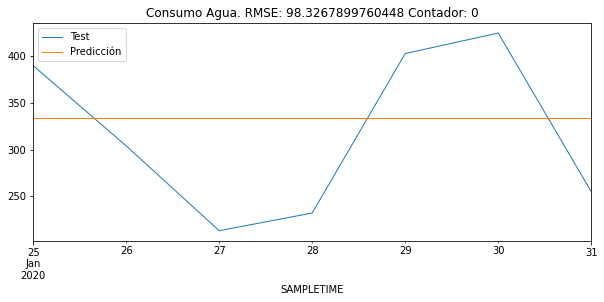

In [14]:
# Un modelo diario
Proyecto.PartirDatos()
Proyecto.Entrenamiento()
Proyecto.Calculo_RMSE()
Proyecto.GraficasEstadisticas()

In [15]:
data_tuples = list(zip(Proyecto.RMSE_Todos,Proyecto.RMSE_Todos_IDs))
resultados=pd.DataFrame(data_tuples,columns=['RMSE_Media','ID'])
resultados.to_csv(path+'RMSE_MEdia')
print(resultados)

      RMSE_Media    ID
0      98.326790     0
1      54.406641     1
2      14.718198     2
3     130.967211     3
4      46.080975     4
...          ...   ...
2710    1.713519  2722
2711   75.895168  2742
2712  204.087120  2745
2713    5.349299  2748
2714    1.268102  2749

[2715 rows x 2 columns]


# COHERENCIA DE LOS DATOS

In [16]:
Proyecto.contadores[0].Predicciones

[0,
 333.6571428571437,
 333.6571428571437,
 333.6571428571437,
 333.6571428571437,
 333.6571428571437,
 333.6571428571437,
 333.6571428571437,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 2335.600000000006,
 2335.600000000006]

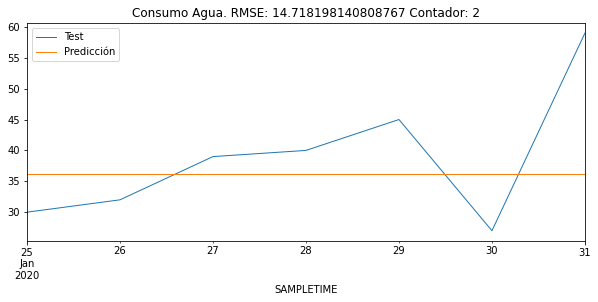

In [17]:
Proyecto.contadores[2].Predicciones
Proyecto.GraficasEstadisticas(contador=2,Test=True)

In [18]:
Proyecto.contadores[2711].Predicciones

[2711, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [19]:
Proyecto.RMSE_Test_Promedio

323.97228431945246

In [20]:
Proyecto.RMSE_Test_Suma

879584.7519273134

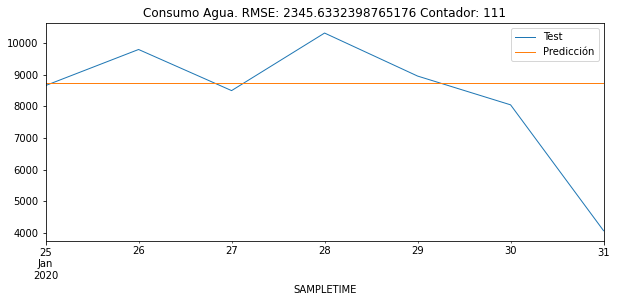

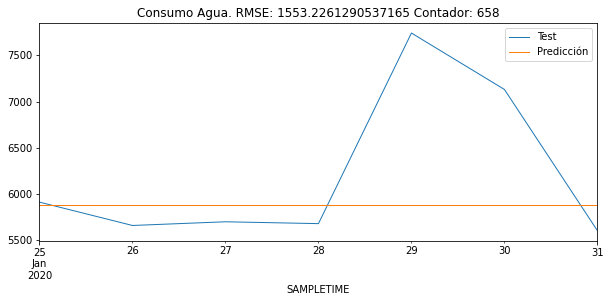

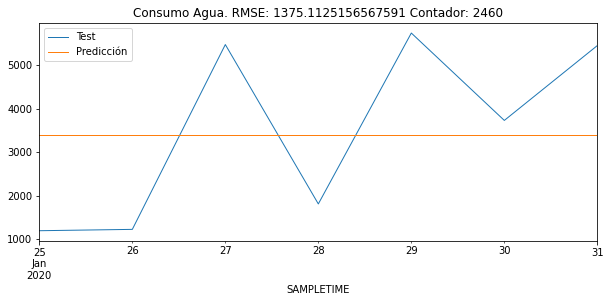

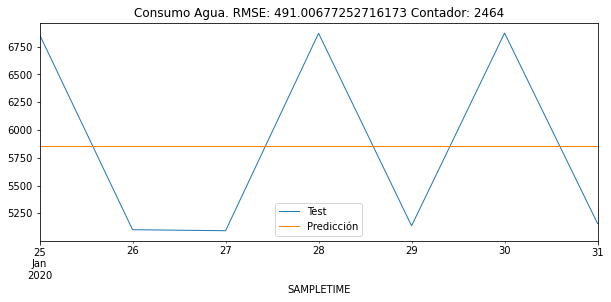

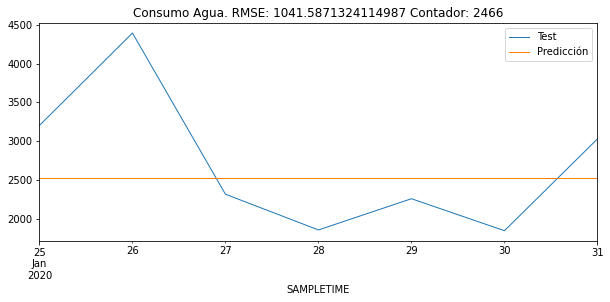

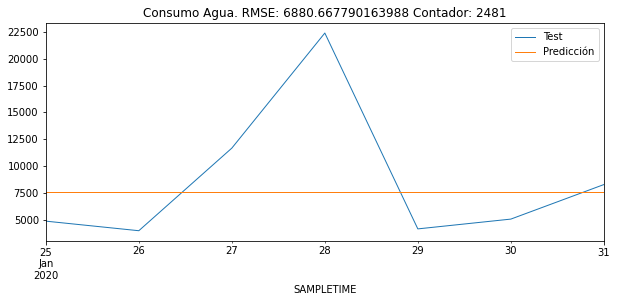

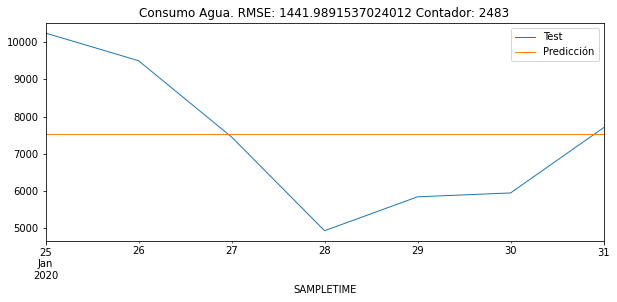

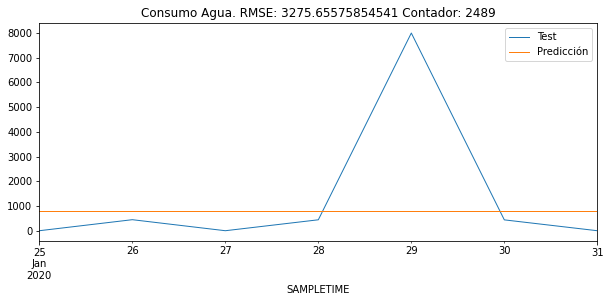

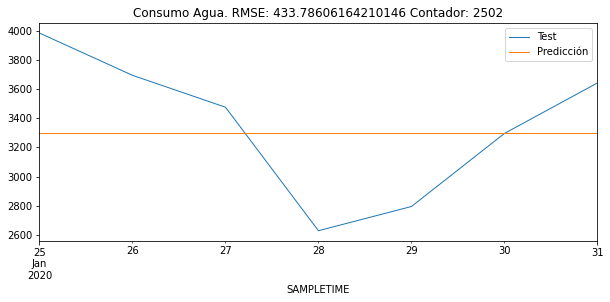

In [21]:
for ID in [111,658,2460,2464,2466,2481,2483,2489,2502]:
    Proyecto.GraficasEstadisticas(contador=ID)